In [1]:
import sys
import os
from timeit import default_timer as timer
import torch
from transformers import RobertaTokenizer, RobertaModel, RobertaForMaskedLM, RobertaConfig
import matplotlib.pyplot as plt
# % matplotlib inline
from scipy.spatial.distance import cosine

In [2]:
# Make sure we're in the transformers directory with fine-tuned model output.
os.chdir('/home/jupyter/Notebooks/crystal/NLP/transformers/examples/')
os.getcwd()

'/home/jupyter/Notebooks/crystal/NLP/transformers/examples'

In [3]:
# Adapted from the tutorial at https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/
# and Transformers documentation: https://huggingface.co/transformers/model_doc/roberta.html#robertaformaskedlm

In [ ]:
################################### BEGIN TESTING #####################################################

In [9]:
vocab_file = '/home/jupyter/Notebooks/crystal/NLP/MiFace/Python/data/vocab_files/vocab_checked.txt'
vocab = make_vocab(vocab_file)
print(vocab[:10])
print(len(vocab))

['aback', 'abashed', 'abhor', 'abhorred', 'abhorrence', 'abhorrent', 'abominable', 'abound', 'absent', 'absorbed']
2187


In [10]:
tokenizer = RobertaTokenizer.from_pretrained('./output_synonyms_lg2/')
config = RobertaConfig.from_pretrained('./output_synonyms_lg2/')
model = RobertaForMaskedLM.from_pretrained('./output_synonyms_lg2/', config=config)
# Outputting hidden states allows direct access to hidden layers of the model.
# Outputting hidden states must be set to "true" in the config file during fine-tuning.
# config.output_hidden_states = True
model.eval()

RobertaForMaskedLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((

In [30]:
# Define a new example sentence with multiple contexts for the word "abhorred"
test_text = "She made an abhorred expression as he began making excuses. He wanted to keep playing, but abhorred the poor sportsmanship of his fellows."

# Split the sentence into tokens.
tokenized_test_text = tokenizer.encode(test_text, add_special_tokens=True)

# Display the words with their indeces.
for t in tokenized_test_text[1:-1]:
        print('{:<12} {:>6,}'.format(tokenizer.decode(t).strip(), t))
        
print(tokenizer.decode(tokenized_test_text))

She             264
made            156
an               41
abhor        35,350
red           2,050
expression    8,151
as               25
he               37
began           880
making          442
excuses      19,791
.                 4
He               91
wanted          770
to                7
keep            489
playing         816
,                 6
but              53
abhor        35,350
red           2,050
the               5
poor          2,129
sports        1,612
manship      17,187
of                9
his              39
fellows      36,304
.                 4
<s> She made an abhorred expression as he began making excuses. He wanted to keep playing, but abhorred the poor sportsmanship of his fellows.</s>


In [26]:
# tokens_tensor = torch.tensor([tokenized_test_text])

In [33]:
input_ids = torch.tensor(tokenized_test_text).unsqueeze(0)  # Batch size 1
with torch.no_grad():
    outputs = model(input_ids, masked_lm_labels=input_ids)
    # Documentation for the "forward" method of RobertaForMaskedLM
    # details what is returned for each index of "outputs."
    print(len(outputs))
    print(outputs[0])  # masked_lm_loss
    print(outputs[1])  # prediction_scores
    print(outputs[2])  # hidden_states

3
tensor(1.7705)
tensor([[[ 7.5622, -6.5695,  7.1052,  ..., -0.4609, -0.3673,  2.0783],
         [ 0.1524, -6.5327,  0.7621,  ..., -4.3035, -2.9045,  0.0805],
         [-3.1635, -4.4289,  5.9348,  ...,  0.1579, -0.5408, -0.8563],
         ...,
         [ 0.4510, -4.8339,  0.3958,  ..., -0.3920, -3.4539, -2.0414],
         [ 3.5524, -6.6096,  7.0987,  ..., -1.0119, -0.9505,  0.7903],
         [ 9.0676, -5.9170,  7.8096,  ..., -0.8526, -2.6835,  3.2866]]])
(tensor([[[ 1.8019e-01, -1.1417e-04, -6.6993e-03,  ..., -1.6295e-01,
           1.0452e-01,  5.8282e-02],
         [-1.0831e-01, -6.4354e-02,  1.7192e-01,  ...,  3.5061e-03,
           1.8987e-01,  2.1542e-01],
         [-1.2822e-01, -2.1817e-01,  6.4316e-01,  ..., -4.8211e-02,
          -6.1839e-01,  3.5666e-02],
         ...,
         [-9.0066e-03, -5.7980e-01,  2.9104e-01,  ..., -2.0536e-01,
          -1.5077e-01,  4.3876e-01],
         [ 2.1391e-01,  2.3605e-01,  2.8134e-01,  ..., -9.9283e-01,
           7.0846e-02, -2.6021e-02],
 

In [34]:
print ("Number of layers:", len(outputs[2]))
layer_i = 0

print ("Number of batches:", len(outputs[2][layer_i]))
batch_i = 0

print ("Number of tokens:", len(outputs[2][layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", len(outputs[2][layer_i][batch_i][token_i]))

Number of layers: 13
Number of batches: 1
Number of tokens: 31
Number of hidden units: 768


In [86]:
encoded_layers = outputs[2]

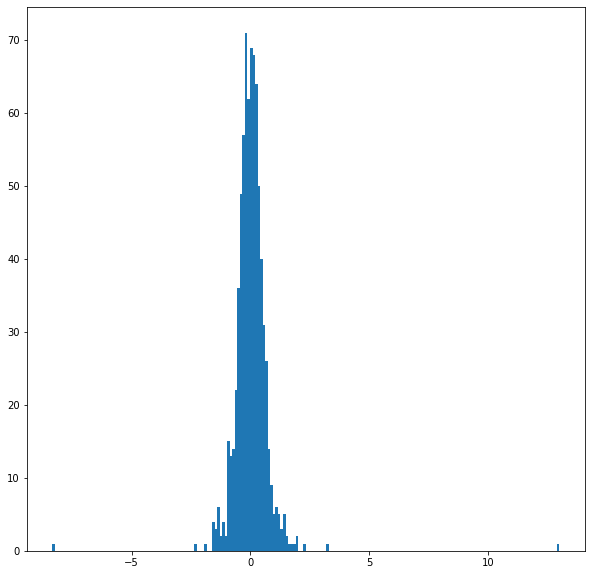

In [91]:
# For our token, select its feature values from layer 5.
token_i = 4
layer_i = 5
vec = encoded_layers[layer_i][batch_i][token_i]
# print(vec)

# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(10,10))
plt.hist(vec, bins=200)
plt.show()

In [74]:
# `encoded_layers` is a tuple.
print('     Type of encoded_layers: ', type(list(encoded_layers)))

# Each layer in the list is a torch tensor.
print('Tensor shape for each layer: ', encoded_layers[0].size())

     Type of encoded_layers:  <class 'list'>
Tensor shape for each layer:  torch.Size([1, 32, 768])


In [75]:
# Concatenate the tensors for all layers. We use `stack` here to
# create a new dimension in the tensor.
token_embeddings = torch.stack(encoded_layers, dim=0)

token_embeddings.size()

torch.Size([13, 1, 32, 768])

In [76]:
# Remove dimension 1, the "batches".
token_embeddings = torch.squeeze(token_embeddings, dim=1)

token_embeddings.size()

torch.Size([13, 32, 768])

In [94]:
# Swap dimensions 0 and 1.
token_embeddings = token_embeddings.permute(1,0,2)

token_embeddings.size()

torch.Size([32, 13, 768])

In [103]:
for i, token_str in enumerate(tokenized_test_text):
      if tokenizer.decode(token_str).strip() == "disgusted":
        print (i, tokenizer.decode(token_str))

4  disgusted
21  disgusted


In [97]:
# Create token vectors by summing the last 4 layers of the model.
# Stores the token vectors, with shape [32 x 768]
token_vecs_sum = []
# `token_embeddings` is a [32 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:
    # `token` is a [13 x 768] tensor
    # Sum the vectors from the last four layers.
    sum_vec = torch.sum(token[-4:], dim=0)
    
    # Use `sum_vec` to represent `token`.
    token_vecs_sum.append(sum_vec)

print ('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))
# Shape is: 32 x 768

Shape is: 32 x 768


In [99]:
# Extract the last layer's features
token_vecs_last = []
# `token_embeddings` is a [32 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:
    # `token` is a [13 x 768] tensor
    # Extract the vector from the last layer.
    last_vec = token[-1]
    
    # Use `sum_vec` to represent `token`.
    token_vecs_last.append(last_vec)

print ('Shape is: %d x %d' % (len(token_vecs_last), len(token_vecs_last[0])))
# Shape is: 32 x 768

Shape is: 32 x 768


In [109]:
# Extract the embedding layer's features (layer 0 is the embedding layer)
token_vecs_embed = []
# `token_embeddings` is a [32 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:
    # `token` is a [13 x 768] tensor
    # Extract the vector from the last layer.
    embed_vec = token[0]
    
    # Use `sum_vec` to represent `token`.
    token_vecs_embed.append(last_vec)

print ('Shape is: %d x %d' % (len(token_vecs_embed), len(token_vecs_embed[0])))
# Shape is: 32 x 768

Shape is: 32 x 768


In [129]:
indices = []
for i, token_str in enumerate(tokenized_test_text):
      if tokenizer.decode(token_str).strip() == "disgusted":
        indices.append(i)
print(indices)

[4, 21]


In [130]:
token_vecs_sum_last_four = sum_last_four_token_vecs(token_embeddings)
for i in range(len(indices)):
    print(f'disgusted at index {indices[i]}: {str(token_vecs_sum_last_four[indices[i]][:5])}')

Shape is: 32 x 768
disgusted at index 4: tensor([-0.7637, -1.0375, -0.4840, -0.2251, -0.1792])
disgusted at index 21: tensor([-0.8459, -0.2973, -0.3336, -0.6372, -0.7399])


In [224]:
for i, v in enumerate(vocab):
    print(i, v)

0 open
1 openness
2 opposed
3 oppositional
4 oppressed
5 optimism
6 optimistic
7 ordering
8 orgasmic
9 ornery
10 ouch
11 out
12 outburst
13 outcry
14 outed
15 outlandish
16 outrage
17 outraged
18 outspoken
19 overbearing
20 overexcited
21 overjoyed
22 overshadowed
23 overstrung
24 overwhelmed
25 overworked
26 overwrought
27 pain
28 pained
29 painful
30 painfully
31 panic
32 panicked
33 panicky
34 paralyzed
35 paranoid
36 passionate
37 passive
38 patience
39 patient
40 patronizing
41 pause
42 pausing
43 peaceful
44 peculiar
45 peering
46 peeved
47 peevish
48 pensive
49 peppy
50 perceptive
51 perfidious
52 perky
53 perplexed
54 perplexing
55 persistent
56 personable
57 perturbed
58 perverse
59 pesky
60 pessimism
61 pessimistic
62 pestered
63 petitioning
64 petrified
65 petty
66 petulant
67 picked
68 piercing
69 pinched
70 pious
71 piqued
72 pissed
73 pitiable
74 pitiful
75 pity
76 pitying
77 placated
78 placation
79 placid
80 plain
81 plaintive
82 planning
83 playful
84 playfully
85 plea

In [229]:
v_indices = (102, 145, 309, 316, 410, 698)

start = 12
sections = []
for end in v_indices:
    for i in range(start, end):
#         print(i)
        sections.append(vocab[i])
        start = end + 1
for i in range(start, len(vocab)):
    sections.append(vocab[i])
#     print(i)

for i, v in enumerate(sections):
    print(i, v)

0 outburst
1 outcry
2 outed
3 outlandish
4 outrage
5 outraged
6 outspoken
7 overbearing
8 overexcited
9 overjoyed
10 overshadowed
11 overstrung
12 overwhelmed
13 overworked
14 overwrought
15 pain
16 pained
17 painful
18 painfully
19 panic
20 panicked
21 panicky
22 paralyzed
23 paranoid
24 passionate
25 passive
26 patience
27 patient
28 patronizing
29 pause
30 pausing
31 peaceful
32 peculiar
33 peering
34 peeved
35 peevish
36 pensive
37 peppy
38 perceptive
39 perfidious
40 perky
41 perplexed
42 perplexing
43 persistent
44 personable
45 perturbed
46 perverse
47 pesky
48 pessimism
49 pessimistic
50 pestered
51 petitioning
52 petrified
53 petty
54 petulant
55 picked
56 piercing
57 pinched
58 pious
59 piqued
60 pissed
61 pitiable
62 pitiful
63 pity
64 pitying
65 placated
66 placation
67 placid
68 plain
69 plaintive
70 planning
71 playful
72 playfully
73 pleading
74 pleasant
75 pleased
76 pleasing
77 pleasurable
78 pleasure
79 pleasured
80 pliant
81 plotting
82 poignant
83 pointed
84 poised


In [230]:
vocab = sections

In [111]:
# Calculate the cosine similarity between the word disgusted 
# in "disgusted expression" vs "too disgusted" (different contexts)
# using the last layer of the model.
diff_disgusted_last = 1 - cosine(token_vecs_last[4], token_vecs_last[21])

# Calculate the cosine similarity between the word disgusted 
# in "disgusted expression" vs "too disgusted" (different contexts)
# using the embed layer of the model.
diff_disgusted_embed = 1 - cosine(token_vecs_embed[4], token_vecs_embed[21])

# Calculate the cosine similarity between the word disgusted 
# in "disgusted expression" vs "too disgusted" (different contexts)
# using the sum of the last 4 layers of the model.
diff_disgusted_sum = 1 - cosine(token_vecs_sum_last_four[4], token_vecs_sum_last_four[21])

print('Vector similarity at the last layer:  %.2f' % diff_disgusted_last)
print('Vector similarity at the embed layer:  %.2f' % diff_disgusted_embed)
print('Vector similarity at the embed layer:  %.2f' % diff_disgusted_sum)

Vector similarity at the last layer:  0.91
Vector similarity at the embed layer:  1.00
Vector similarity at the embed layer:  0.89


In [ ]:
############################ END TESTING ##############################################################################

In [10]:
############################ START PRODUCTION: GET CONTEXTUAL EMBEDDINGS ##############################################

In [16]:
tokenizer = RobertaTokenizer.from_pretrained('./output_synonyms_lg2/')
config = RobertaConfig.from_pretrained('./output_synonyms_lg2/')
model = RobertaForMaskedLM.from_pretrained('./output_synonyms_lg2/', config=config)
# Outputting hidden states allows direct access to hidden layers of the model.
# Outputting hidden states must be set to "true" in the config file during fine-tuning.
# config.output_hidden_states = True
model.eval()

context_file = "/home/jupyter/Notebooks/crystal/NLP/transformers/examples/synonyms_sorted_cleaned.txt"
output_file = '/home/jupyter/Notebooks/crystal/NLP/nlp_testing/embeddings_context_vocab/roberta_lg_lastfour_synonyms.txt'
count_file = '/home/jupyter/Notebooks/crystal/NLP/nlp_testing/embeddings_context_vocab/roberta_lg_lastfour_synonyms_counts.txt'
vocab_file = '/home/jupyter/Notebooks/crystal/NLP/MiFace/Python/data/vocab_files/vocab_checked.txt'
vocab = make_vocab(vocab_file)
# vocab = ["mad"]

FEATURE_COUNT = 1024

In [ ]:
# Process vocabulary words in the outer loop.
for v in vocab:
    start = timer()
    with open(context_file, 'r') as lines:
        v_sum = torch.zeros([1, FEATURE_COUNT])
        v_tokens = tokenizer.encode(v)
        print(f'\nThere are {len(v_tokens) - 2} tokens in tokenized vocabulary word:')
        for t in v_tokens[1:-1]:
            print(tokenizer.decode(t).strip())
        count_sentence = 0
        count_tensor = 0
        
        # Process all lines in the context file in the inner loop.
        for line in lines:
            # Check for this vocab word in this line; if found, split the line into individual sentences.
            if v in line.lower().split():
                for sentence in line.split('.'):
                    if v in sentence.lower():
                        line = sentence
                        count_sentence += 1
                        print(f'\nInstance {count_sentence} of {tokenizer.decode(v_tokens[1:-1]).strip()}.')
                        break
                # Split the new sentence-based line into tokens.
                # Use max_length to avoid overflowing the maximum sequence length for the model.
                tokenized_text = tokenizer.encode(line, add_special_tokens=True, max_length=512)
#                 print(f'The decoded sentence has {len(tokenized_text)} tokens and is: {tokenizer.decode(tokenized_text)}')
                indices = []              

                # Check to see whether the vocab word is found in this particular line.
                # Initially, some lines may have comprised multiple sentences, which were
                # broken out individually above.
                for t in v_tokens[1:-1]:
                    print(f'Looking for vocab token: {tokenizer.decode(t).strip()}')
                    for i, token_str in enumerate(tokenized_text):
#                         print(f'Next sentence token: {tokenizer.decode(token_str).strip()}')
#                         print(tokenizer.decode(token_str).strip() == tokenizer.decode(t).strip())
                        if tokenizer.decode(token_str).strip() == tokenizer.decode(t).strip():
                            indices.append(i)               

                ###################################################################################
                # If the vocabulary word was found, process the containing line.
                if indices:

                    # The vocab word was found in this line/sentence, at the locations in indices.
                    print(f'Indices are {indices}')
                    # Get the feature vectors for all tokens in the line/sentence.
                    token_embeddings = create_token_embeddings(tokenized_text)
                    # Sum the last four layers to get embeddings for the line/sentence.
#                         for t in v_tokens[1:-1]:
#                             for i, token_str in enumerate(tokenized_text):
#                                 if (tokenizer.decode(token_str).strip() == tokenizer.decode(t).strip()):
#                                     print(f'{tokenizer.decode(token_str).strip()} is index {i} in the sentence and {token_str} in the vocabulary.')
                    token_vecs_layer = sum_last_four_token_vecs(token_embeddings)

                    # Get the vocab word's contextual embedding for this line.
                    tensor_layer = torch.zeros([1, FEATURE_COUNT])
                    for i in range(len(indices)):
                        v_index = i % len(v_tokens[1:-1])
                        print(f'{tokenizer.decode(v_tokens[v_index + 1]).strip()} at index {indices[i]}: {token_vecs_layer[indices[i]][:5].tolist()}')
                        tensor_layer += token_vecs_layer[indices[i]]
#                         print(f'Sum of tensors is: {tensor_layer[0][:5].tolist()} before taking the mean.')

                    # If our vocab word is broken into more than one token, we need to get the mean of the token embeddings.
                    tensor_layer /= len(indices)
#                     print(f'Sum of tensors is: {tensor_layer[0][:5].tolist()} after taking the mean.')

                    # Add the embedding distilled from this line to the sum of embeddings for all lines.
                    v_sum += tensor_layer
                    count_tensor += 1
                    print(f'Grand sum of {count_tensor} tensor sets is: {v_sum[0][:5].tolist()}')
                ###################################################################################
            # Stop processing lines once we've found 2000 instances of our vocab word.
            if count_tensor >= 2000:
                break
        
        # We're done processing all lines of 512 tokens or less containing our vocab word.
        # Get the mean embedding for the word.
        v_mean = v_sum / count_tensor
        print(f'Mean of tensors is: {v_mean[0][:5]} ({len(v_mean[0])} features in tensor)')
        write_embedding(output_file, v, v_mean)
        try:
            with open(count_file, 'a') as counts:
                counts.write(v + ', ' + str(count_tensor) + '\n')
            print(f'Saved the count of sentences used to create {v} embedding')
        except:
            print('Wha?! Could not write the sentence count.')
    end = timer()
    print(f'Run time for {v} was {end - start} seconds.')


There are 1 tokens in tokenized vocabulary word:
aback

Instance 1 of aback.
Looking for vocab token: aback
Indices are [1]
Size of token embeddings is torch.Size([3, 25, 1024])
Shape of summed layers is: 3 x 1024
aback at index 1: [1.2552350759506226, 0.8695110082626343, -3.3837084770202637, 2.4379351139068604, 1.6536391973495483]
Grand sum of 1 tensor sets is: [1.2552350759506226, 0.8695110082626343, -3.3837084770202637, 2.4379351139068604, 1.6536391973495483]

Instance 2 of aback.
Looking for vocab token: aback
Indices are [1]
Size of token embeddings is torch.Size([8, 25, 1024])
Shape of summed layers is: 8 x 1024
aback at index 1: [1.3269141912460327, 2.621756076812744, -4.340818405151367, 1.314831256866455, 3.355720281600952]
Grand sum of 2 tensor sets is: [2.5821492671966553, 3.491267204284668, -7.724526882171631, 3.7527663707733154, 5.009359359741211]

Instance 3 of aback.
Looking for vocab token: aback
Indices are [74]
Size of token embeddings is torch.Size([84, 25, 1024])
Sh

Size of token embeddings is torch.Size([145, 25, 1024])
Shape of summed layers is: 145 x 1024
aback at index 86: [-2.052556276321411, 1.2422319650650024, -3.150357961654663, 3.312494993209839, 3.1419780254364014]
Grand sum of 21 tensor sets is: [-33.800662994384766, 22.615285873413086, -43.82404708862305, 64.76522064208984, 64.77458190917969]

Instance 22 of aback.
Looking for vocab token: aback
Indices are [18]
Size of token embeddings is torch.Size([25, 25, 1024])
Shape of summed layers is: 25 x 1024
aback at index 18: [-0.39932897686958313, 2.558518648147583, -4.5200114250183105, 3.8320865631103516, 1.9774731397628784]
Grand sum of 22 tensor sets is: [-34.19999313354492, 25.173805236816406, -48.344058990478516, 68.59730529785156, 66.7520523071289]

Instance 23 of aback.
Looking for vocab token: aback
Indices are [18]
Size of token embeddings is torch.Size([27, 25, 1024])
Shape of summed layers is: 27 x 1024
aback at index 18: [-0.8446687459945679, 2.0270931720733643, -2.926823377609

Size of token embeddings is torch.Size([117, 25, 1024])
Shape of summed layers is: 117 x 1024
aback at index 75: [-2.238002300262451, -0.012387484312057495, -2.7287163734436035, 3.486811637878418, 4.0721235275268555]
Grand sum of 42 tensor sets is: [-68.86962890625, 45.707611083984375, -94.35490417480469, 126.90672302246094, 140.9063262939453]

Instance 47 of aback.
Looking for vocab token: aback
Indices are [88]
Size of token embeddings is torch.Size([93, 25, 1024])
Shape of summed layers is: 93 x 1024
aback at index 88: [-1.9481370449066162, 0.915237307548523, -3.829817771911621, 3.0296478271484375, 2.9789347648620605]
Grand sum of 43 tensor sets is: [-70.81776428222656, 46.62284851074219, -98.18472290039062, 129.93637084960938, 143.88525390625]

Instance 48 of aback.
Looking for vocab token: aback
Indices are [22]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
aback at index 22: [-0.1206950917840004, 0.7247210741043091, -3.4996335506439

Size of token embeddings is torch.Size([132, 25, 1024])
Shape of summed layers is: 132 x 1024
aback at index 119: [-1.0254437923431396, 2.086359739303589, -1.3896472454071045, 2.9735500812530518, 2.1493592262268066]
Grand sum of 62 tensor sets is: [-102.79969024658203, 77.53208923339844, -151.6082305908203, 188.00967407226562, 206.2246856689453]

Instance 69 of aback.
Looking for vocab token: aback
Indices are [130]
Size of token embeddings is torch.Size([210, 25, 1024])
Shape of summed layers is: 210 x 1024
aback at index 130: [-2.027251958847046, 1.7747584581375122, 1.4098539352416992, 2.9161436557769775, 4.91267204284668]
Grand sum of 63 tensor sets is: [-104.82694244384766, 79.30684661865234, -150.19837951660156, 190.92581176757812, 211.13735961914062]

Instance 70 of aback.
Looking for vocab token: aback
Indices are [5]
Size of token embeddings is torch.Size([146, 25, 1024])
Shape of summed layers is: 146 x 1024
aback at index 5: [-1.1691205501556396, 3.522653102874756, -5.8197793

Size of token embeddings is torch.Size([12, 25, 1024])
Shape of summed layers is: 12 x 1024
ab at index 1: [-0.464828222990036, -0.5220359563827515, -7.135210990905762, -0.16520598530769348, 1.2022196054458618]
ashed at index 2: [1.3874456882476807, -0.6663532257080078, -4.0258402824401855, 1.8202769756317139, -0.28946834802627563]
Grand sum of 5 tensor sets is: [0.9858876466751099, 0.09961909055709839, -26.826541900634766, 2.0626063346862793, 2.19045090675354]

Instance 6 of abashed.
Looking for vocab token: ab
Looking for vocab token: ashed
Indices are [1, 14, 24, 2, 15]
Size of token embeddings is torch.Size([85, 25, 1024])
Shape of summed layers is: 85 x 1024
ab at index 1: [-0.7348365783691406, 0.7497166991233826, -6.780934810638428, -1.1007722616195679, 1.2430577278137207]
ashed at index 14: [-0.24400456249713898, 2.440666437149048, -4.24208927154541, -2.705343246459961, 2.3216779232025146]
ab at index 24: [0.7953206300735474, -0.24640339612960815, -5.631503105163574, -1.99765396

Size of token embeddings is torch.Size([205, 25, 1024])
Shape of summed layers is: 205 x 1024
ab at index 3: [0.15363642573356628, 1.247685432434082, -7.63831901550293, 0.12664134800434113, -0.16562609374523163]
ashed at index 102: [-0.3451114296913147, -0.4233008623123169, -0.9815787672996521, -0.6363800764083862, 1.6729040145874023]
ab at index 4: [0.6648719906806946, 1.2398054599761963, -7.044468879699707, 2.31697940826416, -0.4323333501815796]
Grand sum of 19 tensor sets is: [4.638402938842773, 8.457128524780273, -106.97464752197266, 5.454736232757568, 4.640883445739746]

Instance 20 of abashed.
Looking for vocab token: ab
Looking for vocab token: ashed
Indices are [2, 3]
Size of token embeddings is torch.Size([254, 25, 1024])
Shape of summed layers is: 254 x 1024
ab at index 2: [-0.4592437744140625, 0.8329240083694458, -8.002497673034668, -0.39745670557022095, 0.5253620743751526]
ashed at index 3: [0.7804486751556396, 1.2632262706756592, -6.422544479370117, 2.0716726779937744, 0.3

Size of token embeddings is torch.Size([38, 25, 1024])
Shape of summed layers is: 38 x 1024
ab at index 10: [-1.2398310899734497, -0.5208069086074829, -4.746601581573486, 0.30889272689819336, 0.8275195956230164]
ashed at index 11: [-0.08517816662788391, -0.298156201839447, -2.8778653144836426, 1.234632968902588, 1.862231731414795]
Grand sum of 34 tensor sets is: [10.346566200256348, 19.57537269592285, -207.41909790039062, 15.27616024017334, 5.631046772003174]

Instance 35 of abashed.
Looking for vocab token: ab
Looking for vocab token: ashed
Indices are [4, 5]
Size of token embeddings is torch.Size([237, 25, 1024])
Shape of summed layers is: 237 x 1024
ab at index 4: [-0.435107558965683, 1.3137938976287842, -7.852182388305664, -0.5542488098144531, -0.1084296926856041]
ashed at index 5: [0.8247982263565063, 1.0911740064620972, -6.978271484375, 1.6090242862701416, -0.3958565294742584]
Grand sum of 35 tensor sets is: [10.541411399841309, 20.777856826782227, -214.83432006835938, 15.8035478

Size of token embeddings is torch.Size([64, 25, 1024])
Shape of summed layers is: 64 x 1024
ab at index 2: [-1.2050361633300781, 1.19684898853302, -4.606126308441162, -0.7324771881103516, 0.5343759655952454]
ashed at index 3: [-0.6486218571662903, 0.31009671092033386, -5.414407730102539, 1.8834154605865479, -0.13273240625858307]
Grand sum of 49 tensor sets is: [11.302509307861328, 29.450775146484375, -306.2568359375, 23.628002166748047, 1.88264000415802]

Instance 50 of abashed.
Looking for vocab token: ab
Looking for vocab token: ashed
Indices are [3, 5, 4]
Size of token embeddings is torch.Size([114, 25, 1024])
Shape of summed layers is: 114 x 1024
ab at index 3: [0.4658149480819702, 2.2562220096588135, -6.350786209106445, -1.4758743047714233, -0.2508843243122101]
ashed at index 5: [1.4141954183578491, 1.9888807535171509, -7.829339027404785, -1.28481924533844, 0.10377097874879837]
ab at index 4: [0.32986027002334595, 1.1026958227157593, -3.4823920726776123, 1.5090160369873047, -0.578

Size of token embeddings is torch.Size([78, 25, 1024])
Shape of summed layers is: 78 x 1024
ab at index 3: [-0.40964949131011963, 0.5774242877960205, -7.848018646240234, 0.7907570004463196, -0.4224913418292999]
ashed at index 4: [0.8502370119094849, 0.5102061629295349, -6.481203556060791, 1.8276126384735107, -0.600265622138977]
Grand sum of 63 tensor sets is: [16.507518768310547, 37.814414978027344, -395.8843688964844, 30.822450637817383, 1.3702456951141357]

Instance 64 of abashed.
Looking for vocab token: ab
Looking for vocab token: ashed
Indices are [3, 4]
Size of token embeddings is torch.Size([149, 25, 1024])
Shape of summed layers is: 149 x 1024
ab at index 3: [0.09239062666893005, 0.998816967010498, -7.178257465362549, -0.21822765469551086, 0.41608694195747375]
ashed at index 4: [0.18679304420948029, 0.7636060118675232, -4.536316394805908, 1.5376105308532715, -0.16751150786876678]
Grand sum of 64 tensor sets is: [16.647109985351562, 38.69562530517578, -401.7416687011719, 31.4821

Size of token embeddings is torch.Size([24, 25, 1024])
Shape of summed layers is: 24 x 1024
abhor at index 4: [-0.3967072665691376, 1.280372977256775, -5.862366199493408, -0.7636577486991882, -0.7468175888061523]
Grand sum of 10 tensor sets is: [-3.7851357460021973, 22.709535598754883, -48.663692474365234, -7.961077690124512, 1.829517126083374]

Instance 11 of abhor.
Looking for vocab token: abhor
Indices are [4]
Size of token embeddings is torch.Size([10, 25, 1024])
Shape of summed layers is: 10 x 1024
abhor at index 4: [-0.07010219246149063, 1.126753330230713, -4.575318336486816, -1.5716538429260254, -1.7387266159057617]
Grand sum of 11 tensor sets is: [-3.8552379608154297, 23.836288452148438, -53.239009857177734, -9.532732009887695, 0.0907905101776123]

Instance 12 of abhor.
Looking for vocab token: abhor
Indices are [4]
Size of token embeddings is torch.Size([10, 25, 1024])
Shape of summed layers is: 10 x 1024
abhor at index 4: [-0.07010219246149063, 1.126753330230713, -4.575318336

Size of token embeddings is torch.Size([17, 25, 1024])
Shape of summed layers is: 17 x 1024
abhor at index 15: [0.7889879941940308, 1.1446795463562012, -3.540508985519409, -2.110239028930664, -0.6514111757278442]
Grand sum of 31 tensor sets is: [-10.028169631958008, 56.89377212524414, -133.10792541503906, -32.59879684448242, -11.212013244628906]

Instance 32 of abhor.
Looking for vocab token: abhor
Indices are [2, 3, 5]
Size of token embeddings is torch.Size([245, 25, 1024])
Shape of summed layers is: 245 x 1024
abhor at index 2: [-0.02105160430073738, 1.8382041454315186, -3.7853786945343018, 0.41542598605155945, -0.07171259820461273]
abhor at index 3: [1.0815579891204834, 2.9379324913024902, -5.654043197631836, -1.2013928890228271, -1.0214760303497314]
abhor at index 5: [1.0747489929199219, 2.808061361312866, -7.679765701293945, 0.2568984031677246, -1.2327338457107544]
Grand sum of 32 tensor sets is: [-9.316417694091797, 59.421836853027344, -138.81431579589844, -32.77515411376953, -11

Size of token embeddings is torch.Size([17, 25, 1024])
Shape of summed layers is: 17 x 1024
abhor at index 1: [1.163767695426941, 1.7913429737091064, -5.124436378479004, -0.483041912317276, -0.40192174911499023]
rence at index 2: [1.6321182250976562, 0.5559732913970947, -8.079035758972168, -2.804173231124878, -0.6135917901992798]
Grand sum of 2 tensor sets is: [3.0582773685455322, 2.7093541622161865, -12.620704650878906, -3.2336792945861816, -1.4520015716552734]

Instance 3 of abhorrence.
Looking for vocab token: abhor
Looking for vocab token: rence
Indices are [1, 2]
Size of token embeddings is torch.Size([16, 25, 1024])
Shape of summed layers is: 16 x 1024
abhor at index 1: [1.3314852714538574, 2.058976888656616, -4.846358776092529, -0.8481699824333191, -0.6641336679458618]
rence at index 2: [2.129115104675293, 0.13569296896457672, -7.503345966339111, -2.953598737716675, -0.5678764581680298]
Grand sum of 3 tensor sets is: [4.788577556610107, 3.8066892623901367, -18.795557022094727, -

Size of token embeddings is torch.Size([287, 25, 1024])
Shape of summed layers is: 287 x 1024
abhor at index 2: [0.32826557755470276, 2.2102322578430176, -4.248112678527832, -1.2985223531723022, -0.5624353885650635]
rence at index 3: [0.8551057577133179, -0.17644280195236206, -4.521711349487305, -4.501392841339111, -1.8406620025634766]
Grand sum of 14 tensor sets is: [20.885210037231445, 16.64728546142578, -85.3637924194336, -27.885223388671875, -11.778640747070312]

Instance 15 of abhorrence.
Looking for vocab token: abhor
Looking for vocab token: rence
Indices are [4, 5]
Size of token embeddings is torch.Size([110, 25, 1024])
Shape of summed layers is: 110 x 1024
abhor at index 4: [1.2060911655426025, 2.1580891609191895, -4.879186153411865, 0.41514790058135986, -1.9983510971069336]
rence at index 5: [2.0519087314605713, -0.11810639500617981, -8.106701850891113, -3.2393288612365723, -1.974555253982544]
Grand sum of 15 tensor sets is: [22.514209747314453, 17.66727638244629, -91.8567352

Size of token embeddings is torch.Size([207, 25, 1024])
Shape of summed layers is: 207 x 1024
abhor at index 39: [-1.4640398025512695, 2.850186586380005, -5.780909538269043, -2.4183404445648193, -1.624199628829956]
rence at index 124: [-2.093316078186035, 2.589085578918457, -0.31744569540023804, -2.4268550872802734, -1.3844201564788818]
abhor at index 161: [1.744478464126587, 1.6343357563018799, 1.650833249092102, -3.3261830806732178, -0.06248088553547859]
rence at index 40: [1.6666710376739502, 0.2454174906015396, -7.25651741027832, -1.4877383708953857, -0.5964832305908203]
abhor at index 125: [-0.3361865282058716, 0.27742239832878113, -1.6455143690109253, -1.657873272895813, -1.0741674900054932]
rence at index 162: [1.769191026687622, 0.4310866892337799, 0.29970669746398926, -3.2368927001953125, -0.3983399271965027]
Grand sum of 28 tensor sets is: [42.767967224121094, 37.47943878173828, -155.53475952148438, -58.268062591552734, -25.77511978149414]

Instance 29 of abhorrence.
Looking 

Size of token embeddings is torch.Size([163, 25, 1024])
Shape of summed layers is: 163 x 1024
abhor at index 9: [1.032331943511963, 2.05435848236084, -5.641229629516602, -0.6714816093444824, -1.4842236042022705]
rence at index 10: [3.030972480773926, -0.2541620433330536, -6.865662574768066, -3.5073158740997314, 0.32680609822273254]
Grand sum of 43 tensor sets is: [66.1926498413086, 53.23214340209961, -246.0342559814453, -86.41312408447266, -41.15371322631836]

Instance 44 of abhorrence.
Looking for vocab token: abhor
Looking for vocab token: rence
Indices are [5, 6]
Size of token embeddings is torch.Size([16, 25, 1024])
Shape of summed layers is: 16 x 1024
abhor at index 5: [2.718447208404541, 2.2832579612731934, -5.679439544677734, -0.09305096417665482, -1.30800461769104]
rence at index 6: [2.645066738128662, 0.3302686810493469, -8.187339782714844, -2.622797966003418, -1.3782398700714111]
Grand sum of 44 tensor sets is: [68.87440490722656, 54.53890609741211, -252.9676513671875, -87.77

Size of token embeddings is torch.Size([14, 25, 1024])
Shape of summed layers is: 14 x 1024
abhor at index 7: [1.3096987009048462, 3.3636817932128906, -5.466042995452881, -0.1378687471151352, -1.6352498531341553]
rence at index 8: [3.0490145683288574, 1.1734795570373535, -8.845526695251465, -2.3278913497924805, -0.47174686193466187]
Grand sum of 58 tensor sets is: [95.5126953125, 73.2728500366211, -346.63397216796875, -112.03290557861328, -60.378665924072266]

Instance 59 of abhorrence.
Looking for vocab token: abhor
Looking for vocab token: rence
Indices are [9, 11, 10]
Size of token embeddings is torch.Size([96, 25, 1024])
Shape of summed layers is: 96 x 1024
abhor at index 9: [1.2035127878189087, 2.0291476249694824, -5.371172904968262, -0.5885944366455078, -0.37673357129096985]
rence at index 11: [-0.0058895256370306015, 2.0036163330078125, -4.790006637573242, -0.514024555683136, -0.12763217091560364]
abhor at index 10: [1.7313520908355713, -0.2001570165157318, -7.467774868011475, -

Size of token embeddings is torch.Size([155, 25, 1024])
Shape of summed layers is: 155 x 1024
abhor at index 15: [0.8929181098937988, 2.814063310623169, -4.259979724884033, -1.020850658416748, -2.3149514198303223]
rence at index 16: [2.051586627960205, 0.8359155654907227, -5.455020427703857, -4.035103797912598, -1.4727519750595093]
Grand sum of 72 tensor sets is: [116.14349365234375, 89.25725555419922, -430.740478515625, -140.24766540527344, -76.43744659423828]

Instance 73 of abhorrence.
Looking for vocab token: abhor
Looking for vocab token: rence
Indices are [10, 11]
Size of token embeddings is torch.Size([462, 25, 1024])
Shape of summed layers is: 462 x 1024
abhor at index 10: [1.2131373882293701, 1.1708697080612183, -4.212658405303955, -1.0336360931396484, -1.271950602531433]
rence at index 11: [2.9309966564178467, -0.3363831043243408, -5.922340393066406, -4.05525016784668, 0.045573726296424866]
Grand sum of 73 tensor sets is: [118.21556091308594, 89.67449951171875, -435.807983398

Size of token embeddings is torch.Size([14, 25, 1024])
Shape of summed layers is: 14 x 1024
abhor at index 1: [0.5296365022659302, 2.3650214672088623, -4.463708877563477, -0.959541916847229, -0.9904159307479858]
rent at index 2: [0.26979494094848633, 1.7213847637176514, -4.974991321563721, 0.6244924068450928, 0.19193695485591888]
Grand sum of 6 tensor sets is: [0.4475051760673523, 14.515411376953125, -25.112327575683594, -2.1436846256256104, -0.9601228833198547]

Instance 7 of abhorrent.
Looking for vocab token: abhor
Looking for vocab token: rent
Indices are [6, 7]
Size of token embeddings is torch.Size([318, 25, 1024])
Shape of summed layers is: 318 x 1024
abhor at index 6: [0.7675848007202148, 3.6450886726379395, -6.771596908569336, -0.30300578474998474, -1.7315318584442139]
rent at index 7: [-0.28931596875190735, 3.6664552688598633, -5.701070308685303, -0.27264800667762756, -0.30283454060554504]
Grand sum of 7 tensor sets is: [0.6866396069526672, 18.17118263244629, -31.348661422729

Size of token embeddings is torch.Size([229, 25, 1024])
Shape of summed layers is: 229 x 1024
abhor at index 3: [0.40085670351982117, 3.4910593032836914, -5.6395649909973145, -0.6215163469314575, -1.3685389757156372]
rent at index 4: [-0.8256593942642212, 3.2249562740325928, -2.8509721755981445, 0.3758646249771118, -1.3663814067840576]
Grand sum of 20 tensor sets is: [-7.225688457489014, 56.50550842285156, -66.95514678955078, -8.5388765335083, -1.0636132955551147]

Instance 21 of abhorrent.
Looking for vocab token: abhor
Looking for vocab token: rent
Indices are [3, 4]
Size of token embeddings is torch.Size([269, 25, 1024])
Shape of summed layers is: 269 x 1024
abhor at index 3: [0.48757874965667725, 2.9629101753234863, -4.967868328094482, -1.0930955410003662, -0.6275665163993835]
rent at index 4: [-0.7721108198165894, 2.914250373840332, -3.092721700668335, 0.1958269625902176, -1.0431385040283203]
Grand sum of 21 tensor sets is: [-7.367954254150391, 59.444087982177734, -70.985443115234

Size of token embeddings is torch.Size([226, 25, 1024])
Shape of summed layers is: 226 x 1024
abhor at index 6: [0.8992318511009216, 2.68204402923584, -5.600865364074707, 0.37077638506889343, -1.6498863697052002]
rent at index 7: [-0.047687456011772156, 2.5396995544433594, -5.145948886871338, 1.2369334697723389, -0.9957774877548218]
Grand sum of 35 tensor sets is: [-8.628280639648438, 97.41934204101562, -134.0648956298828, -10.115506172180176, -11.746637344360352]

Instance 36 of abhorrent.
Looking for vocab token: abhor
Looking for vocab token: rent
Indices are [5, 6]
Size of token embeddings is torch.Size([14, 25, 1024])
Shape of summed layers is: 14 x 1024
abhor at index 5: [0.5175612568855286, 2.7603864669799805, -5.786050319671631, -0.9256974458694458, -1.1050165891647339]
rent at index 6: [-0.7217085361480713, 1.4210842847824097, -3.9947590827941895, 1.3398890495300293, 0.34862905740737915]
Grand sum of 36 tensor sets is: [-8.730354309082031, 99.51007843017578, -138.9553070068359

Size of token embeddings is torch.Size([165, 25, 1024])
Shape of summed layers is: 165 x 1024
abhor at index 4: [0.13358676433563232, 3.2192225456237793, -4.69659423828125, -0.5781770944595337, -1.7098779678344727]
rent at index 5: [-0.6388365626335144, 2.380413770675659, -2.830561637878418, 0.7966424226760864, -1.0812991857528687]
Grand sum of 49 tensor sets is: [-9.227755546569824, 137.5683135986328, -191.78884887695312, -12.089522361755371, -24.508869171142578]

Instance 50 of abhorrent.
Looking for vocab token: abhor
Looking for vocab token: rent
Indices are [4, 5]
Size of token embeddings is torch.Size([274, 25, 1024])
Shape of summed layers is: 274 x 1024
abhor at index 4: [0.23645421862602234, 3.9414634704589844, -6.4287638664245605, -0.03051258623600006, -1.2918846607208252]
rent at index 5: [-0.18568822741508484, 3.7556090354919434, -4.924221515655518, -0.3172013759613037, -0.8864818811416626]
Grand sum of 50 tensor sets is: [-9.202372550964355, 141.41685485839844, -197.465347

Size of token embeddings is torch.Size([135, 25, 1024])
Shape of summed layers is: 135 x 1024
abhor at index 2: [0.7703628540039062, 2.8633761405944824, -5.06455659866333, -0.680039644241333, -0.5271401405334473]
rent at index 3: [-1.4161012172698975, 2.02750825881958, -1.145716905593872, 1.4249321222305298, 0.13787013292312622]
Grand sum of 63 tensor sets is: [-11.238506317138672, 176.58349609375, -248.2429962158203, -10.973121643066406, -32.794742584228516]

Instance 64 of abhorrent.
Looking for vocab token: abhor
Looking for vocab token: rent
Indices are [2, 3]
Size of token embeddings is torch.Size([219, 25, 1024])
Shape of summed layers is: 219 x 1024
abhor at index 2: [0.8421438336372375, 3.2881295680999756, -5.330331325531006, -0.6713148951530457, -0.7447818517684937]
rent at index 3: [-0.9317176938056946, 2.6655988693237305, -2.8205277919769287, 0.5960357189178467, -0.2379944920539856]
Grand sum of 64 tensor sets is: [-11.283292770385742, 179.56036376953125, -252.31842041015625

Size of token embeddings is torch.Size([320, 25, 1024])
Shape of summed layers is: 320 x 1024
abhor at index 3: [0.41772228479385376, 3.079348087310791, -5.47437858581543, -1.0196846723556519, -0.751927375793457]
rent at index 4: [-0.34249037504196167, 3.2523350715637207, -3.4568300247192383, 0.8177737593650818, -0.9329978227615356]
Grand sum of 79 tensor sets is: [-12.208972930908203, 217.5330352783203, -314.2083435058594, -12.670340538024902, -46.89582824707031]

Instance 80 of abhorrent.
Looking for vocab token: abhor
Looking for vocab token: rent
Indices are [3, 4]
Size of token embeddings is torch.Size([16, 25, 1024])
Shape of summed layers is: 16 x 1024
abhor at index 3: [0.4581165313720703, 2.4990756511688232, -5.644355773925781, -1.3682013750076294, -1.4265320301055908]
rent at index 4: [-0.24267956614494324, 1.7389745712280273, -4.190453052520752, 0.09344064444303513, -0.6816432476043701]
Grand sum of 80 tensor sets is: [-12.1012544631958, 219.6520538330078, -319.125732421875,

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
abhor at index 10: [0.06932903826236725, 2.0750935077667236, -2.9086458683013916, -0.1285446286201477, -0.5753130912780762]
rent at index 11: [-0.31101423501968384, 2.5990350246429443, -2.363431215286255, 0.17873525619506836, 0.27152127027511597]
Grand sum of 94 tensor sets is: [-13.628702163696289, 255.11785888671875, -371.5158386230469, -12.812393188476562, -59.72547149658203]
Mean of tensors is: tensor([-0.1450,  2.7140, -3.9523, -0.1363, -0.6354]) (1024 features in tensor)
Saved the embedding for abhorrent.
Saved the count of sentences used to create abhorrent embedding
Run time for abhorrent was 53.38574864156544 seconds.

There are 3 tokens in tokenized vocabulary word:
ab
omin
able

Instance 1 of abominable.
Looking for vocab token: ab
Looking for vocab token: omin
Looking for vocab token: able
Indices are [3, 7, 8, 117, 9]
Size of token embeddings is torch.Size([265, 25, 1024])
Shape o

Size of token embeddings is torch.Size([24, 25, 1024])
Shape of summed layers is: 24 x 1024
ab at index 1: [1.334722876548767, 1.56444251537323, -6.240516662597656, -1.7188034057617188, 1.3638955354690552]
omin at index 2: [1.6464382410049438, 1.369163990020752, -4.948111534118652, 1.0384182929992676, -0.5467296242713928]
able at index 3: [-2.6869568824768066, 1.7874844074249268, -2.679203748703003, -0.2371659278869629, -1.516262412071228]
ab at index 14: [-2.121366262435913, 2.365976333618164, -5.398477554321289, -0.9761936664581299, -1.1548255681991577]
omin at index 19: [-2.0564162731170654, 1.4212346076965332, -7.158061981201172, -1.4378678798675537, -1.6608567237854004]
Grand sum of 8 tensor sets is: [-10.213318824768066, 14.195714950561523, -33.01664733886719, -6.461390018463135, -10.446789741516113]

Instance 9 of abominable.
Looking for vocab token: ab
Looking for vocab token: omin
Looking for vocab token: able
Indices are [1, 14, 19, 2, 15, 20, 3, 16, 21, 80, 86, 89, 92, 99, 1

Size of token embeddings is torch.Size([167, 25, 1024])
Shape of summed layers is: 167 x 1024
ab at index 17: [-1.5963335037231445, 2.380498170852661, -1.956859827041626, 1.9535107612609863, -0.9675792455673218]
omin at index 18: [-4.524568557739258, 4.163791656494141, -4.6863627433776855, -1.5797245502471924, -2.2867445945739746]
Grand sum of 15 tensor sets is: [-20.066287994384766, 27.522916793823242, -66.11775970458984, -10.888657569885254, -19.453445434570312]

Instance 16 of abominable.
Looking for vocab token: ab
Looking for vocab token: omin
Looking for vocab token: able
Indices are [17, 18]
Size of token embeddings is torch.Size([167, 25, 1024])
Shape of summed layers is: 167 x 1024
ab at index 17: [-1.5285147428512573, 2.360761880874634, -1.9642707109451294, 1.958264946937561, -0.9754395484924316]
omin at index 18: [-4.512615203857422, 4.15289306640625, -4.703524589538574, -1.6058969497680664, -2.2808053493499756]
Grand sum of 16 tensor sets is: [-23.08685302734375, 30.7797431

Size of token embeddings is torch.Size([24, 25, 1024])
Shape of summed layers is: 24 x 1024
ab at index 8: [2.225518226623535, 1.3572453260421753, -7.1171722412109375, -2.32804274559021, 0.8087954521179199]
omin at index 9: [1.5052690505981445, 1.6062633991241455, -3.8366286754608154, 1.3825496435165405, -1.1978524923324585]
able at index 10: [-1.1739094257354736, 1.4265458583831787, -0.41827213764190674, 0.30778348445892334, -0.3233489990234375]
Grand sum of 23 tensor sets is: [-27.791549682617188, 42.81523895263672, -92.86841583251953, -16.0971736907959, -27.46797752380371]

Instance 24 of abominable.
Looking for vocab token: ab
Looking for vocab token: omin
Looking for vocab token: able
Indices are [4, 5, 6]
Size of token embeddings is torch.Size([56, 25, 1024])
Shape of summed layers is: 56 x 1024
ab at index 4: [2.628129482269287, 1.6965497732162476, -7.887352466583252, -1.8853334188461304, 0.3975711166858673]
omin at index 5: [3.089022159576416, 1.9032046794891357, -4.19713878631

Size of token embeddings is torch.Size([60, 25, 1024])
Shape of summed layers is: 60 x 1024
ab at index 54: [0.993432879447937, 1.1753334999084473, -5.14731502532959, -2.026794195175171, 0.5468419790267944]
omin at index 55: [1.3355603218078613, 1.3366632461547852, -2.0154197216033936, 0.6743826866149902, -2.934631824493408]
able at index 56: [-2.879788875579834, 0.830817461013794, -1.6844816207885742, -1.0562143325805664, -2.2753047943115234]
Grand sum of 30 tensor sets is: [-31.226348876953125, 55.389854431152344, -121.05215454101562, -20.65120506286621, -35.67708206176758]

Instance 31 of abominable.
Looking for vocab token: ab
Looking for vocab token: omin
Looking for vocab token: able
Indices are [63, 142, 143, 74, 79, 84, 144, 263, 348]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
ab at index 63: [-0.5922507643699646, 1.7114455699920654, -5.07670259475708, -1.8866642713546753, 1.8260835409164429]
omin at index 142: [-0.722577154636

Size of token embeddings is torch.Size([385, 25, 1024])
Shape of summed layers is: 385 x 1024
ab at index 13: [0.691315233707428, 1.5732089281082153, -5.9139885902404785, -1.3315349817276, -0.6106317639350891]
omin at index 14: [1.8181465864181519, 2.106210947036743, -2.6717207431793213, 1.124898076057434, -3.2303807735443115]
able at index 15: [-3.078956127166748, 1.7037172317504883, -2.7459373474121094, -0.8532283306121826, -2.261634111404419]
ab at index 116: [-3.749396800994873, 0.9402662515640259, -1.087018609046936, -1.316793441772461, -2.957731008529663]
omin at index 124: [-0.07958434522151947, -0.05975615233182907, 0.3272990584373474, -0.16748756170272827, 0.08175359666347504]
able at index 134: [-4.005845069885254, 2.427600622177124, 1.5277292728424072, -1.1144952774047852, -1.2012933492660522]
ab at index 199: [-3.9910900592803955, 1.498889684677124, 0.12539713084697723, -1.8658066987991333, -3.3526389598846436]
omin at index 267: [-3.4561657905578613, 1.3348028659820557, -0

Size of token embeddings is torch.Size([228, 25, 1024])
Shape of summed layers is: 228 x 1024
ab at index 5: [1.1242222785949707, 2.1703290939331055, -6.735335826873779, -1.4710743427276611, 0.3393055200576782]
omin at index 7: [1.4479316473007202, 2.199763774871826, -7.628195285797119, -1.1756939888000488, -0.11834760755300522]
able at index 8: [1.8295838832855225, 1.6295206546783447, -1.729636549949646, 1.1539621353149414, -2.419250011444092]
ab at index 9: [-3.5061559677124023, 1.942261815071106, 0.18228085339069366, -0.31853747367858887, -2.1078598499298096]
omin at index 42: [-3.631892681121826, 2.7535533905029297, -1.607202410697937, -1.222074270248413, -1.475468397140503]
able at index 216: [-3.2392773628234863, -0.0773489773273468, -0.01414969190955162, 0.8694424629211426, -1.3426061868667603]
Grand sum of 43 tensor sets is: [-52.92261505126953, 78.850341796875, -155.56517028808594, -30.7549991607666, -54.300865173339844]

Instance 44 of abominable.
Looking for vocab token: ab


Size of token embeddings is torch.Size([152, 25, 1024])
Shape of summed layers is: 152 x 1024
ab at index 5: [1.825778603553772, 2.1731505393981934, -8.641142845153809, -0.8727872371673584, -0.27960342168807983]
omin at index 6: [2.5275990962982178, 1.4574648141860962, -5.0452070236206055, 1.6990926265716553, -3.179741382598877]
able at index 2: [-2.9093687534332275, 3.5043563842773438, -4.79513692855835, -0.6980472207069397, -1.1769378185272217]
ab at index 7: [-3.4004464149475098, 2.0156874656677246, -3.4660868644714355, -0.4198165535926819, -1.782395601272583]
omin at index 21: [-2.5993783473968506, 3.1559934616088867, -5.165746212005615, -1.6952118873596191, -0.23859897255897522]
able at index 43: [-2.8229687213897705, 1.417528748512268, -4.440558433532715, -1.6190131902694702, -1.613295555114746]
ab at index 55: [-3.580824851989746, 1.486391305923462, -3.963151216506958, -0.9669386744499207, -2.2728047370910645]
omin at index 140: [-3.5953989028930664, 0.9203956127166748, -1.47297

Size of token embeddings is torch.Size([164, 25, 1024])
Shape of summed layers is: 164 x 1024
ab at index 6: [1.2092169523239136, 1.8962838649749756, -8.232134819030762, -1.7838025093078613, -0.4042645990848541]
omin at index 7: [2.288339138031006, 1.959747552871704, -4.577912330627441, 1.9818426370620728, -2.6312801837921143]
able at index 3: [-3.1000354290008545, 2.09163236618042, -4.288661479949951, -1.4801117181777954, -1.8266936540603638]
ab at index 8: [-3.249462842941284, 1.0110113620758057, -0.823309063911438, -0.32565540075302124, -2.088578701019287]
omin at index 40: [-3.1697094440460205, 2.072206497192383, -2.386007785797119, -0.9481357336044312, -1.4080524444580078]
able at index 65: [-0.06521612405776978, -0.10796120017766953, 0.24931275844573975, -0.19274553656578064, 0.04096677899360657]
ab at index 109: [-3.0518105030059814, -0.09422867000102997, -2.0602991580963135, -1.4229012727737427, -2.4108734130859375]
omin at index 154: [-0.06521417945623398, -0.10795898735523224

Size of token embeddings is torch.Size([367, 25, 1024])
Shape of summed layers is: 367 x 1024
ab at index 3: [0.3690418601036072, 1.6134259700775146, -8.004195213317871, -1.262966275215149, 0.09693066775798798]
omin at index 4: [0.6495592594146729, 2.2733752727508545, -2.2615981101989746, 1.4312914609909058, -3.599447727203369]
able at index 2: [-3.0150551795959473, 1.2843897342681885, -4.4847307205200195, -0.6420860290527344, -1.3124051094055176]
ab at index 5: [-3.9544904232025146, 0.5064243078231812, -2.137665271759033, -0.3245546817779541, -2.413581132888794]
omin at index 87: [-4.251609802246094, 0.6757446527481079, -4.766968250274658, -1.1316845417022705, -3.012246608734131]
able at index 168: [-4.596738815307617, 0.4675115644931793, -0.08906026184558868, -0.3874889016151428, -2.8268697261810303]
ab at index 294: [-2.184072971343994, 0.17676831781864166, -1.3480840921401978, -1.3060979843139648, -1.3167328834533691]
omin at index 305: [-3.5307095050811768, 0.8329173922538757, -4.

Size of token embeddings is torch.Size([351, 25, 1024])
Shape of summed layers is: 351 x 1024
ab at index 11: [1.281467318534851, 1.2718604803085327, -6.203632354736328, -0.9233216047286987, 0.14346382021903992]
omin at index 12: [1.3601398468017578, 1.6295809745788574, -1.2281192541122437, 1.1448948383331299, -1.8521027565002441]
able at index 13: [-3.4070544242858887, 2.0931568145751953, -0.8050386309623718, -0.4173129200935364, -1.5812853574752808]
ab at index 57: [-2.655471086502075, 1.8338658809661865, -6.341777324676514, -1.2203388214111328, -3.1022260189056396]
omin at index 82: [-2.4613912105560303, 1.0036436319351196, -1.6907379627227783, -0.5526291131973267, -1.2330071926116943]
able at index 141: [-3.2554163932800293, 2.2372324466705322, -0.8149356842041016, -1.4041417837142944, -1.505124568939209]
ab at index 225: [-2.673981189727783, 1.9384829998016357, 0.48645684123039246, -1.901646375656128, -2.2264254093170166]
Grand sum of 74 tensor sets is: [-84.97246551513672, 131.67

Size of token embeddings is torch.Size([26, 25, 1024])
Shape of summed layers is: 26 x 1024
ab at index 11: [1.097043514251709, 1.0030966997146606, -6.910721778869629, -2.433079719543457, 0.5635156631469727]
omin at index 12: [1.6238964796066284, 1.6007094383239746, -3.508298873901367, 1.0281630754470825, -1.0745649337768555]
able at index 3: [-2.770923614501953, 1.9840301275253296, -4.436887741088867, -0.8099745512008667, -0.7905059456825256]
ab at index 13: [-0.028196364641189575, -0.12365211546421051, 0.23386403918266296, -0.24029438197612762, 0.06505145132541656]
omin at index 20: [-2.3485300540924072, 1.8239257335662842, -6.578696250915527, -1.8807289600372314, -0.23597551882266998]
able at index 24: [-2.2694313526153564, 1.8451833724975586, -6.211668014526367, -1.2929579019546509, -1.0727503299713135]
Grand sum of 82 tensor sets is: [-94.08378601074219, 143.57972717285156, -317.4888916015625, -60.233177185058594, -104.2626724243164]

Instance 83 of abominable.
Looking for vocab t

Size of token embeddings is torch.Size([71, 25, 1024])
Shape of summed layers is: 71 x 1024
ab at index 42: [0.9208773374557495, 1.2258625030517578, -5.535462856292725, -2.9421193599700928, 0.7225109934806824]
omin at index 43: [1.7586971521377563, 1.338071346282959, -3.9905552864074707, 0.9495662450790405, -2.6040592193603516]
able at index 44: [-2.1430234909057617, 0.9225390553474426, -2.6730549335479736, -0.8329201936721802, -2.2983248233795166]
ab at index 47: [-1.878361463546753, 1.2414612770080566, -5.908747673034668, -1.4486011266708374, -2.5824830532073975]
Grand sum of 88 tensor sets is: [-104.03549194335938, 152.13204956054688, -339.0852966308594, -64.60525512695312, -114.13128662109375]

Instance 89 of abominable.
Looking for vocab token: ab
Looking for vocab token: omin
Looking for vocab token: able
Indices are [5, 6, 7, 22]
Size of token embeddings is torch.Size([107, 25, 1024])
Shape of summed layers is: 107 x 1024
ab at index 5: [1.1038206815719604, 1.6723577976226807, -

Size of token embeddings is torch.Size([119, 25, 1024])
Shape of summed layers is: 119 x 1024
ab at index 2: [1.4738132953643799, 1.138247013092041, -7.220365524291992, -1.987577199935913, 0.12434329092502594]
omin at index 3: [2.2089271545410156, 1.4525158405303955, -3.6582014560699463, 0.7115751504898071, -2.1004042625427246]
able at index 4: [-3.3684418201446533, 1.2276694774627686, -2.326105833053589, -0.13274583220481873, -1.631365180015564]
Grand sum of 96 tensor sets is: [-111.03258514404297, 167.1014862060547, -366.81536865234375, -68.90287780761719, -125.2562255859375]

Instance 97 of abominable.
Looking for vocab token: ab
Looking for vocab token: omin
Looking for vocab token: able
Indices are [7, 10, 13, 135, 8, 9, 81, 95, 121]
Size of token embeddings is torch.Size([245, 25, 1024])
Shape of summed layers is: 245 x 1024
ab at index 7: [1.5657771825790405, 0.7655057907104492, -7.807222843170166, -0.6731647849082947, 0.15215066075325012]
omin at index 10: [1.3881134986877441, 

Size of token embeddings is torch.Size([138, 25, 1024])
Shape of summed layers is: 138 x 1024
ab at index 4: [1.511120319366455, 1.4409748315811157, -7.534457206726074, -1.54373037815094, -0.2975042462348938]
omin at index 5: [2.2300829887390137, 0.9985672235488892, -4.703387260437012, 1.7483173608779907, -3.134589910507202]
able at index 6: [-2.6141304969787598, 1.386702299118042, -3.0838005542755127, -0.3977333605289459, -1.0859721899032593]
ab at index 24: [-2.2527971267700195, 1.2527469396591187, -4.448962211608887, -0.5157884359359741, -1.2808656692504883]
omin at index 33: [-2.741631269454956, 0.25403618812561035, -4.791329860687256, -0.6448400020599365, -1.5456510782241821]
able at index 36: [-2.164724826812744, 2.136760711669922, -6.082209587097168, -1.163496971130371, -0.6297686100006104]
Grand sum of 104 tensor sets is: [-118.49024963378906, 178.5917205810547, -400.1771240234375, -73.8187026977539, -135.19427490234375]

Instance 105 of abominable.
Looking for vocab token: ab


Size of token embeddings is torch.Size([369, 25, 1024])
Shape of summed layers is: 369 x 1024
ab at index 5: [0.43368417024612427, 1.6665756702423096, -7.747344493865967, -0.9682687520980835, -0.06438758969306946]
omin at index 6: [0.5110901594161987, 1.6377589702606201, -1.7714588642120361, 1.1618010997772217, -2.7583298683166504]
able at index 45: [0.23659202456474304, 1.1085329055786133, -4.009519577026367, -0.8480972647666931, -2.5861306190490723]
ab at index 7: [-4.518407821655273, 3.011791706085205, -3.054102659225464, -1.818169355392456, -1.8980249166488647]
omin at index 108: [-4.606652736663818, 0.6147488951683044, -4.449441432952881, -0.4907408356666565, -1.3802746534347534]
able at index 112: [-3.4881672859191895, 1.0892906188964844, -4.896286964416504, -0.3670055866241455, 0.6054503917694092]
ab at index 345: [-4.3903303146362305, -0.5531484484672546, -4.203228950500488, -1.335900068283081, -2.6914443969726562]
Grand sum of 112 tensor sets is: [-126.46690368652344, 187.1375

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
ab at index 13: [1.3188303709030151, 1.206833839416504, -5.295448303222656, -0.4205257296562195, 0.9555944800376892]
omin at index 15: [1.16702401638031, 1.473993182182312, -5.859655380249023, -0.6760420799255371, 0.30349448323249817]
able at index 16: [0.38471436500549316, 2.332303524017334, 0.03550343960523605, 1.5865428447723389, -3.041889190673828]
ab at index 17: [-3.574080467224121, 2.2345480918884277, -0.21278193593025208, -1.8928929567337036, -1.8165172338485718]
omin at index 112: [-4.603265762329102, 1.5044506788253784, 0.11836247891187668, -1.0629359483718872, -0.2695044279098511]
able at index 136: [-4.181761264801025, 2.434211254119873, 1.3631818294525146, -1.9677046537399292, -2.5934038162231445]
ab at index 218: [-4.584789276123047, 2.108335256576538, -1.1064475774765015, -0.5402423143386841, -0.8440796732902527]
omin at index 234: [-3.486043930053711, 0.7609253525733948, 0.1064

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
ab at index 14: [1.5203789472579956, 1.6021581888198853, -6.806506156921387, -1.1682517528533936, 0.030840566381812096]
omin at index 16: [1.2363860607147217, 1.5545048713684082, -6.77349328994751, -0.8726305961608887, 0.25978323817253113]
able at index 20: [1.7377901077270508, 2.8437092304229736, -7.3159966468811035, -1.6881943941116333, 1.3526105880737305]
ab at index 26: [0.8410108089447021, 1.3307552337646484, -7.601663589477539, -0.3242010772228241, 0.8708316087722778]
omin at index 17: [1.3014585971832275, 3.3660030364990234, -2.751725912094116, 1.46786630153656, -2.5829904079437256]
able at index 18: [-3.657069444656372, 3.244710683822632, -3.484764575958252, -0.9478320479393005, -1.0695767402648926]
ab at index 293: [-2.699484348297119, -0.9687062501907349, 0.8691011667251587, 1.4364542961120605, -2.561920642852783]
omin at index 347: [-3.8307676315307617, 1.3129117488861084, -0.389138

Size of token embeddings is torch.Size([224, 25, 1024])
Shape of summed layers is: 224 x 1024
ab at index 2: [1.004731297492981, 2.230851888656616, -7.669172763824463, -1.0478436946868896, -0.11820302903652191]
omin at index 3: [1.3803367614746094, 2.051187038421631, -2.633359909057617, 1.6191771030426025, -3.000958204269409]
able at index 4: [-3.6761698722839355, 2.361886978149414, -1.3733675479888916, -0.783926248550415, -2.3313426971435547]
ab at index 17: [-3.4404473304748535, 4.5380659103393555, -5.71175479888916, -1.6839988231658936, -2.1908369064331055]
omin at index 25: [-3.3111934661865234, 2.010389566421509, -3.4894821643829346, -1.1388251781463623, -2.110585927963257]
able at index 40: [-3.2127702236175537, 3.1837756633758545, -3.6286745071411133, -1.3453391790390015, -1.5166982412338257]
ab at index 80: [-4.398860454559326, 0.02767425775527954, -2.7299556732177734, -1.1983256340026855, -3.350165605545044]
omin at index 198: [-4.336587905883789, 0.671398401260376, -0.8656392

Size of token embeddings is torch.Size([307, 25, 1024])
Shape of summed layers is: 307 x 1024
ab at index 2: [0.9233363270759583, 1.7422736883163452, -7.5856781005859375, -0.5119708180427551, 0.1394747495651245]
omin at index 3: [2.3274497985839844, 2.1549506187438965, -2.578542709350586, 1.2919764518737793, -3.509634256362915]
able at index 106: [1.8412067890167236, 2.519749641418457, -2.922267436981201, -0.16465185582637787, -1.6879059076309204]
ab at index 4: [-3.0378217697143555, 1.33168625831604, -1.5221163034439087, -1.0040549039840698, -2.350966215133667]
omin at index 44: [-2.8889942169189453, 1.227210283279419, -4.187716007232666, -1.7635694742202759, -2.0375940799713135]
able at index 124: [-3.9489855766296387, 1.4187262058258057, 0.9262277483940125, -1.958629846572876, -2.2483572959899902]
ab at index 183: [-3.3587019443511963, 0.21605688333511353, 0.26908448338508606, -1.1821353435516357, -2.5409629344940186]
omin at index 276: [-3.113426685333252, -1.2046513557434082, -0.9

Size of token embeddings is torch.Size([14, 25, 1024])
Shape of summed layers is: 14 x 1024
ab at index 3: [1.3677679300308228, 1.1959304809570312, -7.71511173248291, -1.5042153596878052, 0.33424055576324463]
omin at index 4: [2.163378953933716, 2.2242040634155273, -4.989773750305176, 1.4887025356292725, -1.9380781650543213]
able at index 5: [-2.867034673690796, 0.5986102819442749, -4.684769630432129, -0.4460921287536621, -2.5008716583251953]
ab at index 8: [-2.279360055923462, 1.8720672130584717, -7.06535005569458, -1.1738333702087402, -2.344278573989868]
omin at index 11: [-2.7451610565185547, 2.3054161071777344, -5.705560684204102, -1.2540667057037354, -0.7990466952323914]
Grand sum of 148 tensor sets is: [-182.3393096923828, 240.7001190185547, -564.2069702148438, -100.75757598876953, -203.29031372070312]

Instance 149 of abominable.
Looking for vocab token: ab
Looking for vocab token: omin
Looking for vocab token: able
Indices are [6, 7, 5, 8, 12]
Size of token embeddings is torch.

Size of token embeddings is torch.Size([464, 25, 1024])
Shape of summed layers is: 464 x 1024
ab at index 10: [0.9649760723114014, 1.8407318592071533, -6.422924995422363, -0.5975980758666992, 0.12916633486747742]
omin at index 11: [2.4008684158325195, 1.7002031803131104, -2.450284719467163, 1.581950068473816, -1.8841001987457275]
able at index 12: [-3.7706491947174072, 1.35881507396698, -1.508336067199707, -0.41038018465042114, -1.4919441938400269]
ab at index 85: [-3.547806978225708, 0.6528730392456055, -3.2542030811309814, -1.019821047782898, -2.5578174591064453]
omin at index 107: [-4.114024639129639, 2.896801471710205, -2.2778122425079346, -2.208216905593872, -2.6731913089752197]
able at index 223: [-4.21601676940918, 1.591186761856079, 1.0858150720596313, -1.7908505201339722, -3.8839199542999268]
ab at index 312: [-3.595820903778076, 0.7332392334938049, -1.556348204612732, -1.2269251346588135, -3.2398831844329834]
omin at index 399: [-4.844709396362305, 1.009669542312622, -5.52039

Size of token embeddings is torch.Size([491, 25, 1024])
Shape of summed layers is: 491 x 1024
ab at index 3: [0.8752464056015015, 2.005446195602417, -5.585358142852783, -1.335695505142212, 0.03415490686893463]
omin at index 5: [0.7422252297401428, 2.0191385746002197, -6.927237033843994, -0.8837020397186279, 0.029332533478736877]
able at index 83: [-1.8502565622329712, -0.6173097491264343, -0.928899884223938, -0.4574703574180603, 0.15409252047538757]
ab at index 6: [0.41209712624549866, 2.4395172595977783, -1.3541666269302368, 1.1990678310394287, -3.23710560798645]
omin at index 7: [-4.110721111297607, 2.7712161540985107, -0.6785726547241211, -1.561406135559082, -2.8945024013519287]
able at index 119: [-4.568054676055908, 2.7770090103149414, 0.8903675079345703, -1.1573426723480225, -2.4660115242004395]
ab at index 473: [-2.200798988342285, -0.11182089895009995, -5.936282157897949, -1.012747883796692, -1.3579128980636597]
Grand sum of 164 tensor sets is: [-196.4074249267578, 268.08627319

Size of token embeddings is torch.Size([358, 25, 1024])
Shape of summed layers is: 358 x 1024
ab at index 5: [1.6158877611160278, 1.0855860710144043, -8.440075874328613, -0.7669437527656555, -0.1360584795475006]
omin at index 6: [1.5111721754074097, 2.314201593399048, -3.8433759212493896, 1.2792940139770508, -2.7787532806396484]
able at index 7: [-3.17264461517334, 1.3246792554855347, -2.655303716659546, -1.1780935525894165, -2.398770332336426]
ab at index 48: [-3.1986751556396484, 3.1926333904266357, -5.638026714324951, -1.6826767921447754, -2.6636126041412354]
omin at index 86: [-3.1654751300811768, 1.2924877405166626, -2.552443742752075, -1.3200167417526245, -3.0934534072875977]
able at index 121: [-3.756152868270874, 2.1047003269195557, -0.2773933708667755, -1.0769383907318115, -2.3717739582061768]
ab at index 166: [-3.993255853652954, 2.0926220417022705, -1.1894420385360718, -2.4838764667510986, -1.4003686904907227]
omin at index 312: [-4.035769939422607, 0.4226211905479431, -3.98

Size of token embeddings is torch.Size([119, 25, 1024])
Shape of summed layers is: 119 x 1024
ab at index 8: [0.9592630863189697, 1.339084267616272, -6.619111061096191, -1.8066911697387695, -0.7258695960044861]
omin at index 9: [1.623964548110962, 1.889540433883667, -2.5881996154785156, 1.6374361515045166, -1.8231909275054932]
able at index 41: [0.5424909591674805, 0.3680303394794464, -2.3825106620788574, -0.27158936858177185, -0.9629380702972412]
ab at index 10: [-3.992673873901367, 2.5314579010009766, -2.1666481494903564, -1.0831395387649536, -2.0355260372161865]
Grand sum of 178 tensor sets is: [-216.54649353027344, 290.04669189453125, -667.5869140625, -121.55552673339844, -244.0881805419922]

Instance 179 of abominable.
Looking for vocab token: ab
Looking for vocab token: omin
Looking for vocab token: able
Indices are [6, 232, 7, 8, 112, 315, 438]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
ab at index 6: [0.4900053143501282, 1.5039

Size of token embeddings is torch.Size([252, 25, 1024])
Shape of summed layers is: 252 x 1024
ab at index 4: [0.7207934260368347, 2.480909824371338, -6.116875171661377, -1.30690598487854, 0.4593680500984192]
omin at index 6: [1.5644642114639282, 2.5893452167510986, -7.74658727645874, -1.3761705160140991, 0.2774423658847809]
able at index 7: [1.7714345455169678, 2.218626022338867, -2.3298354148864746, 0.8488661646842957, -2.6196420192718506]
ab at index 8: [-3.561504364013672, 2.766772985458374, -0.5257716774940491, -0.7755441665649414, -2.1306777000427246]
omin at index 55: [-4.101218223571777, 2.8685035705566406, -2.937150716781616, -1.6709117889404297, -2.630549430847168]
able at index 243: [-3.0270559787750244, 0.38270819187164307, -0.011692216619849205, 0.08066621422767639, -1.159623622894287]
Grand sum of 185 tensor sets is: [-226.9788818359375, 302.9961242675781, -685.5267333984375, -127.0438003540039, -254.9613494873047]

Instance 186 of abominable.
Looking for vocab token: ab
L

Size of token embeddings is torch.Size([335, 25, 1024])
Shape of summed layers is: 335 x 1024
ab at index 4: [1.0461066961288452, 2.168607711791992, -8.202637672424316, -1.0905914306640625, 0.022167984396219254]
omin at index 5: [1.5856176614761353, 1.754638671875, -3.5021753311157227, 1.2510069608688354, -4.158313274383545]
able at index 6: [-2.7771859169006348, 2.0481743812561035, -2.160654306411743, -0.5420672297477722, -1.2006685733795166]
ab at index 61: [-2.5930521488189697, 1.0647903680801392, -3.7150309085845947, -0.436208575963974, -1.0923807621002197]
omin at index 144: [-3.838911294937134, 1.4052765369415283, 0.37152397632598877, -1.4748201370239258, -2.1356430053710938]
able at index 214: [-2.677980422973633, 0.09658994525671005, -0.23062364757061005, -1.1628516912460327, -2.246722459793091]
ab at index 294: [-2.754863739013672, 1.6226097345352173, -2.652527093887329, 0.08115775883197784, -0.5425759553909302]
Grand sum of 191 tensor sets is: [-235.79701232910156, 314.168182

Size of token embeddings is torch.Size([289, 25, 1024])
Shape of summed layers is: 289 x 1024
ab at index 3: [0.8808488249778748, 2.132580280303955, -6.269003868103027, -1.3491894006729126, 0.02359788864850998]
omin at index 5: [1.5702166557312012, 2.591341018676758, -8.13059139251709, -1.236634612083435, -0.1949518471956253]
able at index 74: [-2.2711358070373535, -1.9870461225509644, 0.21694232523441315, -1.0961720943450928, -0.6997417211532593]
ab at index 6: [2.30708909034729, 2.245946168899536, -3.7006278038024902, 0.7677427530288696, -2.6929545402526855]
omin at index 7: [-3.5420453548431396, 1.8427505493164062, -2.4940781593322754, -1.5177791118621826, -2.8875322341918945]
able at index 57: [-3.5614304542541504, 1.2131768465042114, -5.07144021987915, -1.3212350606918335, -3.671435594558716]
ab at index 89: [-3.596304416656494, 2.4237918853759766, -2.39044189453125, -1.1408038139343262, -2.7963006496429443]
omin at index 129: [-3.5160415172576904, 1.8718703985214233, 0.4925658106

Size of token embeddings is torch.Size([302, 25, 1024])
Shape of summed layers is: 302 x 1024
ab at index 13: [1.0989484786987305, 1.62744140625, -4.929862976074219, -1.510925054550171, -0.7475824952125549]
omin at index 14: [1.5308489799499512, 1.7169135808944702, -2.286019802093506, 1.2592158317565918, -2.9179866313934326]
able at index 15: [-3.222838878631592, 2.2251136302948, -1.2443348169326782, -1.2995266914367676, -2.6743249893188477]
ab at index 55: [-3.041487216949463, 1.1503651142120361, -4.518428802490234, -1.221306324005127, -2.942042112350464]
omin at index 113: [-3.866807222366333, 1.6925849914550781, -0.9963674545288086, -1.949815034866333, -2.0885567665100098]
able at index 146: [-4.942119598388672, 3.0744051933288574, 0.30147576332092285, -0.9689979553222656, -3.023613452911377]
ab at index 172: [-3.4578890800476074, 1.3139376640319824, -0.30263450741767883, -1.7665153741836548, -1.841638445854187]
omin at index 256: [-3.801624059677124, 2.5867321491241455, 0.555698692

Size of token embeddings is torch.Size([103, 25, 1024])
Shape of summed layers is: 103 x 1024
ab at index 4: [0.9737875461578369, 1.5675477981567383, -6.171289443969727, -1.962886095046997, -0.3262873589992523]
omin at index 5: [2.4734723567962646, 1.6068639755249023, -4.132476329803467, 1.5019493103027344, -2.9624226093292236]
able at index 3: [-3.275144100189209, 0.47380971908569336, -4.806002616882324, -0.7400898933410645, -1.3766520023345947]
ab at index 6: [-3.4432034492492676, 1.7706964015960693, -3.750545024871826, -0.6664936542510986, -2.351884126663208]
omin at index 16: [-3.3647212982177734, 3.1967530250549316, -5.6674041748046875, -1.3410829305648804, -2.709733486175537]
able at index 22: [-2.4477670192718506, 1.3060779571533203, -4.008819580078125, -1.3554677963256836, -0.7799120545387268]
ab at index 29: [-3.141543388366699, 1.6579015254974365, -5.716574668884277, -0.6908440589904785, -1.6316847801208496]
omin at index 41: [-3.2951364517211914, 0.3944227993488312, -4.44192

Size of token embeddings is torch.Size([39, 25, 1024])
Shape of summed layers is: 39 x 1024
ab at index 22: [0.8243030905723572, 2.088158369064331, -3.5490505695343018, -2.9201385974884033, 1.700976014137268]
omin at index 23: [1.6028668880462646, 1.8070430755615234, -2.467803955078125, 0.4906926155090332, -1.2718027830123901]
able at index 6: [-1.9371495246887207, 0.653999924659729, -9.753728866577148, -0.7545384168624878, -0.16911041736602783]
ab at index 10: [-1.2523531913757324, 1.4906456470489502, -10.123608589172363, -0.4543409049510956, 0.655745804309845]
omin at index 13: [-2.963718891143799, 1.3640214204788208, -7.8706817626953125, -0.4979958236217499, -0.001810029149055481]
able at index 16: [-2.408730983734131, 1.3404324054718018, -8.184638023376465, -2.1106982231140137, -1.3624975681304932]
ab at index 19: [-1.4017916917800903, 2.2672367095947266, -8.464680671691895, -0.9983832240104675, 0.362285315990448]
omin at index 24: [-2.400346279144287, 2.171048402786255, -3.5282757

Size of token embeddings is torch.Size([213, 25, 1024])
Shape of summed layers is: 213 x 1024
ab at index 4: [1.347899079322815, 2.0022621154785156, -7.76530122756958, -1.2047057151794434, -0.8566727638244629]
omin at index 5: [1.7044446468353271, 1.9300090074539185, -3.6214520931243896, 0.9892449378967285, -3.5296456813812256]
able at index 6: [-3.1676130294799805, 1.4453767538070679, -1.6307765245437622, -1.2076612710952759, -2.2163963317871094]
ab at index 25: [-3.7170279026031494, 3.5197839736938477, -5.370798110961914, -1.4108080863952637, -2.868746042251587]
omin at index 37: [-2.0854804515838623, 2.1503381729125977, -4.476085662841797, -0.8443596363067627, -2.256139039993286]
able at index 49: [-2.3907418251037598, 1.8875501155853271, -5.827928066253662, -0.801720142364502, -1.617075800895691]
ab at index 63: [-3.844574451446533, 1.7840052843093872, -2.196437358856201, -1.1731351613998413, -1.9430792331695557]
omin at index 96: [-0.04028178006410599, -0.1361275166273117, 0.30320

Size of token embeddings is torch.Size([165, 25, 1024])
Shape of summed layers is: 165 x 1024
ab at index 5: [0.9662400484085083, 1.1962361335754395, -6.5702924728393555, -1.2435903549194336, -0.1172543466091156]
omin at index 6: [2.1583762168884277, 1.9157326221466064, -2.4418411254882812, 1.121472954750061, -3.118436336517334]
able at index 47: [1.2032471895217896, 1.1199946403503418, -5.4801530838012695, 0.18317726254463196, -2.06851863861084]
ab at index 7: [-2.9492902755737305, 2.18935227394104, -3.478428840637207, -0.6770000457763672, -2.83601975440979]
omin at index 9: [-2.7984375953674316, 0.45618224143981934, -3.6739249229431152, -1.239918828010559, -0.8276084065437317]
able at index 27: [-2.128833532333374, -0.2838791310787201, -3.2075953483581543, -0.6557514071464539, -1.375687599182129]
ab at index 108: [-2.7700934410095215, 0.6021945476531982, -2.105782985687256, -1.6829447746276855, -1.442445158958435]
omin at index 159: [-2.298454523086548, 0.7346569299697876, -1.9389444

Size of token embeddings is torch.Size([63, 25, 1024])
Shape of summed layers is: 63 x 1024
abound at index 37: [-0.05877581238746643, -2.0199673175811768, -0.4392293691635132, 0.4773861765861511, 0.11361026763916016]
Grand sum of 16 tensor sets is: [13.013649940490723, -15.70755672454834, -42.90232467651367, 9.339427947998047, -8.239923477172852]

Instance 17 of abound.
Looking for vocab token: abound
Indices are [11]
Size of token embeddings is torch.Size([28, 25, 1024])
Shape of summed layers is: 28 x 1024
abound at index 11: [0.2648167312145233, -2.453742265701294, 0.6728060841560364, -0.5220826864242554, -1.3461517095565796]
Grand sum of 17 tensor sets is: [13.27846622467041, -18.161298751831055, -42.22951889038086, 8.81734561920166, -9.586074829101562]

Instance 18 of abound.
Looking for vocab token: abound
Indices are [37]
Size of token embeddings is torch.Size([63, 25, 1024])
Shape of summed layers is: 63 x 1024
abound at index 37: [0.06433919072151184, -1.9402289390563965, -0.

Size of token embeddings is torch.Size([167, 25, 1024])
Shape of summed layers is: 167 x 1024
abound at index 3: [0.6153282523155212, -0.864036500453949, -5.267849445343018, 1.5538750886917114, -0.376707524061203]
abound at index 4: [2.8281381130218506, -0.9572026133537292, -6.128725051879883, 1.3780252933502197, -1.2384881973266602]
Grand sum of 35 tensor sets is: [22.562393188476562, -34.926551818847656, -117.76856231689453, 36.7254638671875, -17.270977020263672]

Instance 36 of abound.
Looking for vocab token: abound
Indices are [10]
Size of token embeddings is torch.Size([305, 25, 1024])
Shape of summed layers is: 305 x 1024
abound at index 10: [-0.0157749205827713, 0.6308774948120117, -3.4464919567108154, 1.2570894956588745, 2.3016576766967773]
Grand sum of 36 tensor sets is: [22.54661750793457, -34.29567337036133, -121.21505737304688, 37.98255157470703, -14.969319343566895]

Instance 37 of abound.
Looking for vocab token: abound
Indices are [3]
Size of token embeddings is torch.S

Size of token embeddings is torch.Size([22, 25, 1024])
Shape of summed layers is: 22 x 1024
absent at index 1: [-0.15743078291416168, -2.5109691619873047, -4.621860980987549, 0.6677615642547607, 0.39026546478271484]
absent at index 19: [-0.26963281631469727, -0.7663015127182007, -6.627252101898193, -1.045539379119873, -3.091287851333618]
Grand sum of 8 tensor sets is: [-3.914949417114258, -11.37801456451416, -44.77919006347656, -6.487671375274658, -24.629396438598633]

Instance 9 of absent.
Looking for vocab token: absent
Indices are [1, 9, 42, 91, 106, 195, 207]
Size of token embeddings is torch.Size([212, 25, 1024])
Shape of summed layers is: 212 x 1024
absent at index 1: [0.40537139773368835, -0.6982605457305908, -4.573137283325195, -0.0884300097823143, -2.533661365509033]
absent at index 9: [0.996539294719696, -3.394336700439453, -2.9309065341949463, -0.44794961810112, -1.6759026050567627]
absent at index 42: [-0.947955310344696, -0.7999656796455383, -4.1314921379089355, -1.3686915

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
absent at index 508: [1.182809591293335, -1.928019642829895, -4.795991897583008, -1.8719571828842163, -3.6997427940368652]
Grand sum of 22 tensor sets is: [-18.733808517456055, -26.542734146118164, -132.32582092285156, -16.835891723632812, -60.999717712402344]

Instance 23 of absent.
Looking for vocab token: absent
Indices are [508]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
absent at index 508: [1.1932218074798584, -1.9301623106002808, -4.806684970855713, -1.8842129707336426, -3.708416223526001]
Grand sum of 23 tensor sets is: [-17.540586471557617, -28.472896575927734, -137.13250732421875, -18.720104217529297, -64.70813751220703]

Instance 24 of absent.
Looking for vocab token: absent
Indices are [13]
Size of token embeddings is torch.Size([198, 25, 1024])
Shape of summed layers is: 198 x 1024
absent at index 13: [-0.15684883296489716, -0.667

Size of token embeddings is torch.Size([179, 25, 1024])
Shape of summed layers is: 179 x 1024
absent at index 9: [-3.17490816116333, -1.0996242761611938, -6.311563968658447, 1.8301879167556763, -3.368579149246216]
absent at index 10: [-2.451681137084961, -0.3074251115322113, -6.027928352355957, -0.4247172474861145, -2.711893081665039]
absent at index 12: [-1.858602523803711, -0.9373996257781982, -6.725244045257568, -1.1418136358261108, -4.480710506439209]
Grand sum of 40 tensor sets is: [-24.099365234375, -52.430564880371094, -233.18008422851562, -16.669239044189453, -110.0167007446289]

Instance 41 of absent.
Looking for vocab token: absent
Indices are [11, 12, 15]
Size of token embeddings is torch.Size([380, 25, 1024])
Shape of summed layers is: 380 x 1024
absent at index 11: [-2.5615787506103516, 0.6917537450790405, -6.388630390167236, 0.8612781763076782, -2.875399351119995]
absent at index 12: [-1.844914436340332, -1.1791620254516602, -6.103707313537598, 0.02162294089794159, -4.377

Size of token embeddings is torch.Size([8, 25, 1024])
Shape of summed layers is: 8 x 1024
absent at index 4: [-0.22730688750743866, -2.6479265689849854, -7.324556827545166, 0.2747659385204315, -0.1515820026397705]
Grand sum of 56 tensor sets is: [-37.68558120727539, -68.67404174804688, -345.6539001464844, -19.980052947998047, -152.5137481689453]

Instance 57 of absent.
Looking for vocab token: absent
Indices are [8, 9]
Size of token embeddings is torch.Size([373, 25, 1024])
Shape of summed layers is: 373 x 1024
absent at index 8: [-1.3303477764129639, -0.9199608564376831, -8.599323272705078, 1.5489745140075684, -3.0835659503936768]
absent at index 9: [-0.6784999370574951, -1.750262975692749, -6.989233016967773, -0.22885853052139282, -3.388418197631836]
Grand sum of 57 tensor sets is: [-38.690006256103516, -70.0091552734375, -353.44818115234375, -19.319995880126953, -155.74974060058594]

Instance 58 of absent.
Looking for vocab token: absent
Indices are [4, 5]
Size of token embeddings i

Looking for vocab token: absent
Indices are [5, 6, 9]
Size of token embeddings is torch.Size([315, 25, 1024])
Shape of summed layers is: 315 x 1024
absent at index 5: [-2.593738555908203, 0.2583734393119812, -7.7879228591918945, 1.0454927682876587, -4.798430919647217]
absent at index 6: [-1.027255892753601, -1.0931003093719482, -8.23025131225586, 1.1096361875534058, -4.869521141052246]
absent at index 9: [-0.9205914735794067, -0.5971570014953613, -7.776193618774414, 0.5117833018302917, -4.1000871658325195]
Grand sum of 75 tensor sets is: [-60.54003143310547, -92.66056060791016, -483.4937438964844, -21.774154663085938, -206.338134765625]

Instance 76 of absent.
Looking for vocab token: absent
Indices are [13]
Size of token embeddings is torch.Size([332, 25, 1024])
Shape of summed layers is: 332 x 1024
absent at index 13: [-1.098765254020691, -1.1010422706604004, -6.166231632232666, 0.8462808132171631, -1.4629250764846802]
Grand sum of 76 tensor sets is: [-61.638797760009766, -93.7616043

Size of token embeddings is torch.Size([21, 25, 1024])
Shape of summed layers is: 21 x 1024
absent at index 5: [-0.21135179698467255, -2.430983304977417, -6.901109218597412, 0.7685432434082031, -3.4361660480499268]
Grand sum of 93 tensor sets is: [-79.65211486816406, -120.18328857421875, -587.5623168945312, -35.33952331542969, -252.4166717529297]

Instance 94 of absent.
Looking for vocab token: absent
Indices are [9, 10]
Size of token embeddings is torch.Size([170, 25, 1024])
Shape of summed layers is: 170 x 1024
absent at index 9: [-0.9589147567749023, -2.019650936126709, -4.683096885681152, 1.6617857217788696, -3.3893771171569824]
absent at index 10: [-0.1825573444366455, -2.822749376296997, -3.4991419315338135, 0.8432340621948242, -4.828636169433594]
Grand sum of 94 tensor sets is: [-80.22285461425781, -122.6044921875, -591.6534423828125, -34.087013244628906, -256.5256652832031]

Instance 95 of absent.
Looking for vocab token: absent
Indices are [5]
Size of token embeddings is torch

Size of token embeddings is torch.Size([183, 25, 1024])
Shape of summed layers is: 183 x 1024
absorbed at index 1: [-1.9386454820632935, 0.9295743703842163, -5.245324611663818, -0.6507840752601624, -1.5045369863510132]
absorbed at index 5: [-0.9644066095352173, 0.960172176361084, -8.932426452636719, 0.4003470540046692, -2.8616771697998047]
absorbed at index 165: [-3.3198680877685547, 1.2337859869003296, 0.7829689979553223, -0.7544867992401123, -2.610046625137329]
Grand sum of 8 tensor sets is: [-2.1673851013183594, 2.859412670135498, -36.82176208496094, -6.103427410125732, -12.584684371948242]

Instance 9 of absorbed.
Looking for vocab token: absorbed
Indices are [1]
Size of token embeddings is torch.Size([12, 25, 1024])
Shape of summed layers is: 12 x 1024
absorbed at index 1: [-1.5191612243652344, 0.049638837575912476, -6.3835954666137695, -1.3930332660675049, -1.7901861667633057]
Grand sum of 9 tensor sets is: [-3.6865463256835938, 2.9090514183044434, -43.20535659790039, -7.49646091

Size of token embeddings is torch.Size([163, 25, 1024])
Shape of summed layers is: 163 x 1024
absorbed at index 7: [-1.3866112232208252, 0.32619908452033997, -7.405203819274902, -0.7767406105995178, -3.981062173843384]
Grand sum of 25 tensor sets is: [-10.748440742492676, 15.7349853515625, -129.31471252441406, -21.614471435546875, -44.183448791503906]

Instance 26 of absorbed.
Looking for vocab token: absorbed
Indices are [3, 4, 60]
Size of token embeddings is torch.Size([67, 25, 1024])
Shape of summed layers is: 67 x 1024
absorbed at index 3: [-1.0699446201324463, 0.057572364807128906, -7.942435264587402, -1.050796389579773, -2.298504590988159]
absorbed at index 4: [-0.3430325984954834, 0.3201093077659607, -7.550989627838135, 0.08274968713521957, -1.9922608137130737]
absorbed at index 60: [-2.264983892440796, 1.1387462615966797, -3.161468267440796, 0.5187433958053589, -2.3952724933624268]
Grand sum of 26 tensor sets is: [-11.974428176879883, 16.240461349487305, -135.5330047607422, -21

Size of token embeddings is torch.Size([94, 25, 1024])
Shape of summed layers is: 94 x 1024
absorbed at index 6: [-1.509242296218872, -0.2962242364883423, -7.284801483154297, -0.9832077026367188, -4.066644191741943]
Grand sum of 43 tensor sets is: [-26.506103515625, 28.64202880859375, -243.69761657714844, -36.53229522705078, -88.45853424072266]

Instance 44 of absorbed.
Looking for vocab token: absorbed
Indices are [2, 3, 154]
Size of token embeddings is torch.Size([169, 25, 1024])
Shape of summed layers is: 169 x 1024
absorbed at index 2: [-0.27075958251953125, -0.7785804271697998, -6.500775337219238, -0.22430214285850525, -1.8250062465667725]
absorbed at index 3: [0.35674387216567993, 0.5896234512329102, -5.67315673828125, 0.3518257141113281, -2.2391433715820312]
absorbed at index 154: [-2.3412234783172607, 0.5821096301078796, 0.7509065866470337, 0.27334681153297424, -2.4682891368865967]
Grand sum of 44 tensor sets is: [-27.257850646972656, 28.77307891845703, -247.5052947998047, -36.

Size of token embeddings is torch.Size([299, 25, 1024])
Shape of summed layers is: 299 x 1024
absorbed at index 3: [-1.428217887878418, 1.0969265699386597, -6.599137306213379, 0.3756130337715149, -2.537930727005005]
absorbed at index 4: [-0.5041499733924866, 1.014135479927063, -5.994653224945068, 0.9899802207946777, -2.946150541305542]
absorbed at index 273: [-3.6254050731658936, 1.3042349815368652, 1.0025159120559692, 0.050276994705200195, -1.5350419282913208]
Grand sum of 60 tensor sets is: [-37.02598190307617, 34.062774658203125, -341.5002746582031, -42.59624481201172, -128.15879821777344]

Instance 61 of absorbed.
Looking for vocab token: absorbed
Indices are [3]
Size of token embeddings is torch.Size([27, 25, 1024])
Shape of summed layers is: 27 x 1024
absorbed at index 3: [-1.2309672832489014, -1.0936355590820312, -6.728143692016602, -0.7170829176902771, -2.823214054107666]
Grand sum of 61 tensor sets is: [-38.25695037841797, 32.969139099121094, -348.2284240722656, -43.3133277893

Size of token embeddings is torch.Size([140, 25, 1024])
Shape of summed layers is: 140 x 1024
absorbed at index 16: [-0.699161946773529, 1.0693625211715698, -5.417367458343506, 0.7343999743461609, -2.4185872077941895]
Grand sum of 77 tensor sets is: [-48.92686462402344, 37.97594451904297, -454.0877990722656, -47.87944030761719, -163.92874145507812]

Instance 78 of absorbed.
Looking for vocab token: absorbed
Indices are [16]
Size of token embeddings is torch.Size([246, 25, 1024])
Shape of summed layers is: 246 x 1024
absorbed at index 16: [-1.2813429832458496, 1.497162103652954, -6.010448932647705, 0.8228365182876587, -2.157667636871338]
Grand sum of 78 tensor sets is: [-50.20820617675781, 39.473106384277344, -460.0982360839844, -47.056602478027344, -166.08641052246094]

Instance 79 of absorbed.
Looking for vocab token: absorbed
Indices are [9]
Size of token embeddings is torch.Size([299, 25, 1024])
Shape of summed layers is: 299 x 1024
absorbed at index 9: [-1.6557412147521973, -0.3888

Size of token embeddings is torch.Size([83, 25, 1024])
Shape of summed layers is: 83 x 1024
absorbed at index 3: [-1.609824538230896, 0.21076759696006775, -7.877457618713379, -0.7275264859199524, -1.7795690298080444]
absorbed at index 4: [-0.6368979215621948, 0.9919031858444214, -7.25715446472168, 0.333480566740036, -2.3243014812469482]
absorbed at index 76: [-2.4540011882781982, 0.8435403108596802, -2.3158071041107178, 0.23135235905647278, -2.6884078979492188]
Grand sum of 94 tensor sets is: [-66.35021209716797, 50.23880386352539, -561.1195068359375, -54.00175857543945, -204.70999145507812]

Instance 95 of absorbed.
Looking for vocab token: absorbed
Indices are [4]
Size of token embeddings is torch.Size([154, 25, 1024])
Shape of summed layers is: 154 x 1024
absorbed at index 4: [0.8064426183700562, 0.9890512228012085, -7.358226776123047, 0.04762106388807297, -0.5821353197097778]
Grand sum of 95 tensor sets is: [-65.54376983642578, 51.22785568237305, -568.4777221679688, -53.95413589477

Size of token embeddings is torch.Size([423, 25, 1024])
Shape of summed layers is: 423 x 1024
acceptance at index 1: [1.3895772695541382, 0.30649450421333313, -4.505916118621826, -0.3769799470901489, 0.9873647093772888]
acceptance at index 10: [3.497441291809082, 1.7481855154037476, -6.873353958129883, -1.3073203563690186, 0.6362051367759705]
acceptance at index 60: [1.692463755607605, -0.5838299989700317, -5.793652534484863, -0.11268775910139084, -0.6129744648933411]
acceptance at index 381: [1.627632737159729, -0.5725133419036865, -3.465822219848633, -0.7277103662490845, 0.0628269761800766]
Grand sum of 3 tensor sets is: [8.134479522705078, 1.2983189821243286, -18.78494644165039, -0.6113046407699585, -0.15219008922576904]

Instance 4 of acceptance.
Looking for vocab token: acceptance
Indices are [1, 12]
Size of token embeddings is torch.Size([44, 25, 1024])
Shape of summed layers is: 44 x 1024
acceptance at index 1: [2.4236974716186523, 0.4584435820579529, -5.377629280090332, -0.1911

Size of token embeddings is torch.Size([8, 25, 1024])
Shape of summed layers is: 8 x 1024
acceptance at index 5: [3.736186981201172, -0.017727628350257874, -7.307682514190674, -0.5283801555633545, -0.9385250210762024]
Grand sum of 22 tensor sets is: [67.25180053710938, 3.456744432449341, -117.5052261352539, -4.6272993087768555, -13.3420991897583]

Instance 24 of acceptance.
Looking for vocab token: acceptance
Indices are [7]
Size of token embeddings is torch.Size([285, 25, 1024])
Shape of summed layers is: 285 x 1024
acceptance at index 7: [3.27536678314209, 0.8256602883338928, -7.3113861083984375, 0.6268479824066162, -2.3717141151428223]
Grand sum of 23 tensor sets is: [70.52716827392578, 4.282404899597168, -124.81661224365234, -4.00045108795166, -15.713813781738281]

Instance 25 of acceptance.
Looking for vocab token: acceptance
Indices are [83]
Size of token embeddings is torch.Size([110, 25, 1024])
Shape of summed layers is: 110 x 1024
acceptance at index 83: [2.681628942489624, -0

Size of token embeddings is torch.Size([415, 25, 1024])
Shape of summed layers is: 415 x 1024
acceptance at index 10: [3.1009840965270996, 0.8566466569900513, -7.183827877044678, -0.3336750566959381, 1.2195035219192505]
Grand sum of 41 tensor sets is: [125.92790985107422, 9.950416564941406, -238.77517700195312, -1.6560975313186646, -32.00188064575195]

Instance 43 of acceptance.
Looking for vocab token: acceptance
Indices are [111]
Size of token embeddings is torch.Size([123, 25, 1024])
Shape of summed layers is: 123 x 1024
acceptance at index 111: [2.1194732189178467, 0.8284462690353394, -6.472482681274414, -1.2857544422149658, -0.6729678511619568]
Grand sum of 42 tensor sets is: [128.04737854003906, 10.778862953186035, -245.24766540527344, -2.94185209274292, -32.67484664916992]

Instance 44 of acceptance.
Looking for vocab token: acceptance
Indices are [111]
Size of token embeddings is torch.Size([123, 25, 1024])
Shape of summed layers is: 123 x 1024
acceptance at index 111: [2.11048

Size of token embeddings is torch.Size([233, 25, 1024])
Shape of summed layers is: 233 x 1024
acceptance at index 110: [2.0722222328186035, 0.573967456817627, -0.4579726457595825, 0.3948726952075958, -2.9777767658233643]
Grand sum of 60 tensor sets is: [180.67747497558594, 18.30933952331543, -310.1310729980469, -17.217254638671875, -61.72710418701172]

Instance 62 of acceptance.
Looking for vocab token: acceptance
Indices are [102]
Size of token embeddings is torch.Size([225, 25, 1024])
Shape of summed layers is: 225 x 1024
acceptance at index 102: [1.9247593879699707, 0.3256530165672302, 1.1017837524414062, 0.243554025888443, -2.5563437938690186]
Grand sum of 61 tensor sets is: [182.60223388671875, 18.634992599487305, -309.029296875, -16.97370147705078, -64.283447265625]

Instance 63 of acceptance.
Looking for vocab token: acceptance
Indices are [6]
Size of token embeddings is torch.Size([311, 25, 1024])
Shape of summed layers is: 311 x 1024
acceptance at index 6: [3.5671656131744385,

Size of token embeddings is torch.Size([45, 25, 1024])
Shape of summed layers is: 45 x 1024
acceptance at index 13: [3.3064894676208496, -0.3109580874443054, -5.640227794647217, 0.9497477412223816, -2.194014310836792]
Grand sum of 78 tensor sets is: [227.91827392578125, 27.759376525878906, -398.96551513671875, -31.836828231811523, -82.24861145019531]

Instance 80 of acceptance.
Looking for vocab token: acceptance
Indices are [13]
Size of token embeddings is torch.Size([45, 25, 1024])
Shape of summed layers is: 45 x 1024
acceptance at index 13: [3.305701732635498, -0.22007392346858978, -5.767979621887207, 0.8574755787849426, -2.095802068710327]
Grand sum of 79 tensor sets is: [231.22396850585938, 27.539302825927734, -404.7334899902344, -30.979352951049805, -84.34441375732422]

Instance 81 of acceptance.
Looking for vocab token: acceptance
Indices are [135]
Size of token embeddings is torch.Size([331, 25, 1024])
Shape of summed layers is: 331 x 1024
acceptance at index 135: [1.8352503776

Size of token embeddings is torch.Size([138, 25, 1024])
Shape of summed layers is: 138 x 1024
acceptance at index 5: [3.724005699157715, -0.13340003788471222, -6.255006790161133, 0.1077483594417572, -1.4545338153839111]
Grand sum of 94 tensor sets is: [269.7973937988281, 35.15108108520508, -493.4147644042969, -37.926239013671875, -96.1518325805664]

Instance 96 of acceptance.
Looking for vocab token: acceptance
Indices are [6]
Size of token embeddings is torch.Size([233, 25, 1024])
Shape of summed layers is: 233 x 1024
acceptance at index 6: [3.7723021507263184, 0.19203996658325195, -7.7948150634765625, 0.13492093980312347, -2.0666165351867676]
Grand sum of 95 tensor sets is: [273.5697021484375, 35.34312057495117, -501.2095947265625, -37.791316986083984, -98.21845245361328]

Instance 97 of acceptance.
Looking for vocab token: acceptance
Indices are [5]
Size of token embeddings is torch.Size([167, 25, 1024])
Shape of summed layers is: 167 x 1024
acceptance at index 5: [3.227396965026855

Size of token embeddings is torch.Size([352, 25, 1024])
Shape of summed layers is: 352 x 1024
acceptance at index 5: [1.9383803606033325, 0.10920758545398712, -6.112617015838623, 1.2992976903915405, -0.5662275552749634]
Grand sum of 112 tensor sets is: [328.283935546875, 37.421783447265625, -608.4632568359375, -40.93841552734375, -108.18998718261719]

Instance 115 of acceptance.
Looking for vocab token: acceptance
Indices are [157]
Size of token embeddings is torch.Size([198, 25, 1024])
Shape of summed layers is: 198 x 1024
acceptance at index 157: [1.438381552696228, 2.19551420211792, -0.9002991318702698, -1.2685385942459106, -2.355234384536743]
Grand sum of 113 tensor sets is: [329.7223205566406, 39.6172981262207, -609.3635864257812, -42.20695495605469, -110.54521942138672]

Instance 116 of acceptance.
Looking for vocab token: acceptance
Indices are [17, 18, 33]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
acceptance at index 17: [2.89

Size of token embeddings is torch.Size([345, 25, 1024])
Shape of summed layers is: 345 x 1024
acceptance at index 4: [2.5822129249572754, -0.10109806805849075, -5.921174049377441, -1.6145578622817993, -1.9202451705932617]
Grand sum of 129 tensor sets is: [375.3914489746094, 50.66276550292969, -716.1333618164062, -42.06443405151367, -124.30902099609375]

Instance 132 of acceptance.
Looking for vocab token: acceptance
Indices are [6]
Size of token embeddings is torch.Size([194, 25, 1024])
Shape of summed layers is: 194 x 1024
acceptance at index 6: [3.407855272293091, -0.3836919963359833, -6.666247367858887, -0.37730008363723755, -0.9418882727622986]
Grand sum of 130 tensor sets is: [378.79931640625, 50.27907180786133, -722.7996215820312, -42.441734313964844, -125.25090789794922]

Instance 133 of acceptance.
Looking for vocab token: acceptance
Indices are [132]
Size of token embeddings is torch.Size([253, 25, 1024])
Shape of summed layers is: 253 x 1024
acceptance at index 132: [1.640166

Size of token embeddings is torch.Size([150, 25, 1024])
Shape of summed layers is: 150 x 1024
acceptance at index 10: [3.1317851543426514, 0.2298590987920761, -6.798648834228516, 0.6055904626846313, -0.9887115955352783]
Grand sum of 148 tensor sets is: [430.6072998046875, 54.483009338378906, -816.6530151367188, -46.58161163330078, -147.0807647705078]

Instance 151 of acceptance.
Looking for vocab token: acceptance
Indices are [5]
Size of token embeddings is torch.Size([238, 25, 1024])
Shape of summed layers is: 238 x 1024
acceptance at index 5: [3.6343021392822266, -0.0483342781662941, -7.053989410400391, 0.691188633441925, -2.1202454566955566]
Grand sum of 149 tensor sets is: [434.2416076660156, 54.43467330932617, -823.70703125, -45.89042282104492, -149.2010040283203]

Instance 152 of acceptance.
Looking for vocab token: acceptance
Indices are [4]
Size of token embeddings is torch.Size([63, 25, 1024])
Shape of summed layers is: 63 x 1024
acceptance at index 4: [3.188359260559082, 0.41

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
acceptance at index 17: [3.415365219116211, 1.1342785358428955, -6.616471290588379, -1.9616643190383911, -0.0322892926633358]
Grand sum of 164 tensor sets is: [471.89605712890625, 60.29559326171875, -920.1292114257812, -50.2031364440918, -166.83590698242188]

Instance 167 of acceptance.
Looking for vocab token: acceptance
Indices are [2]
Size of token embeddings is torch.Size([54, 25, 1024])
Shape of summed layers is: 54 x 1024
acceptance at index 2: [2.7150683403015137, 0.8242655992507935, -6.449840068817139, -0.4738157391548157, 0.0805002748966217]
Grand sum of 165 tensor sets is: [474.6111145019531, 61.11985778808594, -926.5790405273438, -50.67695236206055, -166.75540161132812]

Instance 168 of acceptance.
Looking for vocab token: acceptance
Indices are [4]
Size of token embeddings is torch.Size([45, 25, 1024])
Shape of summed layers is: 45 x 1024
acceptance at index 4: [2.5370380878448486,

Size of token embeddings is torch.Size([243, 25, 1024])
Shape of summed layers is: 243 x 1024
acceptance at index 3: [2.498373031616211, -1.2360944747924805, -6.475298881530762, -1.8861265182495117, -0.28531378507614136]
Grand sum of 183 tensor sets is: [528.8726806640625, 59.4298095703125, -1031.298095703125, -60.11259078979492, -188.2952423095703]

Instance 186 of acceptance.
Looking for vocab token: acceptance
Indices are [2]
Size of token embeddings is torch.Size([151, 25, 1024])
Shape of summed layers is: 151 x 1024
acceptance at index 2: [3.841024398803711, -0.3779447078704834, -6.5629754066467285, 0.7336392402648926, -0.7621058225631714]
Grand sum of 184 tensor sets is: [532.7136840820312, 59.05186462402344, -1037.861083984375, -59.37895202636719, -189.05734252929688]

Instance 187 of acceptance.
Looking for vocab token: acceptance
Indices are [9, 10, 14, 126]
Size of token embeddings is torch.Size([132, 25, 1024])
Shape of summed layers is: 132 x 1024
acceptance at index 9: [1.

Size of token embeddings is torch.Size([400, 25, 1024])
Shape of summed layers is: 400 x 1024
acceptance at index 15: [3.446798801422119, 0.692051887512207, -6.520576000213623, -0.6144858002662659, -0.775544285774231]
Grand sum of 202 tensor sets is: [590.701904296875, 57.26267623901367, -1135.5313720703125, -64.59239196777344, -202.5550079345703]

Instance 205 of acceptance.
Looking for vocab token: acceptance
Indices are [8]
Size of token embeddings is torch.Size([252, 25, 1024])
Shape of summed layers is: 252 x 1024
acceptance at index 8: [2.7841336727142334, 0.7483952641487122, -7.115814208984375, 0.8123124837875366, 0.3283969759941101]
Grand sum of 203 tensor sets is: [593.4860229492188, 58.011070251464844, -1142.647216796875, -63.78007888793945, -202.2266082763672]

Instance 206 of acceptance.
Looking for vocab token: acceptance
Indices are [3]
Size of token embeddings is torch.Size([461, 25, 1024])
Shape of summed layers is: 461 x 1024
acceptance at index 3: [2.3596136569976807,

Size of token embeddings is torch.Size([14, 25, 1024])
Shape of summed layers is: 14 x 1024
acceptance at index 3: [2.652592658996582, -0.45099377632141113, -8.663663864135742, -0.33181634545326233, -1.4695123434066772]
Grand sum of 222 tensor sets is: [649.6409301757812, 51.398780822753906, -1264.76171875, -68.87916564941406, -232.5336151123047]

Instance 225 of acceptance.
Looking for vocab token: acceptance
Indices are [2]
Size of token embeddings is torch.Size([282, 25, 1024])
Shape of summed layers is: 282 x 1024
acceptance at index 2: [2.893458127975464, -1.2088074684143066, -5.7259745597839355, 0.8799959421157837, -1.7698442935943604]
Grand sum of 223 tensor sets is: [652.5343627929688, 50.189971923828125, -1270.4876708984375, -67.9991683959961, -234.303466796875]

Instance 226 of acceptance.
Looking for vocab token: acceptance
Indices are [7]
Size of token embeddings is torch.Size([133, 25, 1024])
Shape of summed layers is: 133 x 1024
acceptance at index 7: [3.1029863357543945,

Size of token embeddings is torch.Size([209, 25, 1024])
Shape of summed layers is: 209 x 1024
accepted at index 89: [4.213315010070801, -1.4666024446487427, -2.2675318717956543, 0.27650415897369385, -0.18739613890647888]
Grand sum of 1 tensor sets is: [4.213315010070801, -1.4666024446487427, -2.2675318717956543, 0.27650415897369385, -0.18739613890647888]

Instance 2 of accepted.
Looking for vocab token: accepted
Indices are [7]
Size of token embeddings is torch.Size([130, 25, 1024])
Shape of summed layers is: 130 x 1024
accepted at index 7: [3.8076860904693604, -1.0917459726333618, -4.74887228012085, 0.49743860960006714, -0.26230916380882263]
Grand sum of 2 tensor sets is: [8.021000862121582, -2.5583484172821045, -7.016404151916504, 0.773942768573761, -0.4497053027153015]

Instance 3 of accepted.
Looking for vocab token: accepted
Indices are [85]
Size of token embeddings is torch.Size([204, 25, 1024])
Shape of summed layers is: 204 x 1024
accepted at index 85: [2.782015800476074, -1.89

Size of token embeddings is torch.Size([30, 25, 1024])
Shape of summed layers is: 30 x 1024
accepted at index 3: [2.415684938430786, -3.1339569091796875, -6.256875038146973, 0.9854006171226501, -0.2217511236667633]
Grand sum of 19 tensor sets is: [54.86332321166992, -34.0201301574707, -82.5121078491211, 18.707094192504883, -0.7955838441848755]

Instance 20 of accepted.
Looking for vocab token: accepted
Indices are [2]
Size of token embeddings is torch.Size([83, 25, 1024])
Shape of summed layers is: 83 x 1024
accepted at index 2: [3.1114978790283203, -2.3347654342651367, -5.66909646987915, 0.6569682359695435, -0.23133620619773865]
Grand sum of 20 tensor sets is: [57.974822998046875, -36.354896545410156, -88.18120574951172, 19.364063262939453, -1.0269200801849365]

Instance 21 of accepted.
Looking for vocab token: accepted
Indices are [2]
Size of token embeddings is torch.Size([151, 25, 1024])
Shape of summed layers is: 151 x 1024
accepted at index 2: [3.4732725620269775, -1.818848609924

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
accepted at index 14: [4.050780296325684, -0.977655291557312, -3.0610077381134033, 1.0530208349227905, 0.00082387775182724]
Grand sum of 38 tensor sets is: [118.56050109863281, -70.983154296875, -159.85415649414062, 36.249385833740234, -8.414430618286133]

Instance 39 of accepted.
Looking for vocab token: accepted
Indices are [2]
Size of token embeddings is torch.Size([53, 25, 1024])
Shape of summed layers is: 53 x 1024
accepted at index 2: [2.5449717044830322, -4.288308143615723, -3.6350555419921875, 1.198917031288147, -0.019617900252342224]
Grand sum of 39 tensor sets is: [121.10547637939453, -75.2714614868164, -163.4892120361328, 37.44830322265625, -8.434048652648926]

Instance 40 of accepted.
Looking for vocab token: accepted
Indices are [2]
Size of token embeddings is torch.Size([170, 25, 1024])
Shape of summed layers is: 170 x 1024
accepted at index 2: [3.6873297691345215, -2.04522585868

Size of token embeddings is torch.Size([423, 25, 1024])
Shape of summed layers is: 423 x 1024
accepted at index 10: [2.171064853668213, -2.06500506401062, -4.291428565979004, 0.4865935146808624, 0.4982863664627075]
Grand sum of 57 tensor sets is: [164.96473693847656, -119.1084976196289, -243.24334716796875, 52.29953384399414, -6.6394195556640625]

Instance 58 of accepted.
Looking for vocab token: accepted
Indices are [5]
Size of token embeddings is torch.Size([175, 25, 1024])
Shape of summed layers is: 175 x 1024
accepted at index 5: [2.354327440261841, -2.480482578277588, -4.698495864868164, 1.0142433643341064, -1.6219693422317505]
Grand sum of 58 tensor sets is: [167.31906127929688, -121.58898162841797, -247.9418487548828, 53.313777923583984, -8.261388778686523]

Instance 59 of accepted.
Looking for vocab token: accepted
Indices are [5]
Size of token embeddings is torch.Size([227, 25, 1024])
Shape of summed layers is: 227 x 1024
accepted at index 5: [3.6138203144073486, -1.4416497945

Size of token embeddings is torch.Size([446, 25, 1024])
Shape of summed layers is: 446 x 1024
accepted at index 3: [-0.3829733431339264, -0.534902036190033, -5.035185813903809, -0.13603007793426514, 3.241105556488037]
Grand sum of 76 tensor sets is: [214.71499633789062, -164.26719665527344, -326.047119140625, 66.74614715576172, -8.181629180908203]

Instance 77 of accepted.
Looking for vocab token: accepted
Indices are [5]
Size of token embeddings is torch.Size([91, 25, 1024])
Shape of summed layers is: 91 x 1024
accepted at index 5: [3.4318737983703613, -1.6833550930023193, -6.889438629150391, 1.7563475370407104, -1.457411766052246]
Grand sum of 77 tensor sets is: [218.14686584472656, -165.95054626464844, -332.9365539550781, 68.50249481201172, -9.63904094696045]

Instance 78 of accepted.
Looking for vocab token: accepted
Indices are [2]
Size of token embeddings is torch.Size([127, 25, 1024])
Shape of summed layers is: 127 x 1024
accepted at index 2: [2.230409622192383, -3.8297636508941

Size of token embeddings is torch.Size([220, 25, 1024])
Shape of summed layers is: 220 x 1024
accepted at index 10: [2.065887689590454, -2.304239511489868, -4.013198375701904, 0.10765387117862701, 0.06034858524799347]
Grand sum of 96 tensor sets is: [260.6245422363281, -205.6103515625, -424.0792541503906, 87.73566436767578, 8.833590507507324]

Instance 97 of accepted.
Looking for vocab token: accepted
Indices are [15]
Size of token embeddings is torch.Size([66, 25, 1024])
Shape of summed layers is: 66 x 1024
accepted at index 15: [3.693781852722168, -0.7762410640716553, -2.1821112632751465, -2.733795642852783, -1.5764172077178955]
Grand sum of 97 tensor sets is: [264.3183288574219, -206.3865966796875, -426.2613525390625, 85.00186920166016, 7.257173538208008]

Instance 98 of accepted.
Looking for vocab token: accepted
Indices are [2]
Size of token embeddings is torch.Size([84, 25, 1024])
Shape of summed layers is: 84 x 1024
accepted at index 2: [2.5226330757141113, -2.261983633041382, -

Size of token embeddings is torch.Size([139, 25, 1024])
Shape of summed layers is: 139 x 1024
accepted at index 2: [3.3912153244018555, -1.708463191986084, -4.362250328063965, 1.650864601135254, -0.37860390543937683]
Grand sum of 114 tensor sets is: [307.75201416015625, -249.67645263671875, -499.1109313964844, 104.90222930908203, 7.11402702331543]

Instance 115 of accepted.
Looking for vocab token: accepted
Indices are [2]
Size of token embeddings is torch.Size([8, 25, 1024])
Shape of summed layers is: 8 x 1024
accepted at index 2: [2.928142547607422, -2.2830185890197754, -7.971059799194336, 0.25727578997612, 1.1366243362426758]
Grand sum of 115 tensor sets is: [310.6801452636719, -251.95947265625, -507.0820007324219, 105.15950775146484, 8.250651359558105]

Instance 116 of accepted.
Looking for vocab token: accepted
Indices are [2]
Size of token embeddings is torch.Size([6, 25, 1024])
Shape of summed layers is: 6 x 1024
accepted at index 2: [2.2192702293395996, -2.2584123611450195, -8.

Size of token embeddings is torch.Size([68, 25, 1024])
Shape of summed layers is: 68 x 1024
accepted at index 8: [2.403803586959839, -3.8609304428100586, -4.648554801940918, 0.5540871024131775, 0.10072147846221924]
Grand sum of 133 tensor sets is: [348.898193359375, -296.9619445800781, -591.4566650390625, 119.07605743408203, 15.679285049438477]

Instance 134 of accepted.
Looking for vocab token: accepted
Indices are [10, 418]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
accepted at index 10: [1.7049282789230347, -3.1609926223754883, -3.663723945617676, 2.049271583557129, 0.5769652128219604]
accepted at index 418: [-2.7502927780151367, -3.052689790725708, -2.976304292678833, 0.12887655198574066, -0.3853287100791931]
Grand sum of 134 tensor sets is: [348.3755187988281, -300.06878662109375, -594.7766723632812, 120.16513061523438, 15.775103569030762]

Instance 135 of accepted.
Looking for vocab token: accepted
Indices are [3]
Size of token e

Size of token embeddings is torch.Size([91, 25, 1024])
Shape of summed layers is: 91 x 1024
accepted at index 4: [3.4748361110687256, -1.8761816024780273, -5.757981777191162, 1.4272522926330566, 1.1466350555419922]
Grand sum of 152 tensor sets is: [393.6510925292969, -348.7796630859375, -679.0366821289062, 139.9040985107422, 15.663826942443848]

Instance 153 of accepted.
Looking for vocab token: accepted
Indices are [2, 49]
Size of token embeddings is torch.Size([233, 25, 1024])
Shape of summed layers is: 233 x 1024
accepted at index 2: [2.493170738220215, -3.3716630935668945, -3.7706010341644287, 0.6160008907318115, 1.2661819458007812]
accepted at index 49: [0.13027334213256836, -2.5100855827331543, -3.2864556312561035, 0.9835528135299683, -0.944642961025238]
Grand sum of 153 tensor sets is: [394.96282958984375, -351.7205505371094, -682.565185546875, 140.70387268066406, 15.824596405029297]

Instance 154 of accepted.
Looking for vocab token: accepted
Indices are [2]
Size of token embed

Size of token embeddings is torch.Size([153, 25, 1024])
Shape of summed layers is: 153 x 1024
accepting at index 30: [2.0382344722747803, 0.16465888917446136, -10.388447761535645, -0.48190444707870483, 1.2914782762527466]
Grand sum of 11 tensor sets is: [10.914485931396484, -0.9624975919723511, -73.87886810302734, -7.411320686340332, 9.01605224609375]

Instance 12 of accepting.
Looking for vocab token: accepting
Indices are [9]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
accepting at index 9: [0.8047869801521301, 0.7530838251113892, -5.906330108642578, -0.49205243587493896, 1.3526667356491089]
Grand sum of 12 tensor sets is: [11.71927261352539, -0.20941376686096191, -79.78520202636719, -7.9033732414245605, 10.368719100952148]

Instance 13 of accepting.
Looking for vocab token: accepting
Indices are [30]
Size of token embeddings is torch.Size([154, 25, 1024])
Shape of summed layers is: 154 x 1024
accepting at index 30: [1.884569168090820

Size of token embeddings is torch.Size([66, 25, 1024])
Shape of summed layers is: 66 x 1024
accepting at index 5: [0.2914888262748718, -0.19004595279693604, -7.343987464904785, 0.21669380366802216, -0.7631407380104065]
Grand sum of 31 tensor sets is: [31.94611167907715, 12.439666748046875, -212.01060485839844, -12.688360214233398, 15.937588691711426]

Instance 32 of accepting.
Looking for vocab token: accepting
Indices are [15]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
accepting at index 15: [-0.19503629207611084, 1.2226510047912598, -6.097538948059082, -0.6995346546173096, 0.5982327461242676]
Grand sum of 32 tensor sets is: [31.751075744628906, 13.662317276000977, -218.10813903808594, -13.387894630432129, 16.53582191467285]

Instance 33 of accepting.
Looking for vocab token: accepting
Indices are [10]
Size of token embeddings is torch.Size([418, 25, 1024])
Shape of summed layers is: 418 x 1024
accepting at index 10: [-0.3383651673793

Size of token embeddings is torch.Size([119, 25, 1024])
Shape of summed layers is: 119 x 1024
accepting at index 4: [1.1634767055511475, 0.08770682662725449, -5.26851224899292, -1.1217480897903442, -0.8093528151512146]
Grand sum of 51 tensor sets is: [38.776573181152344, 19.04184341430664, -342.35992431640625, -21.862966537475586, 18.308509826660156]

Instance 52 of accepting.
Looking for vocab token: accepting
Indices are [14]
Size of token embeddings is torch.Size([426, 25, 1024])
Shape of summed layers is: 426 x 1024
accepting at index 14: [0.6706838011741638, 0.28607264161109924, -5.159435272216797, -0.8854204416275024, 0.37420278787612915]
Grand sum of 52 tensor sets is: [39.44725799560547, 19.32791519165039, -347.51934814453125, -22.74838638305664, 18.68271255493164]

Instance 53 of accepting.
Looking for vocab token: accepting
Indices are [5]
Size of token embeddings is torch.Size([328, 25, 1024])
Shape of summed layers is: 328 x 1024
accepting at index 5: [0.5786462426185608, 0

Size of token embeddings is torch.Size([158, 25, 1024])
Shape of summed layers is: 158 x 1024
accepting at index 5: [0.17563289403915405, -0.03499313443899155, -6.918355464935303, -0.35559332370758057, -1.4013115167617798]
Grand sum of 71 tensor sets is: [49.96434020996094, 29.849727630615234, -476.4456481933594, -29.93732261657715, 21.2596492767334]

Instance 72 of accepting.
Looking for vocab token: accepting
Indices are [6]
Size of token embeddings is torch.Size([70, 25, 1024])
Shape of summed layers is: 70 x 1024
accepting at index 6: [1.723670244216919, 0.21580533683300018, -5.372678279876709, -0.6285815238952637, -0.6577838659286499]
Grand sum of 72 tensor sets is: [51.688011169433594, 30.065532684326172, -481.8183288574219, -30.56590461730957, 20.601865768432617]

Instance 73 of accepting.
Looking for vocab token: accepting
Indices are [6]
Size of token embeddings is torch.Size([92, 25, 1024])
Shape of summed layers is: 92 x 1024
accepting at index 6: [1.6923643350601196, 0.2530

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
accommodating at index 10: [-1.2961786985397339, 0.08812683820724487, -4.831562042236328, -0.42676711082458496, 2.0221340656280518]
Grand sum of 14 tensor sets is: [-8.839207649230957, 4.97056770324707, -80.76091003417969, -11.184764862060547, 5.448586463928223]

Instance 15 of accommodating.
Looking for vocab token: accommodating
Indices are [4]
Size of token embeddings is torch.Size([167, 25, 1024])
Shape of summed layers is: 167 x 1024
accommodating at index 4: [-1.1568822860717773, -0.3534967303276062, -4.763212203979492, -0.9123064875602722, 0.1731654554605484]
Grand sum of 15 tensor sets is: [-9.996089935302734, 4.617071151733398, -85.52412414550781, -12.097071647644043, 5.62175178527832]

Instance 16 of accommodating.
Looking for vocab token: accommodating
Indices are [40]
Size of token embeddings is torch.Size([232, 25, 1024])
Shape of summed layers is: 232 x 1024
accommodating at inde

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
accommodating at index 10: [-2.214632511138916, 0.17459993064403534, -6.0636773109436035, -0.7825227975845337, 2.6977601051330566]
Grand sum of 33 tensor sets is: [-36.470054626464844, 9.170493125915527, -196.07379150390625, -29.16910743713379, 31.272441864013672]

Instance 34 of accommodating.
Looking for vocab token: accommodating
Indices are [12]
Size of token embeddings is torch.Size([115, 25, 1024])
Shape of summed layers is: 115 x 1024
accommodating at index 12: [-0.7834015488624573, -0.6231046915054321, -4.223564624786377, -1.6130346059799194, 1.1367980241775513]
Grand sum of 34 tensor sets is: [-37.253456115722656, 8.547388076782227, -200.29736328125, -30.782142639160156, 32.40924072265625]

Instance 35 of accommodating.
Looking for vocab token: accommodating
Indices are [16]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
accommodating at 

Size of token embeddings is torch.Size([378, 25, 1024])
Shape of summed layers is: 378 x 1024
accommodating at index 8: [-1.0676319599151611, 0.8118187189102173, -8.542998313903809, -0.3992684483528137, 2.4408457279205322]
Grand sum of 52 tensor sets is: [-61.892635345458984, 16.357938766479492, -310.5720520019531, -46.08348846435547, 68.7430648803711]

Instance 53 of accommodating.
Looking for vocab token: accommodating
Indices are [8]
Size of token embeddings is torch.Size([210, 25, 1024])
Shape of summed layers is: 210 x 1024
accommodating at index 8: [-0.9800178408622742, 1.2516361474990845, -8.666872024536133, -0.9069714546203613, 2.2142815589904785]
Grand sum of 53 tensor sets is: [-62.87265396118164, 17.609575271606445, -319.2389221191406, -46.99045944213867, 70.95734405517578]

Instance 54 of accommodating.
Looking for vocab token: accommodating
Indices are [7]
Size of token embeddings is torch.Size([167, 25, 1024])
Shape of summed layers is: 167 x 1024
accommodating at index 7

Size of token embeddings is torch.Size([344, 25, 1024])
Shape of summed layers is: 344 x 1024
accommodating at index 7: [-1.0406644344329834, 0.7074710130691528, -6.432367324829102, -0.21103325486183167, 0.8667256832122803]
Grand sum of 71 tensor sets is: [-86.85301208496094, 22.52770233154297, -427.0415954589844, -60.699588775634766, 85.79449462890625]

Instance 72 of accommodating.
Looking for vocab token: accommodating
Indices are [14]
Size of token embeddings is torch.Size([277, 25, 1024])
Shape of summed layers is: 277 x 1024
accommodating at index 14: [-1.6651638746261597, -0.7388195395469666, -5.5594987869262695, -1.8930100202560425, 1.3344757556915283]
Grand sum of 72 tensor sets is: [-88.51817321777344, 21.788883209228516, -432.6011047363281, -62.59259796142578, 87.12896728515625]

Instance 73 of accommodating.
Looking for vocab token: accommodating
Indices are [6]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
accommodating at in

Size of token embeddings is torch.Size([137, 25, 1024])
Shape of summed layers is: 137 x 1024
accomplished at index 1: [1.3639768362045288, 1.4005670547485352, -4.186641216278076, -0.31231409311294556, 3.774864435195923]
accomplished at index 3: [1.1442281007766724, 2.337033271789551, -7.012709140777588, 0.4761638045310974, 2.030141830444336]
accomplished at index 87: [-1.1656217575073242, 1.893193244934082, -4.203319549560547, 0.43156227469444275, 2.170457601547241]
Grand sum of 9 tensor sets is: [-0.10444477200508118, 22.021583557128906, -53.87143325805664, -9.91275691986084, 14.167702674865723]

Instance 10 of accomplished.
Looking for vocab token: accomplished
Indices are [1, 27, 30, 108, 122, 126, 239, 250, 319]
Size of token embeddings is torch.Size([386, 25, 1024])
Shape of summed layers is: 386 x 1024
accomplished at index 1: [-1.2462995052337646, 3.548213005065918, -5.505243301391602, -0.9880297183990479, 1.1919976472854614]
accomplished at index 27: [-1.2686797380447388, 2.26

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
accomplished at index 171: [-1.8523435592651367, 1.0920733213424683, -0.8363259434700012, -1.0848053693771362, 2.6299049854278564]
Grand sum of 25 tensor sets is: [3.7578697204589844, 57.56321716308594, -139.6147918701172, -30.60097312927246, 39.70845031738281]

Instance 26 of accomplished.
Looking for vocab token: accomplished

Instance 27 of accomplished.
Looking for vocab token: accomplished
Indices are [30]
Size of token embeddings is torch.Size([138, 25, 1024])
Shape of summed layers is: 138 x 1024
accomplished at index 30: [1.2795982360839844, 2.7194178104400635, -4.811390399932861, -3.2681360244750977, -0.2943963408470154]
Grand sum of 26 tensor sets is: [5.037467956542969, 60.28263473510742, -144.42617797851562, -33.869110107421875, 39.41405487060547]

Instance 28 of accomplished.
Looking for vocab token: accomplished
Indices are [224]
Size of token embeddings is torch.Size([284, 25, 1

Size of token embeddings is torch.Size([135, 25, 1024])
Shape of summed layers is: 135 x 1024
accomplished at index 4: [-0.635138988494873, 1.3031867742538452, -5.698436737060547, -0.5270267724990845, 0.8890628814697266]
accomplished at index 36: [-1.677067518234253, 0.7938485145568848, -3.9332499504089355, -0.24891673028469086, 3.0347046852111816]
Grand sum of 44 tensor sets is: [1.0714553594589233, 94.61363220214844, -230.70303344726562, -47.362667083740234, 66.95191955566406]

Instance 46 of accomplished.
Looking for vocab token: accomplished
Indices are [6]
Size of token embeddings is torch.Size([312, 25, 1024])
Shape of summed layers is: 312 x 1024
accomplished at index 6: [-0.9059095978736877, 1.262834906578064, -5.026643753051758, -1.0207322835922241, 0.7363993525505066]
Grand sum of 45 tensor sets is: [0.1655457615852356, 95.87646484375, -235.72967529296875, -48.383399963378906, 67.68831634521484]

Instance 47 of accomplished.
Looking for vocab token: accomplished
Indices are [

Size of token embeddings is torch.Size([245, 25, 1024])
Shape of summed layers is: 245 x 1024
accomplished at index 3: [1.1799225807189941, 1.4023869037628174, -5.924587726593018, -1.6133519411087036, 1.3069403171539307]
Grand sum of 62 tensor sets is: [7.359061241149902, 126.11939239501953, -328.476806640625, -65.71603393554688, 100.1029281616211]

Instance 64 of accomplished.
Looking for vocab token: accomplished
Indices are [8]
Size of token embeddings is torch.Size([414, 25, 1024])
Shape of summed layers is: 414 x 1024
accomplished at index 8: [1.3596911430358887, 2.155118227005005, -6.1915669441223145, -1.6844078302383423, 1.3508278131484985]
Grand sum of 63 tensor sets is: [8.718751907348633, 128.27450561523438, -334.6683654785156, -67.40044403076172, 101.4537582397461]

Instance 65 of accomplished.
Looking for vocab token: accomplished
Indices are [3]
Size of token embeddings is torch.Size([53, 25, 1024])
Shape of summed layers is: 53 x 1024
accomplished at index 3: [-1.37406826

Size of token embeddings is torch.Size([102, 25, 1024])
Shape of summed layers is: 102 x 1024
accomplished at index 3: [1.9633402824401855, 1.454658031463623, -5.625710964202881, -1.222832202911377, 1.4127750396728516]
accomplished at index 64: [-1.3938627243041992, 0.45914679765701294, -3.8018875122070312, 0.12855589389801025, 0.07631303369998932]
Grand sum of 80 tensor sets is: [6.412137031555176, 158.4902801513672, -419.08282470703125, -83.6657485961914, 129.06163024902344]

Instance 82 of accomplished.
Looking for vocab token: accomplished
Indices are [9]
Size of token embeddings is torch.Size([138, 25, 1024])
Shape of summed layers is: 138 x 1024
accomplished at index 9: [1.3769525289535522, 1.2644110918045044, -4.776064395904541, -1.547810673713684, 2.0943031311035156]
Grand sum of 81 tensor sets is: [7.789089679718018, 159.7546844482422, -423.85888671875, -85.21356201171875, 131.1559295654297]

Instance 83 of accomplished.
Looking for vocab token: accomplished
Indices are [13]
S

Size of token embeddings is torch.Size([61, 25, 1024])
Shape of summed layers is: 61 x 1024
accomplished at index 3: [1.6220581531524658, 2.324449062347412, -5.842617511749268, -0.832107663154602, 2.1312265396118164]
Grand sum of 99 tensor sets is: [13.242362976074219, 191.64642333984375, -511.7897644042969, -106.26819610595703, 154.63613891601562]

Instance 101 of accomplished.
Looking for vocab token: accomplished
Indices are [19]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
accomplished at index 19: [1.2654869556427002, 2.059746026992798, -3.8524670600891113, -1.907789707183838, 2.6573996543884277]
Grand sum of 100 tensor sets is: [14.50784969329834, 193.7061767578125, -515.6422119140625, -108.17598724365234, 157.2935333251953]

Instance 102 of accomplished.
Looking for vocab token: accomplished
Indices are [6]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
accomplished at index 6: [-1.08

Size of token embeddings is torch.Size([152, 25, 1024])
Shape of summed layers is: 152 x 1024
accomplished at index 2: [0.1278945505619049, 1.2265254259109497, -6.982637405395508, -0.032191187143325806, 2.0671701431274414]
Grand sum of 119 tensor sets is: [5.337161064147949, 235.10218811035156, -612.9715576171875, -122.71455383300781, 182.76617431640625]

Instance 121 of accomplished.
Looking for vocab token: accomplished
Indices are [3, 146]
Size of token embeddings is torch.Size([224, 25, 1024])
Shape of summed layers is: 224 x 1024
accomplished at index 3: [1.6445977687835693, 1.3226577043533325, -6.071908950805664, -1.4418270587921143, 1.8143454790115356]
accomplished at index 146: [-1.7334561347961426, 0.5923883318901062, -1.034891128540039, 0.060463353991508484, 1.4101338386535645]
Grand sum of 120 tensor sets is: [5.292731761932373, 236.05970764160156, -616.5249633789062, -123.40523529052734, 184.37841796875]

Instance 122 of accomplished.
Looking for vocab token: accomplished
I

Size of token embeddings is torch.Size([391, 25, 1024])
Shape of summed layers is: 391 x 1024
accomplished at index 21: [0.31521251797676086, 0.6400599479675293, -4.491062164306641, -2.009047508239746, 1.783128023147583]
accomplished at index 187: [-1.6710721254348755, 0.16280652582645416, -0.11464907974004745, 1.273480772972107, 0.6134727597236633]
Grand sum of 138 tensor sets is: [0.23572903871536255, 277.550537109375, -722.5471801757812, -141.99453735351562, 215.06626892089844]

Instance 140 of accomplished.
Looking for vocab token: accomplished
Indices are [8]
Size of token embeddings is torch.Size([398, 25, 1024])
Shape of summed layers is: 398 x 1024
accomplished at index 8: [-1.310557246208191, 2.4849395751953125, -3.4258923530578613, -1.1353241205215454, 1.8168246746063232]
Grand sum of 139 tensor sets is: [-1.0748281478881836, 280.03546142578125, -725.9730834960938, -143.12986755371094, 216.88308715820312]

Instance 141 of accomplished.
Looking for vocab token: accomplished
In

Size of token embeddings is torch.Size([159, 25, 1024])
Shape of summed layers is: 159 x 1024
accord at index 4: [0.35904645919799805, 0.172120600938797, -4.317767143249512, -0.040360599756240845, -0.09020613133907318]
ant at index 5: [-2.3587794303894043, -0.6907258033752441, -6.086881160736084, 0.18860888481140137, 1.2369391918182373]
accord at index 19: [-1.7878575325012207, -1.0182543992996216, -4.171344757080078, 2.3379101753234863, -0.49166053533554077]
ant at index 45: [-3.0941338539123535, -2.527986526489258, -7.273073673248291, 2.6540756225585938, -1.028175950050354]
accord at index 60: [-2.863103151321411, -2.3562910556793213, -3.429793357849121, 0.49278390407562256, 0.42841288447380066]
ant at index 78: [-2.862584114074707, -0.8578960299491882, -5.3187079429626465, 0.6245240569114685, 0.8755634427070618]
Grand sum of 1 tensor sets is: [-2.1012351512908936, -1.2131720781326294, -5.099594593048096, 1.0429236888885498, 0.15514548122882843]

Instance 2 of accordant.
Looking for 

Size of token embeddings is torch.Size([19, 25, 1024])
Shape of summed layers is: 19 x 1024
accord at index 2: [0.6839520931243896, -0.3593680262565613, -2.8366682529449463, -1.9677913188934326, -0.851592481136322]
ant at index 15: [-0.09939365088939667, 0.34307706356048584, -5.210620880126953, -1.017869472503662, -1.3615520000457764]
accord at index 3: [-1.767699122428894, -1.1251980066299438, -4.3325605392456055, -0.5343628525733948, -0.7978244423866272]
ant at index 7: [-1.9435852766036987, -2.0390992164611816, -4.830806732177734, -0.5050082206726074, -0.5525426864624023]
accord at index 10: [-2.3113205432891846, -0.5412728786468506, -4.551971912384033, 0.2893451154232025, -0.3787178099155426]
ant at index 16: [-2.590451717376709, -0.26428937911987305, -5.826998710632324, -0.3291751444339752, -0.6713544726371765]
Grand sum of 12 tensor sets is: [-17.828039169311523, -8.885824203491211, -52.92055130004883, -8.116293907165527, -3.413006544113159]

Instance 13 of accordant.
Looking for

Size of token embeddings is torch.Size([111, 25, 1024])
Shape of summed layers is: 111 x 1024
accord at index 3: [0.5419420003890991, -0.681200385093689, -3.122035503387451, -1.5683828592300415, -0.9934754371643066]
ant at index 44: [1.4624314308166504, -2.0664000511169434, -2.1849160194396973, -3.589876651763916, -1.9329253435134888]
accord at index 4: [-2.3647661209106445, -1.7154465913772583, -4.837693214416504, 0.39859476685523987, -0.19234511256217957]
ant at index 20: [-2.6854703426361084, -2.124969720840454, -2.458343982696533, 0.43606215715408325, -0.1441386193037033]
Grand sum of 21 tensor sets is: [-30.247488021850586, -15.4820556640625, -83.647216796875, -15.422494888305664, -8.673905372619629]

Instance 22 of accordant.
Looking for vocab token: accord
Looking for vocab token: ant
Indices are [6, 7, 23, 92]
Size of token embeddings is torch.Size([99, 25, 1024])
Shape of summed layers is: 99 x 1024
accord at index 6: [1.3830901384353638, 0.5475698113441467, -4.757707595825195

Size of token embeddings is torch.Size([330, 25, 1024])
Shape of summed layers is: 330 x 1024
accord at index 21: [-0.4387791156768799, 0.8504522442817688, -4.087778568267822, -2.2583773136138916, -0.8391420841217041]
ant at index 124: [0.2144564390182495, -1.5829099416732788, 3.1346404552459717, -2.824343681335449, -1.9112776517868042]
accord at index 22: [-2.1269803047180176, -2.044614315032959, -3.1274595260620117, -0.8364997506141663, -1.7765405178070068]
ant at index 72: [-2.8268496990203857, -1.134484052658081, -0.881654679775238, -0.9496282339096069, -2.54453182220459]
accord at index 194: [-2.896293878555298, -1.2862895727157593, 1.7812165021896362, 0.3602106273174286, -3.774022340774536]
Grand sum of 30 tensor sets is: [-43.312599182128906, -24.99108123779297, -116.64068603515625, -17.09845542907715, -17.658899307250977]

Instance 31 of accordant.
Looking for vocab token: accord
Looking for vocab token: ant
Indices are [3, 5, 123, 6, 19, 22, 70, 76, 255]
Size of token embeddin

Size of token embeddings is torch.Size([111, 25, 1024])
Shape of summed layers is: 111 x 1024
accord at index 3: [-0.4079829752445221, -0.5949500203132629, -3.6186561584472656, -1.1939053535461426, -0.5115305781364441]
ant at index 4: [-2.4035696983337402, -1.5636855363845825, -5.279104709625244, 0.6800137758255005, 2.043045997619629]
accord at index 44: [-3.2519474029541016, -1.7538082599639893, -3.4332962036132812, 0.054838553071022034, 1.186631679534912]
ant at index 67: [-1.5031887292861938, -1.3952620029449463, -5.0430908203125, 1.4299509525299072, 1.5485666990280151]
Grand sum of 38 tensor sets is: [-56.902557373046875, -33.94126892089844, -147.76942443847656, -18.7183780670166, -19.563199996948242]

Instance 39 of accordant.
Looking for vocab token: accord
Looking for vocab token: ant
Indices are [4, 103, 5, 45, 64, 208]
Size of token embeddings is torch.Size([214, 25, 1024])
Shape of summed layers is: 214 x 1024
accord at index 4: [0.6878807544708252, 0.521160900592804, -6.5469

Size of token embeddings is torch.Size([11, 25, 1024])
Shape of summed layers is: 11 x 1024
accord at index 5: [1.9124560356140137, 0.5969991683959961, -5.590929985046387, -1.6477134227752686, -1.8996522426605225]
ant at index 3: [-1.8263096809387207, -0.19819673895835876, -5.6000800132751465, -0.7480407953262329, -1.1451020240783691]
accord at index 6: [-1.8394734859466553, -0.07690989971160889, -5.50122594833374, -0.9120689034461975, -0.9749264717102051]
Grand sum of 48 tensor sets is: [-72.56173706054688, -41.85639572143555, -189.24708557128906, -25.557085037231445, -25.904407501220703]

Instance 49 of accordant.
Looking for vocab token: accord
Looking for vocab token: ant
Indices are [6, 3, 7, 12]
Size of token embeddings is torch.Size([14, 25, 1024])
Shape of summed layers is: 14 x 1024
accord at index 6: [1.328550100326538, 0.7702875733375549, -5.69029426574707, -1.7116053104400635, -1.9636253118515015]
ant at index 3: [-1.94105064868927, -0.7943276762962341, -6.088302135467529, 

Size of token embeddings is torch.Size([120, 25, 1024])
Shape of summed layers is: 120 x 1024
accord at index 4: [0.1506274789571762, 0.8820383548736572, -5.563899993896484, -0.9180582761764526, -0.9876053929328918]
ant at index 67: [2.746819019317627, -0.8591283559799194, -1.463438630104065, -3.6958227157592773, -1.2634350061416626]
accord at index 5: [-1.5525927543640137, -1.2772783041000366, -7.321824550628662, 0.5799151062965393, -0.11553414165973663]
ant at index 35: [-2.9754140377044678, -2.3354029655456543, -5.787487506866455, -0.3400847911834717, -1.488171100616455]
accord at index 51: [-3.3054676055908203, -2.7646889686584473, -4.175161361694336, 0.11235041916370392, 0.6995384693145752]
ant at index 116: [-3.207239866256714, -1.8728809356689453, -2.2346315383911133, -0.20169970393180847, -1.7815115451812744]
Grand sum of 57 tensor sets is: [-83.37653350830078, -48.71413040161133, -230.0689697265625, -32.582191467285156, -31.55462646484375]

Instance 58 of accordant.
Looking fo

Size of token embeddings is torch.Size([291, 25, 1024])
Shape of summed layers is: 291 x 1024
accord at index 2: [0.5168449878692627, -0.06633029133081436, -6.408553123474121, -2.086059093475342, -0.6679736971855164]
ant at index 107: [1.7225613594055176, 0.46113327145576477, -0.7817082405090332, -4.040395736694336, -1.5354797840118408]
accord at index 3: [-1.9513227939605713, -2.018583297729492, -4.170980453491211, -0.1406589299440384, -1.0284881591796875]
ant at index 46: [-2.9749667644500732, -1.5374685525894165, -6.337728500366211, -1.0298972129821777, -1.9589691162109375]
accord at index 68: [-2.656378746032715, -0.7743828892707825, -4.498752593994141, 0.642924427986145, -0.22921746969223022]
ant at index 150: [-2.595716953277588, 0.6070688962936401, -0.14845293760299683, 0.587155282497406, -2.9954261779785156]
accord at index 256: [-2.6532275676727295, -0.6660860180854797, -1.0389491319656372, -0.047348685562610626, -2.0898072719573975]
Grand sum of 69 tensor sets is: [-92.913864

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
accord at index 3: [0.3571411371231079, -0.1058255061507225, -5.129828453063965, -0.8934224843978882, -1.3263367414474487]
ant at index 4: [-2.435976982116699, -2.7735142707824707, -5.368599891662598, -0.4242039918899536, -1.554644227027893]
accord at index 60: [-2.3674604892730713, -2.4791531562805176, -2.832733154296875, 1.5601468086242676, 0.39905422925949097]
ant at index 172: [-2.4531307220458984, -1.229947805404663, -1.5151190757751465, 0.8467816710472107, -1.854914903640747]
accord at index 287: [-1.550635814666748, 0.0797027051448822, -0.7386431097984314, -0.4753345847129822, -3.9278314113616943]
ant at index 336: [-1.7979116439819336, -1.202004313468933, -3.80460786819458, -0.6225969791412354, -2.0728888511657715]
accord at index 369: [-1.7929182052612305, -0.47614794969558716, -5.692010879516602, -0.4083394408226013, -3.873990535736084]
Grand sum of 79 tensor sets is: [-107.178100585

Size of token embeddings is torch.Size([326, 25, 1024])
Shape of summed layers is: 326 x 1024
accord at index 2: [0.6406919956207275, 0.3983262777328491, -5.524358749389648, -1.3840665817260742, -1.0471822023391724]
ant at index 3: [-0.9645530581474304, -0.5160905122756958, -3.5350053310394287, -0.38530638813972473, -0.37860816717147827]
accord at index 28: [0.038451407104730606, 1.0507962703704834, -7.780210018157959, 0.39376911520957947, -0.946445882320404]
ant at index 98: [-0.363046258687973, 2.0166029930114746, -3.6347906589508057, -0.5739537477493286, 0.2051805853843689]
accord at index 283: [-0.8803445100784302, -1.4372023344039917, -1.19307541847229, 0.9231711030006409, -1.309652328491211]
Grand sum of 88 tensor sets is: [-116.15959930419922, -71.95167541503906, -351.78955078125, -60.290340423583984, -56.064788818359375]

Instance 89 of accordant.
Looking for vocab token: accord
Looking for vocab token: ant
Indices are [4, 47, 5, 23]
Size of token embeddings is torch.Size([108,

Size of token embeddings is torch.Size([112, 25, 1024])
Shape of summed layers is: 112 x 1024
accord at index 3: [0.11712020635604858, -0.2041986882686615, -4.4288787841796875, -0.7290716767311096, -1.2198009490966797]
ant at index 49: [1.8558349609375, -1.3189644813537598, -2.3516039848327637, -3.8159701824188232, -1.1478484869003296]
accord at index 4: [-2.2058892250061035, -1.896806240081787, -4.3788299560546875, 0.6853342652320862, -0.31770235300064087]
ant at index 11: [-3.034775972366333, -2.2867279052734375, -3.299574613571167, -0.4796279966831207, 0.16121673583984375]
Grand sum of 98 tensor sets is: [-129.9554443359375, -82.35780334472656, -384.2117004394531, -64.09943389892578, -60.96891784667969]

Instance 99 of accordant.
Looking for vocab token: accord
Looking for vocab token: ant
Indices are [3, 38, 4, 17]
Size of token embeddings is torch.Size([67, 25, 1024])
Shape of summed layers is: 67 x 1024
accord at index 3: [0.2730664312839508, -0.3222876787185669, -4.3733639717102

Size of token embeddings is torch.Size([114, 25, 1024])
Shape of summed layers is: 114 x 1024
accord at index 3: [0.0038362741470336914, 0.7113252282142639, -5.361078262329102, -0.6745660305023193, -0.8865978121757507]
ant at index 55: [2.278404712677002, -1.6057193279266357, -4.451997756958008, -3.4635205268859863, -2.1926443576812744]
accord at index 4: [-2.248908042907715, -1.0765959024429321, -4.8983235359191895, 0.5445902943611145, -1.2915178537368774]
ant at index 17: [-3.123325824737549, -0.8449951410293579, -4.529719829559326, 0.27285492420196533, -1.1955608129501343]
Grand sum of 106 tensor sets is: [-140.18499755859375, -90.2359848022461, -412.9311828613281, -68.51899719238281, -69.7486343383789]

Instance 107 of accordant.
Looking for vocab token: accord
Looking for vocab token: ant
Indices are [3, 41, 4, 17]
Size of token embeddings is torch.Size([94, 25, 1024])
Shape of summed layers is: 94 x 1024
accord at index 3: [-0.06001238524913788, 0.838390052318573, -5.610013961791

Size of token embeddings is torch.Size([269, 25, 1024])
Shape of summed layers is: 269 x 1024
accord at index 3: [1.6418956518173218, -0.13994592428207397, -5.578257083892822, -2.729330539703369, 0.6537657976150513]
ant at index 4: [-1.6923094987869263, -0.9020757079124451, -6.15285587310791, 0.8138336539268494, -0.4814818799495697]
accord at index 11: [-1.407392978668213, -0.24719595909118652, -2.2179830074310303, -1.5672247409820557, 1.0310297012329102]
ant at index 39: [-1.4247031211853027, -2.3922595977783203, -2.454892158508301, 0.6708984971046448, 0.345937043428421]
accord at index 238: [-3.3824775218963623, -1.640518307685852, 0.29247748851776123, 0.2393452227115631, -0.7593598365783691]
Grand sum of 115 tensor sets is: [-153.45361328125, -101.28771209716797, -445.7024230957031, -70.77899169921875, -74.9788818359375]

Instance 116 of accordant.
Looking for vocab token: accord
Looking for vocab token: ant
Indices are [2, 3, 24]
Size of token embeddings is torch.Size([164, 25, 102

Size of token embeddings is torch.Size([231, 25, 1024])
Shape of summed layers is: 231 x 1024
accord at index 2: [0.3727005124092102, -0.38227927684783936, -5.0067338943481445, -1.978184700012207, -0.7486129403114319]
ant at index 98: [1.6134600639343262, -0.5556854009628296, -0.45955756306648254, -4.08737850189209, -2.3407092094421387]
accord at index 3: [-1.8174511194229126, -1.6360423564910889, -3.8774991035461426, -0.4975627362728119, -0.08171612024307251]
ant at index 34: [-1.8038723468780518, -1.4176048040390015, -4.014480113983154, 0.03748621791601181, -1.1085638999938965]
Grand sum of 125 tensor sets is: [-164.39894104003906, -113.76348114013672, -477.9632263183594, -74.92839813232422, -80.29264831542969]

Instance 126 of accordant.
Looking for vocab token: accord
Looking for vocab token: ant
Indices are [10, 179, 11, 57, 109, 151, 263]
Size of token embeddings is torch.Size([379, 25, 1024])
Shape of summed layers is: 379 x 1024
accord at index 10: [0.3813082277774811, 0.248371

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
accord at index 15: [0.8512866497039795, 0.883449137210846, -4.513547420501709, -1.7184877395629883, -1.8039640188217163]
ant at index 16: [-1.2410504817962646, 0.06929372251033783, -4.32100772857666, -0.7720439434051514, -0.7596818208694458]
accord at index 55: [-1.9963579177856445, 0.4959481656551361, -8.334338188171387, 0.4745914041996002, -2.4232985973358154]
ant at index 120: [-3.5569543838500977, 1.3363630771636963, -1.1673716306686401, 0.8323096036911011, 0.13343700766563416]
accord at index 216: [-1.200465440750122, 1.3803765773773193, -2.6236233711242676, -0.4956146478652954, 0.3003292679786682]
ant at index 486: [-4.523618698120117, 1.6324008703231812, -7.590098857879639, 1.6993035078048706, 1.3143775463104248]
Grand sum of 133 tensor sets is: [-174.86090087890625, -116.27318572998047, -500.704345703125, -76.30779266357422, -86.93083953857422]

Instance 134 of accordant.
Looking for 

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
accord at index 3: [0.9345682263374329, -0.18241532146930695, -4.453312397003174, -0.9449787735939026, -1.1093814373016357]
ant at index 4: [-1.7027591466903687, -2.736048698425293, -3.115206480026245, 0.022007852792739868, -2.5139667987823486]
accord at index 67: [-1.7344025373458862, -0.3654767870903015, -2.837834596633911, 0.38877761363983154, -1.2302956581115723]
ant at index 233: [-2.6805732250213623, -1.737866997718811, -0.3644188642501831, 1.5457450151443481, -1.4426416158676147]
accord at index 304: [-2.9826555252075195, 1.0588772296905518, -2.3781566619873047, 0.14532864093780518, -3.467928171157837]
ant at index 382: [-2.494476318359375, -1.5403300523757935, -3.333420753479004, -0.5541051626205444, -2.546982765197754]
Grand sum of 142 tensor sets is: [-186.5806884765625, -123.71739959716797, -533.495361328125, -78.5638656616211, -96.30892181396484]

Instance 143 of accordant.
Looking

Size of token embeddings is torch.Size([226, 25, 1024])
Shape of summed layers is: 226 x 1024
accord at index 4: [0.5379531383514404, -0.46083980798721313, -5.7971343994140625, -0.8790661692619324, -0.8709180355072021]
ant at index 121: [1.695135235786438, -1.0352528095245361, 1.5816843509674072, -3.43243408203125, -0.8607215881347656]
accord at index 5: [-2.767282485961914, -0.9530717730522156, -8.253277778625488, 0.1584111750125885, 0.06776270270347595]
ant at index 16: [-2.819929838180542, 0.40133434534072876, -6.020140647888184, 0.6358398795127869, -0.5280038714408875]
accord at index 19: [-2.1447455883026123, 1.4791405200958252, -4.267312526702881, 1.971816897392273, -1.5717694759368896]
ant at index 70: [-3.288212299346924, -2.4208712577819824, -3.1560604572296143, 0.18553435802459717, 0.12698575854301453]
accord at index 95: [-5.112930774688721, -2.262014627456665, -2.315692901611328, 0.03443753346800804, 0.6300400495529175]
ant at index 101: [-3.035942792892456, -1.723958969116

Size of token embeddings is torch.Size([248, 25, 1024])
Shape of summed layers is: 248 x 1024
accord at index 5: [0.21128016710281372, 0.019551774486899376, -6.115860462188721, -1.5236914157867432, -0.7245868444442749]
ant at index 6: [-1.9875004291534424, -2.5760529041290283, -4.22972297668457, -0.7679430246353149, -1.3917046785354614]
accord at index 20: [-1.786958932876587, -2.680567979812622, -2.570016860961914, 0.2671472430229187, -1.1837469339370728]
Grand sum of 160 tensor sets is: [-207.87606811523438, -139.93032836914062, -597.6917114257812, -88.9647445678711, -107.66633605957031]

Instance 161 of accordant.
Looking for vocab token: accord
Looking for vocab token: ant
Indices are [4, 5, 36, 73]
Size of token embeddings is torch.Size([286, 25, 1024])
Shape of summed layers is: 286 x 1024
accord at index 4: [0.04716310650110245, 0.3626836836338043, -6.683557510375977, -1.1215920448303223, -0.7477259635925293]
ant at index 5: [-1.9862223863601685, -1.6795907020568848, -4.38815879

Size of token embeddings is torch.Size([265, 25, 1024])
Shape of summed layers is: 265 x 1024
accord at index 6: [0.15158431231975555, 0.18424361944198608, -6.006758689880371, -1.1274166107177734, -0.729981541633606]
ant at index 7: [-2.1782913208007812, -2.0539021492004395, -4.759795188903809, -0.5353206992149353, -1.401755690574646]
accord at index 24: [-2.1049070358276367, -1.4687504768371582, -3.5175626277923584, -0.2597041130065918, -1.6307586431503296]
ant at index 65: [-2.40626859664917, -2.009296417236328, -3.790921688079834, 0.8908846378326416, -2.2254867553710938]
Grand sum of 170 tensor sets is: [-220.50787353515625, -149.58871459960938, -635.2274780273438, -90.3114242553711, -115.4387435913086]

Instance 171 of accordant.
Looking for vocab token: accord
Looking for vocab token: ant
Indices are [3, 23, 4, 11]
Size of token embeddings is torch.Size([63, 25, 1024])
Shape of summed layers is: 63 x 1024
accord at index 3: [-0.2304019182920456, -0.2703545093536377, -4.46858501434

Size of token embeddings is torch.Size([110, 25, 1024])
Shape of summed layers is: 110 x 1024
acc at index 16: [3.6980056762695312, 3.398690938949585, -4.912841320037842, -2.332031011581421, 2.1928865909576416]
ursed at index 20: [0.7139472961425781, 0.994059145450592, -7.429993629455566, -1.3856725692749023, 2.402425527572632]
acc at index 17: [1.1705154180526733, 1.9518637657165527, -1.9792721271514893, 0.9839262962341309, 3.206827163696289]
ursed at index 21: [0.6399966478347778, 1.8073179721832275, -3.4189817905426025, 0.8475422859191895, 3.3920981884002686]
Grand sum of 11 tensor sets is: [18.81667137145996, 12.921733856201172, -48.985252380371094, 2.932018518447876, 21.941204071044922]

Instance 12 of accursed.
Looking for vocab token: acc
Looking for vocab token: ursed
Indices are [8, 9]
Size of token embeddings is torch.Size([462, 25, 1024])
Shape of summed layers is: 462 x 1024
acc at index 8: [1.2187992334365845, 1.0865734815597534, -7.961512565612793, -1.2912627458572388, 1.

Size of token embeddings is torch.Size([50, 25, 1024])
Shape of summed layers is: 50 x 1024
acc at index 2: [0.6384669542312622, 0.12850597500801086, -7.7341227531433105, -0.1980532556772232, 3.0185141563415527]
ursed at index 3: [3.654426336288452, 2.090524196624756, -0.18544545769691467, 3.1703860759735107, 0.6938232183456421]
Grand sum of 26 tensor sets is: [43.37329864501953, 34.14335632324219, -114.28096771240234, 14.370285987854004, 47.958824157714844]

Instance 27 of accursed.
Looking for vocab token: acc
Looking for vocab token: ursed
Indices are [17, 18]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
acc at index 17: [1.1337450742721558, 1.3340340852737427, -7.781917572021484, -2.003535270690918, 1.6721932888031006]
ursed at index 18: [2.416985034942627, 2.834315776824951, 0.1702757626771927, 2.5129003524780273, 1.2047737836837769]
Grand sum of 27 tensor sets is: [45.14866256713867, 36.22753143310547, -118.0867919921875, 14.624968

Size of token embeddings is torch.Size([31, 25, 1024])
Shape of summed layers is: 31 x 1024
accus at index 1: [0.5487651824951172, -0.43113452196121216, -5.595571517944336, 0.9101293087005615, 0.9878911972045898]
atory at index 3: [1.0657604932785034, -0.7264100909233093, -6.7862091064453125, 0.2789151668548584, -0.27454522252082825]
accus at index 6: [0.4064563512802124, 0.22408950328826904, -7.450631618499756, 1.5028895139694214, -0.25833660364151]
atory at index 20: [0.5736666917800903, -2.0903518199920654, -6.031804084777832, -0.2764274775981903, -0.9270755648612976]
accus at index 4: [-1.5145041942596436, 2.173999071121216, -8.994182586669922, 0.9066742062568665, 1.0062525272369385]
atory at index 19: [-2.046320676803589, 2.969080686569214, -7.744018077850342, 0.5594920516014099, 1.8298158645629883]
Grand sum of 2 tensor sets is: [-0.5745331048965454, 0.07329177856445312, -14.134424209594727, 1.1542805433273315, 0.013572931289672852]

Instance 3 of accusatory.
Looking for vocab to

Size of token embeddings is torch.Size([9, 25, 1024])
Shape of summed layers is: 9 x 1024
accus at index 1: [-0.030093707144260406, -0.25318843126296997, -5.1614508628845215, 1.0881314277648926, 0.5951796770095825]
atory at index 3: [0.8321202397346497, -0.5198997259140015, -5.821810245513916, 0.3421298563480377, -0.9137800931930542]
accus at index 5: [0.4462429881095886, -0.8803670406341553, -7.962495803833008, -0.7435073852539062, -1.4137005805969238]
atory at index 6: [-1.5779179334640503, 2.5552191734313965, -8.639939308166504, 0.42023420333862305, 1.5591644048690796]
Grand sum of 11 tensor sets is: [-3.762977361679077, 1.9309922456741333, -78.33879089355469, 4.363621711730957, 0.6272975206375122]

Instance 12 of accusatory.
Looking for vocab token: accus
Looking for vocab token: atory
Indices are [9, 10, 26, 46, 57, 60, 65, 71, 77, 102, 131]
Size of token embeddings is torch.Size([225, 25, 1024])
Shape of summed layers is: 225 x 1024
accus at index 9: [1.0208245515823364, 0.182237

Size of token embeddings is torch.Size([78, 25, 1024])
Shape of summed layers is: 78 x 1024
accused at index 1: [1.8942906856536865, 2.6223089694976807, -4.1413044929504395, -1.4204362630844116, 1.7796266078948975]
accused at index 10: [1.3920706510543823, 3.618995189666748, -3.771660566329956, -3.024895668029785, 0.31850665807724]
Grand sum of 7 tensor sets is: [10.390168190002441, 10.385271072387695, -38.81886672973633, -1.2451320886611938, 0.355107843875885]

Instance 8 of accused.
Looking for vocab token: accused
Indices are [10]
Size of token embeddings is torch.Size([78, 25, 1024])
Shape of summed layers is: 78 x 1024
accused at index 10: [1.1928706169128418, 3.244744300842285, -3.1829640865325928, -2.623372793197632, 0.26083728671073914]
Grand sum of 8 tensor sets is: [11.583038330078125, 13.63001537322998, -42.0018310546875, -3.8685050010681152, 0.6159451007843018]

Instance 9 of accused.
Looking for vocab token: accused
Indices are [10]
Size of token embeddings is torch.Size([

Size of token embeddings is torch.Size([72, 25, 1024])
Shape of summed layers is: 72 x 1024
accused at index 2: [0.7417235970497131, 0.5339100360870361, -4.29500675201416, 0.5139011740684509, 1.1708658933639526]
Grand sum of 27 tensor sets is: [25.163782119750977, 37.6381721496582, -122.807373046875, 7.520298957824707, 4.769975185394287]

Instance 28 of accused.
Looking for vocab token: accused
Indices are [3]
Size of token embeddings is torch.Size([34, 25, 1024])
Shape of summed layers is: 34 x 1024
accused at index 3: [1.7520722150802612, 1.2652435302734375, -5.937687873840332, 0.06466373801231384, 0.721933126449585]
Grand sum of 28 tensor sets is: [26.91585350036621, 38.90341567993164, -128.74505615234375, 7.584962844848633, 5.491908073425293]
Mean of tensors is: tensor([ 0.9613,  1.3894, -4.5980,  0.2709,  0.1961]) (1024 features in tensor)
Saved the embedding for accused.
Saved the count of sentences used to create accused embedding
Run time for accused was 9.455566328950226 secon

Size of token embeddings is torch.Size([468, 25, 1024])
Shape of summed layers is: 468 x 1024
accusing at index 7: [-0.14952097833156586, 0.5044096112251282, -5.597858428955078, 0.9067274332046509, 0.49106863141059875]
Grand sum of 18 tensor sets is: [-5.204034328460693, 24.969200134277344, -121.89981079101562, 5.428704738616943, 7.688710689544678]

Instance 19 of accusing.
Looking for vocab token: accusing
Indices are [8]
Size of token embeddings is torch.Size([84, 25, 1024])
Shape of summed layers is: 84 x 1024
accusing at index 8: [-0.12569595873355865, 1.630387306213379, -6.0481438636779785, -0.5027077198028564, -0.5789687633514404]
Grand sum of 19 tensor sets is: [-5.32973051071167, 26.599586486816406, -127.94795227050781, 4.925996780395508, 7.109742164611816]

Instance 20 of accusing.
Looking for vocab token: accusing
Indices are [15]
Size of token embeddings is torch.Size([492, 25, 1024])
Shape of summed layers is: 492 x 1024
accusing at index 15: [-0.4498760998249054, 0.2429245

Size of token embeddings is torch.Size([31, 25, 1024])
Shape of summed layers is: 31 x 1024
ac at index 1: [0.6919063925743103, -0.585615336894989, -5.858424186706543, -1.2862781286239624, 3.2602007389068604]
erb at index 3: [1.5358798503875732, -0.34942811727523804, -8.761462211608887, -0.9392410516738892, 2.9005374908447266]
ic at index 10: [1.644979476928711, -0.5579583048820496, -7.28863525390625, -0.11934752762317657, 2.512514114379883]
ac at index 2: [-1.5712015628814697, 1.5993695259094238, 0.2925223112106323, 0.2861679196357727, 1.0549603700637817]
erb at index 4: [-1.3701720237731934, 0.08081908524036407, -1.2288484573364258, 1.849241018295288, -0.08768455684185028]
ic at index 5: [-3.564821243286133, 0.4513825476169586, -6.4560747146606445, 1.2642428874969482, -0.5202531814575195]
ac at index 17: [-1.766739010810852, -1.371443510055542, -4.952596664428711, 0.5740885138511658, 1.216090440750122]
Grand sum of 2 tensor sets is: [-1.156162142753601, -0.48131173849105835, -10.0235

Size of token embeddings is torch.Size([171, 25, 1024])
Shape of summed layers is: 171 x 1024
ac at index 1: [-0.24511060118675232, -0.5729955434799194, -7.167349338531494, -2.695242404937744, 3.3062124252319336]
erb at index 21: [0.5771538019180298, -0.19743981957435608, -4.458832263946533, -3.2175304889678955, 2.651369333267212]
ic at index 32: [0.27745699882507324, -0.9739302396774292, -5.9438982009887695, -1.5245980024337769, 2.9603137969970703]
ac at index 34: [0.585005521774292, -0.7992370128631592, -7.348724365234375, -1.5137584209442139, 3.4353697299957275]
erb at index 41: [0.6124457716941833, -0.024043813347816467, -5.358712196350098, -1.5723600387573242, 2.341989755630493]
ic at index 128: [-0.1327260434627533, 1.3142372369766235, -1.6960020065307617, -2.337736129760742, 2.380399227142334]
ac at index 2: [-1.3277199268341064, 0.9208190441131592, -1.3655682802200317, -0.8994737267494202, 2.2391486167907715]
erb at index 22: [-1.5042794942855835, 0.41260606050491333, -0.615394

Size of token embeddings is torch.Size([241, 25, 1024])
Shape of summed layers is: 241 x 1024
ac at index 102: [-1.307511568069458, -0.016736000776290894, -4.517223358154297, -2.3832898139953613, 4.372833728790283]
erb at index 104: [0.023321017622947693, 0.1794922649860382, -5.100456237792969, -1.9833941459655762, 4.742632865905762]
ic at index 111: [1.025411605834961, 1.9811547994613647, -4.889883041381836, -2.0534188747406006, 2.6638267040252686]
ac at index 198: [-0.8058715462684631, 1.1854183673858643, -1.330264925956726, -2.4887137413024902, 2.1792070865631104]
erb at index 103: [-1.6873780488967896, 2.6125054359436035, 2.8082356452941895, 0.040714167058467865, 2.4803695678710938]
ic at index 105: [-0.4887625575065613, 0.9746267199516296, 2.364501476287842, 1.5750432014465332, 0.8265495896339417]
ac at index 106: [-3.1558024883270264, -0.5262725353240967, -2.7130393981933594, 0.48984915018081665, 2.3990185260772705]
erb at index 118: [-1.6571933031082153, -0.9832488894462585, -1.

Size of token embeddings is torch.Size([30, 25, 1024])
Shape of summed layers is: 30 x 1024
ac at index 1: [0.8791714906692505, 0.7713133096694946, -5.817379951477051, -1.5274145603179932, 3.4513492584228516]
erb at index 5: [2.0633013248443604, -0.5038614273071289, -9.577577590942383, -1.48771333694458, 3.0130507946014404]
ic at index 23: [1.016694188117981, -0.5136469602584839, -6.560054779052734, -2.853379964828491, 4.7161478996276855]
ac at index 6: [-0.5561124086380005, 0.23149064183235168, -0.5374399423599243, 1.777614712715149, 0.4313787817955017]
erb at index 24: [-3.2090089321136475, -0.30568602681159973, -0.6985776424407959, -1.2873879671096802, 3.750781536102295]
ic at index 7: [-2.6542625427246094, -0.21685689687728882, -5.511549949645996, 1.4749072790145874, 0.13706761598587036]
ac at index 13: [-2.6842877864837646, -0.8344124555587769, -4.454957008361816, 0.9049782752990723, 1.6414835453033447]
Grand sum of 21 tensor sets is: [-14.146499633789062, -2.351301670074463, -86.

Size of token embeddings is torch.Size([171, 25, 1024])
Shape of summed layers is: 171 x 1024
ac at index 10: [0.9425711631774902, -0.3323451280593872, -5.712772369384766, -1.4630427360534668, 3.3932316303253174]
erb at index 12: [1.5663695335388184, -0.5361613035202026, -5.7767791748046875, -1.0927461385726929, 3.0680747032165527]
ic at index 18: [1.156400442123413, 0.4438777565956116, -7.36838436126709, -2.413922071456909, 2.3496930599212646]
ac at index 20: [0.368505597114563, -0.34757888317108154, -6.329062461853027, -1.615128755569458, 2.298680067062378]
erb at index 11: [-0.9279301762580872, 1.6490309238433838, 1.8352230787277222, 0.032909706234931946, 1.8721513748168945]
ic at index 13: [-1.3699250221252441, -0.5775055289268494, 1.3429129123687744, 1.5101193189620972, -0.4032125473022461]
ac at index 14: [-2.7631123065948486, -0.39470672607421875, -3.4868335723876953, 1.2880754470825195, 0.984626054763794]
erb at index 44: [-2.043133497238159, -0.43351054191589355, -2.6950364112

Size of token embeddings is torch.Size([461, 25, 1024])
Shape of summed layers is: 461 x 1024
ac at index 5: [0.6579859256744385, 0.21984514594078064, -7.801278591156006, -2.2615232467651367, 3.175549030303955]
erb at index 7: [0.8981921672821045, -0.10131638497114182, -8.184036254882812, -2.6096205711364746, 3.064692974090576]
ic at index 10: [1.0394757986068726, -0.6862969398498535, -7.779571533203125, -2.433323383331299, 3.3260369300842285]
ac at index 19: [0.7403714656829834, 0.5858187675476074, -8.182221412658691, -2.8573248386383057, 2.4805588722229004]
erb at index 21: [0.8003875613212585, -0.08599434047937393, -8.361892700195312, -2.024364471435547, 2.8129444122314453]
ic at index 6: [-1.004223108291626, 0.9253140091896057, -0.19651472568511963, 0.28820180892944336, 0.890661358833313]
ac at index 8: [-1.3709874153137207, -0.5675932168960571, -1.9187047481536865, 1.3386707305908203, -0.8593326210975647]
erb at index 11: [-1.1142539978027344, -1.496994972229004, 0.102743089199066

Size of token embeddings is torch.Size([33, 25, 1024])
Shape of summed layers is: 33 x 1024
ac at index 6: [1.4239437580108643, -0.1443973183631897, -8.827461242675781, -1.6638059616088867, 3.6842362880706787]
erb at index 9: [1.7509667873382568, 0.6933046579360962, -7.880603790283203, -1.5727310180664062, 2.355193853378296]
ic at index 23: [2.1277236938476562, -0.7330291271209717, -7.953643798828125, -2.9365224838256836, 4.790796756744385]
ac at index 7: [-0.8735806345939636, 0.161489799618721, 0.08932007849216461, 1.7453680038452148, 0.14306357502937317]
erb at index 24: [-2.4227852821350098, -0.058969318866729736, -0.57529217004776, -0.4440807104110718, 3.300252914428711]
ic at index 3: [-1.373842716217041, -1.7522931098937988, -4.132283687591553, 0.8670437335968018, 1.240234613418579]
ac at index 8: [-2.9917426109313965, -1.051073670387268, -5.765503883361816, 1.4951882362365723, 0.21100230515003204]
Grand sum of 41 tensor sets is: [-26.580354690551758, -2.583216905593872, -175.756

Size of token embeddings is torch.Size([253, 25, 1024])
Shape of summed layers is: 253 x 1024
ac at index 5: [1.1180686950683594, 0.37545961141586304, -8.252154350280762, -1.6727840900421143, 3.5971999168395996]
erb at index 7: [1.1480815410614014, -0.011211752891540527, -8.202997207641602, -2.1104726791381836, 3.5059690475463867]
ic at index 10: [1.597520351409912, -0.4448981285095215, -7.916717052459717, -1.9582289457321167, 3.7010536193847656]
ac at index 19: [1.1774367094039917, 0.7261654734611511, -8.084707260131836, -2.1805834770202637, 2.9584412574768066]
erb at index 21: [0.8213330507278442, -0.12444613873958588, -7.88922643661499, -1.6146430969238281, 3.2208914756774902]
ic at index 6: [-1.2637611627578735, 2.4005956649780273, -0.3464736342430115, 0.8580783605575562, 1.5532530546188354]
ac at index 8: [-1.2774817943572998, 0.855257511138916, -2.28991961479187, 1.5162763595581055, -0.48784515261650085]
erb at index 11: [-1.2847610712051392, -0.5718469619750977, 0.39695239067077

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
ac at index 12: [0.18624475598335266, -0.022205010056495667, -6.068416595458984, -0.3249559700489044, 2.9391443729400635]
erb at index 14: [0.3446717858314514, -0.11397406458854675, -6.988138198852539, -1.1918658018112183, 2.482314109802246]
ic at index 17: [0.3983635902404785, -0.10410162806510925, -8.004752159118652, -1.7262829542160034, 2.642350196838379]
ac at index 13: [-2.6467716693878174, 1.296696424484253, 2.524601459503174, 1.7943333387374878, 1.6130404472351074]
erb at index 15: [-2.750476837158203, 0.9542069435119629, -0.1970013678073883, 1.0562955141067505, -0.21972911059856415]
ic at index 18: [-2.3618323802948, 0.4698982238769531, -0.452847957611084, 1.248605728149414, 0.7078165411949158]
ac at index 19: [-4.219624042510986, -1.4537270069122314, -3.8554797172546387, 2.4104816913604736, 2.702211856842041]
erb at index 274: [-3.458442449569702, -2.1782124042510986, -0.5883665084838

Size of token embeddings is torch.Size([214, 25, 1024])
Shape of summed layers is: 214 x 1024
ac at index 5: [1.1677448749542236, 0.39472588896751404, -7.595598220825195, -1.7586462497711182, 3.3181424140930176]
erb at index 7: [1.3807499408721924, -0.06474030017852783, -7.896225929260254, -1.7812697887420654, 3.0461959838867188]
ic at index 10: [1.8042924404144287, -0.37952595949172974, -7.3149638175964355, -1.6876745223999023, 3.2081031799316406]
ac at index 19: [1.156638264656067, 0.7226471304893494, -7.9502153396606445, -1.9970495700836182, 2.7728588581085205]
erb at index 21: [0.8092455863952637, -0.11438827216625214, -7.810065746307373, -1.4237152338027954, 2.9738290309906006]
ic at index 6: [-0.51897132396698, 2.0247721672058105, -0.7059311270713806, 0.12012991309165955, 0.5458033084869385]
ac at index 8: [-0.917654812335968, 0.40805792808532715, -2.116772174835205, 1.47066330909729, -0.7123279571533203]
erb at index 11: [-1.238577127456665, -0.8201693892478943, 0.34451153874397

Size of token embeddings is torch.Size([281, 25, 1024])
Shape of summed layers is: 281 x 1024
ac at index 3: [1.15935218334198, -0.052038148045539856, -7.988104820251465, -2.0228934288024902, 3.733978271484375]
erb at index 9: [1.6999480724334717, 0.32482561469078064, -7.330363750457764, -2.0142035484313965, 2.9178037643432617]
ic at index 11: [1.455613136291504, -0.4661320745944977, -7.316705703735352, -1.621888518333435, 2.716005802154541]
ac at index 4: [-0.5004189014434814, 1.261063575744629, -1.8731247186660767, 0.897305965423584, 0.3633928894996643]
erb at index 5: [-2.084043502807617, -1.0313314199447632, -2.9510068893432617, 1.2880687713623047, 2.279670238494873]
ic at index 40: [-1.9157695770263672, -1.64724862575531, -2.4706525802612305, 1.5702894926071167, 3.066298723220825]
ac at index 231: [-2.6364541053771973, -0.7528108358383179, -0.3203880190849304, 1.326948642730713, 2.701998233795166]
erb at index 235: [-3.3062832355499268, -0.7146799564361572, -0.1429935097694397, 1.

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
ac at index 18: [1.6053415536880493, 0.5341309905052185, -7.311369895935059, -1.5543205738067627, 3.358198881149292]
erb at index 20: [1.859508991241455, -0.20862378180027008, -7.724247932434082, -1.523130178451538, 3.220461368560791]
ic at index 26: [1.2811123132705688, 0.46562814712524414, -9.692094802856445, -1.8657394647598267, 2.3292839527130127]
ac at index 28: [1.293431282043457, -0.49370676279067993, -9.57464599609375, -1.545535683631897, 2.76133394241333]
erb at index 19: [-0.8144489526748657, 2.3431077003479004, 1.39012610912323, 0.3180276155471802, 2.4639508724212646]
ic at index 21: [-0.8990576267242432, -0.2570253312587738, -0.09647159278392792, 1.272262454032898, 0.32916492223739624]
ac at index 22: [-3.3562471866607666, -1.0609712600708008, -5.240714073181152, 1.514901876449585, 2.431170701980591]
erb at index 74: [1.8402011394500732, -4.665302276611328, -4.178985118865967, -0.6

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
ac at index 32: [0.33855313062667847, -0.2467612475156784, -4.9389824867248535, -1.1560068130493164, 3.2152559757232666]
erb at index 34: [1.1881556510925293, -0.8896582126617432, -6.292719841003418, -1.5447113513946533, 2.888718605041504]
ic at index 37: [1.1682744026184082, -0.8763764500617981, -5.977428436279297, -2.2106735706329346, 3.251932144165039]
ac at index 40: [-1.1662242412567139, 0.6911898255348206, -2.954853057861328, -3.7298874855041504, 3.942911148071289]
erb at index 48: [0.9170146584510803, 0.4572276771068573, -7.182798862457275, -2.4741623401641846, 2.6988637447357178]
ic at index 50: [1.1745420694351196, -0.8310269117355347, -6.897099494934082, -1.5080490112304688, 3.3706023693084717]
ac at index 54: [-0.024578578770160675, -0.9616000056266785, -6.765219211578369, -1.6398036479949951, 2.933565616607666]
erb at index 74: [-1.0819158554077148, 1.9991997480392456, -6.153869628

Size of token embeddings is torch.Size([95, 25, 1024])
Shape of summed layers is: 95 x 1024
ac at index 10: [0.31975454092025757, -0.8244521617889404, -6.562542915344238, -3.1701228618621826, 4.270350933074951]
erb at index 34: [-0.5453720688819885, -1.3413920402526855, -6.277273178100586, -2.9528229236602783, 3.708667516708374]
ic at index 11: [-1.3810482025146484, -0.8072055578231812, 1.6275875568389893, 0.9979332685470581, 1.2615118026733398]
ac at index 35: [-0.7260112762451172, -1.6756043434143066, 0.46634936332702637, 0.21769416332244873, 2.1383979320526123]
erb at index 12: [-2.733389377593994, -0.9159510135650635, -3.8896257877349854, 1.2090200185775757, 2.069000244140625]
Grand sum of 81 tensor sets is: [-51.98359680175781, -14.060324668884277, -343.6998291015625, 3.2438032627105713, 148.99363708496094]

Instance 82 of acerbic.
Looking for vocab token: ac
Looking for vocab token: erb
Looking for vocab token: ic
Indices are [32, 34, 33, 35, 36]
Size of token embeddings is torch

Size of token embeddings is torch.Size([33, 25, 1024])
Shape of summed layers is: 33 x 1024
ac at index 6: [1.1239097118377686, -0.8863979578018188, -8.070301055908203, -2.2761056423187256, 3.323077917098999]
erb at index 15: [0.301908940076828, 0.8378798365592957, -7.3309502601623535, -2.3484933376312256, 1.5834870338439941]
ic at index 28: [0.7983502149581909, -0.08177328109741211, -7.788636684417725, -2.7056691646575928, 3.8448781967163086]
ac at index 7: [-0.8917619585990906, 0.0925353616476059, -0.23028726875782013, 1.231545090675354, 0.5669422149658203]
erb at index 29: [-1.905808448791504, 0.13363397121429443, -2.360827922821045, -0.8750306367874146, 1.979505181312561]
ic at index 8: [-3.0021584033966064, -0.5038252472877502, -6.438843727111816, 0.5238484144210815, 1.1153424978256226]
ac at index 11: [-2.7215828895568848, -1.129883050918579, -4.976853847503662, 0.6025924682617188, 1.216416358947754]
Grand sum of 89 tensor sets is: [-57.221797943115234, -16.37745475769043, -378.2

Size of token embeddings is torch.Size([83, 25, 1024])
Shape of summed layers is: 83 x 1024
ac at index 14: [1.1029021739959717, -0.24437665939331055, -3.8194572925567627, -1.7798880338668823, 2.7546510696411133]
erb at index 16: [1.6939878463745117, 0.7256026268005371, -4.876020431518555, -1.9689135551452637, 3.0501229763031006]
ic at index 20: [1.8249493837356567, 0.19059990346431732, -5.152703285217285, -0.9582499265670776, 2.6000421047210693]
ac at index 15: [-1.3095941543579102, 3.5187129974365234, 2.0700063705444336, 0.04531010985374451, 1.3371509313583374]
erb at index 17: [-0.20907320082187653, 0.5448675751686096, 1.644083857536316, 1.6085962057113647, -0.11439429968595505]
ic at index 18: [-2.864135503768921, 0.5461833477020264, -2.8553709983825684, 1.581531047821045, 1.650442361831665]
ac at index 32: [-2.6882212162017822, -0.674628734588623, -2.968006134033203, 1.6167885065078735, 1.7944566011428833]
Grand sum of 95 tensor sets is: [-60.79549026489258, -16.127756118774414, -

Size of token embeddings is torch.Size([282, 25, 1024])
Shape of summed layers is: 282 x 1024
ac at index 3: [0.9373566508293152, 0.20111387968063354, -6.228307723999023, -2.1694259643554688, 2.6616928577423096]
erb at index 5: [1.309800386428833, 0.09190559387207031, -9.23405647277832, -1.8219356536865234, 3.213940382003784]
ic at index 8: [1.5838990211486816, 0.08917048573493958, -8.673786163330078, -2.0022544860839844, 3.5348849296569824]
ac at index 17: [1.0999003648757935, 0.8692066669464111, -8.982222557067871, -1.9857761859893799, 2.795064926147461]
erb at index 19: [1.1395890712738037, 0.3679700791835785, -8.97341251373291, -1.8616085052490234, 2.8126766681671143]
ic at index 4: [-1.4371962547302246, 2.0914838314056396, 0.49018195271492004, 0.4385862350463867, 1.1113758087158203]
ac at index 6: [-1.438666582107544, 1.1575748920440674, -3.059720993041992, 1.21730375289917, -1.0589412450790405]
erb at index 9: [-1.1844336986541748, -0.42168861627578735, -0.2949206829071045, 1.569

Size of token embeddings is torch.Size([35, 25, 1024])
Shape of summed layers is: 35 x 1024
ac at index 14: [0.989364504814148, -0.63283771276474, -6.419334411621094, -2.137173891067505, 3.6496684551239014]
erb at index 16: [1.410404920578003, -0.033092111349105835, -7.1401848793029785, -1.8788130283355713, 3.8762898445129395]
ic at index 20: [1.6124118566513062, -0.3096785247325897, -5.570237636566162, -1.2601947784423828, 2.395179510116577]
ac at index 15: [-0.8519284129142761, 2.0673201084136963, 0.5467399954795837, 0.4073493182659149, 0.6212530732154846]
erb at index 17: [-0.5639289617538452, -0.21689856052398682, 0.6076297760009766, 2.244040012359619, -0.1219688355922699]
ic at index 5: [-1.7431669235229492, -1.8075062036514282, -5.4788737297058105, 0.8650100231170654, 0.10528400540351868]
ac at index 18: [-2.736677885055542, -0.00042363256216049194, -3.7965517044067383, 1.6620835065841675, 0.8763782978057861]
erb at index 27: [-1.9926955699920654, -1.5689830780029297, -4.87221622

Size of token embeddings is torch.Size([241, 25, 1024])
Shape of summed layers is: 241 x 1024
acidic at index 1: [-1.8993176221847534, -1.1693918704986572, -5.156968116760254, -1.766469955444336, 0.7298122644424438]
acidic at index 21: [-0.10288499295711517, 0.5814787149429321, -4.919062614440918, -0.7898301482200623, 1.1646597385406494]
acidic at index 32: [-1.5964620113372803, -2.6123721599578857, -6.472015380859375, 0.8626827001571655, 1.7782026529312134]
acidic at index 84: [-0.9952012896537781, 1.041149616241455, -1.3610066175460815, -0.5891462564468384, -0.14263251423835754]
acidic at index 108: [-0.9537360668182373, -1.1787819862365723, -4.256809234619141, 0.4035751223564148, 0.0568842887878418]
Grand sum of 12 tensor sets is: [-2.8157830238342285, -23.269386291503906, -65.32579040527344, 2.4114232063293457, 2.8003244400024414]

Instance 13 of acidic.
Looking for vocab token: acidic
Indices are [23, 30]
Size of token embeddings is torch.Size([70, 25, 1024])
Shape of summed layer

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
acidic at index 14: [-0.8964447379112244, -0.5379751324653625, -3.67950439453125, 0.8487178087234497, -0.4495497941970825]
Grand sum of 30 tensor sets is: [-20.62293815612793, -63.720455169677734, -140.31216430664062, 6.970361232757568, -6.060410976409912]

Instance 31 of acidic.
Looking for vocab token: acidic
Indices are [17]
Size of token embeddings is torch.Size([273, 25, 1024])
Shape of summed layers is: 273 x 1024
acidic at index 17: [-0.3572879731655121, 0.3982486128807068, -6.0514702796936035, 0.7140246629714966, -1.0709363222122192]
Grand sum of 31 tensor sets is: [-20.980226516723633, -63.322208404541016, -146.36363220214844, 7.684385776519775, -7.131347179412842]

Instance 32 of acidic.
Looking for vocab token: acidic
Indices are [13]
Size of token embeddings is torch.Size([149, 25, 1024])
Shape of summed layers is: 149 x 1024
acidic at index 13: [-0.8126553297042847, -1.71196019649

Size of token embeddings is torch.Size([95, 25, 1024])
Shape of summed layers is: 95 x 1024
acidic at index 31: [-0.10303721576929092, -3.0228819847106934, -4.899844646453857, 0.6238706707954407, 1.0218675136566162]
Grand sum of 50 tensor sets is: [-35.836753845214844, -83.44886779785156, -218.15908813476562, 17.38852882385254, -11.775861740112305]

Instance 51 of acidic.
Looking for vocab token: acidic
Indices are [42]
Size of token embeddings is torch.Size([133, 25, 1024])
Shape of summed layers is: 133 x 1024
acidic at index 42: [-0.5816687345504761, -2.5650651454925537, -4.145474433898926, -0.2755904495716095, 1.090600609779358]
Grand sum of 51 tensor sets is: [-36.41842269897461, -86.01393127441406, -222.3045654296875, 17.112937927246094, -10.685260772705078]

Instance 52 of acidic.
Looking for vocab token: acidic
Indices are [43]
Size of token embeddings is torch.Size([134, 25, 1024])
Shape of summed layers is: 134 x 1024
acidic at index 43: [-0.526400625705719, -2.67602801322937

Size of token embeddings is torch.Size([345, 25, 1024])
Shape of summed layers is: 345 x 1024
active at index 138: [2.38398814201355, -0.8819681406021118, -1.1249690055847168, -0.2658758759498596, 1.6297340393066406]
Grand sum of 10 tensor sets is: [7.424847602844238, -3.5354480743408203, -45.63671875, -4.995814323425293, 8.438759803771973]

Instance 11 of active.
Looking for vocab token: active
Indices are [1, 3, 96]
Size of token embeddings is torch.Size([269, 25, 1024])
Shape of summed layers is: 269 x 1024
active at index 1: [-0.26953697204589844, -0.2988114655017853, -4.902153968811035, -0.4384561777114868, 0.9877954721450806]
active at index 3: [0.7801505327224731, 0.5090334415435791, -7.426722526550293, -1.7260756492614746, 0.5496079921722412]
active at index 96: [-1.5806758403778076, 1.8645095825195312, -2.7666244506835938, -1.0670098066329956, 1.6963626146316528]
Grand sum of 11 tensor sets is: [7.068160057067871, -2.8438708782196045, -50.66855239868164, -6.072994709014893, 9.

Size of token embeddings is torch.Size([286, 25, 1024])
Shape of summed layers is: 286 x 1024
active at index 3: [-0.07655337452888489, 0.7134410738945007, -5.440314292907715, 0.3593480885028839, 0.456535667181015]
Grand sum of 23 tensor sets is: [-1.0457674264907837, -5.784520149230957, -97.91310119628906, -16.80994415283203, 20.929922103881836]

Instance 24 of active.
Looking for vocab token: active
Indices are [2]
Size of token embeddings is torch.Size([167, 25, 1024])
Shape of summed layers is: 167 x 1024
active at index 2: [-1.072928786277771, 0.8217841386795044, -5.637113094329834, -0.36972248554229736, 1.7579915523529053]
Grand sum of 24 tensor sets is: [-2.1186962127685547, -4.962736129760742, -103.55021667480469, -17.17966651916504, 22.68791389465332]

Instance 25 of active.
Looking for vocab token: active
Indices are [2]
Size of token embeddings is torch.Size([10, 25, 1024])
Shape of summed layers is: 10 x 1024
active at index 2: [-0.03502315282821655, -0.9647791385650635, -6

Size of token embeddings is torch.Size([389, 25, 1024])
Shape of summed layers is: 389 x 1024
active at index 21: [-1.1051547527313232, 0.5753755569458008, -7.0384674072265625, -0.36749452352523804, 0.8822320103645325]
Grand sum of 42 tensor sets is: [-7.6950578689575195, -3.582313060760498, -217.35302734375, -28.66119384765625, 33.13449478149414]

Instance 43 of active.
Looking for vocab token: active
Indices are [19]
Size of token embeddings is torch.Size([217, 25, 1024])
Shape of summed layers is: 217 x 1024
active at index 19: [0.9588029980659485, -1.174980878829956, -8.363122940063477, 0.41872209310531616, 3.2408976554870605]
Grand sum of 43 tensor sets is: [-6.736254692077637, -4.757293701171875, -225.71615600585938, -28.24247169494629, 36.37539291381836]

Instance 44 of active.
Looking for vocab token: active
Indices are [19]
Size of token embeddings is torch.Size([217, 25, 1024])
Shape of summed layers is: 217 x 1024
active at index 19: [0.9966953992843628, -1.16172456741333, -

Size of token embeddings is torch.Size([180, 25, 1024])
Shape of summed layers is: 180 x 1024
active at index 2: [-0.18106338381767273, 0.12319021672010422, -6.820523738861084, 0.16203425824642181, 0.7667784690856934]
Grand sum of 62 tensor sets is: [-1.0096327066421509, -14.47130298614502, -333.0984802246094, -45.64215850830078, 55.53618240356445]

Instance 63 of active.
Looking for vocab token: active
Indices are [3]
Size of token embeddings is torch.Size([182, 25, 1024])
Shape of summed layers is: 182 x 1024
active at index 3: [0.12424132227897644, 0.006270360201597214, -5.04822301864624, 1.1070160865783691, 0.5200935006141663]
Grand sum of 63 tensor sets is: [-0.885391354560852, -14.465032577514648, -338.1466979980469, -44.53514099121094, 56.0562744140625]

Instance 64 of active.
Looking for vocab token: active
Indices are [2]
Size of token embeddings is torch.Size([21, 25, 1024])
Shape of summed layers is: 21 x 1024
active at index 2: [-0.19650664925575256, -1.3957279920578003, -7

Size of token embeddings is torch.Size([316, 25, 1024])
Shape of summed layers is: 316 x 1024
active at index 12: [-0.6735292077064514, 0.7415553331375122, -5.475319862365723, -0.784801721572876, 2.047806739807129]
Grand sum of 83 tensor sets is: [5.292691707611084, -15.562579154968262, -467.0359191894531, -56.00823974609375, 67.45783233642578]

Instance 84 of active.
Looking for vocab token: active
Indices are [5]
Size of token embeddings is torch.Size([96, 25, 1024])
Shape of summed layers is: 96 x 1024
active at index 5: [-0.26773709058761597, -0.07293296605348587, -7.187841415405273, -0.6634442210197449, -0.043532125651836395]
Grand sum of 84 tensor sets is: [5.024954795837402, -15.635512351989746, -474.2237548828125, -56.67168426513672, 67.41429901123047]

Instance 85 of active.
Looking for vocab token: active
Indices are [3]
Size of token embeddings is torch.Size([158, 25, 1024])
Shape of summed layers is: 158 x 1024
active at index 3: [-0.3237088620662689, 3.339311361312866, -7.

Size of token embeddings is torch.Size([115, 25, 1024])
Shape of summed layers is: 115 x 1024
active at index 15: [0.11808516085147858, 2.3663365840911865, -4.506290912628174, -0.7844732999801636, 0.564437985420227]
Grand sum of 103 tensor sets is: [8.7724609375, -6.648309707641602, -592.2440185546875, -64.43817138671875, 94.72177124023438]

Instance 104 of active.
Looking for vocab token: active
Indices are [6]
Size of token embeddings is torch.Size([494, 25, 1024])
Shape of summed layers is: 494 x 1024
active at index 6: [1.416137933731079, -0.15390713512897491, -8.202313423156738, 0.38957691192626953, 2.0975100994110107]
Grand sum of 104 tensor sets is: [10.1885986328125, -6.80221700668335, -600.4463500976562, -64.04859161376953, 96.81928253173828]

Instance 105 of active.
Looking for vocab token: active
Indices are [3]
Size of token embeddings is torch.Size([175, 25, 1024])
Shape of summed layers is: 175 x 1024
active at index 3: [-0.42941683530807495, 0.6590745449066162, -6.323777

Size of token embeddings is torch.Size([214, 25, 1024])
Shape of summed layers is: 214 x 1024
active at index 2: [-0.20758578181266785, 0.391817569732666, -7.802101135253906, -0.03939250111579895, 0.6037142872810364]
Grand sum of 123 tensor sets is: [13.757792472839355, -2.7656962871551514, -719.0903930664062, -68.58370208740234, 109.20731353759766]

Instance 124 of active.
Looking for vocab token: active
Indices are [2]
Size of token embeddings is torch.Size([45, 25, 1024])
Shape of summed layers is: 45 x 1024
active at index 2: [0.04491289705038071, -0.5509482026100159, -7.291356563568115, -0.6035594940185547, 0.8501789569854736]
Grand sum of 124 tensor sets is: [13.802705764770508, -3.3166444301605225, -726.3817749023438, -69.18726348876953, 110.0574951171875]

Instance 125 of active.
Looking for vocab token: active
Indices are [12]
Size of token embeddings is torch.Size([55, 25, 1024])
Shape of summed layers is: 55 x 1024
active at index 12: [-0.603024959564209, -0.7079710364341736

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
active at index 15: [-0.8742329478263855, 2.123002290725708, -7.011743545532227, -0.5101629495620728, 0.3871942162513733]
Grand sum of 143 tensor sets is: [10.781495094299316, -12.624181747436523, -850.0752563476562, -74.81481170654297, 124.87882232666016]

Instance 144 of active.
Looking for vocab token: active
Indices are [62]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
active at index 62: [-0.8414705991744995, -0.9821724891662598, -4.442436218261719, -0.12025699019432068, 1.3393436670303345]
Grand sum of 144 tensor sets is: [9.940024375915527, -13.606353759765625, -854.5177001953125, -74.93506622314453, 126.2181625366211]

Instance 145 of active.
Looking for vocab token: active
Indices are [17]
Size of token embeddings is torch.Size([273, 25, 1024])
Shape of summed layers is: 273 x 1024
active at index 17: [-0.5548304319381714, -2.3585548400

Size of token embeddings is torch.Size([9, 25, 1024])
Shape of summed layers is: 9 x 1024
active at index 3: [0.3538232445716858, -0.544175922870636, -6.725904941558838, -1.4102725982666016, -0.3972048759460449]
Grand sum of 163 tensor sets is: [8.924832344055176, -24.911169052124023, -967.6764526367188, -69.00927734375, 150.65078735351562]

Instance 164 of active.
Looking for vocab token: active
Indices are [35]
Size of token embeddings is torch.Size([450, 25, 1024])
Shape of summed layers is: 450 x 1024
active at index 35: [-0.325448215007782, 0.8998901844024658, -5.162029266357422, -0.07763871550559998, 0.012049900367856026]
Grand sum of 164 tensor sets is: [8.599384307861328, -24.01127815246582, -972.8385009765625, -69.0869140625, 150.662841796875]

Instance 165 of active.
Looking for vocab token: active
Indices are [2]
Size of token embeddings is torch.Size([112, 25, 1024])
Shape of summed layers is: 112 x 1024
active at index 2: [-0.0175289586186409, -2.6054723262786865, -4.62725

Size of token embeddings is torch.Size([150, 25, 1024])
Shape of summed layers is: 150 x 1024
active at index 2: [0.37706708908081055, -2.349910259246826, -5.215592861175537, 0.9408741593360901, 2.519056558609009]
Grand sum of 182 tensor sets is: [3.6521689891815186, -30.802471160888672, -1073.0250244140625, -61.0479621887207, 172.84774780273438]

Instance 183 of active.
Looking for vocab token: active
Indices are [23]
Size of token embeddings is torch.Size([234, 25, 1024])
Shape of summed layers is: 234 x 1024
active at index 23: [-0.6989107728004456, 1.228316307067871, -4.704664707183838, 0.10055574774742126, 1.2088972330093384]
Grand sum of 183 tensor sets is: [2.9532582759857178, -29.574153900146484, -1077.729736328125, -60.94740676879883, 174.056640625]

Instance 184 of active.
Looking for vocab token: active
Indices are [3]
Size of token embeddings is torch.Size([177, 25, 1024])
Shape of summed layers is: 177 x 1024
active at index 3: [-0.23360933363437653, 0.2964085042476654, -6

Size of token embeddings is torch.Size([63, 25, 1024])
Shape of summed layers is: 63 x 1024
active at index 5: [-0.19929872453212738, -0.05544298142194748, -7.795658111572266, -0.10611480474472046, -0.08888456970453262]
Grand sum of 202 tensor sets is: [1.006907343864441, -31.815460205078125, -1195.8868408203125, -66.64411926269531, 192.2170867919922]

Instance 203 of active.
Looking for vocab token: active
Indices are [35]
Size of token embeddings is torch.Size([71, 25, 1024])
Shape of summed layers is: 71 x 1024
active at index 35: [-0.1507742702960968, -1.3593723773956299, -7.315449237823486, -0.8174542188644409, 0.6125138998031616]
Grand sum of 203 tensor sets is: [0.8561331033706665, -33.17483139038086, -1203.2022705078125, -67.4615707397461, 192.82960510253906]

Instance 204 of active.
Looking for vocab token: active
Indices are [12, 15]
Size of token embeddings is torch.Size([62, 25, 1024])
Shape of summed layers is: 62 x 1024
active at index 12: [-0.3630482852458954, -1.8811767

Size of token embeddings is torch.Size([195, 25, 1024])
Shape of summed layers is: 195 x 1024
active at index 3: [-1.014312505722046, 0.2920233905315399, -6.324143886566162, 0.3938978910446167, -0.00014935433864593506]
Grand sum of 221 tensor sets is: [-2.8273024559020996, -35.839393615722656, -1316.907470703125, -70.53736877441406, 200.73272705078125]

Instance 222 of active.
Looking for vocab token: active
Indices are [2]
Size of token embeddings is torch.Size([185, 25, 1024])
Shape of summed layers is: 185 x 1024
active at index 2: [-2.7116777896881104, -0.7266276478767395, -4.649036884307861, 0.3696576654911041, 2.2684969902038574]
Grand sum of 222 tensor sets is: [-5.538980484008789, -36.56602096557617, -1321.5565185546875, -70.16770935058594, 203.001220703125]

Instance 223 of active.
Looking for vocab token: active
Indices are [22]
Size of token embeddings is torch.Size([79, 25, 1024])
Shape of summed layers is: 79 x 1024
active at index 22: [0.3121429681777954, -0.7488691806793

Size of token embeddings is torch.Size([162, 25, 1024])
Shape of summed layers is: 162 x 1024
active at index 49: [-1.5099384784698486, -0.0029182210564613342, -5.7540388107299805, -0.20504780113697052, 1.6837165355682373]
Grand sum of 241 tensor sets is: [-12.351853370666504, -42.6273193359375, -1434.462646484375, -85.98688507080078, 227.7338104248047]

Instance 242 of active.
Looking for vocab token: active
Indices are [3]
Size of token embeddings is torch.Size([43, 25, 1024])
Shape of summed layers is: 43 x 1024
active at index 3: [0.12449383735656738, -1.0114508867263794, -5.848701477050781, -0.035756513476371765, 0.8497425317764282]
Grand sum of 242 tensor sets is: [-12.227359771728516, -43.638771057128906, -1440.3114013671875, -86.02264404296875, 228.58355712890625]

Instance 243 of active.
Looking for vocab token: active
Indices are [3]
Size of token embeddings is torch.Size([62, 25, 1024])
Shape of summed layers is: 62 x 1024
active at index 3: [-0.7244554162025452, -1.05526506

Size of token embeddings is torch.Size([160, 25, 1024])
Shape of summed layers is: 160 x 1024
active at index 3: [-2.4492807388305664, -0.7319654226303101, -4.974760055541992, 1.4721007347106934, 0.8940913677215576]
Grand sum of 261 tensor sets is: [-17.732559204101562, -55.932674407958984, -1547.3814697265625, -94.8582992553711, 244.185302734375]

Instance 262 of active.
Looking for vocab token: active
Indices are [3]
Size of token embeddings is torch.Size([52, 25, 1024])
Shape of summed layers is: 52 x 1024
active at index 3: [-1.3587230443954468, -1.8220698833465576, -4.888185024261475, 0.6735959649085999, 2.669987440109253]
Grand sum of 262 tensor sets is: [-19.09128189086914, -57.75474548339844, -1552.2696533203125, -94.18470001220703, 246.85528564453125]

Instance 263 of active.
Looking for vocab token: active
Indices are [5]
Size of token embeddings is torch.Size([120, 25, 1024])
Shape of summed layers is: 120 x 1024
active at index 5: [0.6571232080459595, -0.6273529529571533, -

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
active at index 4: [0.4097133278846741, 0.028751954436302185, -5.948994159698486, 1.8566820621490479, 0.8569431900978088]
Grand sum of 280 tensor sets is: [-21.868614196777344, -54.132320404052734, -1663.3895263671875, -102.37366485595703, 277.9872131347656]

Instance 281 of active.
Looking for vocab token: active
Indices are [3]
Size of token embeddings is torch.Size([189, 25, 1024])
Shape of summed layers is: 189 x 1024
active at index 3: [-0.7903413772583008, -3.085130214691162, -3.947077751159668, 0.9626415967941284, 2.9902548789978027]
Grand sum of 281 tensor sets is: [-22.658954620361328, -57.21744918823242, -1667.3365478515625, -101.41102600097656, 280.97747802734375]

Instance 282 of active.
Looking for vocab token: active
Indices are [5]
Size of token embeddings is torch.Size([112, 25, 1024])
Shape of summed layers is: 112 x 1024
active at index 5: [-0.11370111256837845, -2.3222610950

Size of token embeddings is torch.Size([303, 25, 1024])
Shape of summed layers is: 303 x 1024
active at index 3: [0.2958948314189911, 0.8651430010795593, -6.755899906158447, 0.6272632479667664, 0.4158088266849518]
Grand sum of 300 tensor sets is: [-18.381010055541992, -66.63288116455078, -1779.424560546875, -107.5534439086914, 303.88470458984375]

Instance 301 of active.
Looking for vocab token: active
Indices are [12]
Size of token embeddings is torch.Size([30, 25, 1024])
Shape of summed layers is: 30 x 1024
active at index 12: [0.4675161838531494, -0.7649734020233154, -6.827922821044922, -1.553934097290039, 0.17866908013820648]
Grand sum of 301 tensor sets is: [-17.913494110107422, -67.39785766601562, -1786.25244140625, -109.10737609863281, 304.0633850097656]

Instance 302 of active.
Looking for vocab token: active
Indices are [5]
Size of token embeddings is torch.Size([208, 25, 1024])
Shape of summed layers is: 208 x 1024
active at index 5: [-0.06909219175577164, 1.2654898166656494,

Size of token embeddings is torch.Size([5, 25, 1024])
Shape of summed layers is: 5 x 1024
active at index 3: [-1.482473373413086, -1.9220224618911743, -6.078442573547363, -1.5385546684265137, 0.769113302230835]
Grand sum of 320 tensor sets is: [-19.5885066986084, -72.56192016601562, -1909.644287109375, -126.79090881347656, 318.777587890625]

Instance 321 of active.
Looking for vocab token: active
Indices are [2]
Size of token embeddings is torch.Size([116, 25, 1024])
Shape of summed layers is: 116 x 1024
active at index 2: [-0.7418728470802307, -0.7774580121040344, -4.827519416809082, 1.133885383605957, 1.1550167798995972]
Grand sum of 321 tensor sets is: [-20.330379486083984, -73.3393783569336, -1914.4718017578125, -125.65702056884766, 319.9326171875]

Instance 322 of active.
Looking for vocab token: active
Indices are [23]
Size of token embeddings is torch.Size([250, 25, 1024])
Shape of summed layers is: 250 x 1024
active at index 23: [-0.6042050719261169, 1.119753360748291, -4.58060

Size of token embeddings is torch.Size([480, 25, 1024])
Shape of summed layers is: 480 x 1024
acute at index 11: [1.2291321754455566, -2.78417706489563, -5.921427249908447, 0.17425450682640076, 0.9687256813049316]
Grand sum of 1 tensor sets is: [1.2291321754455566, -2.78417706489563, -5.921427249908447, 0.17425450682640076, 0.9687256813049316]

Instance 2 of acute.
Looking for vocab token: acute
Indices are [2]
Size of token embeddings is torch.Size([57, 25, 1024])
Shape of summed layers is: 57 x 1024
acute at index 2: [-2.306335210800171, -1.0305981636047363, -7.509535312652588, 0.598737359046936, 2.996654987335205]
Grand sum of 2 tensor sets is: [-1.0772030353546143, -3.814775228500366, -13.430962562561035, 0.7729918956756592, 3.9653806686401367]

Instance 3 of acute.
Looking for vocab token: acute
Indices are [21]
Size of token embeddings is torch.Size([169, 25, 1024])
Shape of summed layers is: 169 x 1024
acute at index 21: [-2.464095115661621, -1.7538671493530273, -6.7510442733764

Size of token embeddings is torch.Size([56, 25, 1024])
Shape of summed layers is: 56 x 1024
acute at index 6: [0.44610920548439026, -4.885312557220459, -8.661641120910645, 1.112895131111145, 1.1004080772399902]
Grand sum of 19 tensor sets is: [-20.145193099975586, -40.79359436035156, -126.8922119140625, -4.475942134857178, 21.619831085205078]

Instance 20 of acute.
Looking for vocab token: acute
Indices are [15]
Size of token embeddings is torch.Size([392, 25, 1024])
Shape of summed layers is: 392 x 1024
acute at index 15: [0.14149340987205505, -1.5810959339141846, -7.014320373535156, 0.14100465178489685, -0.05820733308792114]
Grand sum of 20 tensor sets is: [-20.003700256347656, -42.374691009521484, -133.90652465820312, -4.334937572479248, 21.56162452697754]

Instance 21 of acute.
Looking for vocab token: acute
Indices are [85]
Size of token embeddings is torch.Size([230, 25, 1024])
Shape of summed layers is: 230 x 1024
acute at index 85: [-0.944109320640564, -0.19347654283046722, -6.

Size of token embeddings is torch.Size([255, 25, 1024])
Shape of summed layers is: 255 x 1024
acute at index 140: [-0.7606893181800842, 0.412617027759552, 1.558516502380371, -0.7562685608863831, 1.6376113891601562]
Grand sum of 38 tensor sets is: [-32.3061408996582, -70.60235595703125, -234.9265594482422, -9.408501625061035, 41.750732421875]

Instance 39 of acute.
Looking for vocab token: acute
Indices are [12]
Size of token embeddings is torch.Size([116, 25, 1024])
Shape of summed layers is: 116 x 1024
acute at index 12: [-2.6854135990142822, 0.1475915163755417, -3.7389848232269287, 0.3854551315307617, 2.771263837814331]
Grand sum of 39 tensor sets is: [-34.991554260253906, -70.45476531982422, -238.66554260253906, -9.023046493530273, 44.521995544433594]

Instance 40 of acute.
Looking for vocab token: acute
Indices are [29]
Size of token embeddings is torch.Size([493, 25, 1024])
Shape of summed layers is: 493 x 1024
acute at index 29: [0.8065729737281799, -3.966573715209961, -6.8601841

Size of token embeddings is torch.Size([453, 25, 1024])
Shape of summed layers is: 453 x 1024
acute at index 25: [-1.5210964679718018, -3.153306722640991, -6.268793106079102, 0.43542546033859253, -0.1802072823047638]
Grand sum of 58 tensor sets is: [-56.11070251464844, -113.06304931640625, -353.6952209472656, -12.546367645263672, 61.972782135009766]

Instance 59 of acute.
Looking for vocab token: acute
Indices are [16]
Size of token embeddings is torch.Size([259, 25, 1024])
Shape of summed layers is: 259 x 1024
acute at index 16: [-0.5938444137573242, -3.4741649627685547, -6.748089790344238, 0.14926430583000183, -0.7661996483802795]
Grand sum of 59 tensor sets is: [-56.70454788208008, -116.53721618652344, -360.44329833984375, -12.397103309631348, 61.206581115722656]

Instance 60 of acute.
Looking for vocab token: acute
Indices are [7]
Size of token embeddings is torch.Size([396, 25, 1024])
Shape of summed layers is: 396 x 1024
acute at index 7: [2.1939892768859863, -1.7324190139770508,

Size of token embeddings is torch.Size([210, 25, 1024])
Shape of summed layers is: 210 x 1024
acute at index 3: [-2.2685892581939697, -0.7636696100234985, -6.563526153564453, 0.24758577346801758, 1.3216376304626465]
Grand sum of 78 tensor sets is: [-84.9124984741211, -142.5507354736328, -474.6647644042969, -20.303449630737305, 83.2314453125]

Instance 79 of acute.
Looking for vocab token: acute
Indices are [23]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
acute at index 23: [-1.903153419494629, -5.085569858551025, -5.884666442871094, 1.682206392288208, 0.13399779796600342]
Grand sum of 79 tensor sets is: [-86.8156509399414, -147.6363067626953, -480.5494384765625, -18.62124252319336, 83.36544036865234]

Instance 80 of acute.
Looking for vocab token: acute
Indices are [4]
Size of token embeddings is torch.Size([96, 25, 1024])
Shape of summed layers is: 96 x 1024
acute at index 4: [-1.5668632984161377, -1.3794457912445068, -6.67733669281005

Size of token embeddings is torch.Size([14, 25, 1024])
Shape of summed layers is: 14 x 1024
acute at index 5: [-1.090131402015686, -2.331181287765503, -6.993668079376221, 0.8146569132804871, 1.1620091199874878]
Grand sum of 98 tensor sets is: [-97.28815460205078, -183.05177307128906, -608.9041137695312, -13.591208457946777, 107.35602569580078]

Instance 99 of acute.
Looking for vocab token: acute
Indices are [13]
Size of token embeddings is torch.Size([173, 25, 1024])
Shape of summed layers is: 173 x 1024
acute at index 13: [-2.769322395324707, -1.2682117223739624, -4.798633098602295, -0.48383527994155884, 1.0363640785217285]
Grand sum of 99 tensor sets is: [-100.05747985839844, -184.3199920654297, -613.7027587890625, -14.075043678283691, 108.39238739013672]

Instance 100 of acute.
Looking for vocab token: acute
Indices are [34]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
acute at index 34: [-1.3928664922714233, -3.710818290710449, -6.5

Size of token embeddings is torch.Size([16, 25, 1024])
Shape of summed layers is: 16 x 1024
acute at index 2: [-1.7714020013809204, -1.9779304265975952, -8.643426895141602, -0.5165166854858398, 1.1714255809783936]
Grand sum of 118 tensor sets is: [-120.75926971435547, -221.5257568359375, -725.2447509765625, -12.336254119873047, 130.79469299316406]

Instance 119 of acute.
Looking for vocab token: acute
Indices are [2]
Size of token embeddings is torch.Size([42, 25, 1024])
Shape of summed layers is: 42 x 1024
acute at index 2: [-2.2052559852600098, -2.3287484645843506, -8.528130531311035, -0.9275633096694946, 1.374263882637024]
Grand sum of 119 tensor sets is: [-122.96452331542969, -223.85450744628906, -733.7728881835938, -13.26381778717041, 132.16896057128906]

Instance 120 of acute.
Looking for vocab token: acute
Indices are [6]
Size of token embeddings is torch.Size([38, 25, 1024])
Shape of summed layers is: 38 x 1024
acute at index 6: [-1.6917740106582642, -0.8889926671981812, -8.544

Size of token embeddings is torch.Size([275, 25, 1024])
Shape of summed layers is: 275 x 1024
acute at index 7: [-1.15513014793396, -1.199984073638916, -7.9794840812683105, 0.7999351024627686, 0.24679529666900635]
Grand sum of 138 tensor sets is: [-137.32223510742188, -258.81878662109375, -847.9166259765625, -7.283560752868652, 148.46160888671875]

Instance 139 of acute.
Looking for vocab token: acute
Indices are [98]
Size of token embeddings is torch.Size([135, 25, 1024])
Shape of summed layers is: 135 x 1024
acute at index 98: [-0.9983934760093689, -2.147395610809326, -0.6630160808563232, -0.23969055712223053, 0.5592665672302246]
Grand sum of 139 tensor sets is: [-138.3206329345703, -260.9661865234375, -848.5796508789062, -7.523251533508301, 149.0208740234375]

Instance 140 of acute.
Looking for vocab token: acute
Indices are [6]
Size of token embeddings is torch.Size([270, 25, 1024])
Shape of summed layers is: 270 x 1024
acute at index 6: [-1.2074657678604126, 0.6037111282348633, -7

Size of token embeddings is torch.Size([166, 25, 1024])
Shape of summed layers is: 166 x 1024
acute at index 3: [-2.151412010192871, -1.2858099937438965, -7.051642417907715, -0.7040624618530273, 2.020840883255005]
Grand sum of 158 tensor sets is: [-174.99058532714844, -274.82745361328125, -971.1484375, -4.080780982971191, 172.72210693359375]

Instance 159 of acute.
Looking for vocab token: acute
Indices are [3]
Size of token embeddings is torch.Size([111, 25, 1024])
Shape of summed layers is: 111 x 1024
acute at index 3: [-1.5362887382507324, -0.7141811847686768, -7.5146565437316895, -0.6026104688644409, 0.5837222337722778]
Grand sum of 159 tensor sets is: [-176.52687072753906, -275.5416259765625, -978.6630859375, -4.683391571044922, 173.3058319091797]

Instance 160 of acute.
Looking for vocab token: acute
Indices are [4]
Size of token embeddings is torch.Size([96, 25, 1024])
Shape of summed layers is: 96 x 1024
acute at index 4: [-1.560910701751709, -0.9549129605293274, -7.17527627944

Size of token embeddings is torch.Size([106, 25, 1024])
Shape of summed layers is: 106 x 1024
acute at index 2: [-1.2129058837890625, -1.0519046783447266, -6.328397274017334, 0.16201947629451752, 1.4770325422286987]
Grand sum of 177 tensor sets is: [-195.04649353027344, -307.07427978515625, -1094.0029296875, -3.1821351051330566, 188.45700073242188]

Instance 178 of acute.
Looking for vocab token: acute
Indices are [30]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
acute at index 30: [-2.1648526191711426, -1.8818727731704712, -6.99138879776001, 0.4564516544342041, -0.19891194999217987]
Grand sum of 178 tensor sets is: [-197.2113494873047, -308.9561462402344, -1100.9942626953125, -2.7256834506988525, 188.25808715820312]

Instance 179 of acute.
Looking for vocab token: acute
Indices are [12]
Size of token embeddings is torch.Size([227, 25, 1024])
Shape of summed layers is: 227 x 1024
acute at index 12: [-1.0484192371368408, -4.44032287597656

Size of token embeddings is torch.Size([142, 25, 1024])
Shape of summed layers is: 142 x 1024
acute at index 3: [-1.3263245820999146, -0.6299620866775513, -7.190788745880127, -0.09548111259937286, 1.0805482864379883]
Grand sum of 197 tensor sets is: [-222.27392578125, -349.7582702636719, -1196.7413330078125, 1.7682349681854248, 198.17483520507812]

Instance 198 of acute.
Looking for vocab token: acute
Indices are [11]
Size of token embeddings is torch.Size([179, 25, 1024])
Shape of summed layers is: 179 x 1024
acute at index 11: [-1.5596710443496704, -2.408796787261963, -5.722365856170654, 0.4337708055973053, 1.4445325136184692]
Grand sum of 198 tensor sets is: [-223.83360290527344, -352.16705322265625, -1202.4637451171875, 2.2020058631896973, 199.61936950683594]

Instance 199 of acute.
Looking for vocab token: acute
Indices are [29]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
acute at index 29: [-1.4981012344360352, -4.117098331451416,

Size of token embeddings is torch.Size([211, 25, 1024])
Shape of summed layers is: 211 x 1024
acute at index 13: [-2.330113410949707, -1.080010175704956, -6.272024154663086, -0.13002771139144897, 0.8254313468933105]
Grand sum of 217 tensor sets is: [-244.9645538330078, -389.7814025878906, -1324.453857421875, 2.8545773029327393, 221.1342010498047]

Instance 218 of acute.
Looking for vocab token: acute
Indices are [13]
Size of token embeddings is torch.Size([190, 25, 1024])
Shape of summed layers is: 190 x 1024
acute at index 13: [-2.8334248065948486, -0.24180614948272705, -5.300627708435059, -0.7862838506698608, 3.8428633213043213]
Grand sum of 218 tensor sets is: [-247.7979736328125, -390.0232238769531, -1329.7545166015625, 2.068293571472168, 224.97706604003906]

Instance 219 of acute.
Looking for vocab token: acute
Indices are [3]
Size of token embeddings is torch.Size([216, 25, 1024])
Shape of summed layers is: 216 x 1024
acute at index 3: [-2.171985149383545, -0.03804417699575424, -

Size of token embeddings is torch.Size([83, 25, 1024])
Shape of summed layers is: 83 x 1024
acute at index 3: [-0.3945534825325012, -0.3571665585041046, -7.345593452453613, 0.5014501810073853, 2.159428834915161]
Grand sum of 237 tensor sets is: [-282.7659606933594, -420.6751708984375, -1441.9339599609375, 2.184661388397217, 245.56700134277344]

Instance 238 of acute.
Looking for vocab token: acute
Indices are [3]
Size of token embeddings is torch.Size([354, 25, 1024])
Shape of summed layers is: 354 x 1024
acute at index 3: [0.8155903816223145, -1.6500717401504517, -7.433883190155029, 1.8271063566207886, -0.1302451491355896]
Grand sum of 238 tensor sets is: [-281.95037841796875, -422.32525634765625, -1449.3677978515625, 4.011767864227295, 245.43675231933594]

Instance 239 of acute.
Looking for vocab token: acute
Indices are [5]
Size of token embeddings is torch.Size([28, 25, 1024])
Shape of summed layers is: 28 x 1024
acute at index 5: [-2.1405396461486816, -2.041499614715576, -7.968694

Size of token embeddings is torch.Size([149, 25, 1024])
Shape of summed layers is: 149 x 1024
acute at index 5: [0.9816765785217285, -2.145270586013794, -5.751054763793945, -0.6216747760772705, 0.4476219117641449]
Grand sum of 257 tensor sets is: [-309.86810302734375, -456.6855773925781, -1565.257568359375, -0.938094437122345, 261.2752990722656]

Instance 258 of acute.
Looking for vocab token: acute
Indices are [18]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
acute at index 18: [1.3547395467758179, -1.2367990016937256, -5.995349407196045, -0.3932603597640991, 1.277740716934204]
Grand sum of 258 tensor sets is: [-308.51336669921875, -457.92236328125, -1571.2529296875, -1.3313548564910889, 262.55303955078125]

Instance 259 of acute.
Looking for vocab token: acute
Indices are [24]
Size of token embeddings is torch.Size([439, 25, 1024])
Shape of summed layers is: 439 x 1024
acute at index 24: [-1.4466887712478638, -3.1114096641540527, -6.49

Size of token embeddings is torch.Size([148, 25, 1024])
Shape of summed layers is: 148 x 1024
acute at index 4: [0.8325561881065369, -2.3305795192718506, -5.414290904998779, -0.3307722210884094, 0.7721068859100342]
Grand sum of 277 tensor sets is: [-322.30389404296875, -492.0648498535156, -1695.695556640625, -0.2134067416191101, 271.8052673339844]

Instance 278 of acute.
Looking for vocab token: acute
Indices are [14]
Size of token embeddings is torch.Size([175, 25, 1024])
Shape of summed layers is: 175 x 1024
acute at index 14: [-2.101689100265503, -0.2731513977050781, -6.593535900115967, -0.9913794994354248, 3.8731369972229004]
Grand sum of 278 tensor sets is: [-324.40557861328125, -492.3380126953125, -1702.2890625, -1.2047863006591797, 275.67840576171875]

Instance 279 of acute.
Looking for vocab token: acute
Indices are [7]
Size of token embeddings is torch.Size([148, 25, 1024])
Shape of summed layers is: 148 x 1024
acute at index 7: [-1.8339711427688599, -2.1576547622680664, -5.81

Size of token embeddings is torch.Size([29, 25, 1024])
Shape of summed layers is: 29 x 1024
acute at index 15: [-1.8992005586624146, -2.0763559341430664, -6.3176984786987305, -1.8256440162658691, 0.8065977096557617]
Grand sum of 298 tensor sets is: [-358.994873046875, -526.54345703125, -1865.374755859375, -17.74476432800293, 295.6585693359375]

Instance 299 of acute.
Looking for vocab token: acute
Indices are [4]
Size of token embeddings is torch.Size([33, 25, 1024])
Shape of summed layers is: 33 x 1024
acute at index 4: [-0.9645349979400635, -2.3491580486297607, -9.571805000305176, -0.045800358057022095, 1.1743385791778564]
Grand sum of 299 tensor sets is: [-359.95941162109375, -528.8926391601562, -1874.946533203125, -17.790565490722656, 296.8329162597656]

Instance 300 of acute.
Looking for vocab token: acute
Indices are [8]
Size of token embeddings is torch.Size([11, 25, 1024])
Shape of summed layers is: 11 x 1024
acute at index 8: [-2.422574281692505, -1.6929931640625, -8.580784797

Size of token embeddings is torch.Size([190, 25, 1024])
Shape of summed layers is: 190 x 1024
acute at index 6: [-2.2019083499908447, 0.36573827266693115, -8.072649002075195, -0.3674668073654175, 0.9315410852432251]
Grand sum of 318 tensor sets is: [-389.20269775390625, -572.9091186523438, -1990.8680419921875, -10.40937328338623, 306.92437744140625]

Instance 319 of acute.
Looking for vocab token: acute
Indices are [256]
Size of token embeddings is torch.Size([423, 25, 1024])
Shape of summed layers is: 423 x 1024
acute at index 256: [-0.30573102831840515, -1.4775681495666504, 3.0933480262756348, 0.33064645528793335, -2.358184814453125]
Grand sum of 319 tensor sets is: [-389.5084228515625, -574.3866577148438, -1987.774658203125, -10.078726768493652, 304.5661926269531]

Instance 320 of acute.
Looking for vocab token: acute
Indices are [23]
Size of token embeddings is torch.Size([302, 25, 1024])
Shape of summed layers is: 302 x 1024
acute at index 23: [-1.7776567935943604, -1.826258420944

Size of token embeddings is torch.Size([143, 25, 1024])
Shape of summed layers is: 143 x 1024
acute at index 7: [-0.7320808172225952, 1.0873337984085083, -9.768340110778809, -2.1458182334899902, 1.1022640466690063]
Grand sum of 338 tensor sets is: [-420.1369934082031, -607.8630981445312, -2128.37109375, -11.382715225219727, 314.0361328125]

Instance 339 of acute.
Looking for vocab token: acute
Indices are [11]
Size of token embeddings is torch.Size([22, 25, 1024])
Shape of summed layers is: 22 x 1024
acute at index 11: [-0.9814841747283936, -0.20196408033370972, -8.904426574707031, -1.1123653650283813, 1.9778146743774414]
Grand sum of 339 tensor sets is: [-421.11846923828125, -608.0650634765625, -2137.275634765625, -12.495080947875977, 316.0139465332031]

Instance 340 of acute.
Looking for vocab token: acute
Indices are [10]
Size of token embeddings is torch.Size([13, 25, 1024])
Shape of summed layers is: 13 x 1024
acute at index 10: [-1.7269439697265625, -0.6764234900474548, -8.169664

Size of token embeddings is torch.Size([117, 25, 1024])
Shape of summed layers is: 117 x 1024
acute at index 6: [-2.9580159187316895, -2.643852472305298, -8.092644691467285, -0.8355733156204224, 1.726086139678955]
acute at index 36: [-2.192918539047241, -2.944024085998535, -6.658640384674072, -1.050881028175354, 1.0541737079620361]
Grand sum of 357 tensor sets is: [-453.9722900390625, -640.1898803710938, -2262.960205078125, -18.150249481201172, 335.93603515625]

Instance 358 of acute.
Looking for vocab token: acute
Indices are [94]
Size of token embeddings is torch.Size([161, 25, 1024])
Shape of summed layers is: 161 x 1024
acute at index 94: [-3.1315360069274902, -3.6988954544067383, 0.6269883513450623, -0.7561900019645691, 0.6182999610900879]
Grand sum of 358 tensor sets is: [-457.10382080078125, -643.8887939453125, -2262.333251953125, -18.90643882751465, 336.5543212890625]

Instance 359 of acute.
Looking for vocab token: acute
Indices are [6, 36]
Size of token embeddings is torch.Si

Size of token embeddings is torch.Size([364, 25, 1024])
Shape of summed layers is: 364 x 1024
acute at index 10: [-2.460541248321533, -0.9976712465286255, -6.632404327392578, 0.39795929193496704, 3.555358648300171]
Grand sum of 376 tensor sets is: [-479.8984375, -678.7911987304688, -2379.521728515625, -19.889490127563477, 352.6935119628906]

Instance 377 of acute.
Looking for vocab token: acute
Indices are [13]
Size of token embeddings is torch.Size([187, 25, 1024])
Shape of summed layers is: 187 x 1024
acute at index 13: [-2.2268354892730713, -1.0882861614227295, -5.864279747009277, -0.7847037315368652, 2.8640401363372803]
Grand sum of 377 tensor sets is: [-482.1252746582031, -679.8794555664062, -2385.385986328125, -20.6741943359375, 355.55755615234375]

Instance 378 of acute.
Looking for vocab token: acute
Indices are [7]
Size of token embeddings is torch.Size([119, 25, 1024])
Shape of summed layers is: 119 x 1024
acute at index 7: [-1.4781347513198853, 0.24687452614307404, -8.261662

Size of token embeddings is torch.Size([303, 25, 1024])
Shape of summed layers is: 303 x 1024
acute at index 7: [-1.498125672340393, -0.755085289478302, -8.162896156311035, 0.7817155718803406, 0.9346127510070801]
Grand sum of 396 tensor sets is: [-520.7258911132812, -712.2215576171875, -2498.5712890625, -17.223236083984375, 374.724609375]

Instance 397 of acute.
Looking for vocab token: acute
Indices are [5]
Size of token embeddings is torch.Size([126, 25, 1024])
Shape of summed layers is: 126 x 1024
acute at index 5: [-0.19514402747154236, -1.7731283903121948, -5.939255714416504, 0.5388303399085999, 2.5698676109313965]
Grand sum of 397 tensor sets is: [-520.9210205078125, -713.9946899414062, -2504.510498046875, -16.684406280517578, 377.2944641113281]

Instance 398 of acute.
Looking for vocab token: acute
Indices are [25]
Size of token embeddings is torch.Size([387, 25, 1024])
Shape of summed layers is: 387 x 1024
acute at index 25: [-1.5908010005950928, -3.2493081092834473, -6.1676368

Size of token embeddings is torch.Size([223, 25, 1024])
Shape of summed layers is: 223 x 1024
acute at index 10: [-2.3329267501831055, -0.8197413086891174, -6.930787086486816, 0.3017793297767639, 1.2664299011230469]
Grand sum of 416 tensor sets is: [-546.09521484375, -749.8572998046875, -2630.890869140625, -18.231536865234375, 399.9562683105469]

Instance 417 of acute.
Looking for vocab token: acute
Indices are [10]
Size of token embeddings is torch.Size([159, 25, 1024])
Shape of summed layers is: 159 x 1024
acute at index 10: [-2.721595525741577, -0.8335292935371399, -6.081387519836426, -0.32686129212379456, 2.8446593284606934]
Grand sum of 417 tensor sets is: [-548.8168334960938, -750.6908569335938, -2636.97216796875, -18.55839729309082, 402.8009338378906]

Instance 418 of acute.
Looking for vocab token: acute
Indices are [4]
Size of token embeddings is torch.Size([121, 25, 1024])
Shape of summed layers is: 121 x 1024
acute at index 4: [-0.843396782875061, -0.17698220908641815, -6.79

Size of token embeddings is torch.Size([387, 25, 1024])
Shape of summed layers is: 387 x 1024
acute at index 25: [-1.5934536457061768, -3.2121400833129883, -6.151514053344727, 0.4718684256076813, -0.15727172791957855]
Grand sum of 436 tensor sets is: [-572.1073608398438, -797.3468017578125, -2761.962158203125, -16.982379913330078, 414.3446044921875]

Instance 437 of acute.
Looking for vocab token: acute
Indices are [24]
Size of token embeddings is torch.Size([250, 25, 1024])
Shape of summed layers is: 250 x 1024
acute at index 24: [-1.8382911682128906, -0.723557710647583, -8.000802993774414, -0.4434766471385956, 0.49528229236602783]
Grand sum of 437 tensor sets is: [-573.9456787109375, -798.0703735351562, -2769.962890625, -17.42585563659668, 414.8398742675781]

Instance 438 of acute.
Looking for vocab token: acute
Indices are [16]
Size of token embeddings is torch.Size([334, 25, 1024])
Shape of summed layers is: 334 x 1024
acute at index 16: [-2.3713488578796387, 0.20114721357822418, -

Size of token embeddings is torch.Size([376, 25, 1024])
Shape of summed layers is: 376 x 1024
acute at index 23: [-2.079850912094116, -1.3301215171813965, -5.7753705978393555, 0.01959838718175888, -0.45558035373687744]
Grand sum of 456 tensor sets is: [-598.9996337890625, -827.494384765625, -2897.790771484375, -9.821549415588379, 430.739013671875]

Instance 457 of acute.
Looking for vocab token: acute
Indices are [23]
Size of token embeddings is torch.Size([282, 25, 1024])
Shape of summed layers is: 282 x 1024
acute at index 23: [-2.5837199687957764, -1.3203717470169067, -7.830724239349365, -0.05527341738343239, -0.2876306176185608]
Grand sum of 457 tensor sets is: [-601.5833740234375, -828.8147583007812, -2905.62158203125, -9.876822471618652, 430.4513854980469]

Instance 458 of acute.
Looking for vocab token: acute
Indices are [8]
Size of token embeddings is torch.Size([217, 25, 1024])
Shape of summed layers is: 217 x 1024
acute at index 8: [-1.734377384185791, -0.4192051887512207, -6

Size of token embeddings is torch.Size([21, 25, 1024])
Shape of summed layers is: 21 x 1024
adamant at index 1: [0.4967021048069, 0.11764109134674072, -2.8235397338867188, 1.410028338432312, -0.7460217475891113]
Grand sum of 3 tensor sets is: [2.055677890777588, 1.2628978490829468, -10.560139656066895, 2.614774465560913, -1.5527074337005615]

Instance 4 of adamant.
Looking for vocab token: adamant
Indices are [1]
Size of token embeddings is torch.Size([7, 25, 1024])
Shape of summed layers is: 7 x 1024
adamant at index 1: [1.537654995918274, -1.1273235082626343, -2.373669385910034, 1.3908675909042358, 0.9993623495101929]
Grand sum of 4 tensor sets is: [3.5933327674865723, 0.1355743408203125, -12.933809280395508, 4.005641937255859, -0.5533450841903687]

Instance 5 of adamant.
Looking for vocab token: adamant
Indices are [1]
Size of token embeddings is torch.Size([14, 25, 1024])
Shape of summed layers is: 14 x 1024
adamant at index 1: [1.2039635181427002, 0.354425311088562, -2.79738521575

Size of token embeddings is torch.Size([419, 25, 1024])
Shape of summed layers is: 419 x 1024
adamant at index 9: [-0.2600834369659424, 0.6522254943847656, -3.83048152923584, 0.4958127737045288, 2.288300037384033]
Grand sum of 21 tensor sets is: [15.07225227355957, 10.245381355285645, -85.81625366210938, 14.083158493041992, -20.210777282714844]

Instance 22 of adamant.
Looking for vocab token: adamant
Indices are [13]
Size of token embeddings is torch.Size([488, 25, 1024])
Shape of summed layers is: 488 x 1024
adamant at index 13: [-0.6411158442497253, 0.008922234177589417, -3.00370717048645, 1.3733872175216675, 0.8929992914199829]
Grand sum of 22 tensor sets is: [14.431136131286621, 10.254303932189941, -88.81996154785156, 15.45654582977295, -19.317777633666992]

Instance 23 of adamant.
Looking for vocab token: adamant
Indices are [8]
Size of token embeddings is torch.Size([388, 25, 1024])
Shape of summed layers is: 388 x 1024
adamant at index 8: [1.188629150390625, 2.2611398696899414,

Size of token embeddings is torch.Size([98, 25, 1024])
Shape of summed layers is: 98 x 1024
adamant at index 3: [0.4439857006072998, 0.5878775119781494, -4.805415153503418, 0.6917430758476257, -1.6339659690856934]
Grand sum of 41 tensor sets is: [21.762928009033203, 9.810855865478516, -165.00489807128906, 35.7967643737793, -26.94026756286621]

Instance 42 of adamant.
Looking for vocab token: adamant
Indices are [27]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
adamant at index 27: [0.8955789804458618, 1.7598748207092285, -5.4557318687438965, 0.7945816516876221, -2.092421054840088]
Grand sum of 42 tensor sets is: [22.658506393432617, 11.570730209350586, -170.46063232421875, 36.591346740722656, -29.03268814086914]

Instance 43 of adamant.
Looking for vocab token: adamant
Indices are [4]
Size of token embeddings is torch.Size([164, 25, 1024])
Shape of summed layers is: 164 x 1024
adamant at index 4: [0.9193686246871948, 0.19240479171276093,

Size of token embeddings is torch.Size([13, 25, 1024])
Shape of summed layers is: 13 x 1024
adamant at index 4: [0.06403400003910065, 1.2698454856872559, -5.0702972412109375, -0.19900602102279663, -1.771638035774231]
Grand sum of 61 tensor sets is: [26.702075958251953, 23.60728645324707, -268.34014892578125, 33.49138641357422, -61.99540710449219]

Instance 62 of adamant.
Looking for vocab token: adamant
Indices are [7]
Size of token embeddings is torch.Size([511, 25, 1024])
Shape of summed layers is: 511 x 1024
adamant at index 7: [0.17354488372802734, 0.8883511424064636, -5.842452049255371, 2.2607579231262207, -0.3616914749145508]
Grand sum of 62 tensor sets is: [26.875621795654297, 24.495637893676758, -274.1825866699219, 35.75214385986328, -62.35709762573242]

Instance 63 of adamant.
Looking for vocab token: adamant
Indices are [7]
Size of token embeddings is torch.Size([294, 25, 1024])
Shape of summed layers is: 294 x 1024
adamant at index 7: [0.6029284000396729, 2.098421573638916, 

Size of token embeddings is torch.Size([459, 25, 1024])
Shape of summed layers is: 459 x 1024
adamant at index 10: [-0.49597153067588806, -0.06588499993085861, -2.451414108276367, 2.0168721675872803, 1.328223466873169]
Grand sum of 81 tensor sets is: [25.481624603271484, 37.632476806640625, -360.7121276855469, 48.52419662475586, -78.41119384765625]

Instance 82 of adamant.
Looking for vocab token: adamant
Indices are [2]
Size of token embeddings is torch.Size([371, 25, 1024])
Shape of summed layers is: 371 x 1024
adamant at index 2: [0.24844631552696228, 0.24943822622299194, -4.7826433181762695, 0.3022703230381012, -0.46699631214141846]
Grand sum of 82 tensor sets is: [25.730070114135742, 37.88191604614258, -365.4947814941406, 48.82646560668945, -78.87818908691406]

Instance 83 of adamant.
Looking for vocab token: adamant
Indices are [8]
Size of token embeddings is torch.Size([267, 25, 1024])
Shape of summed layers is: 267 x 1024
adamant at index 8: [-0.4188438057899475, 0.836428463459

Size of token embeddings is torch.Size([248, 25, 1024])
Shape of summed layers is: 248 x 1024
adamant at index 7: [0.7897731065750122, 1.8074665069580078, -5.822745323181152, 0.8750102519989014, -1.207600712776184]
Grand sum of 101 tensor sets is: [30.224123001098633, 53.94977569580078, -453.7478942871094, 62.62709045410156, -101.0438232421875]

Instance 102 of adamant.
Looking for vocab token: adamant
Indices are [3]
Size of token embeddings is torch.Size([130, 25, 1024])
Shape of summed layers is: 130 x 1024
adamant at index 3: [0.46356138586997986, 0.09648185223340988, -4.305275917053223, -0.36619138717651367, -2.143324613571167]
Grand sum of 102 tensor sets is: [30.687685012817383, 54.04625701904297, -458.05316162109375, 62.26089859008789, -103.18714904785156]

Instance 103 of adamant.
Looking for vocab token: adamant
Indices are [3]
Size of token embeddings is torch.Size([149, 25, 1024])
Shape of summed layers is: 149 x 1024
adamant at index 3: [0.040067631751298904, 0.74810606241

Size of token embeddings is torch.Size([26, 25, 1024])
Shape of summed layers is: 26 x 1024
add at index 1: [0.38562387228012085, -1.7981148958206177, -4.166685581207275, 0.2933306097984314, -1.3709907531738281]
led at index 2: [0.014239564538002014, -2.7854936122894287, -3.003004312515259, 0.23916935920715332, -1.5282418727874756]
Grand sum of 6 tensor sets is: [3.4763832092285156, -9.120147705078125, -22.919923782348633, -0.11344748735427856, -5.8370232582092285]

Instance 7 of addled.
Looking for vocab token: add
Looking for vocab token: led
Indices are [1, 7, 17, 92, 101, 103, 105, 215, 226, 2, 8, 18, 33, 49, 93, 104, 165, 216]
Size of token embeddings is torch.Size([350, 25, 1024])
Shape of summed layers is: 350 x 1024
add at index 1: [-0.07918113470077515, -1.2437458038330078, -3.2475357055664062, -0.6753196120262146, -1.2255587577819824]
led at index 7: [0.5937103033065796, -0.6961925029754639, -4.242534637451172, -0.0018093138933181763, -0.7154605388641357]
add at index 17: [-0

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
add at index 19: [0.8864201903343201, 0.3786943256855011, -4.041582107543945, -1.6483380794525146, -1.1120564937591553]
led at index 21: [0.8879613876342773, -0.06645207107067108, -3.695965528488159, -0.6531222462654114, -0.30926597118377686]
add at index 22: [1.1057597398757935, -1.440248966217041, -2.491527795791626, 1.9362369775772095, 1.016405463218689]
led at index 93: [-0.6604885458946228, -0.4560678005218506, -1.0393387079238892, 3.7760143280029297, -0.25673624873161316]
Grand sum of 15 tensor sets is: [4.721826553344727, -14.307451248168945, -64.73270416259766, 5.120556831359863, -14.012991905212402]

Instance 18 of addled.
Looking for vocab token: add
Looking for vocab token: led
Indices are [7, 11, 13, 16, 12]
Size of token embeddings is torch.Size([119, 25, 1024])
Shape of summed layers is: 119 x 1024
add at index 7: [-0.138440802693367, -1.1797525882720947, -4.435041904449463, 0.43

Size of token embeddings is torch.Size([105, 25, 1024])
Shape of summed layers is: 105 x 1024
add at index 13: [-0.0236823707818985, -1.0631892681121826, -3.4993391036987305, -0.645365834236145, -0.37523141503334045]
led at index 58: [-0.9130290746688843, -2.2759530544281006, -4.627896785736084, 0.6325975656509399, -1.5500907897949219]
add at index 88: [-1.3841204643249512, -2.6724092960357666, -3.5326106548309326, 1.0529571771621704, -1.9489868879318237]
led at index 14: [-0.23603443801403046, -1.5906788110733032, -4.855073928833008, 1.7070982456207275, -1.5998551845550537]
add at index 52: [-1.6831072568893433, -0.34604746103286743, -6.8289313316345215, 1.360783338546753, -1.5998541116714478]
Grand sum of 27 tensor sets is: [5.654924392700195, -24.777734756469727, -119.43711853027344, 8.140027046203613, -34.17667007446289]

Instance 30 of addled.
Looking for vocab token: add
Looking for vocab token: led
Indices are [3, 4, 17, 23, 60]
Size of token embeddings is torch.Size([196, 25, 1

Size of token embeddings is torch.Size([222, 25, 1024])
Shape of summed layers is: 222 x 1024
add at index 3: [-0.22779297828674316, -0.6777349710464478, -4.317562580108643, 0.38190966844558716, -1.6585986614227295]
led at index 7: [0.4581972062587738, -0.2566471993923187, -5.281979084014893, -0.8888471126556396, -1.8041433095932007]
add at index 9: [0.28027504682540894, -0.7926976084709167, -4.801558494567871, -0.45777714252471924, -1.611952543258667]
led at index 12: [-0.05342981964349747, -0.9630074501037598, -4.375917434692383, -0.31435394287109375, -0.6528278589248657]
add at index 8: [-0.672113299369812, -0.18086187541484833, -3.7094552516937256, 0.8924590945243835, -1.3024953603744507]
Grand sum of 37 tensor sets is: [6.320190906524658, -28.576066970825195, -161.2667236328125, 15.911872863769531, -50.734317779541016]

Instance 40 of addled.
Looking for vocab token: add
Looking for vocab token: led
Indices are [2, 3]
Size of token embeddings is torch.Size([126, 25, 1024])
Shape o

Size of token embeddings is torch.Size([193, 25, 1024])
Shape of summed layers is: 193 x 1024
add at index 5: [0.6087017059326172, 0.17544952034950256, -4.82899284362793, -0.3297105133533478, -2.649982452392578]
led at index 7: [1.0450228452682495, 0.9751173257827759, -6.260448455810547, -0.21588699519634247, -2.1125502586364746]
add at index 8: [0.5652045607566833, -1.8092306852340698, -3.724242687225342, 1.8277872800827026, -1.8908897638320923]
Grand sum of 48 tensor sets is: [4.709583759307861, -33.0552978515625, -197.77761840820312, 21.050737380981445, -65.35395812988281]

Instance 51 of addled.
Looking for vocab token: add
Looking for vocab token: led
Indices are [5, 6, 222, 273]
Size of token embeddings is torch.Size([331, 25, 1024])
Shape of summed layers is: 331 x 1024
add at index 5: [0.653791606426239, 0.08539967238903046, -5.226840972900391, -0.2844438850879669, -1.2733192443847656]
led at index 6: [-0.8348952531814575, -0.07361103594303131, -3.4840290546417236, 0.6767094731

Size of token embeddings is torch.Size([68, 25, 1024])
Shape of summed layers is: 68 x 1024
add at index 4: [-0.5462950468063354, -1.1681631803512573, -4.851789474487305, 0.1456284075975418, -1.5249179601669312]
led at index 8: [-0.09040569514036179, -0.7259714603424072, -4.895748138427734, -0.6872389912605286, -1.9650501012802124]
add at index 10: [-0.5319291949272156, -1.4667279720306396, -3.939009666442871, -0.3454033136367798, -1.193420171737671]
led at index 13: [-0.32081151008605957, -1.5342308282852173, -3.9956579208374023, -0.15381687879562378, -0.5947753190994263]
add at index 9: [-1.016479253768921, -1.7405925989151, -3.597424030303955, 0.17076784372329712, -1.6656553745269775]
Grand sum of 60 tensor sets is: [4.020688056945801, -44.58713150024414, -245.98410034179688, 27.2315616607666, -84.0318603515625]

Instance 63 of addled.
Looking for vocab token: add
Looking for vocab token: led
Indices are [8, 9, 24, 31, 111, 149]
Size of token embeddings is torch.Size([443, 25, 1024]

Size of token embeddings is torch.Size([185, 25, 1024])
Shape of summed layers is: 185 x 1024
add at index 2: [0.35836830735206604, -0.2804478406906128, -5.66718864440918, -0.4158784747123718, -0.07467465847730637]
led at index 3: [1.2341898679733276, -1.5862233638763428, -3.5402884483337402, 0.9036767482757568, -2.117806911468506]
add at index 34: [0.08802275359630585, 0.8007111549377441, -5.348349571228027, 2.2904956340789795, -0.8651312589645386]
Grand sum of 71 tensor sets is: [5.324902534484863, -52.04292678833008, -296.7837829589844, 36.502647399902344, -97.16834259033203]

Instance 74 of addled.
Looking for vocab token: add
Looking for vocab token: led
Indices are [2, 3]
Size of token embeddings is torch.Size([154, 25, 1024])
Shape of summed layers is: 154 x 1024
add at index 2: [0.8943216800689697, -0.10989175736904144, -3.232907772064209, 0.8551329374313354, -0.4127010107040405]
led at index 3: [-0.9405186772346497, -1.115544080734253, -1.1120675802230835, 0.8515729308128357, 

Size of token embeddings is torch.Size([42, 25, 1024])
Shape of summed layers is: 42 x 1024
add at index 15: [0.3691713511943817, -1.5547215938568115, -3.9873170852661133, 0.6110461950302124, -1.695598840713501]
led at index 16: [0.4081788957118988, -2.704211711883545, -3.8600478172302246, 0.03705969452857971, -1.4193682670593262]
Grand sum of 85 tensor sets is: [9.253828048706055, -61.984169006347656, -345.39141845703125, 43.44364547729492, -115.16204833984375]

Instance 88 of addled.
Looking for vocab token: add
Looking for vocab token: led
Indices are [8, 9]
Size of token embeddings is torch.Size([36, 25, 1024])
Shape of summed layers is: 36 x 1024
add at index 8: [-0.020003098994493484, -1.876124620437622, -4.0210185050964355, 0.22415472567081451, -1.4871759414672852]
led at index 9: [0.00164109468460083, -2.1796798706054688, -3.1385674476623535, -0.15440219640731812, -1.1560572385787964]
Grand sum of 86 tensor sets is: [9.244647026062012, -64.01206970214844, -348.9712219238281, 43

Size of token embeddings is torch.Size([15, 25, 1024])
Shape of summed layers is: 15 x 1024
admiration at index 1: [2.3873631954193115, -1.6599202156066895, -4.345640659332275, -1.7581638097763062, 0.1098460853099823]
Grand sum of 12 tensor sets is: [29.02446937561035, -16.967382431030273, -52.7041130065918, -21.97283172607422, -6.423920631408691]

Instance 13 of admiration.
Looking for vocab token: admiration
Indices are [13]
Size of token embeddings is torch.Size([204, 25, 1024])
Shape of summed layers is: 204 x 1024
admiration at index 13: [2.636417865753174, -2.0484843254089355, -4.685351848602295, -2.664879560470581, -0.7372502088546753]
Grand sum of 13 tensor sets is: [31.660886764526367, -19.015867233276367, -57.38946533203125, -24.637710571289062, -7.161170959472656]

Instance 14 of admiration.
Looking for vocab token: admiration
Indices are [10]
Size of token embeddings is torch.Size([14, 25, 1024])
Shape of summed layers is: 14 x 1024
admiration at index 10: [2.55063009262084

Size of token embeddings is torch.Size([169, 25, 1024])
Shape of summed layers is: 169 x 1024
admiration at index 14: [2.91302752494812, -2.7504518032073975, -4.852374076843262, -2.013256549835205, -0.9468749761581421]
Grand sum of 31 tensor sets is: [75.602294921875, -40.51702117919922, -131.1216583251953, -61.48634719848633, -18.082462310791016]

Instance 32 of admiration.
Looking for vocab token: admiration
Indices are [11]
Size of token embeddings is torch.Size([160, 25, 1024])
Shape of summed layers is: 160 x 1024
admiration at index 11: [2.37079119682312, -2.696467161178589, -4.512296676635742, -1.8877310752868652, 0.3611189126968384]
Grand sum of 32 tensor sets is: [77.97308349609375, -43.2134895324707, -135.6339569091797, -63.37407684326172, -17.721343994140625]

Instance 33 of admiration.
Looking for vocab token: admiration
Indices are [17]
Size of token embeddings is torch.Size([389, 25, 1024])
Shape of summed layers is: 389 x 1024
admiration at index 17: [3.6456849575042725,

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
admiration at index 13: [3.288295269012451, -3.261575937271118, -5.364899158477783, -2.2747981548309326, 0.24073085188865662]
Grand sum of 50 tensor sets is: [129.233154296875, -74.65333557128906, -224.01785278320312, -103.46651458740234, -30.725996017456055]

Instance 51 of admiration.
Looking for vocab token: admiration
Indices are [188]
Size of token embeddings is torch.Size([283, 25, 1024])
Shape of summed layers is: 283 x 1024
admiration at index 188: [2.2297024726867676, -0.6870088577270508, -1.5318421125411987, -0.21066612005233765, -0.16607670485973358]
Grand sum of 51 tensor sets is: [131.46286010742188, -75.34034729003906, -225.54969787597656, -103.67717742919922, -30.892072677612305]

Instance 52 of admiration.
Looking for vocab token: admiration
Indices are [21]
Size of token embeddings is torch.Size([298, 25, 1024])
Shape of summed layers is: 298 x 1024
admiration at index 21: [3.

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
admiration at index 348: [2.636204957962036, -1.4949554204940796, -2.987980604171753, -0.6036080718040466, -0.5421998500823975]
Grand sum of 69 tensor sets is: [184.6457061767578, -109.25575256347656, -324.8027648925781, -150.5389862060547, -33.053993225097656]

Instance 70 of admiration.
Looking for vocab token: admiration
Indices are [31]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
admiration at index 31: [2.689253091812134, -1.6413886547088623, -4.192561149597168, -2.938979148864746, 0.30042046308517456]
Grand sum of 70 tensor sets is: [187.3349609375, -110.89714050292969, -328.9953308105469, -153.47796630859375, -32.75357437133789]

Instance 71 of admiration.
Looking for vocab token: admiration
Indices are [2]
Size of token embeddings is torch.Size([283, 25, 1024])
Shape of summed layers is: 283 x 1024
admiration at index 2: [1.956065535545

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
admiration at index 12: [2.112790822982788, -1.9939122200012207, -5.514118671417236, -4.207798957824707, 0.08472897857427597]
Grand sum of 88 tensor sets is: [236.67477416992188, -141.7013397216797, -414.5484313964844, -209.86851501464844, -41.867332458496094]

Instance 89 of admiration.
Looking for vocab token: admiration
Indices are [15]
Size of token embeddings is torch.Size([209, 25, 1024])
Shape of summed layers is: 209 x 1024
admiration at index 15: [2.775131940841675, -0.8113288283348083, -5.881053924560547, -2.9054229259490967, -1.3994077444076538]
Grand sum of 89 tensor sets is: [239.4499053955078, -142.51266479492188, -420.4294738769531, -212.77394104003906, -43.26673889160156]

Instance 90 of admiration.
Looking for vocab token: admiration
Indices are [34]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
admiration at index 34: [2.1394772

Size of token embeddings is torch.Size([294, 25, 1024])
Shape of summed layers is: 294 x 1024
admiration at index 202: [2.732708215713501, -0.2822859287261963, -3.040762424468994, -0.005596283823251724, 1.385637879371643]
Grand sum of 107 tensor sets is: [285.60748291015625, -164.7727813720703, -499.53662109375, -247.64300537109375, -45.684776306152344]

Instance 108 of admiration.
Looking for vocab token: admiration
Indices are [37]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
admiration at index 37: [2.707332134246826, -1.1962453126907349, -5.142421722412109, -3.6233975887298584, 0.42345887422561646]
Grand sum of 108 tensor sets is: [288.3148193359375, -165.96902465820312, -504.6790466308594, -251.2664031982422, -45.26131820678711]

Instance 109 of admiration.
Looking for vocab token: admiration
Indices are [26]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
admiration at index 26: [2.4674

Size of token embeddings is torch.Size([13, 25, 1024])
Shape of summed layers is: 13 x 1024
admiration at index 11: [2.8377394676208496, -3.400961399078369, -4.490230083465576, -2.4786455631256104, 0.28361576795578003]
Grand sum of 126 tensor sets is: [333.72735595703125, -191.73825073242188, -587.3728637695312, -293.6324768066406, -43.6689338684082]

Instance 127 of admiration.
Looking for vocab token: admiration
Indices are [6]
Size of token embeddings is torch.Size([10, 25, 1024])
Shape of summed layers is: 10 x 1024
admiration at index 6: [3.1063246726989746, -1.0920108556747437, -7.549829959869385, -1.8325066566467285, -1.1078965663909912]
Grand sum of 127 tensor sets is: [336.83367919921875, -192.83026123046875, -594.9226684570312, -295.4649963378906, -44.77682876586914]

Instance 128 of admiration.
Looking for vocab token: admiration
Indices are [4]
Size of token embeddings is torch.Size([50, 25, 1024])
Shape of summed layers is: 50 x 1024
admiration at index 4: [1.8167208433151

Size of token embeddings is torch.Size([40, 25, 1024])
Shape of summed layers is: 40 x 1024
admit at index 6: [2.4353766441345215, 0.669933021068573, -3.143486976623535, -1.6434812545776367, 0.26545342803001404]
Grand sum of 9 tensor sets is: [15.289329528808594, 1.5639128684997559, -42.560176849365234, -13.75886058807373, 7.291738986968994]

Instance 10 of admit.
Looking for vocab token: admit
Indices are [10]
Size of token embeddings is torch.Size([14, 25, 1024])
Shape of summed layers is: 14 x 1024
admit at index 10: [1.7164524793624878, -0.6463162899017334, -3.7463393211364746, -1.6409492492675781, 1.1070458889007568]
Grand sum of 10 tensor sets is: [17.005781173706055, 0.9175965785980225, -46.306514739990234, -15.399809837341309, 8.398784637451172]

Instance 11 of admit.
Looking for vocab token: admit
Indices are [7]
Size of token embeddings is torch.Size([41, 25, 1024])
Shape of summed layers is: 41 x 1024
admit at index 7: [2.2260491847991943, 0.4357506036758423, -3.967573165893

Size of token embeddings is torch.Size([198, 25, 1024])
Shape of summed layers is: 198 x 1024
admit at index 34: [1.272375226020813, -0.20928402245044708, -4.248824119567871, -0.21135032176971436, -1.5633370876312256]
admit at index 136: [0.41796672344207764, -2.3288192749023438, 0.546082079410553, -0.2975909411907196, -3.2098805904388428]
admit at index 144: [-2.0459554195404053, 0.08433736115694046, -0.2779580354690552, 0.004430994391441345, 0.06456960737705231]
admit at index 175: [0.07490576803684235, 2.7685751914978027, 0.8271478414535522, -1.8440892696380615, -2.4262003898620605]
admit at index 182: [0.0014129877090454102, -0.33419597148895264, 1.1210929155349731, -0.1988544464111328, -0.5995476245880127]
Grand sum of 27 tensor sets is: [35.21650695800781, 11.34141731262207, -120.69315338134766, -30.11707305908203, 16.96934700012207]

Instance 28 of admit.
Looking for vocab token: admit
Indices are [34, 136, 144, 175, 182]
Size of token embeddings is torch.Size([198, 25, 1024])
S

Size of token embeddings is torch.Size([44, 25, 1024])
Shape of summed layers is: 44 x 1024
admit at index 21: [1.6050833463668823, 2.021491765975952, -3.9866232872009277, -1.607857346534729, -0.6401947140693665]
Grand sum of 43 tensor sets is: [48.231441497802734, 24.26983642578125, -200.66903686523438, -48.584041595458984, 18.25211524963379]

Instance 44 of admit.
Looking for vocab token: admit
Indices are [52]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
admit at index 52: [0.04830457642674446, 0.23774169385433197, -10.148454666137695, -2.59210467338562, 0.5821999907493591]
Grand sum of 44 tensor sets is: [48.279747009277344, 24.507577896118164, -210.81748962402344, -51.1761474609375, 18.834314346313477]

Instance 45 of admit.
Looking for vocab token: admit
Indices are [21]
Size of token embeddings is torch.Size([44, 25, 1024])
Shape of summed layers is: 44 x 1024
admit at index 21: [1.571669101715088, 1.7891405820846558, -4.403769016

Size of token embeddings is torch.Size([179, 25, 1024])
Shape of summed layers is: 179 x 1024
admit at index 113: [-1.7427496910095215, -2.670787811279297, -0.49796295166015625, -2.1932907104492188, 2.115885019302368]
admit at index 138: [0.08549283444881439, -0.8107106685638428, -0.5311088562011719, -1.0472757816314697, 1.9249627590179443]
Grand sum of 63 tensor sets is: [62.2476806640625, 32.69365310668945, -295.1258239746094, -69.5101547241211, 40.648719787597656]

Instance 64 of admit.
Looking for vocab token: admit
Indices are [10]
Size of token embeddings is torch.Size([165, 25, 1024])
Shape of summed layers is: 165 x 1024
admit at index 10: [1.2902120351791382, 0.985990583896637, -3.8049871921539307, -1.5765023231506348, 1.72427237033844]
Grand sum of 64 tensor sets is: [63.53789138793945, 33.67964553833008, -298.9308166503906, -71.08665466308594, 42.37299346923828]

Instance 65 of admit.
Looking for vocab token: admit
Indices are [15]
Size of token embeddings is torch.Size([340

Size of token embeddings is torch.Size([169, 25, 1024])
Shape of summed layers is: 169 x 1024
admit at index 21: [0.39117056131362915, 2.001659631729126, -5.7562079429626465, -0.9999217987060547, -0.4632994532585144]
admit at index 22: [1.502193570137024, 1.272897481918335, -4.749153137207031, -1.875156283378601, 0.6976751685142517]
Grand sum of 83 tensor sets is: [73.46465301513672, 57.730369567871094, -381.970947265625, -78.75495147705078, 55.83488464355469]

Instance 84 of admit.
Looking for vocab token: admit
Indices are [6]
Size of token embeddings is torch.Size([19, 25, 1024])
Shape of summed layers is: 19 x 1024
admit at index 6: [1.0134236812591553, 1.7937277555465698, -7.442283630371094, -1.2535761594772339, 0.131642684340477]
Grand sum of 84 tensor sets is: [74.47807312011719, 59.52409744262695, -389.4132385253906, -80.00852966308594, 55.96652603149414]

Instance 85 of admit.
Looking for vocab token: admit
Indices are [9]
Size of token embeddings is torch.Size([13, 25, 1024])

Size of token embeddings is torch.Size([162, 25, 1024])
Shape of summed layers is: 162 x 1024
admit at index 4: [0.13573330640792847, 0.6873950362205505, -4.29416561126709, -1.0555951595306396, 0.5885797739028931]
Grand sum of 101 tensor sets is: [82.16999816894531, 62.16865539550781, -443.81011962890625, -96.73912811279297, 74.34214782714844]

Instance 104 of admit.
Looking for vocab token: admit
Indices are [8]
Size of token embeddings is torch.Size([132, 25, 1024])
Shape of summed layers is: 132 x 1024
admit at index 8: [0.09764070808887482, 0.8314486742019653, -4.2051591873168945, -1.2476884126663208, 1.9259306192398071]
Grand sum of 102 tensor sets is: [82.26763916015625, 63.00010299682617, -448.0152893066406, -97.98681640625, 76.26808166503906]

Instance 105 of admit.
Looking for vocab token: admit
Indices are [47, 55]
Size of token embeddings is torch.Size([70, 25, 1024])
Shape of summed layers is: 70 x 1024
admit at index 47: [-0.4399203658103943, -1.1409205198287964, -4.220532

Size of token embeddings is torch.Size([215, 25, 1024])
Shape of summed layers is: 215 x 1024
admit at index 3: [-0.4204431176185608, 0.1601492464542389, -5.228600978851318, 0.37533408403396606, -0.21014659106731415]
Grand sum of 118 tensor sets is: [78.37324523925781, 52.27955627441406, -492.244384765625, -111.09618377685547, 95.01139068603516]

Instance 121 of admit.
Looking for vocab token: admit
Indices are [6]
Size of token embeddings is torch.Size([227, 25, 1024])
Shape of summed layers is: 227 x 1024
admit at index 6: [2.243619203567505, 1.5430569648742676, -5.346384048461914, 1.0529711246490479, -0.920583188533783]
Grand sum of 119 tensor sets is: [80.61686706542969, 53.82261276245117, -497.59075927734375, -110.043212890625, 94.09080505371094]

Instance 122 of admit.
Looking for vocab token: admit
Indices are [6]
Size of token embeddings is torch.Size([304, 25, 1024])
Shape of summed layers is: 304 x 1024
admit at index 6: [1.1230597496032715, 3.4103713035583496, -5.47413969039

Size of token embeddings is torch.Size([278, 25, 1024])
Shape of summed layers is: 278 x 1024
admit at index 6: [0.31661975383758545, 0.294930100440979, -2.8836605548858643, 0.6423298716545105, -0.18656571209430695]
Grand sum of 138 tensor sets is: [97.492919921875, 71.56714630126953, -585.1369018554688, -115.67223358154297, 112.85887908935547]

Instance 141 of admit.
Looking for vocab token: admit
Indices are [13]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
admit at index 13: [2.2810568809509277, 0.47742772102355957, -2.4303383827209473, 0.25913137197494507, 0.4296947121620178]
Grand sum of 139 tensor sets is: [99.77397918701172, 72.04457092285156, -587.5672607421875, -115.41310119628906, 113.28857421875]

Instance 142 of admit.
Looking for vocab token: admit
Indices are [6]
Size of token embeddings is torch.Size([73, 25, 1024])
Shape of summed layers is: 73 x 1024
admit at index 6: [0.8666605949401855, 0.2502554655075073, -3.284487962

Looking for vocab token: admit
Indices are [2]
Size of token embeddings is torch.Size([7, 25, 1024])
Shape of summed layers is: 7 x 1024
admit at index 2: [0.8098492622375488, -0.002603694796562195, -6.526612281799316, -1.4690957069396973, 0.7715016603469849]
Grand sum of 158 tensor sets is: [116.92442321777344, 78.67546844482422, -660.6094360351562, -135.06607055664062, 131.5417938232422]

Instance 161 of admit.
Looking for vocab token: admit
Indices are [2]
Size of token embeddings is torch.Size([17, 25, 1024])
Shape of summed layers is: 17 x 1024
admit at index 2: [-0.3196146488189697, 1.683475375175476, -3.825657844543457, -1.1278185844421387, 1.5803470611572266]
Grand sum of 159 tensor sets is: [116.60480499267578, 80.35894012451172, -664.4351196289062, -136.1938934326172, 133.1221466064453]

Instance 162 of admit.
Looking for vocab token: admit
Indices are [3]
Size of token embeddings is torch.Size([155, 25, 1024])
Shape of summed layers is: 155 x 1024
admit at index 3: [1.154216

Size of token embeddings is torch.Size([53, 25, 1024])
Shape of summed layers is: 53 x 1024
admit at index 18: [0.7727140784263611, 2.9128127098083496, -3.67923641204834, -2.21006178855896, 1.6667076349258423]
Grand sum of 178 tensor sets is: [131.28433227539062, 100.48259735107422, -746.9093017578125, -144.51246643066406, 142.5325927734375]

Instance 181 of admit.
Looking for vocab token: admit
Indices are [3]
Size of token embeddings is torch.Size([255, 25, 1024])
Shape of summed layers is: 255 x 1024
admit at index 3: [-0.11138340830802917, 0.6281035542488098, -2.6181797981262207, 0.9933280944824219, -0.7469114065170288]
Grand sum of 179 tensor sets is: [131.17294311523438, 101.11070251464844, -749.5274658203125, -143.51913452148438, 141.78567504882812]

Instance 182 of admit.
Looking for vocab token: admit
Indices are [3]
Size of token embeddings is torch.Size([122, 25, 1024])
Shape of summed layers is: 122 x 1024
admit at index 3: [-0.24643924832344055, 0.23552504181861877, -3.460

Size of token embeddings is torch.Size([119, 25, 1024])
Shape of summed layers is: 119 x 1024
admit at index 52: [-0.6641925573348999, -1.6044596433639526, -4.160019397735596, -1.932472825050354, 0.8485785126686096]
admit at index 99: [-0.8526857495307922, -1.1414620876312256, -1.5260242223739624, -2.561840295791626, 2.5449609756469727]
Grand sum of 197 tensor sets is: [140.23072814941406, 110.15780639648438, -828.3466186523438, -155.8806915283203, 151.225830078125]

Instance 200 of admit.
Looking for vocab token: admit
Indices are [2, 68]
Size of token embeddings is torch.Size([88, 25, 1024])
Shape of summed layers is: 88 x 1024
admit at index 2: [-1.7393890619277954, -1.3382110595703125, -2.6313323974609375, -1.3069684505462646, 0.946333110332489]
admit at index 68: [1.026170253753662, -2.095796585083008, -1.4407802820205688, -3.082381248474121, 2.741827964782715]
Grand sum of 198 tensor sets is: [139.87411499023438, 108.44080352783203, -830.3826904296875, -158.0753631591797, 153.069

Size of token embeddings is torch.Size([51, 25, 1024])
Shape of summed layers is: 51 x 1024
admit at index 4: [0.5044332146644592, 0.6336275339126587, -5.080921173095703, 1.296386957168579, 0.17336082458496094]
admit at index 5: [3.323052167892456, 0.5131879448890686, -4.142991065979004, 0.506503164768219, 0.29399293661117554]
Grand sum of 214 tensor sets is: [152.11427307128906, 114.17265319824219, -894.8543701171875, -165.5592498779297, 166.87042236328125]

Instance 217 of admit.
Looking for vocab token: admit
Indices are [3]
Size of token embeddings is torch.Size([135, 25, 1024])
Shape of summed layers is: 135 x 1024
admit at index 3: [0.3214969038963318, 0.05943949520587921, -3.9387266635894775, 0.6580207347869873, 0.23158946633338928]
Grand sum of 215 tensor sets is: [152.43577575683594, 114.23209381103516, -898.7930908203125, -164.90122985839844, 167.1020050048828]

Instance 218 of admit.
Looking for vocab token: admit
Indices are [7]
Size of token embeddings is torch.Size([15, 2

Size of token embeddings is torch.Size([301, 25, 1024])
Shape of summed layers is: 301 x 1024
admit at index 196: [-0.1419210135936737, -2.279404878616333, 3.231149673461914, -3.7069461345672607, 2.7720234394073486]
admit at index 228: [0.3750128448009491, -0.9127265214920044, 0.15719717741012573, -1.1906145811080933, 2.698486328125]
Grand sum of 232 tensor sets is: [162.4181671142578, 126.34344482421875, -963.837646484375, -176.18539428710938, 183.40945434570312]

Instance 235 of admit.
Looking for vocab token: admit
Indices are [4]
Size of token embeddings is torch.Size([17, 25, 1024])
Shape of summed layers is: 17 x 1024
admit at index 4: [-0.10081730782985687, 1.1930208206176758, -5.665815830230713, 0.37172839045524597, -0.6028088927268982]
Grand sum of 233 tensor sets is: [162.31735229492188, 127.53646850585938, -969.5034790039062, -175.81365966796875, 182.806640625]

Instance 236 of admit.
Looking for vocab token: admit
Indices are [136, 177]
Size of token embeddings is torch.Siz

Size of token embeddings is torch.Size([22, 25, 1024])
Shape of summed layers is: 22 x 1024
admit at index 12: [0.5518805384635925, -0.2142467200756073, -2.470355987548828, -0.6910028457641602, 1.666877269744873]
Grand sum of 251 tensor sets is: [166.68653869628906, 135.59368896484375, -1021.1419067382812, -188.99264526367188, 196.5864715576172]

Instance 254 of admit.
Looking for vocab token: admit
Indices are [11]
Size of token embeddings is torch.Size([21, 25, 1024])
Shape of summed layers is: 21 x 1024
admit at index 11: [0.7573208808898926, -0.2768864035606384, -1.9212045669555664, -1.0243417024612427, 0.9059322476387024]
Grand sum of 252 tensor sets is: [167.44386291503906, 135.31680297851562, -1023.0631103515625, -190.01698303222656, 197.49240112304688]

Instance 255 of admit.
Looking for vocab token: admit
Indices are [3]
Size of token embeddings is torch.Size([233, 25, 1024])
Shape of summed layers is: 233 x 1024
admit at index 3: [-0.3405068516731262, 0.5946779847145081, -5.0

Size of token embeddings is torch.Size([417, 25, 1024])
Shape of summed layers is: 417 x 1024
admit at index 8: [2.4875240325927734, 0.683509886264801, -6.070950984954834, -0.9557889699935913, 1.0485457181930542]
Grand sum of 270 tensor sets is: [183.3534698486328, 143.2093963623047, -1103.314453125, -197.3435821533203, 210.16249084472656]

Instance 273 of admit.
Looking for vocab token: admit
Indices are [5]
Size of token embeddings is torch.Size([145, 25, 1024])
Shape of summed layers is: 145 x 1024
admit at index 5: [1.2723336219787598, 0.4645046293735504, -3.5914804935455322, -1.1461113691329956, 1.3018794059753418]
Grand sum of 271 tensor sets is: [184.6258087158203, 143.6739044189453, -1106.9058837890625, -198.4897003173828, 211.46437072753906]

Instance 274 of admit.
Looking for vocab token: admit
Indices are [60]
Size of token embeddings is torch.Size([107, 25, 1024])
Shape of summed layers is: 107 x 1024
admit at index 60: [1.9977436065673828, -0.8697511553764343, -2.384807109

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
admit at index 26: [1.4860919713974, 0.9227911829948425, -5.125157833099365, 0.1010962426662445, 0.6872941255569458]
Grand sum of 289 tensor sets is: [201.16786193847656, 159.8317413330078, -1196.106201171875, -203.6504364013672, 225.80465698242188]
Mean of tensors is: tensor([ 0.6961,  0.5531, -4.1388, -0.7047,  0.7813]) (1024 features in tensor)
Saved the embedding for admit.
Saved the count of sentences used to create admit embedding
Run time for admit was 145.67220218200237 seconds.

There are 2 tokens in tokenized vocabulary word:
ad
oration

Instance 1 of adoration.
Looking for vocab token: ad
Looking for vocab token: oration
Indices are [394, 396, 395]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
ad at index 394: [2.6032376289367676, 0.6193190813064575, -9.024530410766602, -2.393217086791992, -0.542657196521759]
oration at index 396: [2.6

Size of token embeddings is torch.Size([162, 25, 1024])
Shape of summed layers is: 162 x 1024
ad at index 1: [2.8686232566833496, 0.1901194155216217, -4.736810684204102, -3.7915022373199463, -1.2316670417785645]
oration at index 12: [3.521688461303711, 1.705215573310852, -3.1196963787078857, -4.846991539001465, 0.18924422562122345]
ad at index 24: [3.528724431991577, -0.7504549026489258, -7.3751726150512695, -5.011173248291016, -0.7688927054405212]
oration at index 40: [2.086832046508789, -0.9137968420982361, -7.188202381134033, -3.5552313327789307, 0.4488980770111084]
ad at index 79: [2.5285844802856445, -0.09793488681316376, -2.5542407035827637, -5.188841819763184, -0.5140445828437805]
oration at index 87: [3.1433682441711426, -0.940653920173645, -5.439488410949707, -3.978404998779297, 0.3490873873233795]
ad at index 128: [2.8314900398254395, -1.2790465354919434, -0.17471593618392944, -2.9260895252227783, 0.1479293704032898]
oration at index 142: [1.456238031387329, 3.468355178833008

Size of token embeddings is torch.Size([389, 25, 1024])
Shape of summed layers is: 389 x 1024
ad at index 18: [2.084411382675171, 1.2724374532699585, -6.998675346374512, -2.28200364112854, 0.5247830748558044]
oration at index 19: [3.747138500213623, 0.33417564630508423, -2.8270745277404785, -3.178410053253174, -1.7245094776153564]
Grand sum of 22 tensor sets is: [54.149452209472656, 7.061633586883545, -122.32611083984375, -54.032711029052734, -7.145946979522705]

Instance 23 of adoration.
Looking for vocab token: ad
Looking for vocab token: oration
Indices are [34, 44, 45]
Size of token embeddings is torch.Size([374, 25, 1024])
Shape of summed layers is: 374 x 1024
ad at index 34: [0.8642234206199646, -0.3541242182254791, -7.962249279022217, -0.4798011779785156, 1.093592882156372]
oration at index 44: [2.051422595977783, 0.3427777588367462, -6.627918720245361, -2.025623083114624, 0.5937780141830444]
ad at index 45: [3.0250816345214844, 0.35165661573410034, -2.8523757457733154, -3.41874

Size of token embeddings is torch.Size([117, 25, 1024])
Shape of summed layers is: 117 x 1024
ad at index 8: [2.0151913166046143, -0.1285998821258545, -6.623955726623535, -1.8035794496536255, -0.24069108068943024]
oration at index 9: [3.5558159351348877, -0.21418067812919617, -3.336906909942627, -2.775601387023926, -0.5374023914337158]
Grand sum of 33 tensor sets is: [78.20784759521484, 10.165238380432129, -176.59078979492188, -80.70841217041016, -9.481130599975586]

Instance 34 of adoration.
Looking for vocab token: ad
Looking for vocab token: oration
Indices are [7, 35, 8, 36]
Size of token embeddings is torch.Size([174, 25, 1024])
Shape of summed layers is: 174 x 1024
ad at index 7: [3.3824570178985596, 0.440835177898407, -8.161236763000488, -0.9224409461021423, 0.5303329229354858]
oration at index 35: [1.3314017057418823, 0.23388753831386566, -5.024315357208252, -2.3013224601745605, -1.333322525024414]
ad at index 8: [3.231328010559082, 0.6895118951797485, -3.391026496887207, -2.18

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
ad at index 33: [2.3873558044433594, -0.4359952509403229, -7.06119441986084, -1.4777120351791382, 1.1865211725234985]
oration at index 151: [1.5340783596038818, -0.22039857506752014, 1.6259279251098633, -2.0473012924194336, 0.054435912519693375]
ad at index 34: [1.522468090057373, -0.744756817817688, -3.304438591003418, -2.4954934120178223, 0.01707617938518524]
oration at index 152: [2.4545040130615234, -0.05922219157218933, 1.395723819732666, -3.1125638484954834, -0.5266966223716736]
ad at index 209: [0.5042802095413208, -1.2252188920974731, -1.5687872171401978, -0.2075311243534088, 1.0916720628738403]
Grand sum of 45 tensor sets is: [106.85753631591797, 14.189745903015137, -231.3944549560547, -107.29280853271484, -11.67257022857666]

Instance 46 of adoration.
Looking for vocab token: ad
Looking for vocab token: oration
Indices are [15, 16]
Size of token embeddings is torch.Size([243, 25, 102

Size of token embeddings is torch.Size([296, 25, 1024])
Shape of summed layers is: 296 x 1024
ad at index 17: [3.0992653369903564, 0.9982072114944458, -7.586547374725342, -2.2729599475860596, 0.2109329104423523]
oration at index 19: [2.773655891418457, 0.7868282794952393, -7.511505126953125, -2.3717660903930664, 0.26824960112571716]
ad at index 68: [0.9286646842956543, 0.1289989948272705, -5.30534029006958, -3.3147411346435547, -0.8036084771156311]
oration at index 18: [2.558150291442871, 1.1754875183105469, -4.074334621429443, -2.8687400817871094, -1.6395504474639893]
ad at index 69: [2.1928911209106445, 0.45722702145576477, -3.133148193359375, -2.4084692001342773, -1.2863675355911255]
Grand sum of 56 tensor sets is: [134.16796875, 20.09674835205078, -291.161865234375, -133.01681518554688, -19.715530395507812]

Instance 57 of adoration.
Looking for vocab token: ad
Looking for vocab token: oration
Indices are [5, 6]
Size of token embeddings is torch.Size([10, 25, 1024])
Shape of summed

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
ad at index 31: [2.038721799850464, -0.06364750862121582, -6.38119649887085, -1.3484268188476562, 1.386269450187683]
oration at index 32: [2.7065675258636475, -1.1210168600082397, -1.2641559839248657, -2.8892695903778076, -1.8569812774658203]
Grand sum of 69 tensor sets is: [168.98789978027344, 23.04579734802246, -365.90777587890625, -163.59678649902344, -29.80121612548828]

Instance 70 of adoration.
Looking for vocab token: ad
Looking for vocab token: oration
Indices are [9, 10]
Size of token embeddings is torch.Size([113, 25, 1024])
Shape of summed layers is: 113 x 1024
ad at index 9: [2.3834850788116455, -0.2612198293209076, -6.349902153015137, -1.84306001663208, -0.7077349424362183]
oration at index 10: [3.395082950592041, -0.08611547946929932, -2.659398078918457, -2.2968273162841797, -0.720983624458313]
Grand sum of 70 tensor sets is: [171.87718200683594, 22.872129440307617, -370.41241455

Size of token embeddings is torch.Size([350, 25, 1024])
Shape of summed layers is: 350 x 1024
ad at index 13: [1.8931214809417725, 0.5681781768798828, -6.172420024871826, -1.774178385734558, 0.759525716304779]
oration at index 14: [2.817598342895508, 0.5967278480529785, -2.3689706325531006, -3.640190601348877, -1.8117657899856567]
Grand sum of 82 tensor sets is: [202.25364685058594, 27.153369903564453, -430.436279296875, -193.48214721679688, -36.80497360229492]

Instance 83 of adoration.
Looking for vocab token: ad
Looking for vocab token: oration
Indices are [16, 17]
Size of token embeddings is torch.Size([236, 25, 1024])
Shape of summed layers is: 236 x 1024
ad at index 16: [2.371173143386841, 1.1562753915786743, -7.455315589904785, -2.5596578121185303, 0.1414821892976761]
oration at index 17: [3.1182055473327637, 1.128791332244873, -3.96073579788208, -3.611624002456665, -1.4021841287612915]
Grand sum of 83 tensor sets is: [204.9983367919922, 28.295902252197266, -436.1443176269531, -

Size of token embeddings is torch.Size([151, 25, 1024])
Shape of summed layers is: 151 x 1024
ad at index 20: [2.499770402908325, 0.23827877640724182, -6.160109519958496, -2.416154384613037, 0.5000906586647034]
oration at index 101: [-0.33861300349235535, 0.15686678886413574, 0.6303470134735107, 1.5110474824905396, 2.392538547515869]
ad at index 21: [3.0312886238098145, 0.4702812731266022, -2.223625659942627, -3.0805680751800537, -1.2043483257293701]
Grand sum of 96 tensor sets is: [235.99656677246094, 24.539592742919922, -504.7275390625, -234.68370056152344, -44.2911262512207]
Mean of tensors is: tensor([ 2.4583,  0.2556, -5.2576, -2.4446, -0.4614]) (1024 features in tensor)
Saved the embedding for adoration.
Saved the count of sentences used to create adoration embedding
Run time for adoration was 64.48170467466116 seconds.

There are 2 tokens in tokenized vocabulary word:
ad
oring

Instance 1 of adoring.
Looking for vocab token: ad
Looking for vocab token: oring
Indices are [60, 128

Size of token embeddings is torch.Size([12, 25, 1024])
Shape of summed layers is: 12 x 1024
ad at index 1: [1.674398422241211, 1.4265540838241577, -8.178606033325195, -2.269033432006836, 0.9792050123214722]
oring at index 2: [-0.0042007118463516235, 0.3072657585144043, -5.720561981201172, -0.634381115436554, 0.28719544410705566]
Grand sum of 9 tensor sets is: [6.970468521118164, 12.869828224182129, -51.740867614746094, -18.785531997680664, 4.012848854064941]

Instance 10 of adoring.
Looking for vocab token: ad
Looking for vocab token: oring
Indices are [140, 141]
Size of token embeddings is torch.Size([180, 25, 1024])
Shape of summed layers is: 180 x 1024
ad at index 140: [1.1615793704986572, 1.135514497756958, -2.541135549545288, -3.2948102951049805, 0.8122466802597046]
oring at index 141: [-0.6150581240653992, 1.1726540327072144, -1.4153578281402588, -1.4926204681396484, 2.2335174083709717]
Grand sum of 10 tensor sets is: [7.243729114532471, 14.02391242980957, -53.7191162109375, -21.

Size of token embeddings is torch.Size([192, 25, 1024])
Shape of summed layers is: 192 x 1024
ad at index 12: [0.9941978454589844, 1.1224015951156616, -6.62574577331543, -0.5816504955291748, 1.3349682092666626]
oring at index 15: [1.49074387550354, 2.190368413925171, -8.115718841552734, -1.980295181274414, 0.44879263639450073]
ad at index 16: [0.9433912038803101, 2.3265609741210938, -3.7282023429870605, -0.990540087223053, 0.24687884747982025]
oring at index 78: [1.4711885452270508, 2.559764862060547, -1.864328145980835, 0.20771603286266327, -1.7889944314956665]
Grand sum of 24 tensor sets is: [23.827800750732422, 31.106739044189453, -126.10554504394531, -45.1727294921875, 14.361419677734375]

Instance 25 of adoring.
Looking for vocab token: ad
Looking for vocab token: oring
Indices are [3, 4]
Size of token embeddings is torch.Size([7, 25, 1024])
Shape of summed layers is: 7 x 1024
ad at index 3: [2.406822443008423, 1.6653518676757812, -7.629523277282715, -2.828824996948242, 0.28988867

Size of token embeddings is torch.Size([440, 25, 1024])
Shape of summed layers is: 440 x 1024
ad at index 9: [2.231689453125, 1.368028998374939, -5.79709529876709, -2.748047113418579, 1.3697532415390015]
oring at index 279: [1.0664901733398438, -0.3213649094104767, 2.2010788917541504, 2.265713691711426, 2.4018781185150146]
ad at index 10: [-0.4351136088371277, 0.62493896484375, -0.4157569110393524, -0.8113183975219727, 1.3632338047027588]
Grand sum of 39 tensor sets is: [39.59562683105469, 49.54161834716797, -216.43084716796875, -68.534423828125, 19.843801498413086]

Instance 40 of adoring.
Looking for vocab token: ad
Looking for vocab token: oring
Indices are [4, 5]
Size of token embeddings is torch.Size([58, 25, 1024])
Shape of summed layers is: 58 x 1024
ad at index 4: [2.2776026725769043, 1.4176931381225586, -9.448773384094238, -2.743311882019043, -0.2015068531036377]
oring at index 5: [-0.08722474426031113, 1.1613972187042236, -5.135415077209473, -0.7945641875267029, -1.3691940307

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
ad at index 8: [1.2182583808898926, 1.5557854175567627, -7.480294227600098, -1.0559126138687134, 1.124554991722107]
oring at index 11: [2.273980140686035, 1.4397326707839966, -6.313718795776367, -2.6431522369384766, 1.3691442012786865]
ad at index 12: [-0.09010101109743118, 1.5500982999801636, -0.9903923869132996, -0.9282799959182739, 1.2219021320343018]
oring at index 285: [0.8796226382255554, 1.5525610446929932, 1.2407728433609009, 0.13990655541419983, -1.3130111694335938]
Grand sum of 53 tensor sets is: [54.4713134765625, 64.50048065185547, -291.6736755371094, -89.75716400146484, 22.639930725097656]

Instance 54 of adoring.
Looking for vocab token: ad
Looking for vocab token: oring
Indices are [23, 24]
Size of token embeddings is torch.Size([307, 25, 1024])
Shape of summed layers is: 307 x 1024
ad at index 23: [1.4570280313491821, 1.3829385042190552, -7.16230583190918, -2.2948832511901855, 

Size of token embeddings is torch.Size([106, 25, 1024])
Shape of summed layers is: 106 x 1024
ad at index 13: [1.9949414730072021, 1.0123625993728638, -5.920471668243408, -1.6832902431488037, -0.3769451379776001]
oring at index 16: [2.363152027130127, 2.717827796936035, -7.771259784698486, -2.3396735191345215, -0.8740290403366089]
ad at index 17: [1.1762560606002808, 1.4218933582305908, -4.56502628326416, -1.551594853401184, 0.29690688848495483]
oring at index 59: [1.430485725402832, 1.0284435749053955, -1.2727566957473755, -0.06501372903585434, -1.7879921197891235]
Grand sum of 66 tensor sets is: [70.35604858398438, 80.89488220214844, -357.146728515625, -108.75144958496094, 24.734390258789062]

Instance 67 of adoring.
Looking for vocab token: ad
Looking for vocab token: oring
Indices are [3, 4]
Size of token embeddings is torch.Size([66, 25, 1024])
Shape of summed layers is: 66 x 1024
ad at index 3: [1.5684874057769775, 0.6677206754684448, -7.0665130615234375, -1.945792317390442, -0.4

Size of token embeddings is torch.Size([316, 25, 1024])
Shape of summed layers is: 316 x 1024
ad at index 6: [1.1312673091888428, 2.8191404342651367, -6.109296798706055, 0.00340542895719409, 1.3283995389938354]
rift at index 7: [4.495614528656006, 5.870058059692383, -4.854557991027832, 0.9556225538253784, -0.5599051713943481]
Grand sum of 8 tensor sets is: [16.203615188598633, 27.48871612548828, -43.017791748046875, 2.9357857704162598, 10.105859756469727]

Instance 9 of adrift.
Looking for vocab token: ad
Looking for vocab token: rift
Indices are [18, 22, 19, 23]
Size of token embeddings is torch.Size([31, 25, 1024])
Shape of summed layers is: 31 x 1024
ad at index 18: [0.8034855127334595, 2.6550612449645996, -7.20299768447876, -0.29148367047309875, 1.321353793144226]
rift at index 22: [0.13467520475387573, 1.3307898044586182, -6.617537498474121, 0.28898173570632935, 1.0680038928985596]
ad at index 19: [4.024357795715332, 5.114173412322998, -6.919824600219727, 2.03411865234375, 1.28520

Size of token embeddings is torch.Size([107, 25, 1024])
Shape of summed layers is: 107 x 1024
ad at index 3: [-0.08284531533718109, 2.0343923568725586, -6.688608169555664, -0.24398544430732727, 1.2173327207565308]
rift at index 4: [3.278357982635498, 4.630363464355469, -4.633519649505615, 1.4204387664794922, 0.7614480257034302]
Grand sum of 23 tensor sets is: [45.35244369506836, 81.0518569946289, -127.09233093261719, 11.144355773925781, 29.863842010498047]

Instance 24 of adrift.
Looking for vocab token: ad
Looking for vocab token: rift
Indices are [6, 7]
Size of token embeddings is torch.Size([122, 25, 1024])
Shape of summed layers is: 122 x 1024
ad at index 6: [0.32527244091033936, 3.2130236625671387, -6.515300273895264, -0.19059503078460693, 0.712776243686676]
rift at index 7: [4.562154293060303, 5.870405197143555, -3.80857253074646, 1.6938703060150146, -0.6443546414375305]
Grand sum of 24 tensor sets is: [47.79615783691406, 85.59357452392578, -132.2542724609375, 11.89599323272705, 

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
ad at index 28: [0.16345804929733276, 2.6944823265075684, -6.180083274841309, 1.1968307495117188, 1.1065318584442139]
rift at index 29: [3.538670063018799, 4.897446155548096, -5.194746971130371, 2.5004913806915283, 1.6903822422027588]
Grand sum of 37 tensor sets is: [73.7612075805664, 132.9447784423828, -197.73402404785156, 12.604631423950195, 44.59590530395508]

Instance 38 of adrift.
Looking for vocab token: ad
Looking for vocab token: rift
Indices are [8, 9]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
ad at index 8: [0.7721126079559326, 2.956740140914917, -6.27486515045166, -0.37831977009773254, 2.026702880859375]
rift at index 9: [3.4303231239318848, 4.530137538909912, -4.096292018890381, 0.7029169201850891, 1.3331358432769775]
Grand sum of 38 tensor sets is: [75.8624267578125, 136.68821716308594, -202.9196014404297, 12.766929626464844, 46.

Size of token embeddings is torch.Size([94, 25, 1024])
Shape of summed layers is: 94 x 1024
ad at index 13: [-1.624583125114441, 1.5638402700424194, -0.23594994843006134, -1.9791245460510254, 3.2339367866516113]
rift at index 14: [3.2453179359436035, 5.239782333374023, -1.1726601123809814, -1.3671419620513916, -0.5447013974189758]
Grand sum of 52 tensor sets is: [98.71778106689453, 187.7202606201172, -261.6317443847656, 5.222230434417725, 66.75062561035156]

Instance 53 of adrift.
Looking for vocab token: ad
Looking for vocab token: rift
Indices are [26, 27]
Size of token embeddings is torch.Size([233, 25, 1024])
Shape of summed layers is: 233 x 1024
ad at index 26: [0.21391582489013672, 3.6575937271118164, -6.074808120727539, -0.9060840606689453, 2.7070810794830322]
rift at index 27: [4.1547441482543945, 4.647347927093506, -5.976444244384766, 0.1421777456998825, -1.0243983268737793]
Grand sum of 53 tensor sets is: [100.90211486816406, 191.8727264404297, -267.6573791503906, 4.840277194

Size of token embeddings is torch.Size([188, 25, 1024])
Shape of summed layers is: 188 x 1024
ad at index 17: [-1.1772679090499878, 3.5686252117156982, -3.9898526668548584, -2.365267276763916, 4.046706676483154]
rift at index 18: [3.859713315963745, 4.950068473815918, -4.297976016998291, -1.3469915390014648, 0.22450795769691467]
Grand sum of 67 tensor sets is: [123.47071838378906, 240.18234252929688, -324.3483581542969, -3.056570291519165, 77.61196899414062]

Instance 68 of adrift.
Looking for vocab token: ad
Looking for vocab token: rift
Indices are [18, 19]
Size of token embeddings is torch.Size([501, 25, 1024])
Shape of summed layers is: 501 x 1024
ad at index 18: [-0.2923958897590637, 3.174527406692505, -6.4402852058410645, -1.0320781469345093, 1.2168556451797485]
rift at index 19: [3.2242512702941895, 3.8999533653259277, -4.438785076141357, 1.339766502380371, -0.1416899412870407]
Grand sum of 68 tensor sets is: [124.9366455078125, 243.71958923339844, -329.78790283203125, -2.902726

Size of token embeddings is torch.Size([490, 25, 1024])
Shape of summed layers is: 490 x 1024
ad at index 63: [-1.5556334257125854, 1.460660457611084, -2.5300211906433105, -0.7025033235549927, 4.780858993530273]
rift at index 64: [3.0321621894836426, 4.420487403869629, -2.9126830101013184, -2.066216230392456, -0.5876733660697937]
Grand sum of 82 tensor sets is: [149.42086791992188, 290.53448486328125, -387.7892150878906, -14.068244934082031, 92.33749389648438]

Instance 83 of adrift.
Looking for vocab token: ad
Looking for vocab token: rift
Indices are [6, 61, 95, 7]
Size of token embeddings is torch.Size([172, 25, 1024])
Shape of summed layers is: 172 x 1024
ad at index 6: [-0.26287564635276794, 2.3773036003112793, -6.750946044921875, -0.3279432952404022, 2.7430520057678223]
rift at index 61: [-1.8669157028198242, -2.2884297370910645, -6.774136543273926, -2.715914487838745, 5.832211971282959]
ad at index 95: [-0.3530445098876953, 3.5467374324798584, -0.13961763679981232, -0.8022466301

Size of token embeddings is torch.Size([55, 25, 1024])
Shape of summed layers is: 55 x 1024
ad at index 29: [1.8547275066375732, 2.4493677616119385, -4.850948810577393, -1.7080436944961548, 2.3783481121063232]
rift at index 30: [3.6009185314178467, 4.580857753753662, -4.576140880584717, 1.0854692459106445, 0.9084874987602234]
Grand sum of 96 tensor sets is: [168.653564453125, 336.0285949707031, -455.88934326171875, -17.014358520507812, 109.45138549804688]

Instance 97 of adrift.
Looking for vocab token: ad
Looking for vocab token: rift
Indices are [29, 30]
Size of token embeddings is torch.Size([55, 25, 1024])
Shape of summed layers is: 55 x 1024
ad at index 29: [1.664555549621582, 2.506669521331787, -4.820029258728027, -1.6857985258102417, 2.219395637512207]
rift at index 30: [3.302133560180664, 4.39795446395874, -4.324817657470703, 1.413593053817749, 0.7641962766647339]
Grand sum of 97 tensor sets is: [171.13690185546875, 339.48089599609375, -460.4617614746094, -17.150461196899414, 1

Size of token embeddings is torch.Size([196, 25, 1024])
Shape of summed layers is: 196 x 1024
ad at index 4: [-0.4719920754432678, 1.453557014465332, -5.134407997131348, -0.1010754331946373, 1.3390741348266602]
rift at index 90: [-1.2805222272872925, -1.8824963569641113, -5.5323805809021, -2.146070718765259, 5.8928914070129395]
ad at index 124: [-0.829110860824585, 3.3339385986328125, 2.310528039932251, -0.8192844390869141, 4.148873329162598]
rift at index 5: [1.8339178562164307, 2.986496925354004, -3.6824426651000977, 0.5323777198791504, -0.15406844019889832]
Grand sum of 111 tensor sets is: [192.3856658935547, 388.4357604980469, -526.7565307617188, -17.00969886779785, 126.90382385253906]

Instance 112 of adrift.
Looking for vocab token: ad
Looking for vocab token: rift
Indices are [10, 11]
Size of token embeddings is torch.Size([453, 25, 1024])
Shape of summed layers is: 453 x 1024
ad at index 10: [0.1766272485256195, 2.572404384613037, -5.184080600738525, -0.7129020690917969, 2.7854

Size of token embeddings is torch.Size([428, 25, 1024])
Shape of summed layers is: 428 x 1024
ad at index 3: [-0.5353307723999023, 1.888359785079956, -6.6396942138671875, -0.6078830361366272, 1.4166945219039917]
rift at index 196: [-0.38326790928840637, 0.7062807083129883, -2.3510758876800537, -4.263627529144287, 5.3553314208984375]
ad at index 4: [3.291995048522949, 5.317196846008301, -5.3290510177612305, 0.4514823257923126, 0.19649577140808105]
Grand sum of 122 tensor sets is: [199.35638427734375, 417.6498107910156, -576.6497192382812, -25.14112663269043, 155.82958984375]

Instance 123 of adrift.
Looking for vocab token: ad
Looking for vocab token: rift
Indices are [3, 4]
Size of token embeddings is torch.Size([482, 25, 1024])
Shape of summed layers is: 482 x 1024
ad at index 3: [-0.40302813053131104, 1.6634365320205688, -5.978438377380371, -0.7110637426376343, 2.0574498176574707]
rift at index 4: [3.4023170471191406, 4.784330368041992, -3.8723807334899902, 0.2183295041322708, 0.5448

Size of token embeddings is torch.Size([490, 25, 1024])
Shape of summed layers is: 490 x 1024
ad at index 8: [-0.023499220609664917, 2.643342971801758, -6.54918909072876, -0.42703211307525635, 2.4209394454956055]
rift at index 10: [-0.5043637752532959, 1.5068533420562744, -6.3947367668151855, -0.7316802740097046, 2.5618231296539307]
ad at index 9: [3.098336696624756, 5.25196647644043, -4.0638628005981445, 0.2296026647090912, 1.5356988906860352]
Grand sum of 135 tensor sets is: [213.87428283691406, 456.69085693359375, -633.9725952148438, -30.638023376464844, 175.96456909179688]

Instance 136 of adrift.
Looking for vocab token: ad
Looking for vocab token: rift
Indices are [4, 5]
Size of token embeddings is torch.Size([348, 25, 1024])
Shape of summed layers is: 348 x 1024
ad at index 4: [-0.2783814072608948, 2.2958786487579346, -4.962579250335693, -0.6000175476074219, 0.5533955097198486]
rift at index 5: [3.1545538902282715, 4.991636753082275, -4.374567985534668, 0.7042132019996643, -0.74

Size of token embeddings is torch.Size([307, 25, 1024])
Shape of summed layers is: 307 x 1024
ad at index 6: [0.6679759621620178, 3.2648251056671143, -7.898621559143066, -0.20097650587558746, 1.2107939720153809]
rift at index 7: [3.0896971225738525, 3.9354498386383057, -5.364039421081543, 0.5818376541137695, -0.6576581001281738]
Grand sum of 148 tensor sets is: [229.64768981933594, 499.1934814453125, -685.142578125, -32.04265213012695, 197.58912658691406]

Instance 149 of adrift.
Looking for vocab token: ad
Looking for vocab token: rift
Indices are [6, 7]
Size of token embeddings is torch.Size([437, 25, 1024])
Shape of summed layers is: 437 x 1024
ad at index 6: [0.6766483783721924, 3.0495729446411133, -8.171050071716309, -0.6631937026977539, 1.11847722530365]
rift at index 7: [2.424410820007324, 4.78678560256958, -4.311220169067383, 0.5441334247589111, -0.33542391657829285]
Grand sum of 149 tensor sets is: [231.19822692871094, 503.1116638183594, -691.3837280273438, -32.10218048095703,

Size of token embeddings is torch.Size([345, 25, 1024])
Shape of summed layers is: 345 x 1024
ad at index 4: [-0.5466855764389038, 2.313633441925049, -6.228858947753906, -0.9424349665641785, 1.6933085918426514]
rift at index 5: [1.8716862201690674, 5.428654670715332, -2.748408555984497, 2.2169620990753174, 1.0919451713562012]
Grand sum of 162 tensor sets is: [247.32852172851562, 542.0927734375, -751.9833374023438, -31.296920776367188, 214.4350128173828]

Instance 163 of adrift.
Looking for vocab token: ad
Looking for vocab token: rift
Indices are [48, 83, 86, 49]
Size of token embeddings is torch.Size([174, 25, 1024])
Shape of summed layers is: 174 x 1024
ad at index 48: [1.0023590326309204, 3.2149012088775635, -5.977016448974609, -0.9202536344528198, 1.7097125053405762]
rift at index 83: [-1.200913429260254, 0.352910578250885, -4.862260818481445, -0.7127748727798462, 1.4958330392837524]
ad at index 86: [-0.3350406885147095, 0.9771659970283508, -6.59883975982666, -0.03363907337188721, 

Size of token embeddings is torch.Size([95, 25, 1024])
Shape of summed layers is: 95 x 1024
ad at index 3: [0.15990790724754333, 1.9642525911331177, -5.6262078285217285, -0.09870997071266174, 1.9048128128051758]
rift at index 4: [2.9818899631500244, 4.287889003753662, -2.1925747394561768, 2.5552773475646973, 0.4153149724006653]
Grand sum of 176 tensor sets is: [264.7449951171875, 587.7197875976562, -808.205810546875, -34.27747344970703, 233.15188598632812]

Instance 177 of adrift.
Looking for vocab token: ad
Looking for vocab token: rift
Indices are [2, 3]
Size of token embeddings is torch.Size([427, 25, 1024])
Shape of summed layers is: 427 x 1024
ad at index 2: [0.03932032734155655, 1.7268128395080566, -5.895321846008301, -0.5674182772636414, 1.9044578075408936]
rift at index 3: [2.4381351470947266, 5.118837356567383, -3.1678576469421387, 1.763361930847168, 0.32514089345932007]
Grand sum of 177 tensor sets is: [265.9837341308594, 591.1426391601562, -812.7374267578125, -33.67950057983

Size of token embeddings is torch.Size([213, 25, 1024])
Shape of summed layers is: 213 x 1024
ad at index 32: [-1.4011473655700684, 2.1703922748565674, -3.8479247093200684, -0.1791847050189972, 3.5396885871887207]
rift at index 33: [3.820189952850342, 4.536195755004883, -3.4742093086242676, -0.5924753546714783, -0.013667717576026917]
Grand sum of 190 tensor sets is: [279.74871826171875, 636.991943359375, -858.6264038085938, -45.24980926513672, 253.3181915283203]

Instance 191 of adrift.
Looking for vocab token: ad
Looking for vocab token: rift
Indices are [59, 121, 60]
Size of token embeddings is torch.Size([268, 25, 1024])
Shape of summed layers is: 268 x 1024
ad at index 59: [1.102736473083496, 1.9900250434875488, -5.92448091506958, 0.20274154841899872, 1.8921188116073608]
rift at index 121: [-0.3145079016685486, -1.578850507736206, -0.033152319490909576, 0.0376969575881958, 1.1338353157043457]
ad at index 60: [4.209532260894775, 3.297109365463257, -4.203055381774902, -0.156795293092

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
ad at index 434: [-0.7769767642021179, 2.573585033416748, -5.304441928863525, -2.652522325515747, 1.8266438245773315]
rift at index 435: [2.8595831394195557, 3.4493637084960938, -4.549704551696777, -1.5360839366912842, -1.5262378454208374]
Grand sum of 204 tensor sets is: [299.464111328125, 676.3080444335938, -916.0643310546875, -57.600868225097656, 266.5810241699219]

Instance 205 of adrift.
Looking for vocab token: ad
Looking for vocab token: rift
Indices are [3, 4]
Size of token embeddings is torch.Size([375, 25, 1024])
Shape of summed layers is: 375 x 1024
ad at index 3: [-0.5770193338394165, 1.8101181983947754, -7.412333011627197, -0.4744417071342468, 1.3997942209243774]
rift at index 4: [2.98403263092041, 4.13080358505249, -4.2486252784729, 0.8903868198394775, -0.40603071451187134]
Grand sum of 205 tensor sets is: [300.6676330566406, 679.2785034179688, -921.8948364257812, -57.39289474487

Size of token embeddings is torch.Size([268, 25, 1024])
Shape of summed layers is: 268 x 1024
ad at index 3: [-0.39058005809783936, 1.3024108409881592, -6.305715084075928, -0.7859331965446472, 1.6906166076660156]
rift at index 4: [3.045731544494629, 4.704474449157715, -4.984720230102539, 1.2607383728027344, 0.24936233460903168]
Grand sum of 218 tensor sets is: [321.2297058105469, 723.3983154296875, -989.444580078125, -53.7303466796875, 281.59722900390625]

Instance 219 of adrift.
Looking for vocab token: ad
Looking for vocab token: rift
Indices are [77, 78]
Size of token embeddings is torch.Size([357, 25, 1024])
Shape of summed layers is: 357 x 1024
ad at index 77: [-0.40522798895835876, 3.2039010524749756, -5.595869064331055, -0.8304964900016785, 1.465305209159851]
rift at index 78: [2.6589086055755615, 5.423426628112793, -3.3605518341064453, -0.04017931967973709, -0.14209260046482086]
Grand sum of 219 tensor sets is: [322.3565368652344, 727.7119750976562, -993.9227905273438, -54.1656

Size of token embeddings is torch.Size([395, 25, 1024])
Shape of summed layers is: 395 x 1024
ad at index 8: [0.3221820294857025, 2.420401096343994, -6.305820941925049, -0.6294355392456055, 2.6926987171173096]
rift at index 9: [2.953590154647827, 5.783106803894043, -4.049026012420654, 0.6428876519203186, 1.6033647060394287]
Grand sum of 233 tensor sets is: [344.3953552246094, 776.1364135742188, -1067.78271484375, -51.68934631347656, 295.9209289550781]

Instance 234 of adrift.
Looking for vocab token: ad
Looking for vocab token: rift
Indices are [2, 3]
Size of token embeddings is torch.Size([360, 25, 1024])
Shape of summed layers is: 360 x 1024
ad at index 2: [-0.16931019723415375, 1.2497460842132568, -6.31781005859375, -0.6387596130371094, 1.699385643005371]
rift at index 3: [3.1234383583068848, 4.989152431488037, -4.233846187591553, 1.123459815979004, 0.9903630614280701]
Grand sum of 234 tensor sets is: [345.8724060058594, 779.255859375, -1073.05859375, -51.44699478149414, 297.2658081

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
ad at index 329: [-0.015702474862337112, 2.7700934410095215, -2.2065627574920654, -1.9183626174926758, 1.357408046722412]
rift at index 330: [3.2563459873199463, 3.6098673343658447, -2.731048345565796, -0.9628862738609314, -1.8335766792297363]
Grand sum of 247 tensor sets is: [365.95770263671875, 820.3953247070312, -1125.1474609375, -63.04199981689453, 310.2984313964844]

Instance 248 of adrift.
Looking for vocab token: ad
Looking for vocab token: rift
Indices are [5, 6]
Size of token embeddings is torch.Size([289, 25, 1024])
Shape of summed layers is: 289 x 1024
ad at index 5: [0.07026408612728119, 2.5462393760681152, -5.735813617706299, -0.5709887742996216, 0.7041245698928833]
rift at index 6: [4.196932315826416, 6.279287338256836, -5.3920674324035645, 1.1168787479400635, 0.10205476731061935]
Grand sum of 248 tensor sets is: [368.09130859375, 824.80810546875, -1130.71142578125, -62.769054412

Size of token embeddings is torch.Size([42, 25, 1024])
Shape of summed layers is: 42 x 1024
aff at index 1: [1.989647626876831, -1.6648443937301636, -7.3227458000183105, -0.40856999158859253, 0.5825777053833008]
ability at index 2: [0.7132739424705505, -1.4210789203643799, -3.6759727001190186, -2.504631280899048, -3.436483860015869]
Grand sum of 6 tensor sets is: [6.0042195320129395, -7.4611663818359375, -33.096614837646484, -5.964799404144287, -8.8716402053833]

Instance 7 of affability.
Looking for vocab token: aff
Looking for vocab token: ability
Indices are [1, 30, 39, 2, 31, 40, 42, 76, 88, 147]
Size of token embeddings is torch.Size([154, 25, 1024])
Shape of summed layers is: 154 x 1024
aff at index 1: [1.4850958585739136, -0.9688518643379211, -5.6606855392456055, -0.9474170207977295, 0.790227472782135]
ability at index 30: [3.719886302947998, -0.9508858323097229, -7.330310821533203, -1.0602458715438843, -0.6990690231323242]
aff at index 39: [2.1580357551574707, -1.82086920738220

Size of token embeddings is torch.Size([167, 25, 1024])
Shape of summed layers is: 167 x 1024
aff at index 8: [2.233766794204712, -1.5566145181655884, -8.528173446655273, -0.6013737320899963, 1.0790234804153442]
ability at index 9: [0.2605913281440735, -0.7802349328994751, -3.772907018661499, -2.4967381954193115, -2.172872543334961]
aff at index 11: [-0.3635425567626953, -0.5816702246665955, -5.32626485824585, -4.211710453033447, -1.8817591667175293]
ability at index 19: [0.11764252930879593, 1.9730466604232788, -5.614923477172852, -3.4408822059631348, -0.21281635761260986]
aff at index 123: [0.042512282729148865, -0.2183939814567566, 0.15170860290527344, -0.1530809849500656, -0.03953023999929428]
Grand sum of 15 tensor sets is: [10.761009216308594, -10.69762134552002, -83.943359375, -23.058969497680664, -24.251514434814453]

Instance 16 of affability.
Looking for vocab token: aff
Looking for vocab token: ability
Indices are [235, 236, 238, 272, 284, 343]
Size of token embeddings is to

Size of token embeddings is torch.Size([150, 25, 1024])
Shape of summed layers is: 150 x 1024
aff at index 35: [1.9239634275436401, -1.6935722827911377, -8.025470733642578, -0.37794065475463867, -0.0008332729339599609]
ability at index 36: [0.6487307548522949, -1.4740561246871948, -5.256434440612793, -3.9733192920684814, -4.329403877258301]
aff at index 38: [-0.6166936159133911, -0.5314347147941589, -7.338034629821777, -4.757578372955322, -3.245403289794922]
ability at index 72: [-0.17240369319915771, -1.1321132183074951, -4.511969089508057, -4.00161600112915, -2.22696852684021]
aff at index 84: [-1.618449091911316, 1.1783629655838013, -5.902556419372559, -4.243510723114014, -2.2367143630981445]
ability at index 143: [-0.8247725963592529, 0.8320350646972656, -1.7994924783706665, -2.692366361618042, -1.207107663154602]
Grand sum of 25 tensor sets is: [22.42586898803711, -21.869169235229492, -147.08102416992188, -34.576629638671875, -42.57792663574219]

Instance 26 of affability.
Looking

Size of token embeddings is torch.Size([296, 25, 1024])
Shape of summed layers is: 296 x 1024
aff at index 26: [3.760100841522217, -0.9181366562843323, -10.213543891906738, -0.22034209966659546, 0.2730419337749481]
ability at index 27: [0.9546220302581787, 1.75445556640625, -6.133225440979004, -2.4065349102020264, -4.189004898071289]
aff at index 33: [0.024272337555885315, -0.20735155045986176, 0.16547560691833496, -0.19763138890266418, -0.05582812428474426]
ability at index 46: [0.5943946838378906, 0.9947201609611511, -5.159896373748779, -3.6275062561035156, -4.341631889343262]
aff at index 164: [-0.7043597102165222, 1.6269314289093018, -0.10580779612064362, -3.260610580444336, -2.188349723815918]
ability at index 260: [-1.149936318397522, 0.41233617067337036, 2.476418972015381, -3.27880859375, -2.3656044006347656]
Grand sum of 38 tensor sets is: [40.5455322265625, -35.343971252441406, -225.55030822753906, -52.097312927246094, -64.72383880615234]

Instance 39 of affability.
Looking fo

Size of token embeddings is torch.Size([226, 25, 1024])
Shape of summed layers is: 226 x 1024
aff at index 7: [2.9343700408935547, -0.7143279910087585, -9.34456729888916, -0.012713765725493431, 0.8301464319229126]
ability at index 8: [0.33360207080841064, -0.14791277050971985, -4.158758163452148, -2.76057505607605, -2.4179654121398926]
aff at index 28: [-1.3229873180389404, 0.3542456030845642, -6.955825328826904, -3.032740354537964, -3.247217893600464]
ability at index 46: [0.7558082938194275, -1.4303542375564575, -6.557468414306641, -4.217384338378906, -3.0111660957336426]
Grand sum of 48 tensor sets is: [53.91863250732422, -41.862735748291016, -289.14959716796875, -69.83938598632812, -79.58966064453125]

Instance 49 of affability.
Looking for vocab token: aff
Looking for vocab token: ability
Indices are [4, 5, 23, 145]
Size of token embeddings is torch.Size([509, 25, 1024])
Shape of summed layers is: 509 x 1024
aff at index 4: [2.8873140811920166, -0.994657576084137, -9.8399658203125

Size of token embeddings is torch.Size([236, 25, 1024])
Shape of summed layers is: 236 x 1024
aff at index 5: [2.827979326248169, -0.4226573705673218, -7.945069789886475, 0.21445581316947937, 0.25296613574028015]
ability at index 6: [0.2885825037956238, 0.5789503455162048, -4.236435413360596, -2.0642151832580566, -3.28395414352417]
aff at index 11: [-0.7749148011207581, 1.377614140510559, -4.962456703186035, -3.820389986038208, -2.008298873901367]
ability at index 38: [-1.0679939985275269, 0.5338629484176636, -5.711142063140869, -2.7781739234924316, -2.873291492462158]
aff at index 53: [-0.5706009864807129, -1.532123327255249, -6.6294636726379395, -3.3289971351623535, -2.572944164276123]
Grand sum of 59 tensor sets is: [66.44670867919922, -49.51304626464844, -358.78448486328125, -86.90868377685547, -100.38386535644531]

Instance 60 of affability.
Looking for vocab token: aff
Looking for vocab token: ability
Indices are [10, 11, 45, 70]
Size of token embeddings is torch.Size([255, 25, 1

Size of token embeddings is torch.Size([312, 25, 1024])
Shape of summed layers is: 312 x 1024
aff at index 5: [1.7718979120254517, -0.7914701104164124, -5.764333724975586, 0.4476783871650696, 0.11148815602064133]
ability at index 52: [1.6620845794677734, -0.45293664932250977, -1.4920141696929932, -1.4964537620544434, 0.7571499347686768]
aff at index 6: [0.5085554122924805, -0.7600849270820618, -6.415472030639648, -1.6747201681137085, -3.6785736083984375]
ability at index 10: [0.17584238946437836, -1.2425158023834229, -5.474795341491699, -4.5336012840271, -2.198686122894287]
aff at index 20: [-0.06277132034301758, 0.20724835991859436, -4.516476631164551, -3.7470760345458984, -0.9842371940612793]
ability at index 206: [-0.07034702599048615, 0.9824535250663757, -2.546381950378418, -2.462736129760742, -1.860764980316162]
Grand sum of 70 tensor sets is: [72.94120788574219, -52.016876220703125, -421.51318359375, -109.5851821899414, -117.63496398925781]

Instance 71 of affability.
Looking for

Size of token embeddings is torch.Size([40, 25, 1024])
Shape of summed layers is: 40 x 1024
aff at index 28: [2.778501033782959, -1.5580494403839111, -10.068567276000977, -0.513085126876831, 0.7126625776290894]
ability at index 29: [0.7089827060699463, -0.8923608660697937, -5.827509880065918, -2.7144060134887695, -3.7950994968414307]
Grand sum of 80 tensor sets is: [79.59075927734375, -56.69570541381836, -477.3912048339844, -131.94692993164062, -134.27024841308594]

Instance 81 of affability.
Looking for vocab token: aff
Looking for vocab token: ability
Indices are [9, 10]
Size of token embeddings is torch.Size([212, 25, 1024])
Shape of summed layers is: 212 x 1024
aff at index 9: [1.4657562971115112, -1.5374835729599, -7.374029636383057, -0.6220890283584595, 1.7027697563171387]
ability at index 10: [0.3102966547012329, -0.09029673039913177, -3.9090664386749268, -2.58432674407959, -1.9594199657440186]
Grand sum of 81 tensor sets is: [80.4787826538086, -57.50959396362305, -483.032745361

Size of token embeddings is torch.Size([79, 25, 1024])
Shape of summed layers is: 79 x 1024
affected at index 3: [-0.8130403161048889, 0.4479658305644989, -6.400144100189209, -0.626991868019104, 0.06315866857767105]
Grand sum of 14 tensor sets is: [-3.8129284381866455, 2.0949292182922363, -51.1007194519043, 13.418840408325195, 0.10148755460977554]

Instance 17 of affected.
Looking for vocab token: affected
Indices are [334]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
affected at index 334: [-1.1855576038360596, 0.9154247641563416, -6.027153015136719, 1.064677357673645, -3.1544711589813232]
Grand sum of 15 tensor sets is: [-4.998486042022705, 3.0103540420532227, -57.127872467041016, 14.48351764678955, -3.052983522415161]

Instance 18 of affected.
Looking for vocab token: affected
Indices are [10]
Size of token embeddings is torch.Size([158, 25, 1024])
Shape of summed layers is: 158 x 1024
affected at index 10: [-0.3393820524215698, 3.354

Size of token embeddings is torch.Size([94, 25, 1024])
Shape of summed layers is: 94 x 1024
affected at index 58: [-1.7756537199020386, -0.00504949688911438, -6.582031726837158, 1.478532314300537, -0.09959638863801956]
Grand sum of 33 tensor sets is: [-18.974761962890625, 5.059861183166504, -136.75575256347656, 37.26203155517578, -17.211956024169922]

Instance 36 of affected.
Looking for vocab token: affected
Indices are [86]
Size of token embeddings is torch.Size([149, 25, 1024])
Shape of summed layers is: 149 x 1024
affected at index 86: [-1.1884263753890991, -0.9647338390350342, -3.048880100250244, 2.500267267227173, -1.7268599271774292]
Grand sum of 34 tensor sets is: [-20.163188934326172, 4.095127105712891, -139.80462646484375, 39.762298583984375, -18.93881607055664]

Instance 37 of affected.
Looking for vocab token: affected
Indices are [3]
Size of token embeddings is torch.Size([238, 25, 1024])
Shape of summed layers is: 238 x 1024
affected at index 3: [-1.5283255577087402, -1.0

Size of token embeddings is torch.Size([143, 25, 1024])
Shape of summed layers is: 143 x 1024
affected at index 10: [-1.574857234954834, 0.8955188393592834, -3.056201696395874, 1.9999202489852905, 0.622343897819519]
Grand sum of 54 tensor sets is: [-35.3326301574707, -3.731685161590576, -214.13458251953125, 72.71770477294922, -24.642831802368164]

Instance 57 of affected.
Looking for vocab token: affected
Indices are [8]
Size of token embeddings is torch.Size([29, 25, 1024])
Shape of summed layers is: 29 x 1024
affected at index 8: [-0.381210595369339, -1.5767521858215332, -4.210503578186035, 0.9417359828948975, 2.933788299560547]
Grand sum of 55 tensor sets is: [-35.71384048461914, -5.308437347412109, -218.3450927734375, 73.65943908691406, -21.709043502807617]

Instance 58 of affected.
Looking for vocab token: affected
Indices are [9]
Size of token embeddings is torch.Size([30, 25, 1024])
Shape of summed layers is: 30 x 1024
affected at index 9: [-0.5924004912376404, -1.50154209136962

Size of token embeddings is torch.Size([104, 25, 1024])
Shape of summed layers is: 104 x 1024
affected at index 3: [-1.664191484451294, -1.6236010789871216, -2.5227177143096924, 3.015791416168213, -1.1550745964050293]
Grand sum of 74 tensor sets is: [-52.3646240234375, -10.459630966186523, -281.594970703125, 111.95298767089844, -27.477142333984375]

Instance 77 of affected.
Looking for vocab token: affected
Indices are [15]
Size of token embeddings is torch.Size([28, 25, 1024])
Shape of summed layers is: 28 x 1024
affected at index 15: [0.7886550426483154, 1.5325188636779785, -2.7185263633728027, -2.312947988510132, -1.4611660242080688]
Grand sum of 75 tensor sets is: [-51.57596969604492, -8.927112579345703, -284.3135070800781, 109.6400375366211, -28.938308715820312]

Instance 78 of affected.
Looking for vocab token: affected
Indices are [3]
Size of token embeddings is torch.Size([106, 25, 1024])
Shape of summed layers is: 106 x 1024
affected at index 3: [-1.6467475891113281, -1.833347

Size of token embeddings is torch.Size([127, 25, 1024])
Shape of summed layers is: 127 x 1024
affected at index 9: [-1.0896494388580322, -0.7336267828941345, -3.0871188640594482, 4.018825054168701, 1.4943774938583374]
Grand sum of 94 tensor sets is: [-78.33409118652344, -11.08463191986084, -356.29901123046875, 156.55068969726562, -18.07403564453125]

Instance 97 of affected.
Looking for vocab token: affected
Indices are [11]
Size of token embeddings is torch.Size([219, 25, 1024])
Shape of summed layers is: 219 x 1024
affected at index 11: [-1.7627241611480713, 0.6253080368041992, -3.0800657272338867, 2.1733245849609375, 0.3393090069293976]
Grand sum of 95 tensor sets is: [-80.09681701660156, -10.45932388305664, -359.37908935546875, 158.72401428222656, -17.734725952148438]

Instance 98 of affected.
Looking for vocab token: affected
Indices are [16]
Size of token embeddings is torch.Size([220, 25, 1024])
Shape of summed layers is: 220 x 1024
affected at index 16: [-0.5438244938850403, 0.

Size of token embeddings is torch.Size([287, 25, 1024])
Shape of summed layers is: 287 x 1024
affected at index 16: [-1.1433699131011963, -1.043347716331482, -3.3595778942108154, 2.8046658039093018, -0.7982110977172852]
Grand sum of 114 tensor sets is: [-94.47549438476562, -5.103247165679932, -428.0374450683594, 184.4596710205078, -15.417496681213379]

Instance 117 of affected.
Looking for vocab token: affected
Indices are [6]
Size of token embeddings is torch.Size([171, 25, 1024])
Shape of summed layers is: 171 x 1024
affected at index 6: [-0.6912053227424622, 1.2007328271865845, -4.621336460113525, 1.1116341352462769, -0.9044420123100281]
Grand sum of 115 tensor sets is: [-95.16670227050781, -3.9025144577026367, -432.6587829589844, 185.57130432128906, -16.32193946838379]

Instance 118 of affected.
Looking for vocab token: affected
Indices are [7]
Size of token embeddings is torch.Size([331, 25, 1024])
Shape of summed layers is: 331 x 1024
affected at index 7: [-0.23202280700206757, 0

Size of token embeddings is torch.Size([108, 25, 1024])
Shape of summed layers is: 108 x 1024
affected at index 3: [-1.616144061088562, -0.37449806928634644, -3.001610040664673, 2.3746588230133057, -0.33264076709747314]
Grand sum of 134 tensor sets is: [-115.05810546875, -3.3592562675476074, -500.4265441894531, 218.67034912109375, -14.97348690032959]

Instance 137 of affected.
Looking for vocab token: affected
Indices are [3]
Size of token embeddings is torch.Size([8, 25, 1024])
Shape of summed layers is: 8 x 1024
affected at index 3: [-1.0069698095321655, 0.10625102370977402, -4.4327826499938965, 0.5076751708984375, -0.9497983455657959]
Grand sum of 135 tensor sets is: [-116.06507873535156, -3.253005266189575, -504.85931396484375, 219.1780242919922, -15.923285484313965]

Instance 138 of affected.
Looking for vocab token: affected
Indices are [9]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
affected at index 9: [-1.0849075317382812, -0.2

Size of token embeddings is torch.Size([353, 25, 1024])
Shape of summed layers is: 353 x 1024
affected at index 14: [-0.5943022966384888, -0.3490822911262512, -1.2445706129074097, 1.0825552940368652, 0.29755499958992004]
Grand sum of 153 tensor sets is: [-130.27529907226562, 1.814648151397705, -575.9278564453125, 250.851806640625, -12.412402153015137]

Instance 156 of affected.
Looking for vocab token: affected
Indices are [16]
Size of token embeddings is torch.Size([82, 25, 1024])
Shape of summed layers is: 82 x 1024
affected at index 16: [-0.5597528219223022, 0.048523157835006714, -3.4233365058898926, 1.909050703048706, -1.1591310501098633]
Grand sum of 154 tensor sets is: [-130.83505249023438, 1.8631713390350342, -579.3511962890625, 252.7608642578125, -13.571533203125]

Instance 157 of affected.
Looking for vocab token: affected
Indices are [16]
Size of token embeddings is torch.Size([82, 25, 1024])
Shape of summed layers is: 82 x 1024
affected at index 16: [-0.5302047729492188, 0.0

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
affected at index 7: [-1.5945959091186523, -1.261562466621399, -1.687859296798706, 1.9972612857818604, 0.1332714855670929]
Grand sum of 172 tensor sets is: [-146.6724853515625, -18.12320327758789, -654.7933349609375, 298.33056640625, -15.318354606628418]

Instance 175 of affected.
Looking for vocab token: affected
Indices are [2]
Size of token embeddings is torch.Size([79, 25, 1024])
Shape of summed layers is: 79 x 1024
affected at index 2: [-0.7998774647712708, 0.08117629587650299, -5.2010040283203125, -0.8965258598327637, 0.5518462061882019]
Grand sum of 173 tensor sets is: [-147.4723663330078, -18.04202651977539, -659.9943237304688, 297.4340515136719, -14.766508102416992]

Instance 176 of affected.
Looking for vocab token: affected
Indices are [8]
Size of token embeddings is torch.Size([107, 25, 1024])
Shape of summed layers is: 107 x 1024
affected at index 8: [-0.23377612233161926, 1.96158

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
affected at index 9: [-1.7266385555267334, -0.852950394153595, -1.2112300395965576, 3.6026995182037354, -0.11307393014431]
Grand sum of 191 tensor sets is: [-164.68739318847656, -12.868483543395996, -728.2330322265625, 323.7012023925781, -6.911396503448486]

Instance 194 of affected.
Looking for vocab token: affected
Indices are [12]
Size of token embeddings is torch.Size([216, 25, 1024])
Shape of summed layers is: 216 x 1024
affected at index 12: [-2.3065173625946045, 0.9996352195739746, -2.9731810092926025, 2.1685593128204346, 1.3387070894241333]
Grand sum of 192 tensor sets is: [-166.99391174316406, -11.86884880065918, -731.2062377929688, 325.8697509765625, -5.572689533233643]

Instance 195 of affected.
Looking for vocab token: affected
Indices are [3]
Size of token embeddings is torch.Size([356, 25, 1024])
Shape of summed layers is: 356 x 1024
affected at index 3: [-0.5315746068954468, -0.

Size of token embeddings is torch.Size([13, 25, 1024])
Shape of summed layers is: 13 x 1024
affected at index 10: [-1.1283718347549438, -1.0456185340881348, -4.859489917755127, 1.993542194366455, 0.5276684761047363]
Grand sum of 212 tensor sets is: [-186.6504364013672, -22.480968475341797, -821.5761108398438, 353.10552978515625, -6.6510701179504395]

Instance 215 of affected.
Looking for vocab token: affected
Indices are [12]
Size of token embeddings is torch.Size([255, 25, 1024])
Shape of summed layers is: 255 x 1024
affected at index 12: [-2.1257710456848145, 0.07479044795036316, -1.1301350593566895, 1.9051713943481445, 0.13808214664459229]
Grand sum of 213 tensor sets is: [-188.77621459960938, -22.406177520751953, -822.7062377929688, 355.0107116699219, -6.512988090515137]

Instance 216 of affected.
Looking for vocab token: affected
Indices are [2, 9]
Size of token embeddings is torch.Size([15, 25, 1024])
Shape of summed layers is: 15 x 1024
affected at index 2: [-0.8518099784851074,

Size of token embeddings is torch.Size([245, 25, 1024])
Shape of summed layers is: 245 x 1024
affected at index 14: [-1.1417262554168701, -1.1912082433700562, -1.4096753597259521, 3.5022900104522705, -1.5177100896835327]
Grand sum of 231 tensor sets is: [-199.54031372070312, -22.98854637145996, -921.6846923828125, 362.3893737792969, 5.581416130065918]

Instance 234 of affected.
Looking for vocab token: affected
Indices are [5]
Size of token embeddings is torch.Size([238, 25, 1024])
Shape of summed layers is: 238 x 1024
affected at index 5: [0.04842483997344971, -0.06568361818790436, -4.328282356262207, 1.8012744188308716, 1.561502456665039]
Grand sum of 232 tensor sets is: [-199.49188232421875, -23.054229736328125, -926.0130004882812, 364.1906433105469, 7.142918586730957]

Instance 235 of affected.
Looking for vocab token: affected
Indices are [13]
Size of token embeddings is torch.Size([155, 25, 1024])
Shape of summed layers is: 155 x 1024
affected at index 13: [-0.13587971031665802, 

Size of token embeddings is torch.Size([331, 25, 1024])
Shape of summed layers is: 331 x 1024
affected at index 75: [-2.0057425498962402, -0.6073654890060425, -1.578128457069397, 2.445476531982422, -1.0341606140136719]
Grand sum of 250 tensor sets is: [-213.94610595703125, -25.127798080444336, -998.63720703125, 381.68719482421875, 18.274703979492188]

Instance 253 of affected.
Looking for vocab token: affected
Indices are [19]
Size of token embeddings is torch.Size([235, 25, 1024])
Shape of summed layers is: 235 x 1024
affected at index 19: [-0.83702552318573, 0.5652207732200623, -5.1017746925354, 2.4135735034942627, 0.6253582239151001]
Grand sum of 251 tensor sets is: [-214.7831268310547, -24.562578201293945, -1003.7389526367188, 384.10076904296875, 18.900062561035156]

Instance 254 of affected.
Looking for vocab token: affected
Indices are [4]
Size of token embeddings is torch.Size([104, 25, 1024])
Shape of summed layers is: 104 x 1024
affected at index 4: [-1.6320710182189941, -1.69

Size of token embeddings is torch.Size([87, 25, 1024])
Shape of summed layers is: 87 x 1024
affection at index 1: [0.46940696239471436, 0.4864906072616577, -5.715558052062988, -1.1550990343093872, -1.3952388763427734]
ate at index 8: [0.5792214870452881, 2.0895771980285645, -6.097269535064697, -1.285047173500061, -0.747087836265564]
affection at index 19: [1.2857439517974854, 1.0675299167633057, -6.348701000213623, -1.2127829790115356, 0.16757676005363464]
ate at index 2: [-2.8732242584228516, -0.15734827518463135, -9.778550148010254, -1.5123627185821533, 2.0252857208251953]
affection at index 9: [-1.8022994995117188, 2.2612528800964355, -7.647036075592041, -4.196713447570801, 1.0514161586761475]
ate at index 20: [-2.4541728496551514, 1.0040662288665771, -7.134006977081299, -3.2124528884887695, 3.612131357192993]
affection at index 29: [-2.2882895469665527, 1.0002812147140503, -7.887358665466309, -2.272425413131714, 3.2515783309936523]
Grand sum of 5 tensor sets is: [-5.448245048522949

Size of token embeddings is torch.Size([127, 25, 1024])
Shape of summed layers is: 127 x 1024
affection at index 11: [0.3311406970024109, 0.8119634389877319, -5.02792501449585, -0.6888068318367004, 0.012659162282943726]
ate at index 12: [-1.879320740699768, -1.375659704208374, -5.718824863433838, -1.7007942199707031, 2.1412017345428467]
affection at index 48: [-2.2711472511291504, -1.211952567100525, -6.632485866546631, 0.6787742376327515, 0.4084418714046478]
Grand sum of 18 tensor sets is: [-15.964412689208984, 5.982494354248047, -113.74958801269531, -23.123687744140625, 12.781208992004395]

Instance 19 of affectionate.
Looking for vocab token: affection
Looking for vocab token: ate
Indices are [3, 4]
Size of token embeddings is torch.Size([102, 25, 1024])
Shape of summed layers is: 102 x 1024
affection at index 3: [0.5680767893791199, 0.3293774425983429, -9.292880058288574, 1.0112074613571167, -1.5205614566802979]
ate at index 4: [-1.0030837059020996, -0.8601638078689575, -11.7804965

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
affection at index 18: [1.6784088611602783, 1.5513380765914917, -4.951620578765869, -1.2506489753723145, -0.8062329292297363]
ate at index 19: [-1.563078761100769, -1.7191033363342285, -6.016157150268555, 0.2580576539039612, 1.3688404560089111]
Grand sum of 31 tensor sets is: [-21.131107330322266, 7.795302867889404, -199.8749542236328, -31.846643447875977, 11.163694381713867]

Instance 32 of affectionate.
Looking for vocab token: affection
Looking for vocab token: ate
Indices are [3, 4]
Size of token embeddings is torch.Size([45, 25, 1024])
Shape of summed layers is: 45 x 1024
affection at index 3: [0.8195962905883789, 1.4704437255859375, -8.128677368164062, -0.9088437557220459, -0.5921351313591003]
ate at index 4: [-2.3113672733306885, -0.9182636141777039, -6.176708221435547, -1.116408348083496, 1.5240166187286377]
Grand sum of 32 tensor sets is: [-21.87699317932129, 8.071393013000488, -207.0

Size of token embeddings is torch.Size([177, 25, 1024])
Shape of summed layers is: 177 x 1024
affection at index 13: [1.407273292541504, 1.452394723892212, -5.321385860443115, -0.6917887926101685, -0.641737699508667]
ate at index 14: [-2.21608304977417, -0.5401731133460999, -5.266926288604736, -0.7106165289878845, 1.7171976566314697]
affection at index 48: [-1.915670394897461, 0.9767472147941589, -6.09409761428833, -2.881032943725586, 2.5051586627960205]
Grand sum of 46 tensor sets is: [-26.950477600097656, 11.740472793579102, -301.1365661621094, -46.22999954223633, 16.628707885742188]

Instance 47 of affectionate.
Looking for vocab token: affection
Looking for vocab token: ate
Indices are [9, 10]
Size of token embeddings is torch.Size([93, 25, 1024])
Shape of summed layers is: 93 x 1024
affection at index 9: [1.609248161315918, 2.189823627471924, -5.960557460784912, -1.204498052597046, 0.11739229410886765]
ate at index 10: [-1.8981066942214966, -0.6720396876335144, -5.513238906860352,

Size of token embeddings is torch.Size([9, 25, 1024])
Shape of summed layers is: 9 x 1024
affection at index 3: [0.23953884840011597, -0.7261283993721008, -6.435457229614258, -0.7169185876846313, -0.9980943202972412]
ate at index 4: [-1.9900844097137451, -1.577457070350647, -7.721870422363281, -1.048996090888977, 1.642625093460083]
Grand sum of 59 tensor sets is: [-34.316619873046875, 9.480881690979004, -379.7689514160156, -57.46553039550781, 22.29971694946289]

Instance 60 of affectionate.
Looking for vocab token: affection
Looking for vocab token: ate
Indices are [3, 4]
Size of token embeddings is torch.Size([11, 25, 1024])
Shape of summed layers is: 11 x 1024
affection at index 3: [0.35770848393440247, -0.16148701310157776, -6.79841947555542, -0.6502604484558105, -0.883553683757782]
ate at index 4: [-1.8873836994171143, -1.3172475099563599, -7.64752721786499, -1.4530975818634033, 1.2191990613937378]
Grand sum of 60 tensor sets is: [-35.081459045410156, 8.741514205932617, -386.991912

Size of token embeddings is torch.Size([266, 25, 1024])
Shape of summed layers is: 266 x 1024
affection at index 14: [2.161275625228882, 0.9115239381790161, -4.144720077514648, -0.5407807230949402, -2.010521411895752]
ate at index 15: [-2.210216999053955, -0.6689013838768005, -6.296177864074707, -1.2592341899871826, -0.5104548335075378]
Grand sum of 73 tensor sets is: [-39.418792724609375, 7.961548328399658, -472.8890075683594, -72.69987487792969, 22.175771713256836]

Instance 74 of affectionate.
Looking for vocab token: affection
Looking for vocab token: ate
Indices are [4, 5]
Size of token embeddings is torch.Size([246, 25, 1024])
Shape of summed layers is: 246 x 1024
affection at index 4: [1.861391544342041, 1.0081470012664795, -5.465549945831299, -0.5424129366874695, -2.1191656589508057]
ate at index 5: [-2.2426469326019287, -1.675998330116272, -6.112165451049805, -1.5272705554962158, -1.114302635192871]
Grand sum of 74 tensor sets is: [-39.60942077636719, 7.627622604370117, -478.6

Size of token embeddings is torch.Size([105, 25, 1024])
Shape of summed layers is: 105 x 1024
affection at index 6: [1.7736262083053589, 2.3255457878112793, -7.09965705871582, -0.3964266777038574, -0.8673428297042847]
ate at index 7: [-2.0343689918518066, -0.03526553884148598, -8.343910217285156, -2.0423784255981445, 2.4372732639312744]
Grand sum of 87 tensor sets is: [-48.320865631103516, 11.91339111328125, -565.47216796875, -87.81841278076172, 33.04356002807617]

Instance 88 of affectionate.
Looking for vocab token: affection
Looking for vocab token: ate
Indices are [6, 7]
Size of token embeddings is torch.Size([105, 25, 1024])
Shape of summed layers is: 105 x 1024
affection at index 6: [1.9604600667953491, 2.386012554168701, -7.188977241516113, -0.3064754903316498, -0.8209962844848633]
ate at index 7: [-2.003605604171753, -0.14761345088481903, -8.425103187561035, -2.0001285076141357, 2.3351306915283203]
Grand sum of 88 tensor sets is: [-48.342437744140625, 13.032590866088867, -573.2

Size of token embeddings is torch.Size([8, 25, 1024])
Shape of summed layers is: 8 x 1024
afflicted at index 1: [0.8427949547767639, 1.4859418869018555, -7.199303150177002, 0.35127243399620056, 2.097546100616455]
Grand sum of 7 tensor sets is: [6.349466323852539, 16.592044830322266, -38.30328369140625, 0.7277364730834961, 2.5472559928894043]

Instance 8 of afflicted.
Looking for vocab token: afflicted
Indices are [1, 10, 17]
Size of token embeddings is torch.Size([143, 25, 1024])
Shape of summed layers is: 143 x 1024
afflicted at index 1: [1.0526536703109741, 3.1338090896606445, -7.8862385749816895, -0.22831368446350098, 1.168219804763794]
afflicted at index 10: [2.732717275619507, 3.2684290409088135, -3.893949031829834, -2.5186901092529297, -1.5641210079193115]
afflicted at index 17: [1.30244779586792, 4.764957427978516, -3.2308576107025146, -2.01214599609375, -1.725146770477295]
Grand sum of 8 tensor sets is: [8.045406341552734, 20.314443588256836, -43.30696487426758, -0.858646750450

Size of token embeddings is torch.Size([237, 25, 1024])
Shape of summed layers is: 237 x 1024
afflicted at index 9: [0.11942925304174423, 2.519822120666504, -5.604570388793945, 0.8467282652854919, -0.18597084283828735]
Grand sum of 25 tensor sets is: [19.465728759765625, 60.19327926635742, -130.89715576171875, 6.662588596343994, -2.6762454509735107]

Instance 28 of afflicted.
Looking for vocab token: afflicted
Indices are [6]
Size of token embeddings is torch.Size([59, 25, 1024])
Shape of summed layers is: 59 x 1024
afflicted at index 6: [0.8909478783607483, 2.544273853302002, -5.5074262619018555, 0.5487968921661377, -0.7995193600654602]
Grand sum of 26 tensor sets is: [20.35667610168457, 62.737552642822266, -136.4045867919922, 7.211385726928711, -3.475764751434326]

Instance 29 of afflicted.
Looking for vocab token: afflicted
Indices are [6]
Size of token embeddings is torch.Size([162, 25, 1024])
Shape of summed layers is: 162 x 1024
afflicted at index 6: [0.7637037038803101, 2.993464

Size of token embeddings is torch.Size([165, 25, 1024])
Shape of summed layers is: 165 x 1024
afflicted at index 12: [0.14594054222106934, 1.7038133144378662, -2.035954475402832, 0.85456782579422, 0.9388483166694641]
Grand sum of 45 tensor sets is: [30.801122665405273, 104.35543823242188, -231.2655487060547, 23.979909896850586, 3.0695960521698]

Instance 48 of afflicted.
Looking for vocab token: afflicted
Indices are [12]
Size of token embeddings is torch.Size([165, 25, 1024])
Shape of summed layers is: 165 x 1024
afflicted at index 12: [0.22266826033592224, 1.316277027130127, -1.816441535949707, 1.0434434413909912, 0.9600013494491577]
Grand sum of 46 tensor sets is: [31.02379035949707, 105.67171478271484, -233.0819854736328, 25.023353576660156, 4.029597282409668]

Instance 49 of afflicted.
Looking for vocab token: afflicted
Indices are [4]
Size of token embeddings is torch.Size([149, 25, 1024])
Shape of summed layers is: 149 x 1024
afflicted at index 4: [0.24622836709022522, 1.5874565

Size of token embeddings is torch.Size([86, 25, 1024])
Shape of summed layers is: 86 x 1024
afflicted at index 3: [-0.5758504867553711, 0.6243526935577393, -3.951030731201172, 1.1087558269500732, 1.4632434844970703]
Grand sum of 65 tensor sets is: [39.628944396972656, 140.35986328125, -332.602783203125, 33.971336364746094, 16.228832244873047]

Instance 68 of afflicted.
Looking for vocab token: afflicted
Indices are [2]
Size of token embeddings is torch.Size([145, 25, 1024])
Shape of summed layers is: 145 x 1024
afflicted at index 2: [-0.1038123071193695, 2.4496326446533203, -5.962869644165039, 1.1894108057022095, 1.4040271043777466]
Grand sum of 66 tensor sets is: [39.52513122558594, 142.8094940185547, -338.5656433105469, 35.16074752807617, 17.63286018371582]

Instance 69 of afflicted.
Looking for vocab token: afflicted
Indices are [3]
Size of token embeddings is torch.Size([100, 25, 1024])
Shape of summed layers is: 100 x 1024
afflicted at index 3: [0.11370740085840225, 0.466259032487

Size of token embeddings is torch.Size([144, 25, 1024])
Shape of summed layers is: 144 x 1024
afflicted at index 3: [0.1100539043545723, 0.6936613321304321, -4.641209125518799, 2.4715943336486816, 1.6867258548736572]
Grand sum of 85 tensor sets is: [47.930931091308594, 172.697509765625, -431.3746643066406, 50.96977996826172, 28.870250701904297]

Instance 88 of afflicted.
Looking for vocab token: afflicted
Indices are [3]
Size of token embeddings is torch.Size([98, 25, 1024])
Shape of summed layers is: 98 x 1024
afflicted at index 3: [-0.5067546963691711, 1.3333473205566406, -3.965059518814087, 1.3108762502670288, 1.113532304763794]
Grand sum of 86 tensor sets is: [47.42417526245117, 174.03085327148438, -435.3397216796875, 52.28065490722656, 29.983783721923828]

Instance 89 of afflicted.
Looking for vocab token: afflicted
Indices are [2]
Size of token embeddings is torch.Size([12, 25, 1024])
Shape of summed layers is: 12 x 1024
afflicted at index 2: [0.944268524646759, 1.115885376930236

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
afflicted at index 18: [1.7574093341827393, 1.9112749099731445, -4.047464847564697, 1.962878942489624, 1.7753599882125854]
Grand sum of 105 tensor sets is: [67.46417999267578, 212.12557983398438, -539.6043701171875, 64.5942611694336, 41.344844818115234]

Instance 108 of afflicted.
Looking for vocab token: afflicted
Indices are [7]
Size of token embeddings is torch.Size([36, 25, 1024])
Shape of summed layers is: 36 x 1024
afflicted at index 7: [1.554158329963684, 3.9936070442199707, -7.521230697631836, 0.8022488355636597, 0.8607937097549438]
Grand sum of 106 tensor sets is: [69.01834106445312, 216.1191864013672, -547.1256103515625, 65.3965072631836, 42.20563888549805]

Instance 109 of afflicted.
Looking for vocab token: afflicted
Indices are [4]
Size of token embeddings is torch.Size([66, 25, 1024])
Shape of summed layers is: 66 x 1024
afflicted at index 4: [0.25438135862350464, 3.3312487602233


Instance 1 of aflutter.
Looking for vocab token: a
Looking for vocab token: fl
Looking for vocab token: utter
Indices are [1, 2, 3]
Size of token embeddings is torch.Size([7, 25, 1024])
Shape of summed layers is: 7 x 1024
a at index 1: [-1.2702301740646362, 1.3421868085861206, -4.686431407928467, 0.01555565744638443, 0.45775702595710754]
fl at index 2: [2.1673219203948975, 1.996283769607544, -5.272830963134766, -3.8395466804504395, 3.082094669342041]
utter at index 3: [-1.5161288976669312, 1.7873303890228271, -3.0323007106781006, -1.9761130809783936, 0.27815431356430054]
Grand sum of 1 tensor sets is: [-0.20634572207927704, 1.708600401878357, -4.330521106719971, -1.9333680868148804, 1.272668719291687]

Instance 2 of aflutter.
Looking for vocab token: a
Looking for vocab token: fl
Looking for vocab token: utter
Indices are [1, 14, 23, 2, 15, 24, 114, 134, 3, 16, 25, 135]
Size of token embeddings is torch.Size([149, 25, 1024])
Shape of summed layers is: 149 x 1024
a at index 1: [-0.4819

Size of token embeddings is torch.Size([325, 25, 1024])
Shape of summed layers is: 325 x 1024
a at index 2: [-1.8208892345428467, 1.2802748680114746, -6.031899929046631, -0.9803478717803955, 0.13827793300151825]
fl at index 6: [-1.922037959098816, 1.833075761795044, -7.80213737487793, -0.575972318649292, -0.4846265912055969]
utter at index 131: [-0.1308760792016983, -0.8381754159927368, -2.520116090774536, -1.992728352546692, 0.6600611805915833]
a at index 135: [-0.22291818261146545, -0.017464280128479004, -1.0517990589141846, -0.5061036944389343, -0.3475463092327118]
fl at index 3: [2.6340584754943848, 2.481534481048584, -5.337580680847168, -2.6660635471343994, 2.421463966369629]
utter at index 4: [-1.3473005294799805, 2.164702892303467, -3.557776689529419, -2.697690486907959, 0.6549142599105835]
Grand sum of 9 tensor sets is: [-3.1831250190734863, 12.45368480682373, -36.385799407958984, -17.368995666503906, 6.883723258972168]

Instance 10 of aflutter.
Looking for vocab token: a
Looki

Size of token embeddings is torch.Size([210, 25, 1024])
Shape of summed layers is: 210 x 1024
afraid at index 13: [0.3345082998275757, 0.6623051166534424, -1.030947208404541, -2.0296671390533447, 0.8928484916687012]
Grand sum of 13 tensor sets is: [13.22339153289795, 23.25701332092285, -51.541595458984375, -27.015356063842773, 13.496017456054688]

Instance 18 of afraid.
Looking for vocab token: afraid
Indices are [3]
Size of token embeddings is torch.Size([159, 25, 1024])
Shape of summed layers is: 159 x 1024
afraid at index 3: [0.1876736879348755, 1.1786876916885376, -2.6763222217559814, -2.3750360012054443, 0.8886926770210266]
Grand sum of 14 tensor sets is: [13.411065101623535, 24.435701370239258, -54.217918395996094, -29.390392303466797, 14.384710311889648]

Instance 19 of afraid.
Looking for vocab token: afraid
Indices are [6]
Size of token embeddings is torch.Size([11, 25, 1024])
Shape of summed layers is: 11 x 1024
afraid at index 6: [0.6789854764938354, 1.532817006111145, -3.91

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
afraid at index 66: [-0.8885065317153931, 0.6873982548713684, -1.5759496688842773, -2.618156909942627, -0.7223488092422485]
Grand sum of 33 tensor sets is: [-2.5480751991271973, 55.80143737792969, -102.7690658569336, -74.94815063476562, -5.2019171714782715]

Instance 38 of afraid.
Looking for vocab token: afraid
Indices are [17]
Size of token embeddings is torch.Size([443, 25, 1024])
Shape of summed layers is: 443 x 1024
afraid at index 17: [0.01505032554268837, 0.5619427561759949, -1.5196655988693237, -2.7113254070281982, 1.5135408639907837]
Grand sum of 34 tensor sets is: [-2.533024787902832, 56.363380432128906, -104.28873443603516, -77.65947723388672, -3.6883764266967773]

Instance 39 of afraid.
Looking for vocab token: afraid
Indices are [2]
Size of token embeddings is torch.Size([16, 25, 1024])
Shape of summed layers is: 16 x 1024
afraid at index 2: [1.3951789140701294, 0.1330476105213165

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
afraid at index 34: [-0.0015471428632736206, -0.4916619062423706, 0.17477035522460938, -2.9571940898895264, -0.47631752490997314]
Grand sum of 53 tensor sets is: [3.649763584136963, 82.97119903564453, -153.36680603027344, -130.6020965576172, 0.32382702827453613]

Instance 58 of afraid.
Looking for vocab token: afraid
Indices are [45]
Size of token embeddings is torch.Size([317, 25, 1024])
Shape of summed layers is: 317 x 1024
afraid at index 45: [0.48573634028434753, 0.8465652465820312, -0.32682809233665466, -2.2595274448394775, -0.23764075338840485]
Grand sum of 54 tensor sets is: [4.135499954223633, 83.81776428222656, -153.69363403320312, -132.8616180419922, 0.08618627488613129]

Instance 59 of afraid.
Looking for vocab token: afraid
Indices are [39]
Size of token embeddings is torch.Size([372, 25, 1024])
Shape of summed layers is: 372 x 1024
afraid at index 39: [0.8233683109283447, 0.454520

Size of token embeddings is torch.Size([211, 25, 1024])
Shape of summed layers is: 211 x 1024
afraid at index 2: [-0.8809410929679871, 3.570418357849121, -1.1335997581481934, -2.333875894546509, 0.39865219593048096]
Grand sum of 73 tensor sets is: [9.8837251663208, 117.40645599365234, -194.20852661132812, -186.342529296875, 15.613555908203125]

Instance 78 of afraid.
Looking for vocab token: afraid
Indices are [29]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
afraid at index 29: [0.05982466787099838, -0.933044970035553, 0.7975786328315735, -1.7560104131698608, 0.30148521065711975]
Grand sum of 74 tensor sets is: [9.943550109863281, 116.4734115600586, -193.41094970703125, -188.09854125976562, 15.915040969848633]

Instance 79 of afraid.
Looking for vocab token: afraid
Indices are [58]
Size of token embeddings is torch.Size([493, 25, 1024])
Shape of summed layers is: 493 x 1024
afraid at index 58: [0.0374605730175972, 1.0595169067382812, -1

Size of token embeddings is torch.Size([285, 25, 1024])
Shape of summed layers is: 285 x 1024
afraid at index 46: [0.34296005964279175, 0.22959870100021362, -0.8791983723640442, -3.3315236568450928, -0.6646612882614136]
Grand sum of 93 tensor sets is: [17.602066040039062, 139.23904418945312, -245.92825317382812, -239.02513122558594, 25.807220458984375]

Instance 98 of afraid.
Looking for vocab token: afraid
Indices are [6]
Size of token embeddings is torch.Size([146, 25, 1024])
Shape of summed layers is: 146 x 1024
afraid at index 6: [-0.511054277420044, 0.392339289188385, -1.1244397163391113, -2.0968894958496094, -1.484764575958252]
Grand sum of 94 tensor sets is: [17.09101104736328, 139.63137817382812, -247.0526885986328, -241.1220245361328, 24.32245635986328]

Instance 99 of afraid.
Looking for vocab token: afraid
Indices are [20]
Size of token embeddings is torch.Size([268, 25, 1024])
Shape of summed layers is: 268 x 1024
afraid at index 20: [0.21036288142204285, -0.475438058376312

Size of token embeddings is torch.Size([316, 25, 1024])
Shape of summed layers is: 316 x 1024
afraid at index 25: [-0.587141752243042, 1.0236914157867432, -1.7408910989761353, -0.9605255126953125, -1.3551312685012817]
Grand sum of 113 tensor sets is: [25.718008041381836, 163.79237365722656, -297.5367126464844, -288.46710205078125, 31.957700729370117]

Instance 118 of afraid.
Looking for vocab token: afraid
Indices are [12]
Size of token embeddings is torch.Size([141, 25, 1024])
Shape of summed layers is: 141 x 1024
afraid at index 12: [0.07251164317131042, -0.6000698208808899, 0.6970371007919312, -1.3872150182724, -0.46882304549217224]
Grand sum of 114 tensor sets is: [25.79051971435547, 163.1923065185547, -296.83966064453125, -289.85430908203125, 31.48887825012207]

Instance 119 of afraid.
Looking for vocab token: afraid
Indices are [23]
Size of token embeddings is torch.Size([236, 25, 1024])
Shape of summed layers is: 236 x 1024
afraid at index 23: [1.250278115272522, 0.1532544642686

Size of token embeddings is torch.Size([190, 25, 1024])
Shape of summed layers is: 190 x 1024
afraid at index 19: [0.5059023499488831, 1.4355803728103638, -0.5915173292160034, -2.509653329849243, 0.21510820090770721]
Grand sum of 133 tensor sets is: [33.017818450927734, 187.33262634277344, -332.310546875, -336.588623046875, 39.11977005004883]

Instance 138 of afraid.
Looking for vocab token: afraid
Indices are [16]
Size of token embeddings is torch.Size([233, 25, 1024])
Shape of summed layers is: 233 x 1024
afraid at index 16: [0.9289255142211914, 0.6870503425598145, -2.1433751583099365, -2.476870059967041, -1.885225534439087]
Grand sum of 134 tensor sets is: [33.94674301147461, 188.01968383789062, -334.45391845703125, -339.06549072265625, 37.23454284667969]

Instance 139 of afraid.
Looking for vocab token: afraid
Indices are [63]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
afraid at index 63: [0.44738131761550903, 0.7313568592071533, 1

Size of token embeddings is torch.Size([82, 25, 1024])
Shape of summed layers is: 82 x 1024
afraid at index 3: [0.13455693423748016, 1.6284472942352295, -3.106825351715088, -3.012603998184204, -0.8361344337463379]
Grand sum of 154 tensor sets is: [38.926998138427734, 221.14285278320312, -391.0461730957031, -392.5263671875, 39.98257827758789]

Instance 159 of afraid.
Looking for vocab token: afraid
Indices are [5]
Size of token embeddings is torch.Size([7, 25, 1024])
Shape of summed layers is: 7 x 1024
afraid at index 5: [-0.021440543234348297, 0.7014009952545166, -3.749927520751953, -1.907212734222412, 0.8567728400230408]
Grand sum of 155 tensor sets is: [38.905555725097656, 221.84425354003906, -394.7961120605469, -394.43359375, 40.839351654052734]

Instance 160 of afraid.
Looking for vocab token: afraid
Indices are [58]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
afraid at index 58: [-0.8109008073806763, 1.036027193069458, -1.066948175

Size of token embeddings is torch.Size([207, 25, 1024])
Shape of summed layers is: 207 x 1024
ag at index 5: [-0.15258491039276123, 1.893796682357788, -7.461535453796387, 0.7972372770309448, 2.277710437774658]
ape at index 7: [0.10734301805496216, 1.1950305700302124, -7.098194122314453, 0.2870679199695587, 4.306514263153076]
ag at index 10: [-0.5191290378570557, 1.5530366897583008, -2.5576961040496826, -0.2241407334804535, 5.385308742523193]
ape at index 6: [1.0254355669021606, 1.8249592781066895, -8.539398193359375, 1.5893833637237549, 0.5776784420013428]
Grand sum of 13 tensor sets is: [10.866632461547852, 12.689732551574707, -75.19316101074219, 6.064126014709473, 27.848695755004883]

Instance 14 of agape.
Looking for vocab token: ag
Looking for vocab token: ape
Indices are [1, 5, 16, 6]
Size of token embeddings is torch.Size([370, 25, 1024])
Shape of summed layers is: 370 x 1024
ag at index 1: [-0.002393363043665886, 0.9398603439331055, -4.467199325561523, 0.29696211218833923, 4.293

Size of token embeddings is torch.Size([56, 25, 1024])
Shape of summed layers is: 56 x 1024
ag at index 21: [-0.5241402983665466, 0.9089357852935791, -5.252083778381348, 0.1566973626613617, 1.901954174041748]
ape at index 23: [0.16997188329696655, 0.8134588003158569, -5.45361328125, -0.3520413935184479, 3.9502577781677246]
ag at index 22: [-0.4294799566268921, 0.8846417665481567, -6.168507099151611, 1.1867271661758423, 1.880324125289917]
Grand sum of 25 tensor sets is: [14.920372009277344, 29.307558059692383, -137.7386474609375, 12.909582138061523, 57.93183135986328]

Instance 26 of agape.
Looking for vocab token: ag
Looking for vocab token: ape
Indices are [21, 22]
Size of token embeddings is torch.Size([389, 25, 1024])
Shape of summed layers is: 389 x 1024
ag at index 21: [-0.5786217451095581, 0.967686116695404, -5.090936183929443, 0.17629201710224152, 1.6869384050369263]
ape at index 22: [2.1520049571990967, 2.4355525970458984, -7.582982540130615, -0.4856007397174835, 2.392410755157

Size of token embeddings is torch.Size([171, 25, 1024])
Shape of summed layers is: 171 x 1024
ag at index 4: [0.04342493414878845, 1.8736323118209839, -7.545515537261963, 1.1320432424545288, 2.0076520442962646]
ape at index 9: [0.29228532314300537, 0.6316524744033813, -6.593914031982422, 0.7589991092681885, 4.803636074066162]
ag at index 12: [-0.1301717758178711, 1.0213090181350708, -1.9622093439102173, 0.037663534283638, 5.023171901702881]
ape at index 73: [-0.5775267481803894, 0.6814568042755127, 0.0036825574934482574, -0.555389404296875, -0.9760584235191345]
ag at index 5: [0.755994439125061, 1.8780710697174072, -9.527460098266602, 1.25675630569458, 0.03952893614768982]
Grand sum of 38 tensor sets is: [20.96396827697754, 50.724754333496094, -214.12924194335938, 20.96185874938965, 88.00120544433594]

Instance 39 of agape.
Looking for vocab token: ag
Looking for vocab token: ape
Indices are [8, 13, 22, 9]
Size of token embeddings is torch.Size([478, 25, 1024])
Shape of summed layers i

Size of token embeddings is torch.Size([138, 25, 1024])
Shape of summed layers is: 138 x 1024
ag at index 9: [0.3736056685447693, 0.8264252543449402, -5.296858310699463, 0.3133525550365448, 1.6988897323608398]
ape at index 10: [3.9668116569519043, 1.8401741981506348, -6.221827507019043, 0.6469146013259888, 3.641578435897827]
Grand sum of 51 tensor sets is: [31.890567779541016, 71.3741455078125, -285.5618591308594, 26.595314025878906, 116.18983459472656]

Instance 52 of agape.
Looking for vocab token: ag
Looking for vocab token: ape
Indices are [2, 4, 7, 3]
Size of token embeddings is torch.Size([257, 25, 1024])
Shape of summed layers is: 257 x 1024
ag at index 2: [-0.7083098292350769, 1.2766033411026, -5.94168758392334, 0.08489519357681274, 2.3830645084381104]
ape at index 4: [-0.10905902832746506, 0.6964592933654785, -5.135716438293457, 0.3215857148170471, 3.2498488426208496]
ag at index 7: [-0.27349549531936646, 1.937117338180542, -2.128004312515259, -0.09803365170955658, 4.699872016

Size of token embeddings is torch.Size([194, 25, 1024])
Shape of summed layers is: 194 x 1024
ag at index 8: [0.11014312505722046, 0.8069512248039246, -5.5037922859191895, 0.5491029024124146, 2.159562587738037]
ape at index 9: [1.4845390319824219, 2.564530611038208, -6.941732406616211, 0.06218196451663971, 2.290645122528076]
Grand sum of 64 tensor sets is: [38.7385139465332, 92.41887664794922, -359.6578369140625, 32.00151443481445, 150.29421997070312]

Instance 65 of agape.
Looking for vocab token: ag
Looking for vocab token: ape
Indices are [2, 7, 10, 3]
Size of token embeddings is torch.Size([273, 25, 1024])
Shape of summed layers is: 273 x 1024
ag at index 2: [-0.0741877555847168, 1.3880808353424072, -7.122112274169922, 0.34608691930770874, 2.2548530101776123]
ape at index 7: [0.4278854727745056, 1.109367847442627, -6.878918647766113, 0.5127643346786499, 4.10675048828125]
ag at index 10: [-0.2031014859676361, 1.2792308330535889, -2.2311742305755615, -0.14126315712928772, 5.567972183

Size of token embeddings is torch.Size([179, 25, 1024])
Shape of summed layers is: 179 x 1024
ag at index 2: [-0.000652071088552475, 1.3882619142532349, -7.21925163269043, 0.3289599120616913, 2.347670316696167]
ape at index 7: [0.6619009971618652, 1.032875895500183, -6.997586250305176, 0.8524278402328491, 4.386877059936523]
ag at index 10: [-0.18518854677677155, 1.3551757335662842, -1.7445567846298218, -0.09842240810394287, 5.5255327224731445]
ape at index 3: [0.6674420237541199, 1.4711257219314575, -9.03256607055664, 1.4208548069000244, 0.26258859038352966]
Grand sum of 76 tensor sets is: [41.447139739990234, 110.2147445678711, -425.2817077636719, 39.2528076171875, 182.12200927734375]

Instance 77 of agape.
Looking for vocab token: ag
Looking for vocab token: ape
Indices are [9, 10]
Size of token embeddings is torch.Size([301, 25, 1024])
Shape of summed layers is: 301 x 1024
ag at index 9: [-0.6649186015129089, 1.1487903594970703, -5.568495273590088, 0.1771417260169983, 1.727299213409

Size of token embeddings is torch.Size([7, 25, 1024])
Shape of summed layers is: 7 x 1024
ag at index 3: [0.6780908107757568, 0.6566751599311829, -5.981931686401367, -0.9117406606674194, 4.155844688415527]
ape at index 4: [2.0220236778259277, 1.6068968772888184, -5.589766502380371, -1.391516923904419, 1.635127067565918]
Grand sum of 91 tensor sets is: [54.124977111816406, 132.3817901611328, -506.1800231933594, 42.75516891479492, 217.2760009765625]

Instance 92 of agape.
Looking for vocab token: ag
Looking for vocab token: ape
Indices are [17, 18]
Size of token embeddings is torch.Size([338, 25, 1024])
Shape of summed layers is: 338 x 1024
ag at index 17: [-0.43516141176223755, 2.1862573623657227, -4.663249969482422, -0.11811657249927521, 2.690227746963501]
ape at index 18: [1.924340009689331, 2.653153896331787, -6.330040454864502, -0.4977434575557709, 3.2559032440185547]
Grand sum of 92 tensor sets is: [54.86956787109375, 134.80149841308594, -511.6766662597656, 42.44723892211914, 220.2

Size of token embeddings is torch.Size([202, 25, 1024])
Shape of summed layers is: 202 x 1024
ag at index 17: [0.4344608783721924, 1.1487650871276855, -5.816588878631592, 0.04828524962067604, 1.6459589004516602]
ape at index 18: [1.900065541267395, 1.9574198722839355, -8.306768417358398, 1.2838362455368042, 2.818415641784668]
Grand sum of 105 tensor sets is: [62.12127685546875, 156.75338745117188, -580.3291625976562, 47.211158752441406, 248.5223388671875]

Instance 106 of agape.
Looking for vocab token: ag
Looking for vocab token: ape
Indices are [5, 8, 12, 9]
Size of token embeddings is torch.Size([474, 25, 1024])
Shape of summed layers is: 474 x 1024
ag at index 5: [-0.12031267583370209, 1.0196843147277832, -5.583434581756592, 1.9723122119903564, 2.4545462131500244]
ape at index 8: [-0.031130649149417877, 1.042686939239502, -5.937175273895264, 1.0433639287948608, 2.16151762008667]
ag at index 12: [0.29397767782211304, -0.06319522112607956, -5.5961408615112305, -0.8126026391983032, 0.

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
ag at index 46: [-0.048645902425050735, 1.872598648071289, -5.4771647453308105, -0.2824036777019501, 2.0754411220550537]
ape at index 47: [2.2212960720062256, 4.374064922332764, -9.539937019348145, -0.5000709891319275, 1.765735149383545]
Grand sum of 118 tensor sets is: [67.48130798339844, 177.70191955566406, -654.9237670898438, 52.850067138671875, 277.7635192871094]

Instance 119 of agape.
Looking for vocab token: ag
Looking for vocab token: ape
Indices are [5, 6]
Size of token embeddings is torch.Size([8, 25, 1024])
Shape of summed layers is: 8 x 1024
ag at index 5: [0.5633999705314636, 1.9610694646835327, -6.419759750366211, 1.3167628049850464, 3.5869531631469727]
ape at index 6: [1.6894193887710571, 0.8955358266830444, -6.30774450302124, -0.7387181520462036, 1.2897368669509888]
Grand sum of 119 tensor sets is: [68.60771942138672, 179.13021850585938, -661.2875366210938, 53.13908767700195, 2

Size of token embeddings is torch.Size([280, 25, 1024])
Shape of summed layers is: 280 x 1024
ag at index 7: [0.08643102645874023, 1.788195013999939, -6.970240116119385, 0.28813111782073975, 1.3711715936660767]
ape at index 12: [0.20213477313518524, 0.5398889183998108, -5.347543716430664, 0.506086528301239, 2.20027494430542]
ag at index 18: [-0.4101002812385559, 2.5822131633758545, -3.7274200916290283, -1.3997230529785156, 5.04752779006958]
ape at index 8: [0.8619105219841003, 2.044708013534546, -7.870282173156738, 1.2488257884979248, 0.6813344955444336]
Grand sum of 131 tensor sets is: [73.20376586914062, 198.722900390625, -728.9431762695312, 61.89347839355469, 307.6283264160156]

Instance 132 of agape.
Looking for vocab token: ag
Looking for vocab token: ape
Indices are [52, 54, 53]
Size of token embeddings is torch.Size([162, 25, 1024])
Shape of summed layers is: 162 x 1024
ag at index 52: [-0.682197093963623, 0.8139363527297974, -5.926850318908691, 1.1638199090957642, 2.44254636764

Size of token embeddings is torch.Size([246, 25, 1024])
Shape of summed layers is: 246 x 1024
ag at index 14: [0.5685154795646667, 1.1107900142669678, -2.274165391921997, 0.17172935605049133, 1.775435447692871]
ape at index 16: [0.8013221025466919, 1.3755826950073242, -4.202088356018066, -0.2985283434391022, 2.8740386962890625]
ag at index 19: [0.5084572434425354, 1.9063217639923096, -2.226332902908325, -0.8721097111701965, 5.200290679931641]
ape at index 15: [-0.3943575620651245, 2.4209225177764893, -5.256509304046631, 0.9033823013305664, 0.972955584526062]
Grand sum of 144 tensor sets is: [81.1155014038086, 217.75201416015625, -799.7803955078125, 67.3797836303711, 338.2769775390625]

Instance 145 of agape.
Looking for vocab token: ag
Looking for vocab token: ape
Indices are [4, 9, 12, 5]
Size of token embeddings is torch.Size([185, 25, 1024])
Shape of summed layers is: 185 x 1024
ag at index 4: [0.0026217401027679443, 1.8966634273529053, -7.463802814483643, 1.0660368204116821, 2.4063

Size of token embeddings is torch.Size([314, 25, 1024])
Shape of summed layers is: 314 x 1024
ag at index 5: [-0.8463925123214722, 0.9600674510002136, -5.280575752258301, 1.2938798666000366, 2.6882505416870117]
ape at index 6: [3.4344630241394043, 3.0425801277160645, -8.055733680725098, 0.8676372766494751, 1.5150907039642334]
Grand sum of 158 tensor sets is: [86.15884399414062, 242.715087890625, -886.5369262695312, 75.15140533447266, 368.24053955078125]

Instance 159 of agape.
Looking for vocab token: ag
Looking for vocab token: ape
Indices are [3, 8, 11, 4]
Size of token embeddings is torch.Size([173, 25, 1024])
Shape of summed layers is: 173 x 1024
ag at index 3: [-0.1271139681339264, 1.7569743394851685, -7.371227741241455, 1.146770715713501, 1.822953224182129]
ape at index 8: [0.31119877099990845, 1.034773588180542, -7.109944820404053, 0.5911959409713745, 4.688335418701172]
ag at index 11: [-0.2713879644870758, 1.2627968788146973, -1.6773346662521362, -0.42348355054855347, 5.3619542

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
ag at index 28: [-1.0556951761245728, 0.49954769015312195, -5.71931791305542, 0.8348928093910217, 1.9862042665481567]
ape at index 29: [2.851567268371582, 1.9431416988372803, -7.181500434875488, 1.944433331489563, 2.589482069015503]
Grand sum of 170 tensor sets is: [88.62622833251953, 261.909912109375, -960.37646484375, 80.44062042236328, 397.9718017578125]

Instance 171 of agape.
Looking for vocab token: ag
Looking for vocab token: ape
Indices are [10, 11]
Size of token embeddings is torch.Size([293, 25, 1024])
Shape of summed layers is: 293 x 1024
ag at index 10: [-0.501416802406311, 0.09446009993553162, -5.148591995239258, 0.7771983742713928, 2.5369327068328857]
ape at index 11: [3.2490437030792236, 2.172635555267334, -6.821403503417969, 0.600737452507019, 2.2048537731170654]
Grand sum of 171 tensor sets is: [90.00003814697266, 263.04345703125, -966.3614501953125, 81.12958526611328, 400.342

Size of token embeddings is torch.Size([190, 25, 1024])
Shape of summed layers is: 190 x 1024
aggravated at index 173: [-1.4681293964385986, 1.6073980331420898, -2.7933249473571777, 0.3339991867542267, 4.143327713012695]
Grand sum of 3 tensor sets is: [-2.960179328918457, 5.788642883300781, -10.53765869140625, 3.394193172454834, 12.038545608520508]

Instance 4 of aggravated.
Looking for vocab token: aggravated
Indices are [171]
Size of token embeddings is torch.Size([187, 25, 1024])
Shape of summed layers is: 187 x 1024
aggravated at index 171: [0.3698975741863251, 1.9430586099624634, -0.07308077812194824, -1.4631807804107666, 2.4636731147766113]
Grand sum of 4 tensor sets is: [-2.5902817249298096, 7.731701374053955, -10.610739707946777, 1.9310123920440674, 14.502218246459961]

Instance 5 of aggravated.
Looking for vocab token: aggravated
Indices are [1]
Size of token embeddings is torch.Size([133, 25, 1024])
Shape of summed layers is: 133 x 1024
aggravated at index 1: [0.0027241697534

Size of token embeddings is torch.Size([100, 25, 1024])
Shape of summed layers is: 100 x 1024
aggravated at index 2: [-0.28928324580192566, 0.04491204768419266, -5.382992744445801, 0.8293166160583496, 2.9244325160980225]
Grand sum of 22 tensor sets is: [-8.371040344238281, 23.82364273071289, -82.07734680175781, 5.766724109649658, 55.508853912353516]

Instance 23 of aggravated.
Looking for vocab token: aggravated
Indices are [20]
Size of token embeddings is torch.Size([331, 25, 1024])
Shape of summed layers is: 331 x 1024
aggravated at index 20: [-0.15100838243961334, 0.3814575970172882, -7.059000015258789, -0.17813469469547272, 1.8101438283920288]
Grand sum of 23 tensor sets is: [-8.522048950195312, 24.205101013183594, -89.13634490966797, 5.588589191436768, 57.31899642944336]

Instance 24 of aggravated.
Looking for vocab token: aggravated
Indices are [202]
Size of token embeddings is torch.Size([284, 25, 1024])
Shape of summed layers is: 284 x 1024
aggravated at index 202: [-1.10481905

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
aggravated at index 24: [2.0201375484466553, -0.05795280635356903, -5.408599853515625, 1.566358208656311, 0.8845824599266052]
Grand sum of 42 tensor sets is: [18.89907455444336, 29.777585983276367, -189.7410430908203, 32.56101608276367, 106.98233032226562]

Instance 43 of aggravated.
Looking for vocab token: aggravated
Indices are [22]
Size of token embeddings is torch.Size([145, 25, 1024])
Shape of summed layers is: 145 x 1024
aggravated at index 22: [-0.7690638303756714, 0.11125537753105164, -4.252447605133057, 0.2005952000617981, 3.1618213653564453]
Grand sum of 43 tensor sets is: [18.1300106048584, 29.88884162902832, -193.9934844970703, 32.76161193847656, 110.14414978027344]

Instance 44 of aggravated.
Looking for vocab token: aggravated
Indices are [7]
Size of token embeddings is torch.Size([93, 25, 1024])
Shape of summed layers is: 93 x 1024
aggravated at index 7: [-0.1474105268716812, 0

Size of token embeddings is torch.Size([154, 25, 1024])
Shape of summed layers is: 154 x 1024
aggravated at index 2: [-0.4962936043739319, 0.14310383796691895, -4.039020538330078, 1.261536717414856, 2.543140172958374]
Grand sum of 62 tensor sets is: [14.695037841796875, 36.83089065551758, -300.6091613769531, 51.6929817199707, 166.3728485107422]

Instance 63 of aggravated.
Looking for vocab token: aggravated
Indices are [5]
Size of token embeddings is torch.Size([194, 25, 1024])
Shape of summed layers is: 194 x 1024
aggravated at index 5: [0.47672057151794434, 0.8903353214263916, -6.714792251586914, 1.0905420780181885, 2.434055805206299]
Grand sum of 63 tensor sets is: [15.171758651733398, 37.72122573852539, -307.3239440917969, 52.78352355957031, 168.80690002441406]

Instance 64 of aggravated.
Looking for vocab token: aggravated
Indices are [7]
Size of token embeddings is torch.Size([189, 25, 1024])
Shape of summed layers is: 189 x 1024
aggravated at index 7: [0.12900348007678986, 1.136

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
aggravated at index 20: [1.4631115198135376, -0.23892955482006073, -3.8421149253845215, 1.5629973411560059, 3.2960548400878906]
Grand sum of 82 tensor sets is: [41.13698959350586, 34.149757385253906, -399.5122375488281, 72.84906768798828, 210.89259338378906]

Instance 83 of aggravated.
Looking for vocab token: aggravated
Indices are [9]
Size of token embeddings is torch.Size([373, 25, 1024])
Shape of summed layers is: 373 x 1024
aggravated at index 9: [0.8158624172210693, -0.9234087467193604, -4.925449371337891, 2.6954216957092285, 4.671230792999268]
Grand sum of 83 tensor sets is: [41.952850341796875, 33.226348876953125, -404.43768310546875, 75.54448699951172, 215.56382751464844]

Instance 84 of aggravated.
Looking for vocab token: aggravated
Indices are [21]
Size of token embeddings is torch.Size([227, 25, 1024])
Shape of summed layers is: 227 x 1024
aggravated at index 21: [0.04254803061485

Size of token embeddings is torch.Size([109, 25, 1024])
Shape of summed layers is: 109 x 1024
aggravated at index 2: [-0.8325232267379761, -0.2831745743751526, -2.8360424041748047, 0.2190190702676773, 3.4680047035217285]
Grand sum of 102 tensor sets is: [54.27149963378906, 30.01617431640625, -493.93865966796875, 98.2389144897461, 277.7779846191406]

Instance 103 of aggravated.
Looking for vocab token: aggravated
Indices are [15]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
aggravated at index 15: [2.773582935333252, -1.2029813528060913, -4.069707870483398, 1.3278348445892334, 1.2648111581802368]
Grand sum of 103 tensor sets is: [57.045082092285156, 28.81319236755371, -498.00836181640625, 99.5667495727539, 279.04278564453125]

Instance 104 of aggravated.
Looking for vocab token: aggravated
Indices are [3]
Size of token embeddings is torch.Size([176, 25, 1024])
Shape of summed layers is: 176 x 1024
aggravated at index 3: [-0.11235003173351

Size of token embeddings is torch.Size([273, 25, 1024])
Shape of summed layers is: 273 x 1024
aggrav at index 1: [1.231479525566101, 1.3577287197113037, -4.071287631988525, -0.9115369319915771, -0.657809853553772]
ation at index 16: [2.48091721534729, 3.3721203804016113, -4.083858489990234, -1.842249870300293, -1.399647831916809]
aggrav at index 22: [1.0400139093399048, 0.2965337038040161, -3.249091625213623, -0.6281769275665283, -1.3669759035110474]
ation at index 119: [2.7655487060546875, 2.464411973953247, -0.2044813334941864, -0.8168866038322449, -1.994828462600708]
aggrav at index 128: [1.9974546432495117, 0.7041940689086914, -1.1860089302062988, -1.3428454399108887, -0.11212877929210663]
ation at index 191: [1.07557213306427, 3.026475429534912, 2.1311419010162354, -1.516033411026001, -1.2164957523345947]
aggrav at index 207: [0.0017363205552101135, 0.36744415760040283, -0.6287208199501038, -0.7675541639328003, -0.8287187814712524]
ation at index 2: [-2.0079832077026367, 0.8017944

Size of token embeddings is torch.Size([204, 25, 1024])
Shape of summed layers is: 204 x 1024
aggrav at index 59: [1.785721778869629, 1.92087721824646, -6.062802791595459, -0.04782123491168022, -0.0040652453899383545]
ation at index 60: [-0.6882013082504272, -0.4406307339668274, -5.518716812133789, -1.2886877059936523, -0.16507042944431305]
aggrav at index 63: [-0.6284298896789551, -0.32140642404556274, -5.308389663696289, -1.8101222515106201, -0.715208888053894]
ation at index 66: [-0.5222693681716919, -1.9935390949249268, -4.7808380126953125, -1.4361906051635742, -2.08540940284729]
Grand sum of 14 tensor sets is: [-3.0185794830322266, 11.768269538879395, -73.5618667602539, -10.531526565551758, -1.01223886013031]

Instance 15 of aggravation.
Looking for vocab token: aggrav
Looking for vocab token: ation
Indices are [8, 9, 101, 103, 108, 120, 223]
Size of token embeddings is torch.Size([311, 25, 1024])
Shape of summed layers is: 311 x 1024
aggrav at index 8: [1.3774484395980835, 0.8156

Size of token embeddings is torch.Size([91, 25, 1024])
Shape of summed layers is: 91 x 1024
aggrav at index 3: [1.7803568840026855, 1.1856805086135864, -4.6345696449279785, -1.088118076324463, -0.7845457792282104]
ation at index 4: [-1.2160662412643433, 0.9608476161956787, -6.265015125274658, -0.5770080089569092, 0.40535321831703186]
aggrav at index 31: [-0.8159079551696777, 0.4448812007904053, -7.721780300140381, -0.4172947406768799, 2.6293773651123047]
ation at index 37: [-0.14392493665218353, 0.7012708783149719, -6.501746654510498, -0.3777368664741516, -0.18193723261356354]
aggrav at index 42: [-0.8760702610015869, 0.6269081830978394, -6.151003837585449, -1.2548543214797974, 0.7832915782928467]
ation at index 55: [-1.156105399131775, 0.16632738709449768, -6.935449600219727, -0.9305920004844666, 0.06812500208616257]
aggrav at index 70: [-0.30263030529022217, 0.9696469306945801, -5.566800594329834, -0.29590290784835815, -0.4352557063102722]
Grand sum of 20 tensor sets is: [-7.21800184

Size of token embeddings is torch.Size([479, 25, 1024])
Shape of summed layers is: 479 x 1024
aggrav at index 19: [0.9344751834869385, 1.8367173671722412, -3.3416247367858887, -1.4335012435913086, 0.21250112354755402]
ation at index 20: [-0.0860472023487091, 1.793229579925537, -4.872075080871582, -0.09377093613147736, 1.7939026355743408]
aggrav at index 84: [-1.2283031940460205, 1.3901807069778442, -4.412829399108887, -0.8412699103355408, 2.0224344730377197]
ation at index 146: [-0.6013345718383789, 2.503577709197998, -3.2940728664398193, -0.6385184526443481, 0.6397867798805237]
aggrav at index 185: [-1.227414608001709, 1.2670559883117676, -1.9878251552581787, 0.21229436993598938, 1.7162806987762451]
ation at index 318: [-1.4748749732971191, 1.4522203207015991, -5.600043773651123, -1.9207003116607666, -1.1504123210906982]
Grand sum of 28 tensor sets is: [-5.881274700164795, 25.29715347290039, -134.54083251953125, -19.145427703857422, -8.036043167114258]

Instance 29 of aggravation.
Loo

Size of token embeddings is torch.Size([167, 25, 1024])
Shape of summed layers is: 167 x 1024
aggrav at index 3: [1.6549559831619263, 1.6968055963516235, -4.862298011779785, -0.0098181813955307, -1.2593470811843872]
ation at index 4: [-0.3099662661552429, 0.8432996869087219, -2.928255081176758, -0.6588557958602905, -3.0597856044769287]
aggrav at index 16: [0.010621875524520874, 0.9306861162185669, -5.139250755310059, -0.9847956299781799, -1.9686530828475952]
ation at index 49: [0.648651659488678, 0.2480768859386444, -3.21189284324646, -0.5019819736480713, -2.139178514480591]
aggrav at index 146: [0.45200982689857483, -0.047512270510196686, -2.1422340869903564, -0.11097372323274612, -3.075751304626465]
Grand sum of 35 tensor sets is: [-6.866837501525879, 34.62721252441406, -163.04400634765625, -24.100086212158203, -6.157757759094238]

Instance 36 of aggravation.
Looking for vocab token: aggrav
Looking for vocab token: ation
Indices are [7, 8]
Size of token embeddings is torch.Size([104,

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
aggrav at index 7: [2.9010438919067383, 1.765899896621704, -5.370636940002441, -0.0349397137761116, -0.8614428639411926]
ation at index 8: [-0.25195565819740295, 0.5207513570785522, -4.3154072761535645, -0.04276919364929199, -1.325507640838623]
aggrav at index 46: [0.20483499765396118, -0.7436397671699524, -5.293656349182129, -0.5265383124351501, -2.011732816696167]
ation at index 140: [-0.7779069542884827, 1.6063231229782104, -3.1736979484558105, -0.16263048350811005, 0.6112990379333496]
aggrav at index 213: [-0.4472447633743286, -0.7078797221183777, -2.303305149078369, -2.4792425632476807, -1.1926387548446655]
ation at index 500: [-0.11113501340150833, -0.0826343521475792, -8.890422821044922, -0.3758637607097626, -1.360977292060852]
Grand sum of 44 tensor sets is: [-6.48199987411499, 39.14408874511719, -198.82176208496094, -30.63832664489746, -17.25370979309082]

Instance 45 of aggravation.


Size of token embeddings is torch.Size([427, 25, 1024])
Shape of summed layers is: 427 x 1024
aggrav at index 14: [-0.010222949087619781, 0.9374791383743286, -2.9558441638946533, -1.3512747287750244, -0.4872766137123108]
ation at index 9: [-0.7660284042358398, 0.6831502914428711, -6.8198418617248535, 0.014349192380905151, 1.7421382665634155]
aggrav at index 15: [-0.826313853263855, 2.558877944946289, -7.404419898986816, -0.6939570903778076, 1.4439747333526611]
ation at index 63: [-1.3571478128433228, 0.7626712322235107, -6.451801300048828, -0.3568594753742218, 1.802252173423767]
aggrav at index 170: [-0.6043494343757629, 5.123946666717529, -4.607769966125488, -1.4752668142318726, 0.632019579410553]
ation at index 204: [0.09318643808364868, 0.993639349937439, -2.1737401485443115, -0.7142938375473022, 0.5402136445045471]
aggrav at index 242: [-0.518607497215271, 1.3242279291152954, -3.243178367614746, -0.40476763248443604, -0.8045486807823181]
Grand sum of 53 tensor sets is: [-10.9052000

Size of token embeddings is torch.Size([158, 25, 1024])
Shape of summed layers is: 158 x 1024
aggrav at index 6: [1.2761645317077637, 0.49730274081230164, -3.4723691940307617, 0.012108249589800835, 0.32862892746925354]
ation at index 7: [0.4508395791053772, 1.9027156829833984, -5.548738956451416, 0.04198427498340607, 0.5235275030136108]
aggrav at index 44: [-0.014072492718696594, 0.528357744216919, -2.6989779472351074, 0.8353512287139893, -1.0085229873657227]
ation at index 58: [0.20064228773117065, 1.0550544261932373, -7.117886543273926, 0.9390538930892944, 1.1310404539108276]
aggrav at index 96: [-0.9724793434143066, 1.6431742906570435, -4.076258182525635, -0.6191160678863525, -0.8778989315032959]
ation at index 104: [-0.8113155364990234, 1.1692780256271362, -3.46999192237854, -1.2471412420272827, 0.5439176559448242]
Grand sum of 60 tensor sets is: [-12.39522933959961, 54.078208923339844, -288.2204284667969, -39.10151672363281, -12.642877578735352]

Instance 61 of aggravation.
Lookin

Size of token embeddings is torch.Size([165, 25, 1024])
Shape of summed layers is: 165 x 1024
aggrav at index 3: [1.0802561044692993, 0.794133186340332, -5.5486555099487305, -1.5247787237167358, -0.2754098176956177]
ation at index 4: [-0.8537712693214417, 0.5094291567802429, -5.422521114349365, -0.3613907992839813, -0.04720088094472885]
aggrav at index 28: [-0.7387065887451172, 1.2223070859909058, -7.8673224449157715, -0.13207577168941498, 0.7470290064811707]
ation at index 30: [-0.7703042030334473, 0.6397537589073181, -6.673712253570557, -0.14494091272354126, 0.6982988119125366]
aggrav at index 36: [-0.8620530366897583, 1.7811033725738525, -8.557896614074707, -1.4879448413848877, -0.9503099322319031]
ation at index 39: [-0.3187088072299957, -0.18001174926757812, -6.608136177062988, -0.3564247488975525, 1.8473081588745117]
aggrav at index 48: [-0.424409419298172, 0.6174466013908386, -6.509549617767334, -1.1620343923568726, 0.47679662704467773]
ation at index 115: [-1.386472463607788, 0

Size of token embeddings is torch.Size([44, 25, 1024])
Shape of summed layers is: 44 x 1024
aggrav at index 17: [1.5976638793945312, 1.8049808740615845, -5.596561908721924, -2.1205413341522217, 0.0925745964050293]
ation at index 4: [-0.16611242294311523, -1.4560744762420654, -7.08560037612915, -0.7752603888511658, -1.0680019855499268]
aggrav at index 6: [0.9670911431312561, -0.0482143871486187, -8.37740707397461, -1.2701833248138428, -0.8082668781280518]
ation at index 18: [-0.9300355911254883, 0.7196518182754517, -6.858882904052734, -1.353304386138916, 0.995583176612854]
Grand sum of 76 tensor sets is: [-13.16139030456543, 71.03604888916016, -370.211181640625, -49.60725784301758, -16.98522186279297]

Instance 77 of aggravation.
Looking for vocab token: aggrav
Looking for vocab token: ation
Indices are [11, 8, 12]
Size of token embeddings is torch.Size([19, 25, 1024])
Shape of summed layers is: 19 x 1024
aggrav at index 11: [1.1674102544784546, 1.1689531803131104, -4.999025344848633, -

Size of token embeddings is torch.Size([400, 25, 1024])
Shape of summed layers is: 400 x 1024
aggrav at index 27: [1.6676015853881836, 1.2700510025024414, -4.486396312713623, -0.11601586639881134, 0.39580047130584717]
ation at index 28: [0.09569284319877625, 1.2928247451782227, -6.151020050048828, 1.0106066465377808, 2.409609794616699]
aggrav at index 35: [-0.9494684338569641, 2.1536874771118164, -6.140422821044922, 1.5066144466400146, 1.5507073402404785]
ation at index 39: [0.7427160739898682, 1.0805418491363525, -6.900430679321289, 0.27101126313209534, 1.8394389152526855]
aggrav at index 142: [-0.3443351089954376, 1.2789244651794434, -3.153306007385254, 0.6028974652290344, 2.9006495475769043]
ation at index 229: [-0.5975080728530884, 1.6613471508026123, -2.6587700843811035, 1.3884211778640747, 1.5749813318252563]
Grand sum of 84 tensor sets is: [-13.379243850708008, 79.11075592041016, -407.99542236328125, -53.963233947753906, -21.56126594543457]

Instance 85 of aggravation.
Looking f

Size of token embeddings is torch.Size([17, 25, 1024])
Shape of summed layers is: 17 x 1024
aggrav at index 3: [1.8724112510681152, -0.113282211124897, -6.346778392791748, -0.8797121047973633, 0.23492884635925293]
ation at index 4: [-1.3297712802886963, -0.19567404687404633, -5.725266933441162, 0.7699373960494995, -0.16258345544338226]
Grand sum of 94 tensor sets is: [-13.099135398864746, 83.88890075683594, -451.9225769042969, -57.35429382324219, -25.37801742553711]

Instance 95 of aggravation.
Looking for vocab token: aggrav
Looking for vocab token: ation
Indices are [46, 41, 47, 157, 186, 291, 332, 399, 405]
Size of token embeddings is torch.Size([462, 25, 1024])
Shape of summed layers is: 462 x 1024
aggrav at index 46: [0.5335668921470642, 0.5017861127853394, -2.3472282886505127, -2.049738883972168, 0.9950429201126099]
ation at index 41: [-1.052812099456787, -0.29842615127563477, -4.690361022949219, -1.0833516120910645, 2.269474983215332]
aggrav at index 47: [-1.3881932497024536, 0.

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
aggrav at index 20: [1.2464543581008911, 1.624521017074585, -4.443914413452148, -1.184831142425537, -0.593632161617279]
ation at index 21: [0.4601030945777893, 0.13050487637519836, -4.255505084991455, -0.3710660934448242, 0.46388041973114014]
Grand sum of 103 tensor sets is: [-15.873268127441406, 91.44793701171875, -496.5662536621094, -63.461669921875, -18.67731475830078]

Instance 104 of aggravation.
Looking for vocab token: aggrav
Looking for vocab token: ation
Indices are [6, 7]
Size of token embeddings is torch.Size([29, 25, 1024])
Shape of summed layers is: 29 x 1024
aggrav at index 6: [2.3274502754211426, 1.9145125150680542, -7.5647172927856445, 0.01409023255109787, -1.3710856437683105]
ation at index 7: [-0.3982355296611786, 1.4160716533660889, -7.1857404708862305, -0.9619830846786499, -0.6187795996665955]
Grand sum of 104 tensor sets is: [-14.908660888671875, 93.11322784423828, -503.94

Size of token embeddings is torch.Size([158, 25, 1024])
Shape of summed layers is: 158 x 1024
aggrav at index 9: [0.9203222393989563, 1.7821050882339478, -3.5916695594787598, -0.8315243124961853, 0.3027367889881134]
ation at index 10: [-0.4761200547218323, 0.3564491271972656, -4.118432998657227, -0.31294387578964233, -0.4539722502231598]
aggrav at index 13: [-0.7315748333930969, -0.06120605021715164, -4.121521949768066, -0.3570319712162018, -0.5047469735145569]
ation at index 39: [-1.6011064052581787, 0.7777459621429443, -2.196643590927124, -0.5889616012573242, -0.11918732523918152]
aggrav at index 85: [-1.3391525745391846, 0.9942342042922974, -4.357467174530029, -0.4419729709625244, -1.6276246309280396]
Grand sum of 115 tensor sets is: [-10.825780868530273, 106.61665344238281, -561.9154052734375, -70.02243041992188, -26.02837371826172]

Instance 116 of aggravation.
Looking for vocab token: aggrav
Looking for vocab token: ation
Indices are [5, 7, 8, 45, 111, 250]
Size of token embeddin

Size of token embeddings is torch.Size([208, 25, 1024])
Shape of summed layers is: 208 x 1024
aggression at index 42: [0.6141244173049927, -0.8495315909385681, -4.520087718963623, -1.5606968402862549, -1.5018709897994995]
Grand sum of 10 tensor sets is: [9.584234237670898, 0.24751442670822144, -50.93510437011719, -8.847820281982422, -17.07328224182129]

Instance 11 of aggression.
Looking for vocab token: aggression
Indices are [37]
Size of token embeddings is torch.Size([71, 25, 1024])
Shape of summed layers is: 71 x 1024
aggression at index 37: [1.6959365606307983, -0.9127240777015686, -6.74507474899292, -0.7794968485832214, -0.9920264482498169]
Grand sum of 11 tensor sets is: [11.280170440673828, -0.6652096509933472, -57.680179595947266, -9.627317428588867, -18.065309524536133]

Instance 12 of aggression.
Looking for vocab token: aggression
Indices are [7]
Size of token embeddings is torch.Size([300, 25, 1024])
Shape of summed layers is: 300 x 1024
aggression at index 7: [1.002031922

Size of token embeddings is torch.Size([261, 25, 1024])
Shape of summed layers is: 261 x 1024
aggression at index 4: [0.7289456129074097, 0.5827274918556213, -5.998856544494629, -0.3148067891597748, -1.6149574518203735]
Grand sum of 29 tensor sets is: [36.74776077270508, 6.892975807189941, -153.65158081054688, -20.917877197265625, -51.390533447265625]

Instance 30 of aggression.
Looking for vocab token: aggression
Indices are [6]
Size of token embeddings is torch.Size([101, 25, 1024])
Shape of summed layers is: 101 x 1024
aggression at index 6: [1.4179317951202393, 0.6834825277328491, -5.660469055175781, 0.4902435541152954, -2.5753958225250244]
Grand sum of 30 tensor sets is: [38.16569137573242, 7.57645845413208, -159.31204223632812, -20.42763328552246, -53.9659309387207]

Instance 31 of aggression.
Looking for vocab token: aggression
Indices are [4]
Size of token embeddings is torch.Size([163, 25, 1024])
Shape of summed layers is: 163 x 1024
aggression at index 4: [1.3759431838989258,

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
aggression at index 35: [1.223409652709961, 0.04081006348133087, -6.632359027862549, 0.18369494378566742, -2.7555525302886963]
Grand sum of 48 tensor sets is: [62.164703369140625, 8.912290573120117, -268.49554443359375, -29.499204635620117, -97.3171157836914]

Instance 49 of aggression.
Looking for vocab token: aggression
Indices are [8]
Size of token embeddings is torch.Size([139, 25, 1024])
Shape of summed layers is: 139 x 1024
aggression at index 8: [1.8365144729614258, 0.7809066772460938, -8.692887306213379, -0.42649322748184204, -1.662399172782898]
Grand sum of 49 tensor sets is: [64.001220703125, 9.693197250366211, -277.1884460449219, -29.925697326660156, -98.9795150756836]

Instance 50 of aggression.
Looking for vocab token: aggression
Indices are [2]
Size of token embeddings is torch.Size([18, 25, 1024])
Shape of summed layers is: 18 x 1024
aggression at index 2: [0.9473634362220764, -

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
aggression at index 18: [1.4007984399795532, 1.5133823156356812, -7.0888776779174805, -0.7823001146316528, -1.971470594406128]
Grand sum of 67 tensor sets is: [92.95796966552734, 12.47182559967041, -389.0110168457031, -33.87257385253906, -141.3931884765625]

Instance 68 of aggression.
Looking for vocab token: aggression
Indices are [5]
Size of token embeddings is torch.Size([332, 25, 1024])
Shape of summed layers is: 332 x 1024
aggression at index 5: [0.6431879997253418, 0.052115052938461304, -5.275569915771484, 0.6044905781745911, -1.8657399415969849]
Grand sum of 68 tensor sets is: [93.60115814208984, 12.523941040039062, -394.2865905761719, -33.26808166503906, -143.25892639160156]

Instance 69 of aggression.
Looking for vocab token: aggression
Indices are [5]
Size of token embeddings is torch.Size([230, 25, 1024])
Shape of summed layers is: 230 x 1024
aggression at index 5: [2.00164127349853

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
aggression at index 24: [1.2159295082092285, 0.7154665589332581, -7.465191841125488, -0.34919536113739014, -3.097865343093872]
Grand sum of 86 tensor sets is: [118.33256530761719, 14.529447555541992, -507.1161804199219, -34.72346115112305, -185.1102294921875]

Instance 87 of aggression.
Looking for vocab token: aggression
Indices are [12]
Size of token embeddings is torch.Size([184, 25, 1024])
Shape of summed layers is: 184 x 1024
aggression at index 12: [1.326164722442627, -0.2442065328359604, -6.540677070617676, -0.8735572099685669, -1.5365955829620361]
Grand sum of 87 tensor sets is: [119.65872955322266, 14.28524112701416, -513.6568603515625, -35.59701919555664, -186.64682006835938]

Instance 88 of aggression.
Looking for vocab token: aggression
Indices are [17]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
aggression at index 17: [0.563623428

Size of token embeddings is torch.Size([75, 25, 1024])
Shape of summed layers is: 75 x 1024
aggressive at index 1: [-1.5656723976135254, 2.344296932220459, -4.51487922668457, 0.2579050064086914, 0.5708696246147156]
Grand sum of 12 tensor sets is: [-13.979564666748047, 32.3051643371582, -65.37609100341797, 5.643739700317383, 9.002118110656738]

Instance 13 of aggressive.
Looking for vocab token: aggressive
Indices are [28]
Size of token embeddings is torch.Size([170, 25, 1024])
Shape of summed layers is: 170 x 1024
aggressive at index 28: [-1.1067306995391846, 3.4701461791992188, -6.802738666534424, 0.6032421588897705, -0.21493710577487946]
Grand sum of 13 tensor sets is: [-15.086295127868652, 35.77531051635742, -72.1788330078125, 6.246981620788574, 8.78718090057373]

Instance 14 of aggressive.
Looking for vocab token: aggressive
Indices are [5]
Size of token embeddings is torch.Size([138, 25, 1024])
Shape of summed layers is: 138 x 1024
aggressive at index 5: [-0.14584441483020782, 4.1

Size of token embeddings is torch.Size([385, 25, 1024])
Shape of summed layers is: 385 x 1024
aggressive at index 17: [-1.5816125869750977, 4.3911213874816895, -5.896112442016602, 0.27161741256713867, 0.3683845102787018]
Grand sum of 30 tensor sets is: [-34.71084976196289, 80.81590270996094, -160.99493408203125, 17.47364616394043, 13.797390937805176]

Instance 31 of aggressive.
Looking for vocab token: aggressive
Indices are [4]
Size of token embeddings is torch.Size([141, 25, 1024])
Shape of summed layers is: 141 x 1024
aggressive at index 4: [-1.1610894203186035, 2.694399833679199, -6.637797832489014, 0.21092340350151062, -0.48375052213668823]
Grand sum of 31 tensor sets is: [-35.87194061279297, 83.51029968261719, -167.6327362060547, 17.6845703125, 13.313640594482422]

Instance 32 of aggressive.
Looking for vocab token: aggressive
Indices are [4]
Size of token embeddings is torch.Size([11, 25, 1024])
Shape of summed layers is: 11 x 1024
aggressive at index 4: [-0.85589599609375, 1.06

Size of token embeddings is torch.Size([208, 25, 1024])
Shape of summed layers is: 208 x 1024
aggressive at index 5: [-1.5344324111938477, 3.0385754108428955, -5.920621871948242, 0.6341190934181213, -1.2369308471679688]
Grand sum of 49 tensor sets is: [-58.99399185180664, 122.37278747558594, -268.0140380859375, 29.952402114868164, 11.052172660827637]

Instance 50 of aggressive.
Looking for vocab token: aggressive
Indices are [3]
Size of token embeddings is torch.Size([172, 25, 1024])
Shape of summed layers is: 172 x 1024
aggressive at index 3: [-1.3122869729995728, 3.0988285541534424, -7.186123371124268, 0.7820116281509399, -0.14537161588668823]
Grand sum of 50 tensor sets is: [-60.306278228759766, 125.47161865234375, -275.2001647949219, 30.734413146972656, 10.906801223754883]

Instance 51 of aggressive.
Looking for vocab token: aggressive
Indices are [3]
Size of token embeddings is torch.Size([18, 25, 1024])
Shape of summed layers is: 18 x 1024
aggressive at index 3: [-0.8178188204765

Size of token embeddings is torch.Size([275, 25, 1024])
Shape of summed layers is: 275 x 1024
aggressive at index 10: [-0.7195878028869629, 3.403444290161133, -6.344328880310059, 1.0097991228103638, 2.2153124809265137]
Grand sum of 70 tensor sets is: [-81.59159088134766, 176.5009765625, -387.77508544921875, 47.11540603637695, 22.71068000793457]

Instance 71 of aggressive.
Looking for vocab token: aggressive
Indices are [3]
Size of token embeddings is torch.Size([103, 25, 1024])
Shape of summed layers is: 103 x 1024
aggressive at index 3: [-1.1527185440063477, 2.0607917308807373, -4.896625518798828, 0.7488890886306763, -0.1694624274969101]
Grand sum of 71 tensor sets is: [-82.74430847167969, 178.561767578125, -392.6717224121094, 47.864295959472656, 22.541217803955078]

Instance 72 of aggressive.
Looking for vocab token: aggressive
Indices are [4]
Size of token embeddings is torch.Size([9, 25, 1024])
Shape of summed layers is: 9 x 1024
aggressive at index 4: [0.246358260512352, 0.2414718

Size of token embeddings is torch.Size([453, 25, 1024])
Shape of summed layers is: 453 x 1024
aggressive at index 13: [-1.2390081882476807, 3.609569549560547, -5.392111301422119, 0.6192870140075684, 1.8661134243011475]
Grand sum of 89 tensor sets is: [-101.62835693359375, 219.28575134277344, -488.98028564453125, 64.02335357666016, 38.55757141113281]

Instance 90 of aggressive.
Looking for vocab token: aggressive
Indices are [25]
Size of token embeddings is torch.Size([234, 25, 1024])
Shape of summed layers is: 234 x 1024
aggressive at index 25: [-1.3481223583221436, 3.9130382537841797, -7.228833198547363, 0.8045358657836914, 0.8116952776908875]
Grand sum of 90 tensor sets is: [-102.97647857666016, 223.19879150390625, -496.2091064453125, 64.82788848876953, 39.369266510009766]

Instance 91 of aggressive.
Looking for vocab token: aggressive
Indices are [4]
Size of token embeddings is torch.Size([177, 25, 1024])
Shape of summed layers is: 177 x 1024
aggressive at index 4: [-0.9112491607666

Size of token embeddings is torch.Size([159, 25, 1024])
Shape of summed layers is: 159 x 1024
aggressive at index 2: [-2.0633480548858643, 1.929280400276184, -5.876967906951904, 0.3756335377693176, -0.056955739855766296]
Grand sum of 109 tensor sets is: [-124.68790435791016, 272.32391357421875, -606.1915893554688, 79.31373596191406, 52.7266731262207]

Instance 110 of aggressive.
Looking for vocab token: aggressive
Indices are [4]
Size of token embeddings is torch.Size([108, 25, 1024])
Shape of summed layers is: 108 x 1024
aggressive at index 4: [-0.5572924613952637, -0.009458363056182861, -4.854318141937256, 2.47988224029541, 3.302978515625]
Grand sum of 110 tensor sets is: [-125.24519348144531, 272.314453125, -611.0458984375, 81.79361724853516, 56.0296516418457]

Instance 111 of aggressive.
Looking for vocab token: aggressive
Indices are [17]
Size of token embeddings is torch.Size([386, 25, 1024])
Shape of summed layers is: 386 x 1024
aggressive at index 17: [-2.296192169189453, 3.279

Size of token embeddings is torch.Size([98, 25, 1024])
Shape of summed layers is: 98 x 1024
aggressive at index 5: [-0.3174762725830078, 2.77219820022583, -6.849984645843506, 0.5232067704200745, -0.3473987281322479]
Grand sum of 129 tensor sets is: [-148.82786560058594, 309.9531555175781, -717.4549560546875, 97.18311309814453, 64.33689880371094]

Instance 130 of aggressive.
Looking for vocab token: aggressive
Indices are [2]
Size of token embeddings is torch.Size([12, 25, 1024])
Shape of summed layers is: 12 x 1024
aggressive at index 2: [-0.794840395450592, 2.0565075874328613, -6.016463279724121, -0.5597234964370728, 1.5362358093261719]
Grand sum of 130 tensor sets is: [-149.62271118164062, 312.0096740722656, -723.471435546875, 96.6233901977539, 65.87313842773438]

Instance 131 of aggressive.
Looking for vocab token: aggressive
Indices are [6]
Size of token embeddings is torch.Size([159, 25, 1024])
Shape of summed layers is: 159 x 1024
aggressive at index 6: [-0.47543027997016907, 2.9

Size of token embeddings is torch.Size([332, 25, 1024])
Shape of summed layers is: 332 x 1024
aggressive at index 3: [-1.3136212825775146, 2.474454402923584, -6.121030807495117, 0.974226713180542, -0.836957573890686]
Grand sum of 149 tensor sets is: [-168.5858917236328, 344.7556457519531, -812.2630004882812, 103.080322265625, 78.84686279296875]

Instance 150 of aggressive.
Looking for vocab token: aggressive
Indices are [7]
Size of token embeddings is torch.Size([13, 25, 1024])
Shape of summed layers is: 13 x 1024
aggressive at index 7: [0.2680031657218933, 0.9902394413948059, -6.034851551055908, 1.2235801219940186, 0.19814816117286682]
Grand sum of 150 tensor sets is: [-168.31788635253906, 345.7458801269531, -818.2978515625, 104.30390167236328, 79.04501342773438]

Instance 151 of aggressive.
Looking for vocab token: aggressive
Indices are [11]
Size of token embeddings is torch.Size([13, 25, 1024])
Shape of summed layers is: 13 x 1024
aggressive at index 11: [-0.10409843176603317, 0.36

Size of token embeddings is torch.Size([121, 25, 1024])
Shape of summed layers is: 121 x 1024
aggressive at index 5: [-1.6587998867034912, 3.6673643589019775, -6.401906490325928, 0.8697800636291504, 0.8914601802825928]
Grand sum of 168 tensor sets is: [-190.58734130859375, 389.8692626953125, -907.793212890625, 118.94963073730469, 96.83678436279297]

Instance 169 of aggressive.
Looking for vocab token: aggressive
Indices are [25]
Size of token embeddings is torch.Size([250, 25, 1024])
Shape of summed layers is: 250 x 1024
aggressive at index 25: [-1.3311203718185425, 3.9962518215179443, -7.368804454803467, 0.8258821964263916, 0.861483097076416]
Grand sum of 169 tensor sets is: [-191.91845703125, 393.8655090332031, -915.1619873046875, 119.7755126953125, 97.6982650756836]

Instance 170 of aggressive.
Looking for vocab token: aggressive
Indices are [3]
Size of token embeddings is torch.Size([150, 25, 1024])
Shape of summed layers is: 150 x 1024
aggressive at index 3: [-1.4817442893981934, 

Size of token embeddings is torch.Size([138, 25, 1024])
Shape of summed layers is: 138 x 1024
aggressive at index 7: [-0.9268965721130371, 2.8391990661621094, -4.728649139404297, 1.5734816789627075, -0.5389264822006226]
Grand sum of 187 tensor sets is: [-212.4036865234375, 438.5333251953125, -1028.231689453125, 130.31761169433594, 104.90381622314453]

Instance 188 of aggressive.
Looking for vocab token: aggressive
Indices are [6]
Size of token embeddings is torch.Size([198, 25, 1024])
Shape of summed layers is: 198 x 1024
aggressive at index 6: [-0.6741583347320557, 3.4217400550842285, -5.753781318664551, 1.4424673318862915, 1.3756332397460938]
Grand sum of 188 tensor sets is: [-213.07785034179688, 441.955078125, -1033.9854736328125, 131.7600860595703, 106.27944946289062]

Instance 189 of aggressive.
Looking for vocab token: aggressive
Indices are [5]
Size of token embeddings is torch.Size([146, 25, 1024])
Shape of summed layers is: 146 x 1024
aggressive at index 5: [-1.576005578041076

Size of token embeddings is torch.Size([234, 25, 1024])
Shape of summed layers is: 234 x 1024
agg at index 113: [-0.04004713520407677, 2.2784132957458496, -2.7348594665527344, -1.764570713043213, 0.9875205159187317]
rieve at index 114: [0.9289326071739197, 1.0833920240402222, -1.710195779800415, -1.4003684520721436, -1.9309015274047852]
Grand sum of 11 tensor sets is: [16.39000701904297, 13.440314292907715, -43.13480758666992, -9.800158500671387, -5.304121494293213]

Instance 12 of aggrieve.
Looking for vocab token: agg
Looking for vocab token: rieve
Indices are [113, 114]
Size of token embeddings is torch.Size([234, 25, 1024])
Shape of summed layers is: 234 x 1024
agg at index 113: [-0.035996437072753906, 2.289865732192993, -2.739711284637451, -1.7549337148666382, 0.9832841157913208]
rieve at index 114: [0.9578593373298645, 1.0733044147491455, -1.6911249160766602, -1.361344337463379, -1.9594813585281372]
Grand sum of 12 tensor sets is: [16.85093879699707, 15.121899604797363, -45.35022

Size of token embeddings is torch.Size([283, 25, 1024])
Shape of summed layers is: 283 x 1024
agg at index 7: [0.4275659918785095, 1.7797141075134277, -7.737675666809082, -0.9371635913848877, 1.3395183086395264]
rieve at index 8: [2.394287586212158, 1.3727928400039673, -3.5894241333007812, -0.6784790754318237, -2.3585686683654785]
agg at index 122: [1.8027499914169312, 0.24442048370838165, 2.319340467453003, -0.5492216348648071, -1.4531646966934204]
Grand sum of 25 tensor sets is: [37.74730682373047, 36.49909973144531, -99.73922729492188, -24.20357322692871, -10.992843627929688]

Instance 26 of aggrieve.
Looking for vocab token: agg
Looking for vocab token: rieve
Indices are [9, 10]
Size of token embeddings is torch.Size([306, 25, 1024])
Shape of summed layers is: 306 x 1024
agg at index 9: [1.253990650177002, 1.852837324142456, -7.836967945098877, -1.390322208404541, 2.5118446350097656]
rieve at index 10: [2.7692902088165283, 1.074752926826477, -2.6849706172943115, -1.9464515447616577

Size of token embeddings is torch.Size([10, 25, 1024])
Shape of summed layers is: 10 x 1024
agg at index 4: [0.012332998216152191, 1.7905056476593018, -7.9230055809021, -0.8136281967163086, 1.7206931114196777]
rieve at index 2: [2.618952751159668, -0.1545717418193817, -5.973535060882568, -2.318457841873169, -0.8648275136947632]
agg at index 5: [1.767640471458435, -0.12476064264774323, -4.561978816986084, -0.4664385914802551, -2.6264185905456543]
Grand sum of 40 tensor sets is: [58.905494689941406, 49.69835662841797, -167.90924072265625, -42.11064529418945, -15.01498031616211]

Instance 41 of aggrieve.
Looking for vocab token: agg
Looking for vocab token: rieve
Indices are [5, 6]
Size of token embeddings is torch.Size([11, 25, 1024])
Shape of summed layers is: 11 x 1024
agg at index 5: [0.8290382623672485, 2.147136688232422, -8.277865409851074, -1.483856201171875, 1.9451720714569092]
rieve at index 6: [2.466651678085327, -0.3875857889652252, -3.6970746517181396, -0.6424503326416016, -2.

Size of token embeddings is torch.Size([242, 25, 1024])
Shape of summed layers is: 242 x 1024
agg at index 10: [0.9242117404937744, 2.4489498138427734, -7.518904209136963, -1.239338755607605, 2.0731022357940674]
rieve at index 11: [2.127370595932007, 1.2286550998687744, -3.1077322959899902, -1.5888006687164307, -1.7598226070404053]
Grand sum of 54 tensor sets is: [80.25297546386719, 66.54780578613281, -237.92587280273438, -57.95914077758789, -15.930703163146973]

Instance 55 of aggrieve.
Looking for vocab token: agg
Looking for vocab token: rieve
Indices are [4, 5, 81]
Size of token embeddings is torch.Size([188, 25, 1024])
Shape of summed layers is: 188 x 1024
agg at index 4: [1.0490182638168335, 2.742382049560547, -10.106852531433105, -1.0335800647735596, 2.474822521209717]
rieve at index 5: [2.614285945892334, 0.10640621185302734, -3.8935775756835938, -0.48216527700424194, -3.82401180267334]
agg at index 81: [2.402339220046997, 0.015077337622642517, -2.6986348628997803, -1.780153036

Size of token embeddings is torch.Size([488, 25, 1024])
Shape of summed layers is: 488 x 1024
agg at index 15: [0.6652476787567139, 1.6623495817184448, -7.629376411437988, -1.3810298442840576, 0.9382315278053284]
rieve at index 16: [2.9099950790405273, 1.6230757236480713, -3.489462375640869, -0.6197149753570557, -2.217336416244507]
agg at index 188: [1.9803231954574585, 0.9774463176727295, 1.6991324424743652, -0.6493646502494812, -2.9912233352661133]
Grand sum of 67 tensor sets is: [104.29109191894531, 85.15953063964844, -296.5447998046875, -70.34235382080078, -21.88918113708496]

Instance 68 of aggrieve.
Looking for vocab token: agg
Looking for vocab token: rieve
Indices are [15, 16, 239]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
agg at index 15: [0.013318962417542934, 2.3179173469543457, -7.01926851272583, -0.9374125003814697, 0.723971962928772]
rieve at index 16: [2.2978873252868652, 2.562892198562622, -1.8920150995254517, 0.767950

Size of token embeddings is torch.Size([268, 25, 1024])
Shape of summed layers is: 268 x 1024
agg at index 9: [0.9093872308731079, 2.524461030960083, -9.635658264160156, -0.1844753623008728, 1.8156557083129883]
rieve at index 10: [2.372565269470215, 0.5203585624694824, -3.3410887718200684, -0.29938584566116333, -2.3934216499328613]
Grand sum of 80 tensor sets is: [125.47724151611328, 103.10414123535156, -353.7337951660156, -81.7421646118164, -24.99497413635254]

Instance 81 of aggrieve.
Looking for vocab token: agg
Looking for vocab token: rieve
Indices are [18, 19, 182]
Size of token embeddings is torch.Size([434, 25, 1024])
Shape of summed layers is: 434 x 1024
agg at index 18: [0.6629412770271301, 3.006462574005127, -8.34101676940918, -2.671541213989258, 2.7879815101623535]
rieve at index 19: [2.697740316390991, 1.6079148054122925, -3.868239164352417, -1.4878838062286377, -1.2873378992080688]
agg at index 182: [1.6447153091430664, 0.42016950249671936, 2.0354161262512207, -0.39395636

Size of token embeddings is torch.Size([125, 25, 1024])
Shape of summed layers is: 125 x 1024
agg at index 9: [-0.08536721765995026, 1.8005949258804321, -7.4612555503845215, -0.08822910487651825, 2.562107563018799]
rieved at index 10: [3.0076701641082764, 0.5185109376907349, -2.725581407546997, 0.031685397028923035, 0.683743417263031]
agg at index 62: [2.9682321548461914, -0.43343067169189453, -3.1323699951171875, -0.7465915679931641, 1.573664903640747]
Grand sum of 9 tensor sets is: [16.110891342163086, 16.775379180908203, -52.538822174072266, -3.8704781532287598, 8.696586608886719]

Instance 12 of aggrieved.
Looking for vocab token: agg
Looking for vocab token: rieved
Indices are [3, 4, 24]
Size of token embeddings is torch.Size([58, 25, 1024])
Shape of summed layers is: 58 x 1024
agg at index 3: [0.07453269511461258, 2.2257461547851562, -7.988049507141113, 0.09240566194057465, 1.661757469177246]
rieved at index 4: [3.294045925140381, 0.6294620037078857, -4.177310943603516, 0.2756957

Size of token embeddings is torch.Size([185, 25, 1024])
Shape of summed layers is: 185 x 1024
agg at index 9: [0.08746172487735748, 1.8938435316085815, -7.401662826538086, -0.731461226940155, 1.1857798099517822]
rieved at index 10: [3.20636248588562, 1.6279664039611816, -3.0912258625030518, 0.37698331475257874, 0.5757689476013184]
agg at index 66: [3.8818459510803223, 1.1691049337387085, -4.021723747253418, -0.2969813346862793, 0.6519768238067627]
Grand sum of 21 tensor sets is: [41.75558090209961, 33.89579772949219, -112.88627624511719, -8.218652725219727, 20.164974212646484]

Instance 24 of aggrieved.
Looking for vocab token: agg
Looking for vocab token: rieved
Indices are [9, 10, 80]
Size of token embeddings is torch.Size([199, 25, 1024])
Shape of summed layers is: 199 x 1024
agg at index 9: [-0.5547857880592346, 2.193467378616333, -8.53740119934082, -0.36411425471305847, 2.2558324337005615]
rieved at index 10: [3.5750582218170166, 1.083689570426941, -3.5688905715942383, -0.08241387

Size of token embeddings is torch.Size([137, 25, 1024])
Shape of summed layers is: 137 x 1024
a at index 27: [-2.5961666107177734, 1.635145902633667, -7.276797771453857, -1.7794573307037354, 0.11986425518989563]
gh at index 28: [4.195897102355957, 3.387033462524414, -8.188460350036621, -0.5364706516265869, -0.25616151094436646]
ast at index 29: [-0.7686091065406799, 4.118988037109375, -5.3568644523620605, 1.1999942064285278, 2.5427207946777344]
Grand sum of 4 tensor sets is: [0.05552080273628235, 9.278772354125977, -18.291309356689453, -1.4340447187423706, 3.5187907218933105]

Instance 5 of aghast.
Looking for vocab token: a
Looking for vocab token: gh
Looking for vocab token: ast
Indices are [29, 35, 482, 30, 31, 63]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
a at index 29: [-2.0631861686706543, 0.9503846168518066, -6.106587886810303, -0.30799373984336853, -0.22763565182685852]
gh at index 35: [-2.638028621673584, 0.510121762752533, -

Size of token embeddings is torch.Size([370, 25, 1024])
Shape of summed layers is: 370 x 1024
a at index 7: [-2.1178464889526367, 1.3597652912139893, -7.225914001464844, -0.7750977873802185, -0.13679338991641998]
gh at index 330: [-0.3142107427120209, 0.7838020324707031, -0.4130743443965912, -0.3745097517967224, 0.0012401938438415527]
ast at index 8: [3.3409523963928223, 2.1095004081726074, -6.422302722930908, -1.1406583786010742, 0.12722148001194]
a at index 9: [-0.9599248170852661, 3.2217564582824707, -2.8251240253448486, 1.3835022449493408, 3.0324432849884033]
gh at index 40: [-0.7635232210159302, 1.8211870193481445, -6.552550792694092, 0.4768397808074951, 1.65880286693573]
Grand sum of 13 tensor sets is: [-2.465980291366577, 26.52022933959961, -66.3523178100586, -4.943260669708252, 11.996682167053223]

Instance 14 of aghast.
Looking for vocab token: a
Looking for vocab token: gh
Looking for vocab token: ast
Indices are [37, 38, 39, 207]
Size of token embeddings is torch.Size([400, 

Size of token embeddings is torch.Size([402, 25, 1024])
Shape of summed layers is: 402 x 1024
a at index 7: [-1.5175704956054688, 0.966033399105072, -7.286586284637451, -0.9532202482223511, 1.1981366872787476]
gh at index 10: [-1.520930528640747, 0.5007638931274414, -6.464574337005615, -0.7301438450813293, 0.9552170634269714]
ast at index 17: [-2.1183347702026367, 1.3740273714065552, -5.021903038024902, -1.3998562097549438, -0.20992974936962128]
a at index 18: [3.0883474349975586, 2.482736349105835, -5.777019023895264, -1.766365647315979, 0.12461741268634796]
gh at index 147: [1.97308349609375, 0.93964684009552, -0.3465336561203003, 0.23984143137931824, -1.3636069297790527]
ast at index 19: [-0.6691025495529175, 3.4055962562561035, -1.792051076889038, 0.6866747140884399, 3.758848190307617]
a at index 25: [-0.3403874337673187, 2.7831459045410156, -7.406005382537842, -0.8327953815460205, 1.036046028137207]
gh at index 148: [-0.1797771453857422, 2.9590108394622803, 0.8295480012893677, 3.4

Size of token embeddings is torch.Size([171, 25, 1024])
Shape of summed layers is: 171 x 1024
a at index 6: [-2.0562314987182617, 1.853030800819397, -7.740467071533203, -0.264789879322052, -0.0025168806314468384]
gh at index 142: [-0.36308473348617554, -0.13487382233142853, -0.5451273322105408, -0.2354634404182434, -0.6050440073013306]
ast at index 7: [3.7358970642089844, 3.3199985027313232, -7.877213478088379, -0.6652165055274963, 0.06989630311727524]
a at index 8: [-0.4567830562591553, 3.067249298095703, -4.7343292236328125, 1.7635751962661743, 2.468726396560669]
gh at index 16: [-0.4779345393180847, 3.1726112365722656, -8.090086936950684, 0.536650538444519, 0.6505891680717468]
Grand sum of 29 tensor sets is: [-1.9861369132995605, 57.65990447998047, -148.02423095703125, -10.697319984436035, 25.057462692260742]

Instance 30 of aghast.
Looking for vocab token: a
Looking for vocab token: gh
Looking for vocab token: ast
Indices are [4, 5, 6, 12]
Size of token embeddings is torch.Size([15

Size of token embeddings is torch.Size([317, 25, 1024])
Shape of summed layers is: 317 x 1024
a at index 246: [-0.5277318358421326, -0.14142805337905884, -0.5218939185142517, -1.1818349361419678, -0.30829915404319763]
gh at index 132: [1.526731014251709, 0.8034892082214355, 3.190260887145996, 0.0706893727183342, -0.734622061252594]
ast at index 247: [1.2748717069625854, 3.410297155380249, -0.37547773122787476, -2.770582675933838, -0.6151809692382812]
a at index 133: [-1.4492312669754028, 2.295670509338379, 4.005797386169434, 3.1864442825317383, -0.5493765473365784]
gh at index 248: [-0.02752162516117096, 3.4119973182678223, 2.3929600715637207, -0.772332489490509, 2.2994446754455566]
Grand sum of 38 tensor sets is: [-2.9883437156677246, 75.62179565429688, -190.84182739257812, -15.932767868041992, 29.310867309570312]

Instance 39 of aghast.
Looking for vocab token: a
Looking for vocab token: gh
Looking for vocab token: ast
Indices are [5, 17, 161, 6, 7, 23]
Size of token embeddings is to

Size of token embeddings is torch.Size([179, 25, 1024])
Shape of summed layers is: 179 x 1024
a at index 4: [-2.0494184494018555, 2.0426995754241943, -8.20421028137207, -0.4333754777908325, -0.015833482146263123]
gh at index 94: [-0.20179639756679535, 0.03445178270339966, -0.9734830260276794, -0.23247608542442322, -0.5865219235420227]
ast at index 165: [-0.2447720766067505, 0.30098819732666016, -0.5846943855285645, 0.020703110843896866, -0.4107999801635742]
a at index 168: [-0.2739030420780182, 0.2683192491531372, -0.5439976453781128, 0.03886519744992256, -0.3840552866458893]
gh at index 5: [3.674198627471924, 3.470667839050293, -8.274277687072754, -0.7725226879119873, -0.4648837447166443]
ast at index 6: [-0.7894916534423828, 3.0959534645080566, -5.238845348358154, 1.1664955615997314, 1.77852201461792]
a at index 15: [-0.31583452224731445, 3.4354171752929688, -8.13580322265625, 0.3832411766052246, 0.4706500172615051]
Grand sum of 46 tensor sets is: [-3.902498245239258, 90.999053955078

Size of token embeddings is torch.Size([183, 25, 1024])
Shape of summed layers is: 183 x 1024
a at index 136: [-3.0562872886657715, 1.195703387260437, -1.4312386512756348, -0.30442628264427185, -1.7661454677581787]
gh at index 155: [-0.16290625929832458, 0.5437711477279663, -0.764959454536438, -1.2503541707992554, -1.3418893814086914]
ast at index 156: [1.0578882694244385, 4.162514686584473, 0.4409383237361908, -2.1580889225006104, -2.741271734237671]
a at index 157: [-0.728736937046051, 4.2832841873168945, 1.5228078365325928, -0.8443187475204468, -0.25305938720703125]
Grand sum of 55 tensor sets is: [-5.072490692138672, 111.28235626220703, -261.8281555175781, -21.265872955322266, 34.12857437133789]

Instance 56 of aghast.
Looking for vocab token: a
Looking for vocab token: gh
Looking for vocab token: ast
Indices are [59, 111, 112, 113]
Size of token embeddings is torch.Size([138, 25, 1024])
Shape of summed layers is: 138 x 1024
a at index 59: [0.0009285993874073029, 0.5859594345092773

Size of token embeddings is torch.Size([247, 25, 1024])
Shape of summed layers is: 247 x 1024
a at index 5: [-2.341582775115967, 2.0001132488250732, -7.796586036682129, -0.37142884731292725, -0.00493285059928894]
gh at index 224: [0.07869935035705566, 0.43531858921051025, -0.12915802001953125, 0.34317725896835327, -0.4546741247177124]
ast at index 6: [4.15449333190918, 3.086745500564575, -7.973923683166504, -0.833061933517456, -1.1530988216400146]
a at index 7: [-0.1490587443113327, 3.6080594062805176, -4.992486000061035, 1.2133082151412964, 1.5378527641296387]
gh at index 18: [-0.17279328405857086, 3.0333566665649414, -7.732714653015137, 0.5342475771903992, 0.7672123908996582]
Grand sum of 64 tensor sets is: [-4.948171138763428, 129.9067840576172, -303.5986328125, -25.020715713500977, 37.59403610229492]

Instance 65 of aghast.
Looking for vocab token: a
Looking for vocab token: gh
Looking for vocab token: ast
Indices are [3, 6, 9, 10, 117, 11, 21, 118]
Size of token embeddings is torc

Size of token embeddings is torch.Size([108, 25, 1024])
Shape of summed layers is: 108 x 1024
a at index 2: [-1.7200583219528198, 1.4715579748153687, -6.090747356414795, -1.1255769729614258, -0.1367180347442627]
gh at index 3: [3.1770215034484863, 1.7093627452850342, -6.677882194519043, -2.282802104949951, 0.1407114416360855]
ast at index 4: [-0.9760538339614868, 2.5776174068450928, -2.316819190979004, 0.3747587502002716, 2.246983051300049]
Grand sum of 73 tensor sets is: [-4.054649353027344, 149.76702880859375, -351.979248046875, -28.74561882019043, 42.93702697753906]

Instance 74 of aghast.
Looking for vocab token: a
Looking for vocab token: gh
Looking for vocab token: ast
Indices are [2, 3, 4]
Size of token embeddings is torch.Size([9, 25, 1024])
Shape of summed layers is: 9 x 1024
a at index 2: [-1.6742347478866577, 1.4510318040847778, -6.979848861694336, -0.9216124415397644, 1.3795653581619263]
gh at index 3: [2.4963135719299316, 2.6393916606903076, -6.177513599395752, -2.70981454

Size of token embeddings is torch.Size([205, 25, 1024])
Shape of summed layers is: 205 x 1024
a at index 7: [-2.0223822593688965, 1.723445177078247, -7.966666221618652, -0.3746742904186249, 0.2137783020734787]
gh at index 172: [-0.34123867750167847, 0.27920880913734436, -0.16211195290088654, 0.12535904347896576, -0.12854090332984924]
ast at index 8: [3.9177207946777344, 3.90665864944458, -7.590667724609375, -0.7149015665054321, 0.6347235441207886]
a at index 9: [-0.4952366352081299, 2.9884729385375977, -3.570340871810913, 2.228358030319214, 3.259974956512451]
gh at index 17: [0.12028568238019943, 3.4815468788146973, -7.755779266357422, 0.865149736404419, 0.6209925413131714]
Grand sum of 83 tensor sets is: [-4.9708170890808105, 172.53253173828125, -407.2006530761719, -33.82130432128906, 49.24369430541992]

Instance 84 of aghast.
Looking for vocab token: a
Looking for vocab token: gh
Looking for vocab token: ast
Indices are [2, 3, 4, 9]
Size of token embeddings is torch.Size([101, 25, 10

Size of token embeddings is torch.Size([116, 25, 1024])
Shape of summed layers is: 116 x 1024
a at index 4: [-2.013960123062134, 1.905479907989502, -7.156268119812012, -0.1693449318408966, -0.3425256013870239]
gh at index 106: [-0.1088210791349411, 0.7020758986473083, -0.19798210263252258, 0.019366681575775146, -0.4381527602672577]
ast at index 5: [3.5295157432556152, 3.1872432231903076, -7.3578643798828125, -0.8089323043823242, -0.45569175481796265]
a at index 6: [-0.6639995574951172, 3.1509180068969727, -4.782632827758789, 1.3199468851089478, 1.939838171005249]
gh at index 14: [-0.41413789987564087, 3.2856640815734863, -7.391235828399658, 0.7736107707023621, 0.7326828241348267]
Grand sum of 92 tensor sets is: [-3.1794044971466064, 190.15814208984375, -450.98895263671875, -38.123504638671875, 55.74704360961914]
Mean of tensors is: tensor([-0.0346,  2.0669, -4.9021, -0.4144,  0.6059]) (1024 features in tensor)
Saved the embedding for aghast.
Saved the count of sentences used to create 

Size of token embeddings is torch.Size([159, 25, 1024])
Shape of summed layers is: 159 x 1024
agitated at index 4: [0.501933217048645, 0.6426045894622803, -4.742072582244873, 3.1000328063964844, 0.7303495407104492]
Grand sum of 16 tensor sets is: [9.943127632141113, 11.681612968444824, -71.37541198730469, 20.638093948364258, -3.4958391189575195]

Instance 17 of agitated.
Looking for vocab token: agitated
Indices are [6]
Size of token embeddings is torch.Size([28, 25, 1024])
Shape of summed layers is: 28 x 1024
agitated at index 6: [0.33102744817733765, 1.0917271375656128, -6.7460222244262695, 1.0879669189453125, 0.832770586013794]
Grand sum of 17 tensor sets is: [10.274154663085938, 12.773340225219727, -78.1214370727539, 21.72606086730957, -2.6630685329437256]

Instance 18 of agitated.
Looking for vocab token: agitated
Indices are [27]
Size of token embeddings is torch.Size([33, 25, 1024])
Shape of summed layers is: 33 x 1024
agitated at index 27: [1.0990630388259888, 1.926195502281189

Size of token embeddings is torch.Size([17, 25, 1024])
Shape of summed layers is: 17 x 1024
agitated at index 10: [1.2108478546142578, 0.0870508998632431, -4.5784430503845215, 1.5139598846435547, -0.36269405484199524]
Grand sum of 37 tensor sets is: [30.034286499023438, 13.567216873168945, -178.57974243164062, 51.40852355957031, 3.734496831893921]

Instance 38 of agitated.
Looking for vocab token: agitated
Indices are [15]
Size of token embeddings is torch.Size([24, 25, 1024])
Shape of summed layers is: 24 x 1024
agitated at index 15: [1.0542625188827515, -0.42927515506744385, -4.704518795013428, 1.9725090265274048, -0.39830681681632996]
Grand sum of 38 tensor sets is: [31.08854866027832, 13.137941360473633, -183.2842559814453, 53.38103103637695, 3.3361899852752686]

Instance 39 of agitated.
Looking for vocab token: agitated
Indices are [8]
Size of token embeddings is torch.Size([207, 25, 1024])
Shape of summed layers is: 207 x 1024
agitated at index 8: [1.884045958518982, 0.1465535461

Size of token embeddings is torch.Size([325, 25, 1024])
Shape of summed layers is: 325 x 1024
agitated at index 9: [1.1319880485534668, 1.053213357925415, -5.50152587890625, 1.0130027532577515, 0.30278244614601135]
Grand sum of 57 tensor sets is: [50.95875549316406, 21.919734954833984, -280.02569580078125, 85.66673278808594, 3.313420295715332]

Instance 58 of agitated.
Looking for vocab token: agitated
Indices are [8]
Size of token embeddings is torch.Size([10, 25, 1024])
Shape of summed layers is: 10 x 1024
agitated at index 8: [3.0089080333709717, 0.09247123450040817, -3.215900182723999, -0.4525851607322693, -0.19568172097206116]
Grand sum of 58 tensor sets is: [53.9676628112793, 22.01220703125, -283.2416076660156, 85.21414947509766, 3.1177384853363037]

Instance 59 of agitated.
Looking for vocab token: agitated
Indices are [7]
Size of token embeddings is torch.Size([301, 25, 1024])
Shape of summed layers is: 301 x 1024
agitated at index 7: [0.46777355670928955, 1.3098007440567017, -

Size of token embeddings is torch.Size([214, 25, 1024])
Shape of summed layers is: 214 x 1024
agitated at index 9: [1.0193023681640625, 1.56058931350708, -4.126651287078857, 1.8547778129577637, -0.6707822680473328]
Grand sum of 78 tensor sets is: [68.47958374023438, 32.780548095703125, -387.1075744628906, 113.83590698242188, -0.726032018661499]

Instance 79 of agitated.
Looking for vocab token: agitated
Indices are [3]
Size of token embeddings is torch.Size([21, 25, 1024])
Shape of summed layers is: 21 x 1024
agitated at index 3: [0.9519315361976624, -0.4775426387786865, -3.8644704818725586, 0.9282177686691284, 0.21838635206222534]
Grand sum of 79 tensor sets is: [69.4315185546875, 32.30300521850586, -390.9720458984375, 114.76412200927734, -0.5076456665992737]

Instance 80 of agitated.
Looking for vocab token: agitated
Indices are [18]
Size of token embeddings is torch.Size([21, 25, 1024])
Shape of summed layers is: 21 x 1024
agitated at index 18: [1.1253528594970703, 0.174121245741844

Size of token embeddings is torch.Size([106, 25, 1024])
Shape of summed layers is: 106 x 1024
agitated at index 12: [1.2264349460601807, -1.0861635208129883, -2.4304635524749756, 1.8649518489837646, 1.2524434328079224]
Grand sum of 98 tensor sets is: [81.67311096191406, 33.462257385253906, -485.68255615234375, 142.16709899902344, -1.6077395677566528]

Instance 99 of agitated.
Looking for vocab token: agitated
Indices are [10]
Size of token embeddings is torch.Size([149, 25, 1024])
Shape of summed layers is: 149 x 1024
agitated at index 10: [1.3539272546768188, -0.19084808230400085, -5.301600456237793, 1.4517003297805786, 1.1649173498153687]
Grand sum of 99 tensor sets is: [83.02703857421875, 33.27140808105469, -490.9841613769531, 143.61880493164062, -0.4428222179412842]

Instance 100 of agitated.
Looking for vocab token: agitated
Indices are [5]
Size of token embeddings is torch.Size([334, 25, 1024])
Shape of summed layers is: 334 x 1024
agitated at index 5: [1.2893643379211426, 1.1902

Size of token embeddings is torch.Size([26, 25, 1024])
Shape of summed layers is: 26 x 1024
agitated at index 3: [0.7026758790016174, 0.7515062093734741, -7.231135845184326, 0.8495243787765503, 0.45094457268714905]
Grand sum of 119 tensor sets is: [101.70963287353516, 44.5238151550293, -603.0673217773438, 172.41680908203125, -5.137110233306885]

Instance 120 of agitated.
Looking for vocab token: agitated
Indices are [29]
Size of token embeddings is torch.Size([33, 25, 1024])
Shape of summed layers is: 33 x 1024
agitated at index 29: [1.0077844858169556, 0.5433352589607239, -8.497169494628906, 0.8123482465744019, -0.5519319772720337]
Grand sum of 120 tensor sets is: [102.71741485595703, 45.0671501159668, -611.5645141601562, 173.22915649414062, -5.689042091369629]

Instance 121 of agitated.
Looking for vocab token: agitated
Indices are [3]
Size of token embeddings is torch.Size([12, 25, 1024])
Shape of summed layers is: 12 x 1024
agitated at index 3: [1.1837162971496582, -0.6818068027496

Size of token embeddings is torch.Size([20, 25, 1024])
Shape of summed layers is: 20 x 1024
agitated at index 18: [1.2108525037765503, -0.24050182104110718, -5.716128349304199, -0.21309226751327515, 0.4366791844367981]
Grand sum of 139 tensor sets is: [120.62938690185547, 40.58554458618164, -713.9083251953125, 189.79847717285156, -4.1870646476745605]

Instance 140 of agitated.
Looking for vocab token: agitated
Indices are [4]
Size of token embeddings is torch.Size([20, 25, 1024])
Shape of summed layers is: 20 x 1024
agitated at index 4: [0.9670647382736206, 0.21147698163986206, -5.189733505249023, 0.9526540040969849, -0.9426067471504211]
Grand sum of 140 tensor sets is: [121.59645080566406, 40.797019958496094, -719.0980834960938, 190.75112915039062, -5.129671573638916]

Instance 141 of agitated.
Looking for vocab token: agitated
Indices are [18]
Size of token embeddings is torch.Size([20, 25, 1024])
Shape of summed layers is: 20 x 1024
agitated at index 18: [1.2972443103790283, -0.2720

Size of token embeddings is torch.Size([334, 25, 1024])
Shape of summed layers is: 334 x 1024
agitated at index 2: [0.13788171112537384, -0.05285422131419182, -4.0063862800598145, 2.586292028427124, -1.0097349882125854]
Grand sum of 160 tensor sets is: [140.1451416015625, 47.74513626098633, -820.2796020507812, 216.36032104492188, -4.321774005889893]

Instance 161 of agitated.
Looking for vocab token: agitated
Indices are [15]
Size of token embeddings is torch.Size([19, 25, 1024])
Shape of summed layers is: 19 x 1024
agitated at index 15: [-0.7637335062026978, 0.4615301489830017, -6.355247974395752, -0.3040159046649933, -0.17906515300273895]
Grand sum of 161 tensor sets is: [139.38140869140625, 48.2066650390625, -826.6348266601562, 216.05630493164062, -4.5008392333984375]

Instance 162 of agitated.
Looking for vocab token: agitated
Indices are [3]
Size of token embeddings is torch.Size([19, 25, 1024])
Shape of summed layers is: 19 x 1024
agitated at index 3: [0.5188931226730347, -1.3254

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
ag at index 1: [-0.17570170760154724, 1.1033920049667358, -5.41597843170166, -0.17516174912452698, 3.826343059539795]
og at index 32: [-0.30285242199897766, 0.2221248745918274, -4.392890453338623, 0.27055108547210693, 3.587651252746582]
ag at index 38: [-0.3528604805469513, 1.8614161014556885, -1.0828521251678467, -0.5665715336799622, 5.4073333740234375]
og at index 7: [0.46891501545906067, -2.809358596801758, -1.567367672920227, -1.5719153881072998, -1.6412230730056763]
ag at index 33: [0.48727649450302124, 0.7526305913925171, -1.866807222366333, 3.3965985774993896, 1.0528795719146729]
og at index 39: [-0.06097590923309326, 0.2651807367801666, -0.7477385997772217, 1.4419715404510498, 0.5152895450592041]
Grand sum of 3 tensor sets is: [-0.20111368596553802, 2.485180139541626, -6.087282180786133, 1.298392653465271, 5.81002140045166]

Instance 4 of agog.
Looking for vocab token: ag
Looking for v

Size of token embeddings is torch.Size([364, 25, 1024])
Shape of summed layers is: 364 x 1024
ag at index 17: [0.19762372970581055, 2.111874580383301, -4.7313032150268555, -0.6265206933021545, 4.365478515625]
og at index 18: [0.7849009037017822, 1.7286945581436157, -2.940912961959839, -0.5293014049530029, 1.996744155883789]
Grand sum of 13 tensor sets is: [1.9938945770263672, 6.2033538818359375, -37.92475509643555, 5.890305995941162, 34.56557846069336]

Instance 14 of agog.
Looking for vocab token: ag
Looking for vocab token: og
Indices are [9, 19, 10]
Size of token embeddings is torch.Size([104, 25, 1024])
Shape of summed layers is: 104 x 1024
ag at index 9: [0.505585789680481, 0.33543771505355835, -4.308182716369629, -0.11930124461650848, 4.1938371658325195]
og at index 19: [0.34697097539901733, 1.3983380794525146, -2.9397711753845215, -1.658156394958496, 3.178297758102417]
ag at index 10: [0.3547404408454895, 0.9421206116676331, -1.2068514823913574, 0.5208154916763306, 1.05302858352

Size of token embeddings is torch.Size([436, 25, 1024])
Shape of summed layers is: 436 x 1024
ag at index 14: [-0.009568989276885986, 1.790016770362854, -4.789017200469971, 0.44066792726516724, 2.2932236194610596]
og at index 16: [0.4187127351760864, 1.806685209274292, -4.866605281829834, -0.31187841296195984, 3.6015512943267822]
ag at index 17: [0.4016350507736206, 3.1430726051330566, -3.8823814392089844, -0.012375149875879288, 0.7704054117202759]
Grand sum of 25 tensor sets is: [0.05137714743614197, 22.303449630737305, -75.43111419677734, 8.124794960021973, 63.02580642700195]

Instance 26 of agog.
Looking for vocab token: ag
Looking for vocab token: og
Indices are [156, 157]
Size of token embeddings is torch.Size([510, 25, 1024])
Shape of summed layers is: 510 x 1024
ag at index 156: [-0.7432873249053955, 1.9717234373092651, 0.05487331748008728, -0.453189492225647, 4.236307621002197]
og at index 157: [-0.06948623806238174, 2.1382830142974854, 0.07542143017053604, 0.5528154373168945, 

Size of token embeddings is torch.Size([205, 25, 1024])
Shape of summed layers is: 205 x 1024
ag at index 8: [0.056864894926548004, 2.0839202404022217, -6.8888044357299805, 0.939684271812439, 2.0682549476623535]
og at index 13: [0.16111642122268677, 1.1116611957550049, -5.266005516052246, 0.5841916799545288, 3.0858678817749023]
ag at index 16: [0.3536584675312042, 2.56412410736084, -3.438885450363159, 0.15826714038848877, 4.433756351470947]
og at index 14: [0.7783820033073425, 1.31773841381073, -2.0722908973693848, 2.9264907836914062, -0.4983666241168976]
ag at index 17: [-0.5476192831993103, 1.1578409671783447, -3.287944793701172, 1.357189655303955, -0.6706423163414001]
Grand sum of 37 tensor sets is: [0.16206932067871094, 38.944984436035156, -117.71623229980469, 14.429463386535645, 87.18974304199219]

Instance 38 of agog.
Looking for vocab token: ag
Looking for vocab token: og
Indices are [4, 9, 12, 73, 10, 13]
Size of token embeddings is torch.Size([171, 25, 1024])
Shape of summed l

Size of token embeddings is torch.Size([259, 25, 1024])
Shape of summed layers is: 259 x 1024
ag at index 7: [0.02191363275051117, 1.9466404914855957, -6.106409549713135, 0.3789312243461609, 3.7882399559020996]
og at index 8: [-0.33037036657333374, 2.788752794265747, -2.7051215171813965, 0.5344386100769043, 1.7554659843444824]
Grand sum of 48 tensor sets is: [0.7952570915222168, 53.582298278808594, -162.65159606933594, 23.017379760742188, 108.90570068359375]

Instance 49 of agog.
Looking for vocab token: ag
Looking for vocab token: og
Indices are [6, 8, 11, 9, 12]
Size of token embeddings is torch.Size([215, 25, 1024])
Shape of summed layers is: 215 x 1024
ag at index 6: [-0.1441415548324585, 1.4597326517105103, -5.411890029907227, 0.4777514338493347, 2.188591480255127]
og at index 8: [0.25290584564208984, 0.4984450340270996, -4.832529544830322, 0.47021597623825073, 3.452718496322632]
ag at index 11: [-0.7903284430503845, 0.4392637014389038, -0.8625683188438416, -0.40572506189346313, 4

Size of token embeddings is torch.Size([271, 25, 1024])
Shape of summed layers is: 271 x 1024
ag at index 6: [0.6245960593223572, 2.055610179901123, -7.483001232147217, 0.8927770853042603, 2.1620984077453613]
og at index 11: [0.5436041355133057, -0.04567500948905945, -5.82139253616333, 0.7369790077209473, 3.551400899887085]
ag at index 14: [0.2944674491882324, 1.2851145267486572, -2.176980972290039, 0.5182226896286011, 3.5538456439971924]
og at index 12: [0.33074474334716797, 0.5451706647872925, -1.0992017984390259, 2.8203256130218506, -0.1494523286819458]
ag at index 15: [-0.9927021265029907, 0.5300770401954651, -2.030245542526245, 1.0555354356765747, -1.8766627311706543]
Grand sum of 60 tensor sets is: [1.319657325744629, 65.99554443359375, -201.93234252929688, 29.436155319213867, 134.41738891601562]

Instance 61 of agog.
Looking for vocab token: ag
Looking for vocab token: og
Indices are [4, 9, 12, 10, 13]
Size of token embeddings is torch.Size([179, 25, 1024])
Shape of summed layer

Size of token embeddings is torch.Size([179, 25, 1024])
Shape of summed layers is: 179 x 1024
ag at index 2: [-0.000652071088552475, 1.3882619142532349, -7.21925163269043, 0.3289599120616913, 2.347670316696167]
og at index 7: [0.6619009971618652, 1.032875895500183, -6.997586250305176, 0.8524278402328491, 4.386877059936523]
ag at index 10: [-0.18518854677677155, 1.3551757335662842, -1.7445567846298218, -0.09842240810394287, 5.5255327224731445]
og at index 8: [0.581516683101654, 0.9728570580482483, -3.604649543762207, 2.3196451663970947, 0.016596555709838867]
ag at index 11: [-0.5763821005821228, -0.22090007364749908, -1.5417876243591309, 1.6136527061462402, 0.33636724948883057]
Grand sum of 71 tensor sets is: [2.7029170989990234, 75.27823638916016, -245.20172119140625, 37.59569549560547, 157.4527587890625]

Instance 72 of agog.
Looking for vocab token: ag
Looking for vocab token: og
Indices are [6, 7]
Size of token embeddings is torch.Size([148, 25, 1024])
Shape of summed layers is: 148

Size of token embeddings is torch.Size([157, 25, 1024])
Shape of summed layers is: 157 x 1024
ag at index 8: [0.3142021894454956, 1.4691240787506104, -4.33563756942749, 0.23861442506313324, 3.9379477500915527]
og at index 9: [0.19950620830059052, 2.19838547706604, -2.6217617988586426, 0.6545971632003784, 1.9731862545013428]
Grand sum of 81 tensor sets is: [2.7682058811187744, 86.49674224853516, -272.72125244140625, 45.49345779418945, 178.88099670410156]

Instance 82 of agog.
Looking for vocab token: ag
Looking for vocab token: og
Indices are [46, 49, 50]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
ag at index 46: [-0.2669426202774048, 1.861170768737793, -7.167593955993652, -1.218819499015808, 2.0248758792877197]
og at index 49: [0.15976355969905853, 1.5790579319000244, -5.383605480194092, -0.41676339507102966, 4.087575912475586]
ag at index 50: [0.11941510438919067, 1.0564570426940918, -1.7343080043792725, 0.9495081901550293, 1.13882863

Size of token embeddings is torch.Size([171, 25, 1024])
Shape of summed layers is: 171 x 1024
ag at index 7: [0.3769156038761139, 1.9183719158172607, -6.217988967895508, 0.8666399121284485, 3.529536247253418]
og at index 9: [0.114077627658844, 1.2191975116729736, -5.025128364562988, 0.36697855591773987, 3.767861843109131]
ag at index 12: [-1.2654634714126587, 1.4383161067962646, -0.9769321084022522, -0.4851936101913452, 4.403120517730713]
og at index 10: [1.3444815874099731, 2.2098548412323, -1.126192331314087, 1.7458348274230957, 0.46383142471313477]
ag at index 13: [-1.820238471031189, 0.8785252571105957, -0.2986081838607788, -0.19706343114376068, -0.41557174921035767]
Grand sum of 93 tensor sets is: [2.0954480171203613, 100.23686218261719, -311.84796142578125, 49.25154495239258, 203.9896240234375]

Instance 94 of agog.
Looking for vocab token: ag
Looking for vocab token: og
Indices are [6, 8, 11, 9, 12]
Size of token embeddings is torch.Size([131, 25, 1024])
Shape of summed layers i

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
ag at index 21: [0.07147660851478577, 1.1864031553268433, -4.5417375564575195, -0.5108494162559509, 3.2060320377349854]
og at index 22: [-0.1983993649482727, 2.572950839996338, -3.411834478378296, 0.1838197559118271, 2.6511306762695312]
Grand sum of 105 tensor sets is: [2.7500381469726562, 115.88045501708984, -358.3696594238281, 53.916526794433594, 229.262939453125]

Instance 106 of agog.
Looking for vocab token: ag
Looking for vocab token: og
Indices are [11, 12]
Size of token embeddings is torch.Size([249, 25, 1024])
Shape of summed layers is: 249 x 1024
ag at index 11: [-0.3440839350223541, 0.762179434299469, -3.814971923828125, -0.7542576193809509, 4.25874662399292]
og at index 12: [-0.0006422102451324463, 1.6335008144378662, -1.07021164894104, -0.46152833104133606, 1.261291265487671]
Grand sum of 106 tensor sets is: [2.5776751041412354, 117.07829284667969, -360.812255859375, 53.3086318969

Size of token embeddings is torch.Size([220, 25, 1024])
Shape of summed layers is: 220 x 1024
ag at index 4: [0.7898871302604675, 0.7973438501358032, -5.809856414794922, 0.002376377582550049, 3.477773427963257]
og at index 11: [-0.3237069249153137, 0.08026470243930817, -1.7740341424942017, -0.9339768290519714, 5.4533371925354]
ag at index 5: [-0.2601683735847473, 0.3360793888568878, -3.0442914962768555, 1.0190151929855347, 0.02717682719230652]
og at index 12: [-0.2784079909324646, -0.7653472423553467, -0.32059064507484436, -0.24847084283828735, 1.6941097974777222]
Grand sum of 116 tensor sets is: [3.26208233833313, 128.39202880859375, -390.8677062988281, 58.77457046508789, 255.91864013671875]

Instance 117 of agog.
Looking for vocab token: ag
Looking for vocab token: og
Indices are [3, 8, 11, 9, 12]
Size of token embeddings is torch.Size([180, 25, 1024])
Shape of summed layers is: 180 x 1024
ag at index 3: [-0.26764070987701416, 1.5604652166366577, -7.236248970031738, 0.815535426139831

Size of token embeddings is torch.Size([206, 25, 1024])
Shape of summed layers is: 206 x 1024
ag at index 14: [0.15141832828521729, 1.0618910789489746, -4.337771892547607, -0.0866549164056778, 3.137242317199707]
og at index 15: [-0.39378029108047485, 2.1052770614624023, -2.967400074005127, 0.7080104351043701, 1.268298625946045]
ag at index 83: [-0.6511380076408386, 0.8795868754386902, -0.6162791848182678, -0.8077394962310791, 0.9041184186935425]
Grand sum of 126 tensor sets is: [1.626120686531067, 138.9575653076172, -421.7112731933594, 63.57022476196289, 278.9030456542969]

Instance 127 of agog.
Looking for vocab token: ag
Looking for vocab token: og
Indices are [4, 6, 9, 7, 10]
Size of token embeddings is torch.Size([276, 25, 1024])
Shape of summed layers is: 276 x 1024
ag at index 4: [-0.5795993804931641, 1.760194182395935, -5.680445671081543, 0.45760640501976013, 2.055274248123169]
og at index 6: [0.12859468162059784, 1.3999314308166504, -6.04966402053833, 0.2981719970703125, 3.4863

Size of token embeddings is torch.Size([205, 25, 1024])
Shape of summed layers is: 205 x 1024
ag at index 5: [-0.28899767994880676, 1.932791829109192, -7.260047912597656, 0.7844027280807495, 2.511227607727051]
og at index 10: [0.33535927534103394, 0.5820664763450623, -5.773099422454834, 0.4587651193141937, 4.726361274719238]
ag at index 13: [-0.4810335040092468, 1.8687092065811157, -1.7540181875228882, 0.029691368341445923, 4.997953414916992]
og at index 11: [0.6365658640861511, 0.6577022671699524, -1.520338773727417, 2.154737949371338, 1.2481945753097534]
ag at index 14: [-1.2977296113967896, 0.21567381918430328, -1.6348998546600342, 1.0935548543930054, -0.9266199469566345]
Grand sum of 137 tensor sets is: [2.0443055629730225, 151.34750366210938, -464.7454833984375, 71.23599243164062, 302.3623352050781]

Instance 138 of agog.
Looking for vocab token: ag
Looking for vocab token: og
Indices are [10, 11]
Size of token embeddings is torch.Size([148, 25, 1024])
Shape of summed layers is: 1

Size of token embeddings is torch.Size([144, 25, 1024])
Shape of summed layers is: 144 x 1024
ag at index 9: [-0.19957971572875977, 0.9253185987472534, -4.32558536529541, -0.5731921792030334, 4.178385257720947]
og at index 21: [0.10036686807870865, 1.1968718767166138, -4.045853614807129, -1.3228914737701416, 3.1649608612060547]
ag at index 10: [0.0590096116065979, 0.9140527844429016, -1.9090962409973145, 0.18651720881462097, 1.00797700881958]
Grand sum of 149 tensor sets is: [1.47428297996521, 162.31007385253906, -504.7576904296875, 75.29574584960938, 331.2506103515625]

Instance 150 of agog.
Looking for vocab token: ag
Looking for vocab token: og
Indices are [3, 8, 11, 9, 12]
Size of token embeddings is torch.Size([115, 25, 1024])
Shape of summed layers is: 115 x 1024
ag at index 3: [0.36479827761650085, 1.7021597623825073, -6.8682122230529785, 1.0962674617767334, 1.7441471815109253]
og at index 8: [0.43075644969940186, 0.3885056972503662, -5.184240341186523, 1.1222862005233765, 4.588

Size of token embeddings is torch.Size([213, 25, 1024])
Shape of summed layers is: 213 x 1024
agon at index 1: [1.9730385541915894, 1.225999355316162, -2.7297751903533936, -3.401658296585083, 0.8700739741325378]
ized at index 13: [0.9649220705032349, 2.9700448513031006, -0.6705527305603027, -4.332560062408447, -0.35297754406929016]
agon at index 18: [1.3064521551132202, 0.9626347422599792, -4.21043062210083, -4.457324981689453, 0.053507447242736816]
ized at index 143: [1.2471656799316406, 0.5938143730163574, 1.7330114841461182, -2.583718776702881, -0.1037588119506836]
agon at index 155: [-0.07330529391765594, -0.17951971292495728, 0.3330579698085785, -0.47317591309547424, 0.027122214436531067]
ized at index 144: [-1.142795443534851, 2.660517692565918, 0.7799744606018066, -0.840048611164093, -1.3500896692276]
Grand sum of 5 tensor sets is: [1.7591240406036377, 3.4798498153686523, -19.072526931762695, -6.667627334594727, -1.5534313917160034]

Instance 6 of agonized.
Looking for vocab tok

Size of token embeddings is torch.Size([56, 25, 1024])
Shape of summed layers is: 56 x 1024
agon at index 5: [1.8010073900222778, 0.0060577294789254665, -4.88327693939209, -1.6982797384262085, -2.1318118572235107]
ized at index 6: [-1.899126648902893, 1.7289695739746094, -9.6650390625, 0.6900801658630371, -1.8247865438461304]
Grand sum of 15 tensor sets is: [2.677588701248169, 11.770498275756836, -70.74319458007812, -15.333730697631836, -6.407819747924805]

Instance 18 of agonized.
Looking for vocab token: agon
Looking for vocab token: ized
Indices are [34, 36, 37]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
agon at index 34: [1.3302643299102783, 0.6488747000694275, -4.9466705322265625, -1.0709034204483032, -1.4021458625793457]
ized at index 36: [1.718479037284851, 1.3793821334838867, -5.577073574066162, -1.1585993766784668, -0.8747608661651611]
agon at index 37: [1.1729053258895874, 0.8100759983062744, -5.5135321617126465, 1.3439388275

Size of token embeddings is torch.Size([109, 25, 1024])
Shape of summed layers is: 109 x 1024
agon at index 3: [1.296247124671936, 0.5174610614776611, -4.077694892883301, -1.5784040689468384, -1.1548413038253784]
ized at index 4: [-1.3268513679504395, 0.693759560585022, -7.425309181213379, 0.48453056812286377, -1.3022762537002563]
agon at index 21: [-1.9105802774429321, -0.5137417316436768, -8.160423278808594, 0.17477825284004211, 1.246441125869751]
Grand sum of 28 tensor sets is: [2.494058132171631, 21.45513343811035, -147.71112060546875, -22.543773651123047, -15.482889175415039]

Instance 31 of agonized.
Looking for vocab token: agon
Looking for vocab token: ized
Indices are [19, 20]
Size of token embeddings is torch.Size([133, 25, 1024])
Shape of summed layers is: 133 x 1024
agon at index 19: [1.7412159442901611, 1.2343486547470093, -3.2957029342651367, -1.6719586849212646, -0.5216755867004395]
ized at index 20: [1.4152013063430786, 0.5385878086090088, -5.414922714233398, 2.15251541

Size of token embeddings is torch.Size([140, 25, 1024])
Shape of summed layers is: 140 x 1024
agreeable at index 9: [-0.34014374017715454, -0.41708168387413025, -5.077169418334961, -3.4231414794921875, 0.569464921951294]
Grand sum of 8 tensor sets is: [-0.1902795433998108, 4.550389289855957, -44.9730224609375, -26.26571273803711, 2.673349142074585]

Instance 9 of agreeable.
Looking for vocab token: agreeable
Indices are [12]
Size of token embeddings is torch.Size([109, 25, 1024])
Shape of summed layers is: 109 x 1024
agreeable at index 12: [-0.747493326663971, -0.4404216408729553, -2.671154022216797, -3.46097993850708, -0.34107547998428345]
Grand sum of 9 tensor sets is: [-0.9377728700637817, 4.1099677085876465, -47.6441764831543, -29.72669219970703, 2.3322737216949463]

Instance 10 of agreeable.
Looking for vocab token: agreeable
Indices are [34]
Size of token embeddings is torch.Size([435, 25, 1024])
Shape of summed layers is: 435 x 1024
agreeable at index 34: [0.5026856064796448, 0.

Size of token embeddings is torch.Size([305, 25, 1024])
Shape of summed layers is: 305 x 1024
agreeable at index 161: [-1.2307623624801636, 1.7156965732574463, -1.0442795753479004, -2.0654220581054688, 2.0813751220703125]
agreeable at index 269: [-1.0069701671600342, 0.4561883807182312, -4.080728054046631, -2.1780152320861816, 0.219457745552063]
Grand sum of 27 tensor sets is: [-9.007407188415527, 13.82533073425293, -149.47369384765625, -77.3942642211914, 3.643052339553833]

Instance 28 of agreeable.
Looking for vocab token: agreeable
Indices are [23]
Size of token embeddings is torch.Size([251, 25, 1024])
Shape of summed layers is: 251 x 1024
agreeable at index 23: [-0.7691638469696045, 1.4567534923553467, -6.344985485076904, -2.8138909339904785, -0.669552743434906]
Grand sum of 28 tensor sets is: [-9.776571273803711, 15.282084465026855, -155.8186798095703, -80.2081527709961, 2.9734995365142822]

Instance 29 of agreeable.
Looking for vocab token: agreeable
Indices are [25]
Size of tok

Size of token embeddings is torch.Size([179, 25, 1024])
Shape of summed layers is: 179 x 1024
agreeable at index 12: [-0.4430103898048401, -0.01777997985482216, -5.696663856506348, -1.2794438600540161, 1.1651055812835693]
Grand sum of 43 tensor sets is: [-17.24333381652832, 18.86203956604004, -226.46566772460938, -112.44789123535156, 13.237589836120605]

Instance 44 of agreeable.
Looking for vocab token: agreeable
Indices are [5]
Size of token embeddings is torch.Size([175, 25, 1024])
Shape of summed layers is: 175 x 1024
agreeable at index 5: [-0.5000289678573608, -0.285731703042984, -6.453429222106934, -0.9980472922325134, 0.5197250843048096]
Grand sum of 44 tensor sets is: [-17.743362426757812, 18.57630729675293, -232.91909790039062, -113.44593811035156, 13.757314682006836]

Instance 45 of agreeable.
Looking for vocab token: agreeable
Indices are [131]
Size of token embeddings is torch.Size([141, 25, 1024])
Shape of summed layers is: 141 x 1024
agreeable at index 131: [-0.9172656536

Size of token embeddings is torch.Size([436, 25, 1024])
Shape of summed layers is: 436 x 1024
agreeable at index 18: [-0.4880760908126831, 2.7591731548309326, -5.549154758453369, -3.7667245864868164, 0.8913483619689941]
Grand sum of 63 tensor sets is: [-24.2790584564209, 35.24531555175781, -318.5389709472656, -158.42828369140625, 15.424510955810547]

Instance 64 of agreeable.
Looking for vocab token: agreeable
Indices are [52]
Size of token embeddings is torch.Size([346, 25, 1024])
Shape of summed layers is: 346 x 1024
agreeable at index 52: [0.4294937551021576, 0.15253713726997375, -1.912660002708435, -3.3590404987335205, 0.946600079536438]
Grand sum of 64 tensor sets is: [-23.849565505981445, 35.39785385131836, -320.4516296386719, -161.78732299804688, 16.371110916137695]

Instance 65 of agreeable.
Looking for vocab token: agreeable
Indices are [13]
Size of token embeddings is torch.Size([99, 25, 1024])
Shape of summed layers is: 99 x 1024
agreeable at index 13: [-0.4404005706310272, 

Size of token embeddings is torch.Size([164, 25, 1024])
Shape of summed layers is: 164 x 1024
agreeable at index 20: [-0.11368287354707718, -0.5872110724449158, -6.649863243103027, -2.591264486312866, 1.1038013696670532]
Grand sum of 83 tensor sets is: [-31.934022903442383, 42.69838333129883, -419.519775390625, -202.6907501220703, 16.97077178955078]

Instance 84 of agreeable.
Looking for vocab token: agreeable
Indices are [8, 9]
Size of token embeddings is torch.Size([171, 25, 1024])
Shape of summed layers is: 171 x 1024
agreeable at index 8: [-1.2730262279510498, 0.19237831234931946, -5.839345455169678, -1.8603515625, 1.1490049362182617]
agreeable at index 9: [0.8785394430160522, 0.4675067663192749, -5.109465599060059, -1.4055359363555908, 0.1763933151960373]
Grand sum of 84 tensor sets is: [-32.13126754760742, 43.028324127197266, -424.9941711425781, -204.32369995117188, 17.63347053527832]

Instance 85 of agreeable.
Looking for vocab token: agreeable
Indices are [6, 7]
Size of token e

Size of token embeddings is torch.Size([231, 25, 1024])
Shape of summed layers is: 231 x 1024
agreeable at index 18: [-0.8403265476226807, 0.9314764738082886, -5.127996921539307, -3.4225125312805176, 0.21139079332351685]
Grand sum of 102 tensor sets is: [-39.567169189453125, 46.384857177734375, -526.1566162109375, -242.96290588378906, 20.026384353637695]

Instance 103 of agreeable.
Looking for vocab token: agreeable
Indices are [22]
Size of token embeddings is torch.Size([316, 25, 1024])
Shape of summed layers is: 316 x 1024
agreeable at index 22: [-0.9665685296058655, 1.0397652387619019, -5.952994346618652, -4.445429801940918, -0.18036013841629028]
Grand sum of 103 tensor sets is: [-40.53373718261719, 47.42462158203125, -532.109619140625, -247.40834045410156, 19.846023559570312]

Instance 104 of agreeable.
Looking for vocab token: agreeable
Indices are [45]
Size of token embeddings is torch.Size([214, 25, 1024])
Shape of summed layers is: 214 x 1024
agreeable at index 45: [0.253559470

Size of token embeddings is torch.Size([120, 25, 1024])
Shape of summed layers is: 120 x 1024
agreeable at index 8: [0.2563995122909546, 0.7103654146194458, -6.185546875, -3.0117835998535156, 0.6684515476226807]
Grand sum of 121 tensor sets is: [-44.75117874145508, 48.57185363769531, -638.5567626953125, -300.6515808105469, 22.042287826538086]

Instance 122 of agreeable.
Looking for vocab token: agreeable
Indices are [5]
Size of token embeddings is torch.Size([291, 25, 1024])
Shape of summed layers is: 291 x 1024
agreeable at index 5: [-0.2263346016407013, 0.9807666540145874, -8.053468704223633, -2.8517446517944336, -0.6659568548202515]
Grand sum of 122 tensor sets is: [-44.97751235961914, 49.55261993408203, -646.6102294921875, -303.5033264160156, 21.376331329345703]

Instance 123 of agreeable.
Looking for vocab token: agreeable
Indices are [9]
Size of token embeddings is torch.Size([35, 25, 1024])
Shape of summed layers is: 35 x 1024
agreeable at index 9: [-0.21146976947784424, -1.3465

Size of token embeddings is torch.Size([421, 25, 1024])
Shape of summed layers is: 421 x 1024
agreeable at index 5: [-0.8381400108337402, 0.24324536323547363, -6.454612731933594, -1.598219633102417, 0.7291419506072998]
Grand sum of 141 tensor sets is: [-52.75435256958008, 47.40958786010742, -751.0880737304688, -352.13104248046875, 26.101762771606445]

Instance 142 of agreeable.
Looking for vocab token: agreeable
Indices are [27]
Size of token embeddings is torch.Size([423, 25, 1024])
Shape of summed layers is: 423 x 1024
agreeable at index 27: [-0.5603156685829163, 1.084930181503296, -7.489285469055176, -2.566943883895874, -0.650726318359375]
Grand sum of 142 tensor sets is: [-53.314666748046875, 48.4945182800293, -758.5773315429688, -354.697998046875, 25.45103645324707]

Instance 143 of agreeable.
Looking for vocab token: agreeable
Indices are [6]
Size of token embeddings is torch.Size([89, 25, 1024])
Shape of summed layers is: 89 x 1024
agreeable at index 6: [-0.1391294300556183, 0.5

Size of token embeddings is torch.Size([219, 25, 1024])
Shape of summed layers is: 219 x 1024
agreeable at index 11: [-1.1611708402633667, -0.31564801931381226, -5.014415264129639, -2.0543081760406494, 0.5720316767692566]
Grand sum of 160 tensor sets is: [-64.13865661621094, 52.05942153930664, -863.1221313476562, -396.3642578125, 35.812747955322266]

Instance 161 of agreeable.
Looking for vocab token: agreeable
Indices are [3]
Size of token embeddings is torch.Size([151, 25, 1024])
Shape of summed layers is: 151 x 1024
agreeable at index 3: [-1.0985726118087769, -0.666789174079895, -6.525447368621826, -1.7168900966644287, -0.3597886860370636]
Grand sum of 161 tensor sets is: [-65.23722839355469, 51.39263153076172, -869.6475830078125, -398.0811462402344, 35.45296096801758]

Instance 162 of agreeable.
Looking for vocab token: agreeable
Indices are [4]
Size of token embeddings is torch.Size([77, 25, 1024])
Shape of summed layers is: 77 x 1024
agreeable at index 4: [-0.06733299791812897, -

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
agreeable at index 42: [-0.18468299508094788, 0.8793720602989197, -2.1008410453796387, -2.0642833709716797, 1.9341661930084229]
Grand sum of 179 tensor sets is: [-73.91212463378906, 58.097496032714844, -967.5964965820312, -440.0963134765625, 48.00089645385742]

Instance 180 of agreeable.
Looking for vocab token: agreeable
Indices are [18]
Size of token embeddings is torch.Size([164, 25, 1024])
Shape of summed layers is: 164 x 1024
agreeable at index 18: [0.9620355367660522, 3.8594064712524414, -1.2625226974487305, -2.247553586959839, -1.012743353843689]
Grand sum of 180 tensor sets is: [-72.95008850097656, 61.95690155029297, -968.8590087890625, -442.3438720703125, 46.98815155029297]

Instance 181 of agreeable.
Looking for vocab token: agreeable
Indices are [9]
Size of token embeddings is torch.Size([331, 25, 1024])
Shape of summed layers is: 331 x 1024
agreeable at index 9: [0.5559467077255249

Size of token embeddings is torch.Size([310, 25, 1024])
Shape of summed layers is: 310 x 1024
agreeable at index 16: [-0.8664045333862305, 0.92365562915802, -4.143209934234619, -2.4245924949645996, -0.3541716933250427]
Grand sum of 198 tensor sets is: [-77.88549041748047, 69.29339599609375, -1059.047607421875, -482.7001647949219, 58.396514892578125]

Instance 199 of agreeable.
Looking for vocab token: agreeable
Indices are [6]
Size of token embeddings is torch.Size([116, 25, 1024])
Shape of summed layers is: 116 x 1024
agreeable at index 6: [-0.17329221963882446, -0.06774438172578812, -5.1126508712768555, -2.05808162689209, -0.024348676204681396]
Grand sum of 199 tensor sets is: [-78.05878448486328, 69.22565460205078, -1064.1602783203125, -484.75823974609375, 58.37216567993164]

Instance 200 of agreeable.
Looking for vocab token: agreeable
Indices are [9]
Size of token embeddings is torch.Size([34, 25, 1024])
Shape of summed layers is: 34 x 1024
agreeable at index 9: [-0.25561830401420

Size of token embeddings is torch.Size([249, 25, 1024])
Shape of summed layers is: 249 x 1024
agreeable at index 9: [0.13152466714382172, 0.916948139667511, -5.321919918060303, -3.636467218399048, -0.4274226427078247]
Grand sum of 217 tensor sets is: [-83.4878158569336, 74.46839904785156, -1154.435546875, -525.0693969726562, 71.63098907470703]

Instance 218 of agreeable.
Looking for vocab token: agreeable
Indices are [14]
Size of token embeddings is torch.Size([222, 25, 1024])
Shape of summed layers is: 222 x 1024
agreeable at index 14: [-0.2747074067592621, 1.1008442640304565, -5.437714576721191, -3.7425642013549805, -0.6134647130966187]
Grand sum of 218 tensor sets is: [-83.76251983642578, 75.56924438476562, -1159.873291015625, -528.8119506835938, 71.01752471923828]

Instance 219 of agreeable.
Looking for vocab token: agreeable
Indices are [5]
Size of token embeddings is torch.Size([138, 25, 1024])
Shape of summed layers is: 138 x 1024
agreeable at index 5: [-0.6327131986618042, -0.1

Size of token embeddings is torch.Size([306, 25, 1024])
Shape of summed layers is: 306 x 1024
agreeable at index 5: [-0.05099642276763916, 0.620150625705719, -5.531902313232422, -0.9995939135551453, 1.7131989002227783]
Grand sum of 237 tensor sets is: [-88.06175994873047, 78.02823638916016, -1247.5556640625, -576.81396484375, 75.35624694824219]

Instance 238 of agreeable.
Looking for vocab token: agreeable
Indices are [32, 33]
Size of token embeddings is torch.Size([280, 25, 1024])
Shape of summed layers is: 280 x 1024
agreeable at index 32: [-1.7341995239257812, -0.34231308102607727, -5.528794765472412, -0.9458144903182983, 1.4450368881225586]
agreeable at index 33: [-0.5776295065879822, 0.4979513883590698, -4.895797252655029, -0.9026259183883667, 1.2515780925750732]
Grand sum of 238 tensor sets is: [-89.2176742553711, 78.1060562133789, -1252.7679443359375, -577.7381591796875, 76.70455169677734]

Instance 239 of agreeable.
Looking for vocab token: agreeable
Indices are [20]
Size of to

Size of token embeddings is torch.Size([55, 25, 1024])
Shape of summed layers is: 55 x 1024
agreeable at index 9: [-0.06918313354253769, -0.11929364502429962, -5.2452168464660645, -3.093392848968506, 0.17209821939468384]
Grand sum of 255 tensor sets is: [-98.0394058227539, 84.364013671875, -1348.53173828125, -615.865478515625, 90.9491958618164]

Instance 256 of agreeable.
Looking for vocab token: agreeable
Indices are [9]
Size of token embeddings is torch.Size([77, 25, 1024])
Shape of summed layers is: 77 x 1024
agreeable at index 9: [-0.1691213697195053, -0.17953674495220184, -4.468229293823242, -3.8671770095825195, -0.04365997016429901]
Grand sum of 256 tensor sets is: [-98.20852661132812, 84.18447875976562, -1353.0, -619.732666015625, 90.90553283691406]

Instance 257 of agreeable.
Looking for vocab token: agreeable
Indices are [7]
Size of token embeddings is torch.Size([71, 25, 1024])
Shape of summed layers is: 71 x 1024
agreeable at index 7: [2.1389288902282715, 0.13291940093040466

Size of token embeddings is torch.Size([17, 25, 1024])
Shape of summed layers is: 17 x 1024
agreeable at index 2: [-2.1021370887756348, -0.9738710522651672, -7.92630672454834, -1.673883318901062, 2.4417953491210938]
Grand sum of 274 tensor sets is: [-106.75554656982422, 86.38166809082031, -1449.7344970703125, -667.0994262695312, 97.19170379638672]

Instance 275 of agreeable.
Looking for vocab token: agreeable
Indices are [11]
Size of token embeddings is torch.Size([336, 25, 1024])
Shape of summed layers is: 336 x 1024
agreeable at index 11: [-1.7236669063568115, 0.11342284083366394, -2.5934908390045166, -2.571869373321533, 0.8871338367462158]
Grand sum of 275 tensor sets is: [-108.47920989990234, 86.4950942993164, -1452.3280029296875, -669.6713256835938, 98.0788345336914]

Instance 276 of agreeable.
Looking for vocab token: agreeable
Indices are [13]
Size of token embeddings is torch.Size([43, 25, 1024])
Shape of summed layers is: 43 x 1024
agreeable at index 13: [-0.8808370232582092, 

Size of token embeddings is torch.Size([130, 25, 1024])
Shape of summed layers is: 130 x 1024
agreeable at index 15: [1.1672077178955078, 0.638164758682251, -2.0803840160369873, -3.686258554458618, -1.0427749156951904]
Grand sum of 293 tensor sets is: [-110.4685287475586, 92.42089080810547, -1543.1898193359375, -714.4443969726562, 101.47917938232422]

Instance 294 of agreeable.
Looking for vocab token: agreeable
Indices are [18]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
agreeable at index 18: [-0.158750981092453, 2.3435397148132324, -5.901381492614746, -3.7543888092041016, 1.4164316654205322]
Grand sum of 294 tensor sets is: [-110.62728118896484, 94.7644271850586, -1549.0911865234375, -718.1987915039062, 102.89561462402344]

Instance 295 of agreeable.
Looking for vocab token: agreeable
Indices are [12]
Size of token embeddings is torch.Size([38, 25, 1024])
Shape of summed layers is: 38 x 1024
agreeable at index 12: [-1.798327445983886

Size of token embeddings is torch.Size([200, 25, 1024])
Shape of summed layers is: 200 x 1024
agreeable at index 3: [-0.9993999004364014, -0.43270984292030334, -5.595794200897217, -0.38614755868911743, 1.2145518064498901]
Grand sum of 312 tensor sets is: [-115.98483276367188, 98.83341217041016, -1637.26123046875, -763.3643188476562, 105.77552032470703]

Instance 313 of agreeable.
Looking for vocab token: agreeable
Indices are [10]
Size of token embeddings is torch.Size([155, 25, 1024])
Shape of summed layers is: 155 x 1024
agreeable at index 10: [-1.1033527851104736, -0.20429778099060059, -3.504181146621704, -1.2513394355773926, 2.8691892623901367]
Grand sum of 313 tensor sets is: [-117.08818817138672, 98.62911224365234, -1640.765380859375, -764.6156616210938, 108.64470672607422]

Instance 314 of agreeable.
Looking for vocab token: agreeable
Indices are [5]
Size of token embeddings is torch.Size([134, 25, 1024])
Shape of summed layers is: 134 x 1024
agreeable at index 5: [-0.2985355556

Size of token embeddings is torch.Size([344, 25, 1024])
Shape of summed layers is: 344 x 1024
agreeable at index 21: [-0.9041433334350586, 0.9066121578216553, -6.120264530181885, -4.129471302032471, -0.10680729150772095]
Grand sum of 331 tensor sets is: [-127.73505401611328, 107.88182067871094, -1736.1729736328125, -802.9309692382812, 116.61355590820312]

Instance 332 of agreeable.
Looking for vocab token: agreeable
Indices are [39]
Size of token embeddings is torch.Size([297, 25, 1024])
Shape of summed layers is: 297 x 1024
agreeable at index 39: [-0.1856350302696228, -0.017814595252275467, -1.2754731178283691, -4.29408597946167, 0.4320651888847351]
Grand sum of 332 tensor sets is: [-127.92069244384766, 107.86400604248047, -1737.448486328125, -807.2250366210938, 117.04562377929688]

Instance 333 of agreeable.
Looking for vocab token: agreeable
Indices are [19]
Size of token embeddings is torch.Size([198, 25, 1024])
Shape of summed layers is: 198 x 1024
agreeable at index 19: [-0.50435

Size of token embeddings is torch.Size([251, 25, 1024])
Shape of summed layers is: 251 x 1024
agreeable at index 10: [-0.7780588865280151, 0.4885011911392212, -4.382253646850586, -1.7858855724334717, 1.490805983543396]
Grand sum of 350 tensor sets is: [-128.0314483642578, 118.00013732910156, -1824.547119140625, -862.4577026367188, 129.87149047851562]

Instance 351 of agreeable.
Looking for vocab token: agreeable
Indices are [7]
Size of token embeddings is torch.Size([265, 25, 1024])
Shape of summed layers is: 265 x 1024
agreeable at index 7: [-0.4467618763446808, 0.683159589767456, -7.3118181228637695, -2.292656421661377, 0.001077800989151001]
Grand sum of 351 tensor sets is: [-128.47821044921875, 118.68329620361328, -1831.85888671875, -864.7503662109375, 129.87257385253906]

Instance 352 of agreeable.
Looking for vocab token: agreeable
Indices are [2]
Size of token embeddings is torch.Size([89, 25, 1024])
Shape of summed layers is: 89 x 1024
agreeable at index 2: [-0.772367537021637, 

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
agreeable at index 11: [-0.638736367225647, -0.15644970536231995, -5.311453819274902, -2.9258217811584473, 0.6799120306968689]
Grand sum of 369 tensor sets is: [-137.675048828125, 118.7429428100586, -1936.2249755859375, -909.24462890625, 136.97232055664062]

Instance 370 of agreeable.
Looking for vocab token: agreeable
Indices are [5]
Size of token embeddings is torch.Size([229, 25, 1024])
Shape of summed layers is: 229 x 1024
agreeable at index 5: [-0.4366372227668762, 0.6981782913208008, -8.528756141662598, -2.931689977645874, -0.17750243842601776]
Grand sum of 370 tensor sets is: [-138.11167907714844, 119.44112396240234, -1944.7537841796875, -912.1763305664062, 136.79481506347656]

Instance 371 of agreeable.
Looking for vocab token: agreeable
Indices are [13]
Size of token embeddings is torch.Size([163, 25, 1024])
Shape of summed layers is: 163 x 1024
agreeable at index 13: [-0.211523711681

Size of token embeddings is torch.Size([108, 25, 1024])
Shape of summed layers is: 108 x 1024
air at index 3: [0.05571335554122925, 2.3222906589508057, -7.63625431060791, -1.0879533290863037, -0.9110008478164673]
head at index 4: [-0.9932823181152344, -2.8188488483428955, -3.7806053161621094, 1.6774390935897827, -0.18812698125839233]
air at index 17: [-0.20577608048915863, -2.233489751815796, -2.9264564514160156, 1.692647099494934, -0.2789924144744873]
head at index 19: [-0.18955138325691223, -3.2216455936431885, -2.3166346549987793, 1.5933713912963867, 0.9100484848022461]
air at index 83: [-1.048610806465149, -3.835843563079834, -2.7011682987213135, 0.9964592456817627, 0.16320370137691498]
head at index 90: [0.4323274791240692, -3.545433521270752, -1.1091307401657104, 0.9754523634910583, -0.07655753940343857]
Grand sum of 1 tensor sets is: [-0.3248632848262787, -2.2221615314483643, -3.411708116531372, 0.9745693206787109, -0.06357092410326004]

Instance 2 of airhead.
Looking for vocab 

Size of token embeddings is torch.Size([105, 25, 1024])
Shape of summed layers is: 105 x 1024
air at index 4: [-0.23658964037895203, 2.371018409729004, -6.513509273529053, -0.13420280814170837, 0.8148311376571655]
head at index 5: [-0.17931994795799255, -1.7652320861816406, -2.070850133895874, 1.128767728805542, -0.1208130344748497]
air at index 16: [0.2030407190322876, -1.272236704826355, -1.7021288871765137, 1.4839445352554321, -0.11750893294811249]
head at index 24: [0.8256301283836365, -2.8441977500915527, -1.4275015592575073, 0.8717527985572815, -0.019145533442497253]
air at index 75: [-0.9879215359687805, -1.8713654279708862, -4.535492897033691, 0.15862171351909637, -0.04744197800755501]
head at index 95: [-0.5700662136077881, -2.236085891723633, -0.32984796166419983, 0.40657198429107666, 0.554020881652832]
air at index 98: [0.8248334527015686, -1.8806242942810059, -0.9991001486778259, 0.9364479184150696, 0.08581722527742386]
Grand sum of 7 tensor sets is: [-4.528994560241699, -1

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
air at index 50: [-1.9557764530181885, 2.249145746231079, -5.719459056854248, -2.541835069656372, 1.5957443714141846]
head at index 51: [-0.3800216615200043, -1.983809232711792, -2.1587111949920654, 2.084505081176758, 1.870887279510498]
air at index 131: [-0.7291955351829529, -1.704858422279358, -0.6508086919784546, 2.8375909328460693, 1.7085089683532715]
head at index 204: [0.11099553108215332, -1.6291171312332153, -0.3094239830970764, 2.3094165325164795, 1.334564447402954]
Grand sum of 14 tensor sets is: [-9.596781730651855, -23.412927627563477, -37.517398834228516, 11.122668266296387, 0.39378905296325684]

Instance 15 of airhead.
Looking for vocab token: air
Looking for vocab token: head
Indices are [5, 6, 44, 50, 252, 276, 293]
Size of token embeddings is torch.Size([317, 25, 1024])
Shape of summed layers is: 317 x 1024
air at index 5: [-1.0000977516174316, 1.6732457876205444, -5.603697299

Size of token embeddings is torch.Size([171, 25, 1024])
Shape of summed layers is: 171 x 1024
alarm at index 105: [-0.5260627865791321, 1.6846466064453125, -1.4794785976409912, -0.6853737831115723, -1.474129557609558]
Grand sum of 5 tensor sets is: [-0.983628511428833, -0.14221298694610596, -14.376740455627441, -0.46017566323280334, -9.036893844604492]

Instance 6 of alarm.
Looking for vocab token: alarm
Indices are [105]
Size of token embeddings is torch.Size([171, 25, 1024])
Shape of summed layers is: 171 x 1024
alarm at index 105: [-0.5301184058189392, 1.715741515159607, -1.4614930152893066, -0.7119839191436768, -1.4611408710479736]
Grand sum of 6 tensor sets is: [-1.513746976852417, 1.573528528213501, -15.838233947753906, -1.1721595525741577, -10.498034477233887]

Instance 7 of alarm.
Looking for vocab token: alarm
Indices are [97]
Size of token embeddings is torch.Size([132, 25, 1024])
Shape of summed layers is: 132 x 1024
alarm at index 97: [0.436551034450531, 5.242292881011963, 

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
alarm at index 248: [-0.22873392701148987, -0.913944661617279, -0.10786326229572296, -0.22448968887329102, -2.587724208831787]
Grand sum of 24 tensor sets is: [-1.6917027235031128, 12.168902397155762, -71.55950927734375, -9.010129928588867, -48.689449310302734]

Instance 25 of alarm.
Looking for vocab token: alarm
Indices are [65]
Size of token embeddings is torch.Size([380, 25, 1024])
Shape of summed layers is: 380 x 1024
alarm at index 65: [-0.0884932279586792, -0.7426025867462158, -3.339052438735962, -0.4650355577468872, -3.138503313064575]
Grand sum of 25 tensor sets is: [-1.780195951461792, 11.426300048828125, -74.8985595703125, -9.475165367126465, -51.82795333862305]

Instance 26 of alarm.
Looking for vocab token: alarm
Indices are [141]
Size of token embeddings is torch.Size([456, 25, 1024])
Shape of summed layers is: 456 x 1024
alarm at index 141: [-0.27710291743278503, -1.281437277793

Size of token embeddings is torch.Size([9, 25, 1024])
Shape of summed layers is: 9 x 1024
alarm at index 1: [0.28998562693595886, -0.9235498309135437, -5.739108085632324, -1.0918352603912354, 1.3078495264053345]
alarm at index 4: [1.411867618560791, -1.750537633895874, -6.158921241760254, -1.2149426937103271, -1.4392104148864746]
Grand sum of 42 tensor sets is: [0.3145798444747925, -0.3685342073440552, -109.84848022460938, -22.781078338623047, -79.51058197021484]

Instance 43 of alarm.
Looking for vocab token: alarm
Indices are [154, 170, 270]
Size of token embeddings is torch.Size([400, 25, 1024])
Shape of summed layers is: 400 x 1024
alarm at index 154: [-1.0386399030685425, -0.9461449384689331, 3.25876522064209, 0.06114521622657776, 0.11592137813568115]
alarm at index 170: [0.1527547538280487, 0.06991377472877502, 1.7665174007415771, -0.37351560592651367, -3.3384666442871094]
alarm at index 270: [-0.36295104026794434, 0.11347922682762146, 1.2565133571624756, -1.6448653936386108, -3.

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
alarm at index 424: [-0.08477780222892761, -0.20653843879699707, -7.889406681060791, 0.06814999133348465, -1.4675567150115967]
Grand sum of 55 tensor sets is: [3.5225296020507812, -6.480968475341797, -153.3889617919922, -27.53884506225586, -97.7271957397461]

Instance 56 of alarm.
Looking for vocab token: alarm
Indices are [17, 18]
Size of token embeddings is torch.Size([33, 25, 1024])
Shape of summed layers is: 33 x 1024
alarm at index 17: [0.8593515753746033, -0.6119527816772461, -4.584854602813721, -1.2701386213302612, -1.3987923860549927]
alarm at index 18: [0.5506492257118225, -0.6132488250732422, -6.1820783615112305, -1.3391201496124268, -1.5996358394622803]
Grand sum of 56 tensor sets is: [4.227530002593994, -7.093569278717041, -158.77243041992188, -28.843475341796875, -99.22640991210938]

Instance 57 of alarm.
Looking for vocab token: alarm
Indices are [16, 17, 18, 20, 22, 35, 45, 80, 

Size of token embeddings is torch.Size([138, 25, 1024])
Shape of summed layers is: 138 x 1024
alarm at index 53: [-0.9915101528167725, -0.195440873503685, -4.616143703460693, -0.6282814741134644, -1.6784573793411255]
Grand sum of 73 tensor sets is: [3.56042218208313, -10.697340965270996, -225.43569946289062, -46.10892105102539, -132.37921142578125]

Instance 74 of alarm.
Looking for vocab token: alarm
Indices are [11]
Size of token embeddings is torch.Size([343, 25, 1024])
Shape of summed layers is: 343 x 1024
alarm at index 11: [0.4801839292049408, -0.8843072652816772, -4.124504089355469, 0.4361416697502136, -1.591144323348999]
Grand sum of 74 tensor sets is: [4.0406060218811035, -11.581647872924805, -229.56021118164062, -45.67277908325195, -133.97035217285156]

Instance 75 of alarm.
Looking for vocab token: alarm
Indices are [42]
Size of token embeddings is torch.Size([52, 25, 1024])
Shape of summed layers is: 52 x 1024
alarm at index 42: [0.9624434113502502, -0.26696744561195374, -3

Size of token embeddings is torch.Size([466, 25, 1024])
Shape of summed layers is: 466 x 1024
alarm at index 32: [0.714676558971405, -1.2460027933120728, -6.592248916625977, -2.609922409057617, -1.040115475654602]
alarm at index 38: [0.29797154664993286, -0.6833763718605042, -5.930938720703125, 0.11587386578321457, -1.772006630897522]
alarm at index 39: [-0.2657947540283203, -0.8855751156806946, -5.6089019775390625, -0.5110613703727722, 0.11102290451526642]
alarm at index 41: [-0.0815303772687912, -1.4069600105285645, -5.558355331420898, -1.4725600481033325, -0.5175971388816833]
alarm at index 43: [0.07254250347614288, -1.0458557605743408, -5.1403374671936035, -1.3512731790542603, -0.7138919830322266]
alarm at index 94: [0.7216879725456238, -1.1158349514007568, -1.5817958116531372, -3.671766996383667, -2.2704997062683105]
alarm at index 139: [0.9656689763069153, 0.25011593103408813, -3.191493511199951, -0.30663594603538513, 0.5278915762901306]
alarm at index 253: [0.09585388004779816, 

Size of token embeddings is torch.Size([11, 25, 1024])
Shape of summed layers is: 11 x 1024
alarm at index 4: [1.0123249292373657, -1.382657766342163, -4.190502643585205, 0.0069146528840065, -1.768552541732788]
Grand sum of 107 tensor sets is: [32.17793273925781, -8.28775405883789, -337.2574462890625, -52.45450210571289, -194.73753356933594]

Instance 110 of alarm.
Looking for vocab token: alarm
Indices are [5]
Size of token embeddings is torch.Size([7, 25, 1024])
Shape of summed layers is: 7 x 1024
alarm at index 5: [1.6445543766021729, -1.1077978610992432, -4.944807052612305, 0.5474035739898682, -1.5872188806533813]
Grand sum of 108 tensor sets is: [33.822486877441406, -9.395551681518555, -342.2022399902344, -51.90709686279297, -196.3247528076172]

Instance 111 of alarm.
Looking for vocab token: alarm
Indices are [13]
Size of token embeddings is torch.Size([134, 25, 1024])
Shape of summed layers is: 134 x 1024
alarm at index 13: [0.534203290939331, -1.7325716018676758, -2.34527778625

Size of token embeddings is torch.Size([127, 25, 1024])
Shape of summed layers is: 127 x 1024
alarm at index 6: [2.2162270545959473, 0.04394243657588959, -3.6551225185394287, 0.2858682870864868, 0.2837338447570801]
Grand sum of 126 tensor sets is: [48.82725143432617, -16.63573455810547, -414.0789489746094, -60.77250289916992, -229.46047973632812]

Instance 129 of alarm.
Looking for vocab token: alarm
Indices are [285]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
alarm at index 285: [1.0898818969726562, 2.495206356048584, 0.01005999743938446, -1.7962617874145508, -0.3589523732662201]
Grand sum of 127 tensor sets is: [49.91713333129883, -14.140527725219727, -414.0688781738281, -62.568763732910156, -229.81942749023438]

Instance 130 of alarm.
Looking for vocab token: alarm
Indices are [5]
Size of token embeddings is torch.Size([376, 25, 1024])
Shape of summed layers is: 376 x 1024
alarm at index 5: [0.4440426230430603, -0.30923426151275635,

Size of token embeddings is torch.Size([182, 25, 1024])
Shape of summed layers is: 182 x 1024
alarm at index 11: [0.6430984735488892, -2.017831563949585, -3.374753952026367, -0.03454798460006714, -1.3368772268295288]
alarm at index 154: [1.1806343793869019, -0.20303864777088165, 2.368590831756592, 1.6697609424591064, 0.6355241537094116]
Grand sum of 142 tensor sets is: [61.99440383911133, -12.897123336791992, -469.7682800292969, -68.40806579589844, -263.0516357421875]

Instance 145 of alarm.
Looking for vocab token: alarm
Indices are [23]
Size of token embeddings is torch.Size([167, 25, 1024])
Shape of summed layers is: 167 x 1024
alarm at index 23: [-0.8813454508781433, -1.4097243547439575, -1.3077421188354492, -0.8027726411819458, -2.022627115249634]
Grand sum of 143 tensor sets is: [61.113059997558594, -14.30684757232666, -471.0760192871094, -69.2108383178711, -265.0742492675781]

Instance 146 of alarm.
Looking for vocab token: alarm
Indices are [95]
Size of token embeddings is torc

Size of token embeddings is torch.Size([92, 25, 1024])
Shape of summed layers is: 92 x 1024
alarm at index 7: [0.13975873589515686, -1.5278661251068115, -4.216428756713867, -0.3449156582355499, -2.6953680515289307]
Grand sum of 159 tensor sets is: [70.37702178955078, -17.228736877441406, -543.0889282226562, -80.43255615234375, -292.6502685546875]

Instance 162 of alarm.
Looking for vocab token: alarm
Indices are [19]
Size of token embeddings is torch.Size([206, 25, 1024])
Shape of summed layers is: 206 x 1024
alarm at index 19: [1.1551258563995361, 0.14333003759384155, -4.5870490074157715, -1.462062954902649, -1.8650469779968262]
Grand sum of 160 tensor sets is: [71.53215026855469, -17.085407257080078, -547.6759643554688, -81.89462280273438, -294.51531982421875]

Instance 163 of alarm.
Looking for vocab token: alarm
Indices are [5]
Size of token embeddings is torch.Size([33, 25, 1024])
Shape of summed layers is: 33 x 1024
alarm at index 5: [1.2030866146087646, -1.16510808467865, -6.430

Size of token embeddings is torch.Size([250, 25, 1024])
Shape of summed layers is: 250 x 1024
alarm at index 16: [-0.7737309336662292, -0.27040204405784607, -4.969937324523926, -1.3532434701919556, -3.3254802227020264]
alarm at index 17: [-0.20310641825199127, 0.01646438241004944, -5.340004920959473, -0.6013121604919434, -2.9864017963409424]
alarm at index 18: [0.607856273651123, -0.042623650282621384, -5.6207404136657715, -1.7735545635223389, -1.204980731010437]
alarm at index 20: [1.1957478523254395, -0.6211746335029602, -5.637505531311035, -2.2607321739196777, -1.7396719455718994]
alarm at index 22: [1.0299005508422852, -0.4715166389942169, -5.718872547149658, -2.0156588554382324, -2.334101915359497]
alarm at index 53: [1.1015353202819824, -0.61268150806427, -3.6936206817626953, -2.8905727863311768, -3.224923610687256]
alarm at index 82: [0.04209306091070175, -0.0014724507927894592, -4.070570945739746, -1.2307167053222656, -1.5946871042251587]
alarm at index 146: [0.0800505205988884

Size of token embeddings is torch.Size([160, 25, 1024])
Shape of summed layers is: 160 x 1024
alarm at index 9: [-0.6535948514938354, -0.03916837275028229, -1.3138108253479004, -1.2067933082580566, -1.7072771787643433]
Grand sum of 188 tensor sets is: [90.2400894165039, -17.46678924560547, -647.78271484375, -96.68492126464844, -331.6163635253906]

Instance 192 of alarm.
Looking for vocab token: alarm
Indices are [17]
Size of token embeddings is torch.Size([203, 25, 1024])
Shape of summed layers is: 203 x 1024
alarm at index 17: [0.14905720949172974, -0.4878545105457306, -4.468578338623047, -0.34862616658210754, -2.962667226791382]
Grand sum of 189 tensor sets is: [90.38914489746094, -17.95464324951172, -652.2512817382812, -97.0335464477539, -334.57904052734375]

Instance 193 of alarm.
Looking for vocab token: alarm
Indices are [4]
Size of token embeddings is torch.Size([129, 25, 1024])
Shape of summed layers is: 129 x 1024
alarm at index 4: [-0.748955249786377, -1.1002237796783447, -4.

Size of token embeddings is torch.Size([378, 25, 1024])
Shape of summed layers is: 378 x 1024
alarm at index 322: [3.660043239593506, 4.722664833068848, -0.48166489601135254, -0.8734924793243408, -3.8662147521972656]
Grand sum of 205 tensor sets is: [98.37982940673828, -29.210647583007812, -710.44921875, -110.27682495117188, -362.17999267578125]

Instance 209 of alarm.
Looking for vocab token: alarm
Indices are [7]
Size of token embeddings is torch.Size([119, 25, 1024])
Shape of summed layers is: 119 x 1024
alarm at index 7: [0.9736785292625427, -1.9535714387893677, -4.763643741607666, 0.29942113161087036, -1.857389211654663]
Grand sum of 206 tensor sets is: [99.35350799560547, -31.16421890258789, -715.212890625, -109.97740173339844, -364.0373840332031]

Instance 210 of alarm.
Looking for vocab token: alarm
Indices are [10]
Size of token embeddings is torch.Size([156, 25, 1024])
Shape of summed layers is: 156 x 1024
alarm at index 10: [1.0963367223739624, -1.6248444318771362, -6.302042

Size of token embeddings is torch.Size([476, 25, 1024])
Shape of summed layers is: 476 x 1024
alarm at index 372: [3.7701659202575684, 3.939234495162964, -1.7919909954071045, -0.30726295709609985, -3.9885942935943604]
Grand sum of 219 tensor sets is: [111.6882553100586, -33.56187057495117, -758.0000610351562, -116.31991577148438, -381.5353088378906]

Instance 223 of alarm.
Looking for vocab token: alarm
Indices are [10]
Size of token embeddings is torch.Size([186, 25, 1024])
Shape of summed layers is: 186 x 1024
alarm at index 10: [0.67624431848526, -1.6988074779510498, -4.1835432052612305, -0.4227665662765503, -1.4096648693084717]
Grand sum of 220 tensor sets is: [112.364501953125, -35.260677337646484, -762.18359375, -116.74268341064453, -382.9449768066406]

Instance 224 of alarm.
Looking for vocab token: alarm
Indices are [6]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
alarm at index 6: [0.48738980293273926, -0.4912700355052948, -4.87

Size of token embeddings is torch.Size([271, 25, 1024])
Shape of summed layers is: 271 x 1024
alarm at index 241: [1.830257534980774, 6.876534461975098, 2.4952259063720703, 0.08808235079050064, -1.9624508619308472]
Grand sum of 238 tensor sets is: [125.87025451660156, -43.78104019165039, -832.9119262695312, -127.27595520019531, -411.43133544921875]

Instance 242 of alarm.
Looking for vocab token: alarm
Indices are [5, 7]
Size of token embeddings is torch.Size([113, 25, 1024])
Shape of summed layers is: 113 x 1024
alarm at index 5: [-0.36639124155044556, 0.9345347285270691, -4.998480319976807, -0.2737422585487366, -0.778412938117981]
alarm at index 7: [1.6954572200775146, 1.6273802518844604, -6.251959800720215, 0.39933955669403076, -1.009115219116211]
Grand sum of 239 tensor sets is: [126.5347900390625, -42.500083923339844, -838.5371704101562, -127.2131576538086, -412.3251037597656]

Instance 243 of alarm.
Looking for vocab token: alarm
Indices are [11, 98]
Size of token embeddings is t

Size of token embeddings is torch.Size([62, 25, 1024])
Shape of summed layers is: 62 x 1024
alarm at index 43: [0.7389955520629883, -0.7128638029098511, -3.7424418926239014, -0.2997231185436249, 1.4721832275390625]
Grand sum of 254 tensor sets is: [138.39112854003906, -43.693336486816406, -904.6552124023438, -132.81536865234375, -430.5264892578125]

Instance 258 of alarm.
Looking for vocab token: alarm
Indices are [43]
Size of token embeddings is torch.Size([62, 25, 1024])
Shape of summed layers is: 62 x 1024
alarm at index 43: [0.7695164084434509, -0.7407435774803162, -3.7000927925109863, -0.36387109756469727, 1.5232897996902466]
Grand sum of 255 tensor sets is: [139.16064453125, -44.434078216552734, -908.3552856445312, -133.1792449951172, -429.0032043457031]

Instance 259 of alarm.
Looking for vocab token: alarm
Indices are [8]
Size of token embeddings is torch.Size([148, 25, 1024])
Shape of summed layers is: 148 x 1024
alarm at index 8: [1.9520833492279053, -0.44566139578819275, -5.

Size of token embeddings is torch.Size([109, 25, 1024])
Shape of summed layers is: 109 x 1024
alarmed at index 20: [0.09385214745998383, 0.4461159408092499, -3.6922144889831543, 0.2629171311855316, -0.2919284999370575]
Grand sum of 2 tensor sets is: [0.33569252490997314, 0.7137283682823181, -10.306808471679688, 0.3376772403717041, -0.0007274746894836426]

Instance 3 of alarmed.
Looking for vocab token: alarmed
Indices are [30]
Size of token embeddings is torch.Size([137, 25, 1024])
Shape of summed layers is: 137 x 1024
alarmed at index 30: [0.45912086963653564, 0.8395676612854004, -6.302016258239746, 0.1445605754852295, 0.19678622484207153]
Grand sum of 3 tensor sets is: [0.7948133945465088, 1.5532960891723633, -16.60882568359375, 0.4822378158569336, 0.1960587501525879]

Instance 4 of alarmed.
Looking for vocab token: alarmed
Indices are [29]
Size of token embeddings is torch.Size([136, 25, 1024])
Shape of summed layers is: 136 x 1024
alarmed at index 29: [0.35907989740371704, 1.010465

Size of token embeddings is torch.Size([36, 25, 1024])
Shape of summed layers is: 36 x 1024
alarmed at index 8: [0.12043874710798264, 1.704433560371399, -6.210214138031006, 0.3711335062980652, 0.853064239025116]
Grand sum of 21 tensor sets is: [0.6682853698730469, 13.60208511352539, -85.94444274902344, 4.102723598480225, -2.1243338584899902]

Instance 22 of alarmed.
Looking for vocab token: alarmed
Indices are [5]
Size of token embeddings is torch.Size([42, 25, 1024])
Shape of summed layers is: 42 x 1024
alarmed at index 5: [0.7190922498703003, 1.0856953859329224, -7.220941543579102, 0.5881956815719604, 1.3432371616363525]
Grand sum of 22 tensor sets is: [1.3873776197433472, 14.687780380249023, -93.1653823852539, 4.690919399261475, -0.7810966968536377]
Mean of tensors is: tensor([ 0.0631,  0.6676, -4.2348,  0.2132, -0.0355]) (1024 features in tensor)
Saved the embedding for alarmed.
Saved the count of sentences used to create alarmed embedding
Run time for alarmed was 12.84127909783274

Size of token embeddings is torch.Size([21, 25, 1024])
Shape of summed layers is: 21 x 1024
alarming at index 17: [-3.015639543533325, 0.6398360729217529, -8.28135871887207, -2.7991394996643066, 0.6361340284347534]
Grand sum of 18 tensor sets is: [-40.132049560546875, 4.978693962097168, -106.23873138427734, -27.620397567749023, 10.761839866638184]

Instance 19 of alarming.
Looking for vocab token: alarming
Indices are [28]
Size of token embeddings is torch.Size([192, 25, 1024])
Shape of summed layers is: 192 x 1024
alarming at index 28: [-2.6369552612304688, -1.6430530548095703, -6.268367290496826, -0.9790387749671936, 0.09132339060306549]
Grand sum of 19 tensor sets is: [-42.769004821777344, 3.3356409072875977, -112.50709533691406, -28.599435806274414, 10.853163719177246]

Instance 20 of alarming.
Looking for vocab token: alarming
Indices are [9]
Size of token embeddings is torch.Size([16, 25, 1024])
Shape of summed layers is: 16 x 1024
alarming at index 9: [-2.043311357498169, -0.310

Size of token embeddings is torch.Size([199, 25, 1024])
Shape of summed layers is: 199 x 1024
alarming at index 6: [-2.675848960876465, 0.02176572009921074, -8.722009658813477, -0.8496098518371582, -0.7836619019508362]
Grand sum of 38 tensor sets is: [-83.4627685546875, 5.857454776763916, -248.80181884765625, -54.49806213378906, 25.077367782592773]

Instance 39 of alarming.
Looking for vocab token: alarming
Indices are [14]
Size of token embeddings is torch.Size([24, 25, 1024])
Shape of summed layers is: 24 x 1024
alarming at index 14: [-1.940774917602539, 1.4985336065292358, -7.369741439819336, -1.787081003189087, 0.9138361811637878]
Grand sum of 39 tensor sets is: [-85.4035415649414, 7.355988502502441, -256.17156982421875, -56.2851448059082, 25.99120330810547]

Instance 40 of alarming.
Looking for vocab token: alarming
Indices are [14]
Size of token embeddings is torch.Size([16, 25, 1024])
Shape of summed layers is: 16 x 1024
alarming at index 14: [-0.7732185125350952, 2.933141708374

Size of token embeddings is torch.Size([76, 25, 1024])
Shape of summed layers is: 76 x 1024
alarming at index 2: [-2.6048810482025146, -0.4893665313720703, -6.194812774658203, -1.3394215106964111, 0.48973262310028076]
Grand sum of 60 tensor sets is: [-130.24961853027344, 19.029428482055664, -393.8353271484375, -88.9657211303711, 39.9890022277832]

Instance 61 of alarming.
Looking for vocab token: alarming
Indices are [14]
Size of token embeddings is torch.Size([22, 25, 1024])
Shape of summed layers is: 22 x 1024
alarming at index 14: [-0.8965545892715454, 3.345172166824341, -7.046562671661377, -1.7002568244934082, 0.6380441188812256]
Grand sum of 61 tensor sets is: [-131.14617919921875, 22.374601364135742, -400.88189697265625, -90.66597747802734, 40.627044677734375]

Instance 62 of alarming.
Looking for vocab token: alarming
Indices are [12]
Size of token embeddings is torch.Size([20, 25, 1024])
Shape of summed layers is: 20 x 1024
alarming at index 12: [-2.649427890777588, 0.605417191

Size of token embeddings is torch.Size([16, 25, 1024])
Shape of summed layers is: 16 x 1024
alarming at index 12: [-2.5042972564697266, 0.5776920318603516, -7.479944229125977, -2.243368625640869, 1.811610221862793]
Grand sum of 80 tensor sets is: [-183.67124938964844, 25.670053482055664, -523.2673950195312, -119.01271057128906, 67.60091400146484]

Instance 81 of alarming.
Looking for vocab token: alarming
Indices are [8]
Size of token embeddings is torch.Size([10, 25, 1024])
Shape of summed layers is: 10 x 1024
alarming at index 8: [-2.264313220977783, 0.980962872505188, -7.166984558105469, -2.5192983150482178, 0.8772705793380737]
Grand sum of 81 tensor sets is: [-185.93556213378906, 26.651016235351562, -530.4343872070312, -121.5320053100586, 68.47818756103516]

Instance 82 of alarming.
Looking for vocab token: alarming
Indices are [5]
Size of token embeddings is torch.Size([10, 25, 1024])
Shape of summed layers is: 10 x 1024
alarming at index 5: [-1.5959794521331787, 1.222307324409484

Size of token embeddings is torch.Size([170, 25, 1024])
Shape of summed layers is: 170 x 1024
alarming at index 4: [-2.6305718421936035, -0.3150804042816162, -4.832698822021484, -1.1564404964447021, -0.8193870186805725]
Grand sum of 102 tensor sets is: [-229.42059326171875, 31.732725143432617, -670.81591796875, -155.93885803222656, 84.01793670654297]

Instance 103 of alarming.
Looking for vocab token: alarming
Indices are [11]
Size of token embeddings is torch.Size([13, 25, 1024])
Shape of summed layers is: 13 x 1024
alarming at index 11: [-1.2528514862060547, -0.7872862815856934, -5.085599422454834, -2.450316905975342, 1.0954302549362183]
Grand sum of 103 tensor sets is: [-230.67344665527344, 30.945438385009766, -675.9014892578125, -158.38917541503906, 85.11336517333984]

Instance 104 of alarming.
Looking for vocab token: alarming
Indices are [10]
Size of token embeddings is torch.Size([13, 25, 1024])
Shape of summed layers is: 13 x 1024
alarming at index 10: [-0.7196897268295288, -0.

Size of token embeddings is torch.Size([71, 25, 1024])
Shape of summed layers is: 71 x 1024
alarming at index 2: [-2.8295600414276123, -1.2727227210998535, -5.52725887298584, -2.07364559173584, 0.16579556465148926]
Grand sum of 122 tensor sets is: [-272.5540466308594, 33.30770492553711, -809.3262329101562, -193.1706085205078, 103.20586395263672]

Instance 123 of alarming.
Looking for vocab token: alarming
Indices are [3]
Size of token embeddings is torch.Size([5, 25, 1024])
Shape of summed layers is: 5 x 1024
alarming at index 3: [-1.8604552745819092, 0.5860791802406311, -6.42952823638916, -2.3346214294433594, 1.0616469383239746]
Grand sum of 123 tensor sets is: [-274.41448974609375, 33.89378356933594, -815.7557373046875, -195.50523376464844, 104.26750946044922]

Instance 124 of alarming.
Looking for vocab token: alarming
Indices are [3]
Size of token embeddings is torch.Size([5, 25, 1024])
Shape of summed layers is: 5 x 1024
alarming at index 3: [-1.8604552745819092, 0.586079180240631

Size of token embeddings is torch.Size([73, 25, 1024])
Shape of summed layers is: 73 x 1024
alert at index 38: [-0.41516250371932983, 0.38035115599632263, -9.049373626708984, -2.297515869140625, 1.506779670715332]
Grand sum of 8 tensor sets is: [-10.906327247619629, 4.490808010101318, -42.484989166259766, -12.888419151306152, 16.894989013671875]

Instance 11 of alert.
Looking for vocab token: alert
Indices are [41]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
alert at index 41: [-2.222405433654785, -0.46307218074798584, -4.49194860458374, -2.0315120220184326, 3.5249385833740234]
Grand sum of 9 tensor sets is: [-13.128732681274414, 4.027735710144043, -46.97693634033203, -14.919931411743164, 20.4199275970459]

Instance 12 of alert.
Looking for vocab token: alert
Indices are [110]
Size of token embeddings is torch.Size([171, 25, 1024])
Shape of summed layers is: 171 x 1024
alert at index 110: [0.4429226815700531, 1.0465517044067383, -2.9694

Size of token embeddings is torch.Size([124, 25, 1024])
Shape of summed layers is: 124 x 1024
alert at index 9: [0.38345474004745483, 0.3699987530708313, -6.41027307510376, -0.20237058401107788, 1.2463464736938477]
Grand sum of 27 tensor sets is: [-7.966322422027588, 14.219857215881348, -137.23353576660156, -33.9458122253418, 51.95107650756836]

Instance 30 of alert.
Looking for vocab token: alert
Indices are [26, 233, 281]
Size of token embeddings is torch.Size([325, 25, 1024])
Shape of summed layers is: 325 x 1024
alert at index 26: [0.7266417145729065, 2.291411876678467, -10.988914489746094, -1.2498422861099243, 1.3044353723526]
alert at index 233: [-2.7846693992614746, 1.3634557723999023, -1.221103549003601, -2.0145411491394043, 1.5244251489639282]
alert at index 281: [-0.39828914403915405, 0.29226383566856384, -4.311868190765381, -1.4406657218933105, 1.7839246988296509]
Grand sum of 28 tensor sets is: [-8.78509521484375, 15.535567283630371, -142.74082946777344, -35.51416015625, 53

Size of token embeddings is torch.Size([509, 25, 1024])
Shape of summed layers is: 509 x 1024
alert at index 124: [0.47814732789993286, 0.5587743520736694, -0.42651793360710144, -1.0802863836288452, 0.7005859017372131]
Grand sum of 44 tensor sets is: [-18.175893783569336, 16.147438049316406, -225.7117462158203, -58.38835906982422, 76.18965148925781]

Instance 47 of alert.
Looking for vocab token: alert
Indices are [5]
Size of token embeddings is torch.Size([12, 25, 1024])
Shape of summed layers is: 12 x 1024
alert at index 5: [0.8188380002975464, -1.476454496383667, -6.847442626953125, -0.5063953399658203, 1.6489583253860474]
Grand sum of 45 tensor sets is: [-17.3570556640625, 14.67098331451416, -232.55918884277344, -58.894752502441406, 77.83860778808594]

Instance 48 of alert.
Looking for vocab token: alert
Indices are [5]
Size of token embeddings is torch.Size([11, 25, 1024])
Shape of summed layers is: 11 x 1024
alert at index 5: [0.6952450275421143, -1.0108094215393066, -8.071879386

Size of token embeddings is torch.Size([303, 25, 1024])
Shape of summed layers is: 303 x 1024
alert at index 11: [-1.4568325281143188, -0.13973364233970642, -8.066147804260254, -1.3057582378387451, 0.5614582300186157]
alert at index 161: [-1.6798418760299683, 1.0452518463134766, -0.8447899222373962, 3.0897774696350098, -0.1613004207611084]
Grand sum of 57 tensor sets is: [-21.366443634033203, 10.148672103881836, -293.83935546875, -69.3253402709961, 94.74974822998047]

Instance 60 of alert.
Looking for vocab token: alert
Indices are [5]
Size of token embeddings is torch.Size([22, 25, 1024])
Shape of summed layers is: 22 x 1024
alert at index 5: [-0.9580193758010864, 1.068856120109558, -8.00062370300293, -1.9800255298614502, 0.6118339896202087]
Grand sum of 58 tensor sets is: [-22.324462890625, 11.217528343200684, -301.8399658203125, -71.30536651611328, 95.36157989501953]

Instance 61 of alert.
Looking for vocab token: alert
Indices are [226]
Size of token embeddings is torch.Size([253, 

Size of token embeddings is torch.Size([63, 25, 1024])
Shape of summed layers is: 63 x 1024
alert at index 38: [-0.023857759311795235, -0.4992567300796509, -8.440999984741211, -1.0574065446853638, 2.281704902648926]
Grand sum of 77 tensor sets is: [-38.04555892944336, 16.04202651977539, -411.60711669921875, -97.0461196899414, 130.3950958251953]

Instance 80 of alert.
Looking for vocab token: alert
Indices are [13]
Size of token embeddings is torch.Size([299, 25, 1024])
Shape of summed layers is: 299 x 1024
alert at index 13: [-1.4453918933868408, -0.201282799243927, -5.742504119873047, -1.8490289449691772, 3.127183437347412]
Grand sum of 78 tensor sets is: [-39.49095153808594, 15.840744018554688, -417.349609375, -98.89514923095703, 133.52227783203125]

Instance 81 of alert.
Looking for vocab token: alert
Indices are [5]
Size of token embeddings is torch.Size([36, 25, 1024])
Shape of summed layers is: 36 x 1024
alert at index 5: [-1.7235336303710938, -1.7265055179595947, -8.569904327392

Size of token embeddings is torch.Size([13, 25, 1024])
Shape of summed layers is: 13 x 1024
alert at index 11: [0.14283262193202972, 0.32134294509887695, -5.16506290435791, 1.2285770177841187, -0.3454403877258301]
Grand sum of 96 tensor sets is: [-55.57233810424805, 20.007518768310547, -515.825927734375, -114.95957946777344, 157.2943878173828]

Instance 99 of alert.
Looking for vocab token: alert
Indices are [3]
Size of token embeddings is torch.Size([15, 25, 1024])
Shape of summed layers is: 15 x 1024
alert at index 3: [0.5727291703224182, 0.38971197605133057, -9.09624195098877, -0.047264039516448975, 4.006804466247559]
Grand sum of 97 tensor sets is: [-54.99960708618164, 20.39723014831543, -524.9221801757812, -115.00684356689453, 161.3011932373047]

Instance 100 of alert.
Looking for vocab token: alert
Indices are [2]
Size of token embeddings is torch.Size([251, 25, 1024])
Shape of summed layers is: 251 x 1024
alert at index 2: [-0.8076721429824829, -1.0444235801696777, -5.6410894393

Size of token embeddings is torch.Size([183, 25, 1024])
Shape of summed layers is: 183 x 1024
alert at index 7: [-1.0148401260375977, -0.047505397349596024, -8.513228416442871, -2.316526412963867, -0.20236094295978546]
Grand sum of 115 tensor sets is: [-71.71420288085938, 20.76215171813965, -648.4689331054688, -136.728271484375, 185.87779235839844]

Instance 118 of alert.
Looking for vocab token: alert
Indices are [8]
Size of token embeddings is torch.Size([58, 25, 1024])
Shape of summed layers is: 58 x 1024
alert at index 8: [-2.212212085723877, -1.3789496421813965, -6.4505205154418945, -2.010869026184082, 0.47156697511672974]
Grand sum of 116 tensor sets is: [-73.9264144897461, 19.383201599121094, -654.91943359375, -138.7391357421875, 186.349365234375]

Instance 119 of alert.
Looking for vocab token: alert
Indices are [20]
Size of token embeddings is torch.Size([369, 25, 1024])
Shape of summed layers is: 369 x 1024
alert at index 20: [-2.0494744777679443, 0.9046456813812256, -5.93727

Size of token embeddings is torch.Size([87, 25, 1024])
Shape of summed layers is: 87 x 1024
alert at index 5: [0.42664945125579834, 2.3770079612731934, -2.8521814346313477, -2.2432749271392822, 2.1887166500091553]
Grand sum of 134 tensor sets is: [-87.48333740234375, 24.55255699157715, -766.2433471679688, -165.03469848632812, 214.3284912109375]

Instance 137 of alert.
Looking for vocab token: alert
Indices are [7]
Size of token embeddings is torch.Size([109, 25, 1024])
Shape of summed layers is: 109 x 1024
alert at index 7: [-0.6223505139350891, 1.0987067222595215, -5.608377456665039, 0.14568325877189636, 1.550116777420044]
Grand sum of 135 tensor sets is: [-88.1056900024414, 25.651264190673828, -771.8517456054688, -164.88902282714844, 215.87860107421875]

Instance 138 of alert.
Looking for vocab token: alert
Indices are [8]
Size of token embeddings is torch.Size([119, 25, 1024])
Shape of summed layers is: 119 x 1024
alert at index 8: [-1.249701738357544, -0.4407656192779541, -6.380984

Size of token embeddings is torch.Size([53, 25, 1024])
Shape of summed layers is: 53 x 1024
alert at index 25: [-0.30932819843292236, -1.128103256225586, -6.690755844116211, -0.3650788962841034, 1.6334435939788818]
Grand sum of 154 tensor sets is: [-96.35459899902344, 16.00936508178711, -875.4992065429688, -186.83363342285156, 249.60726928710938]

Instance 157 of alert.
Looking for vocab token: alert
Indices are [24]
Size of token embeddings is torch.Size([52, 25, 1024])
Shape of summed layers is: 52 x 1024
alert at index 24: [-0.3519018888473511, -1.423380970954895, -6.604074001312256, -0.6632095575332642, 2.0269830226898193]
Grand sum of 155 tensor sets is: [-96.70649719238281, 14.585984230041504, -882.103271484375, -187.49684143066406, 251.63424682617188]

Instance 158 of alert.
Looking for vocab token: alert
Indices are [31]
Size of token embeddings is torch.Size([290, 25, 1024])
Shape of summed layers is: 290 x 1024
alert at index 31: [0.40183812379837036, -1.5814168453216553, -6.

Size of token embeddings is torch.Size([69, 25, 1024])
Shape of summed layers is: 69 x 1024
alert at index 11: [-1.5060163736343384, -0.5235666632652283, -3.5525496006011963, -2.965178966522217, 3.369607448577881]
Grand sum of 174 tensor sets is: [-114.97659301757812, 14.384093284606934, -1000.1775512695312, -214.1005401611328, 277.9140319824219]

Instance 177 of alert.
Looking for vocab token: alert
Indices are [14]
Size of token embeddings is torch.Size([28, 25, 1024])
Shape of summed layers is: 28 x 1024
alert at index 14: [-1.828479290008545, -1.0232340097427368, -6.215628623962402, -2.5561554431915283, 2.006465196609497]
Grand sum of 175 tensor sets is: [-116.80506896972656, 13.360858917236328, -1006.3931884765625, -216.6566925048828, 279.9205017089844]

Instance 178 of alert.
Looking for vocab token: alert
Indices are [24]
Size of token embeddings is torch.Size([71, 25, 1024])
Shape of summed layers is: 71 x 1024
alert at index 24: [-2.320751428604126, -0.47417181730270386, -6.29

Size of token embeddings is torch.Size([140, 25, 1024])
Shape of summed layers is: 140 x 1024
alert at index 9: [-1.6002392768859863, -0.7768263816833496, -5.070493221282959, -2.2031569480895996, 1.406046986579895]
alert at index 76: [-1.2119860649108887, 2.0701425075531006, -4.491003036499023, 2.3979029655456543, 0.004877537488937378]
Grand sum of 193 tensor sets is: [-137.77041625976562, 18.506690979003906, -1110.9652099609375, -234.44261169433594, 302.96337890625]

Instance 196 of alert.
Looking for vocab token: alert
Indices are [9]
Size of token embeddings is torch.Size([11, 25, 1024])
Shape of summed layers is: 11 x 1024
alert at index 9: [0.3195187449455261, 1.3166489601135254, -6.9236297607421875, 2.806087017059326, -0.05783301591873169]
Grand sum of 194 tensor sets is: [-137.45089721679688, 19.823339462280273, -1117.8887939453125, -231.6365203857422, 302.9055480957031]

Instance 197 of alert.
Looking for vocab token: alert
Indices are [8]
Size of token embeddings is torch.Size

Size of token embeddings is torch.Size([67, 25, 1024])
Shape of summed layers is: 67 x 1024
alert at index 6: [-1.4361974000930786, -0.007555782794952393, -7.474201679229736, -2.8934271335601807, 1.6005165576934814]
Grand sum of 212 tensor sets is: [-156.05860900878906, 22.905061721801758, -1233.3084716796875, -252.46200561523438, 329.5022277832031]

Instance 215 of alert.
Looking for vocab token: alert
Indices are [23, 392]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
alert at index 23: [-0.29067301750183105, 0.4977690577507019, -7.018537521362305, -1.744391679763794, 0.49631309509277344]
alert at index 392: [-2.3560690879821777, 1.1775144338607788, -4.910860061645508, 2.1919620037078857, 0.4394755959510803]
Grand sum of 213 tensor sets is: [-157.38197326660156, 23.74270248413086, -1239.273193359375, -252.23822021484375, 329.9701232910156]

Instance 216 of alert.
Looking for vocab token: alert
Indices are [3]
Size of token embeddings is

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
alert at index 21: [-1.7288731336593628, 0.4692959189414978, -6.75653076171875, -0.9974988102912903, 1.4993234872817993]
alert at index 294: [-1.2443797588348389, 2.3151659965515137, -2.3486146926879883, 2.0679707527160645, 0.3330202102661133]
Grand sum of 231 tensor sets is: [-172.4795684814453, 31.682910919189453, -1346.4312744140625, -268.3792419433594, 353.2814025878906]

Instance 234 of alert.
Looking for vocab token: alert
Indices are [25]
Size of token embeddings is torch.Size([54, 25, 1024])
Shape of summed layers is: 54 x 1024
alert at index 25: [-1.363054633140564, 0.014278843998908997, -8.088763236999512, -3.5642991065979004, 1.6802377700805664]
Grand sum of 232 tensor sets is: [-173.84262084960938, 31.697189331054688, -1354.52001953125, -271.94354248046875, 354.9616394042969]

Instance 235 of alert.
Looking for vocab token: alert
Indices are [3]
Size of token embeddings is torch.Si

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
alert at index 24: [1.0176832675933838, -0.2737692594528198, -4.268787384033203, 1.4401638507843018, 1.3174784183502197]
alert at index 25: [-1.3428480625152588, 1.567922830581665, -6.6018195152282715, -0.970420241355896, 2.5810327529907227]
Grand sum of 250 tensor sets is: [-183.19117736816406, 33.034175872802734, -1451.3250732421875, -304.4702453613281, 390.4620666503906]

Instance 253 of alert.
Looking for vocab token: alert
Indices are [12]
Size of token embeddings is torch.Size([17, 25, 1024])
Shape of summed layers is: 17 x 1024
alert at index 12: [0.609431803226471, -2.300050735473633, -6.253241539001465, -2.6504290103912354, 0.9989309906959534]
Grand sum of 251 tensor sets is: [-182.5817413330078, 30.7341251373291, -1457.578369140625, -307.12066650390625, 391.46099853515625]

Instance 254 of alert.
Looking for vocab token: alert
Indices are [26]
Size of token embeddings is torch.Size([

Size of token embeddings is torch.Size([182, 25, 1024])
Shape of summed layers is: 182 x 1024
alert at index 6: [0.12387417256832123, 0.25588148832321167, -7.513628959655762, -1.1383209228515625, 0.9877042174339294]
Grand sum of 269 tensor sets is: [-192.4579315185547, 30.112905502319336, -1557.786865234375, -321.8419189453125, 415.2750244140625]

Instance 272 of alert.
Looking for vocab token: alert
Indices are [6]
Size of token embeddings is torch.Size([11, 25, 1024])
Shape of summed layers is: 11 x 1024
alert at index 6: [0.36679166555404663, -1.574674129486084, -8.810152053833008, -0.9332644939422607, 0.9094328284263611]
Grand sum of 270 tensor sets is: [-192.0911407470703, 28.538230895996094, -1566.5970458984375, -322.7751770019531, 416.1844482421875]

Instance 273 of alert.
Looking for vocab token: alert
Indices are [242]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
alert at index 242: [-0.4148682951927185, 1.936959981918335, -2.44

Size of token embeddings is torch.Size([74, 25, 1024])
Shape of summed layers is: 74 x 1024
alerted at index 5: [-0.0012792032212018967, -0.8578970432281494, -6.52601432800293, -0.020832061767578125, 2.228256940841675]
Grand sum of 1 tensor sets is: [-0.0012792032212018967, -0.8578970432281494, -6.52601432800293, -0.020832061767578125, 2.228256940841675]

Instance 3 of alerted.
Looking for vocab token: alerted
Indices are [9]
Size of token embeddings is torch.Size([62, 25, 1024])
Shape of summed layers is: 62 x 1024
alerted at index 9: [0.980339765548706, -0.6729686856269836, -6.191522121429443, 1.798052430152893, 2.4682486057281494]
Grand sum of 2 tensor sets is: [0.9790605902671814, -1.5308656692504883, -12.717536926269531, 1.777220368385315, 4.696505546569824]

Instance 4 of alerted.
Looking for vocab token: alerted
Indices are [6]
Size of token embeddings is torch.Size([42, 25, 1024])
Shape of summed layers is: 42 x 1024
alerted at index 6: [1.226513385772705, 0.7504751682281494, -

Size of token embeddings is torch.Size([97, 25, 1024])
Shape of summed layers is: 97 x 1024
alienated at index 4: [0.149820014834404, -0.4711059331893921, -5.101480960845947, 1.4950847625732422, -1.5769541263580322]
Grand sum of 17 tensor sets is: [20.682313919067383, -4.736839771270752, -101.9690170288086, 2.088655471801758, -7.011499404907227]

Instance 18 of alienated.
Looking for vocab token: alienated
Indices are [16]
Size of token embeddings is torch.Size([482, 25, 1024])
Shape of summed layers is: 482 x 1024
alienated at index 16: [2.0757505893707275, 2.555756092071533, -9.381881713867188, 0.1400311142206192, -0.9577366709709167]
Grand sum of 18 tensor sets is: [22.75806427001953, -2.1810836791992188, -111.35089874267578, 2.228686571121216, -7.969235897064209]

Instance 19 of alienated.
Looking for vocab token: alienated
Indices are [2]
Size of token embeddings is torch.Size([231, 25, 1024])
Shape of summed layers is: 231 x 1024
alienated at index 2: [0.5245178937911987, 0.43136

Size of token embeddings is torch.Size([51, 25, 1024])
Shape of summed layers is: 51 x 1024
alienated at index 2: [0.14333778619766235, 0.3296453356742859, -7.992012977600098, 0.22147992253303528, 0.05136583000421524]
Grand sum of 38 tensor sets is: [46.69200134277344, -7.886338233947754, -266.0159912109375, 11.153985023498535, -18.39763069152832]

Instance 39 of alienated.
Looking for vocab token: alienated
Indices are [2]
Size of token embeddings is torch.Size([6, 25, 1024])
Shape of summed layers is: 6 x 1024
alienated at index 2: [1.8487236499786377, -1.6621284484863281, -6.699183940887451, 0.1909424066543579, 0.47181493043899536]
Grand sum of 39 tensor sets is: [48.54072570800781, -9.548466682434082, -272.7151794433594, 11.344927787780762, -17.92581558227539]

Instance 40 of alienated.
Looking for vocab token: alienated
Indices are [2]
Size of token embeddings is torch.Size([6, 25, 1024])
Shape of summed layers is: 6 x 1024
alienated at index 2: [1.8487236499786377, -1.66212844848

Size of token embeddings is torch.Size([103, 25, 1024])
Shape of summed layers is: 103 x 1024
alienated at index 4: [0.05181829631328583, -0.06813216209411621, -5.725233554840088, 0.9742324948310852, -0.33547717332839966]
Grand sum of 58 tensor sets is: [69.54178619384766, -5.934504508972168, -410.2586364746094, 23.12577247619629, -31.9799861907959]

Instance 59 of alienated.
Looking for vocab token: alienated
Indices are [6]
Size of token embeddings is torch.Size([272, 25, 1024])
Shape of summed layers is: 272 x 1024
alienated at index 6: [1.8371094465255737, 0.5569897890090942, -8.664368629455566, 0.8346162438392639, -0.829393744468689]
Grand sum of 59 tensor sets is: [71.37889862060547, -5.377514839172363, -418.9230041503906, 23.96038818359375, -32.80937957763672]

Instance 60 of alienated.
Looking for vocab token: alienated
Indices are [2]
Size of token embeddings is torch.Size([304, 25, 1024])
Shape of summed layers is: 304 x 1024
alienated at index 2: [1.1730027198791504, -0.9767

Size of token embeddings is torch.Size([187, 25, 1024])
Shape of summed layers is: 187 x 1024
alienated at index 4: [2.3805465698242188, 1.5888174772262573, -8.170180320739746, 0.9896400570869446, 0.6847663521766663]
Grand sum of 78 tensor sets is: [97.2921371459961, 2.125030040740967, -556.8826293945312, 44.364418029785156, -39.50106430053711]

Instance 79 of alienated.
Looking for vocab token: alienated
Indices are [21]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
alienated at index 21: [-0.20718197524547577, -0.8093686103820801, -3.496011734008789, 0.8179752826690674, 0.5336416959762573]
Grand sum of 79 tensor sets is: [97.08495330810547, 1.3156614303588867, -560.378662109375, 45.18239212036133, -38.96742248535156]

Instance 80 of alienated.
Looking for vocab token: alienated
Indices are [4]
Size of token embeddings is torch.Size([53, 25, 1024])
Shape of summed layers is: 53 x 1024
alienated at index 4: [1.6452534198760986, -0.1911586

Size of token embeddings is torch.Size([374, 25, 1024])
Shape of summed layers is: 374 x 1024
allergic at index 26: [-0.3008718490600586, -0.7239574790000916, -8.587721824645996, -1.062984585762024, 0.6554147601127625]
Grand sum of 15 tensor sets is: [-2.8521523475646973, -16.2784481048584, -88.7219009399414, -2.5008320808410645, 42.55327606201172]

Instance 16 of allergic.
Looking for vocab token: allergic
Indices are [19]
Size of token embeddings is torch.Size([372, 25, 1024])
Shape of summed layers is: 372 x 1024
allergic at index 19: [1.064045786857605, -0.8602222204208374, -8.582175254821777, -1.576117992401123, 3.2932751178741455]
Grand sum of 16 tensor sets is: [-1.7881065607070923, -17.138669967651367, -97.3040771484375, -4.0769500732421875, 45.84654998779297]

Instance 17 of allergic.
Looking for vocab token: allergic
Indices are [6]
Size of token embeddings is torch.Size([106, 25, 1024])
Shape of summed layers is: 106 x 1024
allergic at index 6: [0.25348085165023804, -0.70408

Size of token embeddings is torch.Size([67, 25, 1024])
Shape of summed layers is: 67 x 1024
allergic at index 4: [0.10559329390525818, -1.9405031204223633, -8.20907974243164, -0.6844183206558228, 2.822028398513794]
Grand sum of 35 tensor sets is: [-6.215864658355713, -36.91844177246094, -231.16827392578125, -9.427976608276367, 103.6476058959961]

Instance 36 of allergic.
Looking for vocab token: allergic
Indices are [5]
Size of token embeddings is torch.Size([103, 25, 1024])
Shape of summed layers is: 103 x 1024
allergic at index 5: [-0.9093669652938843, -4.441208362579346, -6.505521297454834, 1.0539219379425049, 2.1499147415161133]
Grand sum of 36 tensor sets is: [-7.125231742858887, -41.359649658203125, -237.67379760742188, -8.374054908752441, 105.79752349853516]

Instance 37 of allergic.
Looking for vocab token: allergic
Indices are [6]
Size of token embeddings is torch.Size([92, 25, 1024])
Shape of summed layers is: 92 x 1024
allergic at index 6: [-0.07998925447463989, 0.3424915671

Size of token embeddings is torch.Size([25, 25, 1024])
Shape of summed layers is: 25 x 1024
allergic at index 4: [-1.8606699705123901, -1.3012889623641968, -9.957061767578125, 0.4934016466140747, 4.506725788116455]
Grand sum of 55 tensor sets is: [-19.719316482543945, -64.07875061035156, -371.5350341796875, -10.852649688720703, 158.99220275878906]

Instance 56 of allergic.
Looking for vocab token: allergic
Indices are [3]
Size of token embeddings is torch.Size([109, 25, 1024])
Shape of summed layers is: 109 x 1024
allergic at index 3: [-0.7479992508888245, -3.2879114151000977, -7.635348796844482, 1.075910210609436, 3.9253158569335938]
Grand sum of 56 tensor sets is: [-20.467315673828125, -67.36666107177734, -379.1703796386719, -9.776739120483398, 162.91751098632812]

Instance 57 of allergic.
Looking for vocab token: allergic
Indices are [12]
Size of token embeddings is torch.Size([150, 25, 1024])
Shape of summed layers is: 150 x 1024
allergic at index 12: [-0.02919575572013855, -0.8617

Size of token embeddings is torch.Size([188, 25, 1024])
Shape of summed layers is: 188 x 1024
allergic at index 3: [-2.5634050369262695, -1.1920688152313232, -9.183282852172852, 1.4596980810165405, 4.888655662536621]
Grand sum of 75 tensor sets is: [-30.062461853027344, -90.26655578613281, -505.9965515136719, -13.111854553222656, 221.50758361816406]

Instance 76 of allergic.
Looking for vocab token: allergic
Indices are [11]
Size of token embeddings is torch.Size([148, 25, 1024])
Shape of summed layers is: 148 x 1024
allergic at index 11: [0.24265536665916443, -0.32155340909957886, -6.045155048370361, -1.0549943447113037, 2.2824888229370117]
Grand sum of 76 tensor sets is: [-29.819807052612305, -90.5881118774414, -512.0416870117188, -14.166849136352539, 223.79006958007812]

Instance 77 of allergic.
Looking for vocab token: allergic
Indices are [38]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
allergic at index 38: [1.7549153566360474, -2

Size of token embeddings is torch.Size([283, 25, 1024])
Shape of summed layers is: 283 x 1024
allergic at index 21: [-0.7364992499351501, 2.0124001502990723, -6.116149425506592, -1.8751657009124756, 3.2262191772460938]
Grand sum of 100 tensor sets is: [-45.258140563964844, -126.18279266357422, -694.2223510742188, -7.987807273864746, 315.2215270996094]

Instance 101 of allergic.
Looking for vocab token: allergic
Indices are [11]
Size of token embeddings is torch.Size([342, 25, 1024])
Shape of summed layers is: 342 x 1024
allergic at index 11: [0.8683785796165466, -1.7739452123641968, -6.836544990539551, -0.49632546305656433, 3.32922101020813]
Grand sum of 101 tensor sets is: [-44.38976287841797, -127.95674133300781, -701.0588989257812, -8.484132766723633, 318.5507507324219]

Instance 102 of allergic.
Looking for vocab token: allergic
Indices are [11]
Size of token embeddings is torch.Size([149, 25, 1024])
Shape of summed layers is: 149 x 1024
allergic at index 11: [0.023462213575839996,

Size of token embeddings is torch.Size([8, 25, 1024])
Shape of summed layers is: 8 x 1024
allev at index 2: [1.2616242170333862, -1.1516140699386597, -8.603031158447266, 0.19885703921318054, -0.07308660447597504]
iated at index 3: [1.1455820798873901, -0.7070960402488708, -8.18533706665039, 1.3057661056518555, 2.2758054733276367]
Grand sum of 6 tensor sets is: [7.064974308013916, -4.666754245758057, -50.48630905151367, 3.256038188934326, 7.493762016296387]

Instance 7 of alleviated.
Looking for vocab token: allev
Looking for vocab token: iated
Indices are [5, 6]
Size of token embeddings is torch.Size([8, 25, 1024])
Shape of summed layers is: 8 x 1024
allev at index 5: [1.8365833759307861, -0.48802533745765686, -10.219518661499023, -0.271890789270401, -1.236580491065979]
iated at index 6: [0.5333017110824585, -1.4848217964172363, -8.84073257446289, 0.9585713744163513, 1.9039056301116943]
Grand sum of 7 tensor sets is: [8.249917030334473, -5.653177738189697, -60.01643371582031, 3.5993785

Size of token embeddings is torch.Size([11, 25, 1024])
Shape of summed layers is: 11 x 1024
all at index 1: [-0.7869777679443359, -1.9782265424728394, -5.547525405883789, -0.9009857177734375, 1.9467597007751465]
uring at index 2: [-1.1016380786895752, -2.266407012939453, -1.6432949304580688, -0.47161680459976196, -0.6498094201087952]
Grand sum of 8 tensor sets is: [-9.39411449432373, -10.020418167114258, -28.677248001098633, -4.995728492736816, 2.8932814598083496]

Instance 9 of alluring.
Looking for vocab token: all
Looking for vocab token: uring
Indices are [1, 13, 27, 107, 124, 164, 194, 217, 2, 14, 28, 53]
Size of token embeddings is torch.Size([276, 25, 1024])
Shape of summed layers is: 276 x 1024
all at index 1: [-1.0916916131973267, -0.12679143249988556, -6.130586624145508, -1.525647521018982, 1.5232667922973633]
uring at index 13: [-1.6250510215759277, 0.841829776763916, -4.459822177886963, -0.5212509632110596, 1.7417250871658325]
all at index 27: [-0.8958005905151367, 0.110473

Size of token embeddings is torch.Size([274, 25, 1024])
Shape of summed layers is: 274 x 1024
all at index 20: [-1.653693437576294, -0.7088504433631897, -5.552751541137695, -1.6398199796676636, 2.149028778076172]
uring at index 162: [-1.7333544492721558, -0.7530747056007385, -0.5258820652961731, -1.8608125448226929, 1.1816271543502808]
all at index 21: [-2.1456034183502197, -0.8268991112709045, -3.6884922981262207, -1.148829698562622, 1.4583905935287476]
uring at index 46: [-1.0428708791732788, 0.26467952132225037, -4.793432235717773, -0.469740629196167, -1.3204915523529053]
all at index 163: [-1.9676963090896606, -1.1084264516830444, 1.6177479028701782, -0.10389827191829681, 0.11917681246995926]
Grand sum of 20 tensor sets is: [-22.901885986328125, -19.106813430786133, -63.3815803527832, -9.762280464172363, 2.8909718990325928]

Instance 21 of alluring.
Looking for vocab token: all
Looking for vocab token: uring
Indices are [95, 338, 96]
Size of token embeddings is torch.Size([368, 25,

Size of token embeddings is torch.Size([108, 25, 1024])
Shape of summed layers is: 108 x 1024
all at index 3: [-1.549189567565918, -0.6057248115539551, -7.019883632659912, -0.3303681015968323, 1.330090880393982]
uring at index 4: [-1.3501883745193481, -1.4138938188552856, -1.5428974628448486, -0.4604042172431946, -2.611999034881592]
Grand sum of 34 tensor sets is: [-36.99496841430664, -32.42738342285156, -112.62041473388672, -11.574356079101562, -4.363221645355225]

Instance 35 of alluring.
Looking for vocab token: all
Looking for vocab token: uring
Indices are [5, 6]
Size of token embeddings is torch.Size([157, 25, 1024])
Shape of summed layers is: 157 x 1024
all at index 5: [-1.2460206747055054, -0.406711220741272, -7.087796688079834, -0.025923892855644226, 0.7455412745475769]
uring at index 6: [-1.4523917436599731, -1.368105173110962, -1.3867237567901611, 0.6317951083183289, -2.8007397651672363]
Grand sum of 35 tensor sets is: [-38.344173431396484, -33.31479263305664, -116.857673645

Size of token embeddings is torch.Size([133, 25, 1024])
Shape of summed layers is: 133 x 1024
all at index 5: [-1.117046594619751, 0.15965917706489563, -6.964877128601074, -0.20561754703521729, 0.7073454856872559]
uring at index 6: [-1.000648856163025, -1.3016895055770874, -1.767240285873413, -0.30656898021698, -2.3796887397766113]
Grand sum of 49 tensor sets is: [-52.24001693725586, -48.65085220336914, -175.45423889160156, -10.193804740905762, -10.494913101196289]

Instance 50 of alluring.
Looking for vocab token: all
Looking for vocab token: uring
Indices are [7, 8]
Size of token embeddings is torch.Size([299, 25, 1024])
Shape of summed layers is: 299 x 1024
all at index 7: [-0.28591489791870117, 1.02083158493042, -8.287691116333008, 0.013333894312381744, 1.6006098985671997]
uring at index 8: [-1.1909910440444946, -0.8658847808837891, -1.1251726150512695, 0.9099624156951904, -1.2784323692321777]
Grand sum of 50 tensor sets is: [-52.97846984863281, -48.57337951660156, -180.16067504882

Size of token embeddings is torch.Size([386, 25, 1024])
Shape of summed layers is: 386 x 1024
all at index 8: [-1.1101408004760742, 1.3643596172332764, -7.171749591827393, 0.3201228678226471, 0.43442028760910034]
uring at index 9: [-0.9904216527938843, -0.21747688949108124, 0.02099016308784485, 1.4914146661758423, -0.9430895447731018]
Grand sum of 63 tensor sets is: [-67.56197357177734, -57.99946212768555, -230.29910278320312, -7.968695163726807, -13.949525833129883]

Instance 64 of alluring.
Looking for vocab token: all
Looking for vocab token: uring
Indices are [9, 10]
Size of token embeddings is torch.Size([100, 25, 1024])
Shape of summed layers is: 100 x 1024
all at index 9: [-0.9248687028884888, -1.1160169839859009, -4.336211204528809, 0.007151775062084198, 2.371986150741577]
uring at index 10: [-1.2298074960708618, -1.9511080980300903, 0.13618060946464539, 0.23498931527137756, -0.738865852355957]
Grand sum of 64 tensor sets is: [-68.63931274414062, -59.533023834228516, -232.39912

Size of token embeddings is torch.Size([15, 25, 1024])
Shape of summed layers is: 15 x 1024
all at index 4: [-0.6462509632110596, -0.4859054982662201, -7.2039289474487305, -0.8332685232162476, 0.05363117903470993]
uring at index 5: [-0.24061286449432373, -2.081791877746582, -1.5714948177337646, -0.15336303412914276, -2.9966790676116943]
Grand sum of 79 tensor sets is: [-82.62399291992188, -74.41709899902344, -294.11865234375, -9.43081283569336, -19.285945892333984]

Instance 80 of alluring.
Looking for vocab token: all
Looking for vocab token: uring
Indices are [2, 3]
Size of token embeddings is torch.Size([239, 25, 1024])
Shape of summed layers is: 239 x 1024
all at index 2: [-0.40201064944267273, -0.6830899715423584, -6.941932678222656, -0.2646252512931824, 1.5012531280517578]
uring at index 3: [-2.035017251968384, -0.7917027473449707, -0.09528244286775589, 0.48236358165740967, -1.9457595348358154]
Grand sum of 80 tensor sets is: [-83.8425064086914, -75.15449523925781, -297.637268066

Size of token embeddings is torch.Size([165, 25, 1024])
Shape of summed layers is: 165 x 1024
all at index 7: [-0.7935670614242554, 0.26674365997314453, -6.977080345153809, -0.1791849434375763, 1.450047254562378]
uring at index 8: [-1.2621299028396606, -0.844784677028656, -1.0415154695510864, 0.5367439985275269, -0.9959393739700317]
Grand sum of 93 tensor sets is: [-97.86500549316406, -87.38297271728516, -349.3121643066406, -7.9812116622924805, -19.917316436767578]

Instance 94 of alluring.
Looking for vocab token: all
Looking for vocab token: uring
Indices are [6, 7]
Size of token embeddings is torch.Size([13, 25, 1024])
Shape of summed layers is: 13 x 1024
all at index 6: [-0.6428965330123901, -1.6124827861785889, -7.917010307312012, -1.4846614599227905, 0.6833022832870483]
uring at index 7: [-0.10527274757623672, -2.7723090648651123, -1.8544689416885376, -0.5342904925346375, -1.4608594179153442]
Grand sum of 94 tensor sets is: [-98.23908996582031, -89.57537078857422, -354.1979064941

Size of token embeddings is torch.Size([87, 25, 1024])
Shape of summed layers is: 87 x 1024
al at index 1: [-2.1739866733551025, 0.2633887529373169, -6.036860466003418, -0.6885862350463867, 2.200601816177368]
oof at index 14: [-2.576017141342163, 0.7507792711257935, -3.918034791946411, -0.7749674320220947, 1.4965260028839111]
al at index 15: [0.10584424436092377, 2.1745998859405518, -2.8363094329833984, 1.9120392799377441, -0.24777261912822723]
Grand sum of 5 tensor sets is: [-8.97751235961914, 6.5733747482299805, -18.299163818359375, -0.15721414983272552, 3.535093069076538]

Instance 6 of aloof.
Looking for vocab token: al
Looking for vocab token: oof
Indices are [7, 8]
Size of token embeddings is torch.Size([175, 25, 1024])
Shape of summed layers is: 175 x 1024
al at index 7: [-2.4424057006835938, 0.8386028409004211, -7.629641532897949, -0.21449129283428192, 1.196884274482727]
oof at index 8: [0.0599699467420578, 0.08470409363508224, -3.850924491882324, 2.3952064514160156, -0.2201395

Size of token embeddings is torch.Size([378, 25, 1024])
Shape of summed layers is: 378 x 1024
al at index 17: [-2.2484703063964844, 2.1871047019958496, -7.460655689239502, -1.8125923871994019, 0.9558268785476685]
oof at index 18: [-0.5690916180610657, 1.028921365737915, -2.363572835922241, 1.8563828468322754, -0.20676855742931366]
Grand sum of 17 tensor sets is: [-23.552026748657227, 7.217985153198242, -81.91215515136719, 3.1376101970672607, 11.873170852661133]

Instance 18 of aloof.
Looking for vocab token: al
Looking for vocab token: oof
Indices are [16, 205, 212, 206]
Size of token embeddings is torch.Size([225, 25, 1024])
Shape of summed layers is: 225 x 1024
al at index 16: [-2.3293657302856445, 0.4753457009792328, -5.316001892089844, -1.1456493139266968, 3.350878953933716]
oof at index 205: [-2.6069936752319336, 1.9423131942749023, -2.2785675525665283, -3.631941318511963, 0.6884040832519531]
al at index 212: [-4.09104585647583, -2.831596612930298, -2.426887273788452, 0.3900949954

Size of token embeddings is torch.Size([478, 25, 1024])
Shape of summed layers is: 478 x 1024
al at index 7: [-2.8217852115631104, 0.17011770606040955, -7.1972336769104, 0.02575533837080002, 0.4489022195339203]
oof at index 31: [-1.8838495016098022, -1.2690914869308472, -5.348504543304443, -1.7339630126953125, 3.069441318511963]
al at index 39: [-3.602112054824829, -0.26142770051956177, -4.431750774383545, -0.15331785380840302, 4.577563285827637]
oof at index 169: [-3.0786144733428955, -2.983856439590454, -2.895893096923828, 2.1858601570129395, 2.833038330078125]
al at index 8: [-0.21205294132232666, -1.101646900177002, -4.102614879608154, 2.6071038246154785, 0.037735216319561005]
Grand sum of 28 tensor sets is: [-42.02414321899414, 13.240351676940918, -127.40090942382812, 7.156002044677734, 22.14513397216797]

Instance 29 of aloof.
Looking for vocab token: al
Looking for vocab token: oof
Indices are [10, 11]
Size of token embeddings is torch.Size([345, 25, 1024])
Shape of summed layer

Size of token embeddings is torch.Size([269, 25, 1024])
Shape of summed layers is: 269 x 1024
al at index 10: [-2.2949416637420654, 0.33590492606163025, -7.425671577453613, -0.6035811901092529, 1.2127702236175537]
oof at index 133: [-3.5522513389587402, -2.6301872730255127, -0.5200891494750977, 1.3234102725982666, 2.3774921894073486]
al at index 11: [-0.624738872051239, -0.9918704628944397, -2.337489128112793, 1.5676450729370117, -0.11488062143325806]
Grand sum of 39 tensor sets is: [-61.69690704345703, 9.910002708435059, -168.65272521972656, 5.026003837585449, 29.605579376220703]

Instance 40 of aloof.
Looking for vocab token: al
Looking for vocab token: oof
Indices are [11, 12]
Size of token embeddings is torch.Size([255, 25, 1024])
Shape of summed layers is: 255 x 1024
al at index 11: [-2.163573980331421, 0.47484052181243896, -5.644134044647217, -1.7212345600128174, 1.053804874420166]
oof at index 12: [-1.1868330240249634, -1.4275314807891846, -1.8161436319351196, 1.827354073524475,

Size of token embeddings is torch.Size([94, 25, 1024])
Shape of summed layers is: 94 x 1024
al at index 71: [-2.0130648612976074, 1.6861364841461182, -1.7015684843063354, -3.003767967224121, 2.3009724617004395]
oof at index 72: [0.35094520449638367, -0.08213923126459122, 0.4645968973636627, -0.5980045199394226, -1.1170235872268677]
Grand sum of 53 tensor sets is: [-78.23837280273438, 20.926715850830078, -207.32672119140625, -3.5016298294067383, 37.74863815307617]

Instance 54 of aloof.
Looking for vocab token: al
Looking for vocab token: oof
Indices are [4, 5]
Size of token embeddings is torch.Size([282, 25, 1024])
Shape of summed layers is: 282 x 1024
al at index 4: [-2.4033915996551514, 0.9735750555992126, -9.426453590393066, -1.8390610218048096, -0.2730768918991089]
oof at index 5: [-1.5693854093551636, 0.16535744071006775, -5.002004623413086, 0.9168072938919067, -1.9749075174331665]
Grand sum of 54 tensor sets is: [-80.22476196289062, 21.49618148803711, -214.54095458984375, -3.9627

Size of token embeddings is torch.Size([11, 25, 1024])
Shape of summed layers is: 11 x 1024
al at index 6: [-2.4954311847686768, 2.273555278778076, -6.938600540161133, -3.003359317779541, 1.6959861516952515]
oof at index 7: [0.4649093747138977, 0.4129665195941925, -6.024358749389648, 0.33497196435928345, -1.5931204557418823]
Grand sum of 67 tensor sets is: [-97.26710510253906, 24.335472106933594, -267.31951904296875, -8.114628791809082, 41.152828216552734]

Instance 69 of aloof.
Looking for vocab token: al
Looking for vocab token: oof
Indices are [107, 108]
Size of token embeddings is torch.Size([134, 25, 1024])
Shape of summed layers is: 134 x 1024
al at index 107: [-1.7918776273727417, 2.815080165863037, -3.483128547668457, -2.593078374862671, 1.2658110857009888]
oof at index 108: [0.0994453877210617, 1.924532413482666, -2.1297452449798584, -1.3716936111450195, -2.1354446411132812]
Grand sum of 68 tensor sets is: [-98.11331939697266, 26.705278396606445, -270.1259460449219, -10.097014

Size of token embeddings is torch.Size([112, 25, 1024])
Shape of summed layers is: 112 x 1024
al at index 47: [-3.5217015743255615, 4.947779178619385, -7.1410231590271, -1.5507886409759521, 1.7675334215164185]
oof at index 95: [-2.6793997287750244, 4.018801689147949, -3.310617446899414, -2.396995782852173, 0.6763627529144287]
al at index 48: [0.5526749491691589, 4.39447546005249, -5.263451099395752, 1.1607277393341064, -0.15869534015655518]
oof at index 96: [-0.5414701700210571, 2.331273317337036, -1.6464906930923462, 1.4221441745758057, -1.929415225982666]
Grand sum of 80 tensor sets is: [-115.28793334960938, 44.64033508300781, -302.14923095703125, -15.33603572845459, 46.85067367553711]

Instance 82 of aloof.
Looking for vocab token: al
Looking for vocab token: oof
Indices are [11, 93, 12]
Size of token embeddings is torch.Size([226, 25, 1024])
Shape of summed layers is: 226 x 1024
al at index 11: [-1.3086791038513184, -0.3689155876636505, -6.6820268630981445, -0.5264012217521667, 1.5

Size of token embeddings is torch.Size([271, 25, 1024])
Shape of summed layers is: 271 x 1024
al at index 10: [-2.298356771469116, 0.8868622183799744, -5.195001602172852, -1.198349118232727, 1.2302035093307495]
oof at index 169: [-1.732372760772705, -0.2578390836715698, -3.4651622772216797, -5.0262837409973145, 3.1838772296905518]
al at index 11: [-1.10385000705719, 0.04574146866798401, -1.9083983898162842, 2.176358938217163, 0.1184174194931984]
Grand sum of 90 tensor sets is: [-133.25108337402344, 42.497074127197266, -340.2681579589844, -13.416032791137695, 60.038475036621094]

Instance 92 of aloof.
Looking for vocab token: al
Looking for vocab token: oof
Indices are [57, 59, 64, 66, 78, 194, 234, 268, 360, 443, 446, 60]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
al at index 57: [-2.687959909439087, 2.4971089363098145, -6.521246910095215, -0.19036288559436798, 1.4553463459014893]
oof at index 59: [-3.0106773376464844, 2.03544998168945

Size of token embeddings is torch.Size([157, 25, 1024])
Shape of summed layers is: 157 x 1024
al at index 5: [-1.3465895652770996, 0.1014844998717308, -6.98300838470459, -1.1524834632873535, 0.9406759142875671]
oof at index 67: [-3.6754512786865234, -3.850487232208252, -3.947010040283203, 2.0223171710968018, 2.1718454360961914]
al at index 6: [0.05523276329040527, -1.3613046407699585, -3.940582275390625, 2.1775758266448975, -0.6569458246231079]
Grand sum of 100 tensor sets is: [-151.17637634277344, 43.206600189208984, -382.28460693359375, -12.804878234863281, 68.08687591552734]

Instance 102 of aloof.
Looking for vocab token: al
Looking for vocab token: oof
Indices are [14, 15]
Size of token embeddings is torch.Size([347, 25, 1024])
Shape of summed layers is: 347 x 1024
al at index 14: [-2.852717876434326, 0.9474250078201294, -5.9913835525512695, -1.0991383790969849, -0.1679883897304535]
oof at index 15: [-0.4920578598976135, 0.03314492478966713, -4.0158185958862305, 0.2361551970243454

Size of token embeddings is torch.Size([220, 25, 1024])
Shape of summed layers is: 220 x 1024
am at index 10: [-1.157911777496338, 0.7304478287696838, -6.071108341217041, 0.3470713496208191, 1.9361165761947632]
iable at index 12: [-1.3829474449157715, 0.3589920103549957, -6.043008804321289, -0.07868541777133942, 1.0544229745864868]
am at index 15: [-1.234299659729004, 1.2401611804962158, -6.5565361976623535, 0.050591036677360535, -1.0237066745758057]
iable at index 11: [-0.42562171816825867, -0.182292178273201, -3.9407119750976562, -0.7323476076126099, 1.7865571975708008]
Grand sum of 86 tensor sets is: [-71.13282775878906, 25.056142807006836, -445.5486145019531, -23.22798728942871, 43.01002883911133]

Instance 87 of amiable.
Looking for vocab token: am
Looking for vocab token: iable
Indices are [17, 19, 18, 241]
Size of token embeddings is torch.Size([310, 25, 1024])
Shape of summed layers is: 310 x 1024
am at index 17: [-1.3927448987960815, 1.348361849784851, -7.128696441650391, 0.60

Size of token embeddings is torch.Size([314, 25, 1024])
Shape of summed layers is: 314 x 1024
am at index 4: [-2.050154685974121, -0.7439170479774475, -5.860762596130371, 0.45274409651756287, -1.0047260522842407]
iable at index 11: [-1.3449606895446777, -0.722324788570404, -5.825830459594727, 0.703443706035614, 0.049325596541166306]
am at index 14: [-2.3255248069763184, -0.7183770537376404, -5.40566873550415, 1.1058584451675415, -0.8040895462036133]
iable at index 17: [-1.1416902542114258, 0.551002562046051, -7.733800888061523, 0.45220091938972473, -0.30599284172058105]
am at index 20: [-1.5809462070465088, 0.3691338002681732, -7.507141590118408, 0.6742369532585144, -0.033069707453250885]
iable at index 12: [2.347351312637329, 0.8045035600662231, -2.9453437328338623, -0.8393012285232544, 0.5107005834579468]
Grand sum of 97 tensor sets is: [-79.44931030273438, 28.740497589111328, -503.8912658691406, -23.021677017211914, 52.78956604003906]

Instance 98 of amiable.
Looking for vocab token

Size of token embeddings is torch.Size([236, 25, 1024])
Shape of summed layers is: 236 x 1024
am at index 20: [-1.567196249961853, 1.1598693132400513, -6.327157497406006, 0.10725623369216919, 0.5960959196090698]
iable at index 22: [-1.7402873039245605, 0.44956016540527344, -6.60618782043457, 0.029515661299228668, 0.11761601269245148]
am at index 21: [0.03395405411720276, 0.047599419951438904, -4.1939802169799805, -1.9586420059204102, 2.3360257148742676]
Grand sum of 109 tensor sets is: [-87.81542205810547, 33.809303283691406, -566.6785278320312, -28.221616744995117, 58.48896026611328]

Instance 110 of amiable.
Looking for vocab token: am
Looking for vocab token: iable
Indices are [18, 20, 19]
Size of token embeddings is torch.Size([504, 25, 1024])
Shape of summed layers is: 504 x 1024
am at index 18: [-1.5990374088287354, 1.256407380104065, -6.353151798248291, 0.4295375645160675, 0.8520127534866333]
iable at index 20: [-1.4570797681808472, 0.8777584433555603, -6.256911277770996, 0.1308

Size of token embeddings is torch.Size([220, 25, 1024])
Shape of summed layers is: 220 x 1024
am at index 16: [-2.0846755504608154, 2.128601312637329, -6.292669773101807, 1.6151809692382812, 0.3193814754486084]
iable at index 17: [-0.26170802116394043, 1.5399575233459473, -5.852950096130371, -2.5021657943725586, 0.0468771755695343]
am at index 33: [-3.03715443611145, -1.072656512260437, -4.760037899017334, -1.789137363433838, 0.25913023948669434]
Grand sum of 121 tensor sets is: [-100.20317077636719, 40.27841567993164, -632.2056884765625, -29.835182189941406, 66.2343521118164]

Instance 122 of amiable.
Looking for vocab token: am
Looking for vocab token: iable
Indices are [15, 17, 16, 339]
Size of token embeddings is torch.Size([413, 25, 1024])
Shape of summed layers is: 413 x 1024
am at index 15: [-1.8068304061889648, 1.3566054105758667, -7.262119770050049, 1.2407015562057495, 0.34827882051467896]
iable at index 17: [-1.3970881700515747, 1.5902812480926514, -7.515869617462158, 0.21684

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
am at index 25: [-2.265509605407715, 1.6933790445327759, -7.161715507507324, 0.975602924823761, 0.12029397487640381]
iable at index 27: [-2.092078685760498, 1.6174300909042358, -7.52923583984375, 0.6214529871940613, 0.0985272079706192]
am at index 183: [-1.2649117708206177, 0.6733503341674805, -2.840292453765869, 0.5820661187171936, -1.1981556415557861]
iable at index 26: [-0.5301528573036194, 0.31851935386657715, -5.783219337463379, -1.6402782201766968, 0.7354447841644287]
Grand sum of 132 tensor sets is: [-110.08255004882812, 43.99291229248047, -694.21142578125, -32.99090576171875, 72.34402465820312]

Instance 133 of amiable.
Looking for vocab token: am
Looking for vocab token: iable
Indices are [58, 59]
Size of token embeddings is torch.Size([64, 25, 1024])
Shape of summed layers is: 64 x 1024
am at index 58: [-1.0130257606506348, -0.12203238904476166, -6.788592338562012, -0.171176731586456

Size of token embeddings is torch.Size([387, 25, 1024])
Shape of summed layers is: 387 x 1024
am at index 175: [-1.5713894367218018, -0.7709234356880188, -3.5319597721099854, 0.2375202476978302, 0.8711504936218262]
icable at index 268: [-1.0647670030593872, -1.915319561958313, 0.13823184370994568, -1.4566781520843506, 0.2287059873342514]
am at index 301: [-1.7228673696517944, 1.4382624626159668, -5.114502906799316, -1.250346302986145, -0.6607502698898315]
icable at index 340: [-1.8630059957504272, -1.3260562419891357, -4.723236560821533, -1.4661598205566406, -0.5539348721504211]
am at index 377: [-2.2219388484954834, 0.045710157603025436, -7.0173258781433105, -0.4579983949661255, -0.8542148470878601]
icable at index 269: [-1.6321349143981934, 1.4844787120819092, -0.3923338055610657, -1.325985312461853, 2.073641777038574]
am at index 341: [-1.0376529693603516, 0.5145664215087891, -5.824145793914795, -0.5130329728126526, -0.9905574321746826]
Grand sum of 3 tensor sets is: [-3.53436136245

Size of token embeddings is torch.Size([239, 25, 1024])
Shape of summed layers is: 239 x 1024
am at index 100: [-1.3827728033065796, 0.8452800512313843, -5.412946701049805, -1.922993779182434, 1.120522379875183]
icable at index 102: [-1.2961561679840088, 0.2802354693412781, -4.416194438934326, -2.2642836570739746, 0.4457951486110687]
am at index 229: [2.4514222145080566, 0.3688462972640991, -0.5469604134559631, -2.0329744815826416, -1.4332541227340698]
icable at index 103: [0.18065881729125977, 3.588881492614746, -4.813188552856445, -3.1626200675964355, 0.5602822303771973]
Grand sum of 15 tensor sets is: [-13.117856979370117, 11.9231538772583, -81.34305572509766, -11.173967361450195, 15.575865745544434]

Instance 16 of amicable.
Looking for vocab token: am
Looking for vocab token: icable
Indices are [9, 10]
Size of token embeddings is torch.Size([161, 25, 1024])
Shape of summed layers is: 161 x 1024
am at index 9: [-1.986261248588562, 0.09388989210128784, -7.232295036315918, 0.63140183

Size of token embeddings is torch.Size([349, 25, 1024])
Shape of summed layers is: 349 x 1024
am at index 12: [-2.537299394607544, -0.4553160071372986, -5.589382648468018, 1.1584043502807617, 1.3759746551513672]
icable at index 13: [0.4517853856086731, 2.700091600418091, -5.165652751922607, -1.5104429721832275, 1.595949649810791]
Grand sum of 28 tensor sets is: [-23.19505500793457, 23.80016326904297, -154.68116760253906, -12.240095138549805, 30.17744255065918]

Instance 29 of amicable.
Looking for vocab token: am
Looking for vocab token: icable
Indices are [18, 20, 21]
Size of token embeddings is torch.Size([320, 25, 1024])
Shape of summed layers is: 320 x 1024
am at index 18: [-1.596766471862793, 1.110171914100647, -8.061370849609375, -0.028500624001026154, 1.0645381212234497]
icable at index 20: [-1.7822880744934082, 0.6612236499786377, -7.320878028869629, 0.40881413221359253, 0.47495758533477783]
am at index 21: [0.07690773904323578, 1.6883963346481323, -5.194669246673584, 0.1197996

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
am at index 19: [-1.3952934741973877, 0.03217793256044388, -6.2973504066467285, 0.41350582242012024, 0.9543309807777405]
icable at index 21: [-1.6639132499694824, -0.12450611591339111, -5.874109268188477, -0.2823752760887146, 1.1564513444900513]
am at index 20: [-1.5682373046875, 2.421128511428833, -4.676011085510254, -0.05165931582450867, 3.1467461585998535]
Grand sum of 40 tensor sets is: [-36.83618927001953, 42.92749786376953, -226.55308532714844, -9.881047248840332, 42.30420684814453]

Instance 41 of amicable.
Looking for vocab token: am
Looking for vocab token: icable
Indices are [13, 14]
Size of token embeddings is torch.Size([50, 25, 1024])
Shape of summed layers is: 50 x 1024
am at index 13: [-1.1959407329559326, -0.1134968250989914, -5.281805992126465, -0.26955440640449524, -0.0661596953868866]
icable at index 14: [-0.5767542719841003, 2.1009674072265625, -5.642264366149902, 0.0139094

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
am at index 74: [-2.0433127880096436, 2.8183789253234863, -6.015073299407959, 0.6374807953834534, 1.791128158569336]
icable at index 76: [-1.6954436302185059, 2.8131229877471924, -5.915224075317383, 0.16350658237934113, 1.0985651016235352]
am at index 77: [-0.6485541462898254, 2.929908514022827, -5.899338722229004, 0.0105648934841156, 1.187129259109497]
Grand sum of 52 tensor sets is: [-48.867897033691406, 56.09101867675781, -297.6748352050781, -8.390707015991211, 54.25754928588867]

Instance 53 of amicable.
Looking for vocab token: am
Looking for vocab token: icable
Indices are [12, 14, 15]
Size of token embeddings is torch.Size([87, 25, 1024])
Shape of summed layers is: 87 x 1024
am at index 12: [-1.5356154441833496, 0.15925921499729156, -4.719220161437988, 0.16823649406433105, 0.6139435768127441]
icable at index 14: [-1.0180509090423584, 0.19592246413230896, -5.231680870056152, -0.091426223

Size of token embeddings is torch.Size([253, 25, 1024])
Shape of summed layers is: 253 x 1024
am at index 26: [-2.4768316745758057, 1.926929235458374, -8.664949417114258, 1.435807466506958, -0.13944166898727417]
icable at index 27: [-0.46984434127807617, 1.26395845413208, -5.408092975616455, -0.20747119188308716, 1.0108277797698975]
Grand sum of 64 tensor sets is: [-59.29190444946289, 71.66776275634766, -371.0525817871094, -8.93022346496582, 67.13845825195312]

Instance 65 of amicable.
Looking for vocab token: am
Looking for vocab token: icable
Indices are [9, 10]
Size of token embeddings is torch.Size([99, 25, 1024])
Shape of summed layers is: 99 x 1024
am at index 9: [-1.5646100044250488, -0.8266295194625854, -5.416313648223877, 0.23550726473331451, 1.5293196439743042]
icable at index 10: [0.17034339904785156, 2.1153688430786133, -4.292152404785156, -0.9667912721633911, 0.8115828037261963]
Grand sum of 65 tensor sets is: [-59.989036560058594, 72.3121337890625, -375.90679931640625, -9

Size of token embeddings is torch.Size([245, 25, 1024])
Shape of summed layers is: 245 x 1024
am at index 4: [-1.27242910861969, 0.3492749035358429, -8.215944290161133, 0.5819085836410522, -0.15274082124233246]
icable at index 6: [-0.8531564474105835, 0.553636908531189, -8.628849029541016, 0.48706990480422974, -0.39815521240234375]
am at index 7: [-0.06974532455205917, 3.155003070831299, -6.633698463439941, -1.1300883293151855, 0.7437045574188232]
Grand sum of 77 tensor sets is: [-70.66141510009766, 87.3726577758789, -457.9325256347656, -10.544496536254883, 77.59452056884766]

Instance 78 of amicable.
Looking for vocab token: am
Looking for vocab token: icable
Indices are [11, 12]
Size of token embeddings is torch.Size([32, 25, 1024])
Shape of summed layers is: 32 x 1024
am at index 11: [-1.0316171646118164, -1.8097455501556396, -5.6593708992004395, -1.0816404819488525, 0.05247339606285095]
icable at index 12: [-0.3198554813861847, 0.7845520973205566, -4.701865196228027, -1.78788518905

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
am at index 25: [-2.265509605407715, 1.6933790445327759, -7.161715507507324, 0.975602924823761, 0.12029397487640381]
icable at index 27: [-2.092078685760498, 1.6174300909042358, -7.52923583984375, 0.6214529871940613, 0.0985272079706192]
am at index 183: [-1.2649117708206177, 0.6733503341674805, -2.840292453765869, 0.5820661187171936, -1.1981556415557861]
icable at index 28: [-0.38646554946899414, 2.67789626121521, -7.3585686683654785, -0.9645072221755981, 2.289475440979004]
Grand sum of 90 tensor sets is: [-77.55282592773438, 101.34683227539062, -540.4330444335938, -14.960345268249512, 87.31210327148438]

Instance 91 of amicable.
Looking for vocab token: am
Looking for vocab token: icable
Indices are [24, 26, 27]
Size of token embeddings is torch.Size([283, 25, 1024])
Shape of summed layers is: 283 x 1024
am at index 24: [-1.9342389106750488, 2.132963180541992, -7.6978654861450195, 1.173747539

Size of token embeddings is torch.Size([6, 25, 1024])
Shape of summed layers is: 6 x 1024
amused at index 1: [1.2473514080047607, -1.9108214378356934, -5.647396087646484, 0.2505055367946625, 0.603949785232544]
Grand sum of 4 tensor sets is: [6.467716217041016, -3.7577648162841797, -20.431549072265625, -1.699041724205017, -0.4841243028640747]

Instance 5 of amused.
Looking for vocab token: amused
Indices are [1, 15]
Size of token embeddings is torch.Size([119, 25, 1024])
Shape of summed layers is: 119 x 1024
amused at index 1: [2.3032329082489014, 0.41915032267570496, -6.310484409332275, -0.710647463798523, -0.5533847808837891]
amused at index 15: [3.431666135787964, 0.8583189845085144, -4.416031360626221, -1.1417477130889893, -1.2913857698440552]
Grand sum of 5 tensor sets is: [9.335165977478027, -3.119030237197876, -25.79480743408203, -2.625239372253418, -1.4065096378326416]

Instance 6 of amused.
Looking for vocab token: amused
Indices are [16]
Size of token embeddings is torch.Size(

Size of token embeddings is torch.Size([10, 25, 1024])
Shape of summed layers is: 10 x 1024
amusement at index 1: [2.7131173610687256, 0.6138328313827515, -3.494687080383301, -1.540110468864441, -0.26554885506629944]
Grand sum of 4 tensor sets is: [11.131174087524414, 1.1902213096618652, -13.301117897033691, -7.749882221221924, -0.6036620140075684]

Instance 5 of amusement.
Looking for vocab token: amusement
Indices are [1]
Size of token embeddings is torch.Size([17, 25, 1024])
Shape of summed layers is: 17 x 1024
amusement at index 1: [3.2803900241851807, -0.04246222600340843, -4.521284580230713, -1.395153522491455, 0.9805436134338379]
Grand sum of 5 tensor sets is: [14.411563873291016, 1.1477590799331665, -17.822402954101562, -9.145035743713379, 0.37688159942626953]

Instance 6 of amusement.
Looking for vocab token: amusement
Indices are [1, 10, 29, 31]
Size of token embeddings is torch.Size([62, 25, 1024])
Shape of summed layers is: 62 x 1024
amusement at index 1: [1.821713805198669

Size of token embeddings is torch.Size([294, 25, 1024])
Shape of summed layers is: 294 x 1024
amusement at index 7: [3.3781239986419678, 0.7875998020172119, -1.466606616973877, -0.5726157426834106, 1.0109760761260986]
Grand sum of 23 tensor sets is: [63.07914733886719, 9.828042984008789, -88.10209655761719, -38.84441375732422, 2.5267961025238037]

Instance 24 of amusement.
Looking for vocab token: amusement
Indices are [11]
Size of token embeddings is torch.Size([228, 25, 1024])
Shape of summed layers is: 228 x 1024
amusement at index 11: [2.3259668350219727, -1.4017951488494873, -0.19760476052761078, -1.4959063529968262, -0.31563007831573486]
Grand sum of 24 tensor sets is: [65.40511322021484, 8.426247596740723, -88.29969787597656, -40.3403205871582, 2.2111659049987793]

Instance 25 of amusement.
Looking for vocab token: amusement
Indices are [9]
Size of token embeddings is torch.Size([26, 25, 1024])
Shape of summed layers is: 26 x 1024
amusement at index 9: [2.8754360675811768, 0.026

Size of token embeddings is torch.Size([353, 25, 1024])
Shape of summed layers is: 353 x 1024
amusement at index 16: [2.5942559242248535, 0.9036921858787537, -3.059957504272461, -2.0504283905029297, -0.6979041695594788]
Grand sum of 44 tensor sets is: [124.49324798583984, 8.51638126373291, -165.4428253173828, -72.69091796875, 11.856125831604004]

Instance 45 of amusement.
Looking for vocab token: amusement
Indices are [3]
Size of token embeddings is torch.Size([238, 25, 1024])
Shape of summed layers is: 238 x 1024
amusement at index 3: [1.9389305114746094, -0.8249115347862244, -2.7881362438201904, -1.261086344718933, -1.290466547012329]
Grand sum of 45 tensor sets is: [126.43217468261719, 7.691469669342041, -168.23095703125, -73.9520034790039, 10.565659523010254]

Instance 46 of amusement.
Looking for vocab token: amusement
Indices are [8]
Size of token embeddings is torch.Size([144, 25, 1024])
Shape of summed layers is: 144 x 1024
amusement at index 8: [2.400178909301758, -1.234047055

Size of token embeddings is torch.Size([124, 25, 1024])
Shape of summed layers is: 124 x 1024
amusement at index 3: [1.76323664188385, -1.9403753280639648, -3.874687433242798, -1.3422374725341797, -1.521021842956543]
Grand sum of 64 tensor sets is: [161.86000061035156, -1.8960009813308716, -235.97579956054688, -95.96541595458984, 14.866385459899902]

Instance 65 of amusement.
Looking for vocab token: amusement
Indices are [4]
Size of token embeddings is torch.Size([46, 25, 1024])
Shape of summed layers is: 46 x 1024
amusement at index 4: [3.167384624481201, 2.4663307666778564, -4.098740100860596, -1.472880482673645, -0.6532328128814697]
Grand sum of 65 tensor sets is: [165.0273895263672, 0.5703297853469849, -240.0745391845703, -97.43829345703125, 14.213152885437012]

Instance 66 of amusement.
Looking for vocab token: amusement
Indices are [17]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
amusement at index 17: [3.2329001426696777, -0.334

Size of token embeddings is torch.Size([267, 25, 1024])
Shape of summed layers is: 267 x 1024
amusement at index 13: [3.491737127304077, -1.6984648704528809, -0.48998939990997314, -0.7962612509727478, 1.1809312105178833]
Grand sum of 84 tensor sets is: [221.3803253173828, 0.039905667304992676, -313.8990173339844, -125.7553482055664, 18.91816520690918]

Instance 85 of amusement.
Looking for vocab token: amusement
Indices are [8]
Size of token embeddings is torch.Size([352, 25, 1024])
Shape of summed layers is: 352 x 1024
amusement at index 8: [2.3952929973602295, 0.19214507937431335, -4.482589244842529, -1.3200937509536743, 1.2061188220977783]
Grand sum of 85 tensor sets is: [223.77561950683594, 0.23205074667930603, -318.381591796875, -127.075439453125, 20.124284744262695]

Instance 86 of amusement.
Looking for vocab token: amusement
Indices are [10]
Size of token embeddings is torch.Size([230, 25, 1024])
Shape of summed layers is: 230 x 1024
amusement at index 10: [2.315652370452881, 3

Size of token embeddings is torch.Size([116, 25, 1024])
Shape of summed layers is: 116 x 1024
analytical at index 15: [-1.2724509239196777, -0.35506385564804077, -5.984158992767334, -1.5894123315811157, 4.451379299163818]
Grand sum of 1 tensor sets is: [-1.2724509239196777, -0.35506385564804077, -5.984158992767334, -1.5894123315811157, 4.451379299163818]

Instance 2 of analytical.
Looking for vocab token: analytical
Indices are [10, 19]
Size of token embeddings is torch.Size([62, 25, 1024])
Shape of summed layers is: 62 x 1024
analytical at index 10: [1.0281835794448853, 0.633750319480896, -1.2488737106323242, -0.9306752681732178, 5.745429515838623]
analytical at index 19: [-1.857572078704834, -1.9792510271072388, -4.811183929443359, -1.1755337715148926, 7.140734672546387]
Grand sum of 2 tensor sets is: [-1.6871452331542969, -1.0278141498565674, -9.014187812805176, -2.642516851425171, 10.894460678100586]

Instance 3 of analytical.
Looking for vocab token: analytical
Indices are [2]
Siz

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
analytical at index 23: [-1.9066723585128784, 0.9437727928161621, -6.393531799316406, -1.9959754943847656, 4.576671600341797]
Grand sum of 19 tensor sets is: [-29.456850051879883, -17.94483757019043, -92.60360717773438, -21.30277442932129, 87.08274841308594]

Instance 20 of analytical.
Looking for vocab token: analytical
Indices are [13]
Size of token embeddings is torch.Size([36, 25, 1024])
Shape of summed layers is: 36 x 1024
analytical at index 13: [-1.2652028799057007, -1.0411347150802612, -5.996974945068359, -2.3310539722442627, 4.6152472496032715]
Grand sum of 20 tensor sets is: [-30.72205352783203, -18.985971450805664, -98.6005859375, -23.63382911682129, 91.697998046875]

Instance 21 of analytical.
Looking for vocab token: analytical
Indices are [6]
Size of token embeddings is torch.Size([137, 25, 1024])
Shape of summed layers is: 137 x 1024
analytical at index 6: [-1.3210828304290771, 

Size of token embeddings is torch.Size([294, 25, 1024])
Shape of summed layers is: 294 x 1024
analyzing at index 28: [-2.1944427490234375, -0.7890192866325378, -7.308144569396973, -0.05911320447921753, 3.986940860748291]
Grand sum of 4 tensor sets is: [-9.475814819335938, -1.518932580947876, -25.223819732666016, -6.3987956047058105, 19.480348587036133]

Instance 5 of analyzing.
Looking for vocab token: analyzing
Indices are [7]
Size of token embeddings is torch.Size([180, 25, 1024])
Shape of summed layers is: 180 x 1024
analyzing at index 7: [-0.3438841700553894, 0.2729736268520355, -8.369242668151855, -0.9069438576698303, 4.644661903381348]
Grand sum of 5 tensor sets is: [-9.81969928741455, -1.245958924293518, -33.59306335449219, -7.305739402770996, 24.125011444091797]

Instance 6 of analyzing.
Looking for vocab token: analyzing
Indices are [4]
Size of token embeddings is torch.Size([46, 25, 1024])
Shape of summed layers is: 46 x 1024
analyzing at index 4: [-1.376084804534912, 0.32866

Size of token embeddings is torch.Size([229, 25, 1024])
Shape of summed layers is: 229 x 1024
anger at index 202: [-0.2260509729385376, -0.7751669883728027, 0.5346782207489014, -1.555676817893982, -3.398939847946167]
Grand sum of 5 tensor sets is: [-1.0444953441619873, -6.530603885650635, 2.0708184242248535, -6.751306533813477, -15.359610557556152]

Instance 6 of anger.
Looking for vocab token: anger
Indices are [102]
Size of token embeddings is torch.Size([223, 25, 1024])
Shape of summed layers is: 223 x 1024
anger at index 102: [-0.30064934492111206, -1.2802667617797852, -1.6478935480117798, -2.3481194972991943, -2.709299325942993]
Grand sum of 6 tensor sets is: [-1.3451447486877441, -7.81087064743042, 0.42292487621307373, -9.09942626953125, -18.068910598754883]

Instance 7 of anger.
Looking for vocab token: anger
Indices are [102]
Size of token embeddings is torch.Size([223, 25, 1024])
Shape of summed layers is: 223 x 1024
anger at index 102: [-0.28570637106895447, -1.29362237453460

Size of token embeddings is torch.Size([260, 25, 1024])
Shape of summed layers is: 260 x 1024
anger at index 175: [-0.3391576409339905, -0.42071518301963806, -0.7724009156227112, -0.4683307409286499, -3.5061306953430176]
Grand sum of 24 tensor sets is: [-4.9909987449646, -20.057907104492188, -36.785648345947266, -22.785898208618164, -78.89049530029297]

Instance 28 of anger.
Looking for vocab token: anger
Indices are [424]
Size of token embeddings is torch.Size([509, 25, 1024])
Shape of summed layers is: 509 x 1024
anger at index 424: [0.24110111594200134, -0.8621258735656738, -8.572219848632812, -1.1462905406951904, -2.693760871887207]
Grand sum of 25 tensor sets is: [-4.749897480010986, -20.920032501220703, -45.35786819458008, -23.932188034057617, -81.58425903320312]

Instance 29 of anger.
Looking for vocab token: anger
Indices are [315]
Size of token embeddings is torch.Size([400, 25, 1024])
Shape of summed layers is: 400 x 1024
anger at index 315: [-0.04361294209957123, 0.088380187

Size of token embeddings is torch.Size([14, 25, 1024])
Shape of summed layers is: 14 x 1024
anger at index 1: [-0.26407527923583984, -0.944266140460968, -2.43314528465271, -0.06815680861473083, -2.370710849761963]
Grand sum of 43 tensor sets is: [-10.247669219970703, -41.01103210449219, -129.52687072753906, -40.95680236816406, -134.14407348632812]

Instance 47 of anger.
Looking for vocab token: anger
Indices are [1]
Size of token embeddings is torch.Size([26, 25, 1024])
Shape of summed layers is: 26 x 1024
anger at index 1: [0.06389796733856201, -0.9491210579872131, -4.8087158203125, -0.4759162366390228, -1.3350344896316528]
Grand sum of 44 tensor sets is: [-10.183771133422852, -41.96015167236328, -134.33558654785156, -41.43272018432617, -135.47911071777344]

Instance 48 of anger.
Looking for vocab token: anger
Indices are [5, 286]
Size of token embeddings is torch.Size([365, 25, 1024])
Shape of summed layers is: 365 x 1024
anger at index 5: [-1.4484069347381592, 0.05842842161655426, -

Size of token embeddings is torch.Size([298, 25, 1024])
Shape of summed layers is: 298 x 1024
anger at index 109: [-0.03925800323486328, 1.6454025506973267, -4.889584541320801, -2.923557758331299, -2.095069646835327]
anger at index 250: [-0.8426171541213989, -1.4743919372558594, 0.32107073068618774, -0.057889848947525024, -3.777456521987915]
Grand sum of 61 tensor sets is: [-15.929006576538086, -61.301292419433594, -166.91323852539062, -47.012054443359375, -189.2313232421875]

Instance 65 of anger.
Looking for vocab token: anger
Indices are [106]
Size of token embeddings is torch.Size([154, 25, 1024])
Shape of summed layers is: 154 x 1024
anger at index 106: [-0.3676430881023407, -0.8538904190063477, -2.0802767276763916, -1.2235279083251953, -3.7817375659942627]
Grand sum of 62 tensor sets is: [-16.296649932861328, -62.155181884765625, -168.99351501464844, -48.23558044433594, -193.0130615234375]

Instance 66 of anger.
Looking for vocab token: anger
Indices are [104]
Size of token embed

Size of token embeddings is torch.Size([253, 25, 1024])
Shape of summed layers is: 253 x 1024
anger at index 125: [1.4451454877853394, 1.2678263187408447, 6.592602729797363, 0.6712545156478882, -4.675209045410156]
Grand sum of 81 tensor sets is: [-8.62449836730957, -73.5867691040039, -161.21942138671875, -52.78900146484375, -273.7029113769531]

Instance 85 of anger.
Looking for vocab token: anger
Indices are [125]
Size of token embeddings is torch.Size([253, 25, 1024])
Shape of summed layers is: 253 x 1024
anger at index 125: [1.430424451828003, 1.226082682609558, 6.566713809967041, 0.6751640439033508, -4.68677282333374]
Grand sum of 82 tensor sets is: [-7.194073677062988, -72.36068725585938, -154.6527099609375, -52.11383819580078, -278.3896789550781]

Instance 86 of anger.
Looking for vocab token: anger
Indices are [125]
Size of token embeddings is torch.Size([253, 25, 1024])
Shape of summed layers is: 253 x 1024
anger at index 125: [1.4428069591522217, 1.2607263326644897, 6.599056243

Size of token embeddings is torch.Size([17, 25, 1024])
Shape of summed layers is: 17 x 1024
anger at index 5: [0.9080893993377686, -2.2985880374908447, -3.1113317012786865, -0.5815299153327942, -3.679454803466797]
Grand sum of 102 tensor sets is: [-7.534209251403809, -102.43525695800781, -203.95407104492188, -63.98912048339844, -348.8421325683594]

Instance 106 of anger.
Looking for vocab token: anger
Indices are [4]
Size of token embeddings is torch.Size([242, 25, 1024])
Shape of summed layers is: 242 x 1024
anger at index 4: [0.12263639271259308, -1.5898936986923218, -3.9575579166412354, -0.44622212648391724, -2.586446762084961]
Grand sum of 103 tensor sets is: [-7.4115729331970215, -104.02515411376953, -207.91163635253906, -64.43534088134766, -351.4285888671875]

Instance 107 of anger.
Looking for vocab token: anger
Indices are [3]
Size of token embeddings is torch.Size([54, 25, 1024])
Shape of summed layers is: 54 x 1024
anger at index 3: [-0.05097721517086029, -1.6255146265029907,

Size of token embeddings is torch.Size([461, 25, 1024])
Shape of summed layers is: 461 x 1024
anger at index 20: [1.229607105255127, -1.5673214197158813, -0.8818216323852539, 0.20146366953849792, -3.0040199756622314]
Grand sum of 122 tensor sets is: [-1.7516539096832275, -131.259765625, -270.9266052246094, -78.36870574951172, -410.42840576171875]

Instance 126 of anger.
Looking for vocab token: anger
Indices are [10]
Size of token embeddings is torch.Size([452, 25, 1024])
Shape of summed layers is: 452 x 1024
anger at index 10: [-0.0029243826866149902, -0.4645378887653351, -0.004855632781982422, -1.2153538465499878, -1.8760799169540405]
Grand sum of 123 tensor sets is: [-1.7545783519744873, -131.72430419921875, -270.93145751953125, -79.58406066894531, -412.3044738769531]

Instance 127 of anger.
Looking for vocab token: anger
Indices are [3]
Size of token embeddings is torch.Size([99, 25, 1024])
Shape of summed layers is: 99 x 1024
anger at index 3: [0.39598986506462097, -0.901325881481

Size of token embeddings is torch.Size([84, 25, 1024])
Shape of summed layers is: 84 x 1024
anger at index 2: [0.024108976125717163, -1.169332504272461, -4.18842887878418, -0.2966999113559723, -2.272573709487915]
Grand sum of 142 tensor sets is: [-2.5505738258361816, -158.3015594482422, -320.4612731933594, -89.95015716552734, -474.74908447265625]

Instance 146 of anger.
Looking for vocab token: anger
Indices are [2]
Size of token embeddings is torch.Size([13, 25, 1024])
Shape of summed layers is: 13 x 1024
anger at index 2: [0.21375498175621033, -0.6780062913894653, -4.171143531799316, -0.48973530530929565, -2.4767191410064697]
Grand sum of 143 tensor sets is: [-2.3368189334869385, -158.9795684814453, -324.6324157714844, -90.43989562988281, -477.2257995605469]

Instance 147 of anger.
Looking for vocab token: anger
Indices are [3]
Size of token embeddings is torch.Size([8, 25, 1024])
Shape of summed layers is: 8 x 1024
anger at index 3: [0.09787330031394958, -2.435667037963867, -3.28564

Size of token embeddings is torch.Size([15, 25, 1024])
Shape of summed layers is: 15 x 1024
anger at index 8: [1.7768242359161377, 0.0037260539829730988, -5.044310569763184, -1.0189305543899536, -2.3505444526672363]
Grand sum of 162 tensor sets is: [4.884424686431885, -187.61834716796875, -394.96380615234375, -99.79495239257812, -539.9415893554688]

Instance 166 of anger.
Looking for vocab token: anger
Indices are [5]
Size of token embeddings is torch.Size([226, 25, 1024])
Shape of summed layers is: 226 x 1024
anger at index 5: [0.09649820625782013, -1.3278342485427856, -4.288618087768555, -0.24615012109279633, -3.250636577606201]
Grand sum of 163 tensor sets is: [4.980922698974609, -188.94618225097656, -399.2524108886719, -100.04109954833984, -543.1921997070312]

Instance 167 of anger.
Looking for vocab token: anger
Indices are [17]
Size of token embeddings is torch.Size([358, 25, 1024])
Shape of summed layers is: 358 x 1024
anger at index 17: [-0.17247173190116882, -1.426379799842834

Size of token embeddings is torch.Size([362, 25, 1024])
Shape of summed layers is: 362 x 1024
anger at index 143: [-0.9268403053283691, -1.1415661573410034, 1.62557852268219, -1.0911016464233398, -3.5002171993255615]
Grand sum of 182 tensor sets is: [8.931007385253906, -215.52548217773438, -446.0901184082031, -121.29927825927734, -604.25]

Instance 186 of anger.
Looking for vocab token: anger
Indices are [24]
Size of token embeddings is torch.Size([36, 25, 1024])
Shape of summed layers is: 36 x 1024
anger at index 24: [0.6412429213523865, -0.11527984589338303, -5.604346752166748, -1.2421212196350098, -1.9840075969696045]
Grand sum of 183 tensor sets is: [9.572250366210938, -215.64076232910156, -451.6944580078125, -122.54139709472656, -606.2340087890625]

Instance 187 of anger.
Looking for vocab token: anger
Indices are [15]
Size of token embeddings is torch.Size([17, 25, 1024])
Shape of summed layers is: 17 x 1024
anger at index 15: [0.5638977885246277, -1.2463020086288452, -4.46089601

Size of token embeddings is torch.Size([286, 25, 1024])
Shape of summed layers is: 286 x 1024
anger at index 16: [0.2501707375049591, -0.5175877213478088, -3.9524996280670166, 0.01678544282913208, -2.528468370437622]
Grand sum of 202 tensor sets is: [14.737380027770996, -244.662841796875, -508.7330017089844, -134.38690185546875, -665.49169921875]

Instance 206 of anger.
Looking for vocab token: anger
Indices are [5]
Size of token embeddings is torch.Size([51, 25, 1024])
Shape of summed layers is: 51 x 1024
anger at index 5: [-0.16025599837303162, -0.5538113117218018, -4.915916442871094, -1.1685726642608643, -2.7553324699401855]
Grand sum of 203 tensor sets is: [14.577123641967773, -245.21665954589844, -513.64892578125, -135.55548095703125, -668.2470092773438]

Instance 207 of anger.
Looking for vocab token: anger
Indices are [26]
Size of token embeddings is torch.Size([378, 25, 1024])
Shape of summed layers is: 378 x 1024
anger at index 26: [0.4620981514453888, 0.5930739045143127, -2.1

Size of token embeddings is torch.Size([363, 25, 1024])
Shape of summed layers is: 363 x 1024
angered at index 54: [0.3733448386192322, 0.8321428894996643, -8.301677703857422, 0.8258839249610901, -0.8648231625556946]
Grand sum of 1 tensor sets is: [0.3733448386192322, 0.8321428894996643, -8.301677703857422, 0.8258839249610901, -0.8648231625556946]

Instance 2 of angered.
Looking for vocab token: angered
Indices are [1]
Size of token embeddings is torch.Size([11, 25, 1024])
Shape of summed layers is: 11 x 1024
angered at index 1: [0.5913347601890564, 0.7467334270477295, -4.796006202697754, 0.6053668856620789, 0.5074183344841003]
Grand sum of 2 tensor sets is: [0.9646795988082886, 1.578876256942749, -13.097683906555176, 1.431250810623169, -0.35740482807159424]

Instance 3 of angered.
Looking for vocab token: angered
Indices are [1]
Size of token embeddings is torch.Size([10, 25, 1024])
Shape of summed layers is: 10 x 1024
angered at index 1: [0.1922381967306137, 0.43384405970573425, -5.3

Size of token embeddings is torch.Size([22, 25, 1024])
Shape of summed layers is: 22 x 1024
angered at index 17: [-0.7916723489761353, -0.07696808129549026, -6.88853120803833, -0.9650560617446899, -0.09102477133274078]
Grand sum of 21 tensor sets is: [-1.0863908529281616, 8.12153434753418, -114.10423278808594, 13.604195594787598, 3.5371525287628174]

Instance 22 of angered.
Looking for vocab token: angered
Indices are [11]
Size of token embeddings is torch.Size([258, 25, 1024])
Shape of summed layers is: 258 x 1024
angered at index 11: [0.9229955673217773, -1.724626064300537, -2.55340313911438, 2.680631160736084, 0.4359913468360901]
Grand sum of 22 tensor sets is: [-0.16339528560638428, 6.396908283233643, -116.65763854980469, 16.284826278686523, 3.9731438159942627]

Instance 23 of angered.
Looking for vocab token: angered
Indices are [3]
Size of token embeddings is torch.Size([42, 25, 1024])
Shape of summed layers is: 42 x 1024
angered at index 3: [-0.23230589926242828, -0.087993860244

Size of token embeddings is torch.Size([45, 25, 1024])
Shape of summed layers is: 45 x 1024
angered at index 3: [0.22054502367973328, 0.5430285334587097, -5.5958662033081055, 1.360813856124878, 0.00720316544175148]
Grand sum of 41 tensor sets is: [3.4109842777252197, 14.874125480651855, -218.0106964111328, 32.93569564819336, 1.672954797744751]

Instance 42 of angered.
Looking for vocab token: angered
Indices are [5]
Size of token embeddings is torch.Size([107, 25, 1024])
Shape of summed layers is: 107 x 1024
angered at index 5: [-0.26191630959510803, 1.4288313388824463, -4.4461750984191895, 1.9147123098373413, -1.0018599033355713]
Grand sum of 42 tensor sets is: [3.1490678787231445, 16.30295753479004, -222.45687866210938, 34.850406646728516, 0.6710948944091797]
Mean of tensors is: tensor([ 0.0750,  0.3882, -5.2966,  0.8298,  0.0160]) (1024 features in tensor)
Saved the embedding for angered.
Saved the count of sentences used to create angered embedding
Run time for angered was 16.55444

Size of token embeddings is torch.Size([275, 25, 1024])
Shape of summed layers is: 275 x 1024
angry at index 62: [-1.6691632270812988, -1.3500614166259766, -3.7088284492492676, -0.5291129350662231, -0.989754319190979]
Grand sum of 3 tensor sets is: [-4.253005504608154, -2.251175880432129, -4.564565658569336, -1.6346384286880493, -3.1635937690734863]

Instance 4 of angry.
Looking for vocab token: angry
Indices are [56]
Size of token embeddings is torch.Size([96, 25, 1024])
Shape of summed layers is: 96 x 1024
angry at index 56: [-1.1732947826385498, -0.27821680903434753, -4.7187275886535645, -0.6303501725196838, -1.6761702299118042]
Grand sum of 4 tensor sets is: [-5.426300048828125, -2.529392719268799, -9.283292770385742, -2.264988660812378, -4.83976411819458]

Instance 5 of angry.
Looking for vocab token: angry
Indices are [29]
Size of token embeddings is torch.Size([31, 25, 1024])
Shape of summed layers is: 31 x 1024
angry at index 29: [-1.1563185453414917, -1.685293436050415, -1.907

Size of token embeddings is torch.Size([277, 25, 1024])
Shape of summed layers is: 277 x 1024
angry at index 12: [-1.6270954608917236, 0.5643148422241211, -0.4665221869945526, -0.606987476348877, -1.49345862865448]
Grand sum of 23 tensor sets is: [-27.083515167236328, -3.3386049270629883, -35.90202331542969, 1.7364239692687988, -43.162193298339844]

Instance 24 of angry.
Looking for vocab token: angry
Indices are [1]
Size of token embeddings is torch.Size([252, 25, 1024])
Shape of summed layers is: 252 x 1024
angry at index 1: [-0.5398528575897217, -0.3500598967075348, 0.18693546950817108, -0.6374295949935913, -1.8666303157806396]
Grand sum of 24 tensor sets is: [-27.623367309570312, -3.6886649131774902, -35.715087890625, 1.0989943742752075, -45.02882385253906]

Instance 25 of angry.
Looking for vocab token: angry
Indices are [1]
Size of token embeddings is torch.Size([60, 25, 1024])
Shape of summed layers is: 60 x 1024
angry at index 1: [-0.4580003619194031, -0.042155686765909195, -2.

Size of token embeddings is torch.Size([170, 25, 1024])
Shape of summed layers is: 170 x 1024
angry at index 55: [-1.985349178314209, 0.9845997095108032, -4.713914394378662, 0.3947944641113281, 0.8641023635864258]
Grand sum of 43 tensor sets is: [-45.05638122558594, 13.057110786437988, -58.79630661010742, -14.166854858398438, -71.86876678466797]

Instance 44 of angry.
Looking for vocab token: angry
Indices are [56]
Size of token embeddings is torch.Size([171, 25, 1024])
Shape of summed layers is: 171 x 1024
angry at index 56: [-2.055344581604004, 0.8598935604095459, -4.962930679321289, 0.13608288764953613, 0.608834981918335]
Grand sum of 44 tensor sets is: [-47.111724853515625, 13.917004585266113, -63.759239196777344, -14.03077220916748, -71.25993347167969]

Instance 45 of angry.
Looking for vocab token: angry
Indices are [55]
Size of token embeddings is torch.Size([170, 25, 1024])
Shape of summed layers is: 170 x 1024
angry at index 55: [-1.9589064121246338, 1.0077464580535889, -4.791

Size of token embeddings is torch.Size([87, 25, 1024])
Shape of summed layers is: 87 x 1024
angry at index 11: [-0.6644916534423828, -0.6340020895004272, -2.332512378692627, -1.1306705474853516, 1.52628755569458]
Grand sum of 63 tensor sets is: [-71.06580352783203, 16.652830123901367, -107.33921813964844, -14.694049835205078, -93.3040542602539]

Instance 64 of angry.
Looking for vocab token: angry
Indices are [16]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
angry at index 16: [-1.6200156211853027, 1.4298166036605835, -1.5105448961257935, -0.6811712980270386, -1.370247483253479]
Grand sum of 64 tensor sets is: [-72.68582153320312, 18.0826473236084, -108.84976196289062, -15.375221252441406, -94.67430114746094]

Instance 65 of angry.
Looking for vocab token: angry
Indices are [5]
Size of token embeddings is torch.Size([200, 25, 1024])
Shape of summed layers is: 200 x 1024
angry at index 5: [-0.7895057201385498, 1.1944500207901, -5.33675098

Size of token embeddings is torch.Size([77, 25, 1024])
Shape of summed layers is: 77 x 1024
angry at index 6: [-1.2317836284637451, -0.4448631703853607, 0.5211904048919678, 0.37083548307418823, -2.0472700595855713]
Grand sum of 83 tensor sets is: [-93.37557983398438, 24.08543586730957, -146.44229125976562, -15.967608451843262, -116.78553771972656]

Instance 84 of angry.
Looking for vocab token: angry
Indices are [38]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
angry at index 38: [-1.5179593563079834, 0.293851375579834, -2.373159170150757, -0.4035162031650543, -0.870041012763977]
Grand sum of 84 tensor sets is: [-94.89353942871094, 24.379287719726562, -148.81544494628906, -16.371124267578125, -117.65557861328125]

Instance 85 of angry.
Looking for vocab token: angry
Indices are [12]
Size of token embeddings is torch.Size([244, 25, 1024])
Shape of summed layers is: 244 x 1024
angry at index 12: [-0.820336103439331, -0.21177563071250916, -

Size of token embeddings is torch.Size([18, 25, 1024])
Shape of summed layers is: 18 x 1024
angry at index 4: [-1.0289185047149658, -0.48461177945137024, -2.6874070167541504, 0.3014647662639618, -1.6678684949874878]
Grand sum of 104 tensor sets is: [-110.87171936035156, 31.28689193725586, -206.13241577148438, -22.17371940612793, -136.61740112304688]

Instance 105 of angry.
Looking for vocab token: angry
Indices are [3]
Size of token embeddings is torch.Size([17, 25, 1024])
Shape of summed layers is: 17 x 1024
angry at index 3: [-1.0826767683029175, -0.5007362365722656, -2.359668016433716, 0.37769925594329834, -1.5614650249481201]
Grand sum of 105 tensor sets is: [-111.95439910888672, 30.786155700683594, -208.49208068847656, -21.7960205078125, -138.17886352539062]

Instance 106 of angry.
Looking for vocab token: angry
Indices are [5]
Size of token embeddings is torch.Size([13, 25, 1024])
Shape of summed layers is: 13 x 1024
angry at index 5: [-0.4233971834182739, 0.02510003000497818, -3

Size of token embeddings is torch.Size([7, 25, 1024])
Shape of summed layers is: 7 x 1024
angry at index 3: [-1.4421038627624512, -0.3477189540863037, -3.4406936168670654, -0.28697964549064636, -0.20959430932998657]
Grand sum of 125 tensor sets is: [-135.48951721191406, 29.749116897583008, -274.7879638671875, -28.49022102355957, -150.17262268066406]

Instance 126 of angry.
Looking for vocab token: angry
Indices are [3]
Size of token embeddings is torch.Size([14, 25, 1024])
Shape of summed layers is: 14 x 1024
angry at index 3: [-1.3973472118377686, 0.11129553616046906, -3.589754581451416, -0.6854071617126465, -0.11101264506578445]
Grand sum of 126 tensor sets is: [-136.88687133789062, 29.86041259765625, -278.3777160644531, -29.175628662109375, -150.28363037109375]

Instance 127 of angry.
Looking for vocab token: angry
Indices are [5]
Size of token embeddings is torch.Size([7, 25, 1024])
Shape of summed layers is: 7 x 1024
angry at index 5: [-1.494297742843628, 0.30681461095809937, -4.1

Size of token embeddings is torch.Size([57, 25, 1024])
Shape of summed layers is: 57 x 1024
angry at index 5: [-1.0021092891693115, -0.41225796937942505, -4.210920333862305, 0.6532344222068787, -1.009387493133545]
Grand sum of 145 tensor sets is: [-158.2645721435547, 32.21726608276367, -351.002197265625, -33.604248046875, -163.04168701171875]

Instance 146 of angry.
Looking for vocab token: angry
Indices are [21]
Size of token embeddings is torch.Size([26, 25, 1024])
Shape of summed layers is: 26 x 1024
angry at index 21: [-0.8795180320739746, -0.3381320834159851, -1.0064362287521362, 0.0886860340833664, -0.4079020023345947]
Grand sum of 146 tensor sets is: [-159.1440887451172, 31.879133224487305, -352.0086364746094, -33.515560150146484, -163.4495849609375]

Instance 147 of angry.
Looking for vocab token: angry
Indices are [10]
Size of token embeddings is torch.Size([300, 25, 1024])
Shape of summed layers is: 300 x 1024
angry at index 10: [1.0502562522888184, 0.9938358068466187, -2.938

Size of token embeddings is torch.Size([219, 25, 1024])
Shape of summed layers is: 219 x 1024
angry at index 11: [-0.3703474700450897, -0.09435886889696121, -2.3301374912261963, -0.6217543482780457, -0.974102795124054]
Grand sum of 166 tensor sets is: [-176.7532501220703, 32.38819885253906, -416.9009704589844, -35.80207061767578, -175.32675170898438]

Instance 167 of angry.
Looking for vocab token: angry
Indices are [12]
Size of token embeddings is torch.Size([14, 25, 1024])
Shape of summed layers is: 14 x 1024
angry at index 12: [-1.47874915599823, 1.1425467729568481, -1.2937427759170532, 0.243928462266922, -0.2220321148633957]
Grand sum of 167 tensor sets is: [-178.23199462890625, 33.53074645996094, -418.1947021484375, -35.558143615722656, -175.5487823486328]

Instance 168 of angry.
Looking for vocab token: angry
Indices are [3]
Size of token embeddings is torch.Size([14, 25, 1024])
Shape of summed layers is: 14 x 1024
angry at index 3: [-1.0982532501220703, 0.23843330144882202, -3.1

Size of token embeddings is torch.Size([378, 25, 1024])
Shape of summed layers is: 378 x 1024
angry at index 9: [-0.2537521719932556, 0.12454026192426682, 0.30533841252326965, -0.16756388545036316, -2.265748977661133]
Grand sum of 187 tensor sets is: [-198.36363220214844, 36.45199966430664, -453.5392150878906, -40.210166931152344, -201.5266571044922]

Instance 188 of angry.
Looking for vocab token: angry
Indices are [16]
Size of token embeddings is torch.Size([356, 25, 1024])
Shape of summed layers is: 356 x 1024
angry at index 16: [-0.8052095174789429, 0.5478029251098633, -1.398831844329834, 0.2268105298280716, -1.1058346033096313]
Grand sum of 188 tensor sets is: [-199.16883850097656, 36.99980163574219, -454.93804931640625, -39.98335647583008, -202.6324920654297]

Instance 189 of angry.
Looking for vocab token: angry
Indices are [6]
Size of token embeddings is torch.Size([88, 25, 1024])
Shape of summed layers is: 88 x 1024
angry at index 6: [-0.1972535252571106, 0.11020100116729736, 

Size of token embeddings is torch.Size([272, 25, 1024])
Shape of summed layers is: 272 x 1024
angry at index 6: [-0.11120054125785828, 1.0400429964065552, -3.9617021083831787, -0.6628983616828918, -0.9588609933853149]
Grand sum of 207 tensor sets is: [-199.7787628173828, 40.64426803588867, -512.7176513671875, -47.29460906982422, -225.78359985351562]

Instance 208 of angry.
Looking for vocab token: angry
Indices are [6]
Size of token embeddings is torch.Size([44, 25, 1024])
Shape of summed layers is: 44 x 1024
angry at index 6: [-0.8320500254631042, 0.39270487427711487, -3.3860740661621094, -0.2408953607082367, -2.468181848526001]
Grand sum of 208 tensor sets is: [-200.61080932617188, 41.03697204589844, -516.1036987304688, -47.53550338745117, -228.2517852783203]

Instance 209 of angry.
Looking for vocab token: angry
Indices are [14]
Size of token embeddings is torch.Size([59, 25, 1024])
Shape of summed layers is: 59 x 1024
angry at index 14: [-0.8018923401832581, -0.6111722588539124, -1

Size of token embeddings is torch.Size([18, 25, 1024])
Shape of summed layers is: 18 x 1024
angry at index 14: [-0.6261550188064575, 0.1539202779531479, -4.752276420593262, -0.18252933025360107, -0.6861447095870972]
Grand sum of 228 tensor sets is: [-216.01768493652344, 45.688873291015625, -580.9518432617188, -53.27268981933594, -253.0804443359375]

Instance 229 of angry.
Looking for vocab token: angry
Indices are [5]
Size of token embeddings is torch.Size([161, 25, 1024])
Shape of summed layers is: 161 x 1024
angry at index 5: [-0.6652196645736694, 0.5192999243736267, -3.9455738067626953, -0.10734789073467255, 0.6612071990966797]
Grand sum of 229 tensor sets is: [-216.6829071044922, 46.20817184448242, -584.8973999023438, -53.38003921508789, -252.4192352294922]

Instance 230 of angry.
Looking for vocab token: angry
Indices are [20]
Size of token embeddings is torch.Size([188, 25, 1024])
Shape of summed layers is: 188 x 1024
angry at index 20: [-1.5133447647094727, 1.5945892333984375, -

Size of token embeddings is torch.Size([10, 25, 1024])
Shape of summed layers is: 10 x 1024
angry at index 8: [-1.0008087158203125, 0.04861625283956528, -4.429924011230469, -0.8283944129943848, -0.4903392195701599]
Grand sum of 249 tensor sets is: [-238.2280731201172, 46.99928283691406, -650.6902465820312, -56.53635787963867, -271.83624267578125]

Instance 250 of angry.
Looking for vocab token: angry
Indices are [6]
Size of token embeddings is torch.Size([107, 25, 1024])
Shape of summed layers is: 107 x 1024
angry at index 6: [-1.0869709253311157, -0.19654184579849243, -2.800650119781494, 0.11079756170511246, 0.385647177696228]
Grand sum of 250 tensor sets is: [-239.31504821777344, 46.80274200439453, -653.4909057617188, -56.425559997558594, -271.4505920410156]
Mean of tensors is: tensor([-0.9573,  0.1872, -2.6140, -0.2257, -1.0858]) (1024 features in tensor)
Saved the embedding for angry.
Saved the count of sentences used to create angry embedding
Run time for angry was 106.79797973018

Size of token embeddings is torch.Size([240, 25, 1024])
Shape of summed layers is: 240 x 1024
angst at index 9: [1.8977513313293457, -2.80558705329895, -5.620779991149902, -0.5284876823425293, -1.5268597602844238]
Grand sum of 18 tensor sets is: [39.92844009399414, -18.37037467956543, -89.08622741699219, -20.842538833618164, -29.522865295410156]

Instance 19 of angst.
Looking for vocab token: angst
Indices are [144]
Size of token embeddings is torch.Size([186, 25, 1024])
Shape of summed layers is: 186 x 1024
angst at index 144: [2.8692424297332764, 0.7892234921455383, -0.9250297546386719, -4.161467552185059, -3.9100000858306885]
Grand sum of 19 tensor sets is: [42.79768371582031, -17.581151962280273, -90.01126098632812, -25.004005432128906, -33.432865142822266]

Instance 20 of angst.
Looking for vocab token: angst
Indices are [8]
Size of token embeddings is torch.Size([292, 25, 1024])
Shape of summed layers is: 292 x 1024
angst at index 8: [1.870641827583313, -2.618997097015381, -7.300

Size of token embeddings is torch.Size([241, 25, 1024])
Shape of summed layers is: 241 x 1024
angst at index 7: [1.7280961275100708, -1.7770566940307617, -8.194051742553711, -0.8925091028213501, -1.0251046419143677]
Grand sum of 38 tensor sets is: [84.5308609008789, -43.674964904785156, -198.79238891601562, -44.950984954833984, -59.796112060546875]

Instance 39 of angst.
Looking for vocab token: angst
Indices are [9]
Size of token embeddings is torch.Size([376, 25, 1024])
Shape of summed layers is: 376 x 1024
angst at index 9: [2.6965415477752686, -0.6486166715621948, -7.202693939208984, -0.09375827014446259, -0.6839350461959839]
Grand sum of 39 tensor sets is: [87.22740173339844, -44.32358169555664, -205.99508666992188, -45.044742584228516, -60.480045318603516]

Instance 40 of angst.
Looking for vocab token: angst
Indices are [21]
Size of token embeddings is torch.Size([471, 25, 1024])
Shape of summed layers is: 471 x 1024
angst at index 21: [2.5997774600982666, -0.7535969614982605, -

Size of token embeddings is torch.Size([47, 25, 1024])
Shape of summed layers is: 47 x 1024
angst at index 32: [2.4802513122558594, -0.5829223990440369, -4.2950968742370605, -2.2656667232513428, -3.0039381980895996]
Grand sum of 58 tensor sets is: [127.84738159179688, -60.64527130126953, -325.3275451660156, -73.56366729736328, -96.62590789794922]

Instance 59 of angst.
Looking for vocab token: angst

Instance 60 of angst.
Looking for vocab token: angst
Indices are [19]
Size of token embeddings is torch.Size([257, 25, 1024])
Shape of summed layers is: 257 x 1024
angst at index 19: [2.651867151260376, -1.9659600257873535, -6.326727390289307, -0.9620444774627686, -1.0193043947219849]
Grand sum of 59 tensor sets is: [130.49925231933594, -62.61123275756836, -331.6542663574219, -74.52571105957031, -97.64521026611328]

Instance 61 of angst.
Looking for vocab token: angst
Indices are [17]
Size of token embeddings is torch.Size([286, 25, 1024])
Shape of summed layers is: 286 x 1024
angst at ind

Size of token embeddings is torch.Size([288, 25, 1024])
Shape of summed layers is: 288 x 1024
anguish at index 16: [1.267212152481079, 0.6326853036880493, -7.025604248046875, -0.9499509930610657, -3.163001537322998]
anguish at index 242: [2.0518455505371094, 5.4506916999816895, -0.9980407357215881, -3.034848213195801, -3.368183135986328]
Grand sum of 1 tensor sets is: [1.6595288515090942, 3.0416884422302246, -4.011822700500488, -1.9923995733261108, -3.265592336654663]

Instance 2 of anguish.
Looking for vocab token: anguish
Indices are [46, 122]
Size of token embeddings is torch.Size([278, 25, 1024])
Shape of summed layers is: 278 x 1024
anguish at index 46: [1.2093688249588013, 0.3460928499698639, -6.097128868103027, -2.4953179359436035, -4.944667816162109]
anguish at index 122: [1.081397294998169, 0.7599272727966309, -0.40309709310531616, -2.019939422607422, -2.285653829574585]
Grand sum of 2 tensor sets is: [2.8049120903015137, 3.594698429107666, -7.261935710906982, -4.2500281333923

Size of token embeddings is torch.Size([213, 25, 1024])
Shape of summed layers is: 213 x 1024
anguish at index 20: [1.0175920724868774, 1.2125030755996704, -7.116338729858398, -1.8278900384902954, -2.146850109100342]
anguish at index 157: [1.1758415699005127, 0.7045937776565552, 0.2082274854183197, -1.8187861442565918, -3.7930502891540527]
Grand sum of 20 tensor sets is: [25.779388427734375, 17.527870178222656, -79.37772369384766, -32.64906692504883, -72.15184020996094]

Instance 21 of anguish.
Looking for vocab token: anguish
Indices are [226, 363]
Size of token embeddings is torch.Size([419, 25, 1024])
Shape of summed layers is: 419 x 1024
anguish at index 226: [0.9004476070404053, 1.220329761505127, 0.35485905408859253, -1.0170159339904785, -4.21316385269165]
anguish at index 363: [1.420662760734558, -0.2425847053527832, -5.226832866668701, -1.3903794288635254, -3.1473283767700195]
Grand sum of 21 tensor sets is: [26.939943313598633, 18.016742706298828, -81.81371307373047, -33.85276

Size of token embeddings is torch.Size([221, 25, 1024])
Shape of summed layers is: 221 x 1024
anguish at index 73: [1.0142321586608887, 0.6299116611480713, -2.252859115600586, -1.5256291627883911, -4.288415908813477]
Grand sum of 35 tensor sets is: [54.31377410888672, 24.678537368774414, -142.00051879882812, -51.42533874511719, -124.3441162109375]

Instance 36 of anguish.
Looking for vocab token: anguish
Indices are [16]
Size of token embeddings is torch.Size([322, 25, 1024])
Shape of summed layers is: 322 x 1024
anguish at index 16: [1.1163105964660645, -0.410228967666626, -3.6169376373291016, -0.45067501068115234, -4.661020755767822]
Grand sum of 36 tensor sets is: [55.430084228515625, 24.268308639526367, -145.61746215820312, -51.876014709472656, -129.00514221191406]

Instance 37 of anguish.
Looking for vocab token: anguish
Indices are [72]
Size of token embeddings is torch.Size([220, 25, 1024])
Shape of summed layers is: 220 x 1024
anguish at index 72: [0.9282808303833008, 0.5888503

Size of token embeddings is torch.Size([293, 25, 1024])
Shape of summed layers is: 293 x 1024
anguish at index 13: [1.1936689615249634, 0.2442179024219513, -2.667639970779419, -0.5064215064048767, -3.3789963722229004]
Grand sum of 54 tensor sets is: [79.32362365722656, 20.60564613342285, -182.9943084716797, -76.23811340332031, -200.20469665527344]

Instance 55 of anguish.
Looking for vocab token: anguish
Indices are [10]
Size of token embeddings is torch.Size([62, 25, 1024])
Shape of summed layers is: 62 x 1024
anguish at index 10: [1.9717990159988403, -1.3317697048187256, -5.30780553817749, -1.2898871898651123, -3.2671401500701904]
Grand sum of 55 tensor sets is: [81.29542541503906, 19.273876190185547, -188.30210876464844, -77.52799987792969, -203.47183227539062]

Instance 56 of anguish.
Looking for vocab token: anguish
Indices are [9]
Size of token embeddings is torch.Size([133, 25, 1024])
Shape of summed layers is: 133 x 1024
anguish at index 9: [0.5563961267471313, 0.64366507530212

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
anguish at index 40: [1.7357395887374878, -1.0087592601776123, -3.740917682647705, -0.20777195692062378, -3.1519289016723633]
Grand sum of 75 tensor sets is: [109.06073760986328, 19.377641677856445, -271.0257568359375, -91.04999542236328, -285.0427551269531]

Instance 76 of anguish.
Looking for vocab token: anguish
Indices are [27]
Size of token embeddings is torch.Size([407, 25, 1024])
Shape of summed layers is: 407 x 1024
anguish at index 27: [1.9091172218322754, 0.4284665584564209, -5.043553352355957, 1.141515851020813, -1.531799554824829]
Grand sum of 76 tensor sets is: [110.96985626220703, 19.806108474731445, -276.0693054199219, -89.90847778320312, -286.5745544433594]

Instance 77 of anguish.
Looking for vocab token: anguish
Indices are [13]
Size of token embeddings is torch.Size([317, 25, 1024])
Shape of summed layers is: 317 x 1024
anguish at index 13: [1.3717255592346191, -0.8267043828

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
anguish at index 40: [2.7443509101867676, -0.4893006682395935, -3.0824966430664062, -0.3354901969432831, -3.5717713832855225]
Grand sum of 95 tensor sets is: [140.5088653564453, 15.133278846740723, -350.7958068847656, -109.31664276123047, -361.9900817871094]

Instance 96 of anguish.
Looking for vocab token: anguish
Indices are [5]
Size of token embeddings is torch.Size([27, 25, 1024])
Shape of summed layers is: 27 x 1024
anguish at index 5: [3.4760966300964355, -0.34336191415786743, -6.680161476135254, -1.3151872158050537, -4.20043420791626]
Grand sum of 96 tensor sets is: [143.98495483398438, 14.7899169921875, -357.4759826660156, -110.63182830810547, -366.1905212402344]

Instance 97 of anguish.
Looking for vocab token: anguish
Indices are [7]
Size of token embeddings is torch.Size([32, 25, 1024])
Shape of summed layers is: 32 x 1024
anguish at index 7: [5.063629627227783, 0.5334060192108154, 

Size of token embeddings is torch.Size([377, 25, 1024])
Shape of summed layers is: 377 x 1024
anguish at index 8: [1.2514194250106812, 1.0936740636825562, -4.916991233825684, -1.146118402481079, -3.381169319152832]
Grand sum of 115 tensor sets is: [176.24623107910156, 13.201480865478516, -448.5022277832031, -124.23763275146484, -447.04522705078125]

Instance 116 of anguish.
Looking for vocab token: anguish
Indices are [22]
Size of token embeddings is torch.Size([466, 25, 1024])
Shape of summed layers is: 466 x 1024
anguish at index 22: [1.633787751197815, -0.3828290104866028, -5.197054862976074, -0.7218821048736572, -4.902518272399902]
Grand sum of 116 tensor sets is: [177.88002014160156, 12.818652153015137, -453.69927978515625, -124.95951843261719, -451.94775390625]

Instance 117 of anguish.
Looking for vocab token: anguish
Indices are [4]
Size of token embeddings is torch.Size([27, 25, 1024])
Shape of summed layers is: 27 x 1024
anguish at index 4: [0.7380068898200989, -0.43660980463

Size of token embeddings is torch.Size([88, 25, 1024])
Shape of summed layers is: 88 x 1024
anguish at index 47: [2.4453370571136475, 4.838282108306885, -2.650028705596924, -1.476114273071289, -2.2012012004852295]
Grand sum of 135 tensor sets is: [215.9092559814453, 30.519445419311523, -539.34375, -145.46640014648438, -519.6032104492188]

Instance 136 of anguish.
Looking for vocab token: anguish
Indices are [8]
Size of token embeddings is torch.Size([147, 25, 1024])
Shape of summed layers is: 147 x 1024
anguish at index 8: [1.7325782775878906, 0.5235363245010376, -5.852902412414551, -0.9213401675224304, -2.73114013671875]
Grand sum of 136 tensor sets is: [217.64183044433594, 31.04298210144043, -545.1966552734375, -146.3877410888672, -522.3343505859375]

Instance 137 of anguish.
Looking for vocab token: anguish
Indices are [5]
Size of token embeddings is torch.Size([58, 25, 1024])
Shape of summed layers is: 58 x 1024
anguish at index 5: [1.080319881439209, 0.9463824033737183, -4.1636776

Size of token embeddings is torch.Size([30, 25, 1024])
Shape of summed layers is: 30 x 1024
anguish at index 3: [1.5917599201202393, -1.5931708812713623, -5.940328598022461, -0.5632187128067017, -2.0342037677764893]
Grand sum of 156 tensor sets is: [245.77626037597656, 38.282588958740234, -630.6674194335938, -163.2811737060547, -593.8963623046875]

Instance 157 of anguish.
Looking for vocab token: anguish
Indices are [3, 42]
Size of token embeddings is torch.Size([69, 25, 1024])
Shape of summed layers is: 69 x 1024
anguish at index 3: [1.7608683109283447, 0.07032559812068939, -6.873604774475098, -0.4547846019268036, -3.119393825531006]
anguish at index 42: [0.7616410255432129, 0.02048073709011078, -4.489858627319336, -2.9813003540039062, -3.9169750213623047]
Grand sum of 157 tensor sets is: [247.0375213623047, 38.3279914855957, -636.34912109375, -164.9992218017578, -597.41455078125]

Instance 158 of anguish.
Looking for vocab token: anguish
Indices are [31]
Size of token embeddings is 

Size of token embeddings is torch.Size([213, 25, 1024])
Shape of summed layers is: 213 x 1024
anguish at index 8: [1.047390341758728, -0.31285589933395386, -4.754032135009766, 0.033593907952308655, -3.2141270637512207]
Grand sum of 174 tensor sets is: [279.19970703125, 40.177791595458984, -723.8798217773438, -178.94488525390625, -653.5269165039062]

Instance 175 of anguish.
Looking for vocab token: anguish
Indices are [9]
Size of token embeddings is torch.Size([220, 25, 1024])
Shape of summed layers is: 220 x 1024
anguish at index 9: [2.0239639282226562, -0.5173240900039673, -4.344736099243164, -0.9813721179962158, -3.859121561050415]
Grand sum of 175 tensor sets is: [281.2236633300781, 39.66046905517578, -728.2245483398438, -179.92625427246094, -657.3860473632812]

Instance 176 of anguish.
Looking for vocab token: anguish
Indices are [8]
Size of token embeddings is torch.Size([146, 25, 1024])
Shape of summed layers is: 146 x 1024
anguish at index 8: [1.4335907697677612, 2.510444402694

Size of token embeddings is torch.Size([440, 25, 1024])
Shape of summed layers is: 440 x 1024
ang at index 1: [-2.725900173187256, -1.1904284954071045, -2.850695848464966, -1.4557466506958008, -0.7042160630226135]
u at index 76: [2.3692686557769775, -0.4504678249359131, -1.9317264556884766, -2.536106824874878, -0.6175320148468018]
ished at index 231: [-0.8942675590515137, -0.38562899827957153, -0.0578317791223526, -1.9685485363006592, -1.5974256992340088]
ang at index 355: [2.9290456771850586, 0.14846593141555786, -0.873958945274353, -2.548675775527954, -0.22443409264087677]
u at index 370: [-2.216400384902954, -1.127805471420288, -6.024739742279053, 1.0654919147491455, -1.9711627960205078]
ished at index 2: [0.8125138282775879, -2.0987982749938965, -2.974940776824951, 0.6877239346504211, 1.1126375198364258]
ang at index 232: [-0.16868123412132263, -4.050526142120361, -2.0026657581329346, 0.00963900238275528, 1.343071460723877]
u at index 371: [-0.9376059770584106, -4.846710681915283, 

Size of token embeddings is torch.Size([58, 25, 1024])
Shape of summed layers is: 58 x 1024
ang at index 5: [-0.713285505771637, 0.5338931083679199, -7.563663959503174, 0.2460615336894989, -1.4921627044677734]
u at index 39: [0.49387991428375244, -1.9444665908813477, -2.4677088260650635, 0.863728404045105, 2.2818849086761475]
ished at index 6: [1.0133928060531616, 0.08802242577075958, -7.957067966461182, -0.29572442173957825, -0.47306913137435913]
ang at index 7: [-0.5637186765670776, 2.400651693344116, -6.202641487121582, 1.274288296699524, -1.0211715698242188]
Grand sum of 16 tensor sets is: [-3.935316562652588, 2.395967483520508, -85.99818420410156, 2.9065287113189697, -2.5251832008361816]

Instance 19 of anguished.
Looking for vocab token: ang
Looking for vocab token: u
Looking for vocab token: ished
Indices are [7, 53, 8, 9]
Size of token embeddings is torch.Size([75, 25, 1024])
Shape of summed layers is: 75 x 1024
ang at index 7: [-0.0833846926689148, 0.6291804313659668, -7.32258

Size of token embeddings is torch.Size([146, 25, 1024])
Shape of summed layers is: 146 x 1024
ang at index 7: [0.06336453557014465, -0.4133795499801636, -7.145404815673828, 0.2959669828414917, -2.132575035095215]
u at index 8: [0.45399725437164307, -1.0126895904541016, -8.89810848236084, 0.12930414080619812, -0.4288063049316406]
ished at index 9: [0.06408824026584625, 1.4537090063095093, -4.4738287925720215, 1.6795778274536133, -0.3150588870048523]
Grand sum of 27 tensor sets is: [-3.4811177253723145, 1.9094749689102173, -152.8809051513672, 7.648634433746338, -7.486764907836914]

Instance 30 of anguished.
Looking for vocab token: ang
Looking for vocab token: u
Looking for vocab token: ished
Indices are [10, 11, 12]
Size of token embeddings is torch.Size([66, 25, 1024])
Shape of summed layers is: 66 x 1024
ang at index 10: [-0.4370655417442322, -0.04397744685411453, -7.057398319244385, -0.8480424880981445, -0.7377095222473145]
u at index 11: [1.1468572616577148, -1.5614956617355347, -7.

Size of token embeddings is torch.Size([101, 25, 1024])
Shape of summed layers is: 101 x 1024
ang at index 5: [-1.0766708850860596, 0.7216659784317017, -7.485100269317627, 0.002275139093399048, -2.003575325012207]
u at index 65: [-0.4241287410259247, -1.4318870306015015, -2.3120739459991455, 0.7497732043266296, 0.9836339354515076]
ished at index 6: [0.5335400700569153, 0.06925512850284576, -8.622673034667969, -0.4050859808921814, -0.5058906078338623]
ang at index 7: [-0.8202610015869141, 3.7091076374053955, -5.61754035949707, 0.8151321411132812, -1.4317482709884644]
Grand sum of 38 tensor sets is: [-8.933351516723633, 3.115748882293701, -217.460693359375, 10.097891807556152, -13.014128684997559]

Instance 41 of anguished.
Looking for vocab token: ang
Looking for vocab token: u
Looking for vocab token: ished
Indices are [3, 4, 5]
Size of token embeddings is torch.Size([15, 25, 1024])
Shape of summed layers is: 15 x 1024
ang at index 3: [-0.7377580404281616, 0.6884357929229736, -7.662458

Size of token embeddings is torch.Size([278, 25, 1024])
Shape of summed layers is: 278 x 1024
ang at index 13: [-0.9488846659660339, -0.6950833797454834, -5.72337007522583, -0.13086853921413422, -2.2309842109680176]
u at index 14: [0.13607096672058105, -1.2140346765518188, -6.007594108581543, -0.05762593075633049, -0.3898027539253235]
ished at index 15: [-1.3763924837112427, 1.1972265243530273, -3.8832099437713623, 1.278234601020813, -1.6246798038482666]
Grand sum of 50 tensor sets is: [-14.343586921691895, 3.9271340370178223, -307.8311462402344, 14.167667388916016, -26.679229736328125]

Instance 53 of anguished.
Looking for vocab token: ang
Looking for vocab token: u
Looking for vocab token: ished
Indices are [12, 201, 13, 14]
Size of token embeddings is torch.Size([277, 25, 1024])
Shape of summed layers is: 277 x 1024
ang at index 12: [-1.360223412513733, -1.1045589447021484, -6.748748302459717, -0.5129260420799255, -1.16094970703125]
u at index 201: [-1.2928255796432495, -2.24476432

Size of token embeddings is torch.Size([253, 25, 1024])
Shape of summed layers is: 253 x 1024
animated at index 32: [-0.2621959149837494, 0.820044755935669, -8.475251197814941, 0.6500097513198853, 0.281367689371109]
animated at index 72: [-1.1289371252059937, 0.6051274538040161, -3.4027554988861084, 1.3812334537506104, 2.672940731048584]
Grand sum of 15 tensor sets is: [-4.264841556549072, 18.534191131591797, -63.14494323730469, 11.556991577148438, 0.28067612648010254]

Instance 16 of animated.
Looking for vocab token: animated
Indices are [3]
Size of token embeddings is torch.Size([38, 25, 1024])
Shape of summed layers is: 38 x 1024
animated at index 3: [-0.788347065448761, 1.1236683130264282, -6.800266265869141, 0.20390063524246216, 2.128178596496582]
Grand sum of 16 tensor sets is: [-5.053188800811768, 19.657859802246094, -69.94520568847656, 11.760891914367676, 2.4088547229766846]

Instance 17 of animated.
Looking for vocab token: animated
Indices are [4]
Size of token embeddings is

Size of token embeddings is torch.Size([172, 25, 1024])
Shape of summed layers is: 172 x 1024
animated at index 21: [-0.359025776386261, 1.2558022737503052, -3.6098484992980957, 0.7701439261436462, 0.48618820309638977]
Grand sum of 33 tensor sets is: [-8.139074325561523, 42.2733039855957, -172.21856689453125, 18.412405014038086, 15.95710277557373]

Instance 34 of animated.
Looking for vocab token: animated
Indices are [221]
Size of token embeddings is torch.Size([230, 25, 1024])
Shape of summed layers is: 230 x 1024
animated at index 221: [-0.45960894227027893, -0.9001665711402893, -0.03591998666524887, 1.6158252954483032, 0.31376147270202637]
Grand sum of 34 tensor sets is: [-8.59868335723877, 41.373138427734375, -172.25448608398438, 20.028230667114258, 16.270864486694336]

Instance 35 of animated.
Looking for vocab token: animated
Indices are [9]
Size of token embeddings is torch.Size([54, 25, 1024])
Shape of summed layers is: 54 x 1024
animated at index 9: [0.010621026158332825, 0.6

Size of token embeddings is torch.Size([183, 25, 1024])
Shape of summed layers is: 183 x 1024
animated at index 13: [-0.3304688334465027, -0.013722389936447144, -4.127316474914551, 1.0571480989456177, -0.08062104880809784]
Grand sum of 53 tensor sets is: [-3.928299903869629, 56.04323959350586, -268.68927001953125, 29.190610885620117, 17.141048431396484]

Instance 54 of animated.
Looking for vocab token: animated
Indices are [15]
Size of token embeddings is torch.Size([136, 25, 1024])
Shape of summed layers is: 136 x 1024
animated at index 15: [1.1713224649429321, 0.9786076545715332, -6.230414867401123, -0.3576797842979431, -1.2846901416778564]
Grand sum of 54 tensor sets is: [-2.7569775581359863, 57.021846771240234, -274.919677734375, 28.832931518554688, 15.856358528137207]

Instance 55 of animated.
Looking for vocab token: animated
Indices are [4]
Size of token embeddings is torch.Size([103, 25, 1024])
Shape of summed layers is: 103 x 1024
animated at index 4: [-0.39519035816192627, -

Size of token embeddings is torch.Size([151, 25, 1024])
Shape of summed layers is: 151 x 1024
animated at index 10: [-0.3179437220096588, 1.4778802394866943, -4.423569679260254, 0.9174644351005554, 0.4838334321975708]
Grand sum of 74 tensor sets is: [-5.5288543701171875, 78.68167877197266, -371.32958984375, 42.669002532958984, 21.396137237548828]

Instance 75 of animated.
Looking for vocab token: animated
Indices are [18]
Size of token embeddings is torch.Size([275, 25, 1024])
Shape of summed layers is: 275 x 1024
animated at index 18: [0.05287209153175354, 1.8670639991760254, -4.717235088348389, 0.03262937068939209, -1.0962903499603271]
Grand sum of 75 tensor sets is: [-5.475982189178467, 80.54874420166016, -376.04681396484375, 42.70163345336914, 20.299846649169922]

Instance 76 of animated.
Looking for vocab token: animated
Indices are [12]
Size of token embeddings is torch.Size([283, 25, 1024])
Shape of summed layers is: 283 x 1024
animated at index 12: [-0.7693451046943665, 0.40827

Size of token embeddings is torch.Size([427, 25, 1024])
Shape of summed layers is: 427 x 1024
animated at index 13: [-1.050168752670288, 1.1026859283447266, -1.4331023693084717, 0.6330673098564148, -0.18067577481269836]
Grand sum of 94 tensor sets is: [-10.042067527770996, 98.1831283569336, -457.46099853515625, 53.17949676513672, 24.593238830566406]

Instance 95 of animated.
Looking for vocab token: animated
Indices are [7]
Size of token embeddings is torch.Size([171, 25, 1024])
Shape of summed layers is: 171 x 1024
animated at index 7: [0.4678989350795746, 1.872164249420166, -4.25365686416626, 1.3527593612670898, -0.33040449023246765]
Grand sum of 95 tensor sets is: [-9.57416820526123, 100.05529022216797, -461.71466064453125, 54.532257080078125, 24.262834548950195]

Instance 96 of animated.
Looking for vocab token: animated
Indices are [49]
Size of token embeddings is torch.Size([450, 25, 1024])
Shape of summed layers is: 450 x 1024
animated at index 49: [0.03732725977897644, 2.822273

Size of token embeddings is torch.Size([69, 25, 1024])
Shape of summed layers is: 69 x 1024
animated at index 17: [0.18341462314128876, 2.025728464126587, -5.010418891906738, 0.1589120477437973, -0.7495836019515991]
Grand sum of 114 tensor sets is: [-9.880887985229492, 132.7016143798828, -560.2081909179688, 63.668670654296875, 18.02435874938965]

Instance 115 of animated.
Looking for vocab token: animated
Indices are [19]
Size of token embeddings is torch.Size([63, 25, 1024])
Shape of summed layers is: 63 x 1024
animated at index 19: [-0.7021047472953796, 0.8568731546401978, -4.028080463409424, -0.254396915435791, 0.5117495059967041]
Grand sum of 115 tensor sets is: [-10.582992553710938, 133.55848693847656, -564.2362670898438, 63.41427230834961, 18.536108016967773]

Instance 116 of animated.
Looking for vocab token: animated
Indices are [26, 37]
Size of token embeddings is torch.Size([71, 25, 1024])
Shape of summed layers is: 71 x 1024
animated at index 26: [-0.4447714686393738, 1.4226

Size of token embeddings is torch.Size([89, 25, 1024])
Shape of summed layers is: 89 x 1024
animated at index 17: [1.6489627361297607, 1.0460230112075806, -5.631404399871826, -0.6685803532600403, -0.651757001876831]
Grand sum of 133 tensor sets is: [-8.631617546081543, 156.18919372558594, -653.0363159179688, 70.18228912353516, 17.909473419189453]

Instance 134 of animated.
Looking for vocab token: animated
Indices are [16]
Size of token embeddings is torch.Size([89, 25, 1024])
Shape of summed layers is: 89 x 1024
animated at index 16: [1.5837597846984863, 0.9352184534072876, -5.349647521972656, -0.5462016463279724, -0.996523380279541]
Grand sum of 134 tensor sets is: [-7.047857761383057, 157.12440490722656, -658.385986328125, 69.6360855102539, 16.91295051574707]

Instance 135 of animated.
Looking for vocab token: animated
Indices are [11]
Size of token embeddings is torch.Size([52, 25, 1024])
Shape of summed layers is: 52 x 1024
animated at index 11: [-0.3168141543865204, 0.31376862525


Instance 155 of animated.
Looking for vocab token: animated
Indices are [4]
Size of token embeddings is torch.Size([97, 25, 1024])
Shape of summed layers is: 97 x 1024
animated at index 4: [-0.4362693428993225, 0.6132731437683105, -6.412808895111084, 1.6198478937149048, 2.234774112701416]
Grand sum of 155 tensor sets is: [-7.8146820068359375, 175.23963928222656, -758.6288452148438, 79.3667984008789, 21.033227920532227]

Instance 156 of animated.
Looking for vocab token: animated
Indices are [3]
Size of token embeddings is torch.Size([15, 25, 1024])
Shape of summed layers is: 15 x 1024
animated at index 3: [0.5812045335769653, 0.1886712908744812, -8.451480865478516, 0.8267713785171509, 1.3739129304885864]
Grand sum of 156 tensor sets is: [-7.233477592468262, 175.42831420898438, -767.080322265625, 80.19357299804688, 22.407140731811523]

Instance 157 of animated.
Looking for vocab token: animated
Indices are [3]
Size of token embeddings is torch.Size([90, 25, 1024])
Shape of summed layer

Size of token embeddings is torch.Size([93, 25, 1024])
Shape of summed layers is: 93 x 1024
animated at index 36: [1.3536019325256348, 1.8535094261169434, -6.914516925811768, 1.8744560480117798, 1.2400861978530884]
Grand sum of 175 tensor sets is: [-4.895308494567871, 198.542724609375, -861.6048583984375, 91.64470672607422, 26.315582275390625]

Instance 176 of animated.
Looking for vocab token: animated
Indices are [3]
Size of token embeddings is torch.Size([128, 25, 1024])
Shape of summed layers is: 128 x 1024
animated at index 3: [-0.6198608875274658, 0.19731023907661438, -2.995065450668335, 0.26679036021232605, 0.03653251752257347]
Grand sum of 176 tensor sets is: [-5.515169143676758, 198.7400360107422, -864.5999145507812, 91.9114990234375, 26.352115631103516]

Instance 177 of animated.
Looking for vocab token: animated
Indices are [13]
Size of token embeddings is torch.Size([208, 25, 1024])
Shape of summed layers is: 208 x 1024
animated at index 13: [-1.5184119939804077, 1.54109704

Size of token embeddings is torch.Size([18, 25, 1024])
Shape of summed layers is: 18 x 1024
animated at index 13: [-0.8220388889312744, 1.2586421966552734, -5.237978935241699, -0.11080534756183624, 2.6040186882019043]
Grand sum of 195 tensor sets is: [-9.117022514343262, 222.65042114257812, -961.7842407226562, 99.05992889404297, 31.163236618041992]

Instance 196 of animated.
Looking for vocab token: animated
Indices are [22]
Size of token embeddings is torch.Size([217, 25, 1024])
Shape of summed layers is: 217 x 1024
animated at index 22: [-0.8139005899429321, 1.7845417261123657, -3.254804849624634, -0.2629714012145996, -0.010680247098207474]
Grand sum of 196 tensor sets is: [-9.930923461914062, 224.43496704101562, -965.0390625, 98.79695892333984, 31.152555465698242]

Instance 197 of animated.
Looking for vocab token: animated
Indices are [10]
Size of token embeddings is torch.Size([31, 25, 1024])
Shape of summed layers is: 31 x 1024
animated at index 10: [-0.04275749623775482, 0.24723

Size of token embeddings is torch.Size([223, 25, 1024])
Shape of summed layers is: 223 x 1024
animosity at index 103: [-0.7480920553207397, -0.5952389240264893, -2.9628469944000244, -0.1220734491944313, -0.7414191961288452]
Grand sum of 11 tensor sets is: [-4.102457523345947, -11.308964729309082, -24.43762969970703, 1.8404638767242432, -11.640506744384766]

Instance 12 of animosity.
Looking for vocab token: animosity
Indices are [18]
Size of token embeddings is torch.Size([149, 25, 1024])
Shape of summed layers is: 149 x 1024
animosity at index 18: [1.0608618259429932, 0.31295961141586304, -6.606461524963379, 0.7606860995292664, -1.4371336698532104]
Grand sum of 12 tensor sets is: [-3.041595697402954, -10.996005058288574, -31.044090270996094, 2.6011500358581543, -13.077640533447266]

Instance 13 of animosity.
Looking for vocab token: animosity
Indices are [103]
Size of token embeddings is torch.Size([223, 25, 1024])
Shape of summed layers is: 223 x 1024
animosity at index 103: [-0.7155

Size of token embeddings is torch.Size([300, 25, 1024])
Shape of summed layers is: 300 x 1024
animosity at index 11: [0.6669846773147583, 0.7957901954650879, -4.90801477432251, 1.4302899837493896, 0.3989587426185608]
Grand sum of 30 tensor sets is: [2.3345446586608887, -19.546911239624023, -137.3193817138672, 10.303009986877441, -15.98547077178955]

Instance 31 of animosity.
Looking for vocab token: animosity
Indices are [25]
Size of token embeddings is torch.Size([95, 25, 1024])
Shape of summed layers is: 95 x 1024
animosity at index 25: [0.5462063550949097, -1.492916464805603, -7.912060737609863, -0.05191841721534729, -0.9157774448394775]
Grand sum of 31 tensor sets is: [2.880751132965088, -21.039827346801758, -145.2314453125, 10.251091957092285, -16.901248931884766]

Instance 32 of animosity.
Looking for vocab token: animosity
Indices are [22]
Size of token embeddings is torch.Size([156, 25, 1024])
Shape of summed layers is: 156 x 1024
animosity at index 22: [-0.26372236013412476, -

Size of token embeddings is torch.Size([246, 25, 1024])
Shape of summed layers is: 246 x 1024
animosity at index 19: [1.074733018875122, 0.8535004258155823, -6.8910040855407715, 1.025269627571106, -1.1062486171722412]
Grand sum of 50 tensor sets is: [10.329129219055176, -34.29072189331055, -267.9632568359375, 21.734638214111328, -39.854740142822266]

Instance 52 of animosity.
Looking for vocab token: animosity
Indices are [13]
Size of token embeddings is torch.Size([393, 25, 1024])
Shape of summed layers is: 393 x 1024
animosity at index 13: [1.5159614086151123, -1.737006425857544, -6.366889476776123, 1.7241740226745605, -0.868377149105072]
Grand sum of 51 tensor sets is: [11.845090866088867, -36.02772903442383, -274.33013916015625, 23.458812713623047, -40.72311782836914]

Instance 53 of animosity.
Looking for vocab token: animosity
Indices are [12]
Size of token embeddings is torch.Size([237, 25, 1024])
Shape of summed layers is: 237 x 1024
animosity at index 12: [0.5765600204467773, 

Size of token embeddings is torch.Size([190, 25, 1024])
Shape of summed layers is: 190 x 1024
animosity at index 30: [1.2209197282791138, -0.6672981977462769, -7.128893852233887, 1.473305106163025, -1.0589215755462646]
Grand sum of 70 tensor sets is: [23.255828857421875, -48.522613525390625, -398.4435119628906, 39.48751449584961, -56.35226058959961]

Instance 72 of animosity.
Looking for vocab token: animosity
Indices are [25]
Size of token embeddings is torch.Size([242, 25, 1024])
Shape of summed layers is: 242 x 1024
animosity at index 25: [0.46785593032836914, -0.8345360159873962, -7.254920959472656, 0.2640373110771179, -3.365363121032715]
Grand sum of 71 tensor sets is: [23.723684310913086, -49.35715103149414, -405.69842529296875, 39.75155258178711, -59.71762466430664]

Instance 73 of animosity.
Looking for vocab token: animosity
Indices are [16]
Size of token embeddings is torch.Size([167, 25, 1024])
Shape of summed layers is: 167 x 1024
animosity at index 16: [0.8368959426879883,

Size of token embeddings is torch.Size([230, 25, 1024])
Shape of summed layers is: 230 x 1024
annoyance at index 13: [1.49458909034729, -2.439328908920288, -4.14198637008667, -0.5515949726104736, -5.085760116577148]
Grand sum of 10 tensor sets is: [12.534126281738281, -15.829065322875977, -39.47982406616211, -9.515135765075684, -48.13887023925781]

Instance 11 of annoyance.
Looking for vocab token: annoyance
Indices are [10]
Size of token embeddings is torch.Size([18, 25, 1024])
Shape of summed layers is: 18 x 1024
annoyance at index 10: [2.392080545425415, -3.4750871658325195, -4.7314348220825195, -1.6674911975860596, -2.039466381072998]
Grand sum of 11 tensor sets is: [14.926206588745117, -19.304153442382812, -44.21125793457031, -11.182626724243164, -50.17833709716797]

Instance 12 of annoyance.
Looking for vocab token: annoyance
Indices are [3]
Size of token embeddings is torch.Size([5, 25, 1024])
Shape of summed layers is: 5 x 1024
annoyance at index 3: [1.1752570867538452, -1.4118

Size of token embeddings is torch.Size([66, 25, 1024])
Shape of summed layers is: 66 x 1024
annoyance at index 21: [0.18578505516052246, -1.6584888696670532, -5.711764812469482, -2.074329376220703, -3.724644899368286]
Grand sum of 27 tensor sets is: [32.26625061035156, -35.727317810058594, -102.5137939453125, -33.960533142089844, -109.93583679199219]

Instance 28 of annoyance.
Looking for vocab token: annoyance
Indices are [28]
Size of token embeddings is torch.Size([33, 25, 1024])
Shape of summed layers is: 33 x 1024
annoyance at index 28: [-0.06753969192504883, 1.1657192707061768, -7.832210540771484, -2.770221710205078, -2.9012720584869385]
Grand sum of 28 tensor sets is: [32.19871139526367, -34.56159973144531, -110.34600830078125, -36.73075485229492, -112.83711242675781]

Instance 29 of annoyance.
Looking for vocab token: annoyance
Indices are [30]
Size of token embeddings is torch.Size([37, 25, 1024])
Shape of summed layers is: 37 x 1024
annoyance at index 30: [-0.2957458794116974,

Size of token embeddings is torch.Size([52, 25, 1024])
Shape of summed layers is: 52 x 1024
annoyance at index 19: [0.7550817131996155, -2.020688533782959, -4.8884711265563965, -3.066426992416382, -3.1755447387695312]
Grand sum of 46 tensor sets is: [51.075439453125, -55.199459075927734, -174.45945739746094, -56.05699920654297, -194.33926391601562]

Instance 47 of annoyance.
Looking for vocab token: annoyance
Indices are [6]
Size of token embeddings is torch.Size([11, 25, 1024])
Shape of summed layers is: 11 x 1024
annoyance at index 6: [1.258158802986145, -1.4347010850906372, -6.250669002532959, -1.0119876861572266, -4.056674003601074]
Grand sum of 47 tensor sets is: [52.33359909057617, -56.634159088134766, -180.7101287841797, -57.06898498535156, -198.39593505859375]

Instance 48 of annoyance.
Looking for vocab token: annoyance
Indices are [3, 23]
Size of token embeddings is torch.Size([27, 25, 1024])
Shape of summed layers is: 27 x 1024
annoyance at index 3: [1.4462368488311768, -2.1

Size of token embeddings is torch.Size([247, 25, 1024])
Shape of summed layers is: 247 x 1024
annoyance at index 16: [0.7803385853767395, -0.49950334429740906, -2.889981985092163, -1.01068115234375, -2.9782392978668213]
Grand sum of 65 tensor sets is: [79.19986724853516, -85.26565551757812, -265.4756774902344, -72.57086944580078, -273.79559326171875]

Instance 66 of annoyance.
Looking for vocab token: annoyance
Indices are [5]
Size of token embeddings is torch.Size([167, 25, 1024])
Shape of summed layers is: 167 x 1024
annoyance at index 5: [1.1468119621276855, -1.707247257232666, -4.044605731964111, -1.2749866247177124, -5.59022331237793]
Grand sum of 66 tensor sets is: [80.3466796875, -86.972900390625, -269.5202941894531, -73.84585571289062, -279.38580322265625]

Instance 67 of annoyance.
Looking for vocab token: annoyance
Indices are [9]
Size of token embeddings is torch.Size([104, 25, 1024])
Shape of summed layers is: 104 x 1024
annoyance at index 9: [0.9083930253982544, -2.0901775

Size of token embeddings is torch.Size([125, 25, 1024])
Shape of summed layers is: 125 x 1024
annoyance at index 11: [2.0964932441711426, -2.748027801513672, -2.8019297122955322, -1.481949806213379, -3.8709094524383545]
Grand sum of 85 tensor sets is: [108.48516845703125, -119.47885131835938, -346.1762390136719, -88.39924621582031, -358.14715576171875]

Instance 86 of annoyance.
Looking for vocab token: annoyance
Indices are [8]
Size of token embeddings is torch.Size([201, 25, 1024])
Shape of summed layers is: 201 x 1024
annoyance at index 8: [1.9961087703704834, -2.1592652797698975, -5.555037975311279, 0.22281092405319214, -4.211460590362549]
Grand sum of 86 tensor sets is: [110.48127746582031, -121.63811492919922, -351.73126220703125, -88.17643737792969, -362.3586120605469]

Instance 87 of annoyance.
Looking for vocab token: annoyance
Indices are [5]
Size of token embeddings is torch.Size([13, 25, 1024])
Shape of summed layers is: 13 x 1024
annoyance at index 5: [1.6183972358703613, 

Size of token embeddings is torch.Size([84, 25, 1024])
Shape of summed layers is: 84 x 1024
annoyance at index 3: [0.8480144143104553, -1.628694772720337, -5.192966938018799, -0.6883681416511536, -2.7079663276672363]
Grand sum of 105 tensor sets is: [136.0184783935547, -154.66738891601562, -443.11474609375, -102.21817016601562, -441.7059326171875]

Instance 106 of annoyance.
Looking for vocab token: annoyance
Indices are [4]
Size of token embeddings is torch.Size([29, 25, 1024])
Shape of summed layers is: 29 x 1024
annoyance at index 4: [1.8879505395889282, -1.4904512166976929, -4.115358829498291, 0.074225515127182, -3.829211950302124]
Grand sum of 106 tensor sets is: [137.90643310546875, -156.1578369140625, -447.2301025390625, -102.1439437866211, -445.53515625]

Instance 107 of annoyance.
Looking for vocab token: annoyance
Indices are [4]
Size of token embeddings is torch.Size([24, 25, 1024])
Shape of summed layers is: 24 x 1024
annoyance at index 4: [1.6501073837280273, -1.9857461452

Size of token embeddings is torch.Size([466, 25, 1024])
Shape of summed layers is: 466 x 1024
annoyance at index 27: [1.0540482997894287, -1.600314974784851, -5.246300220489502, -1.5622313022613525, -5.708370685577393]
Grand sum of 124 tensor sets is: [165.9044952392578, -181.15162658691406, -535.589599609375, -113.35449981689453, -523.391845703125]

Instance 125 of annoyance.
Looking for vocab token: annoyance
Indices are [10]
Size of token embeddings is torch.Size([27, 25, 1024])
Shape of summed layers is: 27 x 1024
annoyance at index 10: [2.7003631591796875, -2.2860794067382812, -3.6656529903411865, -2.0903432369232178, -3.2163784503936768]
Grand sum of 125 tensor sets is: [168.6048583984375, -183.43771362304688, -539.2552490234375, -115.44483947753906, -526.6082153320312]

Instance 126 of annoyance.
Looking for vocab token: annoyance
Indices are [14]
Size of token embeddings is torch.Size([62, 25, 1024])
Shape of summed layers is: 62 x 1024
annoyance at index 14: [1.314859867095947

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
annoyance at index 16: [1.2609589099884033, -1.5789637565612793, -3.3009300231933594, -1.2014029026031494, -6.058685302734375]
Grand sum of 144 tensor sets is: [192.46148681640625, -218.6959991455078, -620.0192260742188, -139.0249481201172, -608.853515625]

Instance 145 of annoyance.
Looking for vocab token: annoyance
Indices are [8]
Size of token embeddings is torch.Size([376, 25, 1024])
Shape of summed layers is: 376 x 1024
annoyance at index 8: [1.4013946056365967, -1.844480037689209, -5.135804653167725, -0.31989017128944397, -5.377366065979004]
Grand sum of 145 tensor sets is: [193.86288452148438, -220.5404815673828, -625.155029296875, -139.34483337402344, -614.2308959960938]

Instance 146 of annoyance.
Looking for vocab token: annoyance
Indices are [14]
Size of token embeddings is torch.Size([122, 25, 1024])
Shape of summed layers is: 122 x 1024
annoyance at index 14: [1.3550515174865723,

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
annoyance at index 32: [1.068718433380127, -3.3902974128723145, -3.86391544342041, -1.2066631317138672, -4.787240982055664]
Grand sum of 165 tensor sets is: [223.952880859375, -252.23194885253906, -712.6497802734375, -166.7373504638672, -701.81494140625]

Instance 166 of annoyance.
Looking for vocab token: annoyance
Indices are [6]
Size of token embeddings is torch.Size([19, 25, 1024])
Shape of summed layers is: 19 x 1024
annoyance at index 6: [1.3909275531768799, 0.2101651430130005, -8.821820259094238, -0.25642630457878113, -4.356109142303467]
Grand sum of 166 tensor sets is: [225.34381103515625, -252.02178955078125, -721.4716186523438, -166.9937744140625, -706.1710205078125]

Instance 167 of annoyance.
Looking for vocab token: annoyance
Indices are [9]
Size of token embeddings is torch.Size([101, 25, 1024])
Shape of summed layers is: 101 x 1024
annoyance at index 9: [2.2566347122192383, -2.4

Size of token embeddings is torch.Size([275, 25, 1024])
Shape of summed layers is: 275 x 1024
annoyed at index 194: [0.28973421454429626, -1.8462915420532227, 1.7320401668548584, -0.2270040214061737, -1.1999636888504028]
Grand sum of 7 tensor sets is: [3.705345630645752, -10.903826713562012, -8.143548011779785, 0.5139614343643188, -8.983454704284668]

Instance 8 of annoyed.
Looking for vocab token: annoyed
Indices are [17]
Size of token embeddings is torch.Size([153, 25, 1024])
Shape of summed layers is: 153 x 1024
annoyed at index 17: [0.23982979357242584, -0.6418392062187195, -3.338669776916504, -0.964810848236084, -2.3504767417907715]
Grand sum of 8 tensor sets is: [3.9451754093170166, -11.545665740966797, -11.482217788696289, -0.45084941387176514, -11.333930969238281]

Instance 9 of annoyed.
Looking for vocab token: annoyed
Indices are [1]
Size of token embeddings is torch.Size([100, 25, 1024])
Shape of summed layers is: 100 x 1024
annoyed at index 1: [0.8901987075805664, -1.523579

Size of token embeddings is torch.Size([176, 25, 1024])
Shape of summed layers is: 176 x 1024
annoyed at index 3: [0.7321412563323975, -1.936838150024414, -5.307492256164551, 0.7416726350784302, -2.1184334754943848]
Grand sum of 26 tensor sets is: [19.89504623413086, -35.925498962402344, -85.62077331542969, 3.8449044227600098, -41.007843017578125]

Instance 27 of annoyed.
Looking for vocab token: annoyed
Indices are [8]
Size of token embeddings is torch.Size([194, 25, 1024])
Shape of summed layers is: 194 x 1024
annoyed at index 8: [1.934459924697876, -0.9434389472007751, -6.290919780731201, 0.8302028179168701, -1.2577778100967407]
Grand sum of 27 tensor sets is: [21.829505920410156, -36.86893844604492, -91.91168975830078, 4.675107002258301, -42.265621185302734]

Instance 28 of annoyed.
Looking for vocab token: annoyed
Indices are [17]
Size of token embeddings is torch.Size([410, 25, 1024])
Shape of summed layers is: 410 x 1024
annoyed at index 17: [1.355186939239502, -1.45395851135253

Size of token embeddings is torch.Size([124, 25, 1024])
Shape of summed layers is: 124 x 1024
annoyed at index 10: [1.147797703742981, -1.4359277486801147, -3.9737625122070312, 0.06668993830680847, -0.6373300552368164]
Grand sum of 46 tensor sets is: [44.33698272705078, -69.81220245361328, -188.4395751953125, 11.952451705932617, -68.43083953857422]

Instance 47 of annoyed.
Looking for vocab token: annoyed
Indices are [8]
Size of token embeddings is torch.Size([67, 25, 1024])
Shape of summed layers is: 67 x 1024
annoyed at index 8: [1.36471688747406, -1.8114933967590332, -5.276654243469238, 1.0386301279067993, -0.7846897840499878]
Grand sum of 47 tensor sets is: [45.701698303222656, -71.62369537353516, -193.7162322998047, 12.991082191467285, -69.21553039550781]

Instance 48 of annoyed.
Looking for vocab token: annoyed
Indices are [5]
Size of token embeddings is torch.Size([120, 25, 1024])
Shape of summed layers is: 120 x 1024
annoyed at index 5: [1.409706473350525, -1.7003027200698853, 

Size of token embeddings is torch.Size([11, 25, 1024])
Shape of summed layers is: 11 x 1024
annoyed at index 5: [1.4361083507537842, -1.5058552026748657, -6.268045425415039, -0.6000331044197083, -1.8636815547943115]
Grand sum of 66 tensor sets is: [69.37598419189453, -103.52236938476562, -313.1400451660156, 18.435813903808594, -95.07063293457031]

Instance 67 of annoyed.
Looking for vocab token: annoyed
Indices are [6]
Size of token embeddings is torch.Size([80, 25, 1024])
Shape of summed layers is: 80 x 1024
annoyed at index 6: [1.5436917543411255, -0.9692174196243286, -6.369930267333984, 0.474580317735672, -0.9558360576629639]
Grand sum of 67 tensor sets is: [70.919677734375, -104.49158477783203, -319.5099792480469, 18.9103946685791, -96.0264663696289]

Instance 68 of annoyed.
Looking for vocab token: annoyed
Indices are [45]
Size of token embeddings is torch.Size([67, 25, 1024])
Shape of summed layers is: 67 x 1024
annoyed at index 45: [1.1667108535766602, -2.738572835922241, -6.626

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
annoyed at index 55: [0.5632321238517761, -2.1894900798797607, -3.652575731277466, 1.7017148733139038, -1.0933409929275513]
Grand sum of 86 tensor sets is: [92.76285552978516, -140.18797302246094, -425.72967529296875, 28.967575073242188, -119.77412414550781]

Instance 87 of annoyed.
Looking for vocab token: annoyed
Indices are [16]
Size of token embeddings is torch.Size([155, 25, 1024])
Shape of summed layers is: 155 x 1024
annoyed at index 16: [1.5689009428024292, -0.7029144763946533, -5.270256519317627, 0.6596167683601379, -2.0045061111450195]
Grand sum of 87 tensor sets is: [94.33175659179688, -140.89088439941406, -430.99993896484375, 29.6271915435791, -121.77863311767578]

Instance 88 of annoyed.
Looking for vocab token: annoyed
Indices are [3]
Size of token embeddings is torch.Size([26, 25, 1024])
Shape of summed layers is: 26 x 1024
annoyed at index 3: [1.1778647899627686, -0.56042432785

Size of token embeddings is torch.Size([248, 25, 1024])
Shape of summed layers is: 248 x 1024
annoying at index 98: [-1.5558257102966309, 2.225611448287964, 1.643474817276001, -1.357802391052246, 1.5824254751205444]
Grand sum of 2 tensor sets is: [-0.5081619024276733, 1.3324731588363647, 3.4456682205200195, -1.5395976305007935, 2.0359978675842285]

Instance 3 of annoying.
Looking for vocab token: annoying
Indices are [5]
Size of token embeddings is torch.Size([69, 25, 1024])
Shape of summed layers is: 69 x 1024
annoying at index 5: [-0.5701460838317871, -0.301991730928421, -8.7935791015625, -1.1471352577209473, -1.8688337802886963]
Grand sum of 3 tensor sets is: [-1.0783079862594604, 1.0304814577102661, -5.3479108810424805, -2.686732769012451, 0.16716408729553223]

Instance 4 of annoying.
Looking for vocab token: annoying
Indices are [2]
Size of token embeddings is torch.Size([38, 25, 1024])
Shape of summed layers is: 38 x 1024
annoying at index 2: [-3.9186606407165527, -1.119660496711

Size of token embeddings is torch.Size([64, 25, 1024])
Shape of summed layers is: 64 x 1024
annoying at index 6: [-0.5543056726455688, 0.6054855585098267, -6.787012100219727, -0.5542545914649963, -0.9194924235343933]
Grand sum of 21 tensor sets is: [-24.11796760559082, -9.575384140014648, -78.8871078491211, -32.2541618347168, -6.626526355743408]

Instance 22 of annoying.
Looking for vocab token: annoying

Instance 23 of annoying.
Looking for vocab token: annoying

Instance 24 of annoying.
Looking for vocab token: annoying
Indices are [3]
Size of token embeddings is torch.Size([54, 25, 1024])
Shape of summed layers is: 54 x 1024
annoying at index 3: [-1.199089527130127, -0.2986016869544983, -4.505088806152344, -1.2879793643951416, -0.5141369700431824]
Grand sum of 22 tensor sets is: [-25.31705665588379, -9.87398624420166, -83.39219665527344, -33.54214096069336, -7.140663146972656]

Instance 25 of annoying.
Looking for vocab token: annoying
Indices are [39]
Size of token embeddings is to

Size of token embeddings is torch.Size([210, 25, 1024])
Shape of summed layers is: 210 x 1024
annoying at index 15: [-1.637988567352295, -0.8559622764587402, -5.059868335723877, -0.31696704030036926, -0.3392762541770935]
Grand sum of 40 tensor sets is: [-43.655296325683594, -25.1529541015625, -197.44129943847656, -45.296897888183594, -22.937557220458984]

Instance 43 of annoying.
Looking for vocab token: annoying
Indices are [15]
Size of token embeddings is torch.Size([110, 25, 1024])
Shape of summed layers is: 110 x 1024
annoying at index 15: [-0.48710477352142334, -1.053158164024353, -5.5673699378967285, -1.5308506488800049, -1.895538568496704]
Grand sum of 41 tensor sets is: [-44.14240264892578, -26.206111907958984, -203.0086669921875, -46.8277473449707, -24.83309555053711]

Instance 44 of annoying.
Looking for vocab token: annoying
Indices are [3]
Size of token embeddings is torch.Size([29, 25, 1024])
Shape of summed layers is: 29 x 1024
annoying at index 3: [-1.5097800493240356, -

Size of token embeddings is torch.Size([25, 25, 1024])
Shape of summed layers is: 25 x 1024
annoying at index 3: [-1.3504054546356201, -1.3862991333007812, -8.800600051879883, 0.2639467716217041, 2.3346593379974365]
Grand sum of 60 tensor sets is: [-65.22367858886719, -43.63932418823242, -320.20794677734375, -66.13875579833984, -40.51203918457031]

Instance 63 of annoying.
Looking for vocab token: annoying
Indices are [20]
Size of token embeddings is torch.Size([44, 25, 1024])
Shape of summed layers is: 44 x 1024
annoying at index 20: [-2.5700979232788086, -3.4946720600128174, -6.212154388427734, -0.2008141428232193, 2.208728075027466]
Grand sum of 61 tensor sets is: [-67.79377746582031, -47.133995056152344, -326.42010498046875, -66.33956909179688, -38.30331039428711]

Instance 64 of annoying.
Looking for vocab token: annoying
Indices are [5]
Size of token embeddings is torch.Size([19, 25, 1024])
Shape of summed layers is: 19 x 1024
annoying at index 5: [-1.8633363246917725, -3.9959781

Size of token embeddings is torch.Size([186, 25, 1024])
Shape of summed layers is: 186 x 1024
annoying at index 6: [-1.0089962482452393, -0.760637104511261, -5.370820045471191, -0.977016270160675, -1.3498975038528442]
Grand sum of 80 tensor sets is: [-90.1131591796875, -65.48363494873047, -433.9000549316406, -84.53459930419922, -52.82267379760742]

Instance 83 of annoying.
Looking for vocab token: annoying
Indices are [4]
Size of token embeddings is torch.Size([42, 25, 1024])
Shape of summed layers is: 42 x 1024
annoying at index 4: [-0.7505319118499756, -1.3702032566070557, -7.099139213562012, -1.0102698802947998, -1.4113069772720337]
Grand sum of 81 tensor sets is: [-90.86369323730469, -66.85383605957031, -440.99920654296875, -85.54486846923828, -54.23398208618164]

Instance 84 of annoying.
Looking for vocab token: annoying
Indices are [4]
Size of token embeddings is torch.Size([31, 25, 1024])
Shape of summed layers is: 31 x 1024
annoying at index 4: [-0.9970983266830444, -1.13165092

Size of token embeddings is torch.Size([221, 25, 1024])
Shape of summed layers is: 221 x 1024
annoying at index 9: [-0.7708821296691895, -0.5636299252510071, -6.510492324829102, -0.33941251039505005, -1.4410271644592285]
Grand sum of 100 tensor sets is: [-110.0896224975586, -83.28466796875, -565.1007690429688, -111.34159851074219, -65.50666809082031]

Instance 103 of annoying.
Looking for vocab token: annoying
Indices are [5]
Size of token embeddings is torch.Size([28, 25, 1024])
Shape of summed layers is: 28 x 1024
annoying at index 5: [-0.837533712387085, -0.7378944754600525, -8.640928268432617, -1.8239272832870483, -0.9361560344696045]
Grand sum of 101 tensor sets is: [-110.92715454101562, -84.0225601196289, -573.74169921875, -113.16552734375, -66.44282531738281]

Instance 104 of annoying.
Looking for vocab token: annoying
Indices are [6]
Size of token embeddings is torch.Size([160, 25, 1024])
Shape of summed layers is: 160 x 1024
annoying at index 6: [-1.0388598442077637, -0.991699

Size of token embeddings is torch.Size([177, 25, 1024])
Shape of summed layers is: 177 x 1024
annoying at index 9: [-0.997179388999939, -0.6458399891853333, -7.196050643920898, -0.6873791217803955, -0.608833909034729]
Grand sum of 121 tensor sets is: [-127.52421569824219, -102.60302734375, -708.48046875, -134.05392456054688, -75.8837661743164]

Instance 124 of annoying.
Looking for vocab token: annoying
Indices are [4]
Size of token embeddings is torch.Size([76, 25, 1024])
Shape of summed layers is: 76 x 1024
annoying at index 4: [-0.7021007537841797, -1.460490345954895, -8.319727897644043, -1.4189022779464722, -1.511921763420105]
Grand sum of 122 tensor sets is: [-128.226318359375, -104.06351470947266, -716.8001708984375, -135.4728240966797, -77.39569091796875]

Instance 125 of annoying.
Looking for vocab token: annoying
Indices are [4]
Size of token embeddings is torch.Size([87, 25, 1024])
Shape of summed layers is: 87 x 1024
annoying at index 4: [-0.8715838193893433, -1.564512372016

Size of token embeddings is torch.Size([414, 25, 1024])
Shape of summed layers is: 414 x 1024
antagon at index 20: [1.2026838064193726, 0.6168141961097717, -5.395829677581787, -2.964503288269043, 2.071871280670166]
istic at index 21: [-3.320631265640259, -3.2897379398345947, -4.372870922088623, 1.5148483514785767, 2.4657368659973145]
Grand sum of 11 tensor sets is: [-7.900386810302734, -6.615653038024902, -57.57536697387695, -4.0948591232299805, 21.90715789794922]

Instance 12 of antagonistic.
Looking for vocab token: antagon
Looking for vocab token: istic
Indices are [3, 4]
Size of token embeddings is torch.Size([6, 25, 1024])
Shape of summed layers is: 6 x 1024
antagon at index 3: [1.8862296342849731, -1.5125125646591187, -5.140320301055908, -2.8917412757873535, 2.550977945327759]
istic at index 4: [-2.3017492294311523, -2.4643170833587646, -6.283405780792236, 0.5805737972259521, 2.828407049179077]
Grand sum of 12 tensor sets is: [-8.108146667480469, -8.6040678024292, -63.28723144531

Size of token embeddings is torch.Size([156, 25, 1024])
Shape of summed layers is: 156 x 1024
antagon at index 1: [1.6071619987487793, -0.9141442179679871, -4.847348213195801, -3.1385436058044434, 1.8768948316574097]
istic at index 13: [1.7220340967178345, -0.7049871683120728, -3.7914109230041504, -3.0366268157958984, 1.5430591106414795]
antagon at index 23: [2.476219415664673, -1.6277177333831787, -7.487940311431885, -2.96836256980896, 2.219416618347168]
istic at index 2: [-2.777102470397949, -0.9568034410476685, -5.920286655426025, 0.9101741313934326, 2.233442783355713]
antagon at index 14: [-3.26556134223938, 0.1077340692281723, -4.364677429199219, 0.2850465774536133, 0.8712502121925354]
istic at index 24: [-3.690850257873535, -1.2739369869232178, -9.09616470336914, 0.9151802062988281, 3.4554734230041504]
Grand sum of 24 tensor sets is: [-14.388130187988281, -20.130229949951172, -119.94575500488281, -14.48946762084961, 47.88277816772461]

Instance 25 of antagonistic.
Looking for voc

Size of token embeddings is torch.Size([59, 25, 1024])
Shape of summed layers is: 59 x 1024
antagon at index 35: [1.7717564105987549, -1.1295620203018188, -7.9937849044799805, -1.8377182483673096, 0.7023074626922607]
istic at index 36: [-0.04765281826257706, -0.19254741072654724, 0.19284003973007202, -0.14451834559440613, 0.06577114760875702]
Grand sum of 37 tensor sets is: [-15.181096076965332, -34.1018180847168, -202.16847229003906, -18.888023376464844, 77.90087890625]

Instance 38 of antagonistic.
Looking for vocab token: antagon
Looking for vocab token: istic
Indices are [49, 50]
Size of token embeddings is torch.Size([73, 25, 1024])
Shape of summed layers is: 73 x 1024
antagon at index 49: [1.5608727931976318, -0.1209845170378685, -6.434136867523193, -3.3341331481933594, 2.453031539916992]
istic at index 50: [-2.405364751815796, -2.301783561706543, -7.568353652954102, 1.360518455505371, 3.316520929336548]
Grand sum of 38 tensor sets is: [-15.603342056274414, -35.313201904296875, -

Size of token embeddings is torch.Size([322, 25, 1024])
Shape of summed layers is: 322 x 1024
antagon at index 7: [2.6805949211120605, 0.17086578905582428, -8.164105415344238, -2.5376529693603516, 0.4321751594543457]
istic at index 8: [-2.9442973136901855, -1.873927354812622, -5.7729902267456055, 1.2508018016815186, 1.5170342922210693]
antagon at index 69: [-2.9694113731384277, 0.5234386920928955, -7.352649211883545, 0.8362831473350525, 0.6407480239868164]
istic at index 100: [-1.129103422164917, -2.048604965209961, -0.0037232059985399246, 0.042961906641721725, 0.48446282744407654]
antagon at index 166: [-3.2714240550994873, 0.921667754650116, -2.923560619354248, 0.6792190074920654, 1.6802961826324463]
istic at index 181: [-1.9723798036575317, -1.4935410022735596, -2.7201430797576904, 2.7356250286102295, 0.35418036580085754]
Grand sum of 51 tensor sets is: [-27.600582122802734, -49.17017364501953, -273.333984375, -24.306110382080078, 102.35538482666016]

Instance 52 of antagonistic.
Lo

Size of token embeddings is torch.Size([138, 25, 1024])
Shape of summed layers is: 138 x 1024
antagon at index 10: [1.7112324237823486, 0.4395730197429657, -5.768184185028076, -1.3726067543029785, 1.6402466297149658]
istic at index 11: [-1.0532605648040771, -1.7955641746520996, -4.426302909851074, 0.9782320261001587, 3.7710676193237305]
Grand sum of 60 tensor sets is: [-37.73657989501953, -56.45596694946289, -320.57843017578125, -23.63059425354004, 116.42476654052734]

Instance 61 of antagonistic.
Looking for vocab token: antagon
Looking for vocab token: istic
Indices are [7, 8]
Size of token embeddings is torch.Size([90, 25, 1024])
Shape of summed layers is: 90 x 1024
antagon at index 7: [1.9841737747192383, 0.6299124956130981, -6.797090530395508, -1.1937346458435059, 0.15763403475284576]
istic at index 8: [-2.73417067527771, -1.3217756748199463, -5.9244303703308105, 1.6183445453643799, 2.1767358779907227]
Grand sum of 61 tensor sets is: [-38.11157989501953, -56.80189895629883, -326.9

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
antagon at index 53: [1.1405980587005615, 0.042069628834724426, -6.852734565734863, -2.5981013774871826, 3.1282150745391846]
istic at index 55: [0.7522767186164856, 0.06662661582231522, -7.781182289123535, -0.8933619260787964, 1.3601936101913452]
antagon at index 54: [-3.589621067047119, -2.897934913635254, -5.027179718017578, 2.20733642578125, 2.389539957046509]
Grand sum of 73 tensor sets is: [-45.91685104370117, -67.9070053100586, -396.910400390625, -27.487144470214844, 146.16213989257812]

Instance 74 of antagonistic.
Looking for vocab token: antagon
Looking for vocab token: istic
Indices are [2, 3]
Size of token embeddings is torch.Size([68, 25, 1024])
Shape of summed layers is: 68 x 1024
antagon at index 2: [1.0933501720428467, -0.37493178248405457, -6.156802177429199, -3.617511034011841, 3.572604179382324]
istic at index 3: [-2.9600539207458496, -2.2625083923339844, -5.662719249725342, 

Size of token embeddings is torch.Size([310, 25, 1024])
Shape of summed layers is: 310 x 1024
antagon at index 11: [0.4139411449432373, 0.18124882876873016, -6.520196437835693, -1.3016034364700317, 1.232959508895874]
istic at index 12: [-2.971341848373413, -1.8503880500793457, -5.224632263183594, 0.97724449634552, 2.94176983833313]
Grand sum of 87 tensor sets is: [-54.844268798828125, -82.08300018310547, -479.5244140625, -34.244930267333984, 172.86968994140625]

Instance 88 of antagonistic.
Looking for vocab token: antagon
Looking for vocab token: istic
Indices are [8, 9]
Size of token embeddings is torch.Size([228, 25, 1024])
Shape of summed layers is: 228 x 1024
antagon at index 8: [1.3335503339767456, 0.8665398359298706, -8.272329330444336, -0.8502117395401001, 0.574580192565918]
istic at index 9: [-2.584941864013672, -1.3982096910476685, -5.792699813842773, 1.1791826486587524, 2.5926475524902344]
Grand sum of 88 tensor sets is: [-55.46996307373047, -82.34883880615234, -486.55691528

Size of token embeddings is torch.Size([272, 25, 1024])
Shape of summed layers is: 272 x 1024
antagon at index 15: [1.0360108613967896, 0.5069617629051208, -5.844573974609375, -1.36677885055542, 0.053490445017814636]
istic at index 16: [-2.0492448806762695, -1.4920551776885986, -5.329087257385254, 2.1298677921295166, 0.29995858669281006]
antagon at index 64: [-2.947929859161377, -2.349919080734253, -4.644908428192139, 1.6427626609802246, 0.01618189364671707]
istic at index 102: [0.258513867855072, 1.2483774423599243, -0.5612308979034424, 2.8868541717529297, 0.09822353720664978]
antagon at index 129: [-3.1744918823242188, 0.07868611812591553, -2.388481855392456, 0.4171549677848816, 2.3963639736175537]
istic at index 144: [-2.7250843048095703, -1.9500954151153564, -1.574840784072876, 2.571040153503418, 1.4993993043899536]
Grand sum of 98 tensor sets is: [-68.34183502197266, -90.77668762207031, -543.8652954101562, -31.35907745361328, 185.6035919189453]

Instance 99 of antagonistic.
Lookin

Size of token embeddings is torch.Size([55, 25, 1024])
Shape of summed layers is: 55 x 1024
antagon at index 9: [1.9148585796356201, -0.7263773083686829, -5.402138710021973, -3.049955368041992, 1.9484848976135254]
istic at index 10: [-2.226752758026123, -3.004436492919922, -4.664507865905762, 1.425873875617981, 2.352762460708618]
Grand sum of 111 tensor sets is: [-76.48133850097656, -101.68035125732422, -618.5374145507812, -36.797489166259766, 205.51451110839844]

Instance 112 of antagonistic.
Looking for vocab token: antagon
Looking for vocab token: istic
Indices are [16, 17]
Size of token embeddings is torch.Size([29, 25, 1024])
Shape of summed layers is: 29 x 1024
antagon at index 16: [1.3967595100402832, 0.12041256576776505, -5.590527534484863, -2.7742199897766113, 0.5163466930389404]
istic at index 17: [-1.6781044006347656, -1.0726913213729858, -6.965376853942871, 1.6109488010406494, 2.477511405944824]
Grand sum of 112 tensor sets is: [-76.62200927734375, -102.156494140625, -624.8

Size of token embeddings is torch.Size([280, 25, 1024])
Shape of summed layers is: 280 x 1024
antagon at index 3: [0.8710992336273193, 0.41442549228668213, -7.5882463455200195, -2.095813751220703, 1.5667915344238281]
istic at index 4: [-3.3634591102600098, -2.8745200634002686, -6.045738220214844, 0.6046426296234131, 2.3613944053649902]
Grand sum of 124 tensor sets is: [-85.76362609863281, -112.43537139892578, -696.9447631835938, -43.16461944580078, 225.43411254882812]

Instance 125 of antagonistic.
Looking for vocab token: antagon
Looking for vocab token: istic
Indices are [8, 9]
Size of token embeddings is torch.Size([334, 25, 1024])
Shape of summed layers is: 334 x 1024
antagon at index 8: [1.890204668045044, 0.6867024898529053, -8.178786277770996, -2.1351585388183594, 0.7784322500228882]
istic at index 9: [-2.550093650817871, -1.862978219985962, -5.540615081787109, 0.7049024105072021, 2.5288732051849365]
Grand sum of 125 tensor sets is: [-86.09356689453125, -113.02350616455078, -703

Size of token embeddings is torch.Size([137, 25, 1024])
Shape of summed layers is: 137 x 1024
antagon at index 9: [1.374322533607483, 0.4154127836227417, -6.393733978271484, -1.7928293943405151, 1.0083975791931152]
istic at index 10: [-2.9487476348876953, -1.8217442035675049, -5.009695053100586, 1.3345060348510742, 2.2273666858673096]
Grand sum of 135 tensor sets is: [-95.8514633178711, -122.78376007080078, -759.1427612304688, -42.410552978515625, 243.06280517578125]

Instance 136 of antagonistic.
Looking for vocab token: antagon
Looking for vocab token: istic
Indices are [10, 11]
Size of token embeddings is torch.Size([102, 25, 1024])
Shape of summed layers is: 102 x 1024
antagon at index 10: [2.5400614738464355, -0.763696551322937, -2.0147905349731445, -2.551351547241211, 3.3887856006622314]
istic at index 11: [-2.1802217960357666, -1.5769026279449463, -4.0673723220825195, 1.3864699602127075, 5.136791229248047]
Grand sum of 136 tensor sets is: [-95.67154693603516, -123.95405578613281

Size of token embeddings is torch.Size([226, 25, 1024])
Shape of summed layers is: 226 x 1024
antagon at index 7: [2.1216039657592773, 0.9877244234085083, -8.427685737609863, -1.7052972316741943, 0.8558052778244019]
istic at index 8: [-2.553560495376587, -2.2208805084228516, -6.000192165374756, 1.5488150119781494, 2.029419183731079]
Grand sum of 148 tensor sets is: [-103.11298370361328, -135.1511688232422, -832.73779296875, -40.689388275146484, 269.1737060546875]

Instance 149 of antagonistic.
Looking for vocab token: antagon
Looking for vocab token: istic
Indices are [23, 24]
Size of token embeddings is torch.Size([437, 25, 1024])
Shape of summed layers is: 437 x 1024
antagon at index 23: [1.4321558475494385, 0.3163716793060303, -7.324572563171387, -1.6981229782104492, 0.20192715525627136]
istic at index 24: [-2.9145774841308594, -1.7060152292251587, -5.14359188079834, 1.2174584865570068, 2.744967460632324]
Grand sum of 149 tensor sets is: [-103.85419464111328, -135.8459930419922, -83

Size of token embeddings is torch.Size([422, 25, 1024])
Shape of summed layers is: 422 x 1024
antagon at index 24: [1.4531171321868896, 0.8885446190834045, -8.275303840637207, -2.1349709033966064, 0.3040604591369629]
istic at index 25: [-3.4296586513519287, -0.7770478129386902, -7.254111289978027, 1.599171757698059, 1.1184228658676147]
Grand sum of 160 tensor sets is: [-114.25223541259766, -145.61532592773438, -905.5105590820312, -45.70232009887695, 284.3765563964844]

Instance 161 of antagonistic.
Looking for vocab token: antagon
Looking for vocab token: istic
Indices are [16, 17]
Size of token embeddings is torch.Size([26, 25, 1024])
Shape of summed layers is: 26 x 1024
antagon at index 16: [2.170076370239258, 0.5313464999198914, -5.927866458892822, -3.135631561279297, 0.8164150714874268]
istic at index 17: [-1.9485557079315186, -1.7813715934753418, -7.166435718536377, 1.4123083353042603, 2.7487168312072754]
Grand sum of 161 tensor sets is: [-114.14147186279297, -146.24034118652344, 

Size of token embeddings is torch.Size([332, 25, 1024])
Shape of summed layers is: 332 x 1024
antagon at index 4: [2.1503043174743652, -0.9036514759063721, -5.3075690269470215, -1.943655014038086, 0.04329872131347656]
istic at index 5: [-2.9489400386810303, -1.969484806060791, -5.585537910461426, 1.2781809568405151, 1.0627676248550415]
antagon at index 54: [-2.2147412300109863, -1.1917932033538818, -7.518722057342529, 0.593136727809906, 0.6170245409011841]
istic at index 169: [-1.9519407749176025, 1.3894374370574951, -3.6579670906066895, 1.4448162317276, 1.5581365823745728]
antagon at index 179: [-0.6590818166732788, -1.84576416015625, -3.2559852600097656, 2.227591037750244, -0.529477059841156]
Grand sum of 170 tensor sets is: [-126.19696044921875, -154.2159423828125, -963.3955078125, -45.19400405883789, 297.17034912109375]

Instance 171 of antagonistic.
Looking for vocab token: antagon
Looking for vocab token: istic
Indices are [5, 6]
Size of token embeddings is torch.Size([315, 25, 1

Size of token embeddings is torch.Size([310, 25, 1024])
Shape of summed layers is: 310 x 1024
antagon at index 8: [1.2391839027404785, 0.9047976732254028, -7.4095964431762695, -0.8283592462539673, 1.1906770467758179]
istic at index 9: [-2.2502222061157227, -0.2430429607629776, -5.498982906341553, 1.9161396026611328, 3.297830820083618]
Grand sum of 182 tensor sets is: [-131.5577850341797, -163.3448028564453, -1027.2640380859375, -45.61394500732422, 320.8148193359375]

Instance 183 of antagonistic.
Looking for vocab token: antagon
Looking for vocab token: istic
Indices are [11, 12, 41, 116, 120]
Size of token embeddings is torch.Size([288, 25, 1024])
Shape of summed layers is: 288 x 1024
antagon at index 11: [0.6288599371910095, 0.6552348136901855, -4.821648120880127, -2.3961246013641357, 1.3213883638381958]
istic at index 12: [-3.381411075592041, -1.662170171737671, -6.657388210296631, 1.0237962007522583, 2.6690478324890137]
antagon at index 41: [-1.9677881002426147, -1.0739597082138062

Size of token embeddings is torch.Size([404, 25, 1024])
Shape of summed layers is: 404 x 1024
antagon at index 13: [1.0713425874710083, -0.2314472794532776, -3.714176654815674, -2.6973705291748047, 1.8624062538146973]
istic at index 14: [-3.2510299682617188, -2.120436191558838, -3.1613614559173584, 0.8295993208885193, 2.457601547241211]
Grand sum of 194 tensor sets is: [-142.0730743408203, -172.451171875, -1096.6304931640625, -48.572120666503906, 338.7531433105469]
Mean of tensors is: tensor([-0.7323, -0.8889, -5.6527, -0.2504,  1.7462]) (1024 features in tensor)
Saved the embedding for antagonistic.
Saved the count of sentences used to create antagonistic embedding
Run time for antagonistic was 109.59154910873622 seconds.

There are 2 tokens in tokenized vocabulary word:
antagon
ized

Instance 1 of antagonized.
Looking for vocab token: antagon
Looking for vocab token: ized
Indices are [1, 12, 19, 13]
Size of token embeddings is torch.Size([56, 25, 1024])
Shape of summed layers is: 56 

Size of token embeddings is torch.Size([137, 25, 1024])
Shape of summed layers is: 137 x 1024
anticipated at index 14: [1.932926058769226, 2.920865058898926, -1.2382709980010986, 1.9575477838516235, 1.0648175477981567]
Grand sum of 13 tensor sets is: [24.59375, 31.554943084716797, -34.190673828125, 3.293001651763916, 16.26983070373535]

Instance 14 of anticipated.
Looking for vocab token: anticipated
Indices are [152]
Size of token embeddings is torch.Size([316, 25, 1024])
Shape of summed layers is: 316 x 1024
anticipated at index 152: [2.669372081756592, 2.0976929664611816, 3.0019872188568115, 1.9092153310775757, 0.8615066409111023]
Grand sum of 14 tensor sets is: [27.26312255859375, 33.65263748168945, -31.18868637084961, 5.202217102050781, 17.131338119506836]

Instance 15 of anticipated.
Looking for vocab token: anticipated
Indices are [153]
Size of token embeddings is torch.Size([317, 25, 1024])
Shape of summed layers is: 317 x 1024
anticipated at index 153: [2.5810108184814453, 2.0

Size of token embeddings is torch.Size([177, 25, 1024])
Shape of summed layers is: 177 x 1024
anticipated at index 10: [1.4368736743927002, 2.7194085121154785, -5.695782661437988, 0.2872382700443268, 1.636155366897583]
Grand sum of 33 tensor sets is: [64.31339263916016, 70.15351104736328, -149.06117248535156, 2.4213597774505615, 36.942115783691406]

Instance 34 of anticipated.
Looking for vocab token: anticipated
Indices are [12]
Size of token embeddings is torch.Size([127, 25, 1024])
Shape of summed layers is: 127 x 1024
anticipated at index 12: [1.9230091571807861, 1.1273189783096313, -4.120596885681152, 0.8011581301689148, 1.4601413011550903]
Grand sum of 34 tensor sets is: [66.23640441894531, 71.28083038330078, -153.1817626953125, 3.222517967224121, 38.40225601196289]

Instance 35 of anticipated.
Looking for vocab token: anticipated
Indices are [4]
Size of token embeddings is torch.Size([112, 25, 1024])
Shape of summed layers is: 112 x 1024
anticipated at index 4: [1.34860754013061

Size of token embeddings is torch.Size([499, 25, 1024])
Shape of summed layers is: 499 x 1024
anticipating at index 23: [-1.366387128829956, 4.071172714233398, -7.451993942260742, -0.7888951301574707, 1.1999289989471436]
Grand sum of 12 tensor sets is: [-11.318370819091797, 34.918296813964844, -56.07295227050781, -6.072319030761719, 22.54647445678711]

Instance 13 of anticipating.
Looking for vocab token: anticipating
Indices are [11]
Size of token embeddings is torch.Size([257, 25, 1024])
Shape of summed layers is: 257 x 1024
anticipating at index 11: [-1.3358852863311768, 2.889662265777588, -5.096987724304199, -0.2659279704093933, 1.8323591947555542]
Grand sum of 13 tensor sets is: [-12.654255867004395, 37.807960510253906, -61.16994094848633, -6.338246822357178, 24.378833770751953]

Instance 14 of anticipating.
Looking for vocab token: anticipating
Indices are [29]
Size of token embeddings is torch.Size([326, 25, 1024])
Shape of summed layers is: 326 x 1024
anticipating at index 29: 

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
anticipating at index 56: [-1.2262647151947021, 3.8660407066345215, -8.370389938354492, -0.5835323929786682, 0.9665679931640625]
Grand sum of 31 tensor sets is: [-32.884620666503906, 88.81705474853516, -167.1336212158203, -11.479413032531738, 54.47996139526367]

Instance 32 of anticipating.
Looking for vocab token: anticipating
Indices are [16]
Size of token embeddings is torch.Size([276, 25, 1024])
Shape of summed layers is: 276 x 1024
anticipating at index 16: [-1.3994168043136597, 4.799673557281494, -6.635137557983398, -0.7676078677177429, 1.2959539890289307]
Grand sum of 32 tensor sets is: [-34.28403854370117, 93.61672973632812, -173.7687530517578, -12.247020721435547, 55.775917053222656]

Instance 33 of anticipating.
Looking for vocab token: anticipating
Indices are [29]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
anticipating at index 29:

Size of token embeddings is torch.Size([39, 25, 1024])
Shape of summed layers is: 39 x 1024
anticipation at index 1: [1.0543479919433594, 3.2089762687683105, -7.499560356140137, -1.396662712097168, 0.47882142663002014]
Grand sum of 13 tensor sets is: [5.912005424499512, 23.37267303466797, -72.2643814086914, -22.720352172851562, 8.543133735656738]

Instance 14 of anticipation.
Looking for vocab token: anticipation
Indices are [1]
Size of token embeddings is torch.Size([8, 25, 1024])
Shape of summed layers is: 8 x 1024
anticipation at index 1: [1.2337220907211304, 2.153872013092041, -7.226218223571777, -1.0540515184402466, 0.39227065443992615]
Grand sum of 14 tensor sets is: [7.145727634429932, 25.52654457092285, -79.4906005859375, -23.774404525756836, 8.935404777526855]

Instance 15 of anticipation.
Looking for vocab token: anticipation
Indices are [1]
Size of token embeddings is torch.Size([9, 25, 1024])
Shape of summed layers is: 9 x 1024
anticipation at index 1: [1.0403504371643066, 

Size of token embeddings is torch.Size([229, 25, 1024])
Shape of summed layers is: 229 x 1024
anticipation at index 13: [-1.1046221256256104, 1.769471526145935, -5.135942459106445, -2.51889967918396, -0.0661478191614151]
Grand sum of 31 tensor sets is: [6.441486358642578, 60.67150115966797, -168.81753540039062, -60.13102340698242, 17.279273986816406]

Instance 32 of anticipation.
Looking for vocab token: anticipation
Indices are [50]
Size of token embeddings is torch.Size([79, 25, 1024])
Shape of summed layers is: 79 x 1024
anticipation at index 50: [-0.7751294374465942, 0.8077303171157837, -5.154716968536377, -1.7983421087265015, 1.164293646812439]
Grand sum of 32 tensor sets is: [5.666357040405273, 61.47923278808594, -173.97225952148438, -61.92936706542969, 18.443567276000977]

Instance 33 of anticipation.
Looking for vocab token: anticipation
Indices are [117]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
anticipation at index 117: [1.

Size of token embeddings is torch.Size([253, 25, 1024])
Shape of summed layers is: 253 x 1024
anticipation at index 110: [-1.3475804328918457, 1.017980933189392, -1.8230869770050049, -2.1081511974334717, 0.5601819157600403]
Grand sum of 50 tensor sets is: [3.0898241996765137, 104.62596893310547, -275.968017578125, -100.6357650756836, 31.008604049682617]

Instance 51 of anticipation.
Looking for vocab token: anticipation
Indices are [2]
Size of token embeddings is torch.Size([4, 25, 1024])
Shape of summed layers is: 4 x 1024
anticipation at index 2: [0.9937548637390137, 0.2046678066253662, -5.150518894195557, -1.5650172233581543, -0.4706227779388428]
Grand sum of 51 tensor sets is: [4.083579063415527, 104.83063507080078, -281.1185302734375, -102.2007827758789, 30.537981033325195]

Instance 52 of anticipation.
Looking for vocab token: anticipation
Indices are [2, 3]
Size of token embeddings is torch.Size([5, 25, 1024])
Shape of summed layers is: 5 x 1024
anticipation at index 2: [0.50283

Size of token embeddings is torch.Size([105, 25, 1024])
Shape of summed layers is: 105 x 1024
anticipation at index 6: [-0.06824679672718048, 2.7263405323028564, -6.5549798011779785, -2.126513957977295, -0.6132792234420776]
Grand sum of 69 tensor sets is: [12.042319297790527, 133.28192138671875, -399.4409484863281, -129.0212860107422, 36.47037887573242]

Instance 70 of anticipation.
Looking for vocab token: anticipation
Indices are [21]
Size of token embeddings is torch.Size([26, 25, 1024])
Shape of summed layers is: 26 x 1024
anticipation at index 21: [0.5324812531471252, 1.3663606643676758, -6.4400200843811035, -1.760475516319275, -0.42276066541671753]
Grand sum of 70 tensor sets is: [12.574800491333008, 134.64828491210938, -405.8809814453125, -130.78176879882812, 36.0476188659668]

Instance 71 of anticipation.
Looking for vocab token: anticipation
Indices are [3]
Size of token embeddings is torch.Size([12, 25, 1024])
Shape of summed layers is: 12 x 1024
anticipation at index 3: [0.3

Size of token embeddings is torch.Size([150, 25, 1024])
Shape of summed layers is: 150 x 1024
anticipation at index 18: [1.4143164157867432, 3.8130688667297363, -6.852157115936279, -2.2648797035217285, -1.6361949443817139]
Grand sum of 88 tensor sets is: [16.036523818969727, 177.638916015625, -516.2525634765625, -160.00039672851562, 41.14373016357422]

Instance 89 of anticipation.
Looking for vocab token: anticipation
Indices are [28, 30]
Size of token embeddings is torch.Size([70, 25, 1024])
Shape of summed layers is: 70 x 1024
anticipation at index 28: [1.3446400165557861, 2.480799436569214, -6.117271423339844, -1.6043355464935303, 0.7896479368209839]
anticipation at index 30: [1.1591416597366333, 2.85207462310791, -5.527200698852539, -1.7895519733428955, 1.4582659006118774]
Grand sum of 89 tensor sets is: [17.288414001464844, 180.30535888671875, -522.0748291015625, -161.6973419189453, 42.2676887512207]

Instance 90 of anticipation.
Looking for vocab token: anticipation
Indices are [

Size of token embeddings is torch.Size([17, 25, 1024])
Shape of summed layers is: 17 x 1024
anticipation at index 10: [0.5241872668266296, 0.643278956413269, -6.352307319641113, -0.9667860865592957, 0.31752970814704895]
Grand sum of 108 tensor sets is: [21.165424346923828, 213.25570678710938, -642.4132690429688, -196.93942260742188, 52.416622161865234]

Instance 109 of anticipation.
Looking for vocab token: anticipation
Indices are [10]
Size of token embeddings is torch.Size([17, 25, 1024])
Shape of summed layers is: 17 x 1024
anticipation at index 10: [0.5564023852348328, 0.6580026149749756, -6.554764747619629, -1.0942516326904297, 0.5932720899581909]
Grand sum of 109 tensor sets is: [21.721826553344727, 213.91371154785156, -648.968017578125, -198.03367614746094, 53.00989532470703]

Instance 110 of anticipation.
Looking for vocab token: anticipation
Indices are [6]
Size of token embeddings is torch.Size([349, 25, 1024])
Shape of summed layers is: 349 x 1024
anticipation at index 6: [0

Size of token embeddings is torch.Size([459, 25, 1024])
Shape of summed layers is: 459 x 1024
anticipation at index 10: [0.3883185088634491, 1.975211501121521, -5.682435989379883, -1.7795530557632446, 1.243748426437378]
Grand sum of 127 tensor sets is: [23.253673553466797, 239.37571716308594, -762.4140625, -229.5841522216797, 52.07404708862305]

Instance 128 of anticipation.
Looking for vocab token: anticipation
Indices are [14]
Size of token embeddings is torch.Size([472, 25, 1024])
Shape of summed layers is: 472 x 1024
anticipation at index 14: [-0.61909019947052, 2.868983745574951, -6.8076605796813965, -2.0479161739349365, -1.028915524482727]
Grand sum of 128 tensor sets is: [22.63458251953125, 242.2447052001953, -769.2217407226562, -231.63206481933594, 51.04513168334961]

Instance 129 of anticipation.
Looking for vocab token: anticipation
Indices are [45]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
anticipation at index 45: [0.31185

Size of token embeddings is torch.Size([74, 25, 1024])
Shape of summed layers is: 74 x 1024
anticipation at index 6: [0.08751484751701355, 2.7454423904418945, -7.212061405181885, -1.1896004676818848, 1.0950982570648193]
Grand sum of 146 tensor sets is: [16.445959091186523, 281.7138977050781, -859.8432006835938, -267.5250244140625, 58.624691009521484]

Instance 147 of anticipation.
Looking for vocab token: anticipation
Indices are [28]
Size of token embeddings is torch.Size([494, 25, 1024])
Shape of summed layers is: 494 x 1024
anticipation at index 28: [-0.7292993664741516, 2.892174482345581, -7.889218330383301, -2.0666744709014893, -0.3483801782131195]
Grand sum of 147 tensor sets is: [15.716659545898438, 284.6060791015625, -867.732421875, -269.5917053222656, 58.276309967041016]

Instance 148 of anticipation.
Looking for vocab token: anticipation
Indices are [16]
Size of token embeddings is torch.Size([212, 25, 1024])
Shape of summed layers is: 212 x 1024
anticipation at index 16: [-0

Size of token embeddings is torch.Size([9, 25, 1024])
Shape of summed layers is: 9 x 1024
anticip at index 1: [-0.5079840421676636, 0.8750734329223633, -6.328874111175537, -0.7211586833000183, 2.324828624725342]
ative at index 6: [-0.890103816986084, 0.7130649089813232, -6.666147708892822, 0.9607700109481812, 1.3074486255645752]
anticip at index 2: [-2.68190336227417, 0.17662620544433594, -8.297982215881348, 0.6828346252441406, 3.4416661262512207]
Grand sum of 9 tensor sets is: [-12.13309383392334, 10.007877349853516, -64.76974487304688, -0.6523513793945312, 16.562231063842773]

Instance 10 of anticipative.
Looking for vocab token: anticip
Looking for vocab token: ative
Indices are [1, 14, 17, 18]
Size of token embeddings is torch.Size([145, 25, 1024])
Shape of summed layers is: 145 x 1024
anticip at index 1: [-1.0562787055969238, 1.7185288667678833, -6.132645130157471, -1.5067310333251953, 2.6229963302612305]
ative at index 14: [-0.4224848747253418, 1.5768176317214966, -4.889495372772

Size of token embeddings is torch.Size([22, 25, 1024])
Shape of summed layers is: 22 x 1024
anticip at index 3: [0.024581216275691986, 0.7938429117202759, -6.8889546394348145, 0.024424776434898376, 0.5050644278526306]
ative at index 5: [0.20268514752388, 0.8199701905250549, -6.737226486206055, 0.8667037487030029, 0.17771615087985992]
anticip at index 6: [-2.2496337890625, -0.2681271433830261, -5.3379998207092285, 1.6335450410842896, 1.73360013961792]
Grand sum of 20 tensor sets is: [-28.579381942749023, 21.128326416015625, -134.00926208496094, 2.5919413566589355, 31.95976448059082]

Instance 21 of anticipative.
Looking for vocab token: anticip
Looking for vocab token: ative
Indices are [9, 12, 14, 13]
Size of token embeddings is torch.Size([149, 25, 1024])
Shape of summed layers is: 149 x 1024
anticip at index 9: [-0.052748143672943115, 2.6890573501586914, -4.4408721923828125, 0.09271559119224548, 1.6006217002868652]
ative at index 12: [-1.2810962200164795, 0.2810961902141571, -3.09477

Size of token embeddings is torch.Size([348, 25, 1024])
Shape of summed layers is: 348 x 1024
anticip at index 25: [-0.10577809065580368, 3.0122203826904297, -9.729170799255371, -0.2345852553844452, -0.09158997237682343]
ative at index 28: [-0.5658596158027649, 2.245182991027832, -8.903974533081055, 0.00933617353439331, 0.5730072259902954]
anticip at index 30: [-0.9687942862510681, 0.7985801696777344, -8.646105766296387, -0.8901753425598145, 1.4833135604858398]
ative at index 29: [-4.195667266845703, 1.8335580825805664, -8.153980255126953, 0.3924887180328369, 2.234192371368408]
Grand sum of 31 tensor sets is: [-42.40594482421875, 35.90537643432617, -204.96221923828125, 1.2324814796447754, 46.54869842529297]

Instance 32 of anticipative.
Looking for vocab token: anticip
Looking for vocab token: ative
Indices are [10, 13, 15, 14]
Size of token embeddings is torch.Size([58, 25, 1024])
Shape of summed layers is: 58 x 1024
anticip at index 10: [-0.1993599236011505, 2.849698066711426, -4.046

Size of token embeddings is torch.Size([104, 25, 1024])
Shape of summed layers is: 104 x 1024
anticip at index 11: [-0.5989197492599487, 2.324385643005371, -3.263150691986084, 0.2812919020652771, 1.389427900314331]
ative at index 14: [-0.7102633714675903, 0.734887421131134, -2.9449656009674072, -0.11610689014196396, 0.4160570502281189]
anticip at index 16: [-0.4282960295677185, 0.7357332110404968, -4.084900856018066, -0.6671134233474731, 0.6597104072570801]
ative at index 15: [-3.9369924068450928, 0.8728822469711304, -6.133192539215088, 1.3117157220840454, 2.8313839435577393]
Grand sum of 40 tensor sets is: [-58.375308990478516, 49.88992691040039, -257.5137023925781, 2.102417469024658, 58.69518280029297]

Instance 41 of anticipative.
Looking for vocab token: anticip
Looking for vocab token: ative
Indices are [15, 18, 20, 19]
Size of token embeddings is torch.Size([179, 25, 1024])
Shape of summed layers is: 179 x 1024
anticip at index 15: [0.10055287182331085, 3.3583595752716064, -7.070

Size of token embeddings is torch.Size([60, 25, 1024])
Shape of summed layers is: 60 x 1024
anticip at index 1: [-1.5501030683517456, 2.3567514419555664, -5.4428629875183105, -1.8095862865447998, 0.5291340947151184]
atory at index 11: [-1.048830270767212, 2.147711992263794, -3.5941035747528076, -1.7065705060958862, -0.4132515490055084]
anticip at index 29: [-0.8578563332557678, 1.4256447553634644, -6.4592132568359375, -0.9067196846008301, 1.4627842903137207]
atory at index 31: [-1.5090934038162231, -0.47521257400512695, -5.499415397644043, -1.72064208984375, 1.5404410362243652]
anticip at index 32: [-1.9830825328826904, 2.125431776046753, -7.480376243591309, -0.9536498188972473, 2.009695291519165]
Grand sum of 10 tensor sets is: [-19.040695190429688, 13.387349128723145, -61.66408157348633, -9.51659870147705, 22.198698043823242]

Instance 11 of anticipatory.
Looking for vocab token: anticip
Looking for vocab token: atory
Indices are [9, 11, 13, 14]
Size of token embeddings is torch.Size

Size of token embeddings is torch.Size([123, 25, 1024])
Shape of summed layers is: 123 x 1024
anticip at index 3: [-0.7844745516777039, 0.7942248582839966, -7.198868274688721, -1.4327960014343262, 1.2430672645568848]
atory at index 5: [-0.2918282151222229, 1.1276651620864868, -8.438260078430176, -1.1813650131225586, 0.8250229358673096]
anticip at index 6: [-2.172149419784546, 3.203843355178833, -9.165385246276855, 0.26885902881622314, 3.2893714904785156]
Grand sum of 21 tensor sets is: [-35.791229248046875, 30.298768997192383, -126.3913345336914, -18.465129852294922, 47.04696273803711]

Instance 22 of anticipatory.
Looking for vocab token: anticip
Looking for vocab token: atory
Indices are [27, 30, 32, 33]
Size of token embeddings is torch.Size([326, 25, 1024])
Shape of summed layers is: 326 x 1024
anticip at index 27: [0.6808318495750427, 3.4326958656311035, -9.075460433959961, 0.36763525009155273, 0.8623489737510681]
atory at index 30: [-0.21735210716724396, 1.0549955368041992, -7.53

Size of token embeddings is torch.Size([65, 25, 1024])
Shape of summed layers is: 65 x 1024
anticip at index 14: [-1.5212650299072266, 0.317454993724823, -4.286366939544678, -0.7447630763053894, 1.3368470668792725]
atory at index 15: [-2.7756361961364746, 0.683367908000946, -4.223243713378906, -1.3553038835525513, 3.3655264377593994]
Grand sum of 33 tensor sets is: [-56.43394088745117, 46.52617263793945, -186.21859741210938, -27.716144561767578, 75.06919860839844]

Instance 34 of anticipatory.
Looking for vocab token: anticip
Looking for vocab token: atory
Indices are [4, 6, 7]
Size of token embeddings is torch.Size([37, 25, 1024])
Shape of summed layers is: 37 x 1024
anticip at index 4: [-0.8126325607299805, 0.6483023762702942, -5.232854843139648, -0.8555560111999512, -0.0773472785949707]
atory at index 6: [-0.37720349431037903, 0.977185070514679, -6.469998836517334, -0.5085315704345703, 0.146864116191864]
anticip at index 7: [-2.771806240081787, 1.508496642112732, -6.09482479095459, 

Size of token embeddings is torch.Size([116, 25, 1024])
Shape of summed layers is: 116 x 1024
anticip at index 2: [-0.17346183955669403, 1.2465459108352661, -6.79480504989624, -0.9624272584915161, 1.7551448345184326]
atory at index 4: [-0.14973151683807373, 1.5085793733596802, -8.221212387084961, -0.9690806269645691, 1.2179100513458252]
anticip at index 5: [-1.956291913986206, 2.5894079208374023, -7.012507915496826, -0.024605412036180496, 4.303308486938477]
Grand sum of 44 tensor sets is: [-69.67353820800781, 66.2511978149414, -255.48751831054688, -34.261287689208984, 96.09628295898438]

Instance 45 of anticipatory.
Looking for vocab token: anticip
Looking for vocab token: atory
Indices are [4, 6, 7]
Size of token embeddings is torch.Size([139, 25, 1024])
Shape of summed layers is: 139 x 1024
anticip at index 4: [-1.0470871925354004, 1.7698150873184204, -6.759954452514648, -0.7397441864013672, 1.1317507028579712]
atory at index 6: [-0.6371117830276489, 2.384404182434082, -7.43120861053

Size of token embeddings is torch.Size([225, 25, 1024])
Shape of summed layers is: 225 x 1024
anticip at index 19: [-0.4081305265426636, 3.1250152587890625, -7.217440128326416, -0.8675473928451538, 1.499467134475708]
atory at index 22: [-1.2464585304260254, 1.1960868835449219, -6.965320110321045, -0.18287548422813416, 0.03116174042224884]
anticip at index 24: [-1.544779658317566, 0.7108381986618042, -8.3010835647583, -0.6788251399993896, -0.04659663140773773]
atory at index 25: [-2.9400570392608643, 2.863450765609741, -8.309793472290039, 0.04566282033920288, 4.265540599822998]
Grand sum of 55 tensor sets is: [-90.97773742675781, 83.9526596069336, -320.4986267089844, -43.318817138671875, 120.00383758544922]

Instance 56 of anticipatory.
Looking for vocab token: anticip
Looking for vocab token: atory
Indices are [7, 8]
Size of token embeddings is torch.Size([10, 25, 1024])
Shape of summed layers is: 10 x 1024
anticip at index 7: [-1.932930827140808, 0.6678663492202759, -6.528267860412598

Size of token embeddings is torch.Size([169, 25, 1024])
Shape of summed layers is: 169 x 1024
anticip at index 8: [-0.28516441583633423, 1.9913495779037476, -6.58866548538208, 0.026934683322906494, 1.608098030090332]
atory at index 10: [-0.6258846521377563, 1.591486930847168, -6.541418075561523, -1.1207528114318848, 1.9660509824752808]
anticip at index 11: [-3.4922637939453125, 3.8798766136169434, -6.254718780517578, -1.3962732553482056, 4.518319606781006]
Grand sum of 67 tensor sets is: [-113.00041961669922, 103.07669830322266, -389.61322021484375, -54.151634216308594, 152.9951629638672]

Instance 68 of anticipatory.
Looking for vocab token: anticip
Looking for vocab token: atory
Indices are [14, 17, 19, 20]
Size of token embeddings is torch.Size([276, 25, 1024])
Shape of summed layers is: 276 x 1024
anticip at index 14: [-0.3802865445613861, 3.2469987869262695, -6.403553009033203, -0.4982706904411316, 1.1255748271942139]
atory at index 17: [-0.991156816482544, 2.934255599975586, -6.1

Size of token embeddings is torch.Size([188, 25, 1024])
Shape of summed layers is: 188 x 1024
antip at index 33: [-0.17352157831192017, -0.8618574142456055, -13.41840648651123, -2.3864545822143555, -1.4421024322509766]
athy at index 157: [0.57846999168396, -0.11866836249828339, -5.447268486022949, -2.097071886062622, -1.5023452043533325]
antip at index 34: [-1.1909435987472534, -1.4085824489593506, -11.373010635375977, -1.277638554573059, -1.6561706066131592]
athy at index 158: [-0.45420461893081665, -0.6540426015853882, -3.2181408405303955, -0.6200117468833923, -2.0244884490966797]
Grand sum of 6 tensor sets is: [-0.8845592141151428, -3.104099750518799, -52.66773223876953, -11.79475212097168, -7.050425052642822]

Instance 7 of antipathy.
Looking for vocab token: antip
Looking for vocab token: athy
Indices are [21, 22]
Size of token embeddings is torch.Size([149, 25, 1024])
Shape of summed layers is: 149 x 1024
antip at index 21: [0.6521683931350708, 0.6426787972450256, -9.443176269531

Size of token embeddings is torch.Size([90, 25, 1024])
Shape of summed layers is: 90 x 1024
antip at index 25: [0.7515631318092346, 0.48746269941329956, -12.832560539245605, -2.0950169563293457, -1.5289660692214966]
athy at index 26: [0.39342522621154785, -0.6696586608886719, -10.712160110473633, -0.9947432279586792, -2.0715949535369873]
Grand sum of 20 tensor sets is: [1.538267970085144, -0.12203601002693176, -174.48411560058594, -33.18671798706055, -28.45486831665039]

Instance 21 of antipathy.
Looking for vocab token: antip
Looking for vocab token: athy
Indices are [17, 18]
Size of token embeddings is torch.Size([300, 25, 1024])
Shape of summed layers is: 300 x 1024
antip at index 17: [1.3438893556594849, 1.4918211698532104, -10.860139846801758, -2.024026393890381, -1.7924354076385498]
athy at index 18: [1.17635178565979, -0.06790098547935486, -6.324874401092529, -1.98624587059021, -1.8776342868804932]
Grand sum of 21 tensor sets is: [2.7983884811401367, 0.5899240970611572, -183.076

Size of token embeddings is torch.Size([78, 25, 1024])
Shape of summed layers is: 78 x 1024
antip at index 60: [0.32874560356140137, 0.8616757392883301, -8.818570137023926, -1.9642832279205322, -0.2654675543308258]
athy at index 61: [0.21202394366264343, -0.4053283631801605, -5.294865131378174, -0.8045682907104492, -1.3692188262939453]
Grand sum of 32 tensor sets is: [9.253255844116211, -0.30173200368881226, -275.7181701660156, -53.4000358581543, -33.80413818359375]

Instance 33 of antipathy.
Looking for vocab token: antip
Looking for vocab token: athy
Indices are [24, 25]
Size of token embeddings is torch.Size([217, 25, 1024])
Shape of summed layers is: 217 x 1024
antip at index 24: [0.7031199932098389, 0.4879418909549713, -11.749423027038574, -0.3760543465614319, -1.569135069847107]
athy at index 25: [0.5590210556983948, -0.20983487367630005, -10.486385345458984, 0.007754206657409668, -1.6922173500061035]
Grand sum of 33 tensor sets is: [9.884325981140137, -0.16267849504947662, -286.

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
antip at index 21: [0.053031641989946365, -0.5917798280715942, -10.699018478393555, -2.854121208190918, -0.5845362544059753]
athy at index 36: [1.9679925441741943, 1.6461373567581177, -7.862480640411377, -3.115870475769043, 0.30261605978012085]
antip at index 22: [-0.931498646736145, -1.1402711868286133, -7.0052876472473145, -1.263026475906372, -1.8722734451293945]
Grand sum of 45 tensor sets is: [15.095924377441406, -1.1727004051208496, -385.2281799316406, -75.21636962890625, -48.35813903808594]

Instance 47 of antipathy.
Looking for vocab token: antip
Looking for vocab token: athy
Indices are [15, 16]
Size of token embeddings is torch.Size([164, 25, 1024])
Shape of summed layers is: 164 x 1024
antip at index 15: [0.4150652587413788, 0.8170695304870605, -9.092469215393066, -0.755542516708374, -1.3467307090759277]
athy at index 16: [0.04040709137916565, 0.045619577169418335, -6.71710205078125,

Size of token embeddings is torch.Size([120, 25, 1024])
Shape of summed layers is: 120 x 1024
antip at index 8: [1.1825366020202637, 0.6565848588943481, -10.187131881713867, -1.0901700258255005, -0.4713151752948761]
athy at index 9: [0.5717450380325317, -1.2908220291137695, -5.993075847625732, -1.242765188217163, -1.76310396194458]
Grand sum of 59 tensor sets is: [22.117557525634766, -10.601924896240234, -503.81475830078125, -97.10148620605469, -64.2129898071289]

Instance 61 of antipathy.
Looking for vocab token: antip
Looking for vocab token: athy
Indices are [13, 14]
Size of token embeddings is torch.Size([16, 25, 1024])
Shape of summed layers is: 16 x 1024
antip at index 13: [0.3095806837081909, -0.6854062676429749, -9.083779335021973, -3.443145275115967, -0.42944228649139404]
athy at index 14: [-0.3028804361820221, -0.8618636131286621, -7.559042453765869, -2.673429012298584, -0.981694221496582]
Grand sum of 60 tensor sets is: [22.120906829833984, -11.37555980682373, -512.136169433

Size of token embeddings is torch.Size([219, 25, 1024])
Shape of summed layers is: 219 x 1024
antip at index 12: [0.17306841909885406, -0.561743974685669, -9.577232360839844, -2.245131015777588, -0.8893910646438599]
athy at index 13: [-0.3425212800502777, -1.2522006034851074, -6.109501838684082, -2.603292465209961, -1.8874917030334473]
Grand sum of 73 tensor sets is: [25.6595516204834, -18.325746536254883, -628.0759887695312, -122.37828063964844, -81.5029525756836]

Instance 75 of antipathy.
Looking for vocab token: antip
Looking for vocab token: athy
Indices are [26, 27]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
antip at index 26: [0.5573098659515381, 1.1027917861938477, -12.971763610839844, -1.683901071548462, -2.232799530029297]
athy at index 27: [-0.08209672570228577, -0.7050044536590576, -9.358949661254883, -1.46189284324646, -2.938674211502075]
Grand sum of 74 tensor sets is: [25.897157669067383, -18.12685203552246, -639.2413330

Size of token embeddings is torch.Size([206, 25, 1024])
Shape of summed layers is: 206 x 1024
antip at index 27: [-0.38444027304649353, 1.3469250202178955, -12.641289710998535, -0.5597177147865295, -1.2006285190582275]
athy at index 30: [0.8386769890785217, 0.7189372777938843, -12.294565200805664, -1.1563847064971924, -0.662398636341095]
antip at index 31: [0.16538839042186737, 0.45947957038879395, -8.589836120605469, -1.4741804599761963, -0.48348596692085266]
Grand sum of 89 tensor sets is: [33.3906135559082, -21.504215240478516, -774.7973022460938, -143.42190551757812, -100.11626434326172]

Instance 91 of antipathy.
Looking for vocab token: antip
Looking for vocab token: athy
Indices are [25, 26]
Size of token embeddings is torch.Size([33, 25, 1024])
Shape of summed layers is: 33 x 1024
antip at index 25: [0.8732014894485474, -0.3921716809272766, -12.038886070251465, -3.0870118141174316, -1.9435750246047974]
athy at index 26: [0.7022560834884644, 0.09203436970710754, -9.9946699142456

Size of token embeddings is torch.Size([322, 25, 1024])
Shape of summed layers is: 322 x 1024
antip at index 27: [0.35080039501190186, 0.8577597141265869, -12.011262893676758, -1.0276429653167725, -1.2720481157302856]
athy at index 28: [0.2249603122472763, -0.7736474275588989, -6.252344608306885, -1.931635856628418, -2.660916805267334]
Grand sum of 103 tensor sets is: [39.65781784057617, -23.767974853515625, -902.0494995117188, -168.16064453125, -118.75898742675781]

Instance 105 of antipathy.
Looking for vocab token: antip
Looking for vocab token: athy
Indices are [27, 28]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
antip at index 27: [0.5694991946220398, 1.0389729738235474, -12.651119232177734, -0.8719306588172913, -2.142712354660034]
athy at index 28: [-0.24158664047718048, -0.9180892109870911, -8.063389778137207, -2.289954900741577, -2.867884635925293]
Grand sum of 104 tensor sets is: [39.821773529052734, -23.70753288269043, -912.40

Size of token embeddings is torch.Size([363, 25, 1024])
Shape of summed layers is: 363 x 1024
antip at index 7: [1.7417107820510864, 0.9264857769012451, -10.728099822998047, -0.5109553337097168, -1.13393235206604]
athy at index 8: [-0.06396940350532532, -0.8754149675369263, -7.149068355560303, -1.3976846933364868, -1.4884263277053833]
Grand sum of 118 tensor sets is: [46.91576385498047, -27.399166107177734, -1032.3636474609375, -194.63778686523438, -137.382568359375]

Instance 120 of antipathy.
Looking for vocab token: antip
Looking for vocab token: athy
Indices are [16, 17]
Size of token embeddings is torch.Size([329, 25, 1024])
Shape of summed layers is: 329 x 1024
antip at index 16: [0.8574308156967163, 1.2071948051452637, -10.574197769165039, -2.1330575942993164, -2.433366298675537]
athy at index 17: [0.0765300989151001, -0.5425214767456055, -7.004846572875977, -2.462993621826172, -2.147892475128174]
Grand sum of 119 tensor sets is: [47.38274383544922, -27.066829681396484, -1041.15

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
antip at index 18: [1.254433512687683, 0.9025552868843079, -10.948821067810059, -2.007976770401001, -1.7058418989181519]
athy at index 19: [-0.30010539293289185, -1.770042896270752, -5.843174457550049, -2.386488914489746, -2.931391477584839]
antip at index 21: [0.2969537079334259, -0.7515188455581665, -4.99078893661499, -1.7676692008972168, -4.597404479980469]
Grand sum of 133 tensor sets is: [56.473167419433594, -31.873966217041016, -1160.138427734375, -217.79855346679688, -164.32180786132812]

Instance 135 of antipathy.
Looking for vocab token: antip
Looking for vocab token: athy
Indices are [25, 26]
Size of token embeddings is torch.Size([167, 25, 1024])
Shape of summed layers is: 167 x 1024
antip at index 25: [1.1863460540771484, 0.943473219871521, -12.608829498291016, -0.5880081653594971, -1.7457904815673828]
athy at index 26: [0.8225696682929993, 0.4331207275390625, -10.841431617736816, 

Size of token embeddings is torch.Size([272, 25, 1024])
Shape of summed layers is: 272 x 1024
ants at index 27: [1.3631768226623535, -0.43182021379470825, -6.291483402252197, 1.8150840997695923, -3.3905138969421387]
y at index 29: [-0.011174708604812622, -1.3011544942855835, -5.34379768371582, 0.8247374296188354, -3.856934070587158]
ants at index 28: [1.2924431562423706, 1.4332648515701294, -7.795281410217285, 0.021679311990737915, 0.38891535997390747]
y at index 30: [2.1601932048797607, 0.8935540914535522, -6.048083782196045, 1.0894465446472168, 1.0955917835235596]
ants at index 33: [0.6250916123390198, 0.07026729732751846, -7.715724945068359, 1.262510061264038, 0.8476769924163818]
y at index 127: [-0.4931811988353729, -0.5400346517562866, -2.160250663757324, 0.8266568183898926, 1.3378818035125732]
Grand sum of 7 tensor sets is: [3.7014830112457275, 1.3439332246780396, -38.44560623168945, -0.21159964799880981, -2.9754080772399902]

Instance 8 of antsy.
Looking for vocab token: ants
Lo

Size of token embeddings is torch.Size([283, 25, 1024])
Shape of summed layers is: 283 x 1024
ants at index 13: [1.2046438455581665, -1.0874595642089844, -4.066778182983398, 0.7969599366188049, -4.073417663574219]
y at index 15: [0.4253096282482147, -1.399876356124878, -3.9391942024230957, -0.46698135137557983, -4.232180118560791]
ants at index 14: [1.0648139715194702, 1.1955766677856445, -7.0484442710876465, -0.43093815445899963, 0.6617189049720764]
y at index 16: [1.540686845779419, 1.431016445159912, -5.223522186279297, 0.1267349123954773, -0.030426722019910812]
ants at index 19: [0.6610174179077148, 0.868521511554718, -6.900659084320068, -0.1821451187133789, 0.747128963470459]
y at index 106: [-1.604337215423584, -1.3631258010864258, -2.4758894443511963, 0.052769094705581665, -0.2458498626947403]
ants at index 168: [-0.4277661144733429, -0.1938825398683548, -2.336465358734131, 0.4871663749217987, 0.18693798780441284]
y at index 170: [-0.332677960395813, 0.647664487361908, -1.575501

Size of token embeddings is torch.Size([135, 25, 1024])
Shape of summed layers is: 135 x 1024
ants at index 5: [1.4958676099777222, -0.029271481558680534, -4.396143436431885, 1.3668301105499268, -3.803011894226074]
y at index 7: [0.47103607654571533, -1.2283642292022705, -5.087907314300537, 0.3245390057563782, -3.655904769897461]
ants at index 6: [0.5782256126403809, 1.0299057960510254, -7.7294793128967285, 0.22253578901290894, 0.18436220288276672]
y at index 8: [1.8053771257400513, 0.853868842124939, -5.488007545471191, 0.3579341173171997, 1.016758680343628]
ants at index 11: [0.4959758520126343, 0.2924250066280365, -7.787477493286133, 0.7051790952682495, 0.8711676597595215]
Grand sum of 23 tensor sets is: [9.446395874023438, 4.427909851074219, -115.3390884399414, 4.952080726623535, -16.773889541625977]

Instance 24 of antsy.
Looking for vocab token: ants
Looking for vocab token: y
Indices are [14, 16, 15, 17, 20, 47, 135]
Size of token embeddings is torch.Size([154, 25, 1024])
Shape 

Size of token embeddings is torch.Size([391, 25, 1024])
Shape of summed layers is: 391 x 1024
ants at index 10: [1.2479852437973022, -1.3858212232589722, -3.7598633766174316, 0.6973139643669128, -3.3833670616149902]
y at index 12: [0.38684773445129395, -1.956882119178772, -3.953066110610962, -0.08971632272005081, -4.234669208526611]
ants at index 11: [0.0673624575138092, 0.8748963475227356, -6.862896919250488, -0.2551754117012024, 1.2497525215148926]
y at index 13: [1.1766830682754517, 0.5190300345420837, -4.3700151443481445, 0.0576930046081543, 0.3067646920681]
ants at index 16: [0.32636022567749023, 0.7330682277679443, -7.224847793579102, -0.4183626174926758, 0.566664457321167]
y at index 47: [-1.486299991607666, 0.019999518990516663, -6.592352390289307, -0.5252721309661865, -1.680368423461914]
ants at index 70: [-2.3544533252716064, -1.4489829540252686, -3.832976818084717, -0.21545100212097168, 0.28874531388282776]
y at index 92: [-2.2993407249450684, -0.7526246309280396, -4.6232414

Size of token embeddings is torch.Size([413, 25, 1024])
Shape of summed layers is: 413 x 1024
anxiety at index 32: [0.6660447716712952, -0.09045079350471497, -3.62072491645813, -0.9784960150718689, -1.432105302810669]
anxiety at index 33: [0.5470878481864929, -0.24439942836761475, -4.878850936889648, -1.6167466640472412, -1.2261614799499512]
anxiety at index 35: [1.0028716325759888, -0.33409053087234497, -5.252065658569336, -2.7306559085845947, -2.203730344772339]
Grand sum of 1 tensor sets is: [0.7386681437492371, -0.22298026084899902, -4.583880424499512, -1.7752995491027832, -1.6206656694412231]

Instance 2 of anxiety.
Looking for vocab token: anxiety
Indices are [5, 6, 8]
Size of token embeddings is torch.Size([193, 25, 1024])
Shape of summed layers is: 193 x 1024
anxiety at index 5: [1.3379526138305664, -0.07408691942691803, -5.589463233947754, -1.1205652952194214, -2.2934930324554443]
anxiety at index 6: [0.6658580303192139, 0.5793907046318054, -5.962827682495117, -2.4022409915924

Size of token embeddings is torch.Size([272, 25, 1024])
Shape of summed layers is: 272 x 1024
anxiety at index 21: [1.2341201305389404, 0.6460827589035034, -7.084809303283691, -2.693600654602051, -3.0224008560180664]
Grand sum of 17 tensor sets is: [16.636547088623047, -4.7419352531433105, -81.65188598632812, -36.60536193847656, -37.78186798095703]

Instance 18 of anxiety.
Looking for vocab token: anxiety
Indices are [23]
Size of token embeddings is torch.Size([311, 25, 1024])
Shape of summed layers is: 311 x 1024
anxiety at index 23: [1.2546535730361938, 0.35684847831726074, -8.323254585266113, -2.5454304218292236, -3.2457194328308105]
Grand sum of 18 tensor sets is: [17.89120101928711, -4.385087013244629, -89.97514343261719, -39.15079116821289, -41.027587890625]

Instance 19 of anxiety.
Looking for vocab token: anxiety
Indices are [14]
Size of token embeddings is torch.Size([229, 25, 1024])
Shape of summed layers is: 229 x 1024
anxiety at index 14: [1.3349806070327759, 0.161450237035

Size of token embeddings is torch.Size([343, 25, 1024])
Shape of summed layers is: 343 x 1024
anxiety at index 16: [1.720444679260254, 0.5396469831466675, -5.472827911376953, -1.8048911094665527, -4.027153015136719]
anxiety at index 17: [0.9527331590652466, 0.5010039210319519, -5.614760875701904, -2.0168557167053223, -2.1441802978515625]
anxiety at index 19: [1.1465201377868652, -0.24980232119560242, -6.043278694152832, -3.0552916526794434, -1.9191226959228516]
Grand sum of 34 tensor sets is: [32.43208694458008, -5.922994136810303, -155.97152709960938, -70.45645141601562, -83.9859390258789]

Instance 35 of anxiety.
Looking for vocab token: anxiety
Indices are [35]
Size of token embeddings is torch.Size([52, 25, 1024])
Shape of summed layers is: 52 x 1024
anxiety at index 35: [1.8529105186462402, -0.977331280708313, -5.937130928039551, -1.3273088932037354, -3.1092915534973145]
Grand sum of 35 tensor sets is: [34.284996032714844, -6.900325298309326, -161.90866088867188, -71.7837600708007

Size of token embeddings is torch.Size([285, 25, 1024])
Shape of summed layers is: 285 x 1024
anxiety at index 9: [0.9521549344062805, -0.9935629367828369, -3.823721170425415, -2.168395519256592, -1.4433774948120117]
anxiety at index 10: [0.20135273039340973, -0.3151387572288513, -4.182955741882324, -2.633535385131836, -0.17164722084999084]
anxiety at index 12: [0.382208913564682, -0.14593327045440674, -4.963084697723389, -3.852073907852173, -1.7093379497528076]
Grand sum of 51 tensor sets is: [57.56721878051758, -12.479667663574219, -251.3617401123047, -104.43403625488281, -124.34561157226562]

Instance 52 of anxiety.
Looking for vocab token: anxiety
Indices are [46, 47, 49]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
anxiety at index 46: [0.8041591644287109, 1.7335922718048096, -4.407388687133789, -1.252225399017334, -4.05078125]
anxiety at index 47: [0.18957212567329407, 1.6446815729141235, -4.343438625335693, -2.0628128051757812, -1

Size of token embeddings is torch.Size([242, 25, 1024])
Shape of summed layers is: 242 x 1024
anxiety at index 8: [1.3525300025939941, 0.1363537609577179, -7.342386245727539, -0.8892517685890198, -2.5458908081054688]
Grand sum of 68 tensor sets is: [80.29100799560547, -15.894965171813965, -336.7203063964844, -144.14361572265625, -162.49331665039062]

Instance 69 of anxiety.
Looking for vocab token: anxiety
Indices are [30]
Size of token embeddings is torch.Size([217, 25, 1024])
Shape of summed layers is: 217 x 1024
anxiety at index 30: [1.0684170722961426, 1.0938844680786133, -8.405470848083496, -1.2871893644332886, -0.7467379570007324]
Grand sum of 69 tensor sets is: [81.35942840576172, -14.801080703735352, -345.1257629394531, -145.43080139160156, -163.24005126953125]

Instance 70 of anxiety.
Looking for vocab token: anxiety
Indices are [13]
Size of token embeddings is torch.Size([137, 25, 1024])
Shape of summed layers is: 137 x 1024
anxiety at index 13: [0.8516175746917725, -1.632507

Size of token embeddings is torch.Size([153, 25, 1024])
Shape of summed layers is: 153 x 1024
anxiety at index 10: [1.287128210067749, -0.464141309261322, -5.609807968139648, -1.5266393423080444, -1.999343752861023]
Grand sum of 85 tensor sets is: [100.70696258544922, -21.652454376220703, -433.00396728515625, -182.0699005126953, -198.4527587890625]

Instance 86 of anxiety.
Looking for vocab token: anxiety
Indices are [7, 8, 10]
Size of token embeddings is torch.Size([193, 25, 1024])
Shape of summed layers is: 193 x 1024
anxiety at index 7: [0.714621901512146, -1.5248106718063354, -4.477153778076172, -0.7419255971908569, -1.8683217763900757]
anxiety at index 8: [-0.13112357258796692, -0.8125923275947571, -4.451699256896973, -2.359067678451538, -0.3830784559249878]
anxiety at index 10: [0.9980367422103882, -0.7909764647483826, -4.678899765014648, -2.9790682792663574, -1.2757755517959595]
Grand sum of 86 tensor sets is: [101.23413848876953, -22.695247650146484, -437.5398864746094, -184.09

Size of token embeddings is torch.Size([210, 25, 1024])
Shape of summed layers is: 210 x 1024
anxiety at index 23: [1.0089117288589478, 0.38495856523513794, -5.321220397949219, -2.7041358947753906, -2.4106996059417725]
Grand sum of 102 tensor sets is: [115.29015350341797, -24.555213928222656, -522.8849487304688, -221.37120056152344, -230.7591094970703]

Instance 103 of anxiety.
Looking for vocab token: anxiety
Indices are [3, 5, 10]
Size of token embeddings is torch.Size([39, 25, 1024])
Shape of summed layers is: 39 x 1024
anxiety at index 3: [0.6899181604385376, -0.519594669342041, -1.2639414072036743, -1.23838210105896, -0.683601975440979]
anxiety at index 5: [1.9017541408538818, -0.979540228843689, -5.757576942443848, -1.5221620798110962, -2.4033408164978027]
anxiety at index 10: [1.1424623727798462, -1.4768519401550293, -4.069220066070557, -2.0209219455718994, -1.429494023323059]
Grand sum of 103 tensor sets is: [116.53486633300781, -25.547208786010742, -526.5818481445312, -222.965

Size of token embeddings is torch.Size([351, 25, 1024])
Shape of summed layers is: 351 x 1024
anxiety at index 12: [1.2423629760742188, -0.1180042028427124, -5.490917205810547, -1.6090596914291382, -3.080753803253174]
anxiety at index 13: [1.1116816997528076, -0.43860769271850586, -6.024625778198242, -2.1161890029907227, -1.362691044807434]
anxiety at index 15: [1.1669288873672485, -0.5083191990852356, -6.4184746742248535, -3.0474555492401123, -1.3057588338851929]
Grand sum of 117 tensor sets is: [132.78292846679688, -29.89949607849121, -608.4522094726562, -248.79452514648438, -268.1133728027344]

Instance 118 of anxiety.
Looking for vocab token: anxiety
Indices are [13]
Size of token embeddings is torch.Size([15, 25, 1024])
Shape of summed layers is: 15 x 1024
anxiety at index 13: [1.0375036001205444, -1.8298157453536987, -4.51531982421875, -3.3586320877075195, -1.685194969177246]
Grand sum of 118 tensor sets is: [133.8204345703125, -31.729310989379883, -612.967529296875, -252.1531524

Size of token embeddings is torch.Size([197, 25, 1024])
Shape of summed layers is: 197 x 1024
anxiety at index 25: [0.9825676679611206, 0.4680100381374359, -7.6230316162109375, -2.0247931480407715, -3.80798602104187]
Grand sum of 133 tensor sets is: [149.19859313964844, -34.63793182373047, -695.1611938476562, -286.5093078613281, -311.8898010253906]

Instance 134 of anxiety.
Looking for vocab token: anxiety
Indices are [18, 19, 21]
Size of token embeddings is torch.Size([225, 25, 1024])
Shape of summed layers is: 225 x 1024
anxiety at index 18: [1.2468143701553345, 0.4756830930709839, -5.229846954345703, -2.0211217403411865, -3.1876120567321777]
anxiety at index 19: [0.687476634979248, 0.21391627192497253, -5.097238540649414, -2.4067869186401367, -1.4121824502944946]
anxiety at index 21: [1.108385443687439, 0.011635243892669678, -6.414816856384277, -3.4391489028930664, -1.68068265914917]
Grand sum of 134 tensor sets is: [150.2128143310547, -34.4041862487793, -700.7418212890625, -289.131

Size of token embeddings is torch.Size([127, 25, 1024])
Shape of summed layers is: 127 x 1024
anxiety at index 11: [1.1949915885925293, -0.5553280711174011, -4.101751327514648, -1.6186485290527344, -1.2529802322387695]
Grand sum of 150 tensor sets is: [171.44674682617188, -40.81484603881836, -798.41064453125, -323.4906311035156, -349.905029296875]

Instance 151 of anxiety.
Looking for vocab token: anxiety
Indices are [21, 23]
Size of token embeddings is torch.Size([169, 25, 1024])
Shape of summed layers is: 169 x 1024
anxiety at index 21: [2.273507595062256, 0.2933425307273865, -6.360905170440674, -2.174622058868408, -2.225377321243286]
anxiety at index 23: [2.0254709720611572, -0.6848478317260742, -8.37378215789795, -2.4074747562408447, -2.948035717010498]
Grand sum of 151 tensor sets is: [173.5962371826172, -41.010597229003906, -805.7780151367188, -325.78167724609375, -352.4917297363281]

Instance 152 of anxiety.
Looking for vocab token: anxiety
Indices are [11]
Size of token embeddi

Size of token embeddings is torch.Size([445, 25, 1024])
Shape of summed layers is: 445 x 1024
anxiety at index 20: [1.2264304161071777, 0.08045846968889236, -5.158602714538574, -2.4876482486724854, -2.861870050430298]
Grand sum of 168 tensor sets is: [194.34059143066406, -46.023502349853516, -905.8732299804688, -362.74365234375, -387.9565124511719]

Instance 169 of anxiety.
Looking for vocab token: anxiety
Indices are [5]
Size of token embeddings is torch.Size([47, 25, 1024])
Shape of summed layers is: 47 x 1024
anxiety at index 5: [1.2639371156692505, -1.018212914466858, -9.287660598754883, -2.2966437339782715, -2.021160364151001]
Grand sum of 169 tensor sets is: [195.60452270507812, -47.04171371459961, -915.160888671875, -365.040283203125, -389.9776611328125]

Instance 170 of anxiety.
Looking for vocab token: anxiety
Indices are [5]
Size of token embeddings is torch.Size([47, 25, 1024])
Shape of summed layers is: 47 x 1024
anxiety at index 5: [1.0921180248260498, -0.9071406722068787,

Size of token embeddings is torch.Size([192, 25, 1024])
Shape of summed layers is: 192 x 1024
anxiety at index 8: [1.2969335317611694, -0.31887927651405334, -6.3656182289123535, -1.5679322481155396, -2.2272872924804688]
Grand sum of 184 tensor sets is: [212.34275817871094, -49.48984909057617, -997.6929931640625, -396.4266357421875, -424.96685791015625]

Instance 185 of anxiety.
Looking for vocab token: anxiety
Indices are [11, 12, 14]
Size of token embeddings is torch.Size([323, 25, 1024])
Shape of summed layers is: 323 x 1024
anxiety at index 11: [1.1876518726348877, -0.08179782330989838, -4.572479248046875, -1.446258306503296, -3.2749569416046143]
anxiety at index 12: [0.7381905913352966, -0.25044524669647217, -4.766178607940674, -2.223687171936035, -1.6013882160186768]
anxiety at index 14: [1.1155133247375488, -0.8610743284225464, -5.395700454711914, -2.990046739578247, -1.4913685321807861]
Grand sum of 185 tensor sets is: [213.35653686523438, -49.88762283325195, -1002.6044311523438

Size of token embeddings is torch.Size([270, 25, 1024])
Shape of summed layers is: 270 x 1024
anxiety at index 13: [1.1431629657745361, 0.09367363154888153, -7.085503101348877, -1.8582546710968018, -3.0221118927001953]
Grand sum of 200 tensor sets is: [232.19119262695312, -54.77616500854492, -1082.4976806640625, -431.79461669921875, -461.1648254394531]

Instance 201 of anxiety.
Looking for vocab token: anxiety
Indices are [15, 16, 18]
Size of token embeddings is torch.Size([228, 25, 1024])
Shape of summed layers is: 228 x 1024
anxiety at index 15: [1.046771764755249, 0.5511616468429565, -5.187875270843506, -1.7238613367080688, -3.574522018432617]
anxiety at index 16: [0.7499303221702576, 0.14407595992088318, -5.105591297149658, -2.4022908210754395, -1.4016085863113403]
anxiety at index 18: [0.7467880249023438, -0.10124863684177399, -5.595357894897461, -3.4033641815185547, -1.1270147562026978]
Grand sum of 201 tensor sets is: [233.0390167236328, -54.57816696166992, -1087.7939453125, -43

Size of token embeddings is torch.Size([136, 25, 1024])
Shape of summed layers is: 136 x 1024
anxious at index 66: [-0.12752102315425873, 2.516062021255493, -3.962123394012451, -2.0688891410827637, -0.8543913960456848]
Grand sum of 7 tensor sets is: [-0.08226607739925385, 16.739892959594727, -32.52003479003906, -14.061399459838867, -1.5005332231521606]

Instance 8 of anxious.
Looking for vocab token: anxious
Indices are [12, 13]
Size of token embeddings is torch.Size([201, 25, 1024])
Shape of summed layers is: 201 x 1024
anxious at index 12: [-0.7485485076904297, 1.8627620935440063, -4.230823516845703, -1.0084985494613647, -0.767494797706604]
anxious at index 13: [-2.6799123287200928, 0.538801372051239, -4.755784511566162, -1.3589636087417603, -0.7343551516532898]
Grand sum of 8 tensor sets is: [-1.7964965105056763, 17.940673828125, -37.01333999633789, -15.24513053894043, -2.251458168029785]

Instance 9 of anxious.
Looking for vocab token: anxious
Indices are [53, 135]
Size of token em

Size of token embeddings is torch.Size([272, 25, 1024])
Shape of summed layers is: 272 x 1024
anxious at index 1: [-1.341944694519043, 3.3179564476013184, -3.8569958209991455, -1.316807508468628, -0.55617755651474]
anxious at index 34: [-2.517188549041748, 1.548658013343811, -5.651572227478027, -1.2183359861373901, -0.3035498857498169]
Grand sum of 23 tensor sets is: [0.5025122165679932, 55.58516311645508, -100.96826171875, -43.036582946777344, -7.4621992111206055]

Instance 24 of anxious.
Looking for vocab token: anxious
Indices are [1]
Size of token embeddings is torch.Size([11, 25, 1024])
Shape of summed layers is: 11 x 1024
anxious at index 1: [-1.245202898979187, 1.8720769882202148, -5.308140754699707, -0.7434009313583374, -0.42390936613082886]
Grand sum of 24 tensor sets is: [-0.7426906824111938, 57.45724105834961, -106.27640533447266, -43.77998352050781, -7.8861083984375]

Instance 25 of anxious.
Looking for vocab token: anxious
Indices are [1]
Size of token embeddings is torch.

Size of token embeddings is torch.Size([254, 25, 1024])
Shape of summed layers is: 254 x 1024
anxious at index 16: [-0.44763800501823425, 2.5156614780426025, -4.618791103363037, -1.523823618888855, -0.48437103629112244]
anxious at index 17: [-2.542052984237671, 2.6993603706359863, -5.550191879272461, -1.433348298072815, -1.064049243927002]
Grand sum of 40 tensor sets is: [-4.469054222106934, 98.75566101074219, -174.15293884277344, -68.11710357666016, -12.110377311706543]

Instance 41 of anxious.
Looking for vocab token: anxious
Indices are [36]
Size of token embeddings is torch.Size([478, 25, 1024])
Shape of summed layers is: 478 x 1024
anxious at index 36: [0.08140087127685547, 2.8597991466522217, -5.1612067222595215, -1.342970609664917, -0.9732842445373535]
Grand sum of 41 tensor sets is: [-4.387653350830078, 101.61546325683594, -179.31414794921875, -69.46007537841797, -13.083662033081055]

Instance 42 of anxious.
Looking for vocab token: anxious
Indices are [3]
Size of token embeddi

Size of token embeddings is torch.Size([194, 25, 1024])
Shape of summed layers is: 194 x 1024
anxious at index 9: [0.49081623554229736, 3.131213426589966, -6.206502437591553, -0.09123840928077698, 0.3351460099220276]
Grand sum of 55 tensor sets is: [-3.1663107872009277, 134.30029296875, -242.1842803955078, -90.52159881591797, -24.542654037475586]

Instance 56 of anxious.
Looking for vocab token: anxious
Indices are [19, 21, 23, 25]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
anxious at index 19: [0.6642359495162964, 2.2039501667022705, -0.06780365109443665, -1.746354579925537, -1.1796784400939941]
anxious at index 21: [-0.4115334153175354, 3.0830025672912598, -2.0622453689575195, -2.4970474243164062, -1.5913121700286865]
anxious at index 23: [-0.1381344497203827, 2.1046366691589355, -3.003089666366577, -2.6157286167144775, -2.367321729660034]
anxious at index 25: [-0.33935415744781494, 1.6277474164962769, -4.237569808959961, -2.73381376

Size of token embeddings is torch.Size([471, 25, 1024])
Shape of summed layers is: 471 x 1024
anxious at index 28: [0.6701679229736328, 1.4592480659484863, -1.8502373695373535, -0.41176173090934753, -0.34619346261024475]
anxious at index 29: [-0.8302466869354248, 2.4180314540863037, -0.7246113419532776, -0.16399097442626953, -0.7658790946006775]
anxious at index 31: [-0.155297189950943, 2.7868614196777344, -2.8604021072387695, -0.6211814880371094, -0.8653236627578735]
anxious at index 33: [0.2683343291282654, 1.4649755954742432, -3.0679051876068115, -1.6147997379302979, -1.2662479877471924]
anxious at index 35: [-1.3981337547302246, 0.8314254879951477, -3.225780725479126, -0.0422922819852829, -1.236785650253296]
anxious at index 38: [-0.40918582677841187, 0.5842258930206299, -3.801954507827759, -2.0812296867370605, -0.8642268776893616]
Grand sum of 72 tensor sets is: [-7.080049514770508, 179.67758178710938, -308.52777099609375, -110.00517272949219, -18.96485137939453]

Instance 73 of a

Size of token embeddings is torch.Size([120, 25, 1024])
Shape of summed layers is: 120 x 1024
anxious at index 6: [0.39894700050354004, 2.6805906295776367, -5.563349723815918, -1.196254849433899, -1.0307331085205078]
Grand sum of 89 tensor sets is: [-13.156218528747559, 228.18728637695312, -387.94586181640625, -135.6196746826172, -27.622039794921875]

Instance 90 of anxious.
Looking for vocab token: anxious
Indices are [2]
Size of token embeddings is torch.Size([76, 25, 1024])
Shape of summed layers is: 76 x 1024
anxious at index 2: [0.38810962438583374, 2.6372835636138916, -5.1600542068481445, -1.227640986442566, 0.7455558776855469]
Grand sum of 90 tensor sets is: [-12.768109321594238, 230.82456970214844, -393.1059265136719, -136.84732055664062, -26.876483917236328]

Instance 91 of anxious.
Looking for vocab token: anxious
Indices are [7]
Size of token embeddings is torch.Size([13, 25, 1024])
Shape of summed layers is: 13 x 1024
anxious at index 7: [-0.6736546754837036, 0.821324646472

Size of token embeddings is torch.Size([396, 25, 1024])
Shape of summed layers is: 396 x 1024
anxious at index 21: [0.6186628341674805, 2.3044233322143555, -0.5019729137420654, -1.742708444595337, -1.3848716020584106]
anxious at index 23: [-0.486359179019928, 2.870762348175049, -2.5003702640533447, -2.661087989807129, -2.080806255340576]
anxious at index 25: [0.042312294244766235, 2.201751470565796, -2.881791353225708, -2.69315767288208, -1.8592720031738281]
anxious at index 27: [-0.2861354947090149, 1.788623571395874, -4.399541854858398, -2.3711602687835693, -1.8683335781097412]
Grand sum of 106 tensor sets is: [-17.361541748046875, 266.2462463378906, -463.5716857910156, -162.2776641845703, -38.351383209228516]

Instance 107 of anxious.
Looking for vocab token: anxious
Indices are [10]
Size of token embeddings is torch.Size([174, 25, 1024])
Shape of summed layers is: 174 x 1024
anxious at index 10: [-0.6038195490837097, 1.793684959411621, -3.295574188232422, -0.34252476692199707, -0.5

Size of token embeddings is torch.Size([185, 25, 1024])
Shape of summed layers is: 185 x 1024
anxious at index 16: [1.351680040359497, 2.565925359725952, -6.209801197052002, -1.004294753074646, -0.44161343574523926]
Grand sum of 121 tensor sets is: [-19.28085708618164, 297.99029541015625, -526.2997436523438, -182.0316619873047, -50.512752532958984]

Instance 122 of anxious.
Looking for vocab token: anxious
Indices are [10]
Size of token embeddings is torch.Size([60, 25, 1024])
Shape of summed layers is: 60 x 1024
anxious at index 10: [-0.16066986322402954, 2.5234649181365967, -5.790048599243164, -0.7613952159881592, 0.7853466868400574]
Grand sum of 122 tensor sets is: [-19.441526412963867, 300.5137634277344, -532.0897827148438, -182.79306030273438, -49.7274055480957]

Instance 123 of anxious.
Looking for vocab token: anxious
Indices are [3]
Size of token embeddings is torch.Size([30, 25, 1024])
Shape of summed layers is: 30 x 1024
anxious at index 3: [-0.35748571157455444, 1.5860193967

Size of token embeddings is torch.Size([257, 25, 1024])
Shape of summed layers is: 257 x 1024
anxious at index 27: [0.30253228545188904, 1.8741449117660522, -1.2661718130111694, -0.45064663887023926, -1.7724919319152832]
anxious at index 29: [0.11108997464179993, 2.5471739768981934, -2.7194297313690186, -1.277195692062378, -1.726771593093872]
anxious at index 31: [0.6109259128570557, 2.301990032196045, -2.631361722946167, -1.495055913925171, -2.0831446647644043]
anxious at index 33: [0.1888526976108551, 1.134117603302002, -4.49418306350708, -1.9754416942596436, -1.202031135559082]
Grand sum of 141 tensor sets is: [-22.421031951904297, 350.486083984375, -625.4816284179688, -204.5071563720703, -48.31758117675781]

Instance 142 of anxious.
Looking for vocab token: anxious
Indices are [25]
Size of token embeddings is torch.Size([303, 25, 1024])
Shape of summed layers is: 303 x 1024
anxious at index 25: [-0.09427952766418457, 4.798912525177002, -7.176177978515625, -1.6191275119781494, -2.05

Size of token embeddings is torch.Size([190, 25, 1024])
Shape of summed layers is: 190 x 1024
anxious at index 14: [-0.21264171600341797, 2.1170740127563477, -3.9432594776153564, -1.446345329284668, 0.7088367938995361]
Grand sum of 155 tensor sets is: [-28.044857025146484, 383.24212646484375, -682.978759765625, -228.7456817626953, -58.45000076293945]

Instance 156 of anxious.
Looking for vocab token: anxious
Indices are [27]
Size of token embeddings is torch.Size([31, 25, 1024])
Shape of summed layers is: 31 x 1024
anxious at index 27: [0.34044018387794495, 1.0958902835845947, -4.557292461395264, -1.1079031229019165, -2.0299458503723145]
Grand sum of 156 tensor sets is: [-27.704416275024414, 384.3380126953125, -687.5360717773438, -229.8535919189453, -60.47994613647461]

Instance 157 of anxious.
Looking for vocab token: anxious
Indices are [39, 41, 43, 45]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
anxious at index 39: [0.69948291778564

Size of token embeddings is torch.Size([33, 25, 1024])
Shape of summed layers is: 33 x 1024
anxious at index 3: [-0.5600378513336182, 1.7025872468948364, -5.346117973327637, -1.5950795412063599, -0.7581778764724731]
Grand sum of 172 tensor sets is: [-35.8986701965332, 422.0094299316406, -766.3427124023438, -251.09889221191406, -73.36114501953125]

Instance 173 of anxious.
Looking for vocab token: anxious
Indices are [3]
Size of token embeddings is torch.Size([25, 25, 1024])
Shape of summed layers is: 25 x 1024
anxious at index 3: [-1.6381382942199707, 1.6791774034500122, -5.885410308837891, -1.532211422920227, 0.25882652401924133]
Grand sum of 173 tensor sets is: [-37.536808013916016, 423.6885986328125, -772.2281494140625, -252.631103515625, -73.1023178100586]

Instance 174 of anxious.
Looking for vocab token: anxious
Indices are [16]
Size of token embeddings is torch.Size([278, 25, 1024])
Shape of summed layers is: 278 x 1024
anxious at index 16: [0.4660681486129761, 3.617926597595215

Size of token embeddings is torch.Size([9, 25, 1024])
Shape of summed layers is: 9 x 1024
anx at index 1: [1.1721103191375732, 0.8595474362373352, -7.701107978820801, 0.06605598330497742, 0.2550593614578247]
iously at index 2: [1.1946499347686768, 2.896686315536499, -5.916531562805176, 0.14804017543792725, 0.44223248958587646]
Grand sum of 4 tensor sets is: [4.500873565673828, 8.738954544067383, -29.14946746826172, 0.333437979221344, 1.4830374717712402]

Instance 5 of anxiously.
Looking for vocab token: anx
Looking for vocab token: iously
Indices are [3, 4]
Size of token embeddings is torch.Size([9, 25, 1024])
Shape of summed layers is: 9 x 1024
anx at index 3: [1.1647953987121582, 0.34939104318618774, -7.390294075012207, 0.2891358733177185, 0.3728148341178894]
iously at index 4: [1.3059121370315552, 2.9369332790374756, -5.791213512420654, -0.09435433149337769, -0.11726783215999603]
Grand sum of 5 tensor sets is: [5.736227035522461, 10.382116317749023, -35.74021911621094, 0.43082875013

Size of token embeddings is torch.Size([139, 25, 1024])
Shape of summed layers is: 139 x 1024
anx at index 8: [2.116852283477783, 4.013287544250488, -7.410036087036133, -0.614913284778595, 1.395777702331543]
iously at index 9: [1.7338634729385376, 4.061492919921875, -8.45314884185791, 0.8201168775558472, 1.6636161804199219]
anx at index 38: [0.40191423892974854, 3.8709447383880615, -7.870765686035156, 0.9120877981185913, 1.3227851390838623]
Grand sum of 17 tensor sets is: [20.178068161010742, 41.58199691772461, -119.65306091308594, 0.38100606203079224, 9.213708877563477]

Instance 18 of anxiously.
Looking for vocab token: anx
Looking for vocab token: iously
Indices are [4, 5]
Size of token embeddings is torch.Size([9, 25, 1024])
Shape of summed layers is: 9 x 1024
anx at index 4: [0.8602093458175659, 0.33956998586654663, -7.9883623123168945, -0.10040225088596344, -0.5119052529335022]
iously at index 5: [1.3325698375701904, 2.3808655738830566, -7.4081292152404785, -0.24231481552124023, 

Size of token embeddings is torch.Size([9, 25, 1024])
Shape of summed layers is: 9 x 1024
ap at index 1: [0.18085497617721558, 0.5906063318252563, -8.139253616333008, -2.2695720195770264, 0.914119303226471]
athetic at index 2: [0.7600256204605103, -1.0889850854873657, -5.002079486846924, 0.013656094670295715, -0.6489054560661316]
Grand sum of 9 tensor sets is: [-3.5262339115142822, 2.285482406616211, -51.48000717163086, -14.99415397644043, 0.14967727661132812]

Instance 10 of apathetic.
Looking for vocab token: ap
Looking for vocab token: athetic
Indices are [1, 2]
Size of token embeddings is torch.Size([378, 25, 1024])
Shape of summed layers is: 378 x 1024
ap at index 1: [-0.3437236547470093, 2.1030261516571045, -7.605682373046875, -2.356576681137085, 1.1647580862045288]
athetic at index 2: [0.0565253347158432, -0.1920815110206604, -3.934260845184326, 0.7359948754310608, -0.8690696358680725]
Grand sum of 10 tensor sets is: [-3.669833183288574, 3.240954875946045, -57.249977111816406, -

Size of token embeddings is torch.Size([260, 25, 1024])
Shape of summed layers is: 260 x 1024
ap at index 13: [-0.5754691362380981, 1.3361518383026123, -8.491668701171875, -2.4949562549591064, 0.247518390417099]
athetic at index 14: [-1.1294300556182861, -0.5711682438850403, -4.814493179321289, -0.6716828346252441, -1.258023977279663]
ap at index 248: [-3.217790126800537, 0.48772692680358887, -0.5512024164199829, 1.1301589012145996, 2.076204776763916]
Grand sum of 23 tensor sets is: [-13.408439636230469, 15.478240013122559, -133.34829711914062, -30.267980575561523, -2.714412212371826]

Instance 24 of apathetic.
Looking for vocab token: ap
Looking for vocab token: athetic
Indices are [6, 7]
Size of token embeddings is torch.Size([74, 25, 1024])
Shape of summed layers is: 74 x 1024
ap at index 6: [-1.0371229648590088, 2.5532636642456055, -8.577594757080078, -2.59348464012146, -0.13029193878173828]
athetic at index 7: [-0.32296937704086304, 1.1536431312561035, -3.895151138305664, 0.878003

Size of token embeddings is torch.Size([482, 25, 1024])
Shape of summed layers is: 482 x 1024
ap at index 21: [-1.2861026525497437, 1.3043018579483032, -8.551636695861816, -1.7361412048339844, -0.3007890284061432]
athetic at index 22: [0.5200561881065369, 0.20800253748893738, -5.136476039886475, 0.9945635199546814, -0.7561618089675903]
Grand sum of 37 tensor sets is: [-19.609251022338867, 26.819507598876953, -223.27084350585938, -45.09866714477539, -5.871226787567139]

Instance 38 of apathetic.
Looking for vocab token: ap
Looking for vocab token: athetic
Indices are [7, 8]
Size of token embeddings is torch.Size([168, 25, 1024])
Shape of summed layers is: 168 x 1024
ap at index 7: [-0.6865270137786865, 1.1888011693954468, -6.565284729003906, -1.732421875, -0.5758935809135437]
athetic at index 8: [1.0882412195205688, 0.6380869150161743, -5.922032833099365, -0.3979533910751343, -1.3723201751708984]
Grand sum of 38 tensor sets is: [-19.40839385986328, 27.732952117919922, -229.5144958496093

Size of token embeddings is torch.Size([69, 25, 1024])
Shape of summed layers is: 69 x 1024
ap at index 21: [-0.9919413924217224, 0.9077706336975098, -7.244073867797852, -3.381009578704834, 0.32775387167930603]
athetic at index 22: [0.8715007305145264, -0.7473957538604736, -3.438230514526367, -0.37964266538619995, -1.2067911624908447]
Grand sum of 51 tensor sets is: [-23.367971420288086, 41.76194381713867, -314.2406005859375, -57.114070892333984, -13.189361572265625]

Instance 52 of apathetic.
Looking for vocab token: ap
Looking for vocab token: athetic
Indices are [20, 21]
Size of token embeddings is torch.Size([418, 25, 1024])
Shape of summed layers is: 418 x 1024
ap at index 20: [-0.7854045629501343, 2.467735528945923, -9.140239715576172, -2.175152063369751, -0.5923959016799927]
athetic at index 21: [1.0214569568634033, 2.0563316345214844, -5.413411617279053, -0.025054991245269775, -1.1739341020584106]
Grand sum of 52 tensor sets is: [-23.24994468688965, 44.02397918701172, -321.5174

Size of token embeddings is torch.Size([299, 25, 1024])
Shape of summed layers is: 299 x 1024
ap at index 19: [-0.9397636651992798, 1.453182578086853, -7.672891616821289, -2.270293951034546, 0.044843707233667374]
athetic at index 20: [0.31862473487854004, 1.1247496604919434, -4.080027103424072, 0.3647483289241791, -0.7367281913757324]
Grand sum of 64 tensor sets is: [-27.399585723876953, 58.2042121887207, -397.4851989746094, -70.49028015136719, -13.85515022277832]

Instance 65 of apathetic.
Looking for vocab token: ap
Looking for vocab token: athetic
Indices are [9, 10]
Size of token embeddings is torch.Size([96, 25, 1024])
Shape of summed layers is: 96 x 1024
ap at index 9: [-0.07295594364404678, 1.6946817636489868, -8.744722366333008, -2.7179059982299805, 0.624514102935791]
athetic at index 10: [0.8033627867698669, 1.3355001211166382, -3.7828474044799805, 0.8234789967536926, -1.4114176034927368]
Grand sum of 65 tensor sets is: [-27.034381866455078, 59.719303131103516, -403.7489929199

Size of token embeddings is torch.Size([423, 25, 1024])
Shape of summed layers is: 423 x 1024
ap at index 10: [-0.46272945404052734, 1.3533623218536377, -8.367717742919922, -1.9853003025054932, 0.5528971552848816]
athetic at index 11: [0.6090988516807556, -0.36701008677482605, -4.560919761657715, 0.1778687834739685, -0.31282931566238403]
ap at index 401: [-2.5939979553222656, 0.11052602529525757, -3.663072109222412, 0.9439449310302734, 2.209261894226074]
Grand sum of 79 tensor sets is: [-32.66611862182617, 75.96409606933594, -496.8020324707031, -81.19461822509766, -23.973464965820312]

Instance 80 of apathetic.
Looking for vocab token: ap
Looking for vocab token: athetic
Indices are [15, 16]
Size of token embeddings is torch.Size([339, 25, 1024])
Shape of summed layers is: 339 x 1024
ap at index 15: [-1.012709379196167, 1.6216503381729126, -8.821675300598145, -1.8462198972702026, -0.16987375915050507]
athetic at index 16: [0.3248046040534973, -0.29368624091148376, -5.525606155395508, 0

Size of token embeddings is torch.Size([149, 25, 1024])
Shape of summed layers is: 149 x 1024
ap at index 10: [-1.7496907711029053, 0.7435833215713501, -6.2922258377075195, -2.9644196033477783, 0.1225832849740982]
athetic at index 11: [0.15461739897727966, -0.41575193405151367, -3.4664695262908936, -0.14798805117607117, -0.521349310874939]
Grand sum of 94 tensor sets is: [-35.11445617675781, 90.61563873291016, -595.2866821289062, -93.85530090332031, -36.904998779296875]

Instance 95 of apathetic.
Looking for vocab token: ap
Looking for vocab token: athetic
Indices are [9, 10]
Size of token embeddings is torch.Size([409, 25, 1024])
Shape of summed layers is: 409 x 1024
ap at index 9: [-1.002986192703247, 1.4708994626998901, -8.335689544677734, -1.9692758321762085, -0.5765976309776306]
athetic at index 10: [-0.9173030257225037, 0.8836870193481445, -3.402390241622925, 0.6469812989234924, -1.295676589012146]
Grand sum of 95 tensor sets is: [-36.07460021972656, 91.79293060302734, -601.15570

Size of token embeddings is torch.Size([344, 25, 1024])
Shape of summed layers is: 344 x 1024
ap at index 25: [-0.8293815851211548, 0.847456157207489, -9.813232421875, -2.3073744773864746, -0.6158279776573181]
athetic at index 26: [-0.8975124955177307, 0.16508802771568298, -6.093663215637207, 0.2677609622478485, -1.991264820098877]
Grand sum of 108 tensor sets is: [-42.09333419799805, 105.953125, -685.1058349609375, -104.0091323852539, -49.323524475097656]

Instance 109 of apathetic.
Looking for vocab token: ap
Looking for vocab token: athetic
Indices are [22, 23]
Size of token embeddings is torch.Size([302, 25, 1024])
Shape of summed layers is: 302 x 1024
ap at index 22: [-1.2701876163482666, 0.9173280000686646, -8.128204345703125, -2.2180581092834473, 0.20173151791095734]
athetic at index 23: [1.4151875972747803, -0.26383841037750244, -4.249083995819092, -0.4817030131816864, 0.3599408268928528]
Grand sum of 109 tensor sets is: [-42.020835876464844, 106.27986907958984, -691.2944946289

Size of token embeddings is torch.Size([253, 25, 1024])
Shape of summed layers is: 253 x 1024
ap at index 7: [-0.40985727310180664, 2.180964469909668, -9.542213439941406, -2.06731915473938, -0.07126672565937042]
athetic at index 8: [-0.6858996748924255, 1.4681696891784668, -4.461684703826904, -0.7779048681259155, -1.7886641025543213]
Grand sum of 122 tensor sets is: [-46.093597412109375, 119.33284759521484, -773.368896484375, -118.51760864257812, -55.05804443359375]

Instance 123 of apathetic.
Looking for vocab token: ap
Looking for vocab token: athetic
Indices are [7, 6, 8]
Size of token embeddings is torch.Size([173, 25, 1024])
Shape of summed layers is: 173 x 1024
ap at index 7: [0.46867021918296814, 1.6077133417129517, -10.488452911376953, -2.5103344917297363, 0.3186778426170349]
athetic at index 6: [-0.88657146692276, 0.2846604585647583, -8.11689281463623, -0.4904237687587738, -1.0161726474761963]
ap at index 8: [-0.04874882102012634, 0.7668554186820984, -7.125601768493652, -0.681

Size of token embeddings is torch.Size([85, 25, 1024])
Shape of summed layers is: 85 x 1024
ap at index 7: [-1.0753321647644043, 1.6454546451568604, -8.113179206848145, -2.1474475860595703, 0.510879397392273]
athetic at index 8: [2.838977813720703, 0.27243468165397644, -7.382632732391357, -0.14568057656288147, -1.3119925260543823]
Grand sum of 136 tensor sets is: [-47.941162109375, 135.04905700683594, -871.2543334960938, -130.72824096679688, -62.30604553222656]

Instance 137 of apathetic.
Looking for vocab token: ap
Looking for vocab token: athetic
Indices are [20, 21]
Size of token embeddings is torch.Size([157, 25, 1024])
Shape of summed layers is: 157 x 1024
ap at index 20: [-1.2155191898345947, 1.1405271291732788, -6.944432735443115, -2.1511738300323486, 0.4087834358215332]
athetic at index 21: [-0.4243125915527344, 0.36968979239463806, -4.124701499938965, 0.9899004101753235, 0.7562974691390991]
Grand sum of 137 tensor sets is: [-48.761077880859375, 135.80416870117188, -876.7888793

Size of token embeddings is torch.Size([50, 25, 1024])
Shape of summed layers is: 50 x 1024
ap at index 3: [-0.2617444396018982, 0.8309932351112366, -8.197108268737793, -2.7825167179107666, 0.10325244069099426]
athetic at index 4: [1.5336917638778687, -0.8740473389625549, -6.490170478820801, -0.06040211021900177, -2.682166814804077]
Grand sum of 151 tensor sets is: [-49.01777648925781, 142.45724487304688, -966.7889404296875, -147.3809814453125, -66.81120300292969]

Instance 152 of apathetic.
Looking for vocab token: ap
Looking for vocab token: athetic
Indices are [5, 6]
Size of token embeddings is torch.Size([25, 25, 1024])
Shape of summed layers is: 25 x 1024
ap at index 5: [0.3617936670780182, 0.512764036655426, -8.773045539855957, -2.905461311340332, -0.6248831748962402]
athetic at index 6: [0.31460922956466675, -0.5910416841506958, -4.10416316986084, -0.012310296297073364, -2.197160482406616]
Grand sum of 152 tensor sets is: [-48.6795768737793, 142.41810607910156, -973.2275390625, 

Size of token embeddings is torch.Size([179, 25, 1024])
Shape of summed layers is: 179 x 1024
ap at index 12: [-1.0444601774215698, 1.0239239931106567, -7.802663803100586, -2.285480499267578, 0.7302622199058533]
athetic at index 13: [-0.00648178905248642, 0.6451610326766968, -4.25951623916626, 0.5702135562896729, -0.8160368800163269]
Grand sum of 165 tensor sets is: [-53.11202621459961, 155.65338134765625, -1056.018310546875, -161.42257690429688, -77.90290069580078]

Instance 166 of apathetic.
Looking for vocab token: ap
Looking for vocab token: athetic
Indices are [5, 6]
Size of token embeddings is torch.Size([154, 25, 1024])
Shape of summed layers is: 154 x 1024
ap at index 5: [-0.19648419320583344, 1.6780587434768677, -8.488231658935547, -1.6995066404342651, -0.6965675950050354]
athetic at index 6: [0.6804725527763367, 0.8442682027816772, -4.759576320648193, 0.7890835404396057, -1.6375550031661987]
Grand sum of 166 tensor sets is: [-52.870033264160156, 156.91455078125, -1062.6422119

Size of token embeddings is torch.Size([461, 25, 1024])
Shape of summed layers is: 461 x 1024
ap at index 26: [-1.3118332624435425, 0.6189751625061035, -9.041523933410645, -1.817044973373413, -0.426052987575531]
athetic at index 27: [-0.9550157785415649, 1.0734336376190186, -5.31796407699585, 1.5827429294586182, -1.2475533485412598]
Grand sum of 179 tensor sets is: [-54.4664421081543, 168.29795837402344, -1146.07861328125, -176.95635986328125, -86.01583099365234]

Instance 180 of apathetic.
Looking for vocab token: ap
Looking for vocab token: athetic
Indices are [11, 12]
Size of token embeddings is torch.Size([308, 25, 1024])
Shape of summed layers is: 308 x 1024
ap at index 11: [-0.8480745553970337, 0.4030259847640991, -7.7481279373168945, -2.2912304401397705, 0.11207393556833267]
athetic at index 12: [0.2098616510629654, 0.3137749135494232, -3.5524489879608154, 1.3069247007369995, -1.624476432800293]
Grand sum of 180 tensor sets is: [-54.78554916381836, 168.65635681152344, -1151.7288

Size of token embeddings is torch.Size([34, 25, 1024])
Shape of summed layers is: 34 x 1024
ap at index 1: [-1.009782075881958, 0.28307825326919556, -6.990105152130127, -2.5639429092407227, -0.2916862964630127]
athy at index 2: [0.8113463521003723, -1.9955841302871704, -4.439582347869873, -1.1567723751068115, -4.5672101974487305]
Grand sum of 11 tensor sets is: [4.199028015136719, -5.282248497009277, -65.49232482910156, -17.87649154663086, -25.44659423828125]

Instance 12 of apathy.
Looking for vocab token: ap
Looking for vocab token: athy
Indices are [1, 11, 107, 113, 2, 12, 108, 114]
Size of token embeddings is torch.Size([205, 25, 1024])
Shape of summed layers is: 205 x 1024
ap at index 1: [-1.6713401079177856, 1.6343039274215698, -6.795284748077393, -3.704270839691162, -0.7041573524475098]
athy at index 11: [-0.8301169872283936, 0.14738383889198303, -7.471524238586426, -3.5870254039764404, -0.7942894697189331]
ap at index 107: [0.01859394647181034, 2.159085988998413, -4.27032613754

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
ap at index 44: [-1.9494928121566772, 0.22938361763954163, -7.546037673950195, -1.5481911897659302, -1.1179410219192505]
athy at index 45: [2.4041202068328857, -0.10490216314792633, -4.867386817932129, -1.4303839206695557, -5.190645694732666]
Grand sum of 24 tensor sets is: [3.462879180908203, -4.6803975105285645, -143.11257934570312, -40.83024597167969, -59.11219024658203]

Instance 25 of apathy.
Looking for vocab token: ap
Looking for vocab token: athy
Indices are [24, 25]
Size of token embeddings is torch.Size([232, 25, 1024])
Shape of summed layers is: 232 x 1024
ap at index 24: [-1.105437994003296, 0.46922415494918823, -8.270208358764648, -1.5084459781646729, -1.0974801778793335]
athy at index 25: [1.9179222583770752, -0.39503252506256104, -4.308824062347412, -0.7011265754699707, -5.338506698608398]
Grand sum of 25 tensor sets is: [3.8691213130950928, -4.643301486968994, -149.402099609375

Size of token embeddings is torch.Size([241, 25, 1024])
Shape of summed layers is: 241 x 1024
ap at index 10: [-0.8416781425476074, 0.21011732518672943, -8.38607406616211, -1.4476369619369507, 0.5921676158905029]
athy at index 11: [2.136563777923584, -0.8314063549041748, -4.442161560058594, -2.320295810699463, -3.0989439487457275]
Grand sum of 39 tensor sets is: [7.9427876472473145, -5.677791595458984, -232.7551727294922, -64.52645111083984, -101.63513946533203]

Instance 40 of apathy.
Looking for vocab token: ap
Looking for vocab token: athy
Indices are [21, 211, 22]
Size of token embeddings is torch.Size([253, 25, 1024])
Shape of summed layers is: 253 x 1024
ap at index 21: [-0.6272249221801758, -0.9155139923095703, -6.131540775299072, -1.9877524375915527, -0.8027434349060059]
athy at index 211: [0.34968093037605286, -0.23180736601352692, -4.145025730133057, -1.9844188690185547, 0.5545835494995117]
ap at index 22: [2.219442844390869, -1.0643627643585205, -3.018099546432495, -1.267624

Size of token embeddings is torch.Size([30, 25, 1024])
Shape of summed layers is: 30 x 1024
ap at index 2: [-0.7565525770187378, -0.5546031594276428, -8.440591812133789, -2.350180149078369, -0.6237401962280273]
athy at index 3: [2.1508641242980957, -2.0942304134368896, -6.139301300048828, -0.8802791237831116, -4.072703838348389]
Grand sum of 53 tensor sets is: [13.5430326461792, -9.765202522277832, -321.958251953125, -88.7929458618164, -137.05218505859375]

Instance 54 of apathy.
Looking for vocab token: ap
Looking for vocab token: athy
Indices are [20, 21]
Size of token embeddings is torch.Size([40, 25, 1024])
Shape of summed layers is: 40 x 1024
ap at index 20: [-0.8542700409889221, -0.5208538770675659, -8.42285442352295, -3.0513813495635986, -0.5752961039543152]
athy at index 21: [2.613837718963623, -1.8863340616226196, -5.816103935241699, -0.9925791621208191, -3.7888762950897217]
Grand sum of 54 tensor sets is: [14.422816276550293, -10.968796730041504, -329.0777282714844, -90.81492

Size of token embeddings is torch.Size([82, 25, 1024])
Shape of summed layers is: 82 x 1024
ap at index 5: [-0.08540450036525726, 0.17340010404586792, -7.609277725219727, -2.2102231979370117, -0.6526815295219421]
athy at index 6: [1.6390013694763184, -1.1609452962875366, -4.0246710777282715, -0.5155923962593079, -5.477126121520996]
Grand sum of 68 tensor sets is: [17.22865867614746, -9.588871955871582, -409.45556640625, -113.55322265625, -178.7474822998047]

Instance 69 of apathy.
Looking for vocab token: ap
Looking for vocab token: athy
Indices are [19, 20]
Size of token embeddings is torch.Size([473, 25, 1024])
Shape of summed layers is: 473 x 1024
ap at index 19: [-0.6713594198226929, 0.8103827834129333, -8.47769546508789, -1.9912817478179932, -1.1517386436462402]
athy at index 20: [1.1757715940475464, -0.2522926926612854, -4.2352375984191895, -1.1044158935546875, -5.047353267669678]
Grand sum of 69 tensor sets is: [17.480865478515625, -9.309826850891113, -415.8120422363281, -115.10

Size of token embeddings is torch.Size([287, 25, 1024])
Shape of summed layers is: 287 x 1024
ap at index 10: [-0.339290052652359, 0.5782103538513184, -7.632800579071045, -1.7506968975067139, -1.0406218767166138]
athy at index 11: [0.5360317826271057, -0.7237489223480225, -4.022299289703369, -1.5152183771133423, -4.098181247711182]
Grand sum of 83 tensor sets is: [22.221216201782227, -7.795207977294922, -500.1910705566406, -138.52479553222656, -220.61985778808594]

Instance 84 of apathy.
Looking for vocab token: ap
Looking for vocab token: athy
Indices are [32, 33]
Size of token embeddings is torch.Size([46, 25, 1024])
Shape of summed layers is: 46 x 1024
ap at index 32: [-0.40416473150253296, -1.03017258644104, -7.481213092803955, -1.3702484369277954, -0.6247377395629883]
athy at index 33: [1.1877423524856567, -2.582716226577759, -4.063920497894287, -1.0951731204986572, -5.102036952972412]
Grand sum of 84 tensor sets is: [22.613004684448242, -9.601652145385742, -505.963623046875, -139

Size of token embeddings is torch.Size([13, 25, 1024])
Shape of summed layers is: 13 x 1024
ap at index 3: [0.4205690920352936, -0.9607546329498291, -8.031743049621582, -1.8712347745895386, -0.6032696962356567]
athy at index 4: [2.0168967247009277, -1.7821996212005615, -5.798822402954102, -0.785322368144989, -3.777332305908203]
Grand sum of 97 tensor sets is: [28.76885223388672, -15.575456619262695, -588.3112182617188, -160.51039123535156, -256.6363220214844]

Instance 98 of apathy.
Looking for vocab token: ap
Looking for vocab token: athy
Indices are [12, 13]
Size of token embeddings is torch.Size([225, 25, 1024])
Shape of summed layers is: 225 x 1024
ap at index 12: [-1.225568175315857, 0.693791925907135, -5.51196813583374, -1.7791558504104614, -1.4806958436965942]
athy at index 13: [1.4314119815826416, -1.9013656377792358, -2.628176689147949, -1.8494141101837158, -6.080040454864502]
Grand sum of 98 tensor sets is: [28.871774673461914, -16.179243087768555, -592.3812866210938, -162.32

Size of token embeddings is torch.Size([96, 25, 1024])
Shape of summed layers is: 96 x 1024
apolog at index 24: [0.6677850484848022, 0.5954413414001465, -3.593177556991577, -0.3839879035949707, 2.2700207233428955]
etic at index 25: [-2.7900876998901367, 2.757467746734619, -4.660903453826904, 1.2843217849731445, 1.7887179851531982]
Grand sum of 2 tensor sets is: [-0.7425212264060974, 3.0779056549072266, -9.481355667114258, -0.4128255844116211, 6.309100151062012]

Instance 3 of apologetic.
Looking for vocab token: apolog
Looking for vocab token: etic
Indices are [10, 11]
Size of token embeddings is torch.Size([182, 25, 1024])
Shape of summed layers is: 182 x 1024
apolog at index 10: [1.6424962282180786, 0.7496289610862732, -3.7533528804779053, -3.25693941116333, 5.7094316482543945]
etic at index 11: [-0.6720517873764038, 3.040097951889038, -4.910336494445801, 1.8915926218032837, 4.3782148361206055]
Grand sum of 3 tensor sets is: [-0.25729900598526, 4.972769260406494, -13.813199996948242,

Size of token embeddings is torch.Size([139, 25, 1024])
Shape of summed layers is: 139 x 1024
apolog at index 5: [1.991629719734192, -1.0662705898284912, -6.180182456970215, -3.751540422439575, 3.4711709022521973]
etic at index 6: [-0.04429458826780319, 0.7400099039077759, -7.015246391296387, 3.3838798999786377, 2.564143180847168]
apolog at index 8: [2.410392999649048, -0.34130433201789856, -4.6014862060546875, 4.0895586013793945, 2.8304617404937744]
Grand sum of 14 tensor sets is: [2.577345371246338, 5.571362018585205, -77.36876678466797, 6.0555033683776855, 47.18894958496094]

Instance 15 of apologetic.
Looking for vocab token: apolog
Looking for vocab token: etic
Indices are [10, 11]
Size of token embeddings is torch.Size([20, 25, 1024])
Shape of summed layers is: 20 x 1024
apolog at index 10: [1.3137433528900146, -1.029416799545288, -4.1419148445129395, -4.166497230529785, 3.674175500869751]
etic at index 11: [-0.5840768814086914, 1.3306509256362915, -7.052888870239258, 2.613839626

Size of token embeddings is torch.Size([20, 25, 1024])
Shape of summed layers is: 20 x 1024
apolog at index 8: [2.57806658744812, -0.3042452931404114, -4.96004056930542, -4.38200569152832, 3.858670473098755]
etic at index 9: [-1.1806178092956543, 2.162531852722168, -6.298267364501953, 2.488661527633667, 3.014508008956909]
Grand sum of 29 tensor sets is: [9.941555976867676, 14.452868461608887, -161.71185302734375, -0.5445274114608765, 95.85496520996094]

Instance 30 of apologetic.
Looking for vocab token: apolog
Looking for vocab token: etic
Indices are [11, 12]
Size of token embeddings is torch.Size([20, 25, 1024])
Shape of summed layers is: 20 x 1024
apolog at index 11: [2.1715750694274902, -0.9483658075332642, -4.234070301055908, -5.5990309715271, 3.8247594833374023]
etic at index 12: [-1.173521876335144, 1.3003114461898804, -6.412714004516602, 2.493483066558838, 2.7806310653686523]
Grand sum of 30 tensor sets is: [10.440582275390625, 14.628841400146484, -167.03524780273438, -2.09730

Size of token embeddings is torch.Size([135, 25, 1024])
Shape of summed layers is: 135 x 1024
apolog at index 8: [2.5008082389831543, -0.6464351415634155, -6.249780178070068, -4.232749938964844, 3.9367713928222656]
etic at index 9: [0.5621044039726257, 0.3162307143211365, -5.975660800933838, 3.4543731212615967, 3.551194667816162]
apolog at index 11: [1.7522900104522705, -0.3567555546760559, -3.7787303924560547, 4.177831649780273, 3.1460235118865967]
Grand sum of 42 tensor sets is: [22.75139808654785, 17.98066520690918, -224.08932495117188, 8.707380294799805, 136.14967346191406]

Instance 43 of apologetic.
Looking for vocab token: apolog
Looking for vocab token: etic
Indices are [3, 4]
Size of token embeddings is torch.Size([46, 25, 1024])
Shape of summed layers is: 46 x 1024
apolog at index 3: [2.0191097259521484, -1.208664894104004, -3.8937177658081055, -4.455840110778809, 3.906503200531006]
etic at index 4: [-1.4658970832824707, 1.3448171615600586, -5.613770484924316, 2.4125323295593

Size of token embeddings is torch.Size([109, 25, 1024])
Shape of summed layers is: 109 x 1024
appalled at index 24: [1.2756240367889404, 0.6459760665893555, -6.205002307891846, -0.7524445652961731, -0.18207252025604248]
Grand sum of 2 tensor sets is: [-0.19694817066192627, 0.9353764653205872, -10.76827621459961, -2.7586212158203125, 1.3846640586853027]

Instance 3 of appalled.
Looking for vocab token: appalled
Indices are [101]
Size of token embeddings is torch.Size([137, 25, 1024])
Shape of summed layers is: 137 x 1024
appalled at index 101: [-1.2698631286621094, 0.9888551831245422, -4.0992655754089355, -1.6811820268630981, 0.5451253056526184]
Grand sum of 3 tensor sets is: [-1.4668112993240356, 1.9242316484451294, -14.867542266845703, -4.439803123474121, 1.9297893047332764]

Instance 4 of appalled.
Looking for vocab token: appalled
Indices are [14]
Size of token embeddings is torch.Size([207, 25, 1024])
Shape of summed layers is: 207 x 1024
appalled at index 14: [1.126027226448059, 2

Size of token embeddings is torch.Size([252, 25, 1024])
Shape of summed layers is: 252 x 1024
appalled at index 69: [-0.038663100451231, 0.9932217001914978, -7.428709983825684, -1.2364740371704102, 0.5323758721351624]
Grand sum of 21 tensor sets is: [0.7625573873519897, 18.857057571411133, -115.37179565429688, -17.102479934692383, 20.44735336303711]

Instance 22 of appalled.
Looking for vocab token: appalled
Indices are [14]
Size of token embeddings is torch.Size([195, 25, 1024])
Shape of summed layers is: 195 x 1024
appalled at index 14: [0.8335696458816528, 0.9535833597183228, -5.552731037139893, 0.6598454117774963, -0.9138380885124207]
Grand sum of 22 tensor sets is: [1.5961270332336426, 19.810640335083008, -120.92453002929688, -16.44263458251953, 19.53351593017578]

Instance 23 of appalled.
Looking for vocab token: appalled
Indices are [169]
Size of token embeddings is torch.Size([380, 25, 1024])
Shape of summed layers is: 380 x 1024
appalled at index 169: [0.3312075138092041, 3.50

Size of token embeddings is torch.Size([36, 25, 1024])
Shape of summed layers is: 36 x 1024
appalled at index 10: [1.0014574527740479, 3.059199571609497, -6.95013952255249, -0.18323996663093567, 1.214095115661621]
Grand sum of 41 tensor sets is: [17.561656951904297, 42.937156677246094, -222.603759765625, -33.764732360839844, 30.947208404541016]

Instance 42 of appalled.
Looking for vocab token: appalled
Indices are [6]
Size of token embeddings is torch.Size([95, 25, 1024])
Shape of summed layers is: 95 x 1024
appalled at index 6: [1.1181869506835938, 0.707757830619812, -6.281296253204346, -0.428371787071228, -0.6380566954612732]
Grand sum of 42 tensor sets is: [18.67984390258789, 43.64491271972656, -228.8850555419922, -34.1931037902832, 30.309152603149414]

Instance 43 of appalled.
Looking for vocab token: appalled
Indices are [4]
Size of token embeddings is torch.Size([39, 25, 1024])
Shape of summed layers is: 39 x 1024
appalled at index 4: [0.8723111748695374, 0.4413989782333374, -7.

Size of token embeddings is torch.Size([245, 25, 1024])
Shape of summed layers is: 245 x 1024
app at index 11: [-1.5877915620803833, -1.028566598892212, -8.397895812988281, -0.2797510623931885, -0.2464328110218048]
all at index 12: [-0.2169199436903, 1.7295851707458496, -4.413506984710693, -1.6383261680603027, 1.9936541318893433]
ingly at index 10: [0.14909100532531738, 0.6541993618011475, -7.789341926574707, 1.0701863765716553, -0.9914546012878418]
app at index 13: [-0.39788585901260376, 0.05821207910776138, -6.9249725341796875, 0.39017367362976074, -1.3777737617492676]
all at index 16: [0.13738928735256195, 1.0701043605804443, -8.164005279541016, 0.7263189554214478, -1.701213002204895]
ingly at index 65: [0.6364769339561462, 0.2870136499404907, -7.8499860763549805, 0.961481511592865, -1.8817212581634521]
app at index 67: [1.196528673171997, 0.5080515146255493, -8.077977180480957, 1.6657963991165161, -1.5710794925689697]
all at index 69: [1.143470287322998, 1.18959379196167, -7.872884

Size of token embeddings is torch.Size([266, 25, 1024])
Shape of summed layers is: 266 x 1024
app at index 13: [-1.4681766033172607, -0.3576135039329529, -8.649154663085938, -0.2244988977909088, -1.056504726409912]
all at index 14: [-0.2212112545967102, 1.9339648485183716, -4.941675186157227, -1.1837489604949951, 1.2424551248550415]
ingly at index 9: [0.9422637224197388, 0.8521576523780823, -8.456550598144531, 1.4366188049316406, -1.6052463054656982]
app at index 15: [0.29750490188598633, 0.9327927827835083, -7.318985939025879, 0.6913400292396545, -2.004915952682495]
all at index 18: [0.7518789768218994, 1.1025288105010986, -7.73253870010376, 1.517407774925232, -0.9061142802238464]
ingly at index 65: [0.870108962059021, 0.16777954995632172, -7.886849403381348, 1.0871508121490479, -1.6028794050216675]
app at index 67: [1.5388330221176147, 0.034261226654052734, -8.135509490966797, 1.7054777145385742, -1.5009039640426636]
all at index 69: [1.3962554931640625, 0.955281138420105, -8.0140323

Size of token embeddings is torch.Size([140, 25, 1024])
Shape of summed layers is: 140 x 1024
appe at index 16: [1.1901342868804932, -0.7048212289810181, -6.337977409362793, -0.9320397973060608, 0.5276356339454651]
asing at index 17: [-0.40344327688217163, 0.503406286239624, -5.25611686706543, 0.403312623500824, 1.5400124788284302]
Grand sum of 5 tensor sets is: [0.9644453525543213, -1.0909000635147095, -28.14971351623535, -4.1479339599609375, 4.484896183013916]

Instance 6 of appeasing.
Looking for vocab token: appe
Looking for vocab token: asing
Indices are [7, 8]
Size of token embeddings is torch.Size([23, 25, 1024])
Shape of summed layers is: 23 x 1024
appe at index 7: [1.547572135925293, -0.5981482267379761, -7.392518043518066, -1.6251184940338135, -0.8331437110900879]
asing at index 8: [-0.06419892609119415, 1.0306239128112793, -4.463983058929443, 0.04646074026823044, 2.030183792114258]
Grand sum of 6 tensor sets is: [1.706131935119629, -0.8746622204780579, -34.077964782714844, -

Size of token embeddings is torch.Size([16, 25, 1024])
Shape of summed layers is: 16 x 1024
appe at index 7: [1.5447012186050415, -1.0044299364089966, -7.386790752410889, -1.5833511352539062, -0.6742921471595764]
asing at index 8: [0.6244276762008667, 0.5984050631523132, -4.2853684425354, 0.0966273844242096, 2.364248514175415]
Grand sum of 20 tensor sets is: [5.568769454956055, -7.584952354431152, -117.19593048095703, -16.98328971862793, 19.67899513244629]

Instance 21 of appeasing.
Looking for vocab token: appe
Looking for vocab token: asing
Indices are [3, 4]
Size of token embeddings is torch.Size([10, 25, 1024])
Shape of summed layers is: 10 x 1024
appe at index 3: [1.600043535232544, -1.5538694858551025, -6.874281883239746, -2.073532819747925, 0.36172211170196533]
asing at index 4: [-0.5003095865249634, -0.33868715167045593, -4.292058944702148, -0.24289926886558533, 2.3732032775878906]
Grand sum of 21 tensor sets is: [6.118636608123779, -8.531230926513672, -122.77909851074219, -18.

Size of token embeddings is torch.Size([83, 25, 1024])
Shape of summed layers is: 83 x 1024
appreci at index 3: [-1.8362352848052979, 1.1586235761642456, -8.06621265411377, 0.3083941340446472, 1.5215461254119873]
ative at index 4: [-3.549650192260742, 0.8598276376724243, -7.781632423400879, 1.1640357971191406, 2.883061647415161]
Grand sum of 5 tensor sets is: [-8.374455451965332, 4.9028825759887695, -34.497039794921875, -4.8191237449646, 15.248551368713379]

Instance 6 of appreciative.
Looking for vocab token: appreci
Looking for vocab token: ative
Indices are [18, 19, 49]
Size of token embeddings is torch.Size([154, 25, 1024])
Shape of summed layers is: 154 x 1024
appreci at index 18: [0.9656035900115967, 0.9008206129074097, -8.988219261169434, -3.6322550773620605, 4.021838188171387]
ative at index 19: [-1.8350685834884644, 0.5699392557144165, -10.281712532043457, -2.1105430126190186, 5.022136211395264]
appreci at index 49: [-2.968803644180298, 1.3248592615127563, -12.068199157714844,

Size of token embeddings is torch.Size([212, 25, 1024])
Shape of summed layers is: 212 x 1024
appreci at index 16: [0.829520046710968, 1.9068272113800049, -9.89102554321289, -3.4245457649230957, 2.9148294925689697]
ative at index 17: [-1.8722394704818726, 1.442294716835022, -11.39712142944336, -2.068866014480591, 5.896033763885498]
appreci at index 47: [-3.106248617172241, 2.3557543754577637, -11.39197063446045, 0.34298282861709595, 4.055295944213867]
Grand sum of 16 tensor sets is: [-21.369688034057617, 17.741065979003906, -127.68910217285156, -18.06779670715332, 55.39984893798828]

Instance 17 of appreciative.
Looking for vocab token: appreci
Looking for vocab token: ative
Indices are [5, 6]
Size of token embeddings is torch.Size([61, 25, 1024])
Shape of summed layers is: 61 x 1024
appreci at index 5: [-2.302617073059082, 1.2373241186141968, -9.418834686279297, 0.3129119277000427, 1.2815587520599365]
ative at index 6: [-3.3140110969543457, 0.5747261643409729, -9.045629501342773, 0.72

Size of token embeddings is torch.Size([153, 25, 1024])
Shape of summed layers is: 153 x 1024
appreci at index 6: [-0.2873949706554413, 2.4559295177459717, -7.835471153259277, -0.17602013051509857, 1.653616189956665]
ative at index 7: [-1.8273853063583374, 0.25718849897384644, -6.131025791168213, 0.40572279691696167, 3.1226024627685547]
appreci at index 46: [-2.8132171630859375, 2.046966314315796, -7.729832172393799, 0.499237060546875, 3.26701283454895]
ative at index 53: [-2.7831308841705322, 1.803774356842041, -7.456454277038574, -0.3408582806587219, 2.979133129119873]
appreci at index 136: [-3.5076024532318115, -0.2170921266078949, -2.5701608657836914, 0.5946419835090637, 3.9182395935058594]
Grand sum of 26 tensor sets is: [-42.952701568603516, 27.583974838256836, -196.87281799316406, -18.053268432617188, 84.06385040283203]

Instance 27 of appreciative.
Looking for vocab token: appreci
Looking for vocab token: ative
Indices are [20, 21, 33]
Size of token embeddings is torch.Size([42


Instance 38 of appreciative.
Looking for vocab token: appreci
Looking for vocab token: ative
Indices are [4, 5]
Size of token embeddings is torch.Size([82, 25, 1024])
Shape of summed layers is: 82 x 1024
appreci at index 4: [-1.4938559532165527, 1.5271124839782715, -8.756477355957031, 0.29972347617149353, 1.0001777410507202]
ative at index 5: [-3.813305377960205, 0.8889182806015015, -8.598586082458496, 1.4576562643051147, 2.919180154800415]
Grand sum of 38 tensor sets is: [-64.4451675415039, 34.863014221191406, -281.32305908203125, -24.83428955078125, 125.28018951416016]

Instance 39 of appreciative.
Looking for vocab token: appreci
Looking for vocab token: ative
Indices are [6, 7]
Size of token embeddings is torch.Size([62, 25, 1024])
Shape of summed layers is: 62 x 1024
appreci at index 6: [-1.9336678981781006, 1.7311792373657227, -9.743118286132812, -0.05536288768053055, 1.2245489358901978]
ative at index 7: [-3.3907642364501953, 0.5476498603820801, -8.79750919342041, 0.90004521608

Size of token embeddings is torch.Size([103, 25, 1024])
Shape of summed layers is: 103 x 1024
appreci at index 11: [-0.5096563100814819, 0.24266695976257324, -4.86519193649292, -2.1251962184906006, 3.070885419845581]
ative at index 12: [-2.795823097229004, -0.1906430423259735, -5.535614013671875, -1.4118391275405884, 4.8960065841674805]
Grand sum of 51 tensor sets is: [-94.08047485351562, 46.367916107177734, -379.1572570800781, -33.4039192199707, 165.48208618164062]

Instance 52 of appreciative.
Looking for vocab token: appreci
Looking for vocab token: ative
Indices are [6, 7, 34, 106, 111]
Size of token embeddings is torch.Size([124, 25, 1024])
Shape of summed layers is: 124 x 1024
appreci at index 6: [-0.4397525191307068, 1.9380576610565186, -6.4940338134765625, -0.38465437293052673, 1.8605635166168213]
ative at index 7: [-2.8962810039520264, 0.3357343375682831, -4.943061351776123, 0.17512798309326172, 3.3055150508880615]
appreci at index 34: [-3.2514288425445557, 1.460344910621643, 

Size of token embeddings is torch.Size([53, 25, 1024])
Shape of summed layers is: 53 x 1024
apprehension at index 2: [-0.08198302984237671, 1.268094778060913, -7.462255001068115, -1.0263571739196777, -0.729190468788147]
Grand sum of 1 tensor sets is: [-0.08198302984237671, 1.268094778060913, -7.462255001068115, -1.0263571739196777, -0.729190468788147]

Instance 2 of apprehension.
Looking for vocab token: apprehension
Indices are [41]
Size of token embeddings is torch.Size([102, 25, 1024])
Shape of summed layers is: 102 x 1024
apprehension at index 41: [-1.409785509109497, -0.6015403270721436, -7.646759986877441, -0.9842411875724792, -1.1155641078948975]
Grand sum of 2 tensor sets is: [-1.4917685985565186, 0.6665544509887695, -15.109014511108398, -2.0105984210968018, -1.8447545766830444]

Instance 3 of apprehension.
Looking for vocab token: apprehension
Indices are [42]
Size of token embeddings is torch.Size([103, 25, 1024])
Shape of summed layers is: 103 x 1024
apprehension at index 42

Size of token embeddings is torch.Size([221, 25, 1024])
Shape of summed layers is: 221 x 1024
apprehension at index 36: [-0.8467969298362732, 0.6616546511650085, -10.117833137512207, -1.373469352722168, -2.0965280532836914]
apprehension at index 192: [-0.6841822862625122, -0.527910053730011, -1.7205032110214233, -1.9714951515197754, -2.9478049278259277]
Grand sum of 20 tensor sets is: [-20.27556037902832, 7.293598651885986, -121.40131378173828, -29.188663482666016, -26.241573333740234]

Instance 21 of apprehension.
Looking for vocab token: apprehension
Indices are [28]
Size of token embeddings is torch.Size([322, 25, 1024])
Shape of summed layers is: 322 x 1024
apprehension at index 28: [-1.466586947441101, 0.2203081101179123, -9.50617504119873, -2.7699384689331055, -1.6367045640945435]
Grand sum of 21 tensor sets is: [-21.74214744567871, 7.513906955718994, -130.90748596191406, -31.958602905273438, -27.878278732299805]

Instance 22 of apprehension.
Looking for vocab token: apprehension

Size of token embeddings is torch.Size([227, 25, 1024])
Shape of summed layers is: 227 x 1024
apprehension at index 35: [-0.3306323289871216, 0.7321897745132446, -9.229284286499023, -1.5248245000839233, -1.9162629842758179]
Grand sum of 35 tensor sets is: [-38.290706634521484, 18.52409553527832, -216.7115020751953, -51.57245635986328, -36.77682113647461]

Instance 36 of apprehension.
Looking for vocab token: apprehension
Indices are [3]
Size of token embeddings is torch.Size([6, 25, 1024])
Shape of summed layers is: 6 x 1024
apprehension at index 3: [-0.0313272625207901, -0.2528592050075531, -6.476454257965088, -0.6757084727287292, -1.1525444984436035]
Grand sum of 36 tensor sets is: [-38.3220329284668, 18.271236419677734, -223.18795776367188, -52.248165130615234, -37.92936706542969]

Instance 37 of apprehension.
Looking for vocab token: apprehension
Indices are [3]
Size of token embeddings is torch.Size([10, 25, 1024])
Shape of summed layers is: 10 x 1024
apprehension at index 3: [0.0

Size of token embeddings is torch.Size([382, 25, 1024])
Shape of summed layers is: 382 x 1024
apprehension at index 12: [-1.8373665809631348, 1.2634004354476929, -5.348455429077148, -2.13836669921875, 3.4162075519561768]
Grand sum of 54 tensor sets is: [-56.121490478515625, 26.07141876220703, -335.5895690917969, -76.38845825195312, -29.10561180114746]

Instance 55 of apprehension.
Looking for vocab token: apprehension
Indices are [23]
Size of token embeddings is torch.Size([439, 25, 1024])
Shape of summed layers is: 439 x 1024
apprehension at index 23: [-3.2613842487335205, 1.7317497730255127, -8.753084182739258, -1.2899739742279053, 0.022063765674829483]
Grand sum of 55 tensor sets is: [-59.38287353515625, 27.80316925048828, -344.3426513671875, -77.67842864990234, -29.083547592163086]

Instance 56 of apprehension.
Looking for vocab token: apprehension
Indices are [4]
Size of token embeddings is torch.Size([72, 25, 1024])
Shape of summed layers is: 72 x 1024
apprehension at index 4: [-

Size of token embeddings is torch.Size([46, 25, 1024])
Shape of summed layers is: 46 x 1024
apprehension at index 12: [1.4856064319610596, -0.699835479259491, -5.647658348083496, -0.695786714553833, 1.6355805397033691]
Grand sum of 74 tensor sets is: [-63.4884147644043, 37.52283477783203, -467.83978271484375, -104.50713348388672, -17.783432006835938]

Instance 75 of apprehension.
Looking for vocab token: apprehension
Indices are [12]
Size of token embeddings is torch.Size([46, 25, 1024])
Shape of summed layers is: 46 x 1024
apprehension at index 12: [1.4792104959487915, -0.7984632253646851, -5.712350368499756, -0.6116412878036499, 1.4893580675125122]
Grand sum of 75 tensor sets is: [-62.00920486450195, 36.72437286376953, -473.5521240234375, -105.1187744140625, -16.2940731048584]

Instance 76 of apprehension.
Looking for vocab token: apprehension
Indices are [12]
Size of token embeddings is torch.Size([46, 25, 1024])
Shape of summed layers is: 46 x 1024
apprehension at index 12: [1.5503

Size of token embeddings is torch.Size([477, 25, 1024])
Shape of summed layers is: 477 x 1024
apprehension at index 32: [-1.3721482753753662, -0.15243682265281677, -8.275351524353027, -1.733406662940979, -1.8512227535247803]
Grand sum of 93 tensor sets is: [-84.45791625976562, 55.25712585449219, -617.4673461914062, -130.82533264160156, -22.010860443115234]

Instance 94 of apprehension.
Looking for vocab token: apprehension
Indices are [59]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
apprehension at index 59: [-1.8773040771484375, 1.271954894065857, -7.895924091339111, -2.530005693435669, -0.567333996295929]
Grand sum of 94 tensor sets is: [-86.33522033691406, 56.52907943725586, -625.36328125, -133.35533142089844, -22.57819366455078]

Instance 95 of apprehension.
Looking for vocab token: apprehension
Indices are [7]
Size of token embeddings is torch.Size([131, 25, 1024])
Shape of summed layers is: 131 x 1024
apprehension at index 7: [-1.

Size of token embeddings is torch.Size([38, 25, 1024])
Shape of summed layers is: 38 x 1024
apprehension at index 19: [-0.1926490068435669, -0.8405556678771973, -5.467216491699219, -2.9051735401153564, -0.7459654808044434]
Grand sum of 113 tensor sets is: [-106.51322937011719, 76.33914947509766, -763.535400390625, -178.7263641357422, -41.93366241455078]

Instance 114 of apprehension.
Looking for vocab token: apprehension
Indices are [3]
Size of token embeddings is torch.Size([69, 25, 1024])
Shape of summed layers is: 69 x 1024
apprehension at index 3: [-1.6466549634933472, 0.5434525609016418, -8.665953636169434, -0.6381970047950745, -0.1008160188794136]
Grand sum of 114 tensor sets is: [-108.15988159179688, 76.88259887695312, -772.2013549804688, -179.36456298828125, -42.03447723388672]

Instance 115 of apprehension.
Looking for vocab token: apprehension
Indices are [8]
Size of token embeddings is torch.Size([85, 25, 1024])
Shape of summed layers is: 85 x 1024
apprehension at index 8: [

Size of token embeddings is torch.Size([452, 25, 1024])
Shape of summed layers is: 452 x 1024
apprehension at index 37: [-2.6831088066101074, 1.6646902561187744, -8.351654052734375, -2.344336986541748, 0.239495187997818]
Grand sum of 133 tensor sets is: [-136.6697235107422, 95.2149887084961, -913.19482421875, -225.22801208496094, -39.80311965942383]

Instance 134 of apprehension.
Looking for vocab token: apprehension
Indices are [10]
Size of token embeddings is torch.Size([139, 25, 1024])
Shape of summed layers is: 139 x 1024
apprehension at index 10: [-2.023080348968506, 0.21074247360229492, -8.22914981842041, -1.1021018028259277, -0.33723193407058716]
Grand sum of 134 tensor sets is: [-138.69281005859375, 95.42572784423828, -921.4239501953125, -226.33010864257812, -40.140350341796875]

Instance 135 of apprehension.
Looking for vocab token: apprehension
Indices are [39]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
apprehension at index 

Size of token embeddings is torch.Size([179, 25, 1024])
Shape of summed layers is: 179 x 1024
apprehension at index 11: [-1.2968968152999878, 0.22165055572986603, -6.945474147796631, -1.3412067890167236, 0.5119986534118652]
Grand sum of 153 tensor sets is: [-175.88705444335938, 110.1609115600586, -1050.5179443359375, -246.6872100830078, -43.82416534423828]

Instance 154 of apprehension.
Looking for vocab token: apprehension
Indices are [48]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
apprehension at index 48: [-1.1269534826278687, 0.9299330115318298, -7.941922187805176, -2.801024913787842, -1.7938686609268188]
Grand sum of 154 tensor sets is: [-177.01400756835938, 111.0908432006836, -1058.4598388671875, -249.4882354736328, -45.61803436279297]

Instance 155 of apprehension.
Looking for vocab token: apprehension
Indices are [28]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
apprehension at i

Size of token embeddings is torch.Size([253, 25, 1024])
Shape of summed layers is: 253 x 1024
apprehension at index 25: [-1.914322018623352, 1.325510859489441, -9.225927352905273, -1.575269341468811, -1.1377071142196655]
Grand sum of 172 tensor sets is: [-200.438720703125, 125.57029724121094, -1201.6563720703125, -277.9425048828125, -61.84101486206055]

Instance 173 of apprehension.
Looking for vocab token: apprehension
Indices are [18]
Size of token embeddings is torch.Size([165, 25, 1024])
Shape of summed layers is: 165 x 1024
apprehension at index 18: [-0.7751523852348328, 1.7950232028961182, -8.095782279968262, -2.442416191101074, 0.8478289842605591]
Grand sum of 173 tensor sets is: [-201.2138671875, 127.36531829833984, -1209.752197265625, -280.3849182128906, -60.993186950683594]

Instance 174 of apprehension.
Looking for vocab token: apprehension
Indices are [20]
Size of token embeddings is torch.Size([77, 25, 1024])
Shape of summed layers is: 77 x 1024
apprehension at index 20: [

Size of token embeddings is torch.Size([84, 25, 1024])
Shape of summed layers is: 84 x 1024
apprehension at index 5: [-2.253664493560791, 0.20012475550174713, -7.213307857513428, -2.1510796546936035, 0.149459570646286]
Grand sum of 191 tensor sets is: [-212.30606079101562, 136.81787109375, -1329.8455810546875, -315.02227783203125, -53.57816696166992]

Instance 192 of apprehension.
Looking for vocab token: apprehension
Indices are [9, 23]
Size of token embeddings is torch.Size([96, 25, 1024])
Shape of summed layers is: 96 x 1024
apprehension at index 9: [-1.5352846384048462, 0.006963714957237244, -7.27086067199707, -0.4531276226043701, -0.28670212626457214]
apprehension at index 23: [-2.084357261657715, 0.18601828813552856, -3.7555112838745117, -0.7111835479736328, -0.974028468132019]
Grand sum of 192 tensor sets is: [-214.11587524414062, 136.91436767578125, -1335.3587646484375, -315.60443115234375, -54.20853042602539]

Instance 193 of apprehension.
Looking for vocab token: apprehension

Size of token embeddings is torch.Size([477, 25, 1024])
Shape of summed layers is: 477 x 1024
apprehension at index 10: [-2.0920145511627197, -0.0218120738863945, -4.4876298904418945, -1.9728295803070068, 1.2486727237701416]
Grand sum of 210 tensor sets is: [-242.36587524414062, 144.2800750732422, -1462.334228515625, -346.64373779296875, -57.544403076171875]

Instance 211 of apprehension.
Looking for vocab token: apprehension
Indices are [21]
Size of token embeddings is torch.Size([73, 25, 1024])
Shape of summed layers is: 73 x 1024
apprehension at index 21: [-3.2730700969696045, 0.42773836851119995, -4.0704474449157715, -0.877800464630127, 0.8259831070899963]
Grand sum of 211 tensor sets is: [-245.63894653320312, 144.7078094482422, -1466.4046630859375, -347.52154541015625, -56.71841812133789]

Instance 212 of apprehension.
Looking for vocab token: apprehension
Indices are [54]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
apprehension at

Size of token embeddings is torch.Size([125, 25, 1024])
Shape of summed layers is: 125 x 1024
apprehension at index 7: [-2.1624839305877686, 1.198179006576538, -9.543038368225098, -1.509492039680481, 0.7937647104263306]
Grand sum of 229 tensor sets is: [-276.89569091796875, 163.13616943359375, -1594.9127197265625, -378.9577331542969, -65.2397689819336]

Instance 230 of apprehension.
Looking for vocab token: apprehension
Indices are [27]
Size of token embeddings is torch.Size([266, 25, 1024])
Shape of summed layers is: 266 x 1024
apprehension at index 27: [-1.3195350170135498, 0.5541776418685913, -8.617768287658691, -2.698214054107666, -2.571955680847168]
Grand sum of 230 tensor sets is: [-278.2152404785156, 163.6903533935547, -1603.530517578125, -381.65594482421875, -67.81172180175781]

Instance 231 of apprehension.
Looking for vocab token: apprehension
Indices are [3]
Size of token embeddings is torch.Size([20, 25, 1024])
Shape of summed layers is: 20 x 1024
apprehension at index 3: [

Size of token embeddings is torch.Size([348, 25, 1024])
Shape of summed layers is: 348 x 1024
apprehension at index 31: [-1.5189683437347412, 0.49407243728637695, -8.362397193908691, -1.5227267742156982, -2.473331928253174]
Grand sum of 248 tensor sets is: [-303.3587341308594, 181.16346740722656, -1754.19873046875, -405.56964111328125, -81.21662902832031]

Instance 249 of apprehension.
Looking for vocab token: apprehension
Indices are [53]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
apprehension at index 53: [-1.3865463733673096, 1.5472666025161743, -8.432058334350586, -2.7560312747955322, -2.0906243324279785]
Grand sum of 249 tensor sets is: [-304.7452697753906, 182.7107391357422, -1762.6307373046875, -408.32568359375, -83.3072509765625]

Instance 250 of apprehension.
Looking for vocab token: apprehension
Indices are [29]
Size of token embeddings is torch.Size([228, 25, 1024])
Shape of summed layers is: 228 x 1024
apprehension at index

Size of token embeddings is torch.Size([201, 25, 1024])
Shape of summed layers is: 201 x 1024
apprehens at index 16: [0.4664458632469177, 0.8466088175773621, -7.9651780128479, -0.07748051732778549, 0.6626192927360535]
ive at index 17: [0.8155173659324646, -0.8912855982780457, -8.401159286499023, -0.5834649801254272, -1.790285348892212]
Grand sum of 7 tensor sets is: [0.19228646159172058, -2.2500112056732178, -44.31965637207031, -1.0711134672164917, 2.153623342514038]

Instance 8 of apprehensive.
Looking for vocab token: apprehens
Looking for vocab token: ive
Indices are [78, 79]
Size of token embeddings is torch.Size([400, 25, 1024])
Shape of summed layers is: 400 x 1024
apprehens at index 78: [-0.4357284903526306, 1.7459269762039185, -8.212227821350098, -0.5804471373558044, 1.6135364770889282]
ive at index 79: [0.3338831663131714, -0.7542985677719116, -9.30543327331543, -0.4187353849411011, -1.068361759185791]
Grand sum of 8 tensor sets is: [0.14136379957199097, -1.7541970014572144, -


Instance 21 of apprehensive.
Looking for vocab token: apprehens
Looking for vocab token: ive
Indices are [8, 9, 151]
Size of token embeddings is torch.Size([258, 25, 1024])
Shape of summed layers is: 258 x 1024
apprehens at index 8: [-0.12370651960372925, 1.9502480030059814, -7.259620189666748, 0.08649531751871109, 1.2908596992492676]
ive at index 9: [-0.8823011517524719, -2.561940908432007, -3.9252426624298096, -0.10152511298656464, 0.3309051990509033]
apprehens at index 151: [3.574523448944092, -0.3507322072982788, -1.8441966772079468, 1.21956205368042, -1.458608865737915]
Grand sum of 21 tensor sets is: [-0.2858571410179138, -1.907128095626831, -135.24851989746094, -0.9487142562866211, 3.9688942432403564]

Instance 22 of apprehensive.
Looking for vocab token: apprehens
Looking for vocab token: ive
Indices are [30, 31, 122, 205]
Size of token embeddings is torch.Size([218, 25, 1024])
Shape of summed layers is: 218 x 1024
apprehens at index 30: [-0.11160653829574585, 1.08021473884582

Size of token embeddings is torch.Size([162, 25, 1024])
Shape of summed layers is: 162 x 1024
apprehens at index 20: [0.11216098070144653, 0.9046066999435425, -7.313670635223389, 0.29557523131370544, 0.8828431367874146]
ive at index 21: [0.9827849864959717, -1.9435536861419678, -7.255922794342041, -1.1860309839248657, -0.7010213732719421]
Grand sum of 33 tensor sets is: [-4.177535533905029, -7.301938533782959, -202.5660400390625, -3.661684274673462, 8.881871223449707]

Instance 34 of apprehensive.
Looking for vocab token: apprehens
Looking for vocab token: ive
Indices are [22, 23, 201]
Size of token embeddings is torch.Size([410, 25, 1024])
Shape of summed layers is: 410 x 1024
apprehens at index 22: [0.12127839028835297, 0.9092453718185425, -8.119377136230469, -0.17123493552207947, 0.20556677877902985]
ive at index 23: [0.5313894152641296, -2.0687620639801025, -8.110767364501953, -0.7185965180397034, -1.2585365772247314]
apprehens at index 201: [0.527642011642456, 2.299896717071533, -

Size of token embeddings is torch.Size([261, 25, 1024])
Shape of summed layers is: 261 x 1024
apprehens at index 25: [0.7981023788452148, 1.8297510147094727, -9.329273223876953, 0.06921230256557465, -0.1636696755886078]
ive at index 26: [0.7860517501831055, -1.041394591331482, -8.749100685119629, -0.5297219157218933, -2.09244966506958]
apprehens at index 170: [0.8069822192192078, 1.940397024154663, -1.1400483846664429, -1.9280827045440674, -4.18110466003418]
ive at index 224: [1.375880241394043, -3.115774631500244, -0.5534050464630127, -1.0516985654830933, -2.790311813354492]
Grand sum of 45 tensor sets is: [-5.065042972564697, -14.99892520904541, -271.43170166015625, -8.440409660339355, -0.22855615615844727]

Instance 46 of apprehensive.
Looking for vocab token: apprehens
Looking for vocab token: ive
Indices are [11, 12]
Size of token embeddings is torch.Size([196, 25, 1024])
Shape of summed layers is: 196 x 1024
apprehens at index 11: [-0.7088199853897095, 0.24189402163028717, -7.344

Size of token embeddings is torch.Size([334, 25, 1024])
Shape of summed layers is: 334 x 1024
apprehens at index 21: [0.10013757646083832, 0.34814685583114624, -7.781250476837158, -0.37923508882522583, 0.9697587490081787]
ive at index 22: [0.5165655612945557, -2.8124399185180664, -4.811777114868164, 0.3789553642272949, 0.791080117225647]
apprehens at index 29: [0.11244150251150131, -0.8163706064224243, -1.8711419105529785, 1.2303999662399292, 1.5611438751220703]
ive at index 58: [0.10402818769216537, -1.9737759828567505, -4.742467880249023, -0.9592348337173462, -0.9987372159957886]
Grand sum of 57 tensor sets is: [-8.368067741394043, -20.365312576293945, -347.78497314453125, -11.695732116699219, 4.839790344238281]

Instance 58 of apprehensive.
Looking for vocab token: apprehens
Looking for vocab token: ive
Indices are [6, 7, 173]
Size of token embeddings is torch.Size([262, 25, 1024])
Shape of summed layers is: 262 x 1024
apprehens at index 6: [0.8576430082321167, 1.6379402875900269, -

Size of token embeddings is torch.Size([83, 25, 1024])
Shape of summed layers is: 83 x 1024
apprehens at index 19: [-1.297865867614746, 1.4427486658096313, -6.430695533752441, -1.29375159740448, 2.499959945678711]
ive at index 20: [-0.08684635907411575, -1.3255833387374878, -6.286526203155518, -0.5194565653800964, 0.3548170328140259]
Grand sum of 70 tensor sets is: [-9.911556243896484, -22.17221450805664, -430.03302001953125, -20.054182052612305, 6.145979881286621]

Instance 71 of apprehensive.
Looking for vocab token: apprehens
Looking for vocab token: ive
Indices are [11, 12]
Size of token embeddings is torch.Size([60, 25, 1024])
Shape of summed layers is: 60 x 1024
apprehens at index 11: [-0.48002198338508606, 0.8800162672996521, -4.863684177398682, -0.27877435088157654, 2.324162244796753]
ive at index 12: [1.092397689819336, -0.899047315120697, -5.047068119049072, 0.12349171936511993, -0.13411083817481995]
Grand sum of 71 tensor sets is: [-9.605368614196777, -22.181730270385742, -4

Size of token embeddings is torch.Size([232, 25, 1024])
Shape of summed layers is: 232 x 1024
apprehens at index 14: [-0.285931795835495, 0.8342922925949097, -7.962808609008789, -0.12144556641578674, 0.17231214046478271]
ive at index 15: [0.4047771692276001, -1.620934247970581, -7.860154151916504, -0.3737264573574066, 0.008352935314178467]
Grand sum of 83 tensor sets is: [-12.460888862609863, -23.37047004699707, -510.3425598144531, -24.65315818786621, 12.271124839782715]

Instance 84 of apprehensive.
Looking for vocab token: apprehens
Looking for vocab token: ive
Indices are [14, 15]
Size of token embeddings is torch.Size([188, 25, 1024])
Shape of summed layers is: 188 x 1024
apprehens at index 14: [-0.0748702883720398, 0.6317132115364075, -7.716721057891846, -0.13759192824363708, 0.7693130970001221]
ive at index 15: [0.7383061051368713, -1.8358851671218872, -7.009911060333252, 0.6195663213729858, -0.8391622304916382]
Grand sum of 84 tensor sets is: [-12.129171371459961, -23.9725551605

Size of token embeddings is torch.Size([80, 25, 1024])
Shape of summed layers is: 80 x 1024
apprehens at index 3: [-1.4034407138824463, 0.06748711317777634, -3.0318148136138916, -0.8371230363845825, 1.4274077415466309]
ive at index 4: [-1.1218459606170654, -0.038155198097229004, -0.9285500049591064, -0.21783384680747986, 0.2203412652015686]
Grand sum of 96 tensor sets is: [-15.721548080444336, -29.379276275634766, -591.8767700195312, -29.0426025390625, 13.4705171585083]

Instance 97 of apprehensive.
Looking for vocab token: apprehens
Looking for vocab token: ive
Indices are [24, 25]
Size of token embeddings is torch.Size([398, 25, 1024])
Shape of summed layers is: 398 x 1024
apprehens at index 24: [-1.2045069932937622, 1.435057282447815, -7.749579429626465, -1.806490182876587, 0.7676786184310913]
ive at index 25: [-1.3185704946517944, -2.156728506088257, -4.766030311584473, -0.3972713351249695, 0.2471957802772522]
Grand sum of 97 tensor sets is: [-16.98308753967285, -29.7401123046875, 

Size of token embeddings is torch.Size([275, 25, 1024])
Shape of summed layers is: 275 x 1024
approve at index 86: [0.9197859764099121, -0.4285042881965637, -9.872282981872559, -2.4441978931427, -0.6315547227859497]
approve at index 158: [1.5913703441619873, -0.7026739716529846, -1.9322271347045898, -1.783024787902832, 0.6069307327270508]
Grand sum of 11 tensor sets is: [15.988321304321289, -0.477658212184906, -64.37228393554688, -23.904176712036133, 0.43115389347076416]

Instance 12 of approve.
Looking for vocab token: approve
Indices are [88, 160]
Size of token embeddings is torch.Size([277, 25, 1024])
Shape of summed layers is: 277 x 1024
approve at index 88: [1.632991075515747, -0.29542267322540283, -9.898187637329102, -2.4725608825683594, -0.5034241676330566]
approve at index 160: [1.6372398138046265, -1.16231107711792, -1.343902587890625, -1.8242402076721191, 1.1179962158203125]
Grand sum of 12 tensor sets is: [17.623435974121094, -1.2065250873565674, -69.99333190917969, -26.0525

Size of token embeddings is torch.Size([178, 25, 1024])
Shape of summed layers is: 178 x 1024
approve at index 28: [1.7701846361160278, 1.0904262065887451, -7.959007740020752, -1.1619280576705933, -0.44947007298469543]
approve at index 29: [1.7664047479629517, 0.023438945412635803, -7.294914722442627, -1.5965855121612549, -0.2070474773645401]
Grand sum of 30 tensor sets is: [39.709388732910156, -5.237209796905518, -201.4718780517578, -72.83503723144531, 11.693014144897461]

Instance 31 of approve.
Looking for vocab token: approve
Indices are [413]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
approve at index 413: [0.5319051146507263, 0.7435176372528076, -10.220366477966309, -3.2105906009674072, 0.49368759989738464]
Grand sum of 31 tensor sets is: [40.241294860839844, -4.493692398071289, -211.69224548339844, -76.0456314086914, 12.186701774597168]

Instance 32 of approve.
Looking for vocab token: approve
Indices are [413]
Size of token emb

Size of token embeddings is torch.Size([81, 25, 1024])
Shape of summed layers is: 81 x 1024
approve at index 38: [1.197361946105957, -1.303722858428955, -8.410871505737305, -2.096374034881592, 0.030824270099401474]
Grand sum of 47 tensor sets is: [56.47929382324219, -9.762083053588867, -342.4351501464844, -115.61799621582031, 20.371789932250977]

Instance 48 of approve.
Looking for vocab token: approve
Indices are [226]
Size of token embeddings is torch.Size([278, 25, 1024])
Shape of summed layers is: 278 x 1024
approve at index 226: [1.4683327674865723, 0.5167267322540283, -5.324115753173828, -2.9209132194519043, 1.306086778640747]
Grand sum of 48 tensor sets is: [57.947628021240234, -9.245356559753418, -347.75927734375, -118.53890991210938, 21.67787742614746]

Instance 49 of approve.
Looking for vocab token: approve
Indices are [226]
Size of token embeddings is torch.Size([278, 25, 1024])
Shape of summed layers is: 278 x 1024
approve at index 226: [1.4588708877563477, 0.5060943961143

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
approve at index 481: [0.7698185443878174, 1.191016435623169, -12.807652473449707, -3.9964189529418945, 0.7417759895324707]
Grand sum of 66 tensor sets is: [68.83480834960938, -10.172456741333008, -439.84326171875, -174.01516723632812, 40.20985412597656]

Instance 67 of approve.
Looking for vocab token: approve
Indices are [43, 44]
Size of token embeddings is torch.Size([346, 25, 1024])
Shape of summed layers is: 346 x 1024
approve at index 43: [1.19171142578125, 0.4389065206050873, -6.721884250640869, -0.8880041837692261, -0.3575633764266968]
approve at index 44: [1.526340365409851, 0.26446008682250977, -7.533143997192383, -1.6694518327713013, -0.6548358798027039]
Grand sum of 67 tensor sets is: [70.19383239746094, -9.820773124694824, -446.97076416015625, -175.2938995361328, 39.70365524291992]

Instance 68 of approve.
Looking for vocab token: approve
Indices are [8]
Size of token embeddings i

Size of token embeddings is torch.Size([471, 25, 1024])
Shape of summed layers is: 471 x 1024
approve at index 21: [1.0438858270645142, -0.7451488375663757, -4.420100688934326, -2.0696349143981934, 1.138044834136963]
Grand sum of 84 tensor sets is: [86.82071685791016, -17.564205169677734, -542.4061279296875, -212.86427307128906, 43.091678619384766]

Instance 86 of approve.
Looking for vocab token: approve
Indices are [12]
Size of token embeddings is torch.Size([253, 25, 1024])
Shape of summed layers is: 253 x 1024
approve at index 12: [0.48325687646865845, -1.3064532279968262, -6.875543117523193, -1.0930781364440918, 0.7015758752822876]
Grand sum of 85 tensor sets is: [87.30397033691406, -18.87065887451172, -549.2816772460938, -213.9573516845703, 43.79325485229492]

Instance 87 of approve.
Looking for vocab token: approve
Indices are [8]
Size of token embeddings is torch.Size([161, 25, 1024])
Shape of summed layers is: 161 x 1024
approve at index 8: [0.43019211292266846, -0.32909950613

Size of token embeddings is torch.Size([231, 25, 1024])
Shape of summed layers is: 231 x 1024
approve at index 124: [1.7588375806808472, -0.36840054392814636, 1.2018465995788574, -2.8923258781433105, -0.16281215846538544]
Grand sum of 102 tensor sets is: [106.7858657836914, -25.169727325439453, -638.4788208007812, -244.006103515625, 47.26601028442383]

Instance 104 of approve.
Looking for vocab token: approve
Indices are [86]
Size of token embeddings is torch.Size([154, 25, 1024])
Shape of summed layers is: 154 x 1024
approve at index 86: [2.029653787612915, 0.11938565969467163, -4.57993221282959, -3.127056121826172, -0.9619879722595215]
Grand sum of 103 tensor sets is: [108.81552124023438, -25.050342559814453, -643.0587768554688, -247.13316345214844, 46.30402374267578]

Instance 105 of approve.
Looking for vocab token: approve
Indices are [180]
Size of token embeddings is torch.Size([266, 25, 1024])
Shape of summed layers is: 266 x 1024
approve at index 180: [2.0829877853393555, -0.03

Size of token embeddings is torch.Size([295, 25, 1024])
Shape of summed layers is: 295 x 1024
approve at index 35: [2.017521858215332, 0.7817150950431824, -7.09498929977417, -2.0444416999816895, -0.3274253010749817]
approve at index 36: [1.2600212097167969, -0.054404959082603455, -7.678284168243408, -1.8516426086425781, -1.0583975315093994]
Grand sum of 121 tensor sets is: [131.58555603027344, -29.112409591674805, -723.3333740234375, -277.1330261230469, 49.77989196777344]

Instance 124 of approve.
Looking for vocab token: approve
Indices are [7]
Size of token embeddings is torch.Size([126, 25, 1024])
Shape of summed layers is: 126 x 1024
approve at index 7: [1.4491639137268066, -0.37780311703681946, -2.9070098400115967, -1.3638744354248047, -0.291593462228775]
Grand sum of 122 tensor sets is: [133.0347137451172, -29.49021339416504, -726.2403564453125, -278.49688720703125, 49.48830032348633]

Instance 125 of approve.
Looking for vocab token: approve
Indices are [40, 41]
Size of token em

Size of token embeddings is torch.Size([268, 25, 1024])
Shape of summed layers is: 268 x 1024
approve at index 8: [0.9730795621871948, -0.7716730833053589, -3.3191537857055664, -0.8325929045677185, 0.9108485579490662]
Grand sum of 140 tensor sets is: [151.01698303222656, -30.870519638061523, -834.2428588867188, -311.4353332519531, 54.165470123291016]

Instance 143 of approve.
Looking for vocab token: approve
Indices are [19]
Size of token embeddings is torch.Size([359, 25, 1024])
Shape of summed layers is: 359 x 1024
approve at index 19: [0.44222238659858704, 0.6017022132873535, -5.242962837219238, -1.1812598705291748, -0.2039085179567337]
Grand sum of 141 tensor sets is: [151.45919799804688, -30.268817901611328, -839.48583984375, -312.6166076660156, 53.96156311035156]

Instance 144 of approve.
Looking for vocab token: approve
Indices are [51, 52]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
approve at index 51: [1.2503960132598877, -0.3

Size of token embeddings is torch.Size([191, 25, 1024])
Shape of summed layers is: 191 x 1024
approve at index 8: [1.3486707210540771, -0.6385577321052551, -4.408626556396484, -1.5926120281219482, 0.9395642280578613]
Grand sum of 160 tensor sets is: [171.84732055664062, -34.90467834472656, -932.9231567382812, -344.43865966796875, 61.04118347167969]

Instance 163 of approve.
Looking for vocab token: approve
Indices are [404]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
approve at index 404: [2.305610179901123, 1.391384482383728, -3.8565902709960938, -3.228318929672241, 0.1907871514558792]
Grand sum of 161 tensor sets is: [174.15292358398438, -33.5132942199707, -936.7797241210938, -347.6669921875, 61.231971740722656]

Instance 164 of approve.
Looking for vocab token: approve
Indices are [10]
Size of token embeddings is torch.Size([18, 25, 1024])
Shape of summed layers is: 18 x 1024
approve at index 10: [1.4112520217895508, -1.4118229150772

Size of token embeddings is torch.Size([282, 25, 1024])
Shape of summed layers is: 282 x 1024
approve at index 5: [0.8636751174926758, 0.11124255508184433, -4.280524253845215, -1.2567075490951538, 0.2023768573999405]
Grand sum of 179 tensor sets is: [193.06536865234375, -45.20047378540039, -1027.1016845703125, -374.1070251464844, 75.36553192138672]

Instance 182 of approve.
Looking for vocab token: approve
Indices are [50]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
approve at index 50: [0.5848026275634766, -0.1934780478477478, -4.565563201904297, -0.8693668842315674, 0.7267997860908508]
Grand sum of 180 tensor sets is: [193.65017700195312, -45.393951416015625, -1031.667236328125, -374.97637939453125, 76.09233093261719]

Instance 183 of approve.
Looking for vocab token: approve
Indices are [52]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
approve at index 52: [0.4775049090385437, -0.91812

Size of token embeddings is torch.Size([111, 25, 1024])
Shape of summed layers is: 111 x 1024
approve at index 9: [1.3819029331207275, -2.044142961502075, -2.643772840499878, -1.4859874248504639, 0.5657792091369629]
Grand sum of 198 tensor sets is: [213.9716033935547, -54.60261917114258, -1117.3104248046875, -409.0473327636719, 86.97956848144531]

Instance 201 of approve.
Looking for vocab token: approve
Indices are [9]
Size of token embeddings is torch.Size([100, 25, 1024])
Shape of summed layers is: 100 x 1024
approve at index 9: [1.301034927368164, 0.1644277274608612, -7.8282060623168945, -1.7172232866287231, 0.48533016443252563]
Grand sum of 199 tensor sets is: [215.27264404296875, -54.43819046020508, -1125.138671875, -410.7645568847656, 87.46489715576172]

Instance 202 of approve.
Looking for vocab token: approve
Indices are [14]
Size of token embeddings is torch.Size([171, 25, 1024])
Shape of summed layers is: 171 x 1024
approve at index 14: [1.1471681594848633, 0.101142197847366

Size of token embeddings is torch.Size([140, 25, 1024])
Shape of summed layers is: 140 x 1024
approved at index 16: [1.5315855741500854, 0.20551042258739471, -4.333106994628906, -3.8490073680877686, 0.3299224078655243]
Grand sum of 9 tensor sets is: [22.284711837768555, -7.294528961181641, -55.00226593017578, -21.417766571044922, 18.148096084594727]

Instance 10 of approved.
Looking for vocab token: approved
Indices are [1]
Size of token embeddings is torch.Size([147, 25, 1024])
Shape of summed layers is: 147 x 1024
approved at index 1: [2.1566567420959473, -2.3431878089904785, -5.711490631103516, -2.297381639480591, 1.9168936014175415]
Grand sum of 10 tensor sets is: [24.441368103027344, -9.637716293334961, -60.7137565612793, -23.71514892578125, 20.06498908996582]

Instance 11 of approved.
Looking for vocab token: approved
Indices are [1]
Size of token embeddings is torch.Size([4, 25, 1024])
Shape of summed layers is: 4 x 1024
approved at index 1: [1.855991005897522, -1.93869745731353

Size of token embeddings is torch.Size([85, 25, 1024])
Shape of summed layers is: 85 x 1024
approved at index 8: [3.4989402294158936, -0.7363598942756653, -5.249906539916992, -2.2222189903259277, 2.302122116088867]
Grand sum of 28 tensor sets is: [52.64272689819336, -30.728260040283203, -166.06752014160156, -60.24246597290039, 53.39833068847656]

Instance 29 of approved.
Looking for vocab token: approved
Indices are [27]
Size of token embeddings is torch.Size([167, 25, 1024])
Shape of summed layers is: 167 x 1024
approved at index 27: [1.1988463401794434, -2.6443777084350586, -5.3446855545043945, -1.2546331882476807, 1.3619964122772217]
Grand sum of 29 tensor sets is: [53.84157180786133, -33.37263870239258, -171.41220092773438, -61.497100830078125, 54.76032638549805]

Instance 30 of approved.
Looking for vocab token: approved
Indices are [3]
Size of token embeddings is torch.Size([53, 25, 1024])
Shape of summed layers is: 53 x 1024
approved at index 3: [1.7520302534103394, -3.567128181

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
approved at index 32: [0.4247795641422272, -1.561232089996338, -5.754940032958984, -0.26822328567504883, 1.8862035274505615]
Grand sum of 48 tensor sets is: [88.82942199707031, -60.211830139160156, -276.7936096191406, -88.25936889648438, 99.506103515625]

Instance 49 of approved.
Looking for vocab token: approved
Indices are [17]
Size of token embeddings is torch.Size([494, 25, 1024])
Shape of summed layers is: 494 x 1024
approved at index 17: [1.0414557456970215, -1.2981622219085693, -6.05757999420166, -2.2729897499084473, 2.0143191814422607]
Grand sum of 49 tensor sets is: [89.87088012695312, -61.50999069213867, -282.8511962890625, -90.53235626220703, 101.52042388916016]

Instance 50 of approved.
Looking for vocab token: approved
Indices are [15]
Size of token embeddings is torch.Size([91, 25, 1024])
Shape of summed layers is: 91 x 1024
approved at index 15: [2.561077833175659, -0.7261209487

Size of token embeddings is torch.Size([210, 25, 1024])
Shape of summed layers is: 210 x 1024
approved at index 13: [2.2474470138549805, 0.16382835805416107, -6.335617542266846, -2.8177733421325684, 1.9962573051452637]
Grand sum of 68 tensor sets is: [122.42964172363281, -81.81327056884766, -390.60284423828125, -122.30287170410156, 143.08848571777344]

Instance 69 of approved.
Looking for vocab token: approved
Indices are [9]
Size of token embeddings is torch.Size([139, 25, 1024])
Shape of summed layers is: 139 x 1024
approved at index 9: [2.441988945007324, 0.5459141731262207, -7.337140083312988, -1.3589320182800293, 2.6211910247802734]
Grand sum of 69 tensor sets is: [124.87162780761719, -81.2673568725586, -397.9399719238281, -123.66180419921875, 145.7096710205078]

Instance 70 of approved.
Looking for vocab token: approved
Indices are [39]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
approved at index 39: [0.29301711916923523, -1.5770

Size of token embeddings is torch.Size([112, 25, 1024])
Shape of summed layers is: 112 x 1024
approved at index 8: [2.55539608001709, -0.6613916158676147, -8.626256942749023, -2.0268325805664062, 2.3739850521087646]
Grand sum of 88 tensor sets is: [160.48011779785156, -116.2367935180664, -510.34918212890625, -149.51065063476562, 191.87710571289062]

Instance 89 of approved.
Looking for vocab token: approved
Indices are [12]
Size of token embeddings is torch.Size([181, 25, 1024])
Shape of summed layers is: 181 x 1024
approved at index 12: [2.5855722427368164, -0.9271318912506104, -8.051106452941895, -2.670381546020508, 2.527865409851074]
Grand sum of 89 tensor sets is: [163.06568908691406, -117.16392517089844, -518.4002685546875, -152.1810302734375, 194.40496826171875]

Instance 90 of approved.
Looking for vocab token: approved
Indices are [15]
Size of token embeddings is torch.Size([96, 25, 1024])
Shape of summed layers is: 96 x 1024
approved at index 15: [3.2391602993011475, -1.048538

Size of token embeddings is torch.Size([13, 25, 1024])
Shape of summed layers is: 13 x 1024
approving at index 4: [-0.27966248989105225, 0.5046346783638, -7.932612895965576, -1.0916985273361206, 1.9286551475524902]
Grand sum of 18 tensor sets is: [1.626968264579773, -3.960420846939087, -148.81448364257812, -30.776268005371094, 58.4562873840332]

Instance 19 of approving.
Looking for vocab token: approving
Indices are [6]
Size of token embeddings is torch.Size([11, 25, 1024])
Shape of summed layers is: 11 x 1024
approving at index 6: [0.2791576385498047, -0.296084463596344, -6.682570457458496, -1.7762393951416016, 1.5255705118179321]
Grand sum of 19 tensor sets is: [1.9061259031295776, -4.256505489349365, -155.49705505371094, -32.55250549316406, 59.98185729980469]

Instance 20 of approving.
Looking for vocab token: approving
Indices are [4]
Size of token embeddings is torch.Size([12, 25, 1024])
Shape of summed layers is: 12 x 1024
approving at index 4: [0.02491225302219391, -0.766662240

Size of token embeddings is torch.Size([15, 25, 1024])
Shape of summed layers is: 15 x 1024
approving at index 6: [-0.4509275257587433, -1.7359845638275146, -8.581247329711914, 1.2086491584777832, 3.519578695297241]
Grand sum of 38 tensor sets is: [9.520886421203613, -19.78424644470215, -279.4180908203125, -49.03788375854492, 114.60247039794922]

Instance 39 of approving.
Looking for vocab token: approving
Indices are [10]
Size of token embeddings is torch.Size([12, 25, 1024])
Shape of summed layers is: 12 x 1024
approving at index 10: [-0.9138271808624268, -0.9562526941299438, -7.880970001220703, -1.9213277101516724, 4.970531463623047]
Grand sum of 39 tensor sets is: [8.607059478759766, -20.74049949645996, -287.299072265625, -50.95921325683594, 119.572998046875]

Instance 40 of approving.
Looking for vocab token: approving
Indices are [3]
Size of token embeddings is torch.Size([25, 25, 1024])
Shape of summed layers is: 25 x 1024
approving at index 3: [0.7672520875930786, -2.8017122745

Size of token embeddings is torch.Size([13, 25, 1024])
Shape of summed layers is: 13 x 1024
approving at index 3: [0.20043766498565674, -1.3867297172546387, -5.940600872039795, -1.0161182880401611, 1.0966823101043701]
Grand sum of 59 tensor sets is: [13.579028129577637, -20.437950134277344, -422.6210021972656, -83.06443786621094, 179.71131896972656]

Instance 60 of approving.
Looking for vocab token: approving
Indices are [10]
Size of token embeddings is torch.Size([148, 25, 1024])
Shape of summed layers is: 148 x 1024
approving at index 10: [0.35886654257774353, 1.384476661682129, -4.7737836837768555, -0.8049793839454651, 3.005466938018799]
Grand sum of 60 tensor sets is: [13.937894821166992, -19.05347442626953, -427.394775390625, -83.86941528320312, 182.71678161621094]

Instance 61 of approving.
Looking for vocab token: approving
Indices are [38]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
approving at index 38: [-1.4728376865386963, 

Size of token embeddings is torch.Size([208, 25, 1024])
Shape of summed layers is: 208 x 1024
argue at index 14: [-0.3280614912509918, 1.102959156036377, -4.8604302406311035, 0.5220625996589661, -2.6471352577209473]
Grand sum of 7 tensor sets is: [-6.9191179275512695, -1.7606315612792969, -10.112016677856445, 5.7724928855896, -11.829002380371094]

Instance 9 of argue.
Looking for vocab token: argue
Indices are [43]
Size of token embeddings is torch.Size([134, 25, 1024])
Shape of summed layers is: 134 x 1024
argue at index 43: [-0.779160737991333, 0.6203546524047852, -6.870154857635498, -0.5909249782562256, -1.4440388679504395]
Grand sum of 8 tensor sets is: [-7.698278427124023, -1.1402769088745117, -16.9821720123291, 5.181568145751953, -13.273040771484375]

Instance 10 of argue.
Looking for vocab token: argue
Indices are [43]
Size of token embeddings is torch.Size([134, 25, 1024])
Shape of summed layers is: 134 x 1024
argue at index 43: [-0.7931746244430542, 0.6317979693412781, -6.8605

Size of token embeddings is torch.Size([256, 25, 1024])
Shape of summed layers is: 256 x 1024
argue at index 22: [-0.8258163928985596, 1.8045767545700073, -6.346138000488281, 0.8634821176528931, -1.4808778762817383]
Grand sum of 26 tensor sets is: [-18.817106246948242, 11.557088851928711, -102.44945526123047, 9.862340927124023, -45.78871154785156]

Instance 30 of argue.
Looking for vocab token: argue
Indices are [1]
Size of token embeddings is torch.Size([276, 25, 1024])
Shape of summed layers is: 276 x 1024
argue at index 1: [0.12684983015060425, -0.22888925671577454, -0.9625972509384155, 2.2956783771514893, -2.580881118774414]
Grand sum of 27 tensor sets is: [-18.690256118774414, 11.32819938659668, -103.41205596923828, 12.158019065856934, -48.369590759277344]

Instance 31 of argue.
Looking for vocab token: argue
Indices are [1]
Size of token embeddings is torch.Size([15, 25, 1024])
Shape of summed layers is: 15 x 1024
argue at index 1: [-0.2524033486843109, -0.13793277740478516, -4.0

Size of token embeddings is torch.Size([145, 25, 1024])
Shape of summed layers is: 145 x 1024
argue at index 14: [0.6139094829559326, 1.0506800413131714, -3.7651987075805664, 0.7038246393203735, -2.6124963760375977]
argue at index 15: [0.9662078619003296, 0.6370832920074463, -4.631846904754639, 0.09598475694656372, -3.1517934799194336]
Grand sum of 43 tensor sets is: [-24.525291442871094, 14.822809219360352, -146.9027099609375, 13.669819831848145, -67.90438842773438]

Instance 48 of argue.
Looking for vocab token: argue
Indices are [189]
Size of token embeddings is torch.Size([207, 25, 1024])
Shape of summed layers is: 207 x 1024
argue at index 189: [0.0049288272857666016, 0.9635456204414368, -2.0732290744781494, 0.6228129863739014, -0.7204246520996094]
Grand sum of 44 tensor sets is: [-24.520362854003906, 15.786355018615723, -148.97593688964844, 14.292633056640625, -68.62481689453125]

Instance 49 of argue.
Looking for vocab token: argue
Indices are [189]
Size of token embeddings is t

Size of token embeddings is torch.Size([122, 25, 1024])
Shape of summed layers is: 122 x 1024
argue at index 36: [-0.3493802845478058, 1.1340687274932861, -9.034834861755371, -0.4185027480125427, -1.8575966358184814]
Grand sum of 63 tensor sets is: [-43.26253890991211, 22.811792373657227, -230.75367736816406, 18.63043785095215, -84.7816390991211]

Instance 68 of argue.
Looking for vocab token: argue
Indices are [11]
Size of token embeddings is torch.Size([100, 25, 1024])
Shape of summed layers is: 100 x 1024
argue at index 11: [-0.45940062403678894, -0.09949079900979996, -1.729614019393921, 0.9946361780166626, -1.4477230310440063]
Grand sum of 64 tensor sets is: [-43.72193908691406, 22.71230125427246, -232.48329162597656, 19.62507438659668, -86.22936248779297]

Instance 69 of argue.
Looking for vocab token: argue
Indices are [89]
Size of token embeddings is torch.Size([183, 25, 1024])
Shape of summed layers is: 183 x 1024
argue at index 89: [0.21226336061954498, 0.8162161707878113, -5.

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
argue at index 7: [-0.8322109580039978, 1.0238020420074463, -4.5236921310424805, 2.2327985763549805, -2.063077211380005]
Grand sum of 83 tensor sets is: [-51.6246223449707, 33.02798843383789, -314.949462890625, 32.883514404296875, -120.73233795166016]

Instance 88 of argue.
Looking for vocab token: argue
Indices are [5]
Size of token embeddings is torch.Size([173, 25, 1024])
Shape of summed layers is: 173 x 1024
argue at index 5: [2.1271088123321533, 0.9704520106315613, -4.947855472564697, 0.7902089357376099, -2.0541634559631348]
Grand sum of 84 tensor sets is: [-49.49751281738281, 33.99843978881836, -319.8973083496094, 33.67372512817383, -122.7864990234375]

Instance 89 of argue.
Looking for vocab token: argue
Indices are [22]
Size of token embeddings is torch.Size([403, 25, 1024])
Shape of summed layers is: 403 x 1024
argue at index 22: [-0.231671541929245, 0.6101800203323364, -3.37112164497

Size of token embeddings is torch.Size([36, 25, 1024])
Shape of summed layers is: 36 x 1024
argue at index 4: [-0.18066547811031342, -0.4934070408344269, -3.5170466899871826, 1.0319600105285645, -1.0354657173156738]
Grand sum of 104 tensor sets is: [-44.3298454284668, 47.70685577392578, -397.54034423828125, 49.771484375, -168.63912963867188]

Instance 109 of argue.
Looking for vocab token: argue
Indices are [10]
Size of token embeddings is torch.Size([17, 25, 1024])
Shape of summed layers is: 17 x 1024
argue at index 10: [-0.10514333844184875, -0.7692378759384155, -4.285501480102539, 0.05323311686515808, -0.9398371577262878]
Grand sum of 105 tensor sets is: [-44.43498992919922, 46.937618255615234, -401.8258361816406, 49.8247184753418, -169.57896423339844]

Instance 110 of argue.
Looking for vocab token: argue
Indices are [4]
Size of token embeddings is torch.Size([36, 25, 1024])
Shape of summed layers is: 36 x 1024
argue at index 4: [-0.11878223717212677, 0.20640873908996582, -3.574861

Size of token embeddings is torch.Size([372, 25, 1024])
Shape of summed layers is: 372 x 1024
argue at index 9: [1.0839396715164185, 1.9710386991500854, -5.096995830535889, 0.23951351642608643, -1.9238016605377197]
Grand sum of 124 tensor sets is: [-42.00175476074219, 57.1834602355957, -483.1398010253906, 59.916969299316406, -199.93292236328125]

Instance 129 of argue.
Looking for vocab token: argue
Indices are [9, 10]
Size of token embeddings is torch.Size([141, 25, 1024])
Shape of summed layers is: 141 x 1024
argue at index 9: [1.0031249523162842, 0.8197730183601379, -3.6981606483459473, 0.9778708815574646, -1.425032615661621]
argue at index 10: [0.8535268306732178, -0.8318894505500793, -3.6768620014190674, 0.4263170063495636, -1.2247509956359863]
Grand sum of 125 tensor sets is: [-41.073429107666016, 57.17740249633789, -486.8273010253906, 60.61906433105469, -201.2578125]

Instance 130 of argue.
Looking for vocab token: argue
Indices are [17]
Size of token embeddings is torch.Size([3

Size of token embeddings is torch.Size([24, 25, 1024])
Shape of summed layers is: 24 x 1024
argue at index 9: [-0.2854485511779785, 1.0199201107025146, -3.015087366104126, 1.0388801097869873, -1.1943988800048828]
Grand sum of 144 tensor sets is: [-35.30381393432617, 72.03084564208984, -557.2161254882812, 68.56171417236328, -241.4899139404297]

Instance 149 of argue.
Looking for vocab token: argue
Indices are [22]
Size of token embeddings is torch.Size([31, 25, 1024])
Shape of summed layers is: 31 x 1024
argue at index 22: [-1.619020700454712, 0.8491527438163757, -4.702328681945801, 0.9860198497772217, -1.295129656791687]
Grand sum of 145 tensor sets is: [-36.92283630371094, 72.87999725341797, -561.91845703125, 69.54773712158203, -242.78504943847656]

Instance 150 of argue.
Looking for vocab token: argue
Indices are [24]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
argue at index 24: [0.1424151062965393, 2.05578875541687, -4.1351161003112

Size of token embeddings is torch.Size([42, 25, 1024])
Shape of summed layers is: 42 x 1024
argue at index 18: [-0.3209283649921417, -0.15203028917312622, -3.118764638900757, 0.7744404673576355, -2.1629528999328613]
Grand sum of 165 tensor sets is: [-41.16407012939453, 88.56634521484375, -634.0958251953125, 86.62646484375, -279.7536315917969]

Instance 170 of argue.
Looking for vocab token: argue
Indices are [31]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
argue at index 31: [0.19472642242908478, 0.9536561369895935, -3.614015579223633, 1.2161412239074707, 0.34079107642173767]
Grand sum of 166 tensor sets is: [-40.96934509277344, 89.52000427246094, -637.7098388671875, 87.84260559082031, -279.412841796875]

Instance 171 of argue.
Looking for vocab token: argue
Indices are [34]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
argue at index 34: [0.5946164727210999, -0.10864908993244171, -2.03854

Size of token embeddings is torch.Size([214, 25, 1024])
Shape of summed layers is: 214 x 1024
argue at index 7: [0.9046674370765686, 1.3282439708709717, -4.565418243408203, 0.7967144250869751, -3.361995220184326]
Grand sum of 185 tensor sets is: [-45.356910705566406, 103.59357452392578, -709.8663330078125, 106.84720611572266, -317.54150390625]

Instance 190 of argue.
Looking for vocab token: argue
Indices are [9]
Size of token embeddings is torch.Size([143, 25, 1024])
Shape of summed layers is: 143 x 1024
argue at index 9: [0.48408928513526917, 1.4226261377334595, -3.1566591262817383, 0.6072530746459961, -2.1729934215545654]
Grand sum of 186 tensor sets is: [-44.87282180786133, 105.01619720458984, -713.0230102539062, 107.45446014404297, -319.7145080566406]

Instance 191 of argue.
Looking for vocab token: argue
Indices are [26]
Size of token embeddings is torch.Size([472, 25, 1024])
Shape of summed layers is: 472 x 1024
argue at index 26: [-0.0029520541429519653, 3.148347854614258, -5.0

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
argue at index 32: [0.4948229491710663, 0.17298001050949097, -3.315490961074829, 0.33562928438186646, -0.6456124186515808]
Grand sum of 205 tensor sets is: [-48.08389663696289, 123.39252471923828, -780.0327758789062, 116.83364868164062, -350.0192565917969]

Instance 210 of argue.
Looking for vocab token: argue
Indices are [8]
Size of token embeddings is torch.Size([313, 25, 1024])
Shape of summed layers is: 313 x 1024
argue at index 8: [1.5546201467514038, 1.370724081993103, -5.105191230773926, -0.10370878875255585, -1.8896784782409668]
Grand sum of 206 tensor sets is: [-46.52927780151367, 124.76325225830078, -785.137939453125, 116.72994232177734, -351.908935546875]

Instance 211 of argue.
Looking for vocab token: argue
Indices are [13]
Size of token embeddings is torch.Size([377, 25, 1024])
Shape of summed layers is: 377 x 1024
argue at index 13: [1.2247260808944702, 1.0289124250411987, -3.88

Size of token embeddings is torch.Size([138, 25, 1024])
Shape of summed layers is: 138 x 1024
argue at index 13: [-0.27397602796554565, 0.4138070344924927, -2.81868314743042, 0.5696690082550049, -2.727961301803589]
Grand sum of 225 tensor sets is: [-38.43942642211914, 140.60531616210938, -856.3236083984375, 134.7350311279297, -401.2018127441406]

Instance 230 of argue.
Looking for vocab token: argue
Indices are [41]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
argue at index 41: [0.0016417279839515686, 0.22374610602855682, -2.6236462593078613, 1.327111005783081, -2.576155424118042]
Grand sum of 226 tensor sets is: [-38.43778610229492, 140.8290557861328, -858.947265625, 136.06214904785156, -403.7779541015625]

Instance 231 of argue.
Looking for vocab token: argue
Indices are [10]
Size of token embeddings is torch.Size([213, 25, 1024])
Shape of summed layers is: 213 x 1024
argue at index 10: [0.21760158240795135, 0.6894362568855286, -3.227

Size of token embeddings is torch.Size([177, 25, 1024])
Shape of summed layers is: 177 x 1024
argue at index 11: [1.9011917114257812, -0.27602437138557434, -3.295705556869507, 0.3426195979118347, -1.672806978225708]
argue at index 13: [0.8459547758102417, 0.11309477686882019, -3.7319416999816895, -0.17563417553901672, -2.6895127296447754]
Grand sum of 245 tensor sets is: [-42.30070114135742, 154.3446807861328, -945.703369140625, 148.5430908203125, -442.30328369140625]

Instance 250 of argue.
Looking for vocab token: argue
Indices are [37]
Size of token embeddings is torch.Size([380, 25, 1024])
Shape of summed layers is: 380 x 1024
argue at index 37: [-0.0026001259684562683, 1.9813002347946167, -5.255258560180664, 1.1390081644058228, -1.9184610843658447]
Grand sum of 246 tensor sets is: [-42.30330276489258, 156.3259735107422, -950.9586181640625, 149.68209838867188, -444.22174072265625]

Instance 251 of argue.
Looking for vocab token: argue
Indices are [31]
Size of token embeddings is to

Size of token embeddings is torch.Size([474, 25, 1024])
Shape of summed layers is: 474 x 1024
argue at index 6: [2.021636486053467, 1.5022947788238525, -5.959196090698242, 0.11058442294597626, -3.0931105613708496]
Grand sum of 264 tensor sets is: [-37.60247039794922, 177.22433471679688, -1028.510986328125, 163.5612335205078, -482.1145324707031]

Instance 269 of argue.
Looking for vocab token: argue
Indices are [8]
Size of token embeddings is torch.Size([393, 25, 1024])
Shape of summed layers is: 393 x 1024
argue at index 8: [0.14400555193424225, -0.2592815160751343, -3.4964003562927246, 2.5311832427978516, -3.0935373306274414]
Grand sum of 265 tensor sets is: [-37.458465576171875, 176.96505737304688, -1032.0074462890625, 166.09242248535156, -485.20806884765625]

Instance 270 of argue.
Looking for vocab token: argue
Indices are [14]
Size of token embeddings is torch.Size([27, 25, 1024])
Shape of summed layers is: 27 x 1024
argue at index 14: [-0.7561326622962952, -1.5899418592453003, -3

Size of token embeddings is torch.Size([77, 25, 1024])
Shape of summed layers is: 77 x 1024
argue at index 9: [1.5992658138275146, -0.581244707107544, -4.5036725997924805, -0.12462353706359863, -1.2248138189315796]
Grand sum of 284 tensor sets is: [-36.7399787902832, 177.85357666015625, -1102.2540283203125, 175.3126983642578, -520.206787109375]

Instance 289 of argue.
Looking for vocab token: argue
Indices are [3]
Size of token embeddings is torch.Size([8, 25, 1024])
Shape of summed layers is: 8 x 1024
argue at index 3: [-0.8214733600616455, -0.7826821804046631, -3.5778934955596924, 0.8172683715820312, -0.5084431171417236]
Grand sum of 285 tensor sets is: [-37.56145095825195, 177.07089233398438, -1105.8319091796875, 176.12997436523438, -520.7152099609375]

Instance 290 of argue.
Looking for vocab token: argue
Indices are [3]
Size of token embeddings is torch.Size([8, 25, 1024])
Shape of summed layers is: 8 x 1024
argue at index 3: [-0.6728341579437256, -1.0200238227844238, -3.536883115

Size of token embeddings is torch.Size([153, 25, 1024])
Shape of summed layers is: 153 x 1024
argue at index 8: [2.086268663406372, 1.0407463312149048, -5.595537185668945, -0.5124117136001587, -1.760488748550415]
Grand sum of 304 tensor sets is: [-29.74521255493164, 191.34805297851562, -1168.8704833984375, 188.45115661621094, -553.4522094726562]

Instance 309 of argue.
Looking for vocab token: argue
Indices are [17]
Size of token embeddings is torch.Size([296, 25, 1024])
Shape of summed layers is: 296 x 1024
argue at index 17: [1.351263403892517, 1.527131199836731, -5.758293151855469, -0.3863948583602905, -3.336754322052002]
Grand sum of 305 tensor sets is: [-28.393949508666992, 192.87518310546875, -1174.6287841796875, 188.06475830078125, -556.7889404296875]

Instance 310 of argue.
Looking for vocab token: argue
Indices are [58]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
argue at index 58: [1.3936476707458496, 1.3357163667678833, -4.56

Size of token embeddings is torch.Size([291, 25, 1024])
Shape of summed layers is: 291 x 1024
argument at index 147: [0.6428525447845459, -0.2080828696489334, 0.7274214029312134, 1.6649706363677979, -4.053344249725342]
ative at index 148: [-2.6051583290100098, 0.3954193592071533, -1.908556342124939, 1.284122109413147, -2.504423141479492]
argument at index 155: [-3.4973645210266113, -0.9855841994285583, -0.47649192810058594, 1.1336134672164917, -0.7213743329048157]
Grand sum of 5 tensor sets is: [-8.159820556640625, 2.037400960922241, -18.0148868560791, 3.659644603729248, -6.697066783905029]

Instance 6 of argumentative.
Looking for vocab token: argument
Looking for vocab token: ative
Indices are [258, 259]
Size of token embeddings is torch.Size([365, 25, 1024])
Shape of summed layers is: 365 x 1024
argument at index 258: [1.1915850639343262, 0.035434573888778687, 1.3209397792816162, 1.2763030529022217, -3.1627984046936035]
ative at index 259: [-3.4016201496124268, 0.3907967209815979, -

Size of token embeddings is torch.Size([425, 25, 1024])
Shape of summed layers is: 425 x 1024
argument at index 1: [0.489713579416275, 0.8761827945709229, -3.2336230278015137, 2.4664793014526367, -2.8004913330078125]
ative at index 9: [-0.1033066064119339, 1.6097742319107056, -2.444983720779419, 0.2565103769302368, -3.6780781745910645]
argument at index 218: [-0.8670682311058044, 0.36816850304603577, 1.5754237174987793, 0.6171220541000366, -1.9791027307510376]
ative at index 230: [1.1360924243927002, 0.42472654581069946, 1.8589451313018799, 2.230168342590332, -1.9202672243118286]
argument at index 383: [0.2541305422782898, 0.6916651129722595, -1.3576762676239014, 1.3839051723480225, -1.2419954538345337]
ative at index 391: [0.5760142207145691, -0.6774717569351196, -4.37288761138916, 1.0344431400299072, -2.3050074577331543]
argument at index 2: [-4.236899375915527, 1.3238825798034668, -8.56848430633545, 0.3700636029243469, 0.3671298623085022]
ative at index 10: [-1.9271762371063232, 1.9

Size of token embeddings is torch.Size([17, 25, 1024])
Shape of summed layers is: 17 x 1024
argument at index 13: [1.4293075799942017, -0.012736111879348755, -3.314052104949951, 0.6425895094871521, -2.0765886306762695]
ative at index 3: [-2.2595725059509277, -0.3238042891025543, -5.2205705642700195, 0.8684350252151489, -0.2740134000778198]
argument at index 10: [-3.488478183746338, 0.2795362174510956, -8.794110298156738, 0.12135939300060272, 1.3121103048324585]
ative at index 14: [-2.1432249546051025, -1.2878096103668213, -7.883501052856445, 0.08259117603302002, 1.3482298851013184]
Grand sum of 27 tensor sets is: [-33.683685302734375, 10.509486198425293, -108.59117126464844, 20.648731231689453, -22.2976016998291]

Instance 29 of argumentative.
Looking for vocab token: argument
Looking for vocab token: ative
Indices are [45, 10, 46, 90, 171, 433, 441, 448]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
argument at index 45: [0.4099712967872

Size of token embeddings is torch.Size([8, 25, 1024])
Shape of summed layers is: 8 x 1024
argument at index 5: [0.7570210695266724, 1.8889052867889404, -3.294125556945801, 1.5458937883377075, -3.333664655685425]
ative at index 6: [-1.8782360553741455, 1.5726109743118286, -9.949146270751953, 0.11299508810043335, 1.2850208282470703]
Grand sum of 38 tensor sets is: [-46.25236129760742, 19.147308349609375, -177.9976043701172, 28.035724639892578, -26.332897186279297]

Instance 40 of argumentative.
Looking for vocab token: argument
Looking for vocab token: ative
Indices are [5, 6, 23]
Size of token embeddings is torch.Size([103, 25, 1024])
Shape of summed layers is: 103 x 1024
argument at index 5: [1.5759459733963013, 0.6443936824798584, -2.8607466220855713, 1.7832881212234497, -3.376966953277588]
ative at index 6: [-2.814396858215332, 0.7070719599723816, -5.639219760894775, -0.18247398734092712, -1.600199818611145]
argument at index 23: [-2.6396946907043457, 0.20964780449867249, -5.02732658

Size of token embeddings is torch.Size([263, 25, 1024])
Shape of summed layers is: 263 x 1024
argument at index 11: [0.9873877763748169, 1.2310718297958374, -1.4628859758377075, 2.061629056930542, -1.3284748792648315]
ative at index 13: [1.041011095046997, 0.8009633421897888, -3.2294013500213623, 1.4019358158111572, -0.9804601073265076]
argument at index 14: [-3.872101068496704, 1.8709864616394043, -7.300606727600098, -0.4872814416885376, 2.0969762802124023]
ative at index 65: [-3.3819377422332764, 0.42260798811912537, -5.617985725402832, 0.15446169674396515, -0.4716181755065918]
Grand sum of 49 tensor sets is: [-62.75688552856445, 23.796714782714844, -234.38951110839844, 35.9907341003418, -31.021833419799805]

Instance 51 of argumentative.
Looking for vocab token: argument
Looking for vocab token: ative
Indices are [3, 4]
Size of token embeddings is torch.Size([6, 25, 1024])
Shape of summed layers is: 6 x 1024
argument at index 3: [1.674530029296875, 0.28984785079956055, -3.2972068786

Size of token embeddings is torch.Size([370, 25, 1024])
Shape of summed layers is: 370 x 1024
aroused at index 35: [0.5229658484458923, 2.000544548034668, -8.387189865112305, 2.232774019241333, -0.8836312294006348]
Grand sum of 10 tensor sets is: [0.4022511839866638, 11.166760444641113, -77.75310516357422, 11.813053131103516, 5.64398193359375]

Instance 11 of aroused.
Looking for vocab token: aroused
Indices are [13, 104]
Size of token embeddings is torch.Size([199, 25, 1024])
Shape of summed layers is: 199 x 1024
aroused at index 13: [1.0463625192642212, 1.924200415611267, -5.5538506507873535, 0.6513112783432007, -1.4897323846817017]
aroused at index 104: [1.0951464176177979, 0.17594113945960999, -0.9353989958763123, -1.5790481567382812, -1.6982324123382568]
Grand sum of 11 tensor sets is: [1.473005771636963, 12.21683120727539, -80.99772644042969, 11.3491849899292, 4.049999237060547]

Instance 12 of aroused.
Looking for vocab token: aroused
Indices are [1]
Size of token embeddings is 

Size of token embeddings is torch.Size([257, 25, 1024])
Shape of summed layers is: 257 x 1024
aroused at index 16: [-0.522366464138031, 1.9059630632400513, -6.360285758972168, 0.6343114376068115, -0.5919907093048096]
Grand sum of 28 tensor sets is: [8.479513168334961, 21.761180877685547, -184.53970336914062, 22.001283645629883, -2.4647295475006104]

Instance 29 of aroused.
Looking for vocab token: aroused
Indices are [2]
Size of token embeddings is torch.Size([101, 25, 1024])
Shape of summed layers is: 101 x 1024
aroused at index 2: [-0.26037442684173584, 0.841015100479126, -5.042052745819092, 1.1571006774902344, 0.7963073253631592]
Grand sum of 29 tensor sets is: [8.219139099121094, 22.602195739746094, -189.58175659179688, 23.158384323120117, -1.6684222221374512]

Instance 30 of aroused.
Looking for vocab token: aroused
Indices are [2]
Size of token embeddings is torch.Size([8, 25, 1024])
Shape of summed layers is: 8 x 1024
aroused at index 2: [-0.4766138792037964, 0.14941935241222382

Size of token embeddings is torch.Size([101, 25, 1024])
Shape of summed layers is: 101 x 1024
aroused at index 11: [0.1293988823890686, 0.192968487739563, -5.825181007385254, 1.2813355922698975, 0.08620936423540115]
Grand sum of 48 tensor sets is: [12.586177825927734, 33.479644775390625, -316.6109313964844, 47.4893684387207, 5.969252586364746]

Instance 49 of aroused.
Looking for vocab token: aroused
Indices are [7]
Size of token embeddings is torch.Size([173, 25, 1024])
Shape of summed layers is: 173 x 1024
aroused at index 7: [0.876792311668396, 0.8559489250183105, -6.471702575683594, 1.4719045162200928, -0.6021164655685425]
Grand sum of 49 tensor sets is: [13.462969779968262, 34.335594177246094, -323.0826416015625, 48.961273193359375, 5.367136001586914]

Instance 50 of aroused.
Looking for vocab token: aroused
Indices are [12]
Size of token embeddings is torch.Size([111, 25, 1024])
Shape of summed layers is: 111 x 1024
aroused at index 12: [0.4159502387046814, 0.3961833715438843, -5

Size of token embeddings is torch.Size([11, 25, 1024])
Shape of summed layers is: 11 x 1024
aroused at index 6: [0.8290418982505798, -0.12412865459918976, -10.123868942260742, 1.5423800945281982, 0.12618887424468994]
Grand sum of 70 tensor sets is: [26.773990631103516, 30.929920196533203, -493.6427307128906, 78.65333557128906, 14.07641315460205]

Instance 71 of aroused.
Looking for vocab token: aroused
Indices are [8]
Size of token embeddings is torch.Size([118, 25, 1024])
Shape of summed layers is: 118 x 1024
aroused at index 8: [0.26180440187454224, 0.9952307343482971, -5.713611602783203, 1.9492237567901611, -0.6981688141822815]
Grand sum of 71 tensor sets is: [27.035795211791992, 31.925151824951172, -499.3563537597656, 80.6025619506836, 13.378244400024414]

Instance 72 of aroused.
Looking for vocab token: aroused
Indices are [6]
Size of token embeddings is torch.Size([8, 25, 1024])
Shape of summed layers is: 8 x 1024
aroused at index 6: [0.031793609261512756, -0.4743573069572449, -1

Size of token embeddings is torch.Size([220, 25, 1024])
Shape of summed layers is: 220 x 1024
arrogance at index 49: [0.3598097562789917, -0.9452142119407654, -6.144880771636963, -1.2574275732040405, -2.3253636360168457]
Grand sum of 4 tensor sets is: [1.1859253644943237, -6.3272929191589355, -20.20404624938965, -6.012637615203857, -11.491886138916016]

Instance 5 of arrogance.
Looking for vocab token: arrogance
Indices are [10]
Size of token embeddings is torch.Size([123, 25, 1024])
Shape of summed layers is: 123 x 1024
arrogance at index 10: [1.8231325149536133, -2.377192974090576, -6.454254150390625, -1.1666810512542725, -3.0393452644348145]
Grand sum of 5 tensor sets is: [3.0090579986572266, -8.704485893249512, -26.658300399780273, -7.179318428039551, -14.531230926513672]

Instance 6 of arrogance.
Looking for vocab token: arrogance
Indices are [52]
Size of token embeddings is torch.Size([138, 25, 1024])
Shape of summed layers is: 138 x 1024
arrogance at index 52: [0.659792780876159

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
arrogance at index 25: [0.27315711975097656, -1.1998276710510254, -6.596699237823486, -0.4764963984489441, -4.926807403564453]
Grand sum of 23 tensor sets is: [26.83060646057129, -31.79393768310547, -123.02911376953125, -21.79460906982422, -85.81056213378906]

Instance 24 of arrogance.
Looking for vocab token: arrogance
Indices are [12]
Size of token embeddings is torch.Size([100, 25, 1024])
Shape of summed layers is: 100 x 1024
arrogance at index 12: [1.980473518371582, -2.8938426971435547, -4.929099082946777, -1.4777177572250366, -3.231306791305542]
Grand sum of 24 tensor sets is: [28.811080932617188, -34.687782287597656, -127.95821380615234, -23.272327423095703, -89.0418701171875]

Instance 25 of arrogance.
Looking for vocab token: arrogance
Indices are [25]
Size of token embeddings is torch.Size([50, 25, 1024])
Shape of summed layers is: 50 x 1024
arrogance at index 25: [2.084399461746216,

Size of token embeddings is torch.Size([161, 25, 1024])
Shape of summed layers is: 161 x 1024
arrogance at index 9: [1.646169662475586, -2.8308658599853516, -6.169365882873535, -1.2204608917236328, -3.0574443340301514]
Grand sum of 43 tensor sets is: [55.91168212890625, -68.14844512939453, -239.44154357910156, -42.004371643066406, -163.06668090820312]

Instance 44 of arrogance.
Looking for vocab token: arrogance
Indices are [27]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
arrogance at index 27: [0.856406033039093, -2.015875816345215, -7.347153186798096, -0.0862424299120903, -5.066211223602295]
Grand sum of 44 tensor sets is: [56.768089294433594, -70.16432189941406, -246.7886962890625, -42.090614318847656, -168.1328887939453]

Instance 45 of arrogance.
Looking for vocab token: arrogance
Indices are [30]
Size of token embeddings is torch.Size([421, 25, 1024])
Shape of summed layers is: 421 x 1024
arrogance at index 30: [1.5610220432281494

Size of token embeddings is torch.Size([391, 25, 1024])
Shape of summed layers is: 391 x 1024
arrogance at index 19: [1.0005717277526855, -0.6247933506965637, -4.25974702835083, -1.6079576015472412, -4.45621919631958]
Grand sum of 63 tensor sets is: [88.3721923828125, -102.45279693603516, -347.7346496582031, -61.041751861572266, -239.3551788330078]

Instance 64 of arrogance.
Looking for vocab token: arrogance
Indices are [3]
Size of token embeddings is torch.Size([184, 25, 1024])
Shape of summed layers is: 184 x 1024
arrogance at index 3: [1.7406970262527466, -1.5606930255889893, -5.995196342468262, -1.2580441236495972, -3.4763007164001465]
Grand sum of 64 tensor sets is: [90.1128921508789, -104.01348876953125, -353.7298583984375, -62.29979705810547, -242.83148193359375]

Instance 65 of arrogance.
Looking for vocab token: arrogance
Indices are [8]
Size of token embeddings is torch.Size([251, 25, 1024])
Shape of summed layers is: 251 x 1024
arrogance at index 8: [1.6936655044555664, -2.

Size of token embeddings is torch.Size([243, 25, 1024])
Shape of summed layers is: 243 x 1024
arrogance at index 11: [1.7593976259231567, -1.722339391708374, -6.539946556091309, -1.0819822549819946, -3.4902851581573486]
Grand sum of 83 tensor sets is: [119.03559875488281, -133.56777954101562, -466.70697021484375, -77.57896423339844, -314.7176208496094]

Instance 84 of arrogance.
Looking for vocab token: arrogance
Indices are [8]
Size of token embeddings is torch.Size([145, 25, 1024])
Shape of summed layers is: 145 x 1024
arrogance at index 8: [2.1850953102111816, -1.5803025960922241, -6.832968711853027, -1.2509310245513916, -4.160411834716797]
Grand sum of 84 tensor sets is: [121.22069549560547, -135.14808654785156, -473.5399475097656, -78.82989501953125, -318.8780212402344]

Instance 85 of arrogance.
Looking for vocab token: arrogance
Indices are [13]
Size of token embeddings is torch.Size([167, 25, 1024])
Shape of summed layers is: 167 x 1024
arrogance at index 13: [1.338227152824401

Size of token embeddings is torch.Size([161, 25, 1024])
Shape of summed layers is: 161 x 1024
arrogant at index 16: [-0.0011805891990661621, 0.4837324023246765, -3.481342077255249, -0.025912679731845856, -3.3945319652557373]
Grand sum of 5 tensor sets is: [-0.19757995009422302, -2.7829782962799072, -19.261457443237305, 0.0919003114104271, -10.465065002441406]

Instance 6 of arrogant.
Looking for vocab token: arrogant
Indices are [17]
Size of token embeddings is torch.Size([162, 25, 1024])
Shape of summed layers is: 162 x 1024
arrogant at index 17: [-0.001690603792667389, 0.6135495901107788, -3.733279228210449, -0.12387745082378387, -3.321394681930542]
Grand sum of 6 tensor sets is: [-0.19927054643630981, -2.169428825378418, -22.994735717773438, -0.03197713941335678, -13.786459922790527]

Instance 7 of arrogant.
Looking for vocab token: arrogant
Indices are [17]
Size of token embeddings is torch.Size([162, 25, 1024])
Shape of summed layers is: 162 x 1024
arrogant at index 17: [0.0975952

Size of token embeddings is torch.Size([199, 25, 1024])
Shape of summed layers is: 199 x 1024
arrogant at index 6: [0.417957067489624, -0.45988571643829346, -6.521071434020996, 0.3266599178314209, -2.718343496322632]
Grand sum of 24 tensor sets is: [3.3294947147369385, -14.447474479675293, -112.0998306274414, -0.26100969314575195, -41.88237380981445]

Instance 25 of arrogant.
Looking for vocab token: arrogant
Indices are [20]
Size of token embeddings is torch.Size([298, 25, 1024])
Shape of summed layers is: 298 x 1024
arrogant at index 20: [0.1921173632144928, -0.057847000658512115, -7.498289585113525, -0.1547611653804779, -1.4439393281936646]
Grand sum of 25 tensor sets is: [3.5216121673583984, -14.505321502685547, -119.5981216430664, -0.41577085852622986, -43.32631301879883]

Instance 26 of arrogant.
Looking for vocab token: arrogant
Indices are [140]
Size of token embeddings is torch.Size([248, 25, 1024])
Shape of summed layers is: 248 x 1024
arrogant at index 140: [-0.2214705795049

Size of token embeddings is torch.Size([73, 25, 1024])
Shape of summed layers is: 73 x 1024
arrogant at index 4: [0.4342239201068878, -1.9826055765151978, -4.699061393737793, 1.3163273334503174, -1.3635990619659424]
Grand sum of 44 tensor sets is: [2.231043815612793, -33.18031692504883, -205.7726287841797, 7.722684860229492, -71.80375671386719]

Instance 45 of arrogant.
Looking for vocab token: arrogant
Indices are [3]
Size of token embeddings is torch.Size([97, 25, 1024])
Shape of summed layers is: 97 x 1024
arrogant at index 3: [0.2717171013355255, -1.7951030731201172, -5.128139019012451, 0.6559454798698425, -1.520823359489441]
Grand sum of 45 tensor sets is: [2.502760887145996, -34.97541809082031, -210.90077209472656, 8.378630638122559, -73.32457733154297]

Instance 46 of arrogant.
Looking for vocab token: arrogant
Indices are [3]
Size of token embeddings is torch.Size([12, 25, 1024])
Shape of summed layers is: 12 x 1024
arrogant at index 3: [1.028680443763733, -1.0248136520385742, 

Size of token embeddings is torch.Size([125, 25, 1024])
Shape of summed layers is: 125 x 1024
arrogant at index 15: [0.6794192790985107, -0.001971401274204254, -5.37962007522583, 0.08084011822938919, -3.388005018234253]
Grand sum of 64 tensor sets is: [3.4191672801971436, -58.6153678894043, -314.6787414550781, 20.84701156616211, -98.28213500976562]

Instance 65 of arrogant.
Looking for vocab token: arrogant
Indices are [5]
Size of token embeddings is torch.Size([279, 25, 1024])
Shape of summed layers is: 279 x 1024
arrogant at index 5: [0.16121268272399902, 0.6925709247589111, -8.787165641784668, 1.776842713356018, -1.1551463603973389]
Grand sum of 65 tensor sets is: [3.5803799629211426, -57.92279815673828, -323.4659118652344, 22.62385368347168, -99.4372787475586]

Instance 66 of arrogant.
Looking for vocab token: arrogant
Indices are [19]
Size of token embeddings is torch.Size([138, 25, 1024])
Shape of summed layers is: 138 x 1024
arrogant at index 19: [0.37288495898246765, 0.00458101

Size of token embeddings is torch.Size([299, 25, 1024])
Shape of summed layers is: 299 x 1024
arrogant at index 16: [0.23487865924835205, -0.528384804725647, -6.540640830993652, 0.4304191470146179, -2.167550802230835]
Grand sum of 83 tensor sets is: [7.097163200378418, -74.4844741821289, -431.835693359375, 36.796714782714844, -123.66180419921875]

Instance 84 of arrogant.
Looking for vocab token: arrogant
Indices are [15]
Size of token embeddings is torch.Size([67, 25, 1024])
Shape of summed layers is: 67 x 1024
arrogant at index 15: [0.9761428833007812, -0.25393569469451904, -6.285975456237793, 0.057701438665390015, -2.791045904159546]
Grand sum of 84 tensor sets is: [8.0733060836792, -74.73841094970703, -438.1216735839844, 36.85441589355469, -126.45285034179688]

Instance 85 of arrogant.
Looking for vocab token: arrogant
Indices are [40]
Size of token embeddings is torch.Size([102, 25, 1024])
Shape of summed layers is: 102 x 1024
arrogant at index 40: [0.7151802778244019, -2.08556842

Size of token embeddings is torch.Size([78, 25, 1024])
Shape of summed layers is: 78 x 1024
arrogant at index 3: [-0.131921648979187, -2.117384195327759, -2.788126230239868, 1.2717794179916382, -1.7880573272705078]
Grand sum of 102 tensor sets is: [12.661595344543457, -96.10553741455078, -535.620361328125, 43.57033157348633, -155.72549438476562]

Instance 103 of arrogant.
Looking for vocab token: arrogant
Indices are [30]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
arrogant at index 30: [0.08825963735580444, -0.8592103123664856, -6.333490371704102, 0.49974676966667175, -1.5109751224517822]
Grand sum of 103 tensor sets is: [12.749855041503906, -96.9647445678711, -541.953857421875, 44.0700798034668, -157.23646545410156]

Instance 104 of arrogant.
Looking for vocab token: arrogant
Indices are [8]
Size of token embeddings is torch.Size([16, 25, 1024])
Shape of summed layers is: 16 x 1024
arrogant at index 8: [1.000432014465332, -1.376587510

Size of token embeddings is torch.Size([86, 25, 1024])
Shape of summed layers is: 86 x 1024
arrogant at index 2: [-0.07542094588279724, -0.8429155945777893, -6.049931526184082, 0.32563164830207825, -0.7178847193717957]
Grand sum of 121 tensor sets is: [19.58359146118164, -110.64244079589844, -655.3689575195312, 48.737056732177734, -181.90382385253906]

Instance 122 of arrogant.
Looking for vocab token: arrogant
Indices are [16]
Size of token embeddings is torch.Size([256, 25, 1024])
Shape of summed layers is: 256 x 1024
arrogant at index 16: [-0.24913255870342255, -0.12170450389385223, -7.108893394470215, 0.41141900420188904, -2.9257283210754395]
Grand sum of 122 tensor sets is: [19.33445930480957, -110.76414489746094, -662.4778442382812, 49.148475646972656, -184.82955932617188]

Instance 123 of arrogant.
Looking for vocab token: arrogant
Indices are [4]
Size of token embeddings is torch.Size([146, 25, 1024])
Shape of summed layers is: 146 x 1024
arrogant at index 4: [-0.78457933664321

Size of token embeddings is torch.Size([145, 25, 1024])
Shape of summed layers is: 145 x 1024
arrogant at index 5: [0.7562695145606995, -0.24088096618652344, -7.4726715087890625, 0.4315583109855652, -1.992953896522522]
Grand sum of 141 tensor sets is: [22.882856369018555, -124.7420425415039, -774.3504028320312, 55.51014709472656, -210.9847869873047]

Instance 142 of arrogant.
Looking for vocab token: arrogant
Indices are [4]
Size of token embeddings is torch.Size([257, 25, 1024])
Shape of summed layers is: 257 x 1024
arrogant at index 4: [0.3824739158153534, -0.48097074031829834, -6.85151481628418, 0.3382917046546936, -1.4020273685455322]
Grand sum of 142 tensor sets is: [23.265329360961914, -125.22301483154297, -781.201904296875, 55.84843826293945, -212.38681030273438]

Instance 143 of arrogant.
Looking for vocab token: arrogant
Indices are [4]
Size of token embeddings is torch.Size([8, 25, 1024])
Shape of summed layers is: 8 x 1024
arrogant at index 4: [1.0467674732208252, -2.0827701

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
arrogant at index 38: [-1.1478607654571533, -0.8620151281356812, -7.733249187469482, 0.2746027112007141, -1.222422480583191]
Grand sum of 161 tensor sets is: [28.04450798034668, -146.3289031982422, -891.7470092773438, 65.74928283691406, -236.9595489501953]

Instance 162 of arrogant.
Looking for vocab token: arrogant
Indices are [15]
Size of token embeddings is torch.Size([17, 25, 1024])
Shape of summed layers is: 17 x 1024
arrogant at index 15: [1.197960376739502, -3.1439990997314453, -1.012718915939331, -2.2161731719970703, 0.7420874834060669]
Grand sum of 162 tensor sets is: [29.242467880249023, -149.472900390625, -892.7597045898438, 63.533111572265625, -236.21746826171875]

Instance 163 of arrogant.
Looking for vocab token: arrogant
Indices are [14]
Size of token embeddings is torch.Size([179, 25, 1024])
Shape of summed layers is: 179 x 1024
arrogant at index 14: [0.03710518032312393, -1.79


Instance 3 of arrogantly.
Looking for vocab token: arrog
Looking for vocab token: antly
Indices are [10, 11]
Size of token embeddings is torch.Size([121, 25, 1024])
Shape of summed layers is: 121 x 1024
arrog at index 10: [0.7166849374771118, 0.7916345596313477, -6.448112964630127, 2.0665788650512695, -1.6184148788452148]
antly at index 11: [0.7964261174201965, 0.024151433259248734, -5.173470497131348, 2.0424745082855225, 0.6399368047714233]
Grand sum of 3 tensor sets is: [1.4410353899002075, 3.1642391681671143, -16.814716339111328, 6.589677333831787, -0.7421095371246338]

Instance 4 of arrogantly.
Looking for vocab token: arrog
Looking for vocab token: antly
Indices are [9, 10, 25, 34]
Size of token embeddings is torch.Size([120, 25, 1024])
Shape of summed layers is: 120 x 1024
arrog at index 9: [1.5317047834396362, 0.7220116257667542, -5.904073238372803, 2.0670289993286133, -1.8552403450012207]
antly at index 10: [1.536595106124878, -0.3777463734149933, -5.349206447601318, 2.7925260

Size of token embeddings is torch.Size([324, 25, 1024])
Shape of summed layers is: 324 x 1024
artificial at index 15: [-1.4631199836730957, 0.31194645166397095, -3.2177114486694336, 3.899808168411255, 1.580517292022705]
Grand sum of 17 tensor sets is: [-15.027149200439453, -17.74530792236328, -69.53324890136719, 49.837860107421875, 26.14889144897461]

Instance 18 of artificial.
Looking for vocab token: artificial
Indices are [1]
Size of token embeddings is torch.Size([12, 25, 1024])
Shape of summed layers is: 12 x 1024
artificial at index 1: [-1.7238359451293945, -1.1972734928131104, -1.241634726524353, 2.436077117919922, 1.0041685104370117]
Grand sum of 18 tensor sets is: [-16.75098419189453, -18.942581176757812, -70.77488708496094, 52.2739372253418, 27.153060913085938]

Instance 19 of artificial.
Looking for vocab token: artificial
Indices are [1]
Size of token embeddings is torch.Size([53, 25, 1024])
Shape of summed layers is: 53 x 1024
artificial at index 1: [-1.5814262628555298, -

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
artificial at index 104: [-1.386202096939087, -2.7064950466156006, 2.3307039737701416, 4.358476638793945, 3.2094457149505615]
Grand sum of 34 tensor sets is: [-33.841556549072266, -39.30695343017578, -113.64852142333984, 92.87798309326172, 59.521148681640625]

Instance 35 of artificial.
Looking for vocab token: artificial
Indices are [3]
Size of token embeddings is torch.Size([14, 25, 1024])
Shape of summed layers is: 14 x 1024
artificial at index 3: [-0.7282150983810425, -1.8355369567871094, -2.097724437713623, 2.963441848754883, 2.1565608978271484]
Grand sum of 35 tensor sets is: [-34.56977081298828, -41.14249038696289, -115.74624633789062, 95.84142303466797, 61.677711486816406]

Instance 36 of artificial.
Looking for vocab token: artificial
Indices are [6]
Size of token embeddings is torch.Size([17, 25, 1024])
Shape of summed layers is: 17 x 1024
artificial at index 6: [-0.9278242588043213,

Size of token embeddings is torch.Size([114, 25, 1024])
Shape of summed layers is: 114 x 1024
artificial at index 7: [1.5770528316497803, -0.04485755413770676, -5.050258636474609, 1.2462749481201172, 1.895941138267517]
Grand sum of 54 tensor sets is: [-44.31134033203125, -69.1922836303711, -178.80613708496094, 147.5895538330078, 107.78126525878906]

Instance 55 of artificial.
Looking for vocab token: artificial
Indices are [25]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
artificial at index 25: [-1.6247479915618896, -1.2159013748168945, -3.1438565254211426, 3.747762680053711, 1.7479522228240967]
Grand sum of 55 tensor sets is: [-45.93608856201172, -70.40818786621094, -181.9499969482422, 151.33731079101562, 109.52922058105469]

Instance 56 of artificial.
Looking for vocab token: artificial
Indices are [4]
Size of token embeddings is torch.Size([53, 25, 1024])
Shape of summed layers is: 53 x 1024
artificial at index 4: [-1.118267297744751

Size of token embeddings is torch.Size([117, 25, 1024])
Shape of summed layers is: 117 x 1024
artificial at index 9: [0.3614663779735565, 0.8539450168609619, -4.544254302978516, -0.38656067848205566, -0.4108416736125946]
Grand sum of 74 tensor sets is: [-54.711402893066406, -96.04390716552734, -257.87890625, 203.2904052734375, 144.0301971435547]

Instance 75 of artificial.
Looking for vocab token: artificial
Indices are [29]
Size of token embeddings is torch.Size([414, 25, 1024])
Shape of summed layers is: 414 x 1024
artificial at index 29: [-0.575089156627655, 0.8236839771270752, -4.165716648101807, 2.3183648586273193, 4.287108898162842]
Grand sum of 75 tensor sets is: [-55.28649139404297, -95.22022247314453, -262.04461669921875, 205.6087646484375, 148.3173065185547]

Instance 76 of artificial.
Looking for vocab token: artificial
Indices are [13]
Size of token embeddings is torch.Size([203, 25, 1024])
Shape of summed layers is: 203 x 1024
artificial at index 13: [-1.2958500385284424, 

Size of token embeddings is torch.Size([189, 25, 1024])
Shape of summed layers is: 189 x 1024
artificial at index 8: [0.08344056457281113, 0.16784055531024933, -4.390608310699463, 0.8439620137214661, -0.1476665437221527]
Grand sum of 93 tensor sets is: [-69.1336898803711, -117.97852325439453, -319.7864685058594, 260.4928283691406, 188.27459716796875]

Instance 94 of artificial.
Looking for vocab token: artificial
Indices are [7]
Size of token embeddings is torch.Size([104, 25, 1024])
Shape of summed layers is: 104 x 1024
artificial at index 7: [-1.1424928903579712, -1.022600769996643, -3.1486284732818604, 3.4648990631103516, 1.273076057434082]
Grand sum of 94 tensor sets is: [-70.27618408203125, -119.0011215209961, -322.9350891113281, 263.9577331542969, 189.54766845703125]

Instance 95 of artificial.
Looking for vocab token: artificial
Indices are [4]
Size of token embeddings is torch.Size([9, 25, 1024])
Shape of summed layers is: 9 x 1024
artificial at index 4: [-0.7610120177268982, -

Size of token embeddings is torch.Size([318, 25, 1024])
Shape of summed layers is: 318 x 1024
artificial at index 16: [-0.291297048330307, -1.1027668714523315, -5.233988285064697, 1.8438719511032104, 2.2300729751586914]
Grand sum of 112 tensor sets is: [-81.17790985107422, -142.77064514160156, -376.2874755859375, 308.65887451171875, 231.62420654296875]

Instance 113 of artificial.
Looking for vocab token: artificial
Indices are [8]
Size of token embeddings is torch.Size([236, 25, 1024])
Shape of summed layers is: 236 x 1024
artificial at index 8: [0.3722072243690491, -0.3684794306755066, -4.405011177062988, 1.2124236822128296, 2.0396478176116943]
Grand sum of 113 tensor sets is: [-80.80570220947266, -143.13912963867188, -380.6924743652344, 309.8713073730469, 233.66384887695312]

Instance 114 of artificial.
Looking for vocab token: artificial
Indices are [18]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
artificial at index 18: [0.27635988

Size of token embeddings is torch.Size([35, 25, 1024])
Shape of summed layers is: 35 x 1024
artificial at index 6: [-1.824435830116272, -0.19572530686855316, -4.238275051116943, 5.591938018798828, 2.2340121269226074]
Grand sum of 131 tensor sets is: [-87.39360046386719, -160.1246795654297, -446.197021484375, 353.9640197753906, 265.12860107421875]

Instance 132 of artificial.
Looking for vocab token: artificial
Indices are [7]
Size of token embeddings is torch.Size([36, 25, 1024])
Shape of summed layers is: 36 x 1024
artificial at index 7: [-1.588474988937378, 0.06465467810630798, -4.34642219543457, 5.456998348236084, 2.0781867504119873]
Grand sum of 132 tensor sets is: [-88.9820785522461, -160.06002807617188, -450.54345703125, 359.4210205078125, 267.206787109375]

Instance 133 of artificial.
Looking for vocab token: artificial
Indices are [24]
Size of token embeddings is torch.Size([76, 25, 1024])
Shape of summed layers is: 76 x 1024
artificial at index 24: [-0.9980847239494324, -1.074

Size of token embeddings is torch.Size([223, 25, 1024])
Shape of summed layers is: 223 x 1024
artificial at index 5: [-0.3954657316207886, 0.9971782565116882, -4.946969509124756, 0.2608892321586609, -1.024234652519226]
Grand sum of 151 tensor sets is: [-82.87433624267578, -175.20101928710938, -523.6937866210938, 406.2002258300781, 315.4361572265625]

Instance 152 of artificial.
Looking for vocab token: artificial
Indices are [6]
Size of token embeddings is torch.Size([137, 25, 1024])
Shape of summed layers is: 137 x 1024
artificial at index 6: [1.12028169631958, 0.5515785217285156, -6.889467239379883, 0.8643684387207031, 1.092935562133789]
Grand sum of 152 tensor sets is: [-81.7540512084961, -174.64944458007812, -530.583251953125, 407.0646057128906, 316.5290832519531]

Instance 153 of artificial.
Looking for vocab token: artificial
Indices are [35]
Size of token embeddings is torch.Size([143, 25, 1024])
Shape of summed layers is: 143 x 1024
artificial at index 35: [-0.0941813513636589,

Size of token embeddings is torch.Size([101, 25, 1024])
Shape of summed layers is: 101 x 1024
artificial at index 6: [0.454516738653183, -0.7233050465583801, -5.737301349639893, 3.489738941192627, 1.2001153230667114]
Grand sum of 171 tensor sets is: [-90.6370849609375, -184.0799560546875, -607.6022338867188, 456.9933166503906, 365.76641845703125]

Instance 172 of artificial.
Looking for vocab token: artificial
Indices are [3]
Size of token embeddings is torch.Size([68, 25, 1024])
Shape of summed layers is: 68 x 1024
artificial at index 3: [0.5346131324768066, 1.0059261322021484, -4.896528720855713, -0.32126837968826294, 3.5067858695983887]
Grand sum of 172 tensor sets is: [-90.10247039794922, -183.07403564453125, -612.498779296875, 456.67205810546875, 369.273193359375]

Instance 173 of artificial.
Looking for vocab token: artificial
Indices are [9]
Size of token embeddings is torch.Size([23, 25, 1024])
Shape of summed layers is: 23 x 1024
artificial at index 9: [-1.3546518087387085, -0

Size of token embeddings is torch.Size([197, 25, 1024])
Shape of summed layers is: 197 x 1024
artificial at index 7: [-1.07219398021698, -1.3315402269363403, -2.9206299781799316, 3.6377532482147217, 1.556946039199829]
Grand sum of 190 tensor sets is: [-112.62164306640625, -196.59852600097656, -673.1090698242188, 502.92962646484375, 405.4944152832031]

Instance 191 of artificial.
Looking for vocab token: artificial
Indices are [3]
Size of token embeddings is torch.Size([189, 25, 1024])
Shape of summed layers is: 189 x 1024
artificial at index 3: [0.17139333486557007, -0.26762866973876953, -7.07765531539917, 1.5243092775344849, 2.0472171306610107]
Grand sum of 191 tensor sets is: [-112.45024871826172, -196.86614990234375, -680.1867065429688, 504.4539489746094, 407.5416259765625]

Instance 192 of artificial.
Looking for vocab token: artificial
Indices are [70]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
artificial at index 70: [-0.41588950

Size of token embeddings is torch.Size([200, 25, 1024])
Shape of summed layers is: 200 x 1024
artificial at index 6: [0.9723798036575317, -0.0625881552696228, -7.181588649749756, 1.4918116331100464, 1.1251887083053589]
Grand sum of 210 tensor sets is: [-119.10000610351562, -214.901123046875, -741.8158569335938, 551.9815063476562, 441.93658447265625]

Instance 211 of artificial.
Looking for vocab token: artificial
Indices are [2]
Size of token embeddings is torch.Size([5, 25, 1024])
Shape of summed layers is: 5 x 1024
artificial at index 2: [-0.1846630722284317, -4.70992374420166, -5.092057228088379, -0.3060135841369629, 2.5764386653900146]
Grand sum of 211 tensor sets is: [-119.28466796875, -219.61105346679688, -746.9078979492188, 551.6754760742188, 444.5130310058594]

Instance 212 of artificial.
Looking for vocab token: artificial
Indices are [2]
Size of token embeddings is torch.Size([12, 25, 1024])
Shape of summed layers is: 12 x 1024
artificial at index 2: [-0.24853210151195526, -2

Size of token embeddings is torch.Size([75, 25, 1024])
Shape of summed layers is: 75 x 1024
artificial at index 8: [-1.505051851272583, 1.7471623420715332, -4.394406795501709, 4.8243608474731445, 1.3426167964935303]
Grand sum of 230 tensor sets is: [-124.99701690673828, -245.29225158691406, -824.7313842773438, 575.2572631835938, 487.8819274902344]

Instance 231 of artificial.
Looking for vocab token: artificial
Indices are [9]
Size of token embeddings is torch.Size([146, 25, 1024])
Shape of summed layers is: 146 x 1024
artificial at index 9: [-0.95206618309021, -2.0112144947052, -2.5781798362731934, 3.643800973892212, 2.107783317565918]
Grand sum of 231 tensor sets is: [-125.94908142089844, -247.303466796875, -827.3095703125, 578.9010620117188, 489.9897155761719]

Instance 232 of artificial.
Looking for vocab token: artificial
Indices are [30]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
artificial at index 30: [0.27917560935020447, 0.06

Size of token embeddings is torch.Size([71, 25, 1024])
Shape of summed layers is: 71 x 1024
artificial at index 7: [0.8611872792243958, -0.4322512149810791, -7.030840873718262, 2.9004735946655273, 1.205753207206726]
Grand sum of 249 tensor sets is: [-125.98265838623047, -254.0220947265625, -910.0661010742188, 614.00341796875, 518.3766479492188]

Instance 250 of artificial.
Looking for vocab token: artificial
Indices are [116, 118]
Size of token embeddings is torch.Size([151, 25, 1024])
Shape of summed layers is: 151 x 1024
artificial at index 116: [1.135277271270752, -0.7724118232727051, -1.2393746376037598, -0.5394771695137024, 2.1291286945343018]
artificial at index 118: [1.4657783508300781, -0.45527321100234985, -1.7643506526947021, -1.2687681913375854, 1.7566187381744385]
Grand sum of 250 tensor sets is: [-124.68212890625, -254.6359405517578, -911.5679931640625, 613.0993041992188, 520.3195190429688]

Instance 251 of artificial.
Looking for vocab token: artificial
Indices are [124]


Size of token embeddings is torch.Size([245, 25, 1024])
Shape of summed layers is: 245 x 1024
artificial at index 24: [-1.384504795074463, -0.3773176074028015, -3.6301217079162598, 3.3885488510131836, 1.9980309009552002]
Grand sum of 268 tensor sets is: [-139.95860290527344, -273.4210510253906, -968.7614135742188, 655.4061889648438, 560.2021484375]

Instance 269 of artificial.
Looking for vocab token: artificial
Indices are [8]
Size of token embeddings is torch.Size([119, 25, 1024])
Shape of summed layers is: 119 x 1024
artificial at index 8: [0.6520665287971497, -1.3944016695022583, -4.191984176635742, 1.3024369478225708, 4.103363990783691]
Grand sum of 269 tensor sets is: [-139.30653381347656, -274.8154602050781, -972.953369140625, 656.7086181640625, 564.3055419921875]

Instance 270 of artificial.
Looking for vocab token: artificial
Indices are [10]
Size of token embeddings is torch.Size([142, 25, 1024])
Shape of summed layers is: 142 x 1024
artificial at index 10: [0.611036360263824

Size of token embeddings is torch.Size([104, 25, 1024])
Shape of summed layers is: 104 x 1024
artificial at index 8: [-1.1525967121124268, -1.3617373704910278, -2.961775779724121, 3.1226792335510254, 1.4127388000488281]
Grand sum of 287 tensor sets is: [-146.1686248779297, -294.1383361816406, -1040.902587890625, 707.6533203125, 597.8422241210938]

Instance 288 of artificial.
Looking for vocab token: artificial
Indices are [12]
Size of token embeddings is torch.Size([35, 25, 1024])
Shape of summed layers is: 35 x 1024
artificial at index 12: [-1.6816775798797607, -0.7440100908279419, -0.1311543881893158, 2.6793179512023926, 2.5293521881103516]
Grand sum of 288 tensor sets is: [-147.8502960205078, -294.8823547363281, -1041.03369140625, 710.3326416015625, 600.37158203125]

Instance 289 of artificial.
Looking for vocab token: artificial
Indices are [8]
Size of token embeddings is torch.Size([35, 25, 1024])
Shape of summed layers is: 35 x 1024
artificial at index 8: [-1.2520688772201538, -0

Size of token embeddings is torch.Size([125, 25, 1024])
Shape of summed layers is: 125 x 1024
ashamed at index 8: [0.8685631155967712, -0.7325093746185303, -5.546648025512695, 0.8039970397949219, -0.32733994722366333]
Grand sum of 2 tensor sets is: [1.0244429111480713, -1.605114221572876, -9.233312606811523, 1.1268280744552612, -1.339928150177002]

Instance 3 of ashamed.
Looking for vocab token: ashamed
Indices are [40]
Size of token embeddings is torch.Size([64, 25, 1024])
Shape of summed layers is: 64 x 1024
ashamed at index 40: [-0.19410008192062378, -2.1334238052368164, -6.594724655151367, 0.5433811545372009, 1.2327747344970703]
Grand sum of 3 tensor sets is: [0.8303428292274475, -3.7385380268096924, -15.82803726196289, 1.6702091693878174, -0.10715341567993164]

Instance 4 of ashamed.
Looking for vocab token: ashamed
Indices are [1]
Size of token embeddings is torch.Size([3, 25, 1024])
Shape of summed layers is: 3 x 1024
ashamed at index 1: [1.6543903350830078, 0.25863221287727356,

Size of token embeddings is torch.Size([60, 25, 1024])
Shape of summed layers is: 60 x 1024
ashamed at index 16: [0.8670581579208374, 0.6389381289482117, -5.49935245513916, -1.3665242195129395, -0.2206711769104004]
Grand sum of 21 tensor sets is: [15.308370590209961, -6.260366439819336, -119.33048248291016, -5.928958892822266, 8.479108810424805]

Instance 22 of ashamed.
Looking for vocab token: ashamed
Indices are [6]
Size of token embeddings is torch.Size([28, 25, 1024])
Shape of summed layers is: 28 x 1024
ashamed at index 6: [0.35219109058380127, -0.7634326815605164, -2.9768290519714355, 0.025575099512934685, -0.2809697687625885]
Grand sum of 22 tensor sets is: [15.660561561584473, -7.023798942565918, -122.30731201171875, -5.903383731842041, 8.198139190673828]

Instance 23 of ashamed.
Looking for vocab token: ashamed
Indices are [7]
Size of token embeddings is torch.Size([114, 25, 1024])
Shape of summed layers is: 114 x 1024
ashamed at index 7: [0.993709921836853, -0.400026232004165

Size of token embeddings is torch.Size([78, 25, 1024])
Shape of summed layers is: 78 x 1024
ashamed at index 5: [1.0943273305892944, -0.9848635196685791, -4.879254341125488, 0.2883891761302948, -0.7586589455604553]
Grand sum of 41 tensor sets is: [26.991588592529297, -14.618999481201172, -227.08201599121094, -7.844213485717773, 15.159592628479004]

Instance 42 of ashamed.
Looking for vocab token: ashamed
Indices are [13]
Size of token embeddings is torch.Size([15, 25, 1024])
Shape of summed layers is: 15 x 1024
ashamed at index 13: [0.05461333319544792, -0.38758552074432373, -6.236034393310547, -1.3413817882537842, 0.14542338252067566]
Grand sum of 42 tensor sets is: [27.046201705932617, -15.006585121154785, -233.31805419921875, -9.185595512390137, 15.305015563964844]

Instance 43 of ashamed.
Looking for vocab token: ashamed
Indices are [5]
Size of token embeddings is torch.Size([149, 25, 1024])
Shape of summed layers is: 149 x 1024
ashamed at index 5: [0.3456909656524658, -0.612806797

Size of token embeddings is torch.Size([186, 25, 1024])
Shape of summed layers is: 186 x 1024
aspiring at index 26: [1.0744435787200928, 1.2160673141479492, -8.143014907836914, 0.6810676455497742, 4.246159553527832]
Grand sum of 9 tensor sets is: [6.831191062927246, 1.2750794887542725, -59.92994689941406, -2.8208529949188232, 33.30434799194336]

Instance 10 of aspiring.
Looking for vocab token: aspiring
Indices are [4]
Size of token embeddings is torch.Size([18, 25, 1024])
Shape of summed layers is: 18 x 1024
aspiring at index 4: [0.5336447954177856, -1.0449355840682983, -6.979149341583252, 0.06900306046009064, 2.6659369468688965]
Grand sum of 10 tensor sets is: [7.364835739135742, 0.23014390468597412, -66.90909576416016, -2.751849889755249, 35.97028350830078]

Instance 11 of aspiring.
Looking for vocab token: aspiring
Indices are [3]
Size of token embeddings is torch.Size([6, 25, 1024])
Shape of summed layers is: 6 x 1024
aspiring at index 3: [0.9577136039733887, -1.4400482177734375, 

Size of token embeddings is torch.Size([315, 25, 1024])
Shape of summed layers is: 315 x 1024
aspiring at index 27: [1.329906702041626, 1.192643165588379, -7.832947731018066, 0.1295807957649231, 3.537968635559082]
Grand sum of 28 tensor sets is: [24.000274658203125, 7.63875675201416, -178.74594116210938, -12.189784049987793, 102.28241729736328]

Instance 29 of aspiring.
Looking for vocab token: aspiring
Indices are [11]
Size of token embeddings is torch.Size([151, 25, 1024])
Shape of summed layers is: 151 x 1024
aspiring at index 11: [0.48115503787994385, 0.4711882770061493, -5.032029151916504, 0.1929858922958374, 4.860593318939209]
Grand sum of 29 tensor sets is: [24.481430053710938, 8.109945297241211, -183.77796936035156, -11.996798515319824, 107.14301300048828]

Instance 30 of aspiring.
Looking for vocab token: aspiring
Indices are [43]
Size of token embeddings is torch.Size([510, 25, 1024])
Shape of summed layers is: 510 x 1024
aspiring at index 43: [0.09048321843147278, 0.63774669

Size of token embeddings is torch.Size([348, 25, 1024])
Shape of summed layers is: 348 x 1024
aspiring at index 31: [1.8075978755950928, -1.075162649154663, -5.546842098236084, 1.5046775341033936, 4.878211975097656]
Grand sum of 48 tensor sets is: [46.8313102722168, 16.180418014526367, -295.6759338378906, -9.38672161102295, 190.65420532226562]

Instance 49 of aspiring.
Looking for vocab token: aspiring
Indices are [7]
Size of token embeddings is torch.Size([48, 25, 1024])
Shape of summed layers is: 48 x 1024
aspiring at index 7: [1.176435947418213, -0.7107919454574585, -7.445132255554199, 1.021183967590332, 3.745077610015869]
Grand sum of 49 tensor sets is: [48.007747650146484, 15.469626426696777, -303.1210632324219, -8.365537643432617, 194.39927673339844]

Instance 50 of aspiring.
Looking for vocab token: aspiring
Indices are [34]
Size of token embeddings is torch.Size([475, 25, 1024])
Shape of summed layers is: 475 x 1024
aspiring at index 34: [0.026869893074035645, -0.47298735380172

Size of token embeddings is torch.Size([251, 25, 1024])
Shape of summed layers is: 251 x 1024
assert at index 38: [0.37335309386253357, -0.6171596646308899, -7.495507717132568, 3.8125059604644775, -2.957880973815918]
ive at index 40: [0.5013951659202576, -0.34149104356765747, -5.776464462280273, 3.387131690979004, -0.9464917778968811]
assert at index 42: [-0.56766676902771, -0.39089858531951904, -6.554603576660156, 3.131129264831543, -1.816713809967041]
ive at index 43: [-0.5128912925720215, -2.0961029529571533, -3.9022021293640137, 1.2246078252792358, -1.6158475875854492]
Grand sum of 3 tensor sets is: [0.34252655506134033, -0.593041181564331, -19.64493179321289, 7.1101579666137695, -6.021636962890625]

Instance 4 of assertive.
Looking for vocab token: assert
Looking for vocab token: ive
Indices are [12, 202, 13, 203]
Size of token embeddings is torch.Size([286, 25, 1024])
Shape of summed layers is: 286 x 1024
assert at index 12: [-0.47996795177459717, -0.016133636236190796, -7.031387

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
assert at index 15: [1.121634602546692, 0.8427157402038574, -6.46942138671875, 1.3264962434768677, -4.023078918457031]
ive at index 99: [-0.5003021359443665, 3.2679107189178467, -6.82990837097168, 0.4290492534637451, -2.466266632080078]
assert at index 171: [-1.5401968955993652, 2.3714866638183594, -4.737635135650635, 0.2089967131614685, -1.0508953332901]
ive at index 222: [-1.2054212093353271, 2.062289237976074, -1.9097093343734741, 0.17835313081741333, -2.1259515285491943]
assert at index 302: [1.311883807182312, 0.9399478435516357, -4.051034927368164, 1.4487910270690918, -3.229999542236328]
ive at index 306: [0.8337228298187256, 0.7688742280006409, -3.6814498901367188, 2.439375162124634, -2.6346611976623535]
assert at index 505: [0.6681020259857178, 2.398336887359619, -8.2276611328125, -0.96296226978302, -1.442840576171875]
ive at index 307: [0.20981818437576294, -0.32604047656059265, -4.56

Size of token embeddings is torch.Size([248, 25, 1024])
Shape of summed layers is: 248 x 1024
assert at index 186: [1.2057982683181763, -0.025383204221725464, -2.2202725410461426, 2.2902238368988037, -3.813657283782959]
ive at index 224: [0.5639737844467163, 0.8185676336288452, -1.4633548259735107, 2.3635377883911133, -3.7406673431396484]
assert at index 228: [0.7614938020706177, 0.9864718914031982, -2.587115526199341, 1.4159743785858154, -3.248605728149414]
ive at index 225: [-0.13484255969524384, -1.7051821947097778, -2.3490030765533447, 0.8445086479187012, -3.1135170459747314]
assert at index 229: [0.40590977668762207, 0.01585574261844158, -2.6993188858032227, 1.2787069082260132, -2.993926525115967]
Grand sum of 19 tensor sets is: [8.057510375976562, -8.822613716125488, -103.48239135742188, 33.73649978637695, -42.685508728027344]

Instance 20 of assertive.
Looking for vocab token: assert
Looking for vocab token: ive
Indices are [206, 244, 248, 245, 249]
Size of token embeddings is t

Size of token embeddings is torch.Size([18, 25, 1024])
Shape of summed layers is: 18 x 1024
assert at index 14: [-0.8101171851158142, 0.14213132858276367, -6.919863700866699, 3.541273832321167, -2.2190475463867188]
ive at index 15: [0.815043568611145, -2.762624740600586, -8.542529106140137, 0.47425028681755066, -2.755918502807617]
Grand sum of 31 tensor sets is: [10.99238109588623, -15.429699897766113, -168.9676055908203, 59.09904861450195, -73.03987121582031]

Instance 32 of assertive.
Looking for vocab token: assert
Looking for vocab token: ive
Indices are [18, 19, 33]
Size of token embeddings is torch.Size([273, 25, 1024])
Shape of summed layers is: 273 x 1024
assert at index 18: [0.11884978413581848, 1.4413856267929077, -7.965778350830078, 1.260953426361084, -2.4442622661590576]
ive at index 19: [0.31381756067276, -2.5811400413513184, -5.17631721496582, 0.5203458070755005, -2.5913987159729004]
assert at index 33: [0.5022612810134888, -1.4155876636505127, -1.9921464920043945, 1.1431

Shape of summed layers is: 45 x 1024
assert at index 3: [0.7234682440757751, -0.5014148950576782, -6.920466423034668, 2.2708230018615723, -1.7844102382659912]
ive at index 28: [2.635012149810791, 1.459702730178833, -8.126541137695312, 2.7624881267547607, -1.9903074502944946]
assert at index 32: [1.6455979347229004, -0.26442018151283264, -6.715494155883789, 3.882443428039551, -1.9905726909637451]
ive at index 4: [0.054522424936294556, -2.4114630222320557, -6.785679817199707, 1.0516400337219238, -2.4728565216064453]
assert at index 33: [0.8252094984054565, -2.123635768890381, -9.540122985839844, 1.886529803276062, -2.2960574626922607]
Grand sum of 43 tensor sets is: [14.885852813720703, -23.142053604125977, -237.00067138671875, 82.76957702636719, -97.97891235351562]

Instance 44 of assertive.
Looking for vocab token: assert
Looking for vocab token: ive
Indices are [7, 71, 75, 8, 76]
Size of token embeddings is torch.Size([98, 25, 1024])
Shape of summed layers is: 98 x 1024
assert at inde

Size of token embeddings is torch.Size([17, 25, 1024])
Shape of summed layers is: 17 x 1024
assert at index 3: [1.1359307765960693, 0.32859572768211365, -4.5244951248168945, 2.376345634460449, -1.586456298828125]
ive at index 5: [0.8953801393508911, 0.4106728136539459, -6.1026458740234375, 3.736987590789795, -2.7294774055480957]
assert at index 9: [2.0826990604400635, 0.22514981031417847, -6.564196586608887, 1.9542748928070068, -2.0815398693084717]
ive at index 4: [0.7789782285690308, -2.940168857574463, -8.780619621276855, 0.23938947916030884, -2.389707565307617]
assert at index 6: [-0.00292988121509552, -3.072094440460205, -7.590259075164795, 0.9258404970169067, -2.1404857635498047]
Grand sum of 52 tensor sets is: [22.579811096191406, -32.75600814819336, -287.3032531738281, 98.56687927246094, -117.80274200439453]

Instance 53 of assertive.
Looking for vocab token: assert
Looking for vocab token: ive
Indices are [3, 6, 14, 4, 7]
Size of token embeddings is torch.Size([17, 25, 1024])
S

Size of token embeddings is torch.Size([136, 25, 1024])
Shape of summed layers is: 136 x 1024
assessing at index 1: [-2.7886388301849365, -0.6927782297134399, -4.768756866455078, -3.7888665199279785, 3.7737720012664795]
Grand sum of 5 tensor sets is: [-6.892049789428711, -0.2465249001979828, -32.90985107421875, -11.23051929473877, 16.98766326904297]

Instance 6 of assessing.
Looking for vocab token: assessing
Indices are [2]
Size of token embeddings is torch.Size([10, 25, 1024])
Shape of summed layers is: 10 x 1024
assessing at index 2: [-1.4858319759368896, -0.7286609411239624, -7.810785293579102, -1.427943468093872, 5.47466516494751]
Grand sum of 6 tensor sets is: [-8.37788200378418, -0.9751858711242676, -40.72063446044922, -12.658462524414062, 22.46232795715332]

Instance 7 of assessing.
Looking for vocab token: assessing
Indices are [19]
Size of token embeddings is torch.Size([180, 25, 1024])
Shape of summed layers is: 180 x 1024
assessing at index 19: [-1.0557928085327148, 0.00462

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
assured at index 124: [2.2020697593688965, 0.9088125824928284, 1.0268352031707764, 2.4746322631835938, -1.4788830280303955]
Grand sum of 7 tensor sets is: [8.716456413269043, 5.398804187774658, -28.27334213256836, 10.98533821105957, -6.8632354736328125]

Instance 10 of assured.
Looking for vocab token: assured
Indices are [53]
Size of token embeddings is torch.Size([488, 25, 1024])
Shape of summed layers is: 488 x 1024
assured at index 53: [1.2995648384094238, 0.8267343044281006, -8.443331718444824, 2.2465803623199463, -0.46398136019706726]
Grand sum of 8 tensor sets is: [10.016021728515625, 6.22553825378418, -36.7166748046875, 13.231918334960938, -7.327216625213623]

Instance 11 of assured.
Looking for vocab token: assured
Indices are [34, 36]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
assured at index 34: [2.387388229370117, 0.19646461308002

Size of token embeddings is torch.Size([100, 25, 1024])
Shape of summed layers is: 100 x 1024
assured at index 86: [1.943131923675537, 0.4447069764137268, -4.221590995788574, 1.4891315698623657, -1.4252208471298218]
Grand sum of 24 tensor sets is: [32.177371978759766, 16.67452049255371, -94.74825286865234, 27.807512283325195, -19.247526168823242]

Instance 27 of assured.
Looking for vocab token: assured
Indices are [7]
Size of token embeddings is torch.Size([34, 25, 1024])
Shape of summed layers is: 34 x 1024
assured at index 7: [1.9352211952209473, 0.6354990601539612, -5.604368686676025, 1.7067011594772339, 0.40954238176345825]
Grand sum of 25 tensor sets is: [34.11259460449219, 17.310020446777344, -100.35262298583984, 29.51421356201172, -18.837984085083008]

Instance 28 of assured.
Looking for vocab token: assured
Indices are [38]
Size of token embeddings is torch.Size([75, 25, 1024])
Shape of summed layers is: 75 x 1024
assured at index 38: [1.492158055305481, 0.026749111711978912, 

Size of token embeddings is torch.Size([223, 25, 1024])
Shape of summed layers is: 223 x 1024
assured at index 23: [0.7932786345481873, 1.0959776639938354, -4.440057277679443, 0.4452180862426758, 1.9841781854629517]
Grand sum of 45 tensor sets is: [56.107975006103516, 24.838275909423828, -209.82110595703125, 58.09466552734375, -28.681777954101562]

Instance 48 of assured.
Looking for vocab token: assured
Indices are [9, 11]
Size of token embeddings is torch.Size([178, 25, 1024])
Shape of summed layers is: 178 x 1024
assured at index 9: [3.3622045516967773, 0.5801122188568115, -7.924924373626709, 1.6958673000335693, 0.3275814354419708]
assured at index 11: [0.6313260197639465, 0.1098962128162384, -8.483789443969727, -0.417586088180542, -0.9253891110420227]
Grand sum of 46 tensor sets is: [58.104740142822266, 25.18328094482422, -218.0254669189453, 58.73380661010742, -28.980682373046875]

Instance 49 of assured.
Looking for vocab token: assured
Indices are [3]
Size of token embeddings is 

Size of token embeddings is torch.Size([109, 25, 1024])
Shape of summed layers is: 109 x 1024
assured at index 22: [0.7719369530677795, 0.8952760696411133, -5.935527801513672, 1.5510454177856445, 0.25528958439826965]
Grand sum of 64 tensor sets is: [78.90216064453125, 39.05647277832031, -315.109619140625, 89.69363403320312, -42.911476135253906]

Instance 67 of assured.
Looking for vocab token: assured
Indices are [15]
Size of token embeddings is torch.Size([253, 25, 1024])
Shape of summed layers is: 253 x 1024
assured at index 15: [2.330209732055664, 2.294346809387207, -8.903975486755371, 1.6726417541503906, 0.14226530492305756]
Grand sum of 65 tensor sets is: [81.23236846923828, 41.3508186340332, -324.0135803222656, 91.36627197265625, -42.76921081542969]

Instance 68 of assured.
Looking for vocab token: assured
Indices are [37]
Size of token embeddings is torch.Size([398, 25, 1024])
Shape of summed layers is: 398 x 1024
assured at index 37: [-0.1533883512020111, 0.22174027562141418, -

Size of token embeddings is torch.Size([80, 25, 1024])
Shape of summed layers is: 80 x 1024
assured at index 6: [0.9414905905723572, 0.12263607978820801, -5.57113790512085, 1.292769432067871, -1.0808027982711792]
Grand sum of 83 tensor sets is: [96.90555572509766, 53.669864654541016, -430.26861572265625, 126.08844757080078, -60.20195770263672]

Instance 86 of assured.
Looking for vocab token: assured
Indices are [2]
Size of token embeddings is torch.Size([36, 25, 1024])
Shape of summed layers is: 36 x 1024
assured at index 2: [2.213667392730713, -0.29233649373054504, -7.612724781036377, 1.8445680141448975, 1.5321664810180664]
Grand sum of 84 tensor sets is: [99.11922454833984, 53.37752914428711, -437.88134765625, 127.93301391601562, -58.66979217529297]

Instance 87 of assured.
Looking for vocab token: assured
Indices are [6]
Size of token embeddings is torch.Size([276, 25, 1024])
Shape of summed layers is: 276 x 1024
assured at index 6: [-4.080080986022949, 1.1335428953170776, -6.39580

Size of token embeddings is torch.Size([343, 25, 1024])
Shape of summed layers is: 343 x 1024
assured at index 13: [0.3151727020740509, 0.5526744723320007, -3.220231056213379, 0.7876056432723999, -2.2932703495025635]
Grand sum of 103 tensor sets is: [113.98932647705078, 65.84310913085938, -535.5769653320312, 159.77862548828125, -81.26199340820312]

Instance 106 of assured.
Looking for vocab token: assured
Indices are [61]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
assured at index 61: [1.3153574466705322, 0.3732457160949707, -5.526744365692139, 2.2345569133758545, -1.0654807090759277]
Grand sum of 104 tensor sets is: [115.3046875, 66.21635437011719, -541.1036987304688, 162.01318359375, -82.32747650146484]

Instance 107 of assured.
Looking for vocab token: assured
Indices are [40]
Size of token embeddings is torch.Size([61, 25, 1024])
Shape of summed layers is: 61 x 1024
assured at index 40: [2.0429160594940186, 0.6383683681488037, -5.8

Size of token embeddings is torch.Size([217, 25, 1024])
Shape of summed layers is: 217 x 1024
assured at index 16: [-3.2100305557250977, 0.9834360480308533, -5.3225274085998535, 2.8542728424072266, -0.12321661412715912]
Grand sum of 123 tensor sets is: [132.48443603515625, 74.99108123779297, -654.3411865234375, 194.15972900390625, -90.88166046142578]

Instance 126 of assured.
Looking for vocab token: assured
Indices are [22]
Size of token embeddings is torch.Size([276, 25, 1024])
Shape of summed layers is: 276 x 1024
assured at index 22: [1.0559731721878052, 1.3734228610992432, -5.218148231506348, 1.0104765892028809, -1.5335034132003784]
Grand sum of 124 tensor sets is: [133.5404052734375, 76.364501953125, -659.559326171875, 195.1702117919922, -92.4151611328125]

Instance 127 of assured.
Looking for vocab token: assured
Indices are [5]
Size of token embeddings is torch.Size([174, 25, 1024])
Shape of summed layers is: 174 x 1024
assured at index 5: [1.520412564277649, 0.3027237355709076

Size of token embeddings is torch.Size([70, 25, 1024])
Shape of summed layers is: 70 x 1024
assured at index 5: [0.8572573661804199, 0.07697291672229767, -5.072973728179932, 0.5833531618118286, -3.560237169265747]
Grand sum of 143 tensor sets is: [161.71278381347656, 75.19314575195312, -773.7741088867188, 220.3673095703125, -117.63047790527344]

Instance 146 of assured.
Looking for vocab token: assured
Indices are [5]
Size of token embeddings is torch.Size([126, 25, 1024])
Shape of summed layers is: 126 x 1024
assured at index 5: [0.5229747891426086, 0.16982336342334747, -5.398580551147461, 0.3931508958339691, -3.6535756587982178]
Grand sum of 144 tensor sets is: [162.2357635498047, 75.36296844482422, -779.1726684570312, 220.76046752929688, -121.28404998779297]

Instance 147 of assured.
Looking for vocab token: assured
Indices are [5]
Size of token embeddings is torch.Size([23, 25, 1024])
Shape of summed layers is: 23 x 1024
assured at index 5: [2.6343393325805664, -0.04297840595245361

Size of token embeddings is torch.Size([123, 25, 1024])
Shape of summed layers is: 123 x 1024
assured at index 4: [1.303022861480713, 0.49606359004974365, -6.8365702629089355, 0.45711833238601685, -1.3111509084701538]
Grand sum of 162 tensor sets is: [181.5743408203125, 81.39108276367188, -883.9835815429688, 244.51882934570312, -148.69253540039062]
Mean of tensors is: tensor([ 1.1208,  0.5024, -5.4567,  1.5094, -0.9179]) (1024 features in tensor)
Saved the embedding for assured.
Saved the count of sentences used to create assured embedding
Run time for assured was 90.60084913112223 seconds.

There are 1 tokens in tokenized vocabulary word:
astonished

Instance 1 of astonished.
Looking for vocab token: astonished
Indices are [8]
Size of token embeddings is torch.Size([26, 25, 1024])
Shape of summed layers is: 26 x 1024
astonished at index 8: [-0.46507740020751953, 2.6233983039855957, -3.85099196434021, 1.5675795078277588, 0.005443662405014038]
Grand sum of 1 tensor sets is: [-0.46507740

Size of token embeddings is torch.Size([10, 25, 1024])
Shape of summed layers is: 10 x 1024
astonished at index 1: [-0.22143876552581787, 2.2284419536590576, -6.157242774963379, 0.10244956612586975, 1.8732084035873413]
Grand sum of 18 tensor sets is: [-7.480580806732178, 28.29866600036621, -114.15036010742188, 13.963603019714355, 10.136528015136719]

Instance 19 of astonished.
Looking for vocab token: astonished
Indices are [25, 120]
Size of token embeddings is torch.Size([252, 25, 1024])
Shape of summed layers is: 252 x 1024
astonished at index 25: [-0.5895993113517761, 2.134544610977173, -11.08009147644043, 2.387894868850708, -0.056022197008132935]
astonished at index 120: [-1.4981660842895508, 2.7742838859558105, -5.238229751586914, 1.6940168142318726, 1.7713669538497925]
Grand sum of 19 tensor sets is: [-8.524463653564453, 30.753080368041992, -122.30952453613281, 16.004558563232422, 10.994200706481934]

Instance 20 of astonished.
Looking for vocab token: astonished
Indices are [17]

Size of token embeddings is torch.Size([148, 25, 1024])
Shape of summed layers is: 148 x 1024
astonished at index 23: [-1.0396839380264282, 1.1979013681411743, -5.991644382476807, -0.1596895158290863, -0.1432625949382782]
Grand sum of 37 tensor sets is: [-19.725711822509766, 54.76763916015625, -229.44456481933594, 25.18773651123047, 19.022560119628906]

Instance 38 of astonished.
Looking for vocab token: astonished
Indices are [14]
Size of token embeddings is torch.Size([273, 25, 1024])
Shape of summed layers is: 273 x 1024
astonished at index 14: [-0.9961572885513306, 0.8722434043884277, -5.335880279541016, 0.44221553206443787, -0.29241928458213806]
Grand sum of 38 tensor sets is: [-20.72186851501465, 55.6398811340332, -234.7804412841797, 25.62995147705078, 18.730140686035156]

Instance 39 of astonished.
Looking for vocab token: astonished
Indices are [19]
Size of token embeddings is torch.Size([271, 25, 1024])
Shape of summed layers is: 271 x 1024
astonished at index 19: [-0.66413778

Size of token embeddings is torch.Size([263, 25, 1024])
Shape of summed layers is: 263 x 1024
astonished at index 33: [-0.7228519916534424, 1.797300100326538, -5.278497695922852, 0.07288983464241028, 0.5422723293304443]
Grand sum of 56 tensor sets is: [-34.41331481933594, 83.62425231933594, -318.841552734375, 30.47779083251953, 19.06962776184082]

Instance 57 of astonished.
Looking for vocab token: astonished
Indices are [14]
Size of token embeddings is torch.Size([180, 25, 1024])
Shape of summed layers is: 180 x 1024
astonished at index 14: [-1.1139050722122192, 0.7878527045249939, -4.541144847869873, 0.5392347574234009, -0.13088247179985046]
Grand sum of 57 tensor sets is: [-35.5272216796875, 84.41210174560547, -323.3826904296875, 31.017024993896484, 18.938745498657227]

Instance 58 of astonished.
Looking for vocab token: astonished
Indices are [17]
Size of token embeddings is torch.Size([185, 25, 1024])
Shape of summed layers is: 185 x 1024
astonished at index 17: [-0.56154215335845

Size of token embeddings is torch.Size([214, 25, 1024])
Shape of summed layers is: 214 x 1024
aston at index 37: [0.6365652680397034, 0.38333627581596375, -5.665170192718506, -0.9377433061599731, 0.9521676301956177]
ishment at index 38: [1.0287169218063354, -1.6512565612792969, -3.926013231277466, 1.2504161596298218, -2.361177921295166]
Grand sum of 1 tensor sets is: [0.8326411247253418, -0.6339601278305054, -4.795591831207275, 0.15633642673492432, -0.7045051455497742]

Instance 2 of astonishment.
Looking for vocab token: aston
Looking for vocab token: ishment
Indices are [11, 12]
Size of token embeddings is torch.Size([16, 25, 1024])
Shape of summed layers is: 16 x 1024
aston at index 11: [-1.1637996435165405, 0.11398674547672272, -2.004868745803833, -2.7074971199035645, 0.8769509196281433]
ishment at index 12: [0.4557132422924042, -0.796285092830658, -3.0099050998687744, -0.8195416331291199, -1.285544991493225]
Grand sum of 2 tensor sets is: [0.4785979390144348, -0.975109338760376, -

Size of token embeddings is torch.Size([7, 25, 1024])
Shape of summed layers is: 7 x 1024
aston at index 1: [0.2900376617908478, 2.513502359390259, -5.422889709472656, -0.5811583995819092, 1.1609070301055908]
ishment at index 2: [1.172036051750183, -1.3331036567687988, -4.897921562194824, 0.8071414232254028, -2.6457467079162598]
Grand sum of 16 tensor sets is: [8.080089569091797, 2.886824607849121, -57.55192184448242, -3.5363261699676514, -10.420267105102539]

Instance 17 of astonishment.
Looking for vocab token: aston
Looking for vocab token: ishment
Indices are [1, 2]
Size of token embeddings is torch.Size([10, 25, 1024])
Shape of summed layers is: 10 x 1024
aston at index 1: [-0.20803888142108917, 2.596681594848633, -5.799173831939697, -0.02854549139738083, 1.6378662586212158]
ishment at index 2: [0.48770377039909363, 0.4045194387435913, -5.814159870147705, 0.5285818576812744, -1.9377448558807373]
Grand sum of 17 tensor sets is: [8.219922065734863, 4.387425422668457, -63.35858917236

Size of token embeddings is torch.Size([85, 25, 1024])
Shape of summed layers is: 85 x 1024
aston at index 8: [1.6559300422668457, -0.6284038424491882, -6.174712181091309, -0.5963733196258545, 0.6075997352600098]
ishment at index 9: [0.5505584478378296, -1.6704890727996826, -2.8231725692749023, 0.47333967685699463, -1.7388657331466675]
Grand sum of 28 tensor sets is: [14.937503814697266, 0.4826699495315552, -103.37505340576172, -6.56658935546875, -17.8803653717041]

Instance 29 of astonishment.
Looking for vocab token: aston
Looking for vocab token: ishment
Indices are [30, 31]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
aston at index 30: [-0.6152144074440002, -0.748735249042511, -4.244455814361572, -0.6824342012405396, 2.407351016998291]
ishment at index 31: [0.18161332607269287, -1.9123387336730957, -1.0159986019134521, -0.5241873264312744, -1.63636314868927]
Grand sum of 29 tensor sets is: [14.720703125, -0.8478670120239258, -106.00

Size of token embeddings is torch.Size([167, 25, 1024])
Shape of summed layers is: 167 x 1024
aston at index 14: [0.8329072594642639, -0.2602148652076721, -3.8959438800811768, -0.8675157427787781, 0.5969231724739075]
ishment at index 15: [0.059255003929138184, -2.0028750896453857, -1.676507830619812, 0.5063138008117676, -2.6687052249908447]
Grand sum of 42 tensor sets is: [18.17972183227539, -11.961576461791992, -151.1121826171875, -6.951296806335449, -24.84423828125]

Instance 43 of astonishment.
Looking for vocab token: aston
Looking for vocab token: ishment
Indices are [14, 15]
Size of token embeddings is torch.Size([249, 25, 1024])
Shape of summed layers is: 249 x 1024
aston at index 14: [0.5190678238868713, -0.261912077665329, -4.113998889923096, -1.3903093338012695, 0.6220667958259583]
ishment at index 15: [0.09710733592510223, -0.9775699973106384, -1.8350343704223633, 0.41413015127182007, -1.6712219715118408]
Grand sum of 43 tensor sets is: [18.487810134887695, -12.5813179016113

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
aston at index 45: [-1.2077947854995728, -1.1765140295028687, -2.944399356842041, -0.19574493169784546, 3.0167810916900635]
ishment at index 46: [-0.4160481095314026, -2.514742136001587, 0.4150959253311157, 1.7444244623184204, -0.8895728588104248]
Grand sum of 56 tensor sets is: [25.848785400390625, -19.493871688842773, -205.49472045898438, -8.82268238067627, -30.79625701904297]

Instance 57 of astonishment.
Looking for vocab token: aston
Looking for vocab token: ishment
Indices are [11, 12]
Size of token embeddings is torch.Size([143, 25, 1024])
Shape of summed layers is: 143 x 1024
aston at index 11: [-0.3483266234397888, -0.5371531844139099, -4.475970268249512, -0.48416122794151306, 1.1192398071289062]
ishment at index 12: [0.5044699907302856, -1.537211537361145, -1.7556562423706055, -0.1578674614429474, -2.0459089279174805]
Grand sum of 57 tensor sets is: [25.926856994628906, -20.531053543

Size of token embeddings is torch.Size([116, 25, 1024])
Shape of summed layers is: 116 x 1024
ast at index 6: [-0.6928827166557312, 3.1330761909484863, -5.045416831970215, 1.246814250946045, 1.8719916343688965]
ounded at index 13: [-0.21095988154411316, 2.7689666748046875, -6.791045665740967, 0.9989178776741028, 0.597621500492096]
ast at index 14: [0.6532779335975647, 1.3724942207336426, -3.9765305519104004, 2.9322829246520996, -0.7496303915977478]
ounded at index 35: [1.0580918788909912, -0.16532762348651886, -5.280266284942627, 2.890897512435913, 0.519096851348877]
Grand sum of 6 tensor sets is: [-0.5180994868278503, 12.057280540466309, -30.272964477539062, 9.800095558166504, 5.364367485046387]

Instance 7 of astounded.
Looking for vocab token: ast
Looking for vocab token: ounded
Indices are [5, 6]
Size of token embeddings is torch.Size([9, 25, 1024])
Shape of summed layers is: 9 x 1024
ast at index 5: [1.0244122743606567, 2.2739315032958984, -9.1687593460083, -0.7396841645240784, 0.

Size of token embeddings is torch.Size([195, 25, 1024])
Shape of summed layers is: 195 x 1024
ast at index 1: [0.12042410671710968, 1.959246039390564, -6.687933444976807, -0.491607129573822, 2.959339141845703]
ounded at index 7: [-0.5547727942466736, 3.3980793952941895, -4.847414493560791, 1.2377184629440308, 2.0777227878570557]
ast at index 2: [-0.8090863823890686, 0.838923454284668, -3.970777750015259, 1.8384437561035156, 0.16460773348808289]
ounded at index 45: [1.7051551342010498, 0.07421949505805969, -5.291121482849121, 2.950080156326294, 0.24946793913841248]
Grand sum of 19 tensor sets is: [5.927106857299805, 37.1026725769043, -117.73323822021484, 16.238325119018555, 15.425262451171875]

Instance 20 of astounded.
Looking for vocab token: ast
Looking for vocab token: ounded
Indices are [1, 2]
Size of token embeddings is torch.Size([9, 25, 1024])
Shape of summed layers is: 9 x 1024
ast at index 1: [0.7629103064537048, 2.2740423679351807, -8.163778305053711, -0.47736626863479614, 2.

Size of token embeddings is torch.Size([393, 25, 1024])
Shape of summed layers is: 393 x 1024
ast at index 13: [-0.9582804441452026, 2.983607292175293, -3.1224868297576904, 1.9847685098648071, 2.8214807510375977]
ounded at index 24: [-0.2842174768447876, 3.0706734657287598, -9.653512954711914, 0.630621075630188, 1.1362791061401367]
ast at index 2: [0.3494846522808075, 0.17113694548606873, -5.717953681945801, 2.765418291091919, 0.0351511687040329]
ounded at index 25: [0.35562440752983093, 2.0035178661346436, -6.5920186042785645, 2.2596287727355957, -0.7414441108703613]
Grand sum of 32 tensor sets is: [8.241926193237305, 60.60270690917969, -192.52249145507812, 34.59850311279297, 31.515316009521484]

Instance 33 of astounded.
Looking for vocab token: ast
Looking for vocab token: ounded
Indices are [6, 10, 11]
Size of token embeddings is torch.Size([171, 25, 1024])
Shape of summed layers is: 171 x 1024
ast at index 6: [-0.8500343561172485, 3.355236291885376, -3.724785566329956, 0.078342258

Size of token embeddings is torch.Size([116, 25, 1024])
Shape of summed layers is: 116 x 1024
ast at index 9: [-0.7624062895774841, 2.7372610569000244, -3.2994916439056396, 2.0363192558288574, 3.0356011390686035]
ounded at index 17: [-0.1945367157459259, 3.6005470752716064, -7.541905879974365, 0.5629031658172607, 0.6076558232307434]
ast at index 18: [1.441112756729126, 2.907832145690918, -4.883447170257568, 3.361976385116577, -0.16196554899215698]
ounded at index 39: [1.736845850944519, 0.9455959796905518, -4.924453258514404, 3.0935888290405273, 1.495242714881897]
Grand sum of 43 tensor sets is: [11.103962898254395, 84.1282958984375, -253.49307250976562, 54.59659194946289, 40.35381317138672]

Instance 44 of astounded.
Looking for vocab token: ast
Looking for vocab token: ounded
Indices are [10, 32, 33]
Size of token embeddings is torch.Size([399, 25, 1024])
Shape of summed layers is: 399 x 1024
ast at index 10: [-0.7279059290885925, 2.936854600906372, -2.2665209770202637, 1.33773005008

Size of token embeddings is torch.Size([184, 25, 1024])
Shape of summed layers is: 184 x 1024
ast at index 4: [-0.9248072504997253, 2.965116262435913, -3.006814956665039, 1.3173909187316895, 2.323961019515991]
ounded at index 8: [1.3290177583694458, 2.950308322906494, -8.121682167053223, -0.8354082107543945, 2.1844499111175537]
ast at index 9: [0.118660107254982, 1.1922130584716797, -2.746779203414917, 1.681544542312622, -0.24522392451763153]
Grand sum of 54 tensor sets is: [12.218097686767578, 106.31696319580078, -305.2747802734375, 69.7669906616211, 52.33535385131836]

Instance 55 of astounded.
Looking for vocab token: ast
Looking for vocab token: ounded
Indices are [14, 17, 34, 35, 64]
Size of token embeddings is torch.Size([263, 25, 1024])
Shape of summed layers is: 263 x 1024
ast at index 14: [-1.2891554832458496, 2.7174484729766846, -1.3984442949295044, 0.8751804828643799, 3.2820796966552734]
ounded at index 17: [3.410721778869629, 2.756201982498169, -5.54548454284668, 1.25729966

Size of token embeddings is torch.Size([286, 25, 1024])
Shape of summed layers is: 286 x 1024
ast at index 16: [-1.0199629068374634, 3.415766477584839, -3.7220349311828613, 1.10332453250885, 2.4148924350738525]
ounded at index 31: [-0.7145723700523376, 1.8528807163238525, -8.362231254577637, 0.916118323802948, 1.58102548122406]
ast at index 32: [0.6652442216873169, 0.8090200424194336, -4.474869728088379, 3.560615301132202, -0.31300321221351624]
ounded at index 69: [1.9491709470748901, -0.5654318332672119, -3.1534018516540527, 3.0106165409088135, 1.2648711204528809]
Grand sum of 66 tensor sets is: [15.24547290802002, 129.74655151367188, -375.17254638671875, 85.77146911621094, 63.99296951293945]

Instance 67 of astounded.
Looking for vocab token: ast
Looking for vocab token: ounded
Indices are [9, 17, 18, 47]
Size of token embeddings is torch.Size([205, 25, 1024])
Shape of summed layers is: 205 x 1024
ast at index 9: [-0.4952366352081299, 2.9884729385375977, -3.570340871810913, 2.2283580

Size of token embeddings is torch.Size([115, 25, 1024])
Shape of summed layers is: 115 x 1024
ast at index 7: [-0.28657662868499756, 3.566810131072998, -5.079949855804443, 1.5595283508300781, 1.9114660024642944]
ounded at index 15: [-0.2127920538187027, 3.103768825531006, -7.69453763961792, 0.9770426750183105, 0.6355521082878113]
ast at index 16: [0.9816725254058838, 2.234754800796509, -4.642411708831787, 3.041170597076416, -0.7922857403755188]
ounded at index 37: [1.6470773220062256, 0.51213538646698, -5.674557685852051, 3.2976949214935303, 0.9505072236061096]
Grand sum of 77 tensor sets is: [19.459613800048828, 149.70413208007812, -431.5117492675781, 95.8758544921875, 79.44762420654297]

Instance 78 of astounded.
Looking for vocab token: ast
Looking for vocab token: ounded
Indices are [6, 14, 15, 36]
Size of token embeddings is torch.Size([116, 25, 1024])
Shape of summed layers is: 116 x 1024
ast at index 6: [-0.6639995574951172, 3.1509180068969727, -4.782632827758789, 1.319946885108

Size of token embeddings is torch.Size([241, 25, 1024])
Shape of summed layers is: 241 x 1024
attentive at index 12: [0.415574848651886, 5.592929840087891, -6.64530086517334, -5.125618934631348, 3.2546586990356445]
Grand sum of 6 tensor sets is: [-7.331425666809082, 12.907109260559082, -40.72691345214844, -14.250361442565918, 10.192277908325195]

Instance 7 of attentive.
Looking for vocab token: attentive
Indices are [12]
Size of token embeddings is torch.Size([241, 25, 1024])
Shape of summed layers is: 241 x 1024
attentive at index 12: [0.5799171924591064, 5.46750020980835, -6.673591136932373, -5.160865783691406, 3.166832208633423]
Grand sum of 7 tensor sets is: [-6.751508712768555, 18.374608993530273, -47.40050506591797, -19.41122817993164, 13.359109878540039]

Instance 8 of attentive.
Looking for vocab token: attentive
Indices are [156]
Size of token embeddings is torch.Size([385, 25, 1024])
Shape of summed layers is: 385 x 1024
attentive at index 156: [-0.7010608315467834, 4.972041

Size of token embeddings is torch.Size([93, 25, 1024])
Shape of summed layers is: 93 x 1024
attentive at index 37: [-2.809324264526367, 1.9651378393173218, -8.073542594909668, -2.0512800216674805, 0.40310391783714294]
Grand sum of 25 tensor sets is: [-48.69984436035156, 38.43184280395508, -149.1467742919922, -48.2144660949707, 26.33501434326172]

Instance 26 of attentive.
Looking for vocab token: attentive
Indices are [5]
Size of token embeddings is torch.Size([64, 25, 1024])
Shape of summed layers is: 64 x 1024
attentive at index 5: [0.03268161788582802, 2.5537595748901367, -7.180997848510742, -3.2160232067108154, 0.19379785656929016]
Grand sum of 26 tensor sets is: [-48.66716384887695, 40.98560333251953, -156.32777404785156, -51.43048858642578, 26.528812408447266]

Instance 27 of attentive.
Looking for vocab token: attentive
Indices are [4]
Size of token embeddings is torch.Size([63, 25, 1024])
Shape of summed layers is: 63 x 1024
attentive at index 4: [-0.5489718914031982, 1.7280243

Size of token embeddings is torch.Size([73, 25, 1024])
Shape of summed layers is: 73 x 1024
attentive at index 47: [-1.2581391334533691, 2.8177661895751953, -10.375186920166016, -2.62164044380188, 1.3215824365615845]
Grand sum of 42 tensor sets is: [-82.03751373291016, 53.381927490234375, -264.558349609375, -72.63493347167969, 41.544124603271484]

Instance 43 of attentive.
Looking for vocab token: attentive
Indices are [25]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
attentive at index 25: [-2.741072177886963, 1.6303852796554565, -8.246003150939941, -1.216343641281128, 0.14765745401382446]
Grand sum of 43 tensor sets is: [-84.7785873413086, 55.01231384277344, -272.8043518066406, -73.85128021240234, 41.6917839050293]

Instance 44 of attentive.
Looking for vocab token: attentive
Indices are [14]
Size of token embeddings is torch.Size([32, 25, 1024])
Shape of summed layers is: 32 x 1024
attentive at index 14: [-0.8312286734580994, 0.046405

Size of token embeddings is torch.Size([337, 25, 1024])
Shape of summed layers is: 337 x 1024
attentive at index 332: [-3.260453462600708, 4.332798957824707, -2.914961338043213, -2.4973738193511963, -2.0549914836883545]
Grand sum of 61 tensor sets is: [-127.15611267089844, 67.79714965820312, -384.1432800292969, -89.53498077392578, 58.46398162841797]

Instance 63 of attentive.
Looking for vocab token: attentive
Indices are [48]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
attentive at index 48: [-3.1412363052368164, 2.6159169673919678, -6.44207239151001, -1.3419448137283325, 1.4397670030593872]
Grand sum of 62 tensor sets is: [-130.29734802246094, 70.4130630493164, -390.5853576660156, -90.87692260742188, 59.90374755859375]

Instance 64 of attentive.
Looking for vocab token: attentive
Indices are [10]
Size of token embeddings is torch.Size([109, 25, 1024])
Shape of summed layers is: 109 x 1024
attentive at index 10: [-2.5126898288726807, 0

Size of token embeddings is torch.Size([410, 25, 1024])
Shape of summed layers is: 410 x 1024
attentive at index 18: [-3.0496957302093506, 1.6482199430465698, -5.921359539031982, -1.3738903999328613, 2.030069351196289]
Grand sum of 80 tensor sets is: [-177.43927001953125, 93.6480941772461, -495.2893981933594, -112.44650268554688, 83.5387191772461]

Instance 82 of attentive.
Looking for vocab token: attentive
Indices are [56]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
attentive at index 56: [-2.3563525676727295, 1.5857642889022827, -7.842472076416016, -0.6471391916275024, 1.5523037910461426]
Grand sum of 81 tensor sets is: [-179.79562377929688, 95.23385620117188, -503.1318664550781, -113.09364318847656, 85.09102630615234]

Instance 83 of attentive.
Looking for vocab token: attentive
Indices are [471]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
attentive at index 471: [-3.50993275642395, 

Size of token embeddings is torch.Size([174, 25, 1024])
Shape of summed layers is: 174 x 1024
attentive at index 166: [-4.023011207580566, 5.455645561218262, -1.39214289188385, -2.0543296337127686, -0.8037793040275574]
Grand sum of 99 tensor sets is: [-221.0144500732422, 121.02789306640625, -618.997314453125, -138.88543701171875, 98.47044372558594]

Instance 102 of attentive.
Looking for vocab token: attentive
Indices are [280]
Size of token embeddings is torch.Size([285, 25, 1024])
Shape of summed layers is: 285 x 1024
attentive at index 280: [-4.085290908813477, 5.489341735839844, -1.642035722732544, -2.3862595558166504, -2.5889687538146973]
Grand sum of 100 tensor sets is: [-225.09974670410156, 126.5172348022461, -620.6393432617188, -141.27169799804688, 95.88147735595703]

Instance 103 of attentive.
Looking for vocab token: attentive
Indices are [21]
Size of token embeddings is torch.Size([222, 25, 1024])
Shape of summed layers is: 222 x 1024
attentive at index 21: [-2.9153869152069

Size of token embeddings is torch.Size([190, 25, 1024])
Shape of summed layers is: 190 x 1024
attentive at index 34: [-2.5744247436523438, -0.2321849763393402, -8.408368110656738, -0.9235944747924805, 0.6753624081611633]
Grand sum of 118 tensor sets is: [-271.86676025390625, 152.3329620361328, -730.681640625, -160.93882751464844, 105.29498291015625]

Instance 121 of attentive.
Looking for vocab token: attentive
Indices are [262]
Size of token embeddings is torch.Size([274, 25, 1024])
Shape of summed layers is: 274 x 1024
attentive at index 262: [-4.323109149932861, 3.1601765155792236, 1.4654672145843506, -1.416197657585144, -0.3643985390663147]
Grand sum of 119 tensor sets is: [-276.18988037109375, 155.49313354492188, -729.2161865234375, -162.3550262451172, 104.93058776855469]

Instance 122 of attentive.
Looking for vocab token: attentive
Indices are [29]
Size of token embeddings is torch.Size([240, 25, 1024])
Shape of summed layers is: 240 x 1024
attentive at index 29: [-2.75458765029

Size of token embeddings is torch.Size([110, 25, 1024])
Shape of summed layers is: 110 x 1024
attentive at index 18: [-1.6691157817840576, 0.34491848945617676, -5.815367698669434, -1.1531555652618408, 0.24302762746810913]
Grand sum of 137 tensor sets is: [-318.71441650390625, 159.7888946533203, -846.7568969726562, -186.6170654296875, 114.8925552368164]

Instance 141 of attentive.
Looking for vocab token: attentive
Indices are [22]
Size of token embeddings is torch.Size([140, 25, 1024])
Shape of summed layers is: 140 x 1024
attentive at index 22: [-1.670356273651123, -0.23703378438949585, -6.290268421173096, -1.0175197124481201, 0.4088021516799927]
Grand sum of 138 tensor sets is: [-320.384765625, 159.55186462402344, -853.0471801757812, -187.63458251953125, 115.30136108398438]

Instance 142 of attentive.
Looking for vocab token: attentive
Indices are [33]
Size of token embeddings is torch.Size([259, 25, 1024])
Shape of summed layers is: 259 x 1024
attentive at index 33: [-3.921335935592

Size of token embeddings is torch.Size([134, 25, 1024])
Shape of summed layers is: 134 x 1024
attentive at index 6: [-2.3034908771514893, 2.436227560043335, -7.140303611755371, -0.8720190525054932, 1.5476747751235962]
Grand sum of 156 tensor sets is: [-375.6151123046875, 202.10220336914062, -944.32470703125, -210.84225463867188, 115.16747283935547]

Instance 160 of attentive.
Looking for vocab token: attentive
Indices are [7]
Size of token embeddings is torch.Size([116, 25, 1024])
Shape of summed layers is: 116 x 1024
attentive at index 7: [-2.0266716480255127, 1.7547632455825806, -6.929618835449219, -1.331334114074707, 0.2136252075433731]
Grand sum of 157 tensor sets is: [-377.64178466796875, 203.85696411132812, -951.2543334960938, -212.173583984375, 115.38109588623047]

Instance 161 of attentive.
Looking for vocab token: attentive
Indices are [51]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
attentive at index 51: [-2.8714218139648438,

Size of token embeddings is torch.Size([85, 25, 1024])
Shape of summed layers is: 85 x 1024
attentive at index 12: [-2.5994317531585693, -0.3566485047340393, -4.2061991691589355, -0.7412812113761902, 0.4705672860145569]
Grand sum of 175 tensor sets is: [-426.1436767578125, 233.1593780517578, -1045.61669921875, -236.66001892089844, 129.70156860351562]

Instance 179 of attentive.
Looking for vocab token: attentive
Indices are [283]
Size of token embeddings is torch.Size([294, 25, 1024])
Shape of summed layers is: 294 x 1024
attentive at index 283: [-2.655289649963379, 3.313730478286743, -4.041365146636963, -0.9436236023902893, -0.03571467101573944]
Grand sum of 176 tensor sets is: [-428.7989807128906, 236.47311401367188, -1049.6580810546875, -237.6036376953125, 129.6658477783203]

Instance 180 of attentive.
Looking for vocab token: attentive
Indices are [18, 237]
Size of token embeddings is torch.Size([257, 25, 1024])
Shape of summed layers is: 257 x 1024
attentive at index 18: [-2.52328

Size of token embeddings is torch.Size([13, 25, 1024])
Shape of summed layers is: 13 x 1024
attentive at index 4: [-1.3952536582946777, -0.07025741040706635, -7.572865962982178, -1.1408454179763794, 0.45697706937789917]
Grand sum of 194 tensor sets is: [-476.006103515625, 257.6671142578125, -1167.7269287109375, -260.19573974609375, 140.12510681152344]

Instance 200 of attentive.
Looking for vocab token: attentive
Indices are [9]
Size of token embeddings is torch.Size([42, 25, 1024])
Shape of summed layers is: 42 x 1024
attentive at index 9: [-2.162398338317871, 0.10818934440612793, -7.577620983123779, -1.088538408279419, 1.258819818496704]
Grand sum of 195 tensor sets is: [-478.1684875488281, 257.7752990722656, -1175.3045654296875, -261.2842712402344, 141.38392639160156]

Instance 201 of attentive.
Looking for vocab token: attentive
Indices are [7]
Size of token embeddings is torch.Size([57, 25, 1024])
Shape of summed layers is: 57 x 1024
attentive at index 7: [-2.0985283851623535, 1.2

Size of token embeddings is torch.Size([94, 25, 1024])
Shape of summed layers is: 94 x 1024
attentive at index 10: [-2.313096046447754, 0.5299011468887329, -5.142124176025391, -1.2794079780578613, 2.170687675476074]
Grand sum of 213 tensor sets is: [-537.1567993164062, 324.8175354003906, -1220.423828125, -297.03369140625, 124.14488983154297]

Instance 219 of attentive.
Looking for vocab token: attentive
Indices are [22]
Size of token embeddings is torch.Size([176, 25, 1024])
Shape of summed layers is: 176 x 1024
attentive at index 22: [-2.413440704345703, 0.4263159930706024, -5.601740837097168, -0.1753530651330948, 0.6967374086380005]
Grand sum of 214 tensor sets is: [-539.5702514648438, 325.2438659667969, -1226.0255126953125, -297.20904541015625, 124.84162902832031]

Instance 220 of attentive.
Looking for vocab token: attentive
Indices are [6]
Size of token embeddings is torch.Size([61, 25, 1024])
Shape of summed layers is: 61 x 1024
attentive at index 6: [0.045922666788101196, 1.1359

Size of token embeddings is torch.Size([64, 25, 1024])
Shape of summed layers is: 64 x 1024
attent at index 42: [-1.284937858581543, 0.8799234628677368, -5.8536272048950195, -1.4845424890518188, 1.5180104970932007]
iveness at index 43: [1.0212788581848145, 1.184308648109436, -6.021605491638184, -0.3829542398452759, -2.3931121826171875]
Grand sum of 8 tensor sets is: [-2.401776075363159, 2.195528030395508, -45.465736389160156, -7.5609307289123535, -10.628656387329102]

Instance 9 of attentiveness.
Looking for vocab token: attent
Looking for vocab token: iveness
Indices are [20, 21, 69]
Size of token embeddings is torch.Size([188, 25, 1024])
Shape of summed layers is: 188 x 1024
attent at index 20: [-2.0062105655670166, 0.7453516125679016, -7.528937816619873, -1.02292799949646, 0.3795129656791687]
iveness at index 21: [0.8477036952972412, 0.32848748564720154, -6.104796886444092, -0.5711573362350464, -3.5839340686798096]
attent at index 69: [1.4124767780303955, -0.012928634881973267, -5.0

Size of token embeddings is torch.Size([28, 25, 1024])
Shape of summed layers is: 28 x 1024
attent at index 13: [-0.7319797873497009, 1.5131932497024536, -5.695127964019775, -1.6318875551223755, 2.1258041858673096]
iveness at index 14: [-0.5597214698791504, 0.29201602935791016, -6.977397918701172, -0.1887870728969574, -0.9348946213722229]
Grand sum of 20 tensor sets is: [-0.12152326107025146, 10.227311134338379, -131.39068603515625, -16.9680233001709, -26.217994689941406]

Instance 21 of attentiveness.
Looking for vocab token: attent
Looking for vocab token: iveness
Indices are [13, 14]
Size of token embeddings is torch.Size([28, 25, 1024])
Shape of summed layers is: 28 x 1024
attent at index 13: [-0.8406685590744019, 1.5201741456985474, -5.854885101318359, -1.9254183769226074, 1.9112157821655273]
iveness at index 14: [-0.5292262434959412, 0.14367645978927612, -6.869616508483887, -0.20172128081321716, -0.9912208318710327]
Grand sum of 21 tensor sets is: [-0.8064706325531006, 11.0592365

Size of token embeddings is torch.Size([197, 25, 1024])
Shape of summed layers is: 197 x 1024
attent at index 21: [-2.1141586303710938, 0.5476901531219482, -7.388915061950684, -1.1003386974334717, 0.4543870687484741]
iveness at index 22: [0.5074982643127441, 0.834579586982727, -7.108279705047607, -0.568981409072876, -2.418814182281494]
attent at index 72: [0.9994412660598755, -0.7544118165969849, -4.811410427093506, -0.07841706275939941, -4.670727729797363]
Grand sum of 31 tensor sets is: [2.902979612350464, 10.989635467529297, -202.4564666748047, -27.28213882446289, -45.77914047241211]

Instance 32 of attentiveness.
Looking for vocab token: attent
Looking for vocab token: iveness
Indices are [25, 26, 176]
Size of token embeddings is torch.Size([318, 25, 1024])
Shape of summed layers is: 318 x 1024
attent at index 25: [-0.3878873288631439, 1.6395063400268555, -9.608221054077148, 0.13881048560142517, -0.2856713831424713]
iveness at index 26: [0.8959167003631592, -0.6345503330230713, -9.

Size of token embeddings is torch.Size([13, 25, 1024])
Shape of summed layers is: 13 x 1024
attent at index 10: [-0.3667321503162384, 0.55353844165802, -8.016196250915527, -2.992961883544922, 0.19538173079490662]
iveness at index 11: [0.3276694715023041, -0.7773998975753784, -7.721182823181152, -1.4813954830169678, -2.5585734844207764]
Grand sum of 44 tensor sets is: [7.141449451446533, 16.467788696289062, -300.73284912109375, -43.85331344604492, -71.73185729980469]

Instance 45 of attentiveness.
Looking for vocab token: attent
Looking for vocab token: iveness
Indices are [10, 11, 67, 179, 192]
Size of token embeddings is torch.Size([281, 25, 1024])
Shape of summed layers is: 281 x 1024
attent at index 10: [-1.842393398284912, 1.35479736328125, -7.33420467376709, -1.2698441743850708, 2.3713326454162598]
iveness at index 11: [1.034523367881775, -1.1494380235671997, -5.293624401092529, -1.141135811805725, -2.5134589672088623]
attent at index 67: [1.775109052658081, -1.3234695196151733, -

Size of token embeddings is torch.Size([253, 25, 1024])
Shape of summed layers is: 253 x 1024
attent at index 38: [-0.9953219890594482, 0.68155837059021, -8.394527435302734, -0.033013369888067245, 0.8244400024414062]
iveness at index 39: [0.2951151132583618, 0.5154777765274048, -3.6336872577667236, 0.9617717266082764, -2.094254493713379]
attent at index 138: [2.1693966388702393, -0.25245457887649536, -2.067819118499756, 0.3643251657485962, -5.571243762969971]
Grand sum of 55 tensor sets is: [9.401719093322754, 13.878060340881348, -365.6728515625, -51.484371185302734, -97.61624908447266]

Instance 56 of attentiveness.
Looking for vocab token: attent
Looking for vocab token: iveness
Indices are [9, 10]
Size of token embeddings is torch.Size([14, 25, 1024])
Shape of summed layers is: 14 x 1024
attent at index 9: [-1.2290763854980469, 0.8554312586784363, -6.830807685852051, -2.891017436981201, 0.8464861512184143]
iveness at index 10: [1.0614681243896484, 0.8133595585823059, -7.223134040832

Size of token embeddings is torch.Size([67, 25, 1024])
Shape of summed layers is: 67 x 1024
attent at index 3: [-0.7990937829017639, 0.30543869733810425, -7.198183059692383, -1.0602580308914185, 0.561116099357605]
iveness at index 4: [0.054200075566768646, 0.12875789403915405, -8.666069030761719, -0.7911956310272217, -3.694242000579834]
Grand sum of 66 tensor sets is: [10.809267044067383, 16.864553451538086, -433.6197509765625, -66.51399230957031, -120.04837036132812]

Instance 67 of attentiveness.
Looking for vocab token: attent
Looking for vocab token: iveness
Indices are [3, 4]
Size of token embeddings is torch.Size([67, 25, 1024])
Shape of summed layers is: 67 x 1024
attent at index 3: [-1.0029780864715576, 0.6970514059066772, -8.092046737670898, -1.2406070232391357, 0.8503532409667969]
iveness at index 4: [-0.03590737283229828, 0.45228129625320435, -9.82292366027832, -0.91173255443573, -3.678241729736328]
Grand sum of 67 tensor sets is: [10.289824485778809, 17.439220428466797, -44

Size of token embeddings is torch.Size([60, 25, 1024])
Shape of summed layers is: 60 x 1024
attent at index 4: [-1.2742087841033936, 0.4963526725769043, -9.003201484680176, -1.3769347667694092, 0.3421390652656555]
iveness at index 5: [0.01608811318874359, -0.9576125741004944, -8.872847557067871, 0.10659340023994446, -2.3953936100006104]
Grand sum of 76 tensor sets is: [13.037549018859863, 15.1294584274292, -489.9327087402344, -74.72431945800781, -142.08180236816406]

Instance 77 of attentiveness.
Looking for vocab token: attent
Looking for vocab token: iveness
Indices are [11, 12]
Size of token embeddings is torch.Size([14, 25, 1024])
Shape of summed layers is: 14 x 1024
attent at index 11: [-0.7534052133560181, -0.13007012009620667, -7.384737968444824, -1.3141354322433472, -0.45677679777145386]
iveness at index 12: [0.37091559171676636, -0.7044242024421692, -7.26912260055542, -0.3273530602455139, -1.8739244937896729]
Grand sum of 77 tensor sets is: [12.846303939819336, 14.712211608886

Size of token embeddings is torch.Size([82, 25, 1024])
Shape of summed layers is: 82 x 1024
attracted at index 6: [-0.921586811542511, -1.440544605255127, -4.423044204711914, 1.8357287645339966, 0.08940570056438446]
Grand sum of 15 tensor sets is: [-8.97966480255127, -22.204221725463867, -39.20758056640625, 16.766925811767578, 5.842326641082764]

Instance 16 of attracted.
Looking for vocab token: attracted
Indices are [79]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
attracted at index 79: [-0.0021697282791137695, 0.10447238385677338, -0.35127347707748413, 0.33029472827911377, 1.2361146211624146]
Grand sum of 16 tensor sets is: [-8.981834411621094, -22.099748611450195, -39.55885314941406, 17.09722137451172, 7.078441143035889]

Instance 17 of attracted.
Looking for vocab token: attracted
Indices are [41]
Size of token embeddings is torch.Size([197, 25, 1024])
Shape of summed layers is: 197 x 1024
attracted at index 41: [-0.149624973535537

Size of token embeddings is torch.Size([294, 25, 1024])
Shape of summed layers is: 294 x 1024
aven at index 18: [4.611802577972412, 2.3659327030181885, -3.988678216934204, -3.8807055950164795, 1.1538476943969727]
ging at index 19: [-0.5643485188484192, 2.5507404804229736, -3.9542691707611084, -0.43297484517097473, 1.7828394174575806]
aven at index 79: [-0.7040952444076538, 1.934450626373291, -5.0074896812438965, -0.15870290994644165, -1.1308320760726929]
Grand sum of 6 tensor sets is: [6.520223617553711, 8.260475158691406, -29.10939598083496, -7.935336589813232, 14.480195045471191]

Instance 7 of avenging.
Looking for vocab token: aven
Looking for vocab token: ging
Indices are [2, 3]
Size of token embeddings is torch.Size([79, 25, 1024])
Shape of summed layers is: 79 x 1024
aven at index 2: [2.4987564086914062, 1.2912321090698242, -4.067537307739258, -3.459394693374634, 3.0982518196105957]
ging at index 3: [-0.8164510130882263, 1.9144012928009033, -4.528793811798096, -0.077002488076686

Size of token embeddings is torch.Size([130, 25, 1024])
Shape of summed layers is: 130 x 1024
a at index 8: [-2.093496084213257, 0.4474211037158966, -6.5052900314331055, -0.8986188769340515, 0.8445113897323608]
verse at index 9: [-1.0020620822906494, -0.7804415822029114, -4.293478965759277, -1.3851168155670166, -1.0117125511169434]
Grand sum of 1 tensor sets is: [-1.5477790832519531, -0.16651023924350739, -5.399384498596191, -1.1418678760528564, -0.08360058069229126]

Instance 2 of averse.
Looking for vocab token: a
Looking for vocab token: verse
Indices are [6, 14, 15]
Size of token embeddings is torch.Size([182, 25, 1024])
Shape of summed layers is: 182 x 1024
a at index 6: [-1.9370156526565552, 1.9136278629302979, -7.308896541595459, -0.7893384099006653, -0.21557344496250153]
verse at index 14: [-1.533501148223877, 0.9414635300636292, -5.010048866271973, -1.311760663986206, -0.24951668083667755]
a at index 15: [1.7420262098312378, 1.4138882160186768, -4.297079086303711, -1.077503800

Size of token embeddings is torch.Size([19, 25, 1024])
Shape of summed layers is: 19 x 1024
a at index 1: [-0.901924729347229, -0.6300758719444275, -7.885314464569092, -1.8291969299316406, 1.938534140586853]
verse at index 2: [0.39343440532684326, -1.4592071771621704, -4.127025604248047, -0.830040454864502, 0.5312710404396057]
Grand sum of 15 tensor sets is: [-7.0641374588012695, -5.249018669128418, -83.13813781738281, -19.558565139770508, 12.233118057250977]

Instance 16 of averse.
Looking for vocab token: a
Looking for vocab token: verse
Indices are [1, 11, 21, 2, 12, 22]
Size of token embeddings is torch.Size([76, 25, 1024])
Shape of summed layers is: 76 x 1024
a at index 1: [-1.540037989616394, 0.13174736499786377, -5.845677375793457, -3.442094564437866, 2.263052463531494]
verse at index 11: [-1.1900625228881836, 0.34703123569488525, -5.529319763183594, -2.585179090499878, 1.413865089416504]
a at index 21: [-1.9713265895843506, 1.2539798021316528, -5.741230487823486, -3.61653161048

Size of token embeddings is torch.Size([92, 25, 1024])
Shape of summed layers is: 92 x 1024
a at index 11: [-0.01381857693195343, -0.17957627773284912, 0.2633728086948395, -0.0994667336344719, 0.0448915921151638]
verse at index 12: [-0.09547669440507889, -0.025140151381492615, -1.547196626663208, -0.1096186488866806, 1.3004083633422852]
Grand sum of 29 tensor sets is: [-15.723475456237793, -4.592800617218018, -152.2259979248047, -43.01462173461914, 19.279016494750977]

Instance 30 of averse.
Looking for vocab token: a
Looking for vocab token: verse
Indices are [13, 14]
Size of token embeddings is torch.Size([23, 25, 1024])
Shape of summed layers is: 23 x 1024
a at index 13: [-0.028756096959114075, -0.16876637935638428, 0.17417094111442566, -0.2170686423778534, 0.04775919392704964]
verse at index 14: [0.027560226619243622, -0.6894554495811462, -3.741305112838745, -0.18230371177196503, 0.8052808046340942]
Grand sum of 30 tensor sets is: [-15.72407341003418, -5.02191162109375, -154.009567

Size of token embeddings is torch.Size([29, 25, 1024])
Shape of summed layers is: 29 x 1024
a at index 9: [-0.9474861025810242, -0.29964837431907654, -8.50653076171875, -2.328699827194214, 0.999950647354126]
verse at index 19: [-0.779620885848999, -0.7160757780075073, -0.28248241543769836, -0.2972847819328308, -0.026458129286766052]
a at index 10: [1.2094035148620605, 0.3268948793411255, -5.4729905128479, -0.6606347560882568, 0.2538251280784607]
Grand sum of 43 tensor sets is: [-23.1856746673584, -4.884826183319092, -223.41412353515625, -64.25694274902344, 23.081600189208984]

Instance 44 of averse.
Looking for vocab token: a
Looking for vocab token: verse
Indices are [6, 7]
Size of token embeddings is torch.Size([125, 25, 1024])
Shape of summed layers is: 125 x 1024
a at index 6: [-1.158888816833496, 1.1925747394561768, -6.8948187828063965, -1.719514012336731, -0.20573920011520386]
verse at index 7: [0.3896939158439636, -0.8487846851348877, -5.262439727783203, -2.551483154296875, -1.1

Size of token embeddings is torch.Size([138, 25, 1024])
Shape of summed layers is: 138 x 1024
a at index 6: [-0.7535679936408997, 1.3179816007614136, -7.715981483459473, -2.5005686283111572, 0.1934889853000641]
verse at index 7: [0.351576566696167, 0.04291166365146637, -4.701098442077637, -2.719498872756958, -0.8939770460128784]
Grand sum of 58 tensor sets is: [-27.721195220947266, -6.044473171234131, -313.1905822753906, -85.79975891113281, 25.840320587158203]

Instance 59 of averse.
Looking for vocab token: a
Looking for vocab token: verse
Indices are [7, 8]
Size of token embeddings is torch.Size([51, 25, 1024])
Shape of summed layers is: 51 x 1024
a at index 7: [-1.5569989681243896, 0.028845086693763733, -6.117634296417236, -2.225985527038574, 1.7137367725372314]
verse at index 8: [0.43862414360046387, -0.03738351911306381, -3.701524496078491, -0.9556705951690674, 1.0193060636520386]
Grand sum of 59 tensor sets is: [-28.28038215637207, -6.048742294311523, -318.10015869140625, -87.390

Size of token embeddings is torch.Size([288, 25, 1024])
Shape of summed layers is: 288 x 1024
a at index 19: [-1.2920053005218506, 1.9646514654159546, -5.567359924316406, -2.0600812435150146, -0.3002029359340668]
verse at index 20: [0.6188125610351562, -1.7938125133514404, -4.561940670013428, -1.976348638534546, 0.3596944212913513]
Grand sum of 72 tensor sets is: [-32.87984085083008, -1.4211089611053467, -388.8383483886719, -110.33255004882812, 28.08124351501465]

Instance 73 of averse.
Looking for vocab token: a
Looking for vocab token: verse
Indices are [15, 16]
Size of token embeddings is torch.Size([20, 25, 1024])
Shape of summed layers is: 20 x 1024
a at index 15: [-1.5671977996826172, -0.824314534664154, -6.68495512008667, -1.7397700548171997, 0.6580126285552979]
verse at index 16: [-0.7011334300041199, -0.9268046617507935, -7.043920993804932, -1.101942777633667, -1.5764901638031006]
Grand sum of 73 tensor sets is: [-34.014007568359375, -2.296668529510498, -395.7027893066406, -11

Size of token embeddings is torch.Size([140, 25, 1024])
Shape of summed layers is: 140 x 1024
aversion at index 24: [0.7608156204223633, 1.5344748497009277, -8.813905715942383, -3.285625696182251, -3.1487019062042236]
Grand sum of 12 tensor sets is: [9.109105110168457, 6.651872634887695, -69.7576904296875, -38.589622497558594, -21.057527542114258]

Instance 13 of aversion.
Looking for vocab token: aversion
Indices are [119]
Size of token embeddings is torch.Size([156, 25, 1024])
Shape of summed layers is: 156 x 1024
aversion at index 119: [0.5462623834609985, 0.4286658465862274, -2.163849115371704, -2.7154111862182617, -0.5454894304275513]
Grand sum of 13 tensor sets is: [9.655367851257324, 7.080538272857666, -71.92153930664062, -41.30503463745117, -21.603017807006836]

Instance 14 of aversion.
Looking for vocab token: aversion
Indices are [32]
Size of token embeddings is torch.Size([326, 25, 1024])
Shape of summed layers is: 326 x 1024
aversion at index 32: [1.2971017360687256, 0.4878


Instance 30 of aversion.
Looking for vocab token: aversion
Indices are [26]
Size of token embeddings is torch.Size([355, 25, 1024])
Shape of summed layers is: 355 x 1024
aversion at index 26: [0.08939424157142639, 1.8073785305023193, -8.144190788269043, -2.5951850414276123, -2.531639337539673]
Grand sum of 30 tensor sets is: [28.345285415649414, 25.642610549926758, -178.12979125976562, -84.71989440917969, -42.31288528442383]

Instance 31 of aversion.
Looking for vocab token: aversion
Indices are [17]
Size of token embeddings is torch.Size([164, 25, 1024])
Shape of summed layers is: 164 x 1024
aversion at index 17: [1.028929352760315, 1.5633132457733154, -5.6452460289001465, -3.4240777492523193, -3.253286361694336]
Grand sum of 31 tensor sets is: [29.37421417236328, 27.205923080444336, -183.77503967285156, -88.14397430419922, -45.56616973876953]

Instance 32 of aversion.
Looking for vocab token: aversion
Indices are [23]
Size of token embeddings is torch.Size([256, 25, 1024])
Shape of 

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
aversion at index 35: [0.17321762442588806, 0.3927817940711975, -6.762447834014893, -2.9338274002075195, -1.8963183164596558]
Grand sum of 50 tensor sets is: [43.90116882324219, 39.05940246582031, -300.6061706542969, -141.8686065673828, -68.42842102050781]

Instance 51 of aversion.
Looking for vocab token: aversion
Indices are [10]
Size of token embeddings is torch.Size([191, 25, 1024])
Shape of summed layers is: 191 x 1024
aversion at index 10: [1.0840038061141968, 1.9632279872894287e-05, -5.402517795562744, -1.6792658567428589, -0.4559708833694458]
Grand sum of 51 tensor sets is: [44.985172271728516, 39.05942153930664, -306.0086975097656, -143.54786682128906, -68.88439178466797]

Instance 52 of aversion.
Looking for vocab token: aversion
Indices are [5]
Size of token embeddings is torch.Size([7, 25, 1024])
Shape of summed layers is: 7 x 1024
aversion at index 5: [1.9526854753494263, 0.571030

Size of token embeddings is torch.Size([96, 25, 1024])
Shape of summed layers is: 96 x 1024
aversion at index 28: [1.0391874313354492, 2.564797878265381, -8.240602493286133, -2.953190803527832, -2.042156934738159]
Grand sum of 70 tensor sets is: [67.8646469116211, 59.08454513549805, -435.9862976074219, -196.20204162597656, -103.18637084960938]

Instance 71 of aversion.
Looking for vocab token: aversion
Indices are [23]
Size of token embeddings is torch.Size([167, 25, 1024])
Shape of summed layers is: 167 x 1024
aversion at index 23: [1.1416369676589966, 0.6785123348236084, -7.139411449432373, -3.6292052268981934, -2.6008353233337402]
Grand sum of 71 tensor sets is: [69.00628662109375, 59.763057708740234, -443.1257019042969, -199.8312530517578, -105.7872085571289]

Instance 72 of aversion.
Looking for vocab token: aversion
Indices are [24]
Size of token embeddings is torch.Size([164, 25, 1024])
Shape of summed layers is: 164 x 1024
aversion at index 24: [0.7237733602523804, 1.1152253150

Size of token embeddings is torch.Size([114, 25, 1024])
Shape of summed layers is: 114 x 1024
aversion at index 12: [0.9796953201293945, 0.09178976714611053, -4.263679504394531, -2.533721685409546, -1.1229957342147827]
Grand sum of 91 tensor sets is: [87.1218490600586, 74.65704345703125, -565.8187255859375, -257.1003723144531, -133.66749572753906]

Instance 92 of aversion.
Looking for vocab token: aversion
Indices are [33]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
aversion at index 33: [1.3437385559082031, -0.311251163482666, -5.794250965118408, -3.8149194717407227, -1.5204468965530396]
Grand sum of 92 tensor sets is: [88.46559143066406, 74.34579467773438, -571.6129760742188, -260.915283203125, -135.1879425048828]

Instance 93 of aversion.
Looking for vocab token: aversion
Indices are [21]
Size of token embeddings is torch.Size([228, 25, 1024])
Shape of summed layers is: 228 x 1024
aversion at index 21: [1.9494493007659912, 0.41056793

Size of token embeddings is torch.Size([236, 25, 1024])
Shape of summed layers is: 236 x 1024
avid at index 23: [3.6836819648742676, 0.25158214569091797, -4.713044166564941, -2.6969518661499023, -0.5569034218788147]
Grand sum of 8 tensor sets is: [20.268232345581055, 3.594447135925293, -42.355018615722656, -14.459386825561523, 11.154773712158203]

Instance 9 of avid.
Looking for vocab token: avid
Indices are [42]
Size of token embeddings is torch.Size([272, 25, 1024])
Shape of summed layers is: 272 x 1024
avid at index 42: [2.1242029666900635, 0.1299118846654892, -3.9243078231811523, -1.2906924486160278, 2.1254184246063232]
Grand sum of 9 tensor sets is: [22.39243507385254, 3.7243590354919434, -46.279327392578125, -15.750079154968262, 13.280192375183105]

Instance 10 of avid.
Looking for vocab token: avid
Indices are [246]
Size of token embeddings is torch.Size([326, 25, 1024])
Shape of summed layers is: 326 x 1024
avid at index 246: [2.4807801246643066, -0.33947330713272095, -0.360850

Size of token embeddings is torch.Size([117, 25, 1024])
Shape of summed layers is: 117 x 1024
avid at index 27: [2.364633560180664, 0.8820162415504456, -5.902346611022949, -1.4245550632476807, 1.082183599472046]
Grand sum of 27 tensor sets is: [56.810935974121094, 13.38930606842041, -118.0841064453125, -43.77485275268555, 37.041351318359375]

Instance 28 of avid.
Looking for vocab token: avid
Indices are [4]
Size of token embeddings is torch.Size([18, 25, 1024])
Shape of summed layers is: 18 x 1024
avid at index 4: [3.207995891571045, -0.5563548803329468, -6.260424613952637, -1.5037671327590942, 3.3751323223114014]
Grand sum of 28 tensor sets is: [60.0189323425293, 12.832951545715332, -124.34452819824219, -45.278621673583984, 40.41648483276367]

Instance 29 of avid.
Looking for vocab token: avid
Indices are [10]
Size of token embeddings is torch.Size([26, 25, 1024])
Shape of summed layers is: 26 x 1024
avid at index 10: [2.289285182952881, 0.17169125378131866, -4.941745758056641, -1.62

Size of token embeddings is torch.Size([385, 25, 1024])
Shape of summed layers is: 385 x 1024
avid at index 35: [1.2184876203536987, 0.10368664562702179, -3.8615572452545166, -0.49363794922828674, 0.6176668405532837]
avid at index 38: [1.9089264869689941, -0.07829788327217102, -5.196597576141357, -1.5143711566925049, 1.3998332023620605]
Grand sum of 47 tensor sets is: [92.66602325439453, 26.929481506347656, -214.5123291015625, -73.48565673828125, 72.4130859375]

Instance 48 of avid.
Looking for vocab token: avid
Indices are [13]
Size of token embeddings is torch.Size([63, 25, 1024])
Shape of summed layers is: 63 x 1024
avid at index 13: [4.181161403656006, -0.3423689007759094, -2.1240477561950684, 0.0128842294216156, 3.6193125247955322]
Grand sum of 48 tensor sets is: [96.84718322753906, 26.587112426757812, -216.63638305664062, -73.47277069091797, 76.03240203857422]

Instance 49 of avid.
Looking for vocab token: avid
Indices are [37]
Size of token embeddings is torch.Size([67, 25, 1024

Size of token embeddings is torch.Size([109, 25, 1024])
Shape of summed layers is: 109 x 1024
avid at index 16: [1.6136715412139893, 1.8255294561386108, -3.6418826580047607, -2.7640984058380127, 1.876112699508667]
Grand sum of 67 tensor sets is: [134.86624145507812, 42.81715774536133, -290.9747314453125, -106.93627166748047, 108.26785278320312]

Instance 68 of avid.
Looking for vocab token: avid
Indices are [16]
Size of token embeddings is torch.Size([110, 25, 1024])
Shape of summed layers is: 110 x 1024
avid at index 16: [1.6008644104003906, 1.8684128522872925, -3.537708282470703, -2.835336923599243, 1.9590641260147095]
Grand sum of 68 tensor sets is: [136.46710205078125, 44.685569763183594, -294.512451171875, -109.7716064453125, 110.22691345214844]

Instance 69 of avid.
Looking for vocab token: avid
Indices are [19]
Size of token embeddings is torch.Size([247, 25, 1024])
Shape of summed layers is: 247 x 1024
avid at index 19: [1.5631192922592163, 1.9712461233139038, -3.99034667015075

Size of token embeddings is torch.Size([278, 25, 1024])
Shape of summed layers is: 278 x 1024
avid at index 20: [2.1208460330963135, 1.6580932140350342, -4.600774765014648, -3.139132499694824, 1.5784103870391846]
Grand sum of 87 tensor sets is: [172.22598266601562, 73.47050476074219, -384.7818603515625, -149.59104919433594, 135.97921752929688]

Instance 88 of avid.
Looking for vocab token: avid
Indices are [17]
Size of token embeddings is torch.Size([111, 25, 1024])
Shape of summed layers is: 111 x 1024
avid at index 17: [1.6352900266647339, 2.1747827529907227, -3.9514379501342773, -2.9888086318969727, 2.398069381713867]
Grand sum of 88 tensor sets is: [173.86126708984375, 75.6452865600586, -388.7333068847656, -152.57986450195312, 138.37728881835938]

Instance 89 of avid.
Looking for vocab token: avid
Indices are [18]
Size of token embeddings is torch.Size([160, 25, 1024])
Shape of summed layers is: 160 x 1024
avid at index 18: [2.7376203536987305, 1.901228666305542, -3.284681797027588

Size of token embeddings is torch.Size([176, 25, 1024])
Shape of summed layers is: 176 x 1024
avoiding at index 12: [-0.5759419202804565, 1.165432333946228, -6.487213611602783, -1.1292176246643066, 0.4754844605922699]
Grand sum of 6 tensor sets is: [-10.759919166564941, 8.6923828125, -25.283910751342773, -8.482154846191406, 4.905384063720703]

Instance 7 of avoiding.
Looking for vocab token: avoiding
Indices are [21]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
avoiding at index 21: [-2.327014923095703, 1.0933064222335815, -5.129294395446777, -1.700353741645813, -0.7956392765045166]
Grand sum of 7 tensor sets is: [-13.086934089660645, 9.785689353942871, -30.413204193115234, -10.18250846862793, 4.109745025634766]

Instance 8 of avoiding.
Looking for vocab token: avoiding
Indices are [19]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
avoiding at index 19: [-1.907589077949524, 2.28093600273132

Size of token embeddings is torch.Size([65, 25, 1024])
Shape of summed layers is: 65 x 1024
awaiting at index 9: [0.6216208934783936, 2.4161019325256348, -3.030712604522705, -0.11797606945037842, 0.49039605259895325]
Grand sum of 2 tensor sets is: [0.5986281633377075, 4.633452892303467, -8.51432991027832, 0.13587599992752075, 1.0380806922912598]

Instance 3 of awaiting.
Looking for vocab token: awaiting
Indices are [53]
Size of token embeddings is torch.Size([370, 25, 1024])
Shape of summed layers is: 370 x 1024
awaiting at index 53: [-0.009846925735473633, 2.673433542251587, -8.299084663391113, -0.08893876522779465, -0.5952909588813782]
Grand sum of 3 tensor sets is: [0.5887812376022339, 7.306886672973633, -16.81341552734375, 0.046937234699726105, 0.4427897334098816]

Instance 4 of awaiting.
Looking for vocab token: awaiting
Indices are [9]
Size of token embeddings is torch.Size([160, 25, 1024])
Shape of summed layers is: 160 x 1024
awaiting at index 9: [1.88318932056427, 2.9340164661

Size of token embeddings is torch.Size([167, 25, 1024])
Shape of summed layers is: 167 x 1024
awaiting at index 22: [0.4205641746520996, 2.9100098609924316, -6.507803916931152, 0.10000557452440262, 1.1607942581176758]
Grand sum of 20 tensor sets is: [16.681638717651367, 53.610599517822266, -106.237060546875, -5.57705545425415, 0.430494487285614]

Instance 21 of awaiting.
Looking for vocab token: awaiting
Indices are [18]
Size of token embeddings is torch.Size([58, 25, 1024])
Shape of summed layers is: 58 x 1024
awaiting at index 18: [1.4424705505371094, 2.3189947605133057, -5.66286039352417, -0.4133419990539551, 0.04109123349189758]
Grand sum of 21 tensor sets is: [18.124109268188477, 55.929595947265625, -111.89991760253906, -5.9903974533081055, 0.4715857207775116]

Instance 22 of awaiting.
Looking for vocab token: awaiting
Indices are [32]
Size of token embeddings is torch.Size([257, 25, 1024])
Shape of summed layers is: 257 x 1024
awaiting at index 32: [0.9186182022094727, 2.08662962

Size of token embeddings is torch.Size([4, 25, 1024])
Shape of summed layers is: 4 x 1024
awakened at index 1: [1.0211676359176636, 0.5538873672485352, -7.664856433868408, 1.2549769878387451, 2.0502688884735107]
Grand sum of 7 tensor sets is: [3.455033779144287, 13.083076477050781, -49.790042877197266, 10.706480026245117, 6.413150787353516]

Instance 8 of awakened.
Looking for vocab token: awakened
Indices are [1]
Size of token embeddings is torch.Size([5, 25, 1024])
Shape of summed layers is: 5 x 1024
awakened at index 1: [1.1170921325683594, 1.374194622039795, -7.809964656829834, 1.628277063369751, 1.4916576147079468]
Grand sum of 8 tensor sets is: [4.5721259117126465, 14.457271575927734, -57.600006103515625, 12.334756851196289, 7.904808521270752]

Instance 9 of awakened.
Looking for vocab token: awakened
Indices are [1]
Size of token embeddings is torch.Size([91, 25, 1024])
Shape of summed layers is: 91 x 1024
awakened at index 1: [0.9375661611557007, 1.034340262413025, -4.941011428

Size of token embeddings is torch.Size([364, 25, 1024])
Shape of summed layers is: 364 x 1024
aware at index 51: [-3.4439003467559814, 2.2699429988861084, -5.611344814300537, -0.9162123203277588, 0.6575484275817871]
Grand sum of 15 tensor sets is: [-44.401817321777344, 29.427831649780273, -71.31697845458984, -15.268522262573242, 27.629114151000977]

Instance 16 of aware.
Looking for vocab token: aware
Indices are [56]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
aware at index 56: [-2.7686431407928467, 2.353067398071289, -9.668190002441406, -1.9211688041687012, 0.4618222415447235]
Grand sum of 16 tensor sets is: [-47.17045974731445, 31.780899047851562, -80.98516845703125, -17.1896915435791, 28.0909366607666]

Instance 17 of aware.
Looking for vocab token: aware
Indices are [34]
Size of token embeddings is torch.Size([303, 25, 1024])
Shape of summed layers is: 303 x 1024
aware at index 34: [-3.926126718521118, 2.8271641731262207, -5.24213

Size of token embeddings is torch.Size([200, 25, 1024])
Shape of summed layers is: 200 x 1024
aware at index 24: [-0.9797354936599731, 2.7781314849853516, -6.685266494750977, -1.5100750923156738, 0.12736733257770538]
Grand sum of 34 tensor sets is: [-91.88224029541016, 73.85629272460938, -180.53871154785156, -29.4468936920166, 38.041812896728516]

Instance 35 of aware.
Looking for vocab token: aware
Indices are [53]
Size of token embeddings is torch.Size([174, 25, 1024])
Shape of summed layers is: 174 x 1024
aware at index 53: [-3.265493631362915, 1.3153724670410156, -5.1064772605896, -1.3653699159622192, 0.6882523894309998]
Grand sum of 35 tensor sets is: [-95.14773559570312, 75.17166137695312, -185.6451873779297, -30.81226348876953, 38.730064392089844]

Instance 36 of aware.
Looking for vocab token: aware
Indices are [54]
Size of token embeddings is torch.Size([175, 25, 1024])
Shape of summed layers is: 175 x 1024
aware at index 54: [-3.2884633541107178, 1.4387927055358887, -4.819864

Size of token embeddings is torch.Size([50, 25, 1024])
Shape of summed layers is: 50 x 1024
aware at index 11: [-2.5511696338653564, 1.9028451442718506, -5.1977739334106445, -0.6379091143608093, 4.229475498199463]
Grand sum of 52 tensor sets is: [-141.43101501464844, 107.00749969482422, -288.6864013671875, -41.73652267456055, 59.81917953491211]

Instance 53 of aware.
Looking for vocab token: aware
Indices are [19]
Size of token embeddings is torch.Size([237, 25, 1024])
Shape of summed layers is: 237 x 1024
aware at index 19: [-3.301569938659668, 2.8507962226867676, -6.004334449768066, -0.728757381439209, 2.169806957244873]
Grand sum of 53 tensor sets is: [-144.7325897216797, 109.8582992553711, -294.69073486328125, -42.46527862548828, 61.98898696899414]

Instance 54 of aware.
Looking for vocab token: aware
Indices are [4]
Size of token embeddings is torch.Size([9, 25, 1024])
Shape of summed layers is: 9 x 1024
aware at index 4: [-2.144973039627075, 2.404240846633911, -6.902580738067627,

Size of token embeddings is torch.Size([357, 25, 1024])
Shape of summed layers is: 357 x 1024
aware at index 34: [-3.2091798782348633, 2.4735755920410156, -6.2267866134643555, -0.355581134557724, 2.072490692138672]
Grand sum of 71 tensor sets is: [-189.0904083251953, 154.75999450683594, -404.12725830078125, -51.59336471557617, 81.64476013183594]

Instance 72 of aware.
Looking for vocab token: aware
Indices are [15]
Size of token embeddings is torch.Size([180, 25, 1024])
Shape of summed layers is: 180 x 1024
aware at index 15: [-2.4339053630828857, 2.2132253646850586, -4.342940330505371, -0.7469963431358337, 0.8475707769393921]
Grand sum of 72 tensor sets is: [-191.52430725097656, 156.9732208251953, -408.4701843261719, -52.340362548828125, 82.4923324584961]

Instance 73 of aware.
Looking for vocab token: aware
Indices are [3]
Size of token embeddings is torch.Size([18, 25, 1024])
Shape of summed layers is: 18 x 1024
aware at index 3: [-2.7678256034851074, 0.9085600972175598, -6.56234455

Size of token embeddings is torch.Size([62, 25, 1024])
Shape of summed layers is: 62 x 1024
aware at index 15: [-1.8435546159744263, 2.2298550605773926, -7.032742500305176, -0.679135799407959, -0.6093338131904602]
Grand sum of 91 tensor sets is: [-240.2285919189453, 203.60887145996094, -514.142333984375, -68.96627807617188, 108.5606460571289]

Instance 92 of aware.
Looking for vocab token: aware
Indices are [25]
Size of token embeddings is torch.Size([126, 25, 1024])
Shape of summed layers is: 126 x 1024
aware at index 25: [-2.8074991703033447, 2.6834821701049805, -6.24871301651001, -0.7371808290481567, -1.4524110555648804]
Grand sum of 92 tensor sets is: [-243.0360870361328, 206.2923583984375, -520.3910522460938, -69.70346069335938, 107.10823822021484]

Instance 93 of aware.
Looking for vocab token: aware
Indices are [14]
Size of token embeddings is torch.Size([62, 25, 1024])
Shape of summed layers is: 62 x 1024
aware at index 14: [-1.8145713806152344, 1.7613245248794556, -6.063326835

Size of token embeddings is torch.Size([177, 25, 1024])
Shape of summed layers is: 177 x 1024
aware at index 27: [-3.1036269664764404, 2.3251750469207764, -7.441658973693848, -1.7722079753875732, 2.6987390518188477]
Grand sum of 111 tensor sets is: [-294.0453186035156, 254.70066833496094, -648.982421875, -85.1596450805664, 135.06349182128906]

Instance 112 of aware.
Looking for vocab token: aware
Indices are [11]
Size of token embeddings is torch.Size([174, 25, 1024])
Shape of summed layers is: 174 x 1024
aware at index 11: [-2.723459482192993, 0.9024456739425659, -2.4117934703826904, -1.94561767578125, 0.464812308549881]
Grand sum of 112 tensor sets is: [-296.7687683105469, 255.60311889648438, -651.3942260742188, -87.10526275634766, 135.52830505371094]

Instance 113 of aware.
Looking for vocab token: aware
Indices are [26]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
aware at index 26: [-2.301974058151245, 3.1485719680786133, -7.4600977

Size of token embeddings is torch.Size([89, 25, 1024])
Shape of summed layers is: 89 x 1024
aware at index 23: [-2.926039934158325, 1.9301522970199585, -7.466535568237305, -0.5252777338027954, 1.9853260517120361]
Grand sum of 131 tensor sets is: [-350.44732666015625, 300.8970947265625, -777.1840209960938, -99.5274658203125, 161.7288055419922]

Instance 132 of aware.
Looking for vocab token: aware
Indices are [23]
Size of token embeddings is torch.Size([103, 25, 1024])
Shape of summed layers is: 103 x 1024
aware at index 23: [-2.4989640712738037, 2.0231451988220215, -8.265152931213379, -0.4873354732990265, 2.6295342445373535]
Grand sum of 132 tensor sets is: [-352.9462890625, 302.92022705078125, -785.4491577148438, -100.01480102539062, 164.35833740234375]

Instance 133 of aware.
Looking for vocab token: aware
Indices are [15]
Size of token embeddings is torch.Size([242, 25, 1024])
Shape of summed layers is: 242 x 1024
aware at index 15: [-1.6339901685714722, 2.948962450027466, -5.532642

Size of token embeddings is torch.Size([336, 25, 1024])
Shape of summed layers is: 336 x 1024
aware at index 37: [-1.5566991567611694, 3.5211503505706787, -5.761687278747559, -0.14078466594219208, 1.4685447216033936]
Grand sum of 151 tensor sets is: [-406.8055114746094, 350.3661804199219, -905.2752685546875, -111.42935943603516, 201.66346740722656]

Instance 152 of aware.
Looking for vocab token: aware
Indices are [15]
Size of token embeddings is torch.Size([167, 25, 1024])
Shape of summed layers is: 167 x 1024
aware at index 15: [-1.192231297492981, 2.1347856521606445, -3.329939842224121, -1.4711403846740723, 0.17722034454345703]
Grand sum of 152 tensor sets is: [-407.99774169921875, 352.5009765625, -908.605224609375, -112.90049743652344, 201.84068298339844]

Instance 153 of aware.
Looking for vocab token: aware
Indices are [30]
Size of token embeddings is torch.Size([253, 25, 1024])
Shape of summed layers is: 253 x 1024
aware at index 30: [-2.278223991394043, 2.2277143001556396, -5.7

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
aware at index 62: [-3.1521124839782715, 1.7339979410171509, -1.81045663356781, -0.6295037865638733, 1.5718059539794922]
Grand sum of 170 tensor sets is: [-462.4618225097656, 398.60882568359375, -1005.1279296875, -124.51277160644531, 226.51597595214844]

Instance 171 of aware.
Looking for vocab token: aware
Indices are [31]
Size of token embeddings is torch.Size([315, 25, 1024])
Shape of summed layers is: 315 x 1024
aware at index 31: [-2.929490804672241, 1.0089452266693115, -2.606966495513916, -2.499734401702881, 0.9470032453536987]
Grand sum of 171 tensor sets is: [-465.3913269042969, 399.6177673339844, -1007.7349243164062, -127.01250457763672, 227.46298217773438]

Instance 172 of aware.
Looking for vocab token: aware
Indices are [14]
Size of token embeddings is torch.Size([241, 25, 1024])
Shape of summed layers is: 241 x 1024
aware at index 14: [-2.06010365486145, 0.7615845203399658, -0.761

Size of token embeddings is torch.Size([143, 25, 1024])
Shape of summed layers is: 143 x 1024
awareness at index 121: [-1.7087539434432983, -0.5271487236022949, -4.103423118591309, -2.558020830154419, 1.1198270320892334]
Grand sum of 8 tensor sets is: [-16.511943817138672, 3.8699889183044434, -46.739009857177734, -9.249441146850586, 1.6753257513046265]

Instance 10 of awareness.
Looking for vocab token: awareness
Indices are [61]
Size of token embeddings is torch.Size([294, 25, 1024])
Shape of summed layers is: 294 x 1024
awareness at index 61: [-2.7761330604553223, 0.8769612312316895, -6.574563503265381, -0.35528454184532166, 1.055564045906067]
Grand sum of 9 tensor sets is: [-19.288076400756836, 4.746950149536133, -53.31357192993164, -9.60472583770752, 2.7308897972106934]

Instance 11 of awareness.
Looking for vocab token: awareness
Indices are [167]
Size of token embeddings is torch.Size([172, 25, 1024])
Shape of summed layers is: 172 x 1024
awareness at index 167: [-2.6813681125640

Size of token embeddings is torch.Size([165, 25, 1024])
Shape of summed layers is: 165 x 1024
awareness at index 145: [-1.3645193576812744, -0.233970046043396, -4.789435386657715, 0.4973476827144623, -2.1846861839294434]
Grand sum of 27 tensor sets is: [-54.27817153930664, 16.44647789001465, -143.21157836914062, -33.398521423339844, 13.251710891723633]

Instance 29 of awareness.
Looking for vocab token: awareness
Indices are [84]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
awareness at index 84: [-2.301544189453125, 1.3572026491165161, -5.538546085357666, -1.4369465112686157, -0.38573622703552246]
Grand sum of 28 tensor sets is: [-56.579715728759766, 17.803680419921875, -148.7501220703125, -34.83546829223633, 12.865974426269531]

Instance 30 of awareness.
Looking for vocab token: awareness
Indices are [3]
Size of token embeddings is torch.Size([11, 25, 1024])
Shape of summed layers is: 11 x 1024
awareness at index 3: [-1.271058201789856

Size of token embeddings is torch.Size([216, 25, 1024])
Shape of summed layers is: 216 x 1024
awareness at index 9: [-2.18802547454834, 1.6443241834640503, -6.6487135887146, -0.9457961320877075, 0.3977222442626953]
Grand sum of 46 tensor sets is: [-93.13925170898438, 20.883285522460938, -283.4132995605469, -52.26334762573242, 1.0356714725494385]

Instance 48 of awareness.
Looking for vocab token: awareness
Indices are [13]
Size of token embeddings is torch.Size([226, 25, 1024])
Shape of summed layers is: 226 x 1024
awareness at index 13: [-1.874150037765503, -0.24687765538692474, -5.1556243896484375, -1.5332571268081665, 0.19507044553756714]
Grand sum of 47 tensor sets is: [-95.0134048461914, 20.63640785217285, -288.56890869140625, -53.79660415649414, 1.2307419776916504]

Instance 49 of awareness.
Looking for vocab token: awareness
Indices are [17]
Size of token embeddings is torch.Size([63, 25, 1024])
Shape of summed layers is: 63 x 1024
awareness at index 17: [-2.3958253860473633, 1.

Size of token embeddings is torch.Size([179, 25, 1024])
Shape of summed layers is: 179 x 1024
awareness at index 12: [-1.1799298524856567, -0.6284103393554688, -5.69161319732666, -0.9937630891799927, -0.10039377212524414]
Grand sum of 65 tensor sets is: [-131.54576110839844, 33.953895568847656, -421.3645935058594, -66.9765396118164, -5.787537574768066]

Instance 67 of awareness.
Looking for vocab token: awareness
Indices are [236]
Size of token embeddings is torch.Size([283, 25, 1024])
Shape of summed layers is: 283 x 1024
awareness at index 236: [-0.9743136167526245, 0.20865580439567566, -1.8360190391540527, 0.6557897925376892, -1.633234977722168]
Grand sum of 66 tensor sets is: [-132.52008056640625, 34.16255187988281, -423.20062255859375, -66.32074737548828, -7.420772552490234]

Instance 68 of awareness.
Looking for vocab token: awareness
Indices are [15]
Size of token embeddings is torch.Size([154, 25, 1024])
Shape of summed layers is: 154 x 1024
awareness at index 15: [-2.435136556

Size of token embeddings is torch.Size([191, 25, 1024])
Shape of summed layers is: 191 x 1024
awareness at index 10: [-2.9838123321533203, -0.7776051163673401, -5.087934494018555, -1.1242295503616333, 0.38885873556137085]
Grand sum of 84 tensor sets is: [-170.92820739746094, 45.41190719604492, -536.5438842773438, -81.84767150878906, -15.669599533081055]

Instance 86 of awareness.
Looking for vocab token: awareness
Indices are [33]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
awareness at index 33: [-2.5818049907684326, 1.9835050106048584, -7.678957939147949, -0.7914698123931885, -1.1086663007736206]
Grand sum of 85 tensor sets is: [-173.510009765625, 47.39541244506836, -544.2228393554688, -82.63914489746094, -16.77826499938965]

Instance 87 of awareness.
Looking for vocab token: awareness
Indices are [22]
Size of token embeddings is torch.Size([61, 25, 1024])
Shape of summed layers is: 61 x 1024
awareness at index 22: [-2.725178003311157

Size of token embeddings is torch.Size([214, 25, 1024])
Shape of summed layers is: 214 x 1024
awe at index 43: [0.8621190786361694, -1.024338960647583, -4.254463195800781, -1.4754526615142822, -1.5557973384857178]
Grand sum of 3 tensor sets is: [2.454987049102783, -4.621281623840332, -20.285572052001953, -3.8663384914398193, -1.6956149339675903]

Instance 4 of awe.
Looking for vocab token: awe
Indices are [80, 130]
Size of token embeddings is torch.Size([375, 25, 1024])
Shape of summed layers is: 375 x 1024
awe at index 80: [-0.689950704574585, 0.35443317890167236, -5.677572250366211, -0.2940047085285187, 0.6819984316825867]
awe at index 130: [0.6542741060256958, -0.8990086317062378, 0.0653207078576088, -2.1088180541992188, -0.6302588582038879]
Grand sum of 4 tensor sets is: [2.4371488094329834, -4.893569469451904, -23.091697692871094, -5.067749977111816, -1.6697452068328857]

Instance 5 of awe.
Looking for vocab token: awe
Indices are [30]
Size of token embeddings is torch.Size([204, 

Size of token embeddings is torch.Size([116, 25, 1024])
Shape of summed layers is: 116 x 1024
awe at index 67: [3.148470640182495, 1.133641004562378, -2.3810274600982666, -1.1553378105163574, 0.6315959095954895]
awe at index 69: [2.7209558486938477, 0.36999887228012085, -1.1428862810134888, -2.2709383964538574, 0.7763545513153076]
Grand sum of 22 tensor sets is: [20.977842330932617, -28.99747657775879, -68.90447998046875, -37.49529266357422, -7.492437839508057]

Instance 23 of awe.
Looking for vocab token: awe
Indices are [13]
Size of token embeddings is torch.Size([77, 25, 1024])
Shape of summed layers is: 77 x 1024
awe at index 13: [0.8878844380378723, -1.2300455570220947, -4.0155229568481445, -0.743250846862793, -1.4035793542861938]
Grand sum of 23 tensor sets is: [21.865726470947266, -30.227521896362305, -72.92000579833984, -38.23854446411133, -8.896017074584961]

Instance 24 of awe.
Looking for vocab token: awe
Indices are [40, 133]
Size of token embeddings is torch.Size([152, 25,

Size of token embeddings is torch.Size([140, 25, 1024])
Shape of summed layers is: 140 x 1024
awe at index 1: [1.1141773462295532, -0.6411687731742859, -3.467332363128662, -1.6111961603164673, 0.882797122001648]
Grand sum of 43 tensor sets is: [44.98072814941406, -59.233184814453125, -154.6100311279297, -63.384117126464844, -13.089046478271484]

Instance 44 of awe.
Looking for vocab token: awe
Indices are [1, 15]
Size of token embeddings is torch.Size([17, 25, 1024])
Shape of summed layers is: 17 x 1024
awe at index 1: [2.1514313220977783, 0.0784389078617096, -4.9941277503967285, -0.30616408586502075, -0.20424608886241913]
awe at index 15: [1.6451025009155273, -1.2374322414398193, -0.9382460713386536, -0.2754877805709839, -1.1015583276748657]
Grand sum of 44 tensor sets is: [46.87899398803711, -59.81268310546875, -157.5762176513672, -63.67494201660156, -13.741949081420898]

Instance 45 of awe.
Looking for vocab token: awe
Indices are [1]
Size of token embeddings is torch.Size([6, 25, 1

Size of token embeddings is torch.Size([145, 25, 1024])
Shape of summed layers is: 145 x 1024
awe at index 9: [0.35994023084640503, -1.779891014099121, -4.671012878417969, -0.8676804304122925, -1.2781058549880981]
Grand sum of 61 tensor sets is: [76.7596435546875, -63.91794967651367, -195.26681518554688, -88.5224838256836, -14.736555099487305]

Instance 62 of awe.
Looking for vocab token: awe
Indices are [248, 250]
Size of token embeddings is torch.Size([478, 25, 1024])
Shape of summed layers is: 478 x 1024
awe at index 248: [0.8631191253662109, 1.9452061653137207, 2.099900007247925, -1.5845074653625488, 0.2526760697364807]
awe at index 250: [1.0179533958435059, 2.5848474502563477, 1.9569262266159058, -1.3780348300933838, -0.5540077090263367]
Grand sum of 62 tensor sets is: [77.70018005371094, -61.652923583984375, -193.2384033203125, -90.00375366210938, -14.887221336364746]

Instance 63 of awe.
Looking for vocab token: awe
Indices are [45]
Size of token embeddings is torch.Size([512, 2

Size of token embeddings is torch.Size([109, 25, 1024])
Shape of summed layers is: 109 x 1024
awe at index 6: [0.9636606574058533, -0.05318019166588783, -5.138806343078613, -2.3253049850463867, -0.7166886329650879]
Grand sum of 80 tensor sets is: [104.22615051269531, -77.65091705322266, -267.4482421875, -110.79736328125, -16.269275665283203]

Instance 81 of awe.
Looking for vocab token: awe
Indices are [19]
Size of token embeddings is torch.Size([137, 25, 1024])
Shape of summed layers is: 137 x 1024
awe at index 19: [0.9543806910514832, -1.6483824253082275, -4.453906536102295, -1.7673513889312744, -0.4084398150444031]
Grand sum of 81 tensor sets is: [105.18053436279297, -79.29930114746094, -271.90216064453125, -112.56471252441406, -16.677715301513672]

Instance 82 of awe.
Looking for vocab token: awe
Indices are [37, 38]
Size of token embeddings is torch.Size([317, 25, 1024])
Shape of summed layers is: 317 x 1024
awe at index 37: [1.180540680885315, -1.2648262977600098, -3.477134704589

Size of token embeddings is torch.Size([357, 25, 1024])
Shape of summed layers is: 357 x 1024
awe at index 163: [2.0755069255828857, 2.2675137519836426, 3.4517955780029297, -2.4353582859039307, 0.5607550144195557]
Grand sum of 98 tensor sets is: [133.83985900878906, -80.63367462158203, -284.2667541503906, -138.1504364013672, -17.921180725097656]

Instance 99 of awe.
Looking for vocab token: awe
Indices are [97, 99]
Size of token embeddings is torch.Size([179, 25, 1024])
Shape of summed layers is: 179 x 1024
awe at index 97: [2.0125017166137695, 1.126166820526123, -1.0103681087493896, -1.8489093780517578, -0.03056523948907852]
awe at index 99: [2.1104185581207275, 1.6416810750961304, -0.16974234580993652, -1.8490573167800903, -0.4676438570022583]
Grand sum of 99 tensor sets is: [135.9013214111328, -79.24974822998047, -284.8568115234375, -139.99942016601562, -18.170286178588867]

Instance 100 of awe.
Looking for vocab token: awe
Indices are [27]
Size of token embeddings is torch.Size([28

Size of token embeddings is torch.Size([155, 25, 1024])
Shape of summed layers is: 155 x 1024
awe at index 71: [1.1013792753219604, -0.3757948875427246, 0.4816570281982422, -2.173840045928955, 0.1547929048538208]
Grand sum of 118 tensor sets is: [172.10086059570312, -101.18760681152344, -364.5724792480469, -166.8699493408203, -22.634492874145508]

Instance 119 of awe.
Looking for vocab token: awe
Indices are [42, 300]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
awe at index 42: [0.34034428000450134, -2.6449642181396484, -1.8791019916534424, -1.8089905977249146, 0.3259206712245941]
awe at index 300: [2.6235287189483643, 1.5822465419769287, 2.3621599674224854, -2.9221503734588623, -0.25491416454315186]
Grand sum of 119 tensor sets is: [173.58279418945312, -101.71896362304688, -364.3309631347656, -169.2355194091797, -22.598989486694336]

Instance 120 of awe.
Looking for vocab token: awe
Indices are [301]
Size of token embeddings is torch.S

Size of token embeddings is torch.Size([140, 25, 1024])
Shape of summed layers is: 140 x 1024
awe at index 85: [2.307133913040161, 1.3968614339828491, -2.6127915382385254, -1.5051747560501099, -0.5001830458641052]
awe at index 87: [2.126410961151123, 1.3796429634094238, -2.3636388778686523, -1.5037822723388672, -0.4615907073020935]
Grand sum of 138 tensor sets is: [206.31546020507812, -109.74066925048828, -421.0509338378906, -200.44354248046875, -33.63166427612305]

Instance 139 of awe.
Looking for vocab token: awe
Indices are [163]
Size of token embeddings is torch.Size([356, 25, 1024])
Shape of summed layers is: 356 x 1024
awe at index 163: [1.8296722173690796, 1.914273738861084, 2.804180145263672, -2.620124578475952, 0.8538584113121033]
Grand sum of 139 tensor sets is: [208.14512634277344, -107.8263931274414, -418.24676513671875, -203.06365966796875, -32.77780532836914]

Instance 140 of awe.
Looking for vocab token: awe
Indices are [123, 125]
Size of token embeddings is torch.Size([

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
awe at index 118: [1.8471391201019287, -0.38085758686065674, -0.9073680639266968, -1.2477471828460693, -0.7009388208389282]
Grand sum of 157 tensor sets is: [241.7289581298828, -117.18644714355469, -458.84063720703125, -232.58250427246094, -39.35313034057617]

Instance 158 of awe.
Looking for vocab token: awe
Indices are [98]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
awe at index 98: [2.30037522315979, 0.1271083652973175, -2.5812931060791016, -1.6289551258087158, -0.02150905132293701]
Grand sum of 158 tensor sets is: [244.02932739257812, -117.05934143066406, -461.42193603515625, -234.21145629882812, -39.374637603759766]

Instance 159 of awe.
Looking for vocab token: awe
Indices are [25]
Size of token embeddings is torch.Size([241, 25, 1024])
Shape of summed layers is: 241 x 1024
awe at index 25: [2.9089369773864746, -1.8136478662490845, -6.91

Size of token embeddings is torch.Size([150, 25, 1024])
Shape of summed layers is: 150 x 1024
awe at index 10: [1.8931281566619873, -2.7948853969573975, -3.4110074043273926, -1.0605103969573975, 0.09892961382865906]
Grand sum of 176 tensor sets is: [278.6427001953125, -139.4644012451172, -523.4310302734375, -257.1131591796875, -49.538509368896484]

Instance 177 of awe.
Looking for vocab token: awe
Indices are [95, 97]
Size of token embeddings is torch.Size([188, 25, 1024])
Shape of summed layers is: 188 x 1024
awe at index 95: [1.5088976621627808, -0.16469421982765198, 0.5039699077606201, -0.8083998560905457, 0.4773068130016327]
awe at index 97: [2.499884843826294, 1.2025725841522217, 0.8588561415672302, -1.7425901889801025, -0.261335551738739]
Grand sum of 177 tensor sets is: [280.6470947265625, -138.94546508789062, -522.7496337890625, -258.3886413574219, -49.43052291870117]

Instance 178 of awe.
Looking for vocab token: awe
Indices are [15]
Size of token embeddings is torch.Size([168

Size of token embeddings is torch.Size([106, 25, 1024])
Shape of summed layers is: 106 x 1024
awe at index 61: [1.925100564956665, -0.6004865169525146, -1.2317700386047363, -1.1435688734054565, -0.37349721789360046]
Grand sum of 195 tensor sets is: [311.09857177734375, -160.92408752441406, -583.310546875, -286.9666748046875, -63.142391204833984]

Instance 196 of awe.
Looking for vocab token: awe
Indices are [69, 71]
Size of token embeddings is torch.Size([115, 25, 1024])
Shape of summed layers is: 115 x 1024
awe at index 69: [2.4991421699523926, 0.5405887365341187, -2.327878952026367, -0.9588732719421387, 1.125832200050354]
awe at index 71: [2.8410563468933105, 0.037765324115753174, -0.1808762401342392, -2.2452566623687744, 1.1533024311065674]
Grand sum of 196 tensor sets is: [313.7686767578125, -160.63490295410156, -584.56494140625, -288.5687255859375, -62.00282287597656]

Instance 197 of awe.
Looking for vocab token: awe
Indices are [16]
Size of token embeddings is torch.Size([180, 2

Size of token embeddings is torch.Size([116, 25, 1024])
Shape of summed layers is: 116 x 1024
aw at index 17: [0.5150068998336792, 1.5342618227005005, -6.5717453956604, 1.4699290990829468, -0.7990068197250366]
ed at index 19: [0.5174055099487305, 1.4590227603912354, -7.515848636627197, 1.7552037239074707, 1.009313941001892]
aw at index 18: [0.9884036183357239, 0.7901294827461243, -6.89300537109375, 2.144484519958496, -0.9041808247566223]
Grand sum of 6 tensor sets is: [2.617461919784546, 4.93012809753418, -33.140228271484375, 10.855912208557129, 0.7721365094184875]

Instance 7 of awed.
Looking for vocab token: aw
Looking for vocab token: ed
Indices are [27, 29, 33, 28, 42, 186, 191, 305, 335, 348]
Size of token embeddings is torch.Size([402, 25, 1024])
Shape of summed layers is: 402 x 1024
aw at index 27: [0.5938329100608826, 1.2060472965240479, -6.66865873336792, -0.041303470730781555, 1.5862103700637817]
ed at index 29: [-0.39290401339530945, -0.2831903100013733, -6.702965259552002, 

Size of token embeddings is torch.Size([70, 25, 1024])
Shape of summed layers is: 70 x 1024
aw at index 1: [0.7301311492919922, 2.5003678798675537, -6.645689010620117, 1.4699758291244507, 1.2594901323318481]
ed at index 16: [1.0173629522323608, 0.8540500998497009, -5.279366493225098, 1.7115612030029297, 2.107962131500244]
aw at index 23: [0.8372934460639954, 0.12094487249851227, -7.358606338500977, 1.2123678922653198, 1.3389983177185059]
ed at index 25: [0.19782370328903198, 0.5428391098976135, -9.113306999206543, 2.1125011444091797, 0.8659639358520508]
aw at index 29: [-0.6517254710197449, 0.3057315945625305, -7.93337869644165, 2.703497886657715, 1.9868069887161255]
ed at index 2: [0.7009912133216858, 2.32675838470459, -7.662269592285156, 1.3197976350784302, -0.9720513224601746]
aw at index 17: [1.403296947479248, 2.226506471633911, -7.662354469299316, -0.14956721663475037, -0.34682416915893555]
ed at index 24: [0.8328782916069031, 0.9905440211296082, -9.36551284790039, 2.573274850845

Size of token embeddings is torch.Size([155, 25, 1024])
Shape of summed layers is: 155 x 1024
aw at index 14: [1.3540946245193481, 0.7604551315307617, -4.978466033935547, -0.04354100674390793, 1.5401427745819092]
ed at index 16: [0.5300795435905457, 1.2946337461471558, -7.269579887390137, 1.357304573059082, 0.640493631362915]
aw at index 20: [0.561222493648529, 1.030268907546997, -7.420459747314453, 1.7254022359848022, 0.517719030380249]
ed at index 15: [0.9011994004249573, 0.5254700183868408, -4.00055456161499, 1.7291158437728882, -0.3497921824455261]
aw at index 85: [0.13092173635959625, 0.35707521438598633, -5.978418350219727, 1.469125747680664, -1.4918742179870605]
Grand sum of 24 tensor sets is: [8.127049446105957, 17.99363899230957, -142.8713836669922, 37.16812515258789, 9.19576644897461]

Instance 25 of awed.
Looking for vocab token: aw
Looking for vocab token: ed
Indices are [59, 61, 60, 142, 230, 358, 429, 449]
Size of token embeddings is torch.Size([478, 25, 1024])
Shape of s

Size of token embeddings is torch.Size([271, 25, 1024])
Shape of summed layers is: 271 x 1024
aw at index 24: [0.5475199818611145, 1.4496313333511353, -6.918609619140625, 1.212375283241272, -1.1598460674285889]
ed at index 26: [0.30075913667678833, 2.0109987258911133, -9.48194694519043, 1.9615856409072876, 0.7935539484024048]
aw at index 25: [0.7579314708709717, 1.764636754989624, -6.72801399230957, 1.7489091157913208, -2.2588088512420654]
ed at index 198: [0.6017699241638184, -0.7323880195617676, -1.2270705699920654, 1.9397175312042236, -1.5226391553878784]
Grand sum of 32 tensor sets is: [12.647534370422363, 24.142208099365234, -189.8148651123047, 51.89084243774414, 6.588068008422852]

Instance 33 of awed.
Looking for vocab token: aw
Looking for vocab token: ed
Indices are [20, 22, 21, 131]
Size of token embeddings is torch.Size([179, 25, 1024])
Shape of summed layers is: 179 x 1024
aw at index 20: [0.5745284557342529, 1.1457966566085815, -6.07431697845459, 1.7612652778625488, -0.483

Size of token embeddings is torch.Size([140, 25, 1024])
Shape of summed layers is: 140 x 1024
aw at index 20: [0.44253265857696533, 1.312100887298584, -6.40589714050293, 1.4397696256637573, -0.5311750769615173]
ed at index 22: [0.7245739698410034, 0.9698191285133362, -7.664877891540527, 2.229792356491089, 1.3999521732330322]
aw at index 21: [1.0911492109298706, 0.789116621017456, -6.458874225616455, 2.201265811920166, -1.1392730474472046]
Grand sum of 43 tensor sets is: [19.408098220825195, 31.572072982788086, -254.62734985351562, 72.10523986816406, 6.93209981918335]

Instance 44 of awed.
Looking for vocab token: aw
Looking for vocab token: ed
Indices are [39, 41, 245, 40]
Size of token embeddings is torch.Size([259, 25, 1024])
Shape of summed layers is: 259 x 1024
aw at index 39: [0.5975309610366821, 0.8449084162712097, -6.237406253814697, 1.4336012601852417, 1.1144123077392578]
ed at index 41: [-0.27259361743927, 1.108314037322998, -7.249211311340332, 2.1286258697509766, 1.8532038927

Size of token embeddings is torch.Size([180, 25, 1024])
Shape of summed layers is: 180 x 1024
aw at index 19: [0.5296551585197449, 1.4098081588745117, -6.104636192321777, 1.4869376420974731, -0.11782611161470413]
ed at index 21: [0.37775227427482605, 1.3381500244140625, -7.584424018859863, 1.9004502296447754, 1.1163182258605957]
aw at index 20: [1.0501987934112549, 0.31894057989120483, -5.257261276245117, 2.1800975799560547, -1.127799391746521]
ed at index 45: [-0.2324875444173813, 0.16586840152740479, -4.485245704650879, 2.2416844367980957, -2.0712509155273438]
aw at index 170: [-0.9767252206802368, 1.0715124607086182, -1.358402132987976, 2.0314364433288574, -1.2927429676055908]
Grand sum of 52 tensor sets is: [23.692827224731445, 37.79156494140625, -302.8713073730469, 88.26953125, 9.06417465209961]

Instance 53 of awed.
Looking for vocab token: aw
Looking for vocab token: ed
Indices are [25, 27, 26, 50, 138, 174]
Size of token embeddings is torch.Size([185, 25, 1024])
Shape of summed

Size of token embeddings is torch.Size([286, 25, 1024])
Shape of summed layers is: 286 x 1024
aw at index 35: [0.5742915868759155, 0.5229498744010925, -6.689337730407715, 1.8457355499267578, -0.10721928626298904]
ed at index 37: [-0.35135766863822937, 0.5829859972000122, -6.811235427856445, 2.318277359008789, 1.8788808584213257]
aw at index 41: [0.6404632329940796, 0.7249228954315186, -6.343549728393555, 2.4782145023345947, 0.7153373956680298]
ed at index 36: [1.359862208366394, 1.6889718770980835, -6.70262336730957, 2.4545953273773193, -0.8531114459037781]
aw at index 49: [-0.834520697593689, 0.25005677342414856, -7.841192722320557, 1.3778427839279175, -1.6777020692825317]
ed at index 226: [-0.11313939094543457, 0.4109461307525635, -2.8322157859802246, 1.5908082723617554, -1.8195228576660156]
Grand sum of 63 tensor sets is: [31.962520599365234, 45.30210494995117, -365.2294006347656, 103.51173400878906, 10.95210075378418]

Instance 64 of awed.
Looking for vocab token: aw
Looking for vo

Size of token embeddings is torch.Size([203, 25, 1024])
Shape of summed layers is: 203 x 1024
aw at index 17: [1.5848945379257202, 1.6578803062438965, -6.179178714752197, -0.5447623133659363, 1.0951008796691895]
ed at index 19: [0.539702296257019, 1.4872989654541016, -8.073448181152344, 1.4037342071533203, 1.4650177955627441]
aw at index 23: [0.9037383794784546, 1.2779000997543335, -8.009028434753418, 1.97060227394104, 0.26331719756126404]
ed at index 18: [1.0503623485565186, 1.4582109451293945, -4.370093822479248, 1.5549074411392212, -0.2906636595726013]
aw at index 159: [0.09263183176517487, 1.1149861812591553, -1.8478399515151978, 1.4484622478485107, -0.543283224105835]
Grand sum of 70 tensor sets is: [35.08068084716797, 49.861141204833984, -397.8785095214844, 115.55905151367188, 10.981585502624512]

Instance 71 of awed.
Looking for vocab token: aw
Looking for vocab token: ed
Indices are [22, 24, 28, 23]
Size of token embeddings is torch.Size([106, 25, 1024])
Shape of summed layers 

Size of token embeddings is torch.Size([241, 25, 1024])
Shape of summed layers is: 241 x 1024
aw at index 28: [-0.08291275054216385, 2.1677443981170654, -11.226076126098633, 2.623297929763794, 1.1725261211395264]
est at index 32: [-0.6065145134925842, 0.8059918284416199, -9.059976577758789, 3.098128080368042, 1.2225432395935059]
ruck at index 81: [-0.28702595829963684, -0.8277422785758972, -4.673973083496094, 2.3330211639404297, 2.9018280506134033]
aw at index 118: [-0.2719371020793915, 0.8143694400787354, -3.3961188793182373, 1.6944222450256348, 1.34288489818573]
est at index 120: [-0.9089616537094116, 1.6262202262878418, -4.511538505554199, 2.569631338119507, 0.6148883104324341]
ruck at index 124: [-1.211906909942627, 0.060478582978248596, -2.9740686416625977, 2.771062135696411, 1.3506110906600952]
aw at index 29: [1.615047812461853, 3.4116129875183105, -9.444473266601562, 3.102576494216919, 0.44680801033973694]
est at index 33: [-0.1255580484867096, 2.2900402545928955, -9.6136636734

Size of token embeddings is torch.Size([19, 25, 1024])
Shape of summed layers is: 19 x 1024
aw at index 1: [0.7873007655143738, 2.419304132461548, -5.61586856842041, 1.4808175563812256, 1.0302526950836182]
est at index 4: [0.6887912750244141, 0.8949551582336426, -6.88590145111084, 1.5752307176589966, 0.7214934229850769]
ruck at index 7: [-0.173676535487175, 1.2122461795806885, -8.059484481811523, 1.9559134244918823, 1.1710456609725952]
aw at index 5: [1.4652621746063232, 4.407777309417725, -7.598556995391846, 3.4951705932617188, -1.3781489133834839]
est at index 8: [0.4657055139541626, 3.9518589973449707, -8.57682991027832, 4.042580604553223, 0.562705934047699]
ruck at index 6: [0.2839652895927429, -0.7154038548469543, -7.710755348205566, 3.12719464302063, -1.106701374053955]
Grand sum of 12 tensor sets is: [6.312305450439453, 22.891786575317383, -82.72624969482422, 26.160722732543945, 0.1821054369211197]

Instance 13 of awestruck.
Looking for vocab token: aw
Looking for vocab token: e

Size of token embeddings is torch.Size([171, 25, 1024])
Shape of summed layers is: 171 x 1024
aw at index 20: [0.3395812511444092, 1.3507863283157349, -6.395437717437744, 1.4781761169433594, -0.23655740916728973]
est at index 22: [0.42334115505218506, 1.0996720790863037, -7.699775695800781, 1.807354211807251, 1.5033724308013916]
ruck at index 23: [1.726035475730896, 4.1877760887146, -7.861261367797852, 1.8281619548797607, -1.2592318058013916]
aw at index 24: [0.7689198851585388, 0.3966972827911377, -6.89072322845459, 2.077817440032959, -1.3538089990615845]
Grand sum of 20 tensor sets is: [12.016222953796387, 36.6860237121582, -141.60293579101562, 43.165103912353516, 2.220484495162964]

Instance 21 of awestruck.
Looking for vocab token: aw
Looking for vocab token: est
Looking for vocab token: ruck
Indices are [14, 16, 20, 17, 21, 22]
Size of token embeddings is torch.Size([155, 25, 1024])
Shape of summed layers is: 155 x 1024
aw at index 14: [1.3540946245193481, 0.7604551315307617, -4.9

Size of token embeddings is torch.Size([179, 25, 1024])
Shape of summed layers is: 179 x 1024
aw at index 20: [0.5745284557342529, 1.1457966566085815, -6.07431697845459, 1.7612652778625488, -0.4835176169872284]
est at index 22: [0.6452116966247559, 0.7976451516151428, -7.7809553146362305, 2.027876853942871, 0.9335893392562866]
ruck at index 23: [2.0251903533935547, 4.1389007568359375, -7.628462314605713, 1.7271828651428223, -1.600804090499878]
aw at index 24: [0.60989910364151, 0.17998315393924713, -5.635720252990723, 2.427328586578369, -1.4270013570785522]
Grand sum of 30 tensor sets is: [21.4879093170166, 54.38845443725586, -212.12156677246094, 63.61707305908203, 0.8378860354423523]

Instance 31 of awestruck.
Looking for vocab token: aw
Looking for vocab token: est
Looking for vocab token: ruck
Indices are [21, 23, 24, 25]
Size of token embeddings is torch.Size([155, 25, 1024])
Shape of summed layers is: 155 x 1024
aw at index 21: [0.5125077962875366, 1.5703396797180176, -6.379669189

Size of token embeddings is torch.Size([171, 25, 1024])
Shape of summed layers is: 171 x 1024
aw at index 11: [1.1136560440063477, -0.306387722492218, -4.346278190612793, 0.5859665870666504, 1.9679627418518066]
est at index 13: [0.5714339017868042, 0.4902081787586212, -6.014132022857666, 2.2445149421691895, 0.8367124795913696]
ruck at index 17: [0.6691389679908752, 1.1893771886825562, -7.205092906951904, 1.8485400676727295, 0.39716923236846924]
aw at index 14: [1.7172822952270508, 4.0206522941589355, -7.4480133056640625, 1.692979097366333, -0.895484447479248]
est at index 18: [2.5047099590301514, 5.329551696777344, -7.153103828430176, 2.4165878295898438, -0.9526859521865845]
ruck at index 19: [0.7599835991859436, 2.1835029125213623, -6.377412796020508, 1.629662275314331, 0.4880366325378418]
Grand sum of 39 tensor sets is: [29.598196029663086, 71.34464263916016, -273.60919189453125, 80.55353546142578, -1.193516731262207]

Instance 40 of awestruck.
Looking for vocab token: aw
Looking for

Size of token embeddings is torch.Size([263, 25, 1024])
Shape of summed layers is: 263 x 1024
aw at index 36: [2.019117593765259, 1.0745095014572144, -6.473691940307617, 0.7327487468719482, 1.344799280166626]
est at index 38: [0.32563501596450806, 0.7479642629623413, -6.08392858505249, 1.7977408170700073, 1.830361008644104]
ruck at index 42: [0.7082896828651428, 0.569281816482544, -6.219949722290039, 2.2566769123077393, 1.0546023845672607]
aw at index 39: [0.3837454319000244, 4.414638519287109, -7.581201553344727, 2.297539234161377, 0.5858727693557739]
est at index 43: [1.492006540298462, 4.505756855010986, -6.441958904266357, 3.3257782459259033, -1.6956418752670288]
ruck at index 44: [0.14478744566440582, 1.9694314002990723, -6.158328056335449, 1.6729154586791992, -0.3122161030769348]
Grand sum of 48 tensor sets is: [37.25480270385742, 88.0252914428711, -334.7608642578125, 99.30717468261719, 0.2100110948085785]

Instance 49 of awestruck.
Looking for vocab token: aw
Looking for vocab t

Size of token embeddings is torch.Size([138, 25, 1024])
Shape of summed layers is: 138 x 1024
aw at index 10: [0.9546486735343933, 0.28105905652046204, -5.218879222869873, 0.15980152785778046, 1.821613073348999]
est at index 12: [0.5731537342071533, 0.6680111289024353, -5.861491680145264, 1.9754643440246582, 0.45811927318573]
ruck at index 16: [0.4590810537338257, 1.6131782531738281, -7.890949249267578, 1.8207099437713623, -0.3117658495903015]
aw at index 13: [1.2396599054336548, 4.216869831085205, -7.13008975982666, 1.843390703201294, -1.0240975618362427]
est at index 17: [2.337151050567627, 5.426846504211426, -7.632943153381348, 2.6647276878356934, -1.2686645984649658]
ruck at index 18: [0.8686109185218811, 1.3241052627563477, -7.537907123565674, 1.506500005722046, -0.1347137987613678]
Grand sum of 57 tensor sets is: [46.176124572753906, 106.22264099121094, -397.5078430175781, 116.52458953857422, -0.6498068571090698]

Instance 58 of awestruck.
Looking for vocab token: aw
Looking for 

Size of token embeddings is torch.Size([203, 25, 1024])
Shape of summed layers is: 203 x 1024
aw at index 17: [1.5848945379257202, 1.6578803062438965, -6.179178714752197, -0.5447623133659363, 1.0951008796691895]
est at index 19: [0.539702296257019, 1.4872989654541016, -8.073448181152344, 1.4037342071533203, 1.4650177955627441]
ruck at index 23: [0.9037383794784546, 1.2779000997543335, -8.009028434753418, 1.97060227394104, 0.26331719756126404]
aw at index 20: [1.5967081785202026, 4.79572868347168, -9.199780464172363, 1.406029462814331, 0.007749676704406738]
est at index 24: [1.6363829374313354, 4.755751132965088, -8.448580741882324, 2.2828845977783203, -2.1358985900878906]
ruck at index 25: [0.010664723813533783, 0.8141939043998718, -7.678877830505371, 1.0177288055419922, -0.5319232940673828]
Grand sum of 65 tensor sets is: [52.97671127319336, 122.73725128173828, -451.37713623046875, 130.7918243408203, -1.0470516681671143]

Instance 66 of awestruck.
Looking for vocab token: aw
Looking f

Size of token embeddings is torch.Size([100, 25, 1024])
Shape of summed layers is: 100 x 1024
awful at index 30: [-1.5377707481384277, 0.9429059624671936, -4.13110876083374, 0.03700898587703705, 1.9705569744110107]
Grand sum of 7 tensor sets is: [-13.436788558959961, 7.677680015563965, -41.294715881347656, -0.8386252522468567, 9.530884742736816]

Instance 8 of awful.
Looking for vocab token: awful
Indices are [72]
Size of token embeddings is torch.Size([110, 25, 1024])
Shape of summed layers is: 110 x 1024
awful at index 72: [-3.5648016929626465, 0.7358043789863586, -0.9753475189208984, -1.6215455532073975, 2.7964847087860107]
Grand sum of 8 tensor sets is: [-17.001590728759766, 8.413484573364258, -42.27006530761719, -2.4601707458496094, 12.327369689941406]

Instance 9 of awful.
Looking for vocab token: awful
Indices are [72]
Size of token embeddings is torch.Size([110, 25, 1024])
Shape of summed layers is: 110 x 1024
awful at index 72: [-3.5207626819610596, 0.657952070236206, -0.82755

Size of token embeddings is torch.Size([320, 25, 1024])
Shape of summed layers is: 320 x 1024
awful at index 11: [-2.0751376152038574, 1.7847436666488647, -4.853675842285156, 0.996667206287384, 1.6719191074371338]
Grand sum of 26 tensor sets is: [-49.26625061035156, 29.18669319152832, -103.38184356689453, -6.308935642242432, 42.261558532714844]

Instance 27 of awful.
Looking for vocab token: awful
Indices are [61, 171]
Size of token embeddings is torch.Size([349, 25, 1024])
Shape of summed layers is: 349 x 1024
awful at index 61: [-2.257018566131592, 0.27252835035324097, -6.199068069458008, 0.6717771291732788, 4.222777843475342]
awful at index 171: [-3.0824356079101562, 2.572601556777954, 0.05806906521320343, 0.17477810382843018, 4.038797855377197]
Grand sum of 27 tensor sets is: [-51.935977935791016, 30.6092586517334, -106.45234680175781, -5.885658264160156, 46.3923454284668]

Instance 28 of awful.
Looking for vocab token: awful
Indices are [10]
Size of token embeddings is torch.Size(

Size of token embeddings is torch.Size([368, 25, 1024])
Shape of summed layers is: 368 x 1024
awful at index 17: [-2.5732569694519043, 2.3885905742645264, -4.974336624145508, -0.6130528450012207, 3.0646138191223145]
Grand sum of 47 tensor sets is: [-86.21195983886719, 53.5189094543457, -194.54977416992188, -13.666458129882812, 83.95071411132812]

Instance 48 of awful.
Looking for vocab token: awful
Indices are [28]
Size of token embeddings is torch.Size([245, 25, 1024])
Shape of summed layers is: 245 x 1024
awful at index 28: [-0.7797766327857971, 1.1477549076080322, -7.844677925109863, 0.7349593043327332, -0.21145863831043243]
Grand sum of 48 tensor sets is: [-86.99173736572266, 54.666664123535156, -202.3944549560547, -12.931498527526855, 83.7392578125]

Instance 49 of awful.
Looking for vocab token: awful
Indices are [1]
Size of token embeddings is torch.Size([56, 25, 1024])
Shape of summed layers is: 56 x 1024
awful at index 1: [-1.7963666915893555, 0.7774767875671387, -4.9879884719

Size of token embeddings is torch.Size([110, 25, 1024])
Shape of summed layers is: 110 x 1024
awful at index 73: [-1.9896546602249146, 1.9294252395629883, -2.617053270339966, -0.2518252730369568, 3.5537924766540527]
Grand sum of 64 tensor sets is: [-122.0184326171875, 72.45700073242188, -275.742919921875, -12.515156745910645, 115.31770324707031]

Instance 65 of awful.
Looking for vocab token: awful
Indices are [46]
Size of token embeddings is torch.Size([134, 25, 1024])
Shape of summed layers is: 134 x 1024
awful at index 46: [-2.198315382003784, 0.9796441197395325, -1.5500074625015259, 0.0659378170967102, 0.9681126475334167]
Grand sum of 65 tensor sets is: [-124.21675109863281, 73.4366455078125, -277.2929382324219, -12.44921875, 116.28581237792969]

Instance 66 of awful.
Looking for vocab token: awful
Indices are [68]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
awful at index 68: [-3.6222009658813477, 0.6752234697341919, -2.93411183357

Size of token embeddings is torch.Size([98, 25, 1024])
Shape of summed layers is: 98 x 1024
awful at index 6: [-2.5363988876342773, 1.9621615409851074, -5.619412422180176, -0.21446429193019867, 0.4327777028083801]
Grand sum of 84 tensor sets is: [-168.7423858642578, 100.99644470214844, -320.4301452636719, -10.462356567382812, 138.40396118164062]

Instance 85 of awful.
Looking for vocab token: awful
Indices are [10]
Size of token embeddings is torch.Size([48, 25, 1024])
Shape of summed layers is: 48 x 1024
awful at index 10: [-1.7010130882263184, 0.5719571113586426, -1.7637556791305542, 0.07735130190849304, 1.066322922706604]
Grand sum of 85 tensor sets is: [-170.4434051513672, 101.56840515136719, -322.19390869140625, -10.385004997253418, 139.4702911376953]

Instance 86 of awful.
Looking for vocab token: awful
Indices are [14]
Size of token embeddings is torch.Size([269, 25, 1024])
Shape of summed layers is: 269 x 1024
awful at index 14: [-2.915771484375, 1.9668346643447876, -5.12022018

Size of token embeddings is torch.Size([16, 25, 1024])
Shape of summed layers is: 16 x 1024
awful at index 3: [-1.3488197326660156, 0.39148038625717163, -7.7814764976501465, -0.05010189116001129, 1.984618902206421]
Grand sum of 105 tensor sets is: [-211.24864196777344, 132.2421112060547, -407.3089599609375, -13.888792991638184, 167.15333557128906]

Instance 106 of awful.
Looking for vocab token: awful
Indices are [5]
Size of token embeddings is torch.Size([16, 25, 1024])
Shape of summed layers is: 16 x 1024
awful at index 5: [-1.4221071004867554, 2.5978431701660156, -7.926387786865234, -0.558253288269043, 2.073460578918457]
Grand sum of 106 tensor sets is: [-212.67074584960938, 134.83995056152344, -415.2353515625, -14.447046279907227, 169.22679138183594]

Instance 107 of awful.
Looking for vocab token: awful
Indices are [11]
Size of token embeddings is torch.Size([15, 25, 1024])
Shape of summed layers is: 15 x 1024
awful at index 11: [-3.3458468914031982, 1.6143090724945068, -6.2481985

Size of token embeddings is torch.Size([27, 25, 1024])
Shape of summed layers is: 27 x 1024
awful at index 5: [-0.48672783374786377, 2.544475793838501, -8.027302742004395, -0.09742078185081482, 1.578822374343872]
Grand sum of 125 tensor sets is: [-252.61654663085938, 157.23876953125, -509.68768310546875, -18.488903045654297, 202.09896850585938]

Instance 126 of awful.
Looking for vocab token: awful
Indices are [28]
Size of token embeddings is torch.Size([351, 25, 1024])
Shape of summed layers is: 351 x 1024
awful at index 28: [-1.2915877103805542, 2.325788974761963, -6.243357181549072, 0.9695916771888733, 0.7923134565353394]
Grand sum of 126 tensor sets is: [-253.9081268310547, 159.56455993652344, -515.9310302734375, -17.519311904907227, 202.8912811279297]

Instance 127 of awful.
Looking for vocab token: awful
Indices are [13, 16]
Size of token embeddings is torch.Size([18, 25, 1024])
Shape of summed layers is: 18 x 1024
awful at index 13: [-3.1219851970672607, 0.4028601348400116, -4.9

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
awful at index 74: [-2.864025592803955, 2.736762762069702, 0.61552894115448, 0.9927910566329956, 1.9049791097640991]
Grand sum of 144 tensor sets is: [-297.0979309082031, 181.62252807617188, -566.13037109375, -10.829095840454102, 227.46046447753906]

Instance 145 of awful.
Looking for vocab token: awful
Indices are [27]
Size of token embeddings is torch.Size([325, 25, 1024])
Shape of summed layers is: 325 x 1024
awful at index 27: [-1.4542503356933594, 0.8261995911598206, -5.909853935241699, 0.9325326085090637, 1.0479899644851685]
Grand sum of 145 tensor sets is: [-298.55218505859375, 182.44873046875, -572.0402221679688, -9.896563529968262, 228.50845336914062]

Instance 146 of awful.
Looking for vocab token: awful
Indices are [41]
Size of token embeddings is torch.Size([48, 25, 1024])
Shape of summed layers is: 48 x 1024
awful at index 41: [-2.2256648540496826, 1.4942688941955566, -4.536941528

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
awful at index 47: [-2.284620523452759, 2.156484365463257, -3.7324957847595215, 0.9064401984214783, 0.6449145078659058]
Grand sum of 164 tensor sets is: [-340.6866149902344, 208.3250274658203, -663.847900390625, -5.544854640960693, 258.9095764160156]

Instance 165 of awful.
Looking for vocab token: awful
Indices are [2]
Size of token embeddings is torch.Size([19, 25, 1024])
Shape of summed layers is: 19 x 1024
awful at index 2: [-1.797120451927185, 0.5253382921218872, -7.646858215332031, 0.13019028306007385, 2.1009573936462402]
Grand sum of 165 tensor sets is: [-342.4837341308594, 208.85037231445312, -671.4947509765625, -5.414664268493652, 261.0105285644531]

Instance 166 of awful.
Looking for vocab token: awful
Indices are [2]
Size of token embeddings is torch.Size([22, 25, 1024])
Shape of summed layers is: 22 x 1024
awful at index 2: [-1.9255555868148804, 0.024870164692401886, -7.65525531768

Size of token embeddings is torch.Size([277, 25, 1024])
Shape of summed layers is: 277 x 1024
awful at index 21: [-2.844855546951294, 1.626670002937317, -4.198087692260742, 0.026331529021263123, 1.6147183179855347]
Grand sum of 184 tensor sets is: [-385.74371337890625, 238.70375061035156, -761.2601318359375, -2.0225396156311035, 285.9542236328125]

Instance 185 of awful.
Looking for vocab token: awful
Indices are [127]
Size of token embeddings is torch.Size([161, 25, 1024])
Shape of summed layers is: 161 x 1024
awful at index 127: [-1.1982684135437012, 1.051255702972412, 2.169325828552246, -1.505524754524231, 1.311456561088562]
Grand sum of 185 tensor sets is: [-386.9419860839844, 239.7550048828125, -759.0908203125, -3.528064250946045, 287.26568603515625]

Instance 186 of awful.
Looking for vocab token: awful
Indices are [37]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
awful at index 37: [-1.7858026027679443, 1.8411781787872314, -4.7857

Size of token embeddings is torch.Size([237, 25, 1024])
Shape of summed layers is: 237 x 1024
awful at index 192: [-1.466497778892517, 0.04850052297115326, 2.37804913520813, -0.11144762486219406, 2.06916880607605]
Grand sum of 204 tensor sets is: [-425.5069885253906, 262.5069274902344, -839.9293823242188, -2.6244289875030518, 311.0890197753906]

Instance 205 of awful.
Looking for vocab token: awful
Indices are [19]
Size of token embeddings is torch.Size([176, 25, 1024])
Shape of summed layers is: 176 x 1024
awful at index 19: [-1.839959979057312, 1.5823274850845337, -4.129218578338623, -0.8668699860572815, 1.3480055332183838]
Grand sum of 205 tensor sets is: [-427.3469543457031, 264.0892639160156, -844.05859375, -3.4912989139556885, 312.43701171875]

Instance 206 of awful.
Looking for vocab token: awful
Indices are [20]
Size of token embeddings is torch.Size([39, 25, 1024])
Shape of summed layers is: 39 x 1024
awful at index 20: [-3.331371307373047, 1.6923624277114868, -7.2305402755737

Size of token embeddings is torch.Size([274, 25, 1024])
Shape of summed layers is: 274 x 1024
awful at index 14: [-3.000134229660034, 1.9309531450271606, -4.482769966125488, -0.09900060296058655, 0.8009718656539917]
Grand sum of 224 tensor sets is: [-460.9051208496094, 289.5052795410156, -907.4468994140625, -3.8901443481445312, 336.57232666015625]

Instance 225 of awful.
Looking for vocab token: awful
Indices are [123]
Size of token embeddings is torch.Size([169, 25, 1024])
Shape of summed layers is: 169 x 1024
awful at index 123: [-1.7427587509155273, 0.28359362483024597, 2.912856340408325, -0.5621563792228699, 1.8962199687957764]
Grand sum of 225 tensor sets is: [-462.64788818359375, 289.78887939453125, -904.5340576171875, -4.452300548553467, 338.4685363769531]

Instance 226 of awful.
Looking for vocab token: awful
Indices are [106]
Size of token embeddings is torch.Size([159, 25, 1024])
Shape of summed layers is: 159 x 1024
awful at index 106: [-1.57020902633667, 0.7537415623664856,

Size of token embeddings is torch.Size([332, 25, 1024])
Shape of summed layers is: 332 x 1024
awful at index 15: [-2.657214403152466, 2.3110733032226562, -4.55192756652832, 0.5836936831474304, 0.7464789748191833]
Grand sum of 245 tensor sets is: [-505.96331787109375, 321.3585205078125, -970.2691650390625, 3.733590841293335, 366.1202392578125]

Instance 246 of awful.
Looking for vocab token: awful
Indices are [135]
Size of token embeddings is torch.Size([168, 25, 1024])
Shape of summed layers is: 168 x 1024
awful at index 135: [-1.7249386310577393, 1.9125105142593384, 2.5370848178863525, -0.845059871673584, 1.4070072174072266]
Grand sum of 246 tensor sets is: [-507.6882629394531, 323.2710266113281, -967.7320556640625, 2.888530969619751, 367.5272521972656]

Instance 247 of awful.
Looking for vocab token: awful
Indices are [48]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
awful at index 48: [-2.225538969039917, 2.2769956588745117, -4.602828

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
awful at index 39: [-2.636776924133301, 1.3323493003845215, -2.5583980083465576, 1.1923599243164062, 0.7884018421173096]
Grand sum of 265 tensor sets is: [-552.529052734375, 345.84857177734375, -1041.894775390625, 12.243265151977539, 392.0906982421875]

Instance 266 of awful.
Looking for vocab token: awful
Indices are [202]
Size of token embeddings is torch.Size([253, 25, 1024])
Shape of summed layers is: 253 x 1024
awful at index 202: [-0.9235674738883972, 0.924778401851654, 1.3407422304153442, -0.27097249031066895, 1.1105494499206543]
Grand sum of 266 tensor sets is: [-553.45263671875, 346.7733459472656, -1040.5540771484375, 11.97229290008545, 393.20123291015625]

Instance 267 of awful.
Looking for vocab token: awful
Indices are [27]
Size of token embeddings is torch.Size([112, 25, 1024])
Shape of summed layers is: 112 x 1024
awful at index 27: [-0.7260585427284241, 3.182997465133667, -4.725

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
awful at index 34: [-0.6704279184341431, 0.4302189350128174, -3.0758628845214844, 2.385709762573242, -0.3368346691131592]
Grand sum of 285 tensor sets is: [-594.2244873046875, 377.6364440917969, -1101.82666015625, 24.405879974365234, 409.1219482421875]

Instance 286 of awful.
Looking for vocab token: awful
Indices are [21]
Size of token embeddings is torch.Size([270, 25, 1024])
Shape of summed layers is: 270 x 1024
awful at index 21: [-0.5411490201950073, 1.899039387702942, -1.8847954273223877, 1.7665786743164062, -1.611756682395935]
Grand sum of 286 tensor sets is: [-594.765625, 379.5354919433594, -1103.71142578125, 26.17245864868164, 407.51019287109375]

Instance 287 of awful.
Looking for vocab token: awful
Indices are [3]
Size of token embeddings is torch.Size([171, 25, 1024])
Shape of summed layers is: 171 x 1024
awful at index 3: [-3.0026044845581055, 0.3173375725746155, -4.74029207229614

Size of token embeddings is torch.Size([223, 25, 1024])
Shape of summed layers is: 223 x 1024
awful at index 27: [-1.6262414455413818, 2.2378547191619873, -5.847472667694092, 1.465489149093628, 0.5462977290153503]
Grand sum of 305 tensor sets is: [-635.1637573242188, 404.6375427246094, -1169.51025390625, 33.593807220458984, 424.7608947753906]

Instance 306 of awful.
Looking for vocab token: awful
Indices are [6]
Size of token embeddings is torch.Size([45, 25, 1024])
Shape of summed layers is: 45 x 1024
awful at index 6: [-1.1674352884292603, 0.5609979629516602, -3.6702957153320312, 0.6139346957206726, 0.8779463171958923]
Grand sum of 306 tensor sets is: [-636.3311767578125, 405.19854736328125, -1173.1805419921875, 34.207740783691406, 425.63885498046875]

Instance 307 of awful.
Looking for vocab token: awful
Indices are [27]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
awful at index 27: [-2.202315092086792, 2.168469190597534, -5.59725999

Size of token embeddings is torch.Size([289, 25, 1024])
Shape of summed layers is: 289 x 1024
awful at index 17: [-3.570134162902832, 2.8002028465270996, -3.0369620323181152, 1.533526062965393, 1.0537523031234741]
Grand sum of 326 tensor sets is: [-679.6775512695312, 439.1796569824219, -1239.0457763671875, 41.0870246887207, 448.3975830078125]

Instance 327 of awful.
Looking for vocab token: awful
Indices are [14]
Size of token embeddings is torch.Size([104, 25, 1024])
Shape of summed layers is: 104 x 1024
awful at index 14: [-2.8321523666381836, 1.0866236686706543, -1.221444845199585, 0.33835870027542114, 1.511586308479309]
Grand sum of 327 tensor sets is: [-682.5097045898438, 440.2662658691406, -1240.2672119140625, 41.425384521484375, 449.9091796875]

Instance 328 of awful.
Looking for vocab token: awful
Indices are [12]
Size of token embeddings is torch.Size([289, 25, 1024])
Shape of summed layers is: 289 x 1024
awful at index 12: [-2.9943065643310547, 1.0682698488235474, -3.48509836

Size of token embeddings is torch.Size([19, 25, 1024])
Shape of summed layers is: 19 x 1024
awful at index 3: [-3.0085160732269287, -0.23493506014347076, -6.297612190246582, 0.3797592520713806, 2.6581497192382812]
Grand sum of 346 tensor sets is: [-726.5291748046875, 462.4013671875, -1309.828857421875, 49.461063385009766, 478.44293212890625]

Instance 347 of awful.
Looking for vocab token: awful
Indices are [3]
Size of token embeddings is torch.Size([20, 25, 1024])
Shape of summed layers is: 20 x 1024
awful at index 3: [-2.7607083320617676, -0.5988563299179077, -5.977043151855469, 0.6630412340164185, 2.936358690261841]
Grand sum of 347 tensor sets is: [-729.2898559570312, 461.8025207519531, -1315.805908203125, 50.12410354614258, 481.3793029785156]

Instance 348 of awful.
Looking for vocab token: awful
Indices are [12]
Size of token embeddings is torch.Size([133, 25, 1024])
Shape of summed layers is: 133 x 1024
awful at index 12: [-2.05938982963562, 0.36223089694976807, -3.6246991157531

Size of token embeddings is torch.Size([249, 25, 1024])
Shape of summed layers is: 249 x 1024
awful at index 14: [-2.396685838699341, 1.1038297414779663, -3.3731913566589355, -0.002697184681892395, 0.54239821434021]
Grand sum of 366 tensor sets is: [-768.1182861328125, 484.6183166503906, -1385.5333251953125, 48.58654022216797, 504.12799072265625]

Instance 367 of awful.
Looking for vocab token: awful
Indices are [8]
Size of token embeddings is torch.Size([41, 25, 1024])
Shape of summed layers is: 41 x 1024
awful at index 8: [-1.9656224250793457, 1.0164639949798584, -4.565730094909668, -0.4003702402114868, 2.1027450561523438]
Grand sum of 367 tensor sets is: [-770.0839233398438, 485.634765625, -1390.0989990234375, 48.1861686706543, 506.2307434082031]

Instance 368 of awful.
Looking for vocab token: awful
Indices are [25]
Size of token embeddings is torch.Size([39, 25, 1024])
Shape of summed layers is: 39 x 1024
awful at index 25: [-1.656700611114502, 0.9547795653343201, -3.9927692413330

Size of token embeddings is torch.Size([81, 25, 1024])
Shape of summed layers is: 81 x 1024
awful at index 3: [-3.8381810188293457, 2.197993516921997, -4.451588153839111, 1.025503158569336, 0.9420984983444214]
Grand sum of 386 tensor sets is: [-809.6961059570312, 517.9904174804688, -1466.4451904296875, 57.07057189941406, 533.1785888671875]
Mean of tensors is: tensor([-2.0977,  1.3419, -3.7991,  0.1479,  1.3813]) (1024 features in tensor)
Saved the embedding for awful.
Saved the count of sentences used to create awful embedding
Run time for awful was 201.08043394237757 seconds.

There are 1 tokens in tokenized vocabulary word:
awkward

Instance 1 of awkward.
Looking for vocab token: awkward
Indices are [30]
Size of token embeddings is torch.Size([384, 25, 1024])
Shape of summed layers is: 384 x 1024
awkward at index 30: [-1.3846032619476318, 1.4557965993881226, -3.31601619720459, 2.867093801498413, 1.0319639444351196]
Grand sum of 1 tensor sets is: [-1.3846032619476318, 1.45579659938812

Size of token embeddings is torch.Size([252, 25, 1024])
Shape of summed layers is: 252 x 1024
awkward at index 11: [-0.7486063241958618, 0.08347754180431366, -2.7224488258361816, 3.6589622497558594, 1.7104047536849976]
Grand sum of 16 tensor sets is: [-6.109029769897461, 6.508554458618164, -38.008209228515625, 28.291996002197266, 17.99493980407715]

Instance 17 of awkward.
Looking for vocab token: awkward
Indices are [3]
Size of token embeddings is torch.Size([111, 25, 1024])
Shape of summed layers is: 111 x 1024
awkward at index 3: [0.21411335468292236, 0.07025915384292603, -2.2749135494232178, 3.452059507369995, 2.690450668334961]
Grand sum of 17 tensor sets is: [-5.894916534423828, 6.578813552856445, -40.28312301635742, 31.744054794311523, 20.68539047241211]

Instance 18 of awkward.
Looking for vocab token: awkward
Indices are [6]
Size of token embeddings is torch.Size([165, 25, 1024])
Shape of summed layers is: 165 x 1024
awkward at index 6: [-0.7396547794342041, 0.6539495587348938

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
awkward at index 65: [-0.8291016221046448, 0.1748570054769516, -3.9138028621673584, 2.0440540313720703, 1.9218391180038452]
Grand sum of 35 tensor sets is: [-19.089567184448242, 20.14981460571289, -97.24978637695312, 67.5173568725586, 32.26792526245117]

Instance 36 of awkward.
Looking for vocab token: awkward
Indices are [24]
Size of token embeddings is torch.Size([365, 25, 1024])
Shape of summed layers is: 365 x 1024
awkward at index 24: [-1.1779282093048096, 1.4487885236740112, -4.708924770355225, 2.0102033615112305, 1.6995903253555298]
Grand sum of 36 tensor sets is: [-20.26749610900879, 21.598602294921875, -101.95870971679688, 69.52755737304688, 33.96751403808594]

Instance 37 of awkward.
Looking for vocab token: awkward
Indices are [12]
Size of token embeddings is torch.Size([140, 25, 1024])
Shape of summed layers is: 140 x 1024
awkward at index 12: [-0.6760539412498474, 0.64171618223190

awkward at index 2: [-0.14047479629516602, -0.8463385105133057, -4.107001781463623, 1.993617296218872, 2.938369035720825]
Grand sum of 56 tensor sets is: [-28.341388702392578, 23.70519256591797, -179.35556030273438, 104.86067962646484, 77.39180755615234]

Instance 57 of awkward.
Looking for vocab token: awkward
Indices are [2]
Size of token embeddings is torch.Size([13, 25, 1024])
Shape of summed layers is: 13 x 1024
awkward at index 2: [0.3927583694458008, -0.9301324486732483, -4.739527225494385, 1.8683052062988281, 2.899585723876953]
Grand sum of 57 tensor sets is: [-27.948631286621094, 22.775060653686523, -184.0950927734375, 106.72898864746094, 80.29139709472656]

Instance 58 of awkward.
Looking for vocab token: awkward
Indices are [15]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
awkward at index 15: [-1.7168142795562744, 2.305238723754883, -3.521993637084961, 2.921424150466919, 0.8776459693908691]
Grand sum of 58 tensor sets is: [-2

Size of token embeddings is torch.Size([182, 25, 1024])
Shape of summed layers is: 182 x 1024
awkward at index 59: [0.005559980869293213, 1.1564698219299316, -3.6553142070770264, 1.5050101280212402, 1.843837022781372]
Grand sum of 76 tensor sets is: [-40.39996337890625, 39.71625518798828, -248.38079833984375, 150.2869873046875, 98.16728210449219]

Instance 77 of awkward.
Looking for vocab token: awkward
Indices are [5]
Size of token embeddings is torch.Size([172, 25, 1024])
Shape of summed layers is: 172 x 1024
awkward at index 5: [1.0907880067825317, 0.6764155030250549, -5.999732494354248, 1.7983015775680542, 2.979464292526245]
Grand sum of 77 tensor sets is: [-39.309173583984375, 40.392669677734375, -254.38052368164062, 152.0852813720703, 101.14674377441406]

Instance 78 of awkward.
Looking for vocab token: awkward
Indices are [60]
Size of token embeddings is torch.Size([183, 25, 1024])
Shape of summed layers is: 183 x 1024
awkward at index 60: [0.16663280129432678, 0.996120691299438

Size of token embeddings is torch.Size([73, 25, 1024])
Shape of summed layers is: 73 x 1024
awkward at index 23: [-0.11743689328432083, -0.9684977531433105, -0.7453319430351257, 1.7061561346054077, 2.74454927444458]
Grand sum of 97 tensor sets is: [-44.33578109741211, 51.46895980834961, -320.2938537597656, 194.90452575683594, 123.67354583740234]

Instance 98 of awkward.
Looking for vocab token: awkward
Indices are [25]
Size of token embeddings is torch.Size([30, 25, 1024])
Shape of summed layers is: 30 x 1024
awkward at index 25: [0.4071393311023712, 0.6050017476081848, -6.413588047027588, 0.6096937656402588, 1.3235671520233154]
Grand sum of 98 tensor sets is: [-43.92864227294922, 52.0739631652832, -326.7074279785156, 195.51422119140625, 124.99711608886719]

Instance 99 of awkward.
Looking for vocab token: awkward
Indices are [2]
Size of token embeddings is torch.Size([160, 25, 1024])
Shape of summed layers is: 160 x 1024
awkward at index 2: [-0.8354991674423218, 1.9704692363739014, -2

Size of token embeddings is torch.Size([189, 25, 1024])
Shape of summed layers is: 189 x 1024
awkward at index 4: [-0.5811812877655029, -0.3266817331314087, -3.620255947113037, 1.6598751544952393, 2.415037155151367]
Grand sum of 118 tensor sets is: [-50.19127655029297, 66.47093963623047, -399.2275695800781, 242.3093719482422, 147.74569702148438]

Instance 119 of awkward.
Looking for vocab token: awkward
Indices are [33]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
awkward at index 33: [-0.8369043469429016, 1.0313054323196411, -3.200253486633301, 3.2798092365264893, 1.6480979919433594]
Grand sum of 119 tensor sets is: [-51.02817916870117, 67.50224304199219, -402.4278259277344, 245.5891876220703, 149.393798828125]

Instance 120 of awkward.
Looking for vocab token: awkward
Indices are [8]
Size of token embeddings is torch.Size([177, 25, 1024])
Shape of summed layers is: 177 x 1024
awkward at index 8: [-0.5325040221214294, 1.224123477935791,

Size of token embeddings is torch.Size([437, 25, 1024])
Shape of summed layers is: 437 x 1024
awkward at index 46: [-1.8652558326721191, 1.5450800657272339, -4.366189956665039, 1.8572112321853638, 0.39576631784439087]
Grand sum of 138 tensor sets is: [-59.8960075378418, 81.22966003417969, -463.64300537109375, 282.36279296875, 161.2851104736328]

Instance 139 of awkward.
Looking for vocab token: awkward
Indices are [94]
Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
awkward at index 94: [-0.1963527500629425, 0.9585821032524109, -1.6403371095657349, 2.5210466384887695, 2.8417928218841553]
Grand sum of 139 tensor sets is: [-60.09236145019531, 82.18824005126953, -465.2833557128906, 284.88385009765625, 164.1269073486328]

Instance 140 of awkward.
Looking for vocab token: awkward
Indices are [17]
Size of token embeddings is torch.Size([343, 25, 1024])
Shape of summed layers is: 343 x 1024
awkward at index 17: [-1.437415361404419, 3.4549181461334

Size of token embeddings is torch.Size([512, 25, 1024])
Shape of summed layers is: 512 x 1024
awkward at index 34: [-0.5025107860565186, 0.6875013113021851, -3.9405360221862793, 3.064504861831665, 0.2861321270465851]
Grand sum of 158 tensor sets is: [-75.6036148071289, 99.70458221435547, -513.2736206054688, 330.8692932128906, 193.60604858398438]

Instance 159 of awkward.
Looking for vocab token: awkward
Indices are [17]
Size of token embeddings is torch.Size([255, 25, 1024])
Shape of summed layers is: 255 x 1024
awkward at index 17: [-1.6262929439544678, 1.098348617553711, -1.199934959411621, 2.3127264976501465, 0.3006897270679474]
Grand sum of 159 tensor sets is: [-77.22990417480469, 100.80293273925781, -514.4735717773438, 333.1820068359375, 193.90673828125]

Instance 160 of awkward.
Looking for vocab token: awkward
Indices are [2]
Size of token embeddings is torch.Size([15, 25, 1024])
Shape of summed layers is: 15 x 1024
awkward at index 2: [-0.27509447932243347, -0.6784287691116333,

Size of token embeddings is torch.Size([325, 25, 1024])
Shape of summed layers is: 325 x 1024
awkward at index 15: [-0.9388799667358398, 0.6863045692443848, -3.244920015335083, 2.3789727687835693, 0.3462507724761963]
Grand sum of 179 tensor sets is: [-89.1091079711914, 114.42596435546875, -581.7452392578125, 377.7648010253906, 234.30918884277344]

Instance 180 of awkward.
Looking for vocab token: awkward
Indices are [5]
Size of token embeddings is torch.Size([47, 25, 1024])
Shape of summed layers is: 47 x 1024
awkward at index 5: [-0.6141083240509033, -1.6581840515136719, -3.757855176925659, 2.391204357147217, 0.12313496321439743]
Grand sum of 180 tensor sets is: [-89.72321319580078, 112.76777648925781, -585.5031127929688, 380.156005859375, 234.4323272705078]

Instance 181 of awkward.
Looking for vocab token: awkward
Indices are [2]
Size of token embeddings is torch.Size([19, 25, 1024])
Shape of summed layers is: 19 x 1024
awkward at index 2: [-0.4475190043449402, 0.21940934658050537, 

Size of token embeddings is torch.Size([485, 25, 1024])
Shape of summed layers is: 485 x 1024
awkward at index 8: [-2.4765753746032715, 3.1695659160614014, -3.837829113006592, 2.1074347496032715, 0.7068672776222229]
Grand sum of 200 tensor sets is: [-97.31791687011719, 122.28306579589844, -666.9668579101562, 415.958984375, 257.2873229980469]

Instance 201 of awkward.
Looking for vocab token: awkward
Indices are [5]
Size of token embeddings is torch.Size([179, 25, 1024])
Shape of summed layers is: 179 x 1024
awkward at index 5: [-1.1219443082809448, 0.5283377766609192, -3.954322338104248, 2.6193172931671143, 3.4461209774017334]
Grand sum of 201 tensor sets is: [-98.43985748291016, 122.8114013671875, -670.9212036132812, 418.57830810546875, 260.7334289550781]

Instance 202 of awkward.
Looking for vocab token: awkward
Indices are [3]
Size of token embeddings is torch.Size([123, 25, 1024])
Shape of summed layers is: 123 x 1024
awkward at index 3: [0.23306015133857727, 0.5499993562698364, -3

In [4]:
def make_vocab(vocab_file):
    vocab = []
    with open(vocab_file, 'r') as v:
        vocab = v.read().splitlines()
    return vocab

In [5]:
def create_token_embeddings(tokenized_text):
    input_ids = torch.tensor(tokenized_text).unsqueeze(0)  # Batch size 1
    with torch.no_grad():
        outputs = model(input_ids, masked_lm_labels=input_ids)
        encoded_layers = outputs[2]
        token_embeddings = torch.stack(encoded_layers, dim=0)
        token_embeddings = torch.squeeze(token_embeddings, dim=1)
        token_embeddings = token_embeddings.permute(1,0,2)
        print(f'Size of token embeddings is {token_embeddings.size()}')
        return token_embeddings

In [6]:
# Sum the last 4 layers' features
def sum_last_four_token_vecs(token_embeddings):
    token_vecs_sum_last_four = []

    # For each token in the sentence...
    for token in token_embeddings:
        # `token` is a [13 x 768] tensor
        # Sum the vectors from the last 4 layers.
        sum_vec = torch.sum(token[-4:], dim=0)

        # Use `sum_vec` to represent `token`.
        token_vecs_sum_last_four.append(sum_vec)

    print ('Shape of summed layers is: %d x %d' % (len(token_vecs_sum_last_four), len(token_vecs_sum_last_four[0])))
    # Shape is: <token count> x 768
    return token_vecs_sum_last_four

In [7]:
# Return a single layer of the model.
def get_layer_token_vecs(token_embeddings, layer_number):
    token_vecs_layer = []

    # For each token in the sentence...
    for token in token_embeddings:
        # `token` is a [13 x 768] tensor
        # Sum the vectors from the last 4 layers.
        layer_vec = token[layer_number]

        # Use `sum_vec` to represent `token`.
        token_vecs_layer.append(layer_vec)

    print ('Shape of summed layers is: %d x %d' % (len(token_vecs_layer), len(token_vecs_layer[0])))
    # Shape is: <token count> x 768
    return token_vecs_layer

In [8]:
def write_embedding(embeddings_file, vocab_word, contextual_embedding):
    try:
        with open(embeddings_file, 'a') as f:
            f.write(vocab_word)
            for value in contextual_embedding[0]:
                f.write(' ' + str(value.item()))
            f.write('\n')
        print(f'Saved the embedding for {vocab_word}.')
    except:
        print('Oh no! Unable to write to the embeddings file.')